<a href="https://colab.research.google.com/github/parbhage/college_project-python3/blob/master/3_cGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder,  MinMaxScaler
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
#import optuna
import os

from google.colab import files
from IPython.display import clear_output

clear_output()

In [4]:
## Step 3: Load Dataset
# Upload your CSV file first
from google.colab import files
uploaded = files.upload()

df = pd.read_csv(next(iter(uploaded)))


X = df.iloc[1:, 1:-1].values
y = df.iloc[1:, -1].values

#print(X)
#print(y)

X = df.iloc[1:, 1:-1].values
y = df.iloc[1:, -1].values.reshape(-1, 1)

scaler = MinMaxScaler()
#scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.astype(np.float32))
print(f"Dataset shape: {X_scaled.shape}, Classes: {np.unique(y.ravel())}")

Saving covid_R.txt to covid_R.txt
Dataset shape: (265, 3387), Classes: ['BA' 'Delta' 'OMEX' 'PTR']


In [6]:
## Step 4: Encode Labels & Scale Features
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()
y_encoded = label_enc.fit_transform(y)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_encoded, dtype=torch.long)


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [7]:
## Step 5: Define cGAN Models
latent_dim = 100
num_classes = len(np.unique(y_encoded))
input_dim = X.shape[1]

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        c = self.label_emb(labels)
        x = torch.cat([noise, c], dim=1)
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        c = self.label_emb(labels)
        x = torch.cat([x, c], dim=1)
        return self.model(x)

In [9]:
# --- Step 6: Train cGAN with Loss Tracking ---
from torch.utils.data import TensorDataset
generator = Generator()
discriminator = Discriminator()
adversarial_loss = nn.MSELoss()

lr = 0.0001
g_opt = optim.Adam(generator.parameters(), lr=lr)
d_opt = optim.Adam(discriminator.parameters(), lr=lr)

batch_size = 32
epochs = 5000

real_data = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(real_data, batch_size=batch_size, shuffle=True)

#track losses
g_losses = []
d_losses = []
g_d_ratios = []

for epoch in tqdm(range(epochs)):
    g_loss_epoch = 0
    d_loss_epoch = 0

    for real_x, real_labels in dataloader:
        batch_size = real_x.size(0)
        real = torch.ones(batch_size, 1)
        fake = torch.zeros(batch_size, 1)

        # Train Discriminator
        z = torch.randn(batch_size, latent_dim)
        gen_labels = torch.randint(0, num_classes, (batch_size,))
        fake_x = generator(z, gen_labels)

        real_loss = adversarial_loss(discriminator(real_x, real_labels), real)
        fake_loss = adversarial_loss(discriminator(fake_x.detach(), gen_labels), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_opt.zero_grad()
        d_loss.backward()
        d_opt.step()

        # Train Generator
        z = torch.randn(batch_size, latent_dim)
        gen_labels = torch.randint(0, num_classes, (batch_size,))
        fake_x = generator(z, gen_labels)
        g_loss = adversarial_loss(discriminator(fake_x, gen_labels), real)

        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()

        g_loss_epoch += g_loss.item()
        d_loss_epoch += d_loss.item()

    avg_g_loss = g_loss_epoch / len(dataloader)
    avg_d_loss = d_loss_epoch / len(dataloader)
    g_losses.append(avg_g_loss)
    d_losses.append(avg_d_loss)
    g_d_ratios.append(avg_g_loss / avg_d_loss if avg_d_loss > 0 else 0)

    print(f"Epoch {epoch+1}/{epochs} - G Loss: {avg_g_loss:.4f}, D Loss: {avg_d_loss:.4f}, G/D: {g_d_ratios[-1]:.4f}")

  0%|          | 1/5000 [00:00<51:23,  1.62it/s]

Epoch 1/5000 - G Loss: 0.2416, D Loss: 0.1913, G/D: 1.2633


  0%|          | 2/5000 [00:01<42:26,  1.96it/s]

Epoch 2/5000 - G Loss: 0.2451, D Loss: 0.1460, G/D: 1.6789


  0%|          | 3/5000 [00:01<40:16,  2.07it/s]

Epoch 3/5000 - G Loss: 0.2997, D Loss: 0.1265, G/D: 2.3686


  0%|          | 4/5000 [00:01<39:17,  2.12it/s]

Epoch 4/5000 - G Loss: 0.3746, D Loss: 0.1225, G/D: 3.0570


  0%|          | 5/5000 [00:02<39:43,  2.10it/s]

Epoch 5/5000 - G Loss: 0.1991, D Loss: 0.2229, G/D: 0.8929


  0%|          | 6/5000 [00:02<38:58,  2.14it/s]

Epoch 6/5000 - G Loss: 0.2290, D Loss: 0.2393, G/D: 0.9570


  0%|          | 7/5000 [00:03<38:50,  2.14it/s]

Epoch 7/5000 - G Loss: 0.5095, D Loss: 0.1137, G/D: 4.4820


  0%|          | 8/5000 [00:03<39:09,  2.12it/s]

Epoch 8/5000 - G Loss: 0.6968, D Loss: 0.0464, G/D: 15.0001


  0%|          | 9/5000 [00:04<38:47,  2.14it/s]

Epoch 9/5000 - G Loss: 0.7218, D Loss: 0.0445, G/D: 16.2174


  0%|          | 10/5000 [00:04<38:55,  2.14it/s]

Epoch 10/5000 - G Loss: 0.7397, D Loss: 0.0458, G/D: 16.1571


  0%|          | 11/5000 [00:05<38:34,  2.16it/s]

Epoch 11/5000 - G Loss: 0.7845, D Loss: 0.0335, G/D: 23.4353


  0%|          | 12/5000 [00:05<38:44,  2.15it/s]

Epoch 12/5000 - G Loss: 0.8128, D Loss: 0.0242, G/D: 33.6299


  0%|          | 13/5000 [00:06<39:27,  2.11it/s]

Epoch 13/5000 - G Loss: 0.8128, D Loss: 0.0193, G/D: 42.0992


  0%|          | 14/5000 [00:06<42:52,  1.94it/s]

Epoch 14/5000 - G Loss: 0.7923, D Loss: 0.0196, G/D: 40.4085


  0%|          | 15/5000 [00:07<43:41,  1.90it/s]

Epoch 15/5000 - G Loss: 0.7791, D Loss: 0.0224, G/D: 34.8228


  0%|          | 16/5000 [00:07<45:53,  1.81it/s]

Epoch 16/5000 - G Loss: 0.7820, D Loss: 0.0231, G/D: 33.9083


  0%|          | 17/5000 [00:08<49:04,  1.69it/s]

Epoch 17/5000 - G Loss: 0.7721, D Loss: 0.0196, G/D: 39.3436


  0%|          | 18/5000 [00:09<46:08,  1.80it/s]

Epoch 18/5000 - G Loss: 0.7587, D Loss: 0.0204, G/D: 37.1997


  0%|          | 19/5000 [00:09<43:49,  1.89it/s]

Epoch 19/5000 - G Loss: 0.7665, D Loss: 0.0179, G/D: 42.7151


  0%|          | 20/5000 [00:10<41:56,  1.98it/s]

Epoch 20/5000 - G Loss: 0.7769, D Loss: 0.0134, G/D: 58.1462


  0%|          | 21/5000 [00:10<40:06,  2.07it/s]

Epoch 21/5000 - G Loss: 0.7811, D Loss: 0.0148, G/D: 52.8630


  0%|          | 22/5000 [00:10<39:18,  2.11it/s]

Epoch 22/5000 - G Loss: 0.7720, D Loss: 0.0153, G/D: 50.5721


  0%|          | 23/5000 [00:11<38:11,  2.17it/s]

Epoch 23/5000 - G Loss: 0.7746, D Loss: 0.0162, G/D: 47.6986


  0%|          | 24/5000 [00:11<37:51,  2.19it/s]

Epoch 24/5000 - G Loss: 0.7673, D Loss: 0.0160, G/D: 47.9533


  0%|          | 25/5000 [00:12<37:24,  2.22it/s]

Epoch 25/5000 - G Loss: 0.7456, D Loss: 0.0202, G/D: 36.8650


  1%|          | 26/5000 [00:12<37:08,  2.23it/s]

Epoch 26/5000 - G Loss: 0.7619, D Loss: 0.0188, G/D: 40.4856


  1%|          | 27/5000 [00:13<36:53,  2.25it/s]

Epoch 27/5000 - G Loss: 0.7910, D Loss: 0.0169, G/D: 46.7210


  1%|          | 28/5000 [00:13<37:07,  2.23it/s]

Epoch 28/5000 - G Loss: 0.8128, D Loss: 0.0143, G/D: 56.9308


  1%|          | 29/5000 [00:14<37:30,  2.21it/s]

Epoch 29/5000 - G Loss: 0.8286, D Loss: 0.0151, G/D: 54.9011


  1%|          | 30/5000 [00:14<37:25,  2.21it/s]

Epoch 30/5000 - G Loss: 0.8274, D Loss: 0.0153, G/D: 54.0988


  1%|          | 31/5000 [00:14<37:32,  2.21it/s]

Epoch 31/5000 - G Loss: 0.8494, D Loss: 0.0122, G/D: 69.3855


  1%|          | 32/5000 [00:15<38:17,  2.16it/s]

Epoch 32/5000 - G Loss: 0.8899, D Loss: 0.0050, G/D: 178.6743


  1%|          | 33/5000 [00:15<37:58,  2.18it/s]

Epoch 33/5000 - G Loss: 0.8336, D Loss: 0.0101, G/D: 82.7320


  1%|          | 34/5000 [00:16<37:56,  2.18it/s]

Epoch 34/5000 - G Loss: 0.7738, D Loss: 0.0332, G/D: 23.3280


  1%|          | 35/5000 [00:16<37:44,  2.19it/s]

Epoch 35/5000 - G Loss: 0.7908, D Loss: 0.0347, G/D: 22.7743


  1%|          | 36/5000 [00:17<37:29,  2.21it/s]

Epoch 36/5000 - G Loss: 0.8397, D Loss: 0.0176, G/D: 47.8344


  1%|          | 37/5000 [00:17<37:51,  2.18it/s]

Epoch 37/5000 - G Loss: 0.8563, D Loss: 0.0129, G/D: 66.5415


  1%|          | 38/5000 [00:18<38:04,  2.17it/s]

Epoch 38/5000 - G Loss: 0.8721, D Loss: 0.0145, G/D: 60.2930


  1%|          | 39/5000 [00:18<37:33,  2.20it/s]

Epoch 39/5000 - G Loss: 0.8926, D Loss: 0.0177, G/D: 50.5097


  1%|          | 40/5000 [00:19<41:47,  1.98it/s]

Epoch 40/5000 - G Loss: 0.9118, D Loss: 0.0110, G/D: 82.8243


  1%|          | 41/5000 [00:19<42:51,  1.93it/s]

Epoch 41/5000 - G Loss: 0.9319, D Loss: 0.0121, G/D: 77.1704


  1%|          | 42/5000 [00:20<43:59,  1.88it/s]

Epoch 42/5000 - G Loss: 0.9379, D Loss: 0.0043, G/D: 215.7237


  1%|          | 43/5000 [00:20<46:01,  1.79it/s]

Epoch 43/5000 - G Loss: 0.9259, D Loss: 0.0063, G/D: 146.4097


  1%|          | 44/5000 [00:21<45:56,  1.80it/s]

Epoch 44/5000 - G Loss: 0.9259, D Loss: 0.0055, G/D: 168.6809


  1%|          | 45/5000 [00:21<42:44,  1.93it/s]

Epoch 45/5000 - G Loss: 0.9435, D Loss: 0.0057, G/D: 166.3994


  1%|          | 46/5000 [00:22<41:34,  1.99it/s]

Epoch 46/5000 - G Loss: 0.9411, D Loss: 0.0048, G/D: 194.5652


  1%|          | 47/5000 [00:22<40:28,  2.04it/s]

Epoch 47/5000 - G Loss: 0.9416, D Loss: 0.0040, G/D: 237.3109


  1%|          | 48/5000 [00:23<39:24,  2.09it/s]

Epoch 48/5000 - G Loss: 0.9578, D Loss: 0.0037, G/D: 257.7587


  1%|          | 49/5000 [00:23<38:44,  2.13it/s]

Epoch 49/5000 - G Loss: 0.9409, D Loss: 0.0026, G/D: 356.6135


  1%|          | 50/5000 [00:24<38:22,  2.15it/s]

Epoch 50/5000 - G Loss: 0.9426, D Loss: 0.0016, G/D: 587.8568


  1%|          | 51/5000 [00:24<38:30,  2.14it/s]

Epoch 51/5000 - G Loss: 0.9207, D Loss: 0.0026, G/D: 347.4379


  1%|          | 52/5000 [00:25<38:26,  2.15it/s]

Epoch 52/5000 - G Loss: 0.9280, D Loss: 0.0040, G/D: 229.6607


  1%|          | 53/5000 [00:25<38:23,  2.15it/s]

Epoch 53/5000 - G Loss: 0.9277, D Loss: 0.0062, G/D: 149.6704


  1%|          | 54/5000 [00:26<38:13,  2.16it/s]

Epoch 54/5000 - G Loss: 0.9389, D Loss: 0.0069, G/D: 136.9659


  1%|          | 55/5000 [00:26<38:48,  2.12it/s]

Epoch 55/5000 - G Loss: 0.9333, D Loss: 0.0051, G/D: 181.5824


  1%|          | 56/5000 [00:26<37:53,  2.17it/s]

Epoch 56/5000 - G Loss: 0.9356, D Loss: 0.0034, G/D: 277.9606


  1%|          | 57/5000 [00:27<37:41,  2.19it/s]

Epoch 57/5000 - G Loss: 0.9365, D Loss: 0.0026, G/D: 354.4404


  1%|          | 58/5000 [00:27<37:17,  2.21it/s]

Epoch 58/5000 - G Loss: 0.9308, D Loss: 0.0039, G/D: 240.4706


  1%|          | 59/5000 [00:28<36:28,  2.26it/s]

Epoch 59/5000 - G Loss: 0.9110, D Loss: 0.0072, G/D: 127.3744


  1%|          | 60/5000 [00:28<37:49,  2.18it/s]

Epoch 60/5000 - G Loss: 0.9411, D Loss: 0.0066, G/D: 142.0662


  1%|          | 61/5000 [00:29<37:31,  2.19it/s]

Epoch 61/5000 - G Loss: 0.9493, D Loss: 0.0038, G/D: 250.2673


  1%|          | 62/5000 [00:29<37:30,  2.19it/s]

Epoch 62/5000 - G Loss: 0.9438, D Loss: 0.0055, G/D: 172.5584


  1%|▏         | 63/5000 [00:30<37:08,  2.22it/s]

Epoch 63/5000 - G Loss: 0.9683, D Loss: 0.0049, G/D: 198.3835


  1%|▏         | 64/5000 [00:30<36:58,  2.23it/s]

Epoch 64/5000 - G Loss: 0.9719, D Loss: 0.0022, G/D: 435.6194


  1%|▏         | 65/5000 [00:31<36:46,  2.24it/s]

Epoch 65/5000 - G Loss: 0.9658, D Loss: 0.0043, G/D: 223.4440


  1%|▏         | 66/5000 [00:31<39:16,  2.09it/s]

Epoch 66/5000 - G Loss: 0.9639, D Loss: 0.0047, G/D: 206.7264


  1%|▏         | 67/5000 [00:32<41:31,  1.98it/s]

Epoch 67/5000 - G Loss: 0.9672, D Loss: 0.0034, G/D: 283.0490


  1%|▏         | 68/5000 [00:32<42:34,  1.93it/s]

Epoch 68/5000 - G Loss: 0.9713, D Loss: 0.0030, G/D: 328.4050


  1%|▏         | 69/5000 [00:33<44:49,  1.83it/s]

Epoch 69/5000 - G Loss: 0.9822, D Loss: 0.0042, G/D: 231.9490


  1%|▏         | 70/5000 [00:33<46:10,  1.78it/s]

Epoch 70/5000 - G Loss: 0.9762, D Loss: 0.0028, G/D: 354.4431


  1%|▏         | 71/5000 [00:34<43:14,  1.90it/s]

Epoch 71/5000 - G Loss: 0.9934, D Loss: 0.0016, G/D: 621.2644


  1%|▏         | 72/5000 [00:34<40:48,  2.01it/s]

Epoch 72/5000 - G Loss: 0.9663, D Loss: 0.0021, G/D: 459.5140


  1%|▏         | 73/5000 [00:35<39:45,  2.07it/s]

Epoch 73/5000 - G Loss: 0.9916, D Loss: 0.0013, G/D: 787.8505


  1%|▏         | 74/5000 [00:35<38:35,  2.13it/s]

Epoch 74/5000 - G Loss: 0.9746, D Loss: 0.0020, G/D: 496.7469


  2%|▏         | 75/5000 [00:36<38:22,  2.14it/s]

Epoch 75/5000 - G Loss: 0.9779, D Loss: 0.0019, G/D: 511.3030


  2%|▏         | 76/5000 [00:36<38:06,  2.15it/s]

Epoch 76/5000 - G Loss: 0.9863, D Loss: 0.0032, G/D: 310.5248


  2%|▏         | 77/5000 [00:37<37:47,  2.17it/s]

Epoch 77/5000 - G Loss: 0.9858, D Loss: 0.0004, G/D: 2268.2889


  2%|▏         | 78/5000 [00:37<37:15,  2.20it/s]

Epoch 78/5000 - G Loss: 0.9831, D Loss: 0.0013, G/D: 763.1762


  2%|▏         | 79/5000 [00:37<37:14,  2.20it/s]

Epoch 79/5000 - G Loss: 0.9717, D Loss: 0.0015, G/D: 628.7295


  2%|▏         | 80/5000 [00:38<37:09,  2.21it/s]

Epoch 80/5000 - G Loss: 0.9908, D Loss: 0.0048, G/D: 206.9203


  2%|▏         | 81/5000 [00:38<36:55,  2.22it/s]

Epoch 81/5000 - G Loss: 0.9781, D Loss: 0.0015, G/D: 664.0435


  2%|▏         | 82/5000 [00:39<37:03,  2.21it/s]

Epoch 82/5000 - G Loss: 0.9951, D Loss: 0.0003, G/D: 2957.7459


  2%|▏         | 83/5000 [00:39<36:55,  2.22it/s]

Epoch 83/5000 - G Loss: 0.9747, D Loss: 0.0008, G/D: 1256.4667


  2%|▏         | 84/5000 [00:40<36:37,  2.24it/s]

Epoch 84/5000 - G Loss: 0.9573, D Loss: 0.0053, G/D: 180.6725


  2%|▏         | 85/5000 [00:40<36:43,  2.23it/s]

Epoch 85/5000 - G Loss: 0.9768, D Loss: 0.0067, G/D: 146.1850


  2%|▏         | 86/5000 [00:41<36:44,  2.23it/s]

Epoch 86/5000 - G Loss: 0.9830, D Loss: 0.0026, G/D: 378.7983


  2%|▏         | 87/5000 [00:41<37:25,  2.19it/s]

Epoch 87/5000 - G Loss: 0.9703, D Loss: 0.0042, G/D: 232.1091


  2%|▏         | 88/5000 [00:42<37:11,  2.20it/s]

Epoch 88/5000 - G Loss: 0.9612, D Loss: 0.0066, G/D: 145.1276


  2%|▏         | 89/5000 [00:42<37:00,  2.21it/s]

Epoch 89/5000 - G Loss: 0.9690, D Loss: 0.0050, G/D: 192.4822


  2%|▏         | 90/5000 [00:42<36:51,  2.22it/s]

Epoch 90/5000 - G Loss: 0.9636, D Loss: 0.0028, G/D: 343.0402


  2%|▏         | 91/5000 [00:43<36:16,  2.26it/s]

Epoch 91/5000 - G Loss: 0.9628, D Loss: 0.0086, G/D: 111.5580


  2%|▏         | 92/5000 [00:43<36:41,  2.23it/s]

Epoch 92/5000 - G Loss: 0.9400, D Loss: 0.0112, G/D: 83.7713


  2%|▏         | 93/5000 [00:44<39:54,  2.05it/s]

Epoch 93/5000 - G Loss: 0.9666, D Loss: 0.0171, G/D: 56.6452


  2%|▏         | 94/5000 [00:44<41:59,  1.95it/s]

Epoch 94/5000 - G Loss: 0.9720, D Loss: 0.0080, G/D: 121.6037


  2%|▏         | 95/5000 [00:45<42:16,  1.93it/s]

Epoch 95/5000 - G Loss: 0.9654, D Loss: 0.0171, G/D: 56.3321


  2%|▏         | 96/5000 [00:46<44:32,  1.83it/s]

Epoch 96/5000 - G Loss: 0.9639, D Loss: 0.0159, G/D: 60.4440


  2%|▏         | 97/5000 [00:46<45:07,  1.81it/s]

Epoch 97/5000 - G Loss: 0.9783, D Loss: 0.0095, G/D: 103.4284


  2%|▏         | 98/5000 [00:47<42:03,  1.94it/s]

Epoch 98/5000 - G Loss: 0.9777, D Loss: 0.0067, G/D: 146.3282


  2%|▏         | 99/5000 [00:47<40:19,  2.03it/s]

Epoch 99/5000 - G Loss: 0.9731, D Loss: 0.0119, G/D: 81.7619


  2%|▏         | 100/5000 [00:47<39:53,  2.05it/s]

Epoch 100/5000 - G Loss: 0.9794, D Loss: 0.0060, G/D: 163.6194


  2%|▏         | 101/5000 [00:48<38:52,  2.10it/s]

Epoch 101/5000 - G Loss: 0.9812, D Loss: 0.0131, G/D: 74.6748


  2%|▏         | 102/5000 [00:48<38:40,  2.11it/s]

Epoch 102/5000 - G Loss: 0.9877, D Loss: 0.0088, G/D: 112.5982


  2%|▏         | 103/5000 [00:49<37:59,  2.15it/s]

Epoch 103/5000 - G Loss: 0.9996, D Loss: 0.0009, G/D: 1065.1011


  2%|▏         | 104/5000 [00:49<37:59,  2.15it/s]

Epoch 104/5000 - G Loss: 0.9998, D Loss: 0.0010, G/D: 1013.7818


  2%|▏         | 105/5000 [00:50<37:13,  2.19it/s]

Epoch 105/5000 - G Loss: 0.9995, D Loss: 0.0002, G/D: 5774.4863


  2%|▏         | 106/5000 [00:50<36:40,  2.22it/s]

Epoch 106/5000 - G Loss: 0.9968, D Loss: 0.0001, G/D: 13649.5608


  2%|▏         | 107/5000 [00:51<36:20,  2.24it/s]

Epoch 107/5000 - G Loss: 0.9826, D Loss: 0.0034, G/D: 288.5252


  2%|▏         | 108/5000 [00:51<36:11,  2.25it/s]

Epoch 108/5000 - G Loss: 0.9802, D Loss: 0.0083, G/D: 117.5054


  2%|▏         | 109/5000 [00:52<36:13,  2.25it/s]

Epoch 109/5000 - G Loss: 0.9986, D Loss: 0.0043, G/D: 231.3951


  2%|▏         | 110/5000 [00:52<36:21,  2.24it/s]

Epoch 110/5000 - G Loss: 0.9803, D Loss: 0.0042, G/D: 234.8804


  2%|▏         | 111/5000 [00:52<37:00,  2.20it/s]

Epoch 111/5000 - G Loss: 1.0000, D Loss: 0.0031, G/D: 319.0850


  2%|▏         | 112/5000 [00:53<36:37,  2.22it/s]

Epoch 112/5000 - G Loss: 0.9994, D Loss: 0.0002, G/D: 5124.4053


  2%|▏         | 113/5000 [00:53<36:12,  2.25it/s]

Epoch 113/5000 - G Loss: 0.9871, D Loss: 0.0002, G/D: 4429.6902


  2%|▏         | 114/5000 [00:54<36:12,  2.25it/s]

Epoch 114/5000 - G Loss: 0.9899, D Loss: 0.0036, G/D: 273.4758


  2%|▏         | 115/5000 [00:54<35:28,  2.30it/s]

Epoch 115/5000 - G Loss: 0.9754, D Loss: 0.0032, G/D: 300.5206


  2%|▏         | 116/5000 [00:55<35:39,  2.28it/s]

Epoch 116/5000 - G Loss: 0.9752, D Loss: 0.0238, G/D: 40.9184


  2%|▏         | 117/5000 [00:55<36:23,  2.24it/s]

Epoch 117/5000 - G Loss: 0.9848, D Loss: 0.0140, G/D: 70.2312


  2%|▏         | 118/5000 [00:56<36:19,  2.24it/s]

Epoch 118/5000 - G Loss: 0.9954, D Loss: 0.0123, G/D: 80.6411


  2%|▏         | 119/5000 [00:56<36:19,  2.24it/s]

Epoch 119/5000 - G Loss: 0.9938, D Loss: 0.0020, G/D: 493.9588


  2%|▏         | 120/5000 [00:57<39:42,  2.05it/s]

Epoch 120/5000 - G Loss: 0.9766, D Loss: 0.0033, G/D: 292.7097


  2%|▏         | 121/5000 [00:57<41:30,  1.96it/s]

Epoch 121/5000 - G Loss: 0.9752, D Loss: 0.0141, G/D: 69.1558


  2%|▏         | 122/5000 [00:58<42:34,  1.91it/s]

Epoch 122/5000 - G Loss: 0.9452, D Loss: 0.0301, G/D: 31.3934


  2%|▏         | 123/5000 [00:58<45:22,  1.79it/s]

Epoch 123/5000 - G Loss: 0.9470, D Loss: 0.0198, G/D: 47.7658


  2%|▏         | 124/5000 [00:59<45:07,  1.80it/s]

Epoch 124/5000 - G Loss: 0.9653, D Loss: 0.0193, G/D: 50.0788


  2%|▎         | 125/5000 [00:59<43:05,  1.89it/s]

Epoch 125/5000 - G Loss: 0.9417, D Loss: 0.0400, G/D: 23.5338


  3%|▎         | 126/5000 [01:00<41:21,  1.96it/s]

Epoch 126/5000 - G Loss: 0.9679, D Loss: 0.0542, G/D: 17.8702


  3%|▎         | 127/5000 [01:00<39:41,  2.05it/s]

Epoch 127/5000 - G Loss: 0.9724, D Loss: 0.0109, G/D: 89.2321


  3%|▎         | 128/5000 [01:01<38:36,  2.10it/s]

Epoch 128/5000 - G Loss: 0.9516, D Loss: 0.0237, G/D: 40.2113


  3%|▎         | 129/5000 [01:01<38:14,  2.12it/s]

Epoch 129/5000 - G Loss: 0.8877, D Loss: 0.1601, G/D: 5.5445


  3%|▎         | 130/5000 [01:02<37:35,  2.16it/s]

Epoch 130/5000 - G Loss: 0.9717, D Loss: 0.0574, G/D: 16.9166


  3%|▎         | 131/5000 [01:02<37:08,  2.18it/s]

Epoch 131/5000 - G Loss: 0.9927, D Loss: 0.0127, G/D: 78.3566


  3%|▎         | 132/5000 [01:02<36:55,  2.20it/s]

Epoch 132/5000 - G Loss: 0.9992, D Loss: 0.0057, G/D: 175.3739


  3%|▎         | 133/5000 [01:03<36:21,  2.23it/s]

Epoch 133/5000 - G Loss: 0.9621, D Loss: 0.0104, G/D: 92.8545


  3%|▎         | 134/5000 [01:03<36:25,  2.23it/s]

Epoch 134/5000 - G Loss: 0.9534, D Loss: 0.0452, G/D: 21.1016


  3%|▎         | 135/5000 [01:04<36:45,  2.21it/s]

Epoch 135/5000 - G Loss: 0.9534, D Loss: 0.0843, G/D: 11.3107


  3%|▎         | 136/5000 [01:04<36:23,  2.23it/s]

Epoch 136/5000 - G Loss: 0.9575, D Loss: 0.0609, G/D: 15.7111


  3%|▎         | 137/5000 [01:05<36:15,  2.23it/s]

Epoch 137/5000 - G Loss: 0.9788, D Loss: 0.0605, G/D: 16.1825


  3%|▎         | 138/5000 [01:05<36:18,  2.23it/s]

Epoch 138/5000 - G Loss: 0.9782, D Loss: 0.0272, G/D: 35.9799


  3%|▎         | 139/5000 [01:06<36:06,  2.24it/s]

Epoch 139/5000 - G Loss: 0.9986, D Loss: 0.0180, G/D: 55.5318


  3%|▎         | 140/5000 [01:06<36:37,  2.21it/s]

Epoch 140/5000 - G Loss: 0.9833, D Loss: 0.0083, G/D: 118.3869


  3%|▎         | 141/5000 [01:06<35:52,  2.26it/s]

Epoch 141/5000 - G Loss: 0.9771, D Loss: 0.0086, G/D: 113.7647


  3%|▎         | 142/5000 [01:07<35:43,  2.27it/s]

Epoch 142/5000 - G Loss: 0.9619, D Loss: 0.0462, G/D: 20.8011


  3%|▎         | 143/5000 [01:07<35:55,  2.25it/s]

Epoch 143/5000 - G Loss: 0.9995, D Loss: 0.0178, G/D: 56.2690


  3%|▎         | 144/5000 [01:08<35:25,  2.28it/s]

Epoch 144/5000 - G Loss: 0.9996, D Loss: 0.0004, G/D: 2667.9973


  3%|▎         | 145/5000 [01:08<36:18,  2.23it/s]

Epoch 145/5000 - G Loss: 0.9980, D Loss: 0.0001, G/D: 10155.9325


  3%|▎         | 146/5000 [01:09<36:24,  2.22it/s]

Epoch 146/5000 - G Loss: 0.9900, D Loss: 0.0018, G/D: 552.7095


  3%|▎         | 147/5000 [01:09<38:44,  2.09it/s]

Epoch 147/5000 - G Loss: 0.9780, D Loss: 0.0065, G/D: 149.7620


  3%|▎         | 148/5000 [01:10<41:31,  1.95it/s]

Epoch 148/5000 - G Loss: 0.9745, D Loss: 0.0100, G/D: 97.9189


  3%|▎         | 149/5000 [01:10<43:10,  1.87it/s]

Epoch 149/5000 - G Loss: 0.9898, D Loss: 0.0186, G/D: 53.1979


  3%|▎         | 150/5000 [01:11<44:53,  1.80it/s]

Epoch 150/5000 - G Loss: 0.9734, D Loss: 0.0113, G/D: 85.9062


  3%|▎         | 151/5000 [01:12<43:21,  1.86it/s]

Epoch 151/5000 - G Loss: 0.9937, D Loss: 0.0060, G/D: 165.4356


  3%|▎         | 152/5000 [01:12<40:55,  1.97it/s]

Epoch 152/5000 - G Loss: 0.9867, D Loss: 0.0042, G/D: 236.4765


  3%|▎         | 153/5000 [01:12<39:01,  2.07it/s]

Epoch 153/5000 - G Loss: 0.9847, D Loss: 0.0036, G/D: 271.1856


  3%|▎         | 154/5000 [01:13<37:33,  2.15it/s]

Epoch 154/5000 - G Loss: 0.9782, D Loss: 0.0210, G/D: 46.5430


  3%|▎         | 155/5000 [01:13<36:41,  2.20it/s]

Epoch 155/5000 - G Loss: 0.9979, D Loss: 0.0060, G/D: 166.1363


  3%|▎         | 156/5000 [01:14<36:07,  2.24it/s]

Epoch 156/5000 - G Loss: 0.9948, D Loss: 0.0010, G/D: 1032.6978


  3%|▎         | 157/5000 [01:14<35:26,  2.28it/s]

Epoch 157/5000 - G Loss: 0.9707, D Loss: 0.0085, G/D: 114.7137


  3%|▎         | 158/5000 [01:15<35:18,  2.29it/s]

Epoch 158/5000 - G Loss: 0.9680, D Loss: 0.0135, G/D: 71.7829


  3%|▎         | 159/5000 [01:15<35:24,  2.28it/s]

Epoch 159/5000 - G Loss: 0.9982, D Loss: 0.0092, G/D: 108.1043


  3%|▎         | 160/5000 [01:15<35:19,  2.28it/s]

Epoch 160/5000 - G Loss: 0.9692, D Loss: 0.0085, G/D: 114.1008


  3%|▎         | 161/5000 [01:16<35:41,  2.26it/s]

Epoch 161/5000 - G Loss: 0.9913, D Loss: 0.0078, G/D: 127.8727


  3%|▎         | 162/5000 [01:16<35:12,  2.29it/s]

Epoch 162/5000 - G Loss: 0.9671, D Loss: 0.0091, G/D: 105.7314


  3%|▎         | 163/5000 [01:17<35:18,  2.28it/s]

Epoch 163/5000 - G Loss: 0.9585, D Loss: 0.0147, G/D: 65.3377


  3%|▎         | 164/5000 [01:17<35:01,  2.30it/s]

Epoch 164/5000 - G Loss: 0.9149, D Loss: 0.0304, G/D: 30.0533


  3%|▎         | 165/5000 [01:18<35:23,  2.28it/s]

Epoch 165/5000 - G Loss: 0.9544, D Loss: 0.0499, G/D: 19.1217


  3%|▎         | 166/5000 [01:18<35:22,  2.28it/s]

Epoch 166/5000 - G Loss: 0.9608, D Loss: 0.0223, G/D: 43.0161


  3%|▎         | 167/5000 [01:19<35:39,  2.26it/s]

Epoch 167/5000 - G Loss: 0.9336, D Loss: 0.0252, G/D: 36.9833


  3%|▎         | 168/5000 [01:19<35:33,  2.27it/s]

Epoch 168/5000 - G Loss: 0.9258, D Loss: 0.0741, G/D: 12.4996


  3%|▎         | 169/5000 [01:19<35:21,  2.28it/s]

Epoch 169/5000 - G Loss: 0.9483, D Loss: 0.0564, G/D: 16.8160


  3%|▎         | 170/5000 [01:20<35:24,  2.27it/s]

Epoch 170/5000 - G Loss: 0.9242, D Loss: 0.0617, G/D: 14.9751


  3%|▎         | 171/5000 [01:20<35:29,  2.27it/s]

Epoch 171/5000 - G Loss: 0.9574, D Loss: 0.0412, G/D: 23.2478


  3%|▎         | 172/5000 [01:21<36:29,  2.20it/s]

Epoch 172/5000 - G Loss: 0.9883, D Loss: 0.0207, G/D: 47.6659


  3%|▎         | 173/5000 [01:21<36:39,  2.19it/s]

Epoch 173/5000 - G Loss: 0.9619, D Loss: 0.0175, G/D: 54.9475


  3%|▎         | 174/5000 [01:22<39:43,  2.02it/s]

Epoch 174/5000 - G Loss: 0.8954, D Loss: 0.1856, G/D: 4.8243


  4%|▎         | 175/5000 [01:22<41:50,  1.92it/s]

Epoch 175/5000 - G Loss: 0.8106, D Loss: 0.3578, G/D: 2.2655


  4%|▎         | 176/5000 [01:23<42:52,  1.88it/s]

Epoch 176/5000 - G Loss: 0.9818, D Loss: 0.0635, G/D: 15.4539


  4%|▎         | 177/5000 [01:24<44:32,  1.80it/s]

Epoch 177/5000 - G Loss: 0.9814, D Loss: 0.0013, G/D: 759.8794


  4%|▎         | 178/5000 [01:24<43:24,  1.85it/s]

Epoch 178/5000 - G Loss: 0.9756, D Loss: 0.0086, G/D: 113.8851


  4%|▎         | 179/5000 [01:24<41:02,  1.96it/s]

Epoch 179/5000 - G Loss: 0.9995, D Loss: 0.0065, G/D: 154.7419


  4%|▎         | 180/5000 [01:25<39:21,  2.04it/s]

Epoch 180/5000 - G Loss: 0.9731, D Loss: 0.0047, G/D: 206.3756


  4%|▎         | 181/5000 [01:25<38:15,  2.10it/s]

Epoch 181/5000 - G Loss: 0.9569, D Loss: 0.0277, G/D: 34.5586


  4%|▎         | 182/5000 [01:26<37:16,  2.15it/s]

Epoch 182/5000 - G Loss: 0.9713, D Loss: 0.0362, G/D: 26.8041


  4%|▎         | 183/5000 [01:26<37:13,  2.16it/s]

Epoch 183/5000 - G Loss: 0.9871, D Loss: 0.0076, G/D: 129.5799


  4%|▎         | 184/5000 [01:27<36:43,  2.19it/s]

Epoch 184/5000 - G Loss: 0.9977, D Loss: 0.0029, G/D: 340.6149


  4%|▎         | 185/5000 [01:27<37:02,  2.17it/s]

Epoch 185/5000 - G Loss: 0.9718, D Loss: 0.0061, G/D: 159.4354


  4%|▎         | 186/5000 [01:28<36:24,  2.20it/s]

Epoch 186/5000 - G Loss: 0.9468, D Loss: 0.0268, G/D: 35.2761


  4%|▎         | 187/5000 [01:28<36:20,  2.21it/s]

Epoch 187/5000 - G Loss: 0.9823, D Loss: 0.0206, G/D: 47.7603


  4%|▍         | 188/5000 [01:29<36:50,  2.18it/s]

Epoch 188/5000 - G Loss: 0.9915, D Loss: 0.0051, G/D: 196.2354


  4%|▍         | 189/5000 [01:29<36:32,  2.19it/s]

Epoch 189/5000 - G Loss: 0.9991, D Loss: 0.0021, G/D: 471.9937


  4%|▍         | 190/5000 [01:29<36:12,  2.21it/s]

Epoch 190/5000 - G Loss: 0.9979, D Loss: 0.0005, G/D: 2172.9954


  4%|▍         | 191/5000 [01:30<35:41,  2.25it/s]

Epoch 191/5000 - G Loss: 0.9889, D Loss: 0.0010, G/D: 1034.5325


  4%|▍         | 192/5000 [01:30<35:36,  2.25it/s]

Epoch 192/5000 - G Loss: 0.9723, D Loss: 0.0061, G/D: 160.3942


  4%|▍         | 193/5000 [01:31<35:02,  2.29it/s]

Epoch 193/5000 - G Loss: 0.9718, D Loss: 0.0074, G/D: 131.3818


  4%|▍         | 194/5000 [01:31<35:54,  2.23it/s]

Epoch 194/5000 - G Loss: 0.9826, D Loss: 0.0067, G/D: 145.7327


  4%|▍         | 195/5000 [01:32<36:12,  2.21it/s]

Epoch 195/5000 - G Loss: 0.9751, D Loss: 0.0115, G/D: 84.9806


  4%|▍         | 196/5000 [01:32<36:23,  2.20it/s]

Epoch 196/5000 - G Loss: 0.9965, D Loss: 0.0015, G/D: 646.4248


  4%|▍         | 197/5000 [01:33<36:41,  2.18it/s]

Epoch 197/5000 - G Loss: 0.9665, D Loss: 0.0007, G/D: 1415.4788


  4%|▍         | 198/5000 [01:33<36:05,  2.22it/s]

Epoch 198/5000 - G Loss: 0.9931, D Loss: 0.0072, G/D: 137.9379


  4%|▍         | 199/5000 [01:33<36:13,  2.21it/s]

Epoch 199/5000 - G Loss: 0.9987, D Loss: 0.0029, G/D: 344.6239


  4%|▍         | 200/5000 [01:34<37:45,  2.12it/s]

Epoch 200/5000 - G Loss: 0.9538, D Loss: 0.0018, G/D: 517.2691


  4%|▍         | 201/5000 [01:35<40:14,  1.99it/s]

Epoch 201/5000 - G Loss: 0.9865, D Loss: 0.0074, G/D: 133.5188


  4%|▍         | 202/5000 [01:35<41:07,  1.94it/s]

Epoch 202/5000 - G Loss: 0.9685, D Loss: 0.0072, G/D: 134.4164


  4%|▍         | 203/5000 [01:36<42:51,  1.87it/s]

Epoch 203/5000 - G Loss: 0.9854, D Loss: 0.0120, G/D: 82.4174


  4%|▍         | 204/5000 [01:36<44:03,  1.81it/s]

Epoch 204/5000 - G Loss: 0.9723, D Loss: 0.0051, G/D: 190.8275


  4%|▍         | 205/5000 [01:37<41:34,  1.92it/s]

Epoch 205/5000 - G Loss: 0.9633, D Loss: 0.0082, G/D: 117.2702


  4%|▍         | 206/5000 [01:37<40:05,  1.99it/s]

Epoch 206/5000 - G Loss: 0.9476, D Loss: 0.0335, G/D: 28.2572


  4%|▍         | 207/5000 [01:38<38:49,  2.06it/s]

Epoch 207/5000 - G Loss: 0.9380, D Loss: 0.0290, G/D: 32.4002


  4%|▍         | 208/5000 [01:38<37:35,  2.12it/s]

Epoch 208/5000 - G Loss: 0.9576, D Loss: 0.0211, G/D: 45.3987


  4%|▍         | 209/5000 [01:39<36:31,  2.19it/s]

Epoch 209/5000 - G Loss: 0.9519, D Loss: 0.0069, G/D: 137.2576


  4%|▍         | 210/5000 [01:39<36:23,  2.19it/s]

Epoch 210/5000 - G Loss: 0.9239, D Loss: 0.0262, G/D: 35.2455


  4%|▍         | 211/5000 [01:39<35:57,  2.22it/s]

Epoch 211/5000 - G Loss: 0.9267, D Loss: 0.0395, G/D: 23.4433


  4%|▍         | 212/5000 [01:40<35:54,  2.22it/s]

Epoch 212/5000 - G Loss: 0.9544, D Loss: 0.0247, G/D: 38.7119


  4%|▍         | 213/5000 [01:40<36:12,  2.20it/s]

Epoch 213/5000 - G Loss: 0.9524, D Loss: 0.0156, G/D: 60.9442


  4%|▍         | 214/5000 [01:41<36:02,  2.21it/s]

Epoch 214/5000 - G Loss: 0.9471, D Loss: 0.0223, G/D: 42.5533


  4%|▍         | 215/5000 [01:41<35:37,  2.24it/s]

Epoch 215/5000 - G Loss: 0.9381, D Loss: 0.0339, G/D: 27.6900


  4%|▍         | 216/5000 [01:42<35:35,  2.24it/s]

Epoch 216/5000 - G Loss: 0.9708, D Loss: 0.0191, G/D: 50.8908


  4%|▍         | 217/5000 [01:42<35:48,  2.23it/s]

Epoch 217/5000 - G Loss: 0.9592, D Loss: 0.0178, G/D: 53.9751


  4%|▍         | 218/5000 [01:43<35:06,  2.27it/s]

Epoch 218/5000 - G Loss: 0.9366, D Loss: 0.0594, G/D: 15.7761


  4%|▍         | 219/5000 [01:43<35:18,  2.26it/s]

Epoch 219/5000 - G Loss: 0.9637, D Loss: 0.0328, G/D: 29.3807


  4%|▍         | 220/5000 [01:43<35:20,  2.25it/s]

Epoch 220/5000 - G Loss: 0.9600, D Loss: 0.0087, G/D: 110.2217


  4%|▍         | 221/5000 [01:44<35:44,  2.23it/s]

Epoch 221/5000 - G Loss: 0.9899, D Loss: 0.0166, G/D: 59.7799


  4%|▍         | 222/5000 [01:44<35:43,  2.23it/s]

Epoch 222/5000 - G Loss: 0.9656, D Loss: 0.0150, G/D: 64.5569


  4%|▍         | 223/5000 [01:45<35:54,  2.22it/s]

Epoch 223/5000 - G Loss: 0.9423, D Loss: 0.0229, G/D: 41.0727


  4%|▍         | 224/5000 [01:45<36:09,  2.20it/s]

Epoch 224/5000 - G Loss: 0.9813, D Loss: 0.0175, G/D: 56.0234


  4%|▍         | 225/5000 [01:46<35:52,  2.22it/s]

Epoch 225/5000 - G Loss: 0.9642, D Loss: 0.0046, G/D: 211.6499


  5%|▍         | 226/5000 [01:46<35:24,  2.25it/s]

Epoch 226/5000 - G Loss: 0.9843, D Loss: 0.0057, G/D: 173.7699


  5%|▍         | 227/5000 [01:47<38:42,  2.05it/s]

Epoch 227/5000 - G Loss: 0.9469, D Loss: 0.0333, G/D: 28.4603


  5%|▍         | 228/5000 [01:47<40:13,  1.98it/s]

Epoch 228/5000 - G Loss: 0.9685, D Loss: 0.0265, G/D: 36.5202


  5%|▍         | 229/5000 [01:48<41:00,  1.94it/s]

Epoch 229/5000 - G Loss: 0.9683, D Loss: 0.0119, G/D: 81.3423


  5%|▍         | 230/5000 [01:48<42:53,  1.85it/s]

Epoch 230/5000 - G Loss: 0.9699, D Loss: 0.0154, G/D: 62.9837


  5%|▍         | 231/5000 [01:49<43:54,  1.81it/s]

Epoch 231/5000 - G Loss: 0.9532, D Loss: 0.0373, G/D: 25.5773


  5%|▍         | 232/5000 [01:49<41:45,  1.90it/s]

Epoch 232/5000 - G Loss: 0.9768, D Loss: 0.0149, G/D: 65.6427


  5%|▍         | 233/5000 [01:50<39:51,  1.99it/s]

Epoch 233/5000 - G Loss: 0.9581, D Loss: 0.0124, G/D: 77.4820


  5%|▍         | 234/5000 [01:50<38:50,  2.04it/s]

Epoch 234/5000 - G Loss: 0.9402, D Loss: 0.0310, G/D: 30.3107


  5%|▍         | 235/5000 [01:51<38:41,  2.05it/s]

Epoch 235/5000 - G Loss: 0.9410, D Loss: 0.0228, G/D: 41.2519


  5%|▍         | 236/5000 [01:51<39:04,  2.03it/s]

Epoch 236/5000 - G Loss: 0.9509, D Loss: 0.0181, G/D: 52.4994


  5%|▍         | 237/5000 [01:52<38:19,  2.07it/s]

Epoch 237/5000 - G Loss: 0.9532, D Loss: 0.0125, G/D: 76.5014


  5%|▍         | 238/5000 [01:52<38:03,  2.09it/s]

Epoch 238/5000 - G Loss: 0.9531, D Loss: 0.0184, G/D: 51.8132


  5%|▍         | 239/5000 [01:53<37:14,  2.13it/s]

Epoch 239/5000 - G Loss: 0.9522, D Loss: 0.0139, G/D: 68.3837


  5%|▍         | 240/5000 [01:53<36:57,  2.15it/s]

Epoch 240/5000 - G Loss: 0.9348, D Loss: 0.0186, G/D: 50.3331


  5%|▍         | 241/5000 [01:54<36:34,  2.17it/s]

Epoch 241/5000 - G Loss: 0.9325, D Loss: 0.0275, G/D: 33.8763


  5%|▍         | 242/5000 [01:54<36:42,  2.16it/s]

Epoch 242/5000 - G Loss: 0.9390, D Loss: 0.0232, G/D: 40.5025


  5%|▍         | 243/5000 [01:55<37:07,  2.14it/s]

Epoch 243/5000 - G Loss: 0.9676, D Loss: 0.0087, G/D: 110.6079


  5%|▍         | 244/5000 [01:55<37:06,  2.14it/s]

Epoch 244/5000 - G Loss: 0.9282, D Loss: 0.0121, G/D: 76.6559


  5%|▍         | 245/5000 [01:55<37:25,  2.12it/s]

Epoch 245/5000 - G Loss: 0.9110, D Loss: 0.0400, G/D: 22.7766


  5%|▍         | 246/5000 [01:56<37:20,  2.12it/s]

Epoch 246/5000 - G Loss: 0.9572, D Loss: 0.0151, G/D: 63.4537


  5%|▍         | 247/5000 [01:56<37:17,  2.12it/s]

Epoch 247/5000 - G Loss: 0.9587, D Loss: 0.0093, G/D: 103.2439


  5%|▍         | 248/5000 [01:57<37:32,  2.11it/s]

Epoch 248/5000 - G Loss: 0.9527, D Loss: 0.0117, G/D: 81.3686


  5%|▍         | 249/5000 [01:57<36:48,  2.15it/s]

Epoch 249/5000 - G Loss: 0.9421, D Loss: 0.0211, G/D: 44.5627


  5%|▌         | 250/5000 [01:58<36:57,  2.14it/s]

Epoch 250/5000 - G Loss: 0.9301, D Loss: 0.0228, G/D: 40.7130


  5%|▌         | 251/5000 [01:58<37:04,  2.13it/s]

Epoch 251/5000 - G Loss: 0.9596, D Loss: 0.0271, G/D: 35.4291


  5%|▌         | 252/5000 [01:59<38:28,  2.06it/s]

Epoch 252/5000 - G Loss: 0.9280, D Loss: 0.0242, G/D: 38.3546


  5%|▌         | 253/5000 [01:59<40:47,  1.94it/s]

Epoch 253/5000 - G Loss: 0.9242, D Loss: 0.0402, G/D: 22.9972


  5%|▌         | 254/5000 [02:00<42:07,  1.88it/s]

Epoch 254/5000 - G Loss: 0.9390, D Loss: 0.0329, G/D: 28.5388


  5%|▌         | 255/5000 [02:01<43:05,  1.84it/s]

Epoch 255/5000 - G Loss: 0.9553, D Loss: 0.0183, G/D: 52.3402


  5%|▌         | 256/5000 [02:01<45:36,  1.73it/s]

Epoch 256/5000 - G Loss: 0.9548, D Loss: 0.0162, G/D: 59.0854


  5%|▌         | 257/5000 [02:02<44:52,  1.76it/s]

Epoch 257/5000 - G Loss: 0.9417, D Loss: 0.0161, G/D: 58.6078


  5%|▌         | 258/5000 [02:02<42:38,  1.85it/s]

Epoch 258/5000 - G Loss: 0.9378, D Loss: 0.0257, G/D: 36.4967


  5%|▌         | 259/5000 [02:03<40:22,  1.96it/s]

Epoch 259/5000 - G Loss: 0.9219, D Loss: 0.0293, G/D: 31.4315


  5%|▌         | 260/5000 [02:03<39:20,  2.01it/s]

Epoch 260/5000 - G Loss: 0.9579, D Loss: 0.0419, G/D: 22.8758


  5%|▌         | 261/5000 [02:04<38:14,  2.07it/s]

Epoch 261/5000 - G Loss: 0.9658, D Loss: 0.0105, G/D: 91.9389


  5%|▌         | 262/5000 [02:04<37:43,  2.09it/s]

Epoch 262/5000 - G Loss: 0.9264, D Loss: 0.0215, G/D: 43.0615


  5%|▌         | 263/5000 [02:04<36:34,  2.16it/s]

Epoch 263/5000 - G Loss: 0.9542, D Loss: 0.0254, G/D: 37.5836


  5%|▌         | 264/5000 [02:05<36:09,  2.18it/s]

Epoch 264/5000 - G Loss: 0.9652, D Loss: 0.0120, G/D: 80.2836


  5%|▌         | 265/5000 [02:05<35:53,  2.20it/s]

Epoch 265/5000 - G Loss: 0.9590, D Loss: 0.0127, G/D: 75.2177


  5%|▌         | 266/5000 [02:06<35:58,  2.19it/s]

Epoch 266/5000 - G Loss: 0.9508, D Loss: 0.0241, G/D: 39.3707


  5%|▌         | 267/5000 [02:06<36:20,  2.17it/s]

Epoch 267/5000 - G Loss: 0.9695, D Loss: 0.0092, G/D: 105.5630


  5%|▌         | 268/5000 [02:07<35:58,  2.19it/s]

Epoch 268/5000 - G Loss: 0.9359, D Loss: 0.0157, G/D: 59.6558


  5%|▌         | 269/5000 [02:07<36:06,  2.18it/s]

Epoch 269/5000 - G Loss: 0.9571, D Loss: 0.0167, G/D: 57.2291


  5%|▌         | 270/5000 [02:08<36:03,  2.19it/s]

Epoch 270/5000 - G Loss: 0.9628, D Loss: 0.0091, G/D: 105.4357


  5%|▌         | 271/5000 [02:08<35:46,  2.20it/s]

Epoch 271/5000 - G Loss: 0.9173, D Loss: 0.0168, G/D: 54.4450


  5%|▌         | 272/5000 [02:09<35:47,  2.20it/s]

Epoch 272/5000 - G Loss: 0.9604, D Loss: 0.0227, G/D: 42.3442


  5%|▌         | 273/5000 [02:09<36:09,  2.18it/s]

Epoch 273/5000 - G Loss: 0.9792, D Loss: 0.0086, G/D: 114.0496


  5%|▌         | 274/5000 [02:10<36:14,  2.17it/s]

Epoch 274/5000 - G Loss: 0.9443, D Loss: 0.0157, G/D: 59.9587


  6%|▌         | 275/5000 [02:10<35:38,  2.21it/s]

Epoch 275/5000 - G Loss: 0.9561, D Loss: 0.0205, G/D: 46.5270


  6%|▌         | 276/5000 [02:10<35:46,  2.20it/s]

Epoch 276/5000 - G Loss: 0.9796, D Loss: 0.0068, G/D: 145.1004


  6%|▌         | 277/5000 [02:11<35:11,  2.24it/s]

Epoch 277/5000 - G Loss: 0.9665, D Loss: 0.0111, G/D: 87.2991


  6%|▌         | 278/5000 [02:11<35:14,  2.23it/s]

Epoch 278/5000 - G Loss: 0.9175, D Loss: 0.0147, G/D: 62.4624


  6%|▌         | 279/5000 [02:12<36:54,  2.13it/s]

Epoch 279/5000 - G Loss: 0.9485, D Loss: 0.0239, G/D: 39.6507


  6%|▌         | 280/5000 [02:12<39:41,  1.98it/s]

Epoch 280/5000 - G Loss: 0.9602, D Loss: 0.0153, G/D: 62.6996


  6%|▌         | 281/5000 [02:13<40:52,  1.92it/s]

Epoch 281/5000 - G Loss: 0.9396, D Loss: 0.0094, G/D: 99.7326


  6%|▌         | 282/5000 [02:14<42:19,  1.86it/s]

Epoch 282/5000 - G Loss: 0.9153, D Loss: 0.0237, G/D: 38.6561


  6%|▌         | 283/5000 [02:14<42:51,  1.83it/s]

Epoch 283/5000 - G Loss: 0.9476, D Loss: 0.0184, G/D: 51.5378


  6%|▌         | 284/5000 [02:15<40:43,  1.93it/s]

Epoch 284/5000 - G Loss: 0.9323, D Loss: 0.0241, G/D: 38.7128


  6%|▌         | 285/5000 [02:15<38:14,  2.05it/s]

Epoch 285/5000 - G Loss: 0.9271, D Loss: 0.0216, G/D: 42.9688


  6%|▌         | 286/5000 [02:15<37:09,  2.11it/s]

Epoch 286/5000 - G Loss: 0.9229, D Loss: 0.0447, G/D: 20.6571


  6%|▌         | 287/5000 [02:16<36:05,  2.18it/s]

Epoch 287/5000 - G Loss: 0.9363, D Loss: 0.0384, G/D: 24.3870


  6%|▌         | 288/5000 [02:16<36:06,  2.18it/s]

Epoch 288/5000 - G Loss: 0.9422, D Loss: 0.0056, G/D: 167.3430


  6%|▌         | 289/5000 [02:17<35:42,  2.20it/s]

Epoch 289/5000 - G Loss: 0.9580, D Loss: 0.0105, G/D: 91.0231


  6%|▌         | 290/5000 [02:17<35:58,  2.18it/s]

Epoch 290/5000 - G Loss: 0.9179, D Loss: 0.0199, G/D: 46.0517


  6%|▌         | 291/5000 [02:18<36:12,  2.17it/s]

Epoch 291/5000 - G Loss: 0.8699, D Loss: 0.0793, G/D: 10.9745


  6%|▌         | 292/5000 [02:18<36:28,  2.15it/s]

Epoch 292/5000 - G Loss: 0.8534, D Loss: 0.1142, G/D: 7.4723


  6%|▌         | 293/5000 [02:19<36:23,  2.16it/s]

Epoch 293/5000 - G Loss: 0.8773, D Loss: 0.0869, G/D: 10.0926


  6%|▌         | 294/5000 [02:19<36:05,  2.17it/s]

Epoch 294/5000 - G Loss: 0.9477, D Loss: 0.0309, G/D: 30.6928


  6%|▌         | 295/5000 [02:20<36:13,  2.16it/s]

Epoch 295/5000 - G Loss: 0.9378, D Loss: 0.0089, G/D: 104.9343


  6%|▌         | 296/5000 [02:20<35:34,  2.20it/s]

Epoch 296/5000 - G Loss: 0.9155, D Loss: 0.0175, G/D: 52.3587


  6%|▌         | 297/5000 [02:20<36:09,  2.17it/s]

Epoch 297/5000 - G Loss: 0.8594, D Loss: 0.0511, G/D: 16.8263


  6%|▌         | 298/5000 [02:21<35:32,  2.21it/s]

Epoch 298/5000 - G Loss: 0.9114, D Loss: 0.0519, G/D: 17.5470


  6%|▌         | 299/5000 [02:21<35:45,  2.19it/s]

Epoch 299/5000 - G Loss: 0.8947, D Loss: 0.0346, G/D: 25.8747


  6%|▌         | 300/5000 [02:22<35:10,  2.23it/s]

Epoch 300/5000 - G Loss: 0.9409, D Loss: 0.0290, G/D: 32.4240


  6%|▌         | 301/5000 [02:22<34:57,  2.24it/s]

Epoch 301/5000 - G Loss: 0.9323, D Loss: 0.0196, G/D: 47.5993


  6%|▌         | 302/5000 [02:23<35:21,  2.21it/s]

Epoch 302/5000 - G Loss: 0.9127, D Loss: 0.0367, G/D: 24.8587


  6%|▌         | 303/5000 [02:23<35:03,  2.23it/s]

Epoch 303/5000 - G Loss: 0.9007, D Loss: 0.0605, G/D: 14.8859


  6%|▌         | 304/5000 [02:24<35:00,  2.24it/s]

Epoch 304/5000 - G Loss: 0.9902, D Loss: 0.0078, G/D: 126.1783


  6%|▌         | 305/5000 [02:24<35:24,  2.21it/s]

Epoch 305/5000 - G Loss: 0.9480, D Loss: 0.0054, G/D: 176.6788


  6%|▌         | 306/5000 [02:25<38:35,  2.03it/s]

Epoch 306/5000 - G Loss: 0.9375, D Loss: 0.0161, G/D: 58.2262


  6%|▌         | 307/5000 [02:25<40:21,  1.94it/s]

Epoch 307/5000 - G Loss: 0.9407, D Loss: 0.0199, G/D: 47.1540


  6%|▌         | 308/5000 [02:26<41:40,  1.88it/s]

Epoch 308/5000 - G Loss: 0.9308, D Loss: 0.0188, G/D: 49.5277


  6%|▌         | 309/5000 [02:26<44:24,  1.76it/s]

Epoch 309/5000 - G Loss: 0.9496, D Loss: 0.0161, G/D: 58.9990


  6%|▌         | 310/5000 [02:27<42:48,  1.83it/s]

Epoch 310/5000 - G Loss: 0.9372, D Loss: 0.0204, G/D: 45.8566


  6%|▌         | 311/5000 [02:27<40:43,  1.92it/s]

Epoch 311/5000 - G Loss: 0.9118, D Loss: 0.0357, G/D: 25.5101


  6%|▌         | 312/5000 [02:28<38:46,  2.02it/s]

Epoch 312/5000 - G Loss: 0.9302, D Loss: 0.0311, G/D: 29.8844


  6%|▋         | 313/5000 [02:28<38:17,  2.04it/s]

Epoch 313/5000 - G Loss: 0.9715, D Loss: 0.0050, G/D: 194.0966


  6%|▋         | 314/5000 [02:29<38:33,  2.03it/s]

Epoch 314/5000 - G Loss: 0.9570, D Loss: 0.0069, G/D: 138.7880


  6%|▋         | 315/5000 [02:29<38:47,  2.01it/s]

Epoch 315/5000 - G Loss: 0.9080, D Loss: 0.0206, G/D: 44.0135


  6%|▋         | 316/5000 [02:30<37:43,  2.07it/s]

Epoch 316/5000 - G Loss: 0.9410, D Loss: 0.0181, G/D: 51.9263


  6%|▋         | 317/5000 [02:30<37:19,  2.09it/s]

Epoch 317/5000 - G Loss: 0.9419, D Loss: 0.0135, G/D: 69.5491


  6%|▋         | 318/5000 [02:31<36:35,  2.13it/s]

Epoch 318/5000 - G Loss: 0.9109, D Loss: 0.0189, G/D: 48.3162


  6%|▋         | 319/5000 [02:31<36:17,  2.15it/s]

Epoch 319/5000 - G Loss: 0.8749, D Loss: 0.0547, G/D: 15.9932


  6%|▋         | 320/5000 [02:32<36:06,  2.16it/s]

Epoch 320/5000 - G Loss: 0.8694, D Loss: 0.0497, G/D: 17.4854


  6%|▋         | 321/5000 [02:32<35:14,  2.21it/s]

Epoch 321/5000 - G Loss: 0.9085, D Loss: 0.0248, G/D: 36.5645


  6%|▋         | 322/5000 [02:32<36:06,  2.16it/s]

Epoch 322/5000 - G Loss: 0.9081, D Loss: 0.0245, G/D: 37.0992


  6%|▋         | 323/5000 [02:33<35:55,  2.17it/s]

Epoch 323/5000 - G Loss: 0.9113, D Loss: 0.0231, G/D: 39.4421


  6%|▋         | 324/5000 [02:33<36:22,  2.14it/s]

Epoch 324/5000 - G Loss: 0.9333, D Loss: 0.0125, G/D: 74.8263


  6%|▋         | 325/5000 [02:34<36:16,  2.15it/s]

Epoch 325/5000 - G Loss: 0.8866, D Loss: 0.0210, G/D: 42.2713


  7%|▋         | 326/5000 [02:34<36:40,  2.12it/s]

Epoch 326/5000 - G Loss: 0.7524, D Loss: 0.0991, G/D: 7.5926


  7%|▋         | 327/5000 [02:35<35:53,  2.17it/s]

Epoch 327/5000 - G Loss: 0.7589, D Loss: 0.1240, G/D: 6.1200


  7%|▋         | 328/5000 [02:35<35:27,  2.20it/s]

Epoch 328/5000 - G Loss: 0.8488, D Loss: 0.0739, G/D: 11.4804


  7%|▋         | 329/5000 [02:36<35:24,  2.20it/s]

Epoch 329/5000 - G Loss: 0.8585, D Loss: 0.0662, G/D: 12.9613


  7%|▋         | 330/5000 [02:36<35:10,  2.21it/s]

Epoch 330/5000 - G Loss: 0.8920, D Loss: 0.0299, G/D: 29.8641


  7%|▋         | 331/5000 [02:37<35:53,  2.17it/s]

Epoch 331/5000 - G Loss: 0.8397, D Loss: 0.0500, G/D: 16.7802


  7%|▋         | 332/5000 [02:37<39:51,  1.95it/s]

Epoch 332/5000 - G Loss: 0.8686, D Loss: 0.0491, G/D: 17.7025


  7%|▋         | 333/5000 [02:38<40:42,  1.91it/s]

Epoch 333/5000 - G Loss: 0.8403, D Loss: 0.0497, G/D: 16.8928


  7%|▋         | 334/5000 [02:38<42:39,  1.82it/s]

Epoch 334/5000 - G Loss: 0.8243, D Loss: 0.0789, G/D: 10.4487


  7%|▋         | 335/5000 [02:39<43:42,  1.78it/s]

Epoch 335/5000 - G Loss: 0.8968, D Loss: 0.0303, G/D: 29.5785


  7%|▋         | 336/5000 [02:40<42:58,  1.81it/s]

Epoch 336/5000 - G Loss: 0.9125, D Loss: 0.0264, G/D: 34.5067


  7%|▋         | 337/5000 [02:40<40:12,  1.93it/s]

Epoch 337/5000 - G Loss: 0.9248, D Loss: 0.0242, G/D: 38.2557


  7%|▋         | 338/5000 [02:40<39:07,  1.99it/s]

Epoch 338/5000 - G Loss: 0.8844, D Loss: 0.0310, G/D: 28.5476


  7%|▋         | 339/5000 [02:41<38:17,  2.03it/s]

Epoch 339/5000 - G Loss: 0.8608, D Loss: 0.0448, G/D: 19.2000


  7%|▋         | 340/5000 [02:41<37:10,  2.09it/s]

Epoch 340/5000 - G Loss: 0.8620, D Loss: 0.0571, G/D: 15.0976


  7%|▋         | 341/5000 [02:42<36:29,  2.13it/s]

Epoch 341/5000 - G Loss: 0.8453, D Loss: 0.0748, G/D: 11.2991


  7%|▋         | 342/5000 [02:42<36:14,  2.14it/s]

Epoch 342/5000 - G Loss: 0.9271, D Loss: 0.0258, G/D: 35.8876


  7%|▋         | 343/5000 [02:43<35:58,  2.16it/s]

Epoch 343/5000 - G Loss: 0.9432, D Loss: 0.0064, G/D: 147.2696


  7%|▋         | 344/5000 [02:43<35:46,  2.17it/s]

Epoch 344/5000 - G Loss: 0.9086, D Loss: 0.0200, G/D: 45.5245


  7%|▋         | 345/5000 [02:44<36:08,  2.15it/s]

Epoch 345/5000 - G Loss: 0.8271, D Loss: 0.0627, G/D: 13.1816


  7%|▋         | 346/5000 [02:44<35:57,  2.16it/s]

Epoch 346/5000 - G Loss: 0.8136, D Loss: 0.0707, G/D: 11.5049


  7%|▋         | 347/5000 [02:45<35:56,  2.16it/s]

Epoch 347/5000 - G Loss: 0.8895, D Loss: 0.0478, G/D: 18.6279


  7%|▋         | 348/5000 [02:45<36:05,  2.15it/s]

Epoch 348/5000 - G Loss: 0.9006, D Loss: 0.0222, G/D: 40.5220


  7%|▋         | 349/5000 [02:45<35:35,  2.18it/s]

Epoch 349/5000 - G Loss: 0.8740, D Loss: 0.0336, G/D: 26.0192


  7%|▋         | 350/5000 [02:46<35:50,  2.16it/s]

Epoch 350/5000 - G Loss: 0.8463, D Loss: 0.0367, G/D: 23.0760


  7%|▋         | 351/5000 [02:46<36:11,  2.14it/s]

Epoch 351/5000 - G Loss: 0.8645, D Loss: 0.0415, G/D: 20.8259


  7%|▋         | 352/5000 [02:47<36:08,  2.14it/s]

Epoch 352/5000 - G Loss: 0.9313, D Loss: 0.0197, G/D: 47.1793


  7%|▋         | 353/5000 [02:47<36:02,  2.15it/s]

Epoch 353/5000 - G Loss: 0.9273, D Loss: 0.0110, G/D: 84.1984


  7%|▋         | 354/5000 [02:48<36:44,  2.11it/s]

Epoch 354/5000 - G Loss: 0.9598, D Loss: 0.0077, G/D: 124.9099


  7%|▋         | 355/5000 [02:48<36:22,  2.13it/s]

Epoch 355/5000 - G Loss: 0.8509, D Loss: 0.0181, G/D: 46.9965


  7%|▋         | 356/5000 [02:49<35:47,  2.16it/s]

Epoch 356/5000 - G Loss: 0.8352, D Loss: 0.0673, G/D: 12.4148


  7%|▋         | 357/5000 [02:49<35:50,  2.16it/s]

Epoch 357/5000 - G Loss: 0.8111, D Loss: 0.0740, G/D: 10.9680


  7%|▋         | 358/5000 [02:50<38:29,  2.01it/s]

Epoch 358/5000 - G Loss: 0.8272, D Loss: 0.0575, G/D: 14.3795


  7%|▋         | 359/5000 [02:50<39:52,  1.94it/s]

Epoch 359/5000 - G Loss: 0.8465, D Loss: 0.0698, G/D: 12.1200


  7%|▋         | 360/5000 [02:51<41:28,  1.86it/s]

Epoch 360/5000 - G Loss: 0.9342, D Loss: 0.0154, G/D: 60.4676


  7%|▋         | 361/5000 [02:52<43:54,  1.76it/s]

Epoch 361/5000 - G Loss: 0.9152, D Loss: 0.0093, G/D: 98.0798


  7%|▋         | 362/5000 [02:52<42:57,  1.80it/s]

Epoch 362/5000 - G Loss: 0.9191, D Loss: 0.0126, G/D: 73.2264


  7%|▋         | 363/5000 [02:53<40:18,  1.92it/s]

Epoch 363/5000 - G Loss: 0.8874, D Loss: 0.0204, G/D: 43.4513


  7%|▋         | 364/5000 [02:53<38:20,  2.01it/s]

Epoch 364/5000 - G Loss: 0.8591, D Loss: 0.0453, G/D: 18.9753


  7%|▋         | 365/5000 [02:53<37:06,  2.08it/s]

Epoch 365/5000 - G Loss: 0.8208, D Loss: 0.0512, G/D: 16.0372


  7%|▋         | 366/5000 [02:54<36:53,  2.09it/s]

Epoch 366/5000 - G Loss: 0.8139, D Loss: 0.0429, G/D: 18.9673


  7%|▋         | 367/5000 [02:54<36:37,  2.11it/s]

Epoch 367/5000 - G Loss: 0.8303, D Loss: 0.0751, G/D: 11.0522


  7%|▋         | 368/5000 [02:55<36:41,  2.10it/s]

Epoch 368/5000 - G Loss: 0.8360, D Loss: 0.0402, G/D: 20.8149


  7%|▋         | 369/5000 [02:55<36:10,  2.13it/s]

Epoch 369/5000 - G Loss: 0.7608, D Loss: 0.0583, G/D: 13.0590


  7%|▋         | 370/5000 [02:56<35:28,  2.18it/s]

Epoch 370/5000 - G Loss: 0.7145, D Loss: 0.1371, G/D: 5.2109


  7%|▋         | 371/5000 [02:56<35:11,  2.19it/s]

Epoch 371/5000 - G Loss: 0.8762, D Loss: 0.0493, G/D: 17.7682


  7%|▋         | 372/5000 [02:57<35:37,  2.17it/s]

Epoch 372/5000 - G Loss: 0.8860, D Loss: 0.0140, G/D: 63.4630


  7%|▋         | 373/5000 [02:57<35:39,  2.16it/s]

Epoch 373/5000 - G Loss: 0.9261, D Loss: 0.0120, G/D: 77.0438


  7%|▋         | 374/5000 [02:58<34:57,  2.20it/s]

Epoch 374/5000 - G Loss: 0.8609, D Loss: 0.0178, G/D: 48.4518


  8%|▊         | 375/5000 [02:58<34:52,  2.21it/s]

Epoch 375/5000 - G Loss: 0.7485, D Loss: 0.0570, G/D: 13.1393


  8%|▊         | 376/5000 [02:58<35:01,  2.20it/s]

Epoch 376/5000 - G Loss: 0.7307, D Loss: 0.0778, G/D: 9.3936


  8%|▊         | 377/5000 [02:59<35:46,  2.15it/s]

Epoch 377/5000 - G Loss: 0.7246, D Loss: 0.1002, G/D: 7.2301


  8%|▊         | 378/5000 [02:59<35:34,  2.17it/s]

Epoch 378/5000 - G Loss: 0.8677, D Loss: 0.0260, G/D: 33.3904


  8%|▊         | 379/5000 [03:00<35:50,  2.15it/s]

Epoch 379/5000 - G Loss: 0.8257, D Loss: 0.0382, G/D: 21.6021


  8%|▊         | 380/5000 [03:00<35:23,  2.18it/s]

Epoch 380/5000 - G Loss: 0.7794, D Loss: 0.0672, G/D: 11.5982


  8%|▊         | 381/5000 [03:01<35:01,  2.20it/s]

Epoch 381/5000 - G Loss: 0.8609, D Loss: 0.0462, G/D: 18.6312


  8%|▊         | 382/5000 [03:01<34:54,  2.21it/s]

Epoch 382/5000 - G Loss: 0.8165, D Loss: 0.0635, G/D: 12.8649


  8%|▊         | 383/5000 [03:02<35:20,  2.18it/s]

Epoch 383/5000 - G Loss: 0.7391, D Loss: 0.1005, G/D: 7.3562


  8%|▊         | 384/5000 [03:02<38:08,  2.02it/s]

Epoch 384/5000 - G Loss: 0.7234, D Loss: 0.1403, G/D: 5.1563


  8%|▊         | 385/5000 [03:03<42:13,  1.82it/s]

Epoch 385/5000 - G Loss: 0.8481, D Loss: 0.0580, G/D: 14.6168


  8%|▊         | 386/5000 [03:04<42:22,  1.81it/s]

Epoch 386/5000 - G Loss: 0.8822, D Loss: 0.0193, G/D: 45.6978


  8%|▊         | 387/5000 [03:04<43:54,  1.75it/s]

Epoch 387/5000 - G Loss: 0.8279, D Loss: 0.0290, G/D: 28.5415


  8%|▊         | 388/5000 [03:05<43:26,  1.77it/s]

Epoch 388/5000 - G Loss: 0.7827, D Loss: 0.0653, G/D: 11.9909


  8%|▊         | 389/5000 [03:05<41:35,  1.85it/s]

Epoch 389/5000 - G Loss: 0.8015, D Loss: 0.0638, G/D: 12.5693


  8%|▊         | 390/5000 [03:06<39:13,  1.96it/s]

Epoch 390/5000 - G Loss: 0.7755, D Loss: 0.0776, G/D: 9.9874


  8%|▊         | 391/5000 [03:06<38:05,  2.02it/s]

Epoch 391/5000 - G Loss: 0.7871, D Loss: 0.0912, G/D: 8.6296


  8%|▊         | 392/5000 [03:07<36:57,  2.08it/s]

Epoch 392/5000 - G Loss: 0.8497, D Loss: 0.0528, G/D: 16.0976


  8%|▊         | 393/5000 [03:07<36:43,  2.09it/s]

Epoch 393/5000 - G Loss: 0.9205, D Loss: 0.0149, G/D: 61.8787


  8%|▊         | 394/5000 [03:07<36:02,  2.13it/s]

Epoch 394/5000 - G Loss: 0.8610, D Loss: 0.0204, G/D: 42.1765


  8%|▊         | 395/5000 [03:08<35:44,  2.15it/s]

Epoch 395/5000 - G Loss: 0.7978, D Loss: 0.0587, G/D: 13.5870


  8%|▊         | 396/5000 [03:08<35:59,  2.13it/s]

Epoch 396/5000 - G Loss: 0.8670, D Loss: 0.0440, G/D: 19.6940


  8%|▊         | 397/5000 [03:09<35:33,  2.16it/s]

Epoch 397/5000 - G Loss: 0.8973, D Loss: 0.0205, G/D: 43.6667


  8%|▊         | 398/5000 [03:09<35:03,  2.19it/s]

Epoch 398/5000 - G Loss: 0.8532, D Loss: 0.0235, G/D: 36.2343


  8%|▊         | 399/5000 [03:10<34:48,  2.20it/s]

Epoch 399/5000 - G Loss: 0.8383, D Loss: 0.0303, G/D: 27.6718


  8%|▊         | 400/5000 [03:10<35:34,  2.15it/s]

Epoch 400/5000 - G Loss: 0.8668, D Loss: 0.0265, G/D: 32.7398


  8%|▊         | 401/5000 [03:11<34:58,  2.19it/s]

Epoch 401/5000 - G Loss: 0.8819, D Loss: 0.0245, G/D: 35.9449


  8%|▊         | 402/5000 [03:11<35:01,  2.19it/s]

Epoch 402/5000 - G Loss: 0.8656, D Loss: 0.0265, G/D: 32.6490


  8%|▊         | 403/5000 [03:12<34:47,  2.20it/s]

Epoch 403/5000 - G Loss: 0.8170, D Loss: 0.0569, G/D: 14.3537


  8%|▊         | 404/5000 [03:12<34:29,  2.22it/s]

Epoch 404/5000 - G Loss: 0.8648, D Loss: 0.0353, G/D: 24.5172


  8%|▊         | 405/5000 [03:12<34:54,  2.19it/s]

Epoch 405/5000 - G Loss: 0.8502, D Loss: 0.0359, G/D: 23.7049


  8%|▊         | 406/5000 [03:13<34:38,  2.21it/s]

Epoch 406/5000 - G Loss: 0.8396, D Loss: 0.0454, G/D: 18.5130


  8%|▊         | 407/5000 [03:13<35:08,  2.18it/s]

Epoch 407/5000 - G Loss: 0.8651, D Loss: 0.0370, G/D: 23.3859


  8%|▊         | 408/5000 [03:14<35:03,  2.18it/s]

Epoch 408/5000 - G Loss: 0.8630, D Loss: 0.0302, G/D: 28.5599


  8%|▊         | 409/5000 [03:14<35:13,  2.17it/s]

Epoch 409/5000 - G Loss: 0.8562, D Loss: 0.0401, G/D: 21.3543


  8%|▊         | 410/5000 [03:15<37:38,  2.03it/s]

Epoch 410/5000 - G Loss: 0.8589, D Loss: 0.0355, G/D: 24.1753


  8%|▊         | 411/5000 [03:15<39:11,  1.95it/s]

Epoch 411/5000 - G Loss: 0.8127, D Loss: 0.0360, G/D: 22.5799


  8%|▊         | 412/5000 [03:16<40:04,  1.91it/s]

Epoch 412/5000 - G Loss: 0.8146, D Loss: 0.0746, G/D: 10.9201


  8%|▊         | 413/5000 [03:17<42:52,  1.78it/s]

Epoch 413/5000 - G Loss: 0.9020, D Loss: 0.0237, G/D: 37.9799


  8%|▊         | 414/5000 [03:17<42:28,  1.80it/s]

Epoch 414/5000 - G Loss: 0.8823, D Loss: 0.0243, G/D: 36.3313


  8%|▊         | 415/5000 [03:18<40:13,  1.90it/s]

Epoch 415/5000 - G Loss: 0.8305, D Loss: 0.0391, G/D: 21.2657


  8%|▊         | 416/5000 [03:18<38:02,  2.01it/s]

Epoch 416/5000 - G Loss: 0.8670, D Loss: 0.0291, G/D: 29.8142


  8%|▊         | 417/5000 [03:19<37:20,  2.05it/s]

Epoch 417/5000 - G Loss: 0.8695, D Loss: 0.0227, G/D: 38.2827


  8%|▊         | 418/5000 [03:19<36:13,  2.11it/s]

Epoch 418/5000 - G Loss: 0.8203, D Loss: 0.0389, G/D: 21.0687


  8%|▊         | 419/5000 [03:19<36:00,  2.12it/s]

Epoch 419/5000 - G Loss: 0.8545, D Loss: 0.0426, G/D: 20.0456


  8%|▊         | 420/5000 [03:20<35:54,  2.13it/s]

Epoch 420/5000 - G Loss: 0.8404, D Loss: 0.0291, G/D: 28.9227


  8%|▊         | 421/5000 [03:20<35:44,  2.14it/s]

Epoch 421/5000 - G Loss: 0.8205, D Loss: 0.0462, G/D: 17.7676


  8%|▊         | 422/5000 [03:21<35:52,  2.13it/s]

Epoch 422/5000 - G Loss: 0.8139, D Loss: 0.0442, G/D: 18.4266


  8%|▊         | 423/5000 [03:21<36:09,  2.11it/s]

Epoch 423/5000 - G Loss: 0.8441, D Loss: 0.0319, G/D: 26.4640


  8%|▊         | 424/5000 [03:22<36:25,  2.09it/s]

Epoch 424/5000 - G Loss: 0.8350, D Loss: 0.0314, G/D: 26.5531


  8%|▊         | 425/5000 [03:22<35:42,  2.14it/s]

Epoch 425/5000 - G Loss: 0.7917, D Loss: 0.0544, G/D: 14.5482


  9%|▊         | 426/5000 [03:23<36:31,  2.09it/s]

Epoch 426/5000 - G Loss: 0.8229, D Loss: 0.0516, G/D: 15.9559


  9%|▊         | 427/5000 [03:23<36:21,  2.10it/s]

Epoch 427/5000 - G Loss: 0.8718, D Loss: 0.0385, G/D: 22.6296


  9%|▊         | 428/5000 [03:24<36:51,  2.07it/s]

Epoch 428/5000 - G Loss: 0.8239, D Loss: 0.0453, G/D: 18.1721


  9%|▊         | 429/5000 [03:24<36:08,  2.11it/s]

Epoch 429/5000 - G Loss: 0.8705, D Loss: 0.0402, G/D: 21.6697


  9%|▊         | 430/5000 [03:25<35:57,  2.12it/s]

Epoch 430/5000 - G Loss: 0.8163, D Loss: 0.0519, G/D: 15.7424


  9%|▊         | 431/5000 [03:25<35:55,  2.12it/s]

Epoch 431/5000 - G Loss: 0.6880, D Loss: 0.1556, G/D: 4.4203


  9%|▊         | 432/5000 [03:26<36:41,  2.07it/s]

Epoch 432/5000 - G Loss: 0.7644, D Loss: 0.1164, G/D: 6.5695


  9%|▊         | 433/5000 [03:26<36:46,  2.07it/s]

Epoch 433/5000 - G Loss: 0.8793, D Loss: 0.0630, G/D: 13.9635


  9%|▊         | 434/5000 [03:27<36:19,  2.10it/s]

Epoch 434/5000 - G Loss: 0.8949, D Loss: 0.0315, G/D: 28.4457


  9%|▊         | 435/5000 [03:27<36:23,  2.09it/s]

Epoch 435/5000 - G Loss: 0.8782, D Loss: 0.0259, G/D: 33.9460


  9%|▊         | 436/5000 [03:28<39:18,  1.93it/s]

Epoch 436/5000 - G Loss: 0.8387, D Loss: 0.0360, G/D: 23.3000


  9%|▊         | 437/5000 [03:28<40:53,  1.86it/s]

Epoch 437/5000 - G Loss: 0.8287, D Loss: 0.0347, G/D: 23.8560


  9%|▉         | 438/5000 [03:29<43:08,  1.76it/s]

Epoch 438/5000 - G Loss: 0.8003, D Loss: 0.0547, G/D: 14.6381


  9%|▉         | 439/5000 [03:30<45:15,  1.68it/s]

Epoch 439/5000 - G Loss: 0.8086, D Loss: 0.0620, G/D: 13.0410


  9%|▉         | 440/5000 [03:30<43:33,  1.74it/s]

Epoch 440/5000 - G Loss: 0.7861, D Loss: 0.0656, G/D: 11.9849


  9%|▉         | 441/5000 [03:31<40:54,  1.86it/s]

Epoch 441/5000 - G Loss: 0.6999, D Loss: 0.0902, G/D: 7.7630


  9%|▉         | 442/5000 [03:31<39:17,  1.93it/s]

Epoch 442/5000 - G Loss: 0.6605, D Loss: 0.1225, G/D: 5.3915


  9%|▉         | 443/5000 [03:31<37:55,  2.00it/s]

Epoch 443/5000 - G Loss: 0.6415, D Loss: 0.1371, G/D: 4.6782


  9%|▉         | 444/5000 [03:32<36:54,  2.06it/s]

Epoch 444/5000 - G Loss: 0.6974, D Loss: 0.1164, G/D: 5.9922


  9%|▉         | 445/5000 [03:32<36:17,  2.09it/s]

Epoch 445/5000 - G Loss: 0.7625, D Loss: 0.0968, G/D: 7.8789


  9%|▉         | 446/5000 [03:33<35:55,  2.11it/s]

Epoch 446/5000 - G Loss: 0.8939, D Loss: 0.0231, G/D: 38.6863


  9%|▉         | 447/5000 [03:33<35:14,  2.15it/s]

Epoch 447/5000 - G Loss: 0.8865, D Loss: 0.0147, G/D: 60.4366


  9%|▉         | 448/5000 [03:34<34:51,  2.18it/s]

Epoch 448/5000 - G Loss: 0.8663, D Loss: 0.0306, G/D: 28.2927


  9%|▉         | 449/5000 [03:34<34:24,  2.20it/s]

Epoch 449/5000 - G Loss: 0.8883, D Loss: 0.0213, G/D: 41.7430


  9%|▉         | 450/5000 [03:35<34:18,  2.21it/s]

Epoch 450/5000 - G Loss: 0.8775, D Loss: 0.0231, G/D: 38.0466


  9%|▉         | 451/5000 [03:35<34:31,  2.20it/s]

Epoch 451/5000 - G Loss: 0.8399, D Loss: 0.0310, G/D: 27.1320


  9%|▉         | 452/5000 [03:36<34:46,  2.18it/s]

Epoch 452/5000 - G Loss: 0.8402, D Loss: 0.0793, G/D: 10.5968


  9%|▉         | 453/5000 [03:36<35:07,  2.16it/s]

Epoch 453/5000 - G Loss: 0.8423, D Loss: 0.0536, G/D: 15.7252


  9%|▉         | 454/5000 [03:36<35:38,  2.13it/s]

Epoch 454/5000 - G Loss: 0.7890, D Loss: 0.1010, G/D: 7.8082


  9%|▉         | 455/5000 [03:37<36:05,  2.10it/s]

Epoch 455/5000 - G Loss: 0.8875, D Loss: 0.0743, G/D: 11.9456


  9%|▉         | 456/5000 [03:37<35:46,  2.12it/s]

Epoch 456/5000 - G Loss: 0.8986, D Loss: 0.0341, G/D: 26.3652


  9%|▉         | 457/5000 [03:38<35:21,  2.14it/s]

Epoch 457/5000 - G Loss: 0.8974, D Loss: 0.0238, G/D: 37.7515


  9%|▉         | 458/5000 [03:38<35:22,  2.14it/s]

Epoch 458/5000 - G Loss: 0.8675, D Loss: 0.0214, G/D: 40.5316


  9%|▉         | 459/5000 [03:39<34:40,  2.18it/s]

Epoch 459/5000 - G Loss: 0.8333, D Loss: 0.0460, G/D: 18.1184


  9%|▉         | 460/5000 [03:39<34:37,  2.19it/s]

Epoch 460/5000 - G Loss: 0.7698, D Loss: 0.0696, G/D: 11.0648


  9%|▉         | 461/5000 [03:40<35:27,  2.13it/s]

Epoch 461/5000 - G Loss: 0.7485, D Loss: 0.0875, G/D: 8.5579


  9%|▉         | 462/5000 [03:40<38:34,  1.96it/s]

Epoch 462/5000 - G Loss: 0.7340, D Loss: 0.1064, G/D: 6.8996


  9%|▉         | 463/5000 [03:41<39:29,  1.92it/s]

Epoch 463/5000 - G Loss: 0.7381, D Loss: 0.1027, G/D: 7.1903


  9%|▉         | 464/5000 [03:41<41:08,  1.84it/s]

Epoch 464/5000 - G Loss: 0.8203, D Loss: 0.0737, G/D: 11.1373


  9%|▉         | 465/5000 [03:42<42:22,  1.78it/s]

Epoch 465/5000 - G Loss: 0.8780, D Loss: 0.0381, G/D: 23.0240


  9%|▉         | 466/5000 [03:43<41:00,  1.84it/s]

Epoch 466/5000 - G Loss: 0.8910, D Loss: 0.0195, G/D: 45.7521


  9%|▉         | 467/5000 [03:43<38:53,  1.94it/s]

Epoch 467/5000 - G Loss: 0.8751, D Loss: 0.0214, G/D: 40.8727


  9%|▉         | 468/5000 [03:44<37:42,  2.00it/s]

Epoch 468/5000 - G Loss: 0.8507, D Loss: 0.0410, G/D: 20.7725


  9%|▉         | 469/5000 [03:44<36:07,  2.09it/s]

Epoch 469/5000 - G Loss: 0.8497, D Loss: 0.0428, G/D: 19.8612


  9%|▉         | 470/5000 [03:44<35:36,  2.12it/s]

Epoch 470/5000 - G Loss: 0.7853, D Loss: 0.0746, G/D: 10.5329


  9%|▉         | 471/5000 [03:45<35:39,  2.12it/s]

Epoch 471/5000 - G Loss: 0.6522, D Loss: 0.1989, G/D: 3.2795


  9%|▉         | 472/5000 [03:45<35:21,  2.13it/s]

Epoch 472/5000 - G Loss: 0.9116, D Loss: 0.0655, G/D: 13.9191


  9%|▉         | 473/5000 [03:46<35:12,  2.14it/s]

Epoch 473/5000 - G Loss: 0.9382, D Loss: 0.0167, G/D: 56.2585


  9%|▉         | 474/5000 [03:46<35:04,  2.15it/s]

Epoch 474/5000 - G Loss: 0.9389, D Loss: 0.0110, G/D: 85.4584


 10%|▉         | 475/5000 [03:47<34:43,  2.17it/s]

Epoch 475/5000 - G Loss: 0.8921, D Loss: 0.0203, G/D: 43.9432


 10%|▉         | 476/5000 [03:47<34:36,  2.18it/s]

Epoch 476/5000 - G Loss: 0.9102, D Loss: 0.0278, G/D: 32.7132


 10%|▉         | 477/5000 [03:48<34:36,  2.18it/s]

Epoch 477/5000 - G Loss: 0.8323, D Loss: 0.0398, G/D: 20.9175


 10%|▉         | 478/5000 [03:48<34:43,  2.17it/s]

Epoch 478/5000 - G Loss: 0.7946, D Loss: 0.0691, G/D: 11.4980


 10%|▉         | 479/5000 [03:49<34:40,  2.17it/s]

Epoch 479/5000 - G Loss: 0.8056, D Loss: 0.0670, G/D: 12.0252


 10%|▉         | 480/5000 [03:49<35:02,  2.15it/s]

Epoch 480/5000 - G Loss: 0.8852, D Loss: 0.0564, G/D: 15.6957


 10%|▉         | 481/5000 [03:49<34:35,  2.18it/s]

Epoch 481/5000 - G Loss: 0.8441, D Loss: 0.0325, G/D: 25.9463


 10%|▉         | 482/5000 [03:50<34:09,  2.20it/s]

Epoch 482/5000 - G Loss: 0.8706, D Loss: 0.0459, G/D: 18.9794


 10%|▉         | 483/5000 [03:50<33:44,  2.23it/s]

Epoch 483/5000 - G Loss: 0.8417, D Loss: 0.0337, G/D: 24.9740


 10%|▉         | 484/5000 [03:51<33:32,  2.24it/s]

Epoch 484/5000 - G Loss: 0.8616, D Loss: 0.0257, G/D: 33.5542


 10%|▉         | 485/5000 [03:51<34:20,  2.19it/s]

Epoch 485/5000 - G Loss: 0.8364, D Loss: 0.0337, G/D: 24.8337


 10%|▉         | 486/5000 [03:52<33:57,  2.22it/s]

Epoch 486/5000 - G Loss: 0.8069, D Loss: 0.0506, G/D: 15.9507


 10%|▉         | 487/5000 [03:52<33:54,  2.22it/s]

Epoch 487/5000 - G Loss: 0.7466, D Loss: 0.0903, G/D: 8.2637


 10%|▉         | 488/5000 [03:53<37:15,  2.02it/s]

Epoch 488/5000 - G Loss: 0.7950, D Loss: 0.0566, G/D: 14.0489


 10%|▉         | 489/5000 [03:53<38:33,  1.95it/s]

Epoch 489/5000 - G Loss: 0.8176, D Loss: 0.0484, G/D: 16.8954


 10%|▉         | 490/5000 [03:54<39:17,  1.91it/s]

Epoch 490/5000 - G Loss: 0.8416, D Loss: 0.0214, G/D: 39.2391


 10%|▉         | 491/5000 [03:54<40:48,  1.84it/s]

Epoch 491/5000 - G Loss: 0.8441, D Loss: 0.0315, G/D: 26.8316


 10%|▉         | 492/5000 [03:55<41:06,  1.83it/s]

Epoch 492/5000 - G Loss: 0.8419, D Loss: 0.0248, G/D: 34.0131


 10%|▉         | 493/5000 [03:55<39:10,  1.92it/s]

Epoch 493/5000 - G Loss: 0.8031, D Loss: 0.0403, G/D: 19.9246


 10%|▉         | 494/5000 [03:56<37:47,  1.99it/s]

Epoch 494/5000 - G Loss: 0.7888, D Loss: 0.0626, G/D: 12.5932


 10%|▉         | 495/5000 [03:56<37:20,  2.01it/s]

Epoch 495/5000 - G Loss: 0.7723, D Loss: 0.0721, G/D: 10.7118


 10%|▉         | 496/5000 [03:57<36:12,  2.07it/s]

Epoch 496/5000 - G Loss: 0.7244, D Loss: 0.1022, G/D: 7.0870


 10%|▉         | 497/5000 [03:57<35:42,  2.10it/s]

Epoch 497/5000 - G Loss: 0.8503, D Loss: 0.0476, G/D: 17.8474


 10%|▉         | 498/5000 [03:58<35:01,  2.14it/s]

Epoch 498/5000 - G Loss: 0.9004, D Loss: 0.0129, G/D: 70.0015


 10%|▉         | 499/5000 [03:58<34:05,  2.20it/s]

Epoch 499/5000 - G Loss: 0.8734, D Loss: 0.0189, G/D: 46.3118


 10%|█         | 500/5000 [03:59<34:33,  2.17it/s]

Epoch 500/5000 - G Loss: 0.9019, D Loss: 0.0321, G/D: 28.1316


 10%|█         | 501/5000 [03:59<35:17,  2.12it/s]

Epoch 501/5000 - G Loss: 0.8685, D Loss: 0.0292, G/D: 29.7523


 10%|█         | 502/5000 [04:00<35:22,  2.12it/s]

Epoch 502/5000 - G Loss: 0.7927, D Loss: 0.0746, G/D: 10.6206


 10%|█         | 503/5000 [04:00<35:00,  2.14it/s]

Epoch 503/5000 - G Loss: 0.7356, D Loss: 0.1358, G/D: 5.4160


 10%|█         | 504/5000 [04:01<34:06,  2.20it/s]

Epoch 504/5000 - G Loss: 0.7692, D Loss: 0.1084, G/D: 7.0953


 10%|█         | 505/5000 [04:01<33:53,  2.21it/s]

Epoch 505/5000 - G Loss: 0.6950, D Loss: 0.1579, G/D: 4.4021


 10%|█         | 506/5000 [04:01<33:34,  2.23it/s]

Epoch 506/5000 - G Loss: 0.8864, D Loss: 0.0769, G/D: 11.5270


 10%|█         | 507/5000 [04:02<33:23,  2.24it/s]

Epoch 507/5000 - G Loss: 0.9529, D Loss: 0.0144, G/D: 66.2239


 10%|█         | 508/5000 [04:02<34:11,  2.19it/s]

Epoch 508/5000 - G Loss: 0.9819, D Loss: 0.0087, G/D: 113.4624


 10%|█         | 509/5000 [04:03<34:00,  2.20it/s]

Epoch 509/5000 - G Loss: 0.9056, D Loss: 0.0148, G/D: 61.1729


 10%|█         | 510/5000 [04:03<33:37,  2.23it/s]

Epoch 510/5000 - G Loss: 0.8635, D Loss: 0.0474, G/D: 18.2137


 10%|█         | 511/5000 [04:04<33:55,  2.21it/s]

Epoch 511/5000 - G Loss: 0.7871, D Loss: 0.1154, G/D: 6.8195


 10%|█         | 512/5000 [04:04<33:48,  2.21it/s]

Epoch 512/5000 - G Loss: 0.7249, D Loss: 0.1765, G/D: 4.1068


 10%|█         | 513/5000 [04:05<33:28,  2.23it/s]

Epoch 513/5000 - G Loss: 0.7490, D Loss: 0.1244, G/D: 6.0199


 10%|█         | 514/5000 [04:05<33:41,  2.22it/s]

Epoch 514/5000 - G Loss: 0.7713, D Loss: 0.0867, G/D: 8.8922


 10%|█         | 515/5000 [04:06<36:55,  2.02it/s]

Epoch 515/5000 - G Loss: 0.6736, D Loss: 0.1188, G/D: 5.6703


 10%|█         | 516/5000 [04:06<39:09,  1.91it/s]

Epoch 516/5000 - G Loss: 0.6929, D Loss: 0.1479, G/D: 4.6839


 10%|█         | 517/5000 [04:07<40:49,  1.83it/s]

Epoch 517/5000 - G Loss: 0.6921, D Loss: 0.1542, G/D: 4.4884


 10%|█         | 518/5000 [04:07<42:06,  1.77it/s]

Epoch 518/5000 - G Loss: 0.5646, D Loss: 0.1908, G/D: 2.9586


 10%|█         | 519/5000 [04:08<40:06,  1.86it/s]

Epoch 519/5000 - G Loss: 0.6703, D Loss: 0.1811, G/D: 3.7018


 10%|█         | 520/5000 [04:08<38:31,  1.94it/s]

Epoch 520/5000 - G Loss: 0.7246, D Loss: 0.1042, G/D: 6.9527


 10%|█         | 521/5000 [04:09<37:05,  2.01it/s]

Epoch 521/5000 - G Loss: 0.7513, D Loss: 0.0716, G/D: 10.4869


 10%|█         | 522/5000 [04:09<35:48,  2.08it/s]

Epoch 522/5000 - G Loss: 0.8589, D Loss: 0.0440, G/D: 19.5069


 10%|█         | 523/5000 [04:10<35:42,  2.09it/s]

Epoch 523/5000 - G Loss: 0.8642, D Loss: 0.0243, G/D: 35.6380


 10%|█         | 524/5000 [04:10<35:39,  2.09it/s]

Epoch 524/5000 - G Loss: 0.8116, D Loss: 0.0376, G/D: 21.5769


 10%|█         | 525/5000 [04:11<35:24,  2.11it/s]

Epoch 525/5000 - G Loss: 0.7282, D Loss: 0.0780, G/D: 9.3387


 11%|█         | 526/5000 [04:11<34:40,  2.15it/s]

Epoch 526/5000 - G Loss: 0.7054, D Loss: 0.1558, G/D: 4.5265


 11%|█         | 527/5000 [04:12<34:24,  2.17it/s]

Epoch 527/5000 - G Loss: 0.7601, D Loss: 0.1274, G/D: 5.9670


 11%|█         | 528/5000 [04:12<34:10,  2.18it/s]

Epoch 528/5000 - G Loss: 0.8482, D Loss: 0.0664, G/D: 12.7725


 11%|█         | 529/5000 [04:12<33:55,  2.20it/s]

Epoch 529/5000 - G Loss: 0.8896, D Loss: 0.0383, G/D: 23.2021


 11%|█         | 530/5000 [04:13<34:29,  2.16it/s]

Epoch 530/5000 - G Loss: 0.8518, D Loss: 0.0360, G/D: 23.6940


 11%|█         | 531/5000 [04:13<34:06,  2.18it/s]

Epoch 531/5000 - G Loss: 0.9079, D Loss: 0.0156, G/D: 58.0610


 11%|█         | 532/5000 [04:14<33:32,  2.22it/s]

Epoch 532/5000 - G Loss: 0.9211, D Loss: 0.0135, G/D: 68.2715


 11%|█         | 533/5000 [04:14<33:58,  2.19it/s]

Epoch 533/5000 - G Loss: 0.9050, D Loss: 0.0199, G/D: 45.5067


 11%|█         | 534/5000 [04:15<33:33,  2.22it/s]

Epoch 534/5000 - G Loss: 0.8605, D Loss: 0.0314, G/D: 27.4046


 11%|█         | 535/5000 [04:15<33:38,  2.21it/s]

Epoch 535/5000 - G Loss: 0.8107, D Loss: 0.0629, G/D: 12.8828


 11%|█         | 536/5000 [04:16<33:14,  2.24it/s]

Epoch 536/5000 - G Loss: 0.8346, D Loss: 0.0801, G/D: 10.4248


 11%|█         | 537/5000 [04:16<33:32,  2.22it/s]

Epoch 537/5000 - G Loss: 0.8526, D Loss: 0.0737, G/D: 11.5703


 11%|█         | 538/5000 [04:17<33:42,  2.21it/s]

Epoch 538/5000 - G Loss: 0.9145, D Loss: 0.0442, G/D: 20.7067


 11%|█         | 539/5000 [04:17<34:13,  2.17it/s]

Epoch 539/5000 - G Loss: 0.9093, D Loss: 0.0285, G/D: 31.9232


 11%|█         | 540/5000 [04:17<34:56,  2.13it/s]

Epoch 540/5000 - G Loss: 0.8987, D Loss: 0.0259, G/D: 34.7012


 11%|█         | 541/5000 [04:18<37:15,  1.99it/s]

Epoch 541/5000 - G Loss: 0.8401, D Loss: 0.0450, G/D: 18.6794


 11%|█         | 542/5000 [04:19<39:12,  1.89it/s]

Epoch 542/5000 - G Loss: 0.8787, D Loss: 0.0530, G/D: 16.5710


 11%|█         | 543/5000 [04:19<40:22,  1.84it/s]

Epoch 543/5000 - G Loss: 0.9430, D Loss: 0.0209, G/D: 45.0755


 11%|█         | 544/5000 [04:20<42:12,  1.76it/s]

Epoch 544/5000 - G Loss: 0.9361, D Loss: 0.0113, G/D: 83.1330


 11%|█         | 545/5000 [04:20<41:45,  1.78it/s]

Epoch 545/5000 - G Loss: 0.9293, D Loss: 0.0184, G/D: 50.4544


 11%|█         | 546/5000 [04:21<39:32,  1.88it/s]

Epoch 546/5000 - G Loss: 0.8710, D Loss: 0.0227, G/D: 38.3417


 11%|█         | 547/5000 [04:21<38:13,  1.94it/s]

Epoch 547/5000 - G Loss: 0.8120, D Loss: 0.0771, G/D: 10.5364


 11%|█         | 548/5000 [04:22<37:19,  1.99it/s]

Epoch 548/5000 - G Loss: 0.7995, D Loss: 0.0949, G/D: 8.4228


 11%|█         | 549/5000 [04:22<36:15,  2.05it/s]

Epoch 549/5000 - G Loss: 0.7944, D Loss: 0.1092, G/D: 7.2756


 11%|█         | 550/5000 [04:23<34:53,  2.13it/s]

Epoch 550/5000 - G Loss: 0.9120, D Loss: 0.0419, G/D: 21.7846


 11%|█         | 551/5000 [04:23<34:46,  2.13it/s]

Epoch 551/5000 - G Loss: 0.9300, D Loss: 0.0238, G/D: 39.0591


 11%|█         | 552/5000 [04:24<34:05,  2.17it/s]

Epoch 552/5000 - G Loss: 0.9051, D Loss: 0.0222, G/D: 40.7828


 11%|█         | 553/5000 [04:24<34:14,  2.16it/s]

Epoch 553/5000 - G Loss: 0.9351, D Loss: 0.0162, G/D: 57.8303


 11%|█         | 554/5000 [04:25<34:05,  2.17it/s]

Epoch 554/5000 - G Loss: 0.9164, D Loss: 0.0202, G/D: 45.3169


 11%|█         | 555/5000 [04:25<33:46,  2.19it/s]

Epoch 555/5000 - G Loss: 0.8454, D Loss: 0.0507, G/D: 16.6887


 11%|█         | 556/5000 [04:25<33:37,  2.20it/s]

Epoch 556/5000 - G Loss: 0.7198, D Loss: 0.1740, G/D: 4.1375


 11%|█         | 557/5000 [04:26<33:51,  2.19it/s]

Epoch 557/5000 - G Loss: 0.8092, D Loss: 0.0851, G/D: 9.5093


 11%|█         | 558/5000 [04:26<33:47,  2.19it/s]

Epoch 558/5000 - G Loss: 0.7878, D Loss: 0.0888, G/D: 8.8749


 11%|█         | 559/5000 [04:27<33:43,  2.19it/s]

Epoch 559/5000 - G Loss: 0.6793, D Loss: 0.1254, G/D: 5.4181


 11%|█         | 560/5000 [04:27<33:36,  2.20it/s]

Epoch 560/5000 - G Loss: 0.7429, D Loss: 0.0935, G/D: 7.9446


 11%|█         | 561/5000 [04:28<33:35,  2.20it/s]

Epoch 561/5000 - G Loss: 0.7629, D Loss: 0.0677, G/D: 11.2725


 11%|█         | 562/5000 [04:28<33:07,  2.23it/s]

Epoch 562/5000 - G Loss: 0.8018, D Loss: 0.0529, G/D: 15.1538


 11%|█▏        | 563/5000 [04:29<33:15,  2.22it/s]

Epoch 563/5000 - G Loss: 0.7593, D Loss: 0.0664, G/D: 11.4303


 11%|█▏        | 564/5000 [04:29<33:18,  2.22it/s]

Epoch 564/5000 - G Loss: 0.7523, D Loss: 0.0876, G/D: 8.5901


 11%|█▏        | 565/5000 [04:30<34:20,  2.15it/s]

Epoch 565/5000 - G Loss: 0.7168, D Loss: 0.1221, G/D: 5.8682


 11%|█▏        | 566/5000 [04:30<33:46,  2.19it/s]

Epoch 566/5000 - G Loss: 0.6836, D Loss: 0.1678, G/D: 4.0747


 11%|█▏        | 567/5000 [04:31<36:13,  2.04it/s]

Epoch 567/5000 - G Loss: 0.8305, D Loss: 0.0829, G/D: 10.0217


 11%|█▏        | 568/5000 [04:31<38:50,  1.90it/s]

Epoch 568/5000 - G Loss: 0.9101, D Loss: 0.0174, G/D: 52.4275


 11%|█▏        | 569/5000 [04:32<39:24,  1.87it/s]

Epoch 569/5000 - G Loss: 0.9164, D Loss: 0.0046, G/D: 198.2963


 11%|█▏        | 570/5000 [04:32<42:00,  1.76it/s]

Epoch 570/5000 - G Loss: 0.9342, D Loss: 0.0049, G/D: 190.5136


 11%|█▏        | 571/5000 [04:33<42:13,  1.75it/s]

Epoch 571/5000 - G Loss: 0.8635, D Loss: 0.0141, G/D: 61.4508


 11%|█▏        | 572/5000 [04:33<40:05,  1.84it/s]

Epoch 572/5000 - G Loss: 0.8340, D Loss: 0.0278, G/D: 29.9536


 11%|█▏        | 573/5000 [04:34<37:42,  1.96it/s]

Epoch 573/5000 - G Loss: 0.8555, D Loss: 0.0399, G/D: 21.4409


 11%|█▏        | 574/5000 [04:34<36:41,  2.01it/s]

Epoch 574/5000 - G Loss: 0.8071, D Loss: 0.0576, G/D: 14.0077


 12%|█▏        | 575/5000 [04:35<35:19,  2.09it/s]

Epoch 575/5000 - G Loss: 0.7865, D Loss: 0.0604, G/D: 13.0321


 12%|█▏        | 576/5000 [04:35<35:20,  2.09it/s]

Epoch 576/5000 - G Loss: 0.7823, D Loss: 0.0993, G/D: 7.8767


 12%|█▏        | 577/5000 [04:36<34:44,  2.12it/s]

Epoch 577/5000 - G Loss: 0.7188, D Loss: 0.0927, G/D: 7.7543


 12%|█▏        | 578/5000 [04:36<34:26,  2.14it/s]

Epoch 578/5000 - G Loss: 0.7908, D Loss: 0.1010, G/D: 7.8293


 12%|█▏        | 579/5000 [04:37<34:34,  2.13it/s]

Epoch 579/5000 - G Loss: 0.7614, D Loss: 0.0962, G/D: 7.9163


 12%|█▏        | 580/5000 [04:37<34:11,  2.15it/s]

Epoch 580/5000 - G Loss: 0.7458, D Loss: 0.1012, G/D: 7.3667


 12%|█▏        | 581/5000 [04:38<33:47,  2.18it/s]

Epoch 581/5000 - G Loss: 0.8201, D Loss: 0.0754, G/D: 10.8766


 12%|█▏        | 582/5000 [04:38<33:43,  2.18it/s]

Epoch 582/5000 - G Loss: 0.8632, D Loss: 0.0500, G/D: 17.2784


 12%|█▏        | 583/5000 [04:38<34:01,  2.16it/s]

Epoch 583/5000 - G Loss: 0.8528, D Loss: 0.0449, G/D: 18.9996


 12%|█▏        | 584/5000 [04:39<33:20,  2.21it/s]

Epoch 584/5000 - G Loss: 0.8924, D Loss: 0.0383, G/D: 23.3048


 12%|█▏        | 585/5000 [04:39<33:20,  2.21it/s]

Epoch 585/5000 - G Loss: 0.8825, D Loss: 0.0208, G/D: 42.5202


 12%|█▏        | 586/5000 [04:40<32:40,  2.25it/s]

Epoch 586/5000 - G Loss: 0.8771, D Loss: 0.0376, G/D: 23.3109


 12%|█▏        | 587/5000 [04:40<33:11,  2.22it/s]

Epoch 587/5000 - G Loss: 0.9110, D Loss: 0.0470, G/D: 19.3935


 12%|█▏        | 588/5000 [04:41<33:22,  2.20it/s]

Epoch 588/5000 - G Loss: 0.8350, D Loss: 0.0610, G/D: 13.6773


 12%|█▏        | 589/5000 [04:41<33:26,  2.20it/s]

Epoch 589/5000 - G Loss: 0.8233, D Loss: 0.0496, G/D: 16.6100


 12%|█▏        | 590/5000 [04:42<33:25,  2.20it/s]

Epoch 590/5000 - G Loss: 0.8423, D Loss: 0.0407, G/D: 20.6993


 12%|█▏        | 591/5000 [04:42<33:27,  2.20it/s]

Epoch 591/5000 - G Loss: 0.7275, D Loss: 0.1009, G/D: 7.2124


 12%|█▏        | 592/5000 [04:43<33:22,  2.20it/s]

Epoch 592/5000 - G Loss: 0.7764, D Loss: 0.0957, G/D: 8.1139


 12%|█▏        | 593/5000 [04:43<35:14,  2.08it/s]

Epoch 593/5000 - G Loss: 0.8203, D Loss: 0.0967, G/D: 8.4815


 12%|█▏        | 594/5000 [04:44<37:33,  1.95it/s]

Epoch 594/5000 - G Loss: 0.8964, D Loss: 0.0393, G/D: 22.8294


 12%|█▏        | 595/5000 [04:44<39:05,  1.88it/s]

Epoch 595/5000 - G Loss: 0.9016, D Loss: 0.0349, G/D: 25.8116


 12%|█▏        | 596/5000 [04:45<41:00,  1.79it/s]

Epoch 596/5000 - G Loss: 0.8334, D Loss: 0.0352, G/D: 23.6852


 12%|█▏        | 597/5000 [04:45<41:50,  1.75it/s]

Epoch 597/5000 - G Loss: 0.7762, D Loss: 0.0534, G/D: 14.5433


 12%|█▏        | 598/5000 [04:46<39:45,  1.85it/s]

Epoch 598/5000 - G Loss: 0.6592, D Loss: 0.0990, G/D: 6.6602


 12%|█▏        | 599/5000 [04:46<37:22,  1.96it/s]

Epoch 599/5000 - G Loss: 0.6201, D Loss: 0.1506, G/D: 4.1162


 12%|█▏        | 600/5000 [04:47<36:08,  2.03it/s]

Epoch 600/5000 - G Loss: 0.8171, D Loss: 0.0834, G/D: 9.7948


 12%|█▏        | 601/5000 [04:47<34:40,  2.11it/s]

Epoch 601/5000 - G Loss: 0.8532, D Loss: 0.0294, G/D: 29.0131


 12%|█▏        | 602/5000 [04:48<34:10,  2.14it/s]

Epoch 602/5000 - G Loss: 0.8434, D Loss: 0.0296, G/D: 28.5404


 12%|█▏        | 603/5000 [04:48<33:31,  2.19it/s]

Epoch 603/5000 - G Loss: 0.8225, D Loss: 0.0241, G/D: 34.1316


 12%|█▏        | 604/5000 [04:49<33:32,  2.18it/s]

Epoch 604/5000 - G Loss: 0.8508, D Loss: 0.0275, G/D: 30.9829


 12%|█▏        | 605/5000 [04:49<33:25,  2.19it/s]

Epoch 605/5000 - G Loss: 0.8278, D Loss: 0.0385, G/D: 21.5279


 12%|█▏        | 606/5000 [04:49<33:48,  2.17it/s]

Epoch 606/5000 - G Loss: 0.8700, D Loss: 0.0213, G/D: 40.8962


 12%|█▏        | 607/5000 [04:50<33:38,  2.18it/s]

Epoch 607/5000 - G Loss: 0.8599, D Loss: 0.0216, G/D: 39.8193


 12%|█▏        | 608/5000 [04:50<33:17,  2.20it/s]

Epoch 608/5000 - G Loss: 0.7779, D Loss: 0.0688, G/D: 11.3089


 12%|█▏        | 609/5000 [04:51<33:09,  2.21it/s]

Epoch 609/5000 - G Loss: 0.7643, D Loss: 0.1038, G/D: 7.3637


 12%|█▏        | 610/5000 [04:51<32:56,  2.22it/s]

Epoch 610/5000 - G Loss: 0.8360, D Loss: 0.0580, G/D: 14.4039


 12%|█▏        | 611/5000 [04:52<33:18,  2.20it/s]

Epoch 611/5000 - G Loss: 0.8371, D Loss: 0.0456, G/D: 18.3578


 12%|█▏        | 612/5000 [04:52<32:56,  2.22it/s]

Epoch 612/5000 - G Loss: 0.8208, D Loss: 0.0411, G/D: 19.9844


 12%|█▏        | 613/5000 [04:53<33:08,  2.21it/s]

Epoch 613/5000 - G Loss: 0.8215, D Loss: 0.0530, G/D: 15.5063


 12%|█▏        | 614/5000 [04:53<32:57,  2.22it/s]

Epoch 614/5000 - G Loss: 0.8613, D Loss: 0.0372, G/D: 23.1789


 12%|█▏        | 615/5000 [04:54<32:25,  2.25it/s]

Epoch 615/5000 - G Loss: 0.8547, D Loss: 0.0211, G/D: 40.5350


 12%|█▏        | 616/5000 [04:54<32:20,  2.26it/s]

Epoch 616/5000 - G Loss: 0.8534, D Loss: 0.0237, G/D: 36.0844


 12%|█▏        | 617/5000 [04:54<32:09,  2.27it/s]

Epoch 617/5000 - G Loss: 0.8602, D Loss: 0.0272, G/D: 31.6778


 12%|█▏        | 618/5000 [04:55<32:24,  2.25it/s]

Epoch 618/5000 - G Loss: 0.8173, D Loss: 0.0273, G/D: 29.9743


 12%|█▏        | 619/5000 [04:55<33:41,  2.17it/s]

Epoch 619/5000 - G Loss: 0.8114, D Loss: 0.0395, G/D: 20.5205


 12%|█▏        | 620/5000 [04:56<37:28,  1.95it/s]

Epoch 620/5000 - G Loss: 0.8121, D Loss: 0.0351, G/D: 23.1487


 12%|█▏        | 621/5000 [04:57<38:52,  1.88it/s]

Epoch 621/5000 - G Loss: 0.8496, D Loss: 0.0256, G/D: 33.1774


 12%|█▏        | 622/5000 [04:57<40:31,  1.80it/s]

Epoch 622/5000 - G Loss: 0.8681, D Loss: 0.0197, G/D: 43.9543


 12%|█▏        | 623/5000 [04:58<42:39,  1.71it/s]

Epoch 623/5000 - G Loss: 0.8368, D Loss: 0.0264, G/D: 31.6528


 12%|█▏        | 624/5000 [04:58<41:29,  1.76it/s]

Epoch 624/5000 - G Loss: 0.8405, D Loss: 0.0391, G/D: 21.4736


 12%|█▎        | 625/5000 [04:59<39:00,  1.87it/s]

Epoch 625/5000 - G Loss: 0.7903, D Loss: 0.0496, G/D: 15.9482


 13%|█▎        | 626/5000 [04:59<37:53,  1.92it/s]

Epoch 626/5000 - G Loss: 0.7979, D Loss: 0.0468, G/D: 17.0443


 13%|█▎        | 627/5000 [05:00<37:11,  1.96it/s]

Epoch 627/5000 - G Loss: 0.7596, D Loss: 0.0682, G/D: 11.1380


 13%|█▎        | 628/5000 [05:00<35:40,  2.04it/s]

Epoch 628/5000 - G Loss: 0.7773, D Loss: 0.0690, G/D: 11.2579


 13%|█▎        | 629/5000 [05:01<35:11,  2.07it/s]

Epoch 629/5000 - G Loss: 0.7734, D Loss: 0.0617, G/D: 12.5385


 13%|█▎        | 630/5000 [05:01<34:08,  2.13it/s]

Epoch 630/5000 - G Loss: 0.8612, D Loss: 0.0392, G/D: 21.9821


 13%|█▎        | 631/5000 [05:02<33:53,  2.15it/s]

Epoch 631/5000 - G Loss: 0.8806, D Loss: 0.0362, G/D: 24.3150


 13%|█▎        | 632/5000 [05:02<33:29,  2.17it/s]

Epoch 632/5000 - G Loss: 0.8906, D Loss: 0.0184, G/D: 48.3416


 13%|█▎        | 633/5000 [05:03<34:26,  2.11it/s]

Epoch 633/5000 - G Loss: 0.9030, D Loss: 0.0079, G/D: 114.4053


 13%|█▎        | 634/5000 [05:03<34:18,  2.12it/s]

Epoch 634/5000 - G Loss: 0.8808, D Loss: 0.0118, G/D: 74.9243


 13%|█▎        | 635/5000 [05:03<34:09,  2.13it/s]

Epoch 635/5000 - G Loss: 0.8791, D Loss: 0.0193, G/D: 45.4957


 13%|█▎        | 636/5000 [05:04<33:19,  2.18it/s]

Epoch 636/5000 - G Loss: 0.8507, D Loss: 0.0222, G/D: 38.3722


 13%|█▎        | 637/5000 [05:04<32:48,  2.22it/s]

Epoch 637/5000 - G Loss: 0.8180, D Loss: 0.0338, G/D: 24.1803


 13%|█▎        | 638/5000 [05:05<33:00,  2.20it/s]

Epoch 638/5000 - G Loss: 0.8629, D Loss: 0.0354, G/D: 24.4074


 13%|█▎        | 639/5000 [05:05<32:46,  2.22it/s]

Epoch 639/5000 - G Loss: 0.8606, D Loss: 0.0214, G/D: 40.3081


 13%|█▎        | 640/5000 [05:06<33:01,  2.20it/s]

Epoch 640/5000 - G Loss: 0.8789, D Loss: 0.0218, G/D: 40.3012


 13%|█▎        | 641/5000 [05:06<32:53,  2.21it/s]

Epoch 641/5000 - G Loss: 0.8733, D Loss: 0.0506, G/D: 17.2592


 13%|█▎        | 642/5000 [05:07<33:31,  2.17it/s]

Epoch 642/5000 - G Loss: 0.8992, D Loss: 0.0156, G/D: 57.6124


 13%|█▎        | 643/5000 [05:07<33:27,  2.17it/s]

Epoch 643/5000 - G Loss: 0.9069, D Loss: 0.0164, G/D: 55.3711


 13%|█▎        | 644/5000 [05:08<33:05,  2.19it/s]

Epoch 644/5000 - G Loss: 0.8445, D Loss: 0.0379, G/D: 22.2994


 13%|█▎        | 645/5000 [05:08<33:18,  2.18it/s]

Epoch 645/5000 - G Loss: 0.8475, D Loss: 0.0329, G/D: 25.7438


 13%|█▎        | 646/5000 [05:09<36:20,  2.00it/s]

Epoch 646/5000 - G Loss: 0.8328, D Loss: 0.0552, G/D: 15.0941


 13%|█▎        | 647/5000 [05:09<37:32,  1.93it/s]

Epoch 647/5000 - G Loss: 0.8265, D Loss: 0.0544, G/D: 15.1845


 13%|█▎        | 648/5000 [05:10<39:01,  1.86it/s]

Epoch 648/5000 - G Loss: 0.8320, D Loss: 0.0346, G/D: 24.0365


 13%|█▎        | 649/5000 [05:10<40:32,  1.79it/s]

Epoch 649/5000 - G Loss: 0.7490, D Loss: 0.0631, G/D: 11.8663


 13%|█▎        | 650/5000 [05:11<40:03,  1.81it/s]

Epoch 650/5000 - G Loss: 0.8168, D Loss: 0.0474, G/D: 17.2230


 13%|█▎        | 651/5000 [05:11<38:04,  1.90it/s]

Epoch 651/5000 - G Loss: 0.8497, D Loss: 0.0314, G/D: 27.0811


 13%|█▎        | 652/5000 [05:12<36:40,  1.98it/s]

Epoch 652/5000 - G Loss: 0.8247, D Loss: 0.0235, G/D: 35.0672


 13%|█▎        | 653/5000 [05:12<36:01,  2.01it/s]

Epoch 653/5000 - G Loss: 0.7867, D Loss: 0.0349, G/D: 22.5378


 13%|█▎        | 654/5000 [05:13<35:28,  2.04it/s]

Epoch 654/5000 - G Loss: 0.7430, D Loss: 0.0586, G/D: 12.6685


 13%|█▎        | 655/5000 [05:13<34:38,  2.09it/s]

Epoch 655/5000 - G Loss: 0.8001, D Loss: 0.0513, G/D: 15.5847


 13%|█▎        | 656/5000 [05:14<33:30,  2.16it/s]

Epoch 656/5000 - G Loss: 0.7630, D Loss: 0.0439, G/D: 17.3822


 13%|█▎        | 657/5000 [05:14<33:20,  2.17it/s]

Epoch 657/5000 - G Loss: 0.7954, D Loss: 0.0545, G/D: 14.5954


 13%|█▎        | 658/5000 [05:15<33:11,  2.18it/s]

Epoch 658/5000 - G Loss: 0.8194, D Loss: 0.0276, G/D: 29.7189


 13%|█▎        | 659/5000 [05:15<33:30,  2.16it/s]

Epoch 659/5000 - G Loss: 0.8319, D Loss: 0.0266, G/D: 31.3321


 13%|█▎        | 660/5000 [05:15<33:30,  2.16it/s]

Epoch 660/5000 - G Loss: 0.8413, D Loss: 0.0285, G/D: 29.5301


 13%|█▎        | 661/5000 [05:16<33:42,  2.15it/s]

Epoch 661/5000 - G Loss: 0.8208, D Loss: 0.0255, G/D: 32.2126


 13%|█▎        | 662/5000 [05:16<33:29,  2.16it/s]

Epoch 662/5000 - G Loss: 0.8078, D Loss: 0.0280, G/D: 28.8790


 13%|█▎        | 663/5000 [05:17<33:21,  2.17it/s]

Epoch 663/5000 - G Loss: 0.7909, D Loss: 0.0432, G/D: 18.3259


 13%|█▎        | 664/5000 [05:17<33:32,  2.15it/s]

Epoch 664/5000 - G Loss: 0.7362, D Loss: 0.0595, G/D: 12.3654


 13%|█▎        | 665/5000 [05:18<33:43,  2.14it/s]

Epoch 665/5000 - G Loss: 0.7704, D Loss: 0.0690, G/D: 11.1583


 13%|█▎        | 666/5000 [05:18<33:54,  2.13it/s]

Epoch 666/5000 - G Loss: 0.8232, D Loss: 0.0430, G/D: 19.1248


 13%|█▎        | 667/5000 [05:19<33:19,  2.17it/s]

Epoch 667/5000 - G Loss: 0.7523, D Loss: 0.0497, G/D: 15.1368


 13%|█▎        | 668/5000 [05:19<33:11,  2.17it/s]

Epoch 668/5000 - G Loss: 0.7922, D Loss: 0.0794, G/D: 9.9761


 13%|█▎        | 669/5000 [05:20<33:14,  2.17it/s]

Epoch 669/5000 - G Loss: 0.7736, D Loss: 0.0573, G/D: 13.4977


 13%|█▎        | 670/5000 [05:20<33:02,  2.18it/s]

Epoch 670/5000 - G Loss: 0.8210, D Loss: 0.0605, G/D: 13.5755


 13%|█▎        | 671/5000 [05:21<32:36,  2.21it/s]

Epoch 671/5000 - G Loss: 0.8755, D Loss: 0.0452, G/D: 19.3869


 13%|█▎        | 672/5000 [05:21<35:45,  2.02it/s]

Epoch 672/5000 - G Loss: 0.8731, D Loss: 0.0337, G/D: 25.9353


 13%|█▎        | 673/5000 [05:22<37:40,  1.91it/s]

Epoch 673/5000 - G Loss: 0.6744, D Loss: 0.1065, G/D: 6.3324


 13%|█▎        | 674/5000 [05:22<40:06,  1.80it/s]

Epoch 674/5000 - G Loss: 0.7486, D Loss: 0.1673, G/D: 4.4746


 14%|█▎        | 675/5000 [05:23<42:53,  1.68it/s]

Epoch 675/5000 - G Loss: 0.6894, D Loss: 0.1490, G/D: 4.6274


 14%|█▎        | 676/5000 [05:24<41:41,  1.73it/s]

Epoch 676/5000 - G Loss: 0.8417, D Loss: 0.0780, G/D: 10.7904


 14%|█▎        | 677/5000 [05:24<39:09,  1.84it/s]

Epoch 677/5000 - G Loss: 0.8762, D Loss: 0.0314, G/D: 27.9209


 14%|█▎        | 678/5000 [05:25<37:49,  1.90it/s]

Epoch 678/5000 - G Loss: 0.8329, D Loss: 0.0304, G/D: 27.4184


 14%|█▎        | 679/5000 [05:25<36:31,  1.97it/s]

Epoch 679/5000 - G Loss: 0.8795, D Loss: 0.0321, G/D: 27.3715


 14%|█▎        | 680/5000 [05:25<35:50,  2.01it/s]

Epoch 680/5000 - G Loss: 0.8172, D Loss: 0.0417, G/D: 19.5994


 14%|█▎        | 681/5000 [05:26<34:35,  2.08it/s]

Epoch 681/5000 - G Loss: 0.7321, D Loss: 0.0766, G/D: 9.5634


 14%|█▎        | 682/5000 [05:26<34:03,  2.11it/s]

Epoch 682/5000 - G Loss: 0.7065, D Loss: 0.1218, G/D: 5.7983


 14%|█▎        | 683/5000 [05:27<33:46,  2.13it/s]

Epoch 683/5000 - G Loss: 0.6988, D Loss: 0.1218, G/D: 5.7355


 14%|█▎        | 684/5000 [05:27<33:21,  2.16it/s]

Epoch 684/5000 - G Loss: 0.7206, D Loss: 0.1039, G/D: 6.9374


 14%|█▎        | 685/5000 [05:28<33:19,  2.16it/s]

Epoch 685/5000 - G Loss: 0.6985, D Loss: 0.1025, G/D: 6.8182


 14%|█▎        | 686/5000 [05:28<33:04,  2.17it/s]

Epoch 686/5000 - G Loss: 0.7118, D Loss: 0.0865, G/D: 8.2274


 14%|█▎        | 687/5000 [05:29<33:43,  2.13it/s]

Epoch 687/5000 - G Loss: 0.7832, D Loss: 0.0719, G/D: 10.9002


 14%|█▍        | 688/5000 [05:29<33:31,  2.14it/s]

Epoch 688/5000 - G Loss: 0.8240, D Loss: 0.0579, G/D: 14.2227


 14%|█▍        | 689/5000 [05:30<34:03,  2.11it/s]

Epoch 689/5000 - G Loss: 0.8544, D Loss: 0.0410, G/D: 20.8543


 14%|█▍        | 690/5000 [05:30<33:27,  2.15it/s]

Epoch 690/5000 - G Loss: 0.8933, D Loss: 0.0211, G/D: 42.3852


 14%|█▍        | 691/5000 [05:31<32:55,  2.18it/s]

Epoch 691/5000 - G Loss: 0.8844, D Loss: 0.0208, G/D: 42.4348


 14%|█▍        | 692/5000 [05:31<32:57,  2.18it/s]

Epoch 692/5000 - G Loss: 0.8251, D Loss: 0.0313, G/D: 26.3792


 14%|█▍        | 693/5000 [05:31<32:53,  2.18it/s]

Epoch 693/5000 - G Loss: 0.7993, D Loss: 0.0418, G/D: 19.1247


 14%|█▍        | 694/5000 [05:32<33:11,  2.16it/s]

Epoch 694/5000 - G Loss: 0.7634, D Loss: 0.0655, G/D: 11.6606


 14%|█▍        | 695/5000 [05:32<32:30,  2.21it/s]

Epoch 695/5000 - G Loss: 0.7495, D Loss: 0.0893, G/D: 8.3947


 14%|█▍        | 696/5000 [05:33<32:53,  2.18it/s]

Epoch 696/5000 - G Loss: 0.7504, D Loss: 0.1051, G/D: 7.1420


 14%|█▍        | 697/5000 [05:33<32:28,  2.21it/s]

Epoch 697/5000 - G Loss: 0.7104, D Loss: 0.1097, G/D: 6.4734


 14%|█▍        | 698/5000 [05:34<35:18,  2.03it/s]

Epoch 698/5000 - G Loss: 0.6624, D Loss: 0.1182, G/D: 5.6039


 14%|█▍        | 699/5000 [05:34<37:02,  1.94it/s]

Epoch 699/5000 - G Loss: 0.7073, D Loss: 0.1136, G/D: 6.2275


 14%|█▍        | 700/5000 [05:35<37:37,  1.90it/s]

Epoch 700/5000 - G Loss: 0.8174, D Loss: 0.0913, G/D: 8.9543


 14%|█▍        | 701/5000 [05:36<39:22,  1.82it/s]

Epoch 701/5000 - G Loss: 0.7834, D Loss: 0.0772, G/D: 10.1495


 14%|█▍        | 702/5000 [05:36<39:31,  1.81it/s]

Epoch 702/5000 - G Loss: 0.8470, D Loss: 0.0383, G/D: 22.1327


 14%|█▍        | 703/5000 [05:37<37:41,  1.90it/s]

Epoch 703/5000 - G Loss: 0.7695, D Loss: 0.0738, G/D: 10.4327


 14%|█▍        | 704/5000 [05:37<35:50,  2.00it/s]

Epoch 704/5000 - G Loss: 0.8932, D Loss: 0.0395, G/D: 22.6408


 14%|█▍        | 705/5000 [05:38<35:19,  2.03it/s]

Epoch 705/5000 - G Loss: 0.9282, D Loss: 0.0291, G/D: 31.9469


 14%|█▍        | 706/5000 [05:38<34:23,  2.08it/s]

Epoch 706/5000 - G Loss: 0.9018, D Loss: 0.0381, G/D: 23.6933


 14%|█▍        | 707/5000 [05:38<34:37,  2.07it/s]

Epoch 707/5000 - G Loss: 0.8629, D Loss: 0.0475, G/D: 18.1638


 14%|█▍        | 708/5000 [05:39<33:56,  2.11it/s]

Epoch 708/5000 - G Loss: 0.8383, D Loss: 0.0716, G/D: 11.7026


 14%|█▍        | 709/5000 [05:39<33:46,  2.12it/s]

Epoch 709/5000 - G Loss: 0.8460, D Loss: 0.0752, G/D: 11.2449


 14%|█▍        | 710/5000 [05:40<33:35,  2.13it/s]

Epoch 710/5000 - G Loss: 0.8676, D Loss: 0.0562, G/D: 15.4271


 14%|█▍        | 711/5000 [05:40<33:20,  2.14it/s]

Epoch 711/5000 - G Loss: 0.9114, D Loss: 0.0649, G/D: 14.0473


 14%|█▍        | 712/5000 [05:41<34:08,  2.09it/s]

Epoch 712/5000 - G Loss: 0.9296, D Loss: 0.0263, G/D: 35.4042


 14%|█▍        | 713/5000 [05:41<34:23,  2.08it/s]

Epoch 713/5000 - G Loss: 0.9522, D Loss: 0.0088, G/D: 108.3225


 14%|█▍        | 714/5000 [05:42<34:04,  2.10it/s]

Epoch 714/5000 - G Loss: 0.9289, D Loss: 0.0077, G/D: 119.9279


 14%|█▍        | 715/5000 [05:42<33:51,  2.11it/s]

Epoch 715/5000 - G Loss: 0.8563, D Loss: 0.0412, G/D: 20.7964


 14%|█▍        | 716/5000 [05:43<33:44,  2.12it/s]

Epoch 716/5000 - G Loss: 0.7680, D Loss: 0.0732, G/D: 10.4972


 14%|█▍        | 717/5000 [05:43<33:51,  2.11it/s]

Epoch 717/5000 - G Loss: 0.8174, D Loss: 0.0662, G/D: 12.3433


 14%|█▍        | 718/5000 [05:44<34:07,  2.09it/s]

Epoch 718/5000 - G Loss: 0.7338, D Loss: 0.0988, G/D: 7.4251


 14%|█▍        | 719/5000 [05:44<34:01,  2.10it/s]

Epoch 719/5000 - G Loss: 0.7661, D Loss: 0.1129, G/D: 6.7838


 14%|█▍        | 720/5000 [05:45<33:39,  2.12it/s]

Epoch 720/5000 - G Loss: 0.8041, D Loss: 0.0836, G/D: 9.6179


 14%|█▍        | 721/5000 [05:45<33:37,  2.12it/s]

Epoch 721/5000 - G Loss: 0.8620, D Loss: 0.0416, G/D: 20.7044


 14%|█▍        | 722/5000 [05:46<33:24,  2.13it/s]

Epoch 722/5000 - G Loss: 0.8764, D Loss: 0.0229, G/D: 38.3111


 14%|█▍        | 723/5000 [05:46<33:37,  2.12it/s]

Epoch 723/5000 - G Loss: 0.8453, D Loss: 0.0208, G/D: 40.7240


 14%|█▍        | 724/5000 [05:47<36:40,  1.94it/s]

Epoch 724/5000 - G Loss: 0.8280, D Loss: 0.0436, G/D: 18.9717


 14%|█▍        | 725/5000 [05:47<38:20,  1.86it/s]

Epoch 725/5000 - G Loss: 0.8367, D Loss: 0.0555, G/D: 15.0892


 15%|█▍        | 726/5000 [05:48<39:33,  1.80it/s]

Epoch 726/5000 - G Loss: 0.8229, D Loss: 0.0356, G/D: 23.0959


 15%|█▍        | 727/5000 [05:48<40:49,  1.74it/s]

Epoch 727/5000 - G Loss: 0.8586, D Loss: 0.0349, G/D: 24.5814


 15%|█▍        | 728/5000 [05:49<39:29,  1.80it/s]

Epoch 728/5000 - G Loss: 0.8596, D Loss: 0.0365, G/D: 23.5339


 15%|█▍        | 729/5000 [05:49<36:44,  1.94it/s]

Epoch 729/5000 - G Loss: 0.8752, D Loss: 0.0253, G/D: 34.5319


 15%|█▍        | 730/5000 [05:50<35:46,  1.99it/s]

Epoch 730/5000 - G Loss: 0.8490, D Loss: 0.0276, G/D: 30.7612


 15%|█▍        | 731/5000 [05:50<34:43,  2.05it/s]

Epoch 731/5000 - G Loss: 0.7791, D Loss: 0.0476, G/D: 16.3761


 15%|█▍        | 732/5000 [05:51<34:31,  2.06it/s]

Epoch 732/5000 - G Loss: 0.7792, D Loss: 0.0729, G/D: 10.6848


 15%|█▍        | 733/5000 [05:51<34:58,  2.03it/s]

Epoch 733/5000 - G Loss: 0.7265, D Loss: 0.1011, G/D: 7.1852


 15%|█▍        | 734/5000 [05:52<34:32,  2.06it/s]

Epoch 734/5000 - G Loss: 0.8226, D Loss: 0.0706, G/D: 11.6490


 15%|█▍        | 735/5000 [05:52<34:43,  2.05it/s]

Epoch 735/5000 - G Loss: 0.8242, D Loss: 0.0570, G/D: 14.4650


 15%|█▍        | 736/5000 [05:53<34:16,  2.07it/s]

Epoch 736/5000 - G Loss: 0.8289, D Loss: 0.0548, G/D: 15.1292


 15%|█▍        | 737/5000 [05:53<33:45,  2.10it/s]

Epoch 737/5000 - G Loss: 0.8446, D Loss: 0.0530, G/D: 15.9418


 15%|█▍        | 738/5000 [05:54<33:33,  2.12it/s]

Epoch 738/5000 - G Loss: 0.8346, D Loss: 0.0308, G/D: 27.1286


 15%|█▍        | 739/5000 [05:54<33:32,  2.12it/s]

Epoch 739/5000 - G Loss: 0.8841, D Loss: 0.0283, G/D: 31.2130


 15%|█▍        | 740/5000 [05:55<33:02,  2.15it/s]

Epoch 740/5000 - G Loss: 0.8535, D Loss: 0.0278, G/D: 30.7508


 15%|█▍        | 741/5000 [05:55<32:46,  2.17it/s]

Epoch 741/5000 - G Loss: 0.8359, D Loss: 0.0338, G/D: 24.7449


 15%|█▍        | 742/5000 [05:55<32:53,  2.16it/s]

Epoch 742/5000 - G Loss: 0.8099, D Loss: 0.0415, G/D: 19.5187


 15%|█▍        | 743/5000 [05:56<32:42,  2.17it/s]

Epoch 743/5000 - G Loss: 0.8210, D Loss: 0.0410, G/D: 20.0421


 15%|█▍        | 744/5000 [05:56<32:44,  2.17it/s]

Epoch 744/5000 - G Loss: 0.8219, D Loss: 0.0369, G/D: 22.3031


 15%|█▍        | 745/5000 [05:57<32:22,  2.19it/s]

Epoch 745/5000 - G Loss: 0.7957, D Loss: 0.0622, G/D: 12.7966


 15%|█▍        | 746/5000 [05:57<32:52,  2.16it/s]

Epoch 746/5000 - G Loss: 0.7717, D Loss: 0.0926, G/D: 8.3344


 15%|█▍        | 747/5000 [05:58<32:32,  2.18it/s]

Epoch 747/5000 - G Loss: 0.5771, D Loss: 0.1992, G/D: 2.8969


 15%|█▍        | 748/5000 [05:58<32:20,  2.19it/s]

Epoch 748/5000 - G Loss: 0.7241, D Loss: 0.1564, G/D: 4.6293


 15%|█▍        | 749/5000 [05:59<33:09,  2.14it/s]

Epoch 749/5000 - G Loss: 0.8268, D Loss: 0.1002, G/D: 8.2549


 15%|█▌        | 750/5000 [05:59<35:26,  2.00it/s]

Epoch 750/5000 - G Loss: 0.7748, D Loss: 0.0943, G/D: 8.2153


 15%|█▌        | 751/5000 [06:00<37:47,  1.87it/s]

Epoch 751/5000 - G Loss: 0.8241, D Loss: 0.0622, G/D: 13.2569


 15%|█▌        | 752/5000 [06:00<38:58,  1.82it/s]

Epoch 752/5000 - G Loss: 0.8376, D Loss: 0.0342, G/D: 24.5198


 15%|█▌        | 753/5000 [06:01<41:16,  1.71it/s]

Epoch 753/5000 - G Loss: 0.8196, D Loss: 0.0461, G/D: 17.7946


 15%|█▌        | 754/5000 [06:02<41:06,  1.72it/s]

Epoch 754/5000 - G Loss: 0.8388, D Loss: 0.0592, G/D: 14.1666


 15%|█▌        | 755/5000 [06:02<39:04,  1.81it/s]

Epoch 755/5000 - G Loss: 0.8322, D Loss: 0.0513, G/D: 16.2212


 15%|█▌        | 756/5000 [06:03<38:05,  1.86it/s]

Epoch 756/5000 - G Loss: 0.8241, D Loss: 0.0524, G/D: 15.7244


 15%|█▌        | 757/5000 [06:03<36:18,  1.95it/s]

Epoch 757/5000 - G Loss: 0.7808, D Loss: 0.0921, G/D: 8.4745


 15%|█▌        | 758/5000 [06:04<35:35,  1.99it/s]

Epoch 758/5000 - G Loss: 0.8294, D Loss: 0.0762, G/D: 10.8833


 15%|█▌        | 759/5000 [06:04<35:05,  2.01it/s]

Epoch 759/5000 - G Loss: 0.8010, D Loss: 0.0684, G/D: 11.7111


 15%|█▌        | 760/5000 [06:05<34:31,  2.05it/s]

Epoch 760/5000 - G Loss: 0.7707, D Loss: 0.0867, G/D: 8.8923


 15%|█▌        | 761/5000 [06:05<34:22,  2.06it/s]

Epoch 761/5000 - G Loss: 0.8022, D Loss: 0.0967, G/D: 8.2925


 15%|█▌        | 762/5000 [06:06<34:33,  2.04it/s]

Epoch 762/5000 - G Loss: 0.8074, D Loss: 0.1087, G/D: 7.4257


 15%|█▌        | 763/5000 [06:06<34:58,  2.02it/s]

Epoch 763/5000 - G Loss: 0.8812, D Loss: 0.0530, G/D: 16.6118


 15%|█▌        | 764/5000 [06:07<34:50,  2.03it/s]

Epoch 764/5000 - G Loss: 0.8385, D Loss: 0.0402, G/D: 20.8385


 15%|█▌        | 765/5000 [06:07<34:33,  2.04it/s]

Epoch 765/5000 - G Loss: 0.8361, D Loss: 0.0658, G/D: 12.7125


 15%|█▌        | 766/5000 [06:08<33:57,  2.08it/s]

Epoch 766/5000 - G Loss: 0.7880, D Loss: 0.0994, G/D: 7.9264


 15%|█▌        | 767/5000 [06:08<33:39,  2.10it/s]

Epoch 767/5000 - G Loss: 0.8113, D Loss: 0.1121, G/D: 7.2385


 15%|█▌        | 768/5000 [06:08<33:26,  2.11it/s]

Epoch 768/5000 - G Loss: 0.8348, D Loss: 0.1348, G/D: 6.1910


 15%|█▌        | 769/5000 [06:09<34:01,  2.07it/s]

Epoch 769/5000 - G Loss: 0.8199, D Loss: 0.1015, G/D: 8.0821


 15%|█▌        | 770/5000 [06:09<33:00,  2.14it/s]

Epoch 770/5000 - G Loss: 0.8407, D Loss: 0.0963, G/D: 8.7262


 15%|█▌        | 771/5000 [06:10<33:17,  2.12it/s]

Epoch 771/5000 - G Loss: 0.7797, D Loss: 0.0759, G/D: 10.2787


 15%|█▌        | 772/5000 [06:10<32:36,  2.16it/s]

Epoch 772/5000 - G Loss: 0.7879, D Loss: 0.0772, G/D: 10.2122


 15%|█▌        | 773/5000 [06:11<32:12,  2.19it/s]

Epoch 773/5000 - G Loss: 0.8260, D Loss: 0.0582, G/D: 14.1971


 15%|█▌        | 774/5000 [06:11<32:29,  2.17it/s]

Epoch 774/5000 - G Loss: 0.8275, D Loss: 0.0561, G/D: 14.7568


 16%|█▌        | 775/5000 [06:12<34:33,  2.04it/s]

Epoch 775/5000 - G Loss: 0.7981, D Loss: 0.0804, G/D: 9.9302


 16%|█▌        | 776/5000 [06:12<36:07,  1.95it/s]

Epoch 776/5000 - G Loss: 0.8319, D Loss: 0.0717, G/D: 11.6029


 16%|█▌        | 777/5000 [06:13<37:33,  1.87it/s]

Epoch 777/5000 - G Loss: 0.8198, D Loss: 0.0730, G/D: 11.2345


 16%|█▌        | 778/5000 [06:14<39:23,  1.79it/s]

Epoch 778/5000 - G Loss: 0.8236, D Loss: 0.0605, G/D: 13.6193


 16%|█▌        | 779/5000 [06:14<41:22,  1.70it/s]

Epoch 779/5000 - G Loss: 0.7434, D Loss: 0.0937, G/D: 7.9342


 16%|█▌        | 780/5000 [06:15<38:31,  1.83it/s]

Epoch 780/5000 - G Loss: 0.7550, D Loss: 0.1390, G/D: 5.4314


 16%|█▌        | 781/5000 [06:15<37:15,  1.89it/s]

Epoch 781/5000 - G Loss: 0.7499, D Loss: 0.1146, G/D: 6.5435


 16%|█▌        | 782/5000 [06:16<35:15,  1.99it/s]

Epoch 782/5000 - G Loss: 0.5314, D Loss: 0.1829, G/D: 2.9054


 16%|█▌        | 783/5000 [06:16<34:45,  2.02it/s]

Epoch 783/5000 - G Loss: 0.5965, D Loss: 0.1929, G/D: 3.0923


 16%|█▌        | 784/5000 [06:17<34:13,  2.05it/s]

Epoch 784/5000 - G Loss: 0.6954, D Loss: 0.1789, G/D: 3.8861


 16%|█▌        | 785/5000 [06:17<33:12,  2.11it/s]

Epoch 785/5000 - G Loss: 0.7335, D Loss: 0.1141, G/D: 6.4278


 16%|█▌        | 786/5000 [06:17<33:53,  2.07it/s]

Epoch 786/5000 - G Loss: 0.8452, D Loss: 0.0662, G/D: 12.7703


 16%|█▌        | 787/5000 [06:18<33:43,  2.08it/s]

Epoch 787/5000 - G Loss: 0.7980, D Loss: 0.0511, G/D: 15.6147


 16%|█▌        | 788/5000 [06:18<33:31,  2.09it/s]

Epoch 788/5000 - G Loss: 0.7735, D Loss: 0.0648, G/D: 11.9299


 16%|█▌        | 789/5000 [06:19<33:13,  2.11it/s]

Epoch 789/5000 - G Loss: 0.7069, D Loss: 0.1342, G/D: 5.2678


 16%|█▌        | 790/5000 [06:19<32:48,  2.14it/s]

Epoch 790/5000 - G Loss: 0.6559, D Loss: 0.1435, G/D: 4.5710


 16%|█▌        | 791/5000 [06:20<32:15,  2.17it/s]

Epoch 791/5000 - G Loss: 0.7215, D Loss: 0.2173, G/D: 3.3206


 16%|█▌        | 792/5000 [06:20<32:19,  2.17it/s]

Epoch 792/5000 - G Loss: 0.7901, D Loss: 0.2290, G/D: 3.4503


 16%|█▌        | 793/5000 [06:21<31:50,  2.20it/s]

Epoch 793/5000 - G Loss: 0.8262, D Loss: 0.2098, G/D: 3.9385


 16%|█▌        | 794/5000 [06:21<31:31,  2.22it/s]

Epoch 794/5000 - G Loss: 0.8020, D Loss: 0.2069, G/D: 3.8765


 16%|█▌        | 795/5000 [06:22<31:32,  2.22it/s]

Epoch 795/5000 - G Loss: 0.8588, D Loss: 0.1901, G/D: 4.5183


 16%|█▌        | 796/5000 [06:22<31:03,  2.26it/s]

Epoch 796/5000 - G Loss: 0.8796, D Loss: 0.1555, G/D: 5.6572


 16%|█▌        | 797/5000 [06:22<30:58,  2.26it/s]

Epoch 797/5000 - G Loss: 0.8345, D Loss: 0.1473, G/D: 5.6647


 16%|█▌        | 798/5000 [06:23<31:09,  2.25it/s]

Epoch 798/5000 - G Loss: 0.8550, D Loss: 0.1228, G/D: 6.9612


 16%|█▌        | 799/5000 [06:23<32:11,  2.17it/s]

Epoch 799/5000 - G Loss: 0.8240, D Loss: 0.0859, G/D: 9.5924


 16%|█▌        | 800/5000 [06:24<32:46,  2.14it/s]

Epoch 800/5000 - G Loss: 0.8429, D Loss: 0.0409, G/D: 20.6318


 16%|█▌        | 801/5000 [06:24<33:59,  2.06it/s]

Epoch 801/5000 - G Loss: 0.8656, D Loss: 0.0235, G/D: 36.9028


 16%|█▌        | 802/5000 [06:25<36:30,  1.92it/s]

Epoch 802/5000 - G Loss: 0.8191, D Loss: 0.0364, G/D: 22.5244


 16%|█▌        | 803/5000 [06:26<37:25,  1.87it/s]

Epoch 803/5000 - G Loss: 0.8083, D Loss: 0.1170, G/D: 6.9071


 16%|█▌        | 804/5000 [06:26<38:17,  1.83it/s]

Epoch 804/5000 - G Loss: 0.7962, D Loss: 0.0788, G/D: 10.1088


 16%|█▌        | 805/5000 [06:27<39:24,  1.77it/s]

Epoch 805/5000 - G Loss: 0.9021, D Loss: 0.0327, G/D: 27.6020


 16%|█▌        | 806/5000 [06:27<37:57,  1.84it/s]

Epoch 806/5000 - G Loss: 0.7973, D Loss: 0.0441, G/D: 18.0677


 16%|█▌        | 807/5000 [06:28<35:58,  1.94it/s]

Epoch 807/5000 - G Loss: 0.7292, D Loss: 0.1253, G/D: 5.8195


 16%|█▌        | 808/5000 [06:28<35:02,  1.99it/s]

Epoch 808/5000 - G Loss: 0.7583, D Loss: 0.1341, G/D: 5.6528


 16%|█▌        | 809/5000 [06:29<33:51,  2.06it/s]

Epoch 809/5000 - G Loss: 0.7768, D Loss: 0.0955, G/D: 8.1323


 16%|█▌        | 810/5000 [06:29<33:35,  2.08it/s]

Epoch 810/5000 - G Loss: 0.8019, D Loss: 0.1154, G/D: 6.9477


 16%|█▌        | 811/5000 [06:30<32:47,  2.13it/s]

Epoch 811/5000 - G Loss: 0.6874, D Loss: 0.0970, G/D: 7.0886


 16%|█▌        | 812/5000 [06:30<33:04,  2.11it/s]

Epoch 812/5000 - G Loss: 0.8801, D Loss: 0.0870, G/D: 10.1119


 16%|█▋        | 813/5000 [06:30<32:45,  2.13it/s]

Epoch 813/5000 - G Loss: 0.8192, D Loss: 0.0460, G/D: 17.8055


 16%|█▋        | 814/5000 [06:31<32:08,  2.17it/s]

Epoch 814/5000 - G Loss: 0.8957, D Loss: 0.0246, G/D: 36.3406


 16%|█▋        | 815/5000 [06:31<32:28,  2.15it/s]

Epoch 815/5000 - G Loss: 0.8285, D Loss: 0.0286, G/D: 28.9252


 16%|█▋        | 816/5000 [06:32<32:01,  2.18it/s]

Epoch 816/5000 - G Loss: 0.8089, D Loss: 0.0517, G/D: 15.6427


 16%|█▋        | 817/5000 [06:32<32:02,  2.18it/s]

Epoch 817/5000 - G Loss: 0.7639, D Loss: 0.0722, G/D: 10.5753


 16%|█▋        | 818/5000 [06:33<31:44,  2.20it/s]

Epoch 818/5000 - G Loss: 0.7388, D Loss: 0.0926, G/D: 7.9763


 16%|█▋        | 819/5000 [06:33<31:58,  2.18it/s]

Epoch 819/5000 - G Loss: 0.6919, D Loss: 0.0986, G/D: 7.0207


 16%|█▋        | 820/5000 [06:34<31:20,  2.22it/s]

Epoch 820/5000 - G Loss: 0.6897, D Loss: 0.1588, G/D: 4.3421


 16%|█▋        | 821/5000 [06:34<31:52,  2.18it/s]

Epoch 821/5000 - G Loss: 0.6908, D Loss: 0.1331, G/D: 5.1879


 16%|█▋        | 822/5000 [06:35<31:25,  2.22it/s]

Epoch 822/5000 - G Loss: 0.8229, D Loss: 0.0802, G/D: 10.2613


 16%|█▋        | 823/5000 [06:35<31:25,  2.22it/s]

Epoch 823/5000 - G Loss: 0.8046, D Loss: 0.0438, G/D: 18.3902


 16%|█▋        | 824/5000 [06:35<31:49,  2.19it/s]

Epoch 824/5000 - G Loss: 0.8129, D Loss: 0.0445, G/D: 18.2813


 16%|█▋        | 825/5000 [06:36<31:28,  2.21it/s]

Epoch 825/5000 - G Loss: 0.8428, D Loss: 0.0329, G/D: 25.6347


 17%|█▋        | 826/5000 [06:36<32:02,  2.17it/s]

Epoch 826/5000 - G Loss: 0.8159, D Loss: 0.0399, G/D: 20.4643


 17%|█▋        | 827/5000 [06:37<31:54,  2.18it/s]

Epoch 827/5000 - G Loss: 0.8082, D Loss: 0.0540, G/D: 14.9691


 17%|█▋        | 828/5000 [06:37<34:33,  2.01it/s]

Epoch 828/5000 - G Loss: 0.7938, D Loss: 0.0633, G/D: 12.5303


 17%|█▋        | 829/5000 [06:38<36:02,  1.93it/s]

Epoch 829/5000 - G Loss: 0.7459, D Loss: 0.0773, G/D: 9.6500


 17%|█▋        | 830/5000 [06:39<37:19,  1.86it/s]

Epoch 830/5000 - G Loss: 0.8141, D Loss: 0.0747, G/D: 10.8951


 17%|█▋        | 831/5000 [06:39<38:45,  1.79it/s]

Epoch 831/5000 - G Loss: 0.8403, D Loss: 0.0458, G/D: 18.3506


 17%|█▋        | 832/5000 [06:40<38:53,  1.79it/s]

Epoch 832/5000 - G Loss: 0.7760, D Loss: 0.0566, G/D: 13.6983


 17%|█▋        | 833/5000 [06:40<36:23,  1.91it/s]

Epoch 833/5000 - G Loss: 0.7879, D Loss: 0.0753, G/D: 10.4611


 17%|█▋        | 834/5000 [06:41<34:43,  2.00it/s]

Epoch 834/5000 - G Loss: 0.8943, D Loss: 0.0488, G/D: 18.3078


 17%|█▋        | 835/5000 [06:41<33:35,  2.07it/s]

Epoch 835/5000 - G Loss: 0.8949, D Loss: 0.0178, G/D: 50.1577


 17%|█▋        | 836/5000 [06:42<33:07,  2.10it/s]

Epoch 836/5000 - G Loss: 0.9401, D Loss: 0.0134, G/D: 70.3524


 17%|█▋        | 837/5000 [06:42<32:19,  2.15it/s]

Epoch 837/5000 - G Loss: 0.9205, D Loss: 0.0138, G/D: 66.6029


 17%|█▋        | 838/5000 [06:42<31:37,  2.19it/s]

Epoch 838/5000 - G Loss: 0.8319, D Loss: 0.0267, G/D: 31.2005


 17%|█▋        | 839/5000 [06:43<31:29,  2.20it/s]

Epoch 839/5000 - G Loss: 0.7890, D Loss: 0.0661, G/D: 11.9454


 17%|█▋        | 840/5000 [06:43<31:34,  2.20it/s]

Epoch 840/5000 - G Loss: 0.7976, D Loss: 0.0810, G/D: 9.8409


 17%|█▋        | 841/5000 [06:44<31:46,  2.18it/s]

Epoch 841/5000 - G Loss: 0.8749, D Loss: 0.0670, G/D: 13.0519


 17%|█▋        | 842/5000 [06:44<32:08,  2.16it/s]

Epoch 842/5000 - G Loss: 0.9063, D Loss: 0.0301, G/D: 30.0929


 17%|█▋        | 843/5000 [06:45<31:51,  2.17it/s]

Epoch 843/5000 - G Loss: 0.8597, D Loss: 0.0236, G/D: 36.4295


 17%|█▋        | 844/5000 [06:45<31:18,  2.21it/s]

Epoch 844/5000 - G Loss: 0.8557, D Loss: 0.0206, G/D: 41.5613


 17%|█▋        | 845/5000 [06:46<32:19,  2.14it/s]

Epoch 845/5000 - G Loss: 0.8193, D Loss: 0.0395, G/D: 20.7190


 17%|█▋        | 846/5000 [06:46<32:22,  2.14it/s]

Epoch 846/5000 - G Loss: 0.8212, D Loss: 0.0533, G/D: 15.4180


 17%|█▋        | 847/5000 [06:47<32:19,  2.14it/s]

Epoch 847/5000 - G Loss: 0.8345, D Loss: 0.0584, G/D: 14.2884


 17%|█▋        | 848/5000 [06:47<32:49,  2.11it/s]

Epoch 848/5000 - G Loss: 0.9137, D Loss: 0.0284, G/D: 32.1909


 17%|█▋        | 849/5000 [06:48<32:34,  2.12it/s]

Epoch 849/5000 - G Loss: 0.8719, D Loss: 0.0228, G/D: 38.2749


 17%|█▋        | 850/5000 [06:48<32:59,  2.10it/s]

Epoch 850/5000 - G Loss: 0.8149, D Loss: 0.0446, G/D: 18.2857


 17%|█▋        | 851/5000 [06:48<33:01,  2.09it/s]

Epoch 851/5000 - G Loss: 0.7619, D Loss: 0.0870, G/D: 8.7538


 17%|█▋        | 852/5000 [06:49<32:49,  2.11it/s]

Epoch 852/5000 - G Loss: 0.7433, D Loss: 0.1178, G/D: 6.3086


 17%|█▋        | 853/5000 [06:49<32:56,  2.10it/s]

Epoch 853/5000 - G Loss: 0.8749, D Loss: 0.0555, G/D: 15.7660


 17%|█▋        | 854/5000 [06:50<35:38,  1.94it/s]

Epoch 854/5000 - G Loss: 0.7889, D Loss: 0.0387, G/D: 20.4053


 17%|█▋        | 855/5000 [06:51<37:10,  1.86it/s]

Epoch 855/5000 - G Loss: 0.8642, D Loss: 0.0380, G/D: 22.7154


 17%|█▋        | 856/5000 [06:51<38:14,  1.81it/s]

Epoch 856/5000 - G Loss: 0.8368, D Loss: 0.0373, G/D: 22.4165


 17%|█▋        | 857/5000 [06:52<39:20,  1.75it/s]

Epoch 857/5000 - G Loss: 0.8055, D Loss: 0.0351, G/D: 22.9640


 17%|█▋        | 858/5000 [06:52<39:27,  1.75it/s]

Epoch 858/5000 - G Loss: 0.7975, D Loss: 0.0622, G/D: 12.8147


 17%|█▋        | 859/5000 [06:53<37:31,  1.84it/s]

Epoch 859/5000 - G Loss: 0.8484, D Loss: 0.0478, G/D: 17.7528


 17%|█▋        | 860/5000 [06:53<35:34,  1.94it/s]

Epoch 860/5000 - G Loss: 0.7983, D Loss: 0.0574, G/D: 13.9015


 17%|█▋        | 861/5000 [06:54<34:25,  2.00it/s]

Epoch 861/5000 - G Loss: 0.7525, D Loss: 0.0898, G/D: 8.3833


 17%|█▋        | 862/5000 [06:54<33:48,  2.04it/s]

Epoch 862/5000 - G Loss: 0.7481, D Loss: 0.1215, G/D: 6.1579


 17%|█▋        | 863/5000 [06:55<33:00,  2.09it/s]

Epoch 863/5000 - G Loss: 0.6123, D Loss: 0.1892, G/D: 3.2368


 17%|█▋        | 864/5000 [06:55<33:25,  2.06it/s]

Epoch 864/5000 - G Loss: 0.8337, D Loss: 0.1050, G/D: 7.9425


 17%|█▋        | 865/5000 [06:56<33:00,  2.09it/s]

Epoch 865/5000 - G Loss: 0.8643, D Loss: 0.0353, G/D: 24.5129


 17%|█▋        | 866/5000 [06:56<32:48,  2.10it/s]

Epoch 866/5000 - G Loss: 0.8444, D Loss: 0.0266, G/D: 31.7664


 17%|█▋        | 867/5000 [06:57<32:56,  2.09it/s]

Epoch 867/5000 - G Loss: 0.8937, D Loss: 0.0334, G/D: 26.7581


 17%|█▋        | 868/5000 [06:57<32:35,  2.11it/s]

Epoch 868/5000 - G Loss: 0.8338, D Loss: 0.0397, G/D: 21.0112


 17%|█▋        | 869/5000 [06:58<33:16,  2.07it/s]

Epoch 869/5000 - G Loss: 0.7999, D Loss: 0.0741, G/D: 10.7990


 17%|█▋        | 870/5000 [06:58<32:58,  2.09it/s]

Epoch 870/5000 - G Loss: 0.7710, D Loss: 0.0821, G/D: 9.3848


 17%|█▋        | 871/5000 [06:59<33:27,  2.06it/s]

Epoch 871/5000 - G Loss: 0.8182, D Loss: 0.0717, G/D: 11.4057


 17%|█▋        | 872/5000 [06:59<33:09,  2.08it/s]

Epoch 872/5000 - G Loss: 0.7899, D Loss: 0.0533, G/D: 14.8237


 17%|█▋        | 873/5000 [07:00<33:41,  2.04it/s]

Epoch 873/5000 - G Loss: 0.8476, D Loss: 0.0560, G/D: 15.1256


 17%|█▋        | 874/5000 [07:00<33:59,  2.02it/s]

Epoch 874/5000 - G Loss: 0.8026, D Loss: 0.0603, G/D: 13.3189


 18%|█▊        | 875/5000 [07:01<33:54,  2.03it/s]

Epoch 875/5000 - G Loss: 0.7807, D Loss: 0.0790, G/D: 9.8875


 18%|█▊        | 876/5000 [07:01<33:52,  2.03it/s]

Epoch 876/5000 - G Loss: 0.8451, D Loss: 0.0868, G/D: 9.7388


 18%|█▊        | 877/5000 [07:02<33:43,  2.04it/s]

Epoch 877/5000 - G Loss: 0.8385, D Loss: 0.0591, G/D: 14.1779


 18%|█▊        | 878/5000 [07:02<33:38,  2.04it/s]

Epoch 878/5000 - G Loss: 0.8657, D Loss: 0.0400, G/D: 21.6392


 18%|█▊        | 879/5000 [07:03<35:12,  1.95it/s]

Epoch 879/5000 - G Loss: 0.8784, D Loss: 0.0289, G/D: 30.3601


 18%|█▊        | 880/5000 [07:03<36:49,  1.86it/s]

Epoch 880/5000 - G Loss: 0.8420, D Loss: 0.0418, G/D: 20.1601


 18%|█▊        | 881/5000 [07:04<37:58,  1.81it/s]

Epoch 881/5000 - G Loss: 0.7692, D Loss: 0.0654, G/D: 11.7693


 18%|█▊        | 882/5000 [07:04<39:07,  1.75it/s]

Epoch 882/5000 - G Loss: 0.8579, D Loss: 0.0497, G/D: 17.2707


 18%|█▊        | 883/5000 [07:05<39:57,  1.72it/s]

Epoch 883/5000 - G Loss: 0.7644, D Loss: 0.1118, G/D: 6.8346


 18%|█▊        | 884/5000 [07:05<36:56,  1.86it/s]

Epoch 884/5000 - G Loss: 0.7875, D Loss: 0.1026, G/D: 7.6767


 18%|█▊        | 885/5000 [07:06<35:40,  1.92it/s]

Epoch 885/5000 - G Loss: 0.7840, D Loss: 0.1260, G/D: 6.2212


 18%|█▊        | 886/5000 [07:06<34:10,  2.01it/s]

Epoch 886/5000 - G Loss: 0.8003, D Loss: 0.1281, G/D: 6.2460


 18%|█▊        | 887/5000 [07:07<33:37,  2.04it/s]

Epoch 887/5000 - G Loss: 0.8141, D Loss: 0.0802, G/D: 10.1570


 18%|█▊        | 888/5000 [07:07<32:40,  2.10it/s]

Epoch 888/5000 - G Loss: 0.9083, D Loss: 0.0284, G/D: 31.9484


 18%|█▊        | 889/5000 [07:08<31:39,  2.16it/s]

Epoch 889/5000 - G Loss: 0.8528, D Loss: 0.0249, G/D: 34.1963


 18%|█▊        | 890/5000 [07:08<31:36,  2.17it/s]

Epoch 890/5000 - G Loss: 0.8587, D Loss: 0.0335, G/D: 25.6139


 18%|█▊        | 891/5000 [07:09<31:19,  2.19it/s]

Epoch 891/5000 - G Loss: 0.8260, D Loss: 0.0323, G/D: 25.6059


 18%|█▊        | 892/5000 [07:09<31:52,  2.15it/s]

Epoch 892/5000 - G Loss: 0.8169, D Loss: 0.0240, G/D: 33.9824


 18%|█▊        | 893/5000 [07:10<32:08,  2.13it/s]

Epoch 893/5000 - G Loss: 0.8149, D Loss: 0.0491, G/D: 16.5889


 18%|█▊        | 894/5000 [07:10<32:27,  2.11it/s]

Epoch 894/5000 - G Loss: 0.7827, D Loss: 0.0625, G/D: 12.5148


 18%|█▊        | 895/5000 [07:11<32:39,  2.10it/s]

Epoch 895/5000 - G Loss: 0.8089, D Loss: 0.0664, G/D: 12.1741


 18%|█▊        | 896/5000 [07:11<31:52,  2.15it/s]

Epoch 896/5000 - G Loss: 0.7726, D Loss: 0.0583, G/D: 13.2405


 18%|█▊        | 897/5000 [07:11<31:48,  2.15it/s]

Epoch 897/5000 - G Loss: 0.7944, D Loss: 0.1010, G/D: 7.8689


 18%|█▊        | 898/5000 [07:12<31:09,  2.19it/s]

Epoch 898/5000 - G Loss: 0.7763, D Loss: 0.0761, G/D: 10.2017


 18%|█▊        | 899/5000 [07:12<31:17,  2.18it/s]

Epoch 899/5000 - G Loss: 0.7501, D Loss: 0.0821, G/D: 9.1349


 18%|█▊        | 900/5000 [07:13<31:10,  2.19it/s]

Epoch 900/5000 - G Loss: 0.7853, D Loss: 0.1060, G/D: 7.4113


 18%|█▊        | 901/5000 [07:13<31:34,  2.16it/s]

Epoch 901/5000 - G Loss: 0.7764, D Loss: 0.1012, G/D: 7.6744


 18%|█▊        | 902/5000 [07:14<31:38,  2.16it/s]

Epoch 902/5000 - G Loss: 0.7397, D Loss: 0.0949, G/D: 7.7956


 18%|█▊        | 903/5000 [07:14<32:16,  2.12it/s]

Epoch 903/5000 - G Loss: 0.8127, D Loss: 0.1231, G/D: 6.6017


 18%|█▊        | 904/5000 [07:15<31:59,  2.13it/s]

Epoch 904/5000 - G Loss: 0.8144, D Loss: 0.0600, G/D: 13.5824


 18%|█▊        | 905/5000 [07:15<32:56,  2.07it/s]

Epoch 905/5000 - G Loss: 0.8548, D Loss: 0.0404, G/D: 21.1829


 18%|█▊        | 906/5000 [07:16<35:55,  1.90it/s]

Epoch 906/5000 - G Loss: 0.8537, D Loss: 0.0344, G/D: 24.8433


 18%|█▊        | 907/5000 [07:16<38:04,  1.79it/s]

Epoch 907/5000 - G Loss: 0.8288, D Loss: 0.0397, G/D: 20.8853


 18%|█▊        | 908/5000 [07:17<37:48,  1.80it/s]

Epoch 908/5000 - G Loss: 0.8150, D Loss: 0.0447, G/D: 18.2185


 18%|█▊        | 909/5000 [07:18<38:44,  1.76it/s]

Epoch 909/5000 - G Loss: 0.8168, D Loss: 0.0365, G/D: 22.3643


 18%|█▊        | 910/5000 [07:18<37:43,  1.81it/s]

Epoch 910/5000 - G Loss: 0.8086, D Loss: 0.0377, G/D: 21.4238


 18%|█▊        | 911/5000 [07:19<35:48,  1.90it/s]

Epoch 911/5000 - G Loss: 0.8201, D Loss: 0.0477, G/D: 17.1757


 18%|█▊        | 912/5000 [07:19<34:38,  1.97it/s]

Epoch 912/5000 - G Loss: 0.8511, D Loss: 0.0509, G/D: 16.7359


 18%|█▊        | 913/5000 [07:20<33:51,  2.01it/s]

Epoch 913/5000 - G Loss: 0.8329, D Loss: 0.0330, G/D: 25.2472


 18%|█▊        | 914/5000 [07:20<33:10,  2.05it/s]

Epoch 914/5000 - G Loss: 0.8393, D Loss: 0.0294, G/D: 28.5673


 18%|█▊        | 915/5000 [07:20<32:36,  2.09it/s]

Epoch 915/5000 - G Loss: 0.8526, D Loss: 0.0365, G/D: 23.3809


 18%|█▊        | 916/5000 [07:21<32:29,  2.09it/s]

Epoch 916/5000 - G Loss: 0.8066, D Loss: 0.0373, G/D: 21.6389


 18%|█▊        | 917/5000 [07:21<32:20,  2.10it/s]

Epoch 917/5000 - G Loss: 0.8018, D Loss: 0.0555, G/D: 14.4592


 18%|█▊        | 918/5000 [07:22<32:18,  2.11it/s]

Epoch 918/5000 - G Loss: 0.8049, D Loss: 0.0595, G/D: 13.5282


 18%|█▊        | 919/5000 [07:22<31:33,  2.16it/s]

Epoch 919/5000 - G Loss: 0.7477, D Loss: 0.0780, G/D: 9.5882


 18%|█▊        | 920/5000 [07:23<31:36,  2.15it/s]

Epoch 920/5000 - G Loss: 0.8255, D Loss: 0.0968, G/D: 8.5319


 18%|█▊        | 921/5000 [07:23<31:40,  2.15it/s]

Epoch 921/5000 - G Loss: 0.8891, D Loss: 0.0522, G/D: 17.0330


 18%|█▊        | 922/5000 [07:24<31:53,  2.13it/s]

Epoch 922/5000 - G Loss: 0.9003, D Loss: 0.0431, G/D: 20.8677


 18%|█▊        | 923/5000 [07:24<31:52,  2.13it/s]

Epoch 923/5000 - G Loss: 0.8577, D Loss: 0.0423, G/D: 20.2853


 18%|█▊        | 924/5000 [07:25<31:37,  2.15it/s]

Epoch 924/5000 - G Loss: 0.8268, D Loss: 0.0513, G/D: 16.1317


 18%|█▊        | 925/5000 [07:25<31:50,  2.13it/s]

Epoch 925/5000 - G Loss: 0.8075, D Loss: 0.0678, G/D: 11.9163


 19%|█▊        | 926/5000 [07:26<31:51,  2.13it/s]

Epoch 926/5000 - G Loss: 0.8456, D Loss: 0.0740, G/D: 11.4206


 19%|█▊        | 927/5000 [07:26<31:53,  2.13it/s]

Epoch 927/5000 - G Loss: 0.8969, D Loss: 0.0305, G/D: 29.3618


 19%|█▊        | 928/5000 [07:27<31:14,  2.17it/s]

Epoch 928/5000 - G Loss: 0.9102, D Loss: 0.0155, G/D: 58.7915


 19%|█▊        | 929/5000 [07:27<31:58,  2.12it/s]

Epoch 929/5000 - G Loss: 0.8437, D Loss: 0.0247, G/D: 34.1289


 19%|█▊        | 930/5000 [07:27<31:53,  2.13it/s]

Epoch 930/5000 - G Loss: 0.8337, D Loss: 0.0580, G/D: 14.3692


 19%|█▊        | 931/5000 [07:28<32:57,  2.06it/s]

Epoch 931/5000 - G Loss: 0.7953, D Loss: 0.0555, G/D: 14.3230


 19%|█▊        | 932/5000 [07:29<35:33,  1.91it/s]

Epoch 932/5000 - G Loss: 0.8259, D Loss: 0.0541, G/D: 15.2540


 19%|█▊        | 933/5000 [07:29<36:44,  1.84it/s]

Epoch 933/5000 - G Loss: 0.8624, D Loss: 0.0250, G/D: 34.4652


 19%|█▊        | 934/5000 [07:30<37:56,  1.79it/s]

Epoch 934/5000 - G Loss: 0.7393, D Loss: 0.0867, G/D: 8.5304


 19%|█▊        | 935/5000 [07:30<39:44,  1.70it/s]

Epoch 935/5000 - G Loss: 0.5747, D Loss: 0.2155, G/D: 2.6667


 19%|█▊        | 936/5000 [07:31<37:50,  1.79it/s]

Epoch 936/5000 - G Loss: 0.6896, D Loss: 0.1809, G/D: 3.8118


 19%|█▊        | 937/5000 [07:31<36:06,  1.88it/s]

Epoch 937/5000 - G Loss: 0.8212, D Loss: 0.1080, G/D: 7.6040


 19%|█▉        | 938/5000 [07:32<35:19,  1.92it/s]

Epoch 938/5000 - G Loss: 0.7287, D Loss: 0.1032, G/D: 7.0587


 19%|█▉        | 939/5000 [07:32<34:30,  1.96it/s]

Epoch 939/5000 - G Loss: 0.7567, D Loss: 0.0921, G/D: 8.2157


 19%|█▉        | 940/5000 [07:33<33:38,  2.01it/s]

Epoch 940/5000 - G Loss: 0.7511, D Loss: 0.0909, G/D: 8.2626


 19%|█▉        | 941/5000 [07:33<32:54,  2.06it/s]

Epoch 941/5000 - G Loss: 0.7538, D Loss: 0.0858, G/D: 8.7870


 19%|█▉        | 942/5000 [07:34<32:24,  2.09it/s]

Epoch 942/5000 - G Loss: 0.7871, D Loss: 0.0599, G/D: 13.1301


 19%|█▉        | 943/5000 [07:34<31:58,  2.11it/s]

Epoch 943/5000 - G Loss: 0.7311, D Loss: 0.0868, G/D: 8.4246


 19%|█▉        | 944/5000 [07:35<31:36,  2.14it/s]

Epoch 944/5000 - G Loss: 0.8008, D Loss: 0.0770, G/D: 10.4025


 19%|█▉        | 945/5000 [07:35<31:06,  2.17it/s]

Epoch 945/5000 - G Loss: 0.7979, D Loss: 0.0341, G/D: 23.4216


 19%|█▉        | 946/5000 [07:36<31:04,  2.17it/s]

Epoch 946/5000 - G Loss: 0.8147, D Loss: 0.0436, G/D: 18.6680


 19%|█▉        | 947/5000 [07:36<31:30,  2.14it/s]

Epoch 947/5000 - G Loss: 0.7462, D Loss: 0.0512, G/D: 14.5865


 19%|█▉        | 948/5000 [07:37<31:36,  2.14it/s]

Epoch 948/5000 - G Loss: 0.7583, D Loss: 0.0748, G/D: 10.1350


 19%|█▉        | 949/5000 [07:37<30:59,  2.18it/s]

Epoch 949/5000 - G Loss: 0.8386, D Loss: 0.0497, G/D: 16.8840


 19%|█▉        | 950/5000 [07:37<31:10,  2.16it/s]

Epoch 950/5000 - G Loss: 0.8500, D Loss: 0.0446, G/D: 19.0712


 19%|█▉        | 951/5000 [07:38<30:27,  2.22it/s]

Epoch 951/5000 - G Loss: 0.8242, D Loss: 0.0375, G/D: 21.9859


 19%|█▉        | 952/5000 [07:38<30:26,  2.22it/s]

Epoch 952/5000 - G Loss: 0.8284, D Loss: 0.0660, G/D: 12.5477


 19%|█▉        | 953/5000 [07:39<30:48,  2.19it/s]

Epoch 953/5000 - G Loss: 0.8277, D Loss: 0.0555, G/D: 14.9080


 19%|█▉        | 954/5000 [07:39<30:32,  2.21it/s]

Epoch 954/5000 - G Loss: 0.7679, D Loss: 0.0587, G/D: 13.0911


 19%|█▉        | 955/5000 [07:40<30:42,  2.20it/s]

Epoch 955/5000 - G Loss: 0.8047, D Loss: 0.0790, G/D: 10.1864


 19%|█▉        | 956/5000 [07:40<30:52,  2.18it/s]

Epoch 956/5000 - G Loss: 0.7725, D Loss: 0.0674, G/D: 11.4696


 19%|█▉        | 957/5000 [07:41<30:59,  2.17it/s]

Epoch 957/5000 - G Loss: 0.7899, D Loss: 0.0789, G/D: 10.0054


 19%|█▉        | 958/5000 [07:41<32:48,  2.05it/s]

Epoch 958/5000 - G Loss: 0.7924, D Loss: 0.0779, G/D: 10.1666


 19%|█▉        | 959/5000 [07:42<34:40,  1.94it/s]

Epoch 959/5000 - G Loss: 0.7687, D Loss: 0.0563, G/D: 13.6593


 19%|█▉        | 960/5000 [07:42<35:40,  1.89it/s]

Epoch 960/5000 - G Loss: 0.8015, D Loss: 0.0445, G/D: 18.0204


 19%|█▉        | 961/5000 [07:43<37:35,  1.79it/s]

Epoch 961/5000 - G Loss: 0.7670, D Loss: 0.0515, G/D: 14.9016


 19%|█▉        | 962/5000 [07:43<36:59,  1.82it/s]

Epoch 962/5000 - G Loss: 0.7658, D Loss: 0.0785, G/D: 9.7491


 19%|█▉        | 963/5000 [07:44<34:55,  1.93it/s]

Epoch 963/5000 - G Loss: 0.7685, D Loss: 0.0647, G/D: 11.8840


 19%|█▉        | 964/5000 [07:44<33:40,  2.00it/s]

Epoch 964/5000 - G Loss: 0.8055, D Loss: 0.0643, G/D: 12.5332


 19%|█▉        | 965/5000 [07:45<33:12,  2.03it/s]

Epoch 965/5000 - G Loss: 0.7029, D Loss: 0.1323, G/D: 5.3133


 19%|█▉        | 966/5000 [07:45<32:17,  2.08it/s]

Epoch 966/5000 - G Loss: 0.7826, D Loss: 0.1090, G/D: 7.1825


 19%|█▉        | 967/5000 [07:46<31:42,  2.12it/s]

Epoch 967/5000 - G Loss: 0.9028, D Loss: 0.0386, G/D: 23.3837


 19%|█▉        | 968/5000 [07:46<30:47,  2.18it/s]

Epoch 968/5000 - G Loss: 0.8555, D Loss: 0.0431, G/D: 19.8349


 19%|█▉        | 969/5000 [07:47<30:38,  2.19it/s]

Epoch 969/5000 - G Loss: 0.8082, D Loss: 0.0447, G/D: 18.0811


 19%|█▉        | 970/5000 [07:47<30:24,  2.21it/s]

Epoch 970/5000 - G Loss: 0.8628, D Loss: 0.0272, G/D: 31.6810


 19%|█▉        | 971/5000 [07:48<30:38,  2.19it/s]

Epoch 971/5000 - G Loss: 0.7310, D Loss: 0.0890, G/D: 8.2128


 19%|█▉        | 972/5000 [07:48<30:38,  2.19it/s]

Epoch 972/5000 - G Loss: 0.8228, D Loss: 0.0707, G/D: 11.6327


 19%|█▉        | 973/5000 [07:48<30:36,  2.19it/s]

Epoch 973/5000 - G Loss: 0.7723, D Loss: 0.0713, G/D: 10.8284


 19%|█▉        | 974/5000 [07:49<30:45,  2.18it/s]

Epoch 974/5000 - G Loss: 0.7543, D Loss: 0.0997, G/D: 7.5633


 20%|█▉        | 975/5000 [07:49<30:27,  2.20it/s]

Epoch 975/5000 - G Loss: 0.7629, D Loss: 0.1096, G/D: 6.9606


 20%|█▉        | 976/5000 [07:50<30:38,  2.19it/s]

Epoch 976/5000 - G Loss: 0.6384, D Loss: 0.1490, G/D: 4.2842


 20%|█▉        | 977/5000 [07:50<31:05,  2.16it/s]

Epoch 977/5000 - G Loss: 0.6466, D Loss: 0.1924, G/D: 3.3612


 20%|█▉        | 978/5000 [07:51<30:33,  2.19it/s]

Epoch 978/5000 - G Loss: 0.6452, D Loss: 0.1705, G/D: 3.7829


 20%|█▉        | 979/5000 [07:51<30:09,  2.22it/s]

Epoch 979/5000 - G Loss: 0.7270, D Loss: 0.1206, G/D: 6.0280


 20%|█▉        | 980/5000 [07:52<29:50,  2.24it/s]

Epoch 980/5000 - G Loss: 0.7826, D Loss: 0.0612, G/D: 12.7964


 20%|█▉        | 981/5000 [07:52<30:39,  2.19it/s]

Epoch 981/5000 - G Loss: 0.8265, D Loss: 0.0320, G/D: 25.8212


 20%|█▉        | 982/5000 [07:53<30:34,  2.19it/s]

Epoch 982/5000 - G Loss: 0.8168, D Loss: 0.0281, G/D: 29.0552


 20%|█▉        | 983/5000 [07:53<30:28,  2.20it/s]

Epoch 983/5000 - G Loss: 0.8011, D Loss: 0.0395, G/D: 20.2571


 20%|█▉        | 984/5000 [07:54<32:48,  2.04it/s]

Epoch 984/5000 - G Loss: 0.8066, D Loss: 0.0368, G/D: 21.9241


 20%|█▉        | 985/5000 [07:54<34:55,  1.92it/s]

Epoch 985/5000 - G Loss: 0.8006, D Loss: 0.0406, G/D: 19.6957


 20%|█▉        | 986/5000 [07:55<36:05,  1.85it/s]

Epoch 986/5000 - G Loss: 0.7690, D Loss: 0.0589, G/D: 13.0593


 20%|█▉        | 987/5000 [07:55<38:03,  1.76it/s]

Epoch 987/5000 - G Loss: 0.7038, D Loss: 0.0847, G/D: 8.3128


 20%|█▉        | 988/5000 [07:56<37:52,  1.77it/s]

Epoch 988/5000 - G Loss: 0.6988, D Loss: 0.1275, G/D: 5.4813


 20%|█▉        | 989/5000 [07:56<35:34,  1.88it/s]

Epoch 989/5000 - G Loss: 0.7055, D Loss: 0.1479, G/D: 4.7690


 20%|█▉        | 990/5000 [07:57<33:58,  1.97it/s]

Epoch 990/5000 - G Loss: 0.7642, D Loss: 0.1272, G/D: 6.0078


 20%|█▉        | 991/5000 [07:57<33:24,  2.00it/s]

Epoch 991/5000 - G Loss: 0.8405, D Loss: 0.0672, G/D: 12.5094


 20%|█▉        | 992/5000 [07:58<32:32,  2.05it/s]

Epoch 992/5000 - G Loss: 0.8666, D Loss: 0.0438, G/D: 19.7933


 20%|█▉        | 993/5000 [07:58<31:47,  2.10it/s]

Epoch 993/5000 - G Loss: 0.8255, D Loss: 0.0399, G/D: 20.7069


 20%|█▉        | 994/5000 [07:59<31:41,  2.11it/s]

Epoch 994/5000 - G Loss: 0.8190, D Loss: 0.0445, G/D: 18.4042


 20%|█▉        | 995/5000 [07:59<31:21,  2.13it/s]

Epoch 995/5000 - G Loss: 0.8608, D Loss: 0.0399, G/D: 21.5804


 20%|█▉        | 996/5000 [08:00<30:59,  2.15it/s]

Epoch 996/5000 - G Loss: 0.8537, D Loss: 0.0414, G/D: 20.6327


 20%|█▉        | 997/5000 [08:00<30:24,  2.19it/s]

Epoch 997/5000 - G Loss: 0.8454, D Loss: 0.0362, G/D: 23.3569


 20%|█▉        | 998/5000 [08:01<31:31,  2.12it/s]

Epoch 998/5000 - G Loss: 0.8550, D Loss: 0.0422, G/D: 20.2784


 20%|█▉        | 999/5000 [08:01<31:27,  2.12it/s]

Epoch 999/5000 - G Loss: 0.8335, D Loss: 0.0398, G/D: 20.9499


 20%|██        | 1000/5000 [08:02<32:22,  2.06it/s]

Epoch 1000/5000 - G Loss: 0.8561, D Loss: 0.0366, G/D: 23.3971


 20%|██        | 1001/5000 [08:02<31:43,  2.10it/s]

Epoch 1001/5000 - G Loss: 0.8393, D Loss: 0.0533, G/D: 15.7597


 20%|██        | 1002/5000 [08:03<31:37,  2.11it/s]

Epoch 1002/5000 - G Loss: 0.7975, D Loss: 0.0570, G/D: 14.0018


 20%|██        | 1003/5000 [08:03<31:46,  2.10it/s]

Epoch 1003/5000 - G Loss: 0.8301, D Loss: 0.0866, G/D: 9.5884


 20%|██        | 1004/5000 [08:03<31:46,  2.10it/s]

Epoch 1004/5000 - G Loss: 0.8720, D Loss: 0.0328, G/D: 26.5955


 20%|██        | 1005/5000 [08:04<31:58,  2.08it/s]

Epoch 1005/5000 - G Loss: 0.8715, D Loss: 0.0372, G/D: 23.4405


 20%|██        | 1006/5000 [08:04<31:43,  2.10it/s]

Epoch 1006/5000 - G Loss: 0.8525, D Loss: 0.0324, G/D: 26.3366


 20%|██        | 1007/5000 [08:05<31:27,  2.12it/s]

Epoch 1007/5000 - G Loss: 0.7733, D Loss: 0.0575, G/D: 13.4523


 20%|██        | 1008/5000 [08:05<31:27,  2.12it/s]

Epoch 1008/5000 - G Loss: 0.7337, D Loss: 0.1222, G/D: 6.0028


 20%|██        | 1009/5000 [08:06<31:00,  2.15it/s]

Epoch 1009/5000 - G Loss: 0.7105, D Loss: 0.1458, G/D: 4.8740


 20%|██        | 1010/5000 [08:06<33:37,  1.98it/s]

Epoch 1010/5000 - G Loss: 0.7454, D Loss: 0.0693, G/D: 10.7548


 20%|██        | 1011/5000 [08:07<34:59,  1.90it/s]

Epoch 1011/5000 - G Loss: 0.8114, D Loss: 0.0602, G/D: 13.4823


 20%|██        | 1012/5000 [08:08<35:24,  1.88it/s]

Epoch 1012/5000 - G Loss: 0.7999, D Loss: 0.0543, G/D: 14.7205


 20%|██        | 1013/5000 [08:08<37:00,  1.80it/s]

Epoch 1013/5000 - G Loss: 0.8268, D Loss: 0.0458, G/D: 18.0659


 20%|██        | 1014/5000 [08:09<36:38,  1.81it/s]

Epoch 1014/5000 - G Loss: 0.8597, D Loss: 0.0349, G/D: 24.6347


 20%|██        | 1015/5000 [08:09<34:14,  1.94it/s]

Epoch 1015/5000 - G Loss: 0.8509, D Loss: 0.0274, G/D: 31.1007


 20%|██        | 1016/5000 [08:10<33:04,  2.01it/s]

Epoch 1016/5000 - G Loss: 0.8339, D Loss: 0.0357, G/D: 23.3632


 20%|██        | 1017/5000 [08:10<31:59,  2.08it/s]

Epoch 1017/5000 - G Loss: 0.8338, D Loss: 0.0498, G/D: 16.7335


 20%|██        | 1018/5000 [08:10<31:00,  2.14it/s]

Epoch 1018/5000 - G Loss: 0.7939, D Loss: 0.0665, G/D: 11.9439


 20%|██        | 1019/5000 [08:11<30:10,  2.20it/s]

Epoch 1019/5000 - G Loss: 0.8080, D Loss: 0.0794, G/D: 10.1729


 20%|██        | 1020/5000 [08:11<30:48,  2.15it/s]

Epoch 1020/5000 - G Loss: 0.7198, D Loss: 0.1121, G/D: 6.4209


 20%|██        | 1021/5000 [08:12<30:58,  2.14it/s]

Epoch 1021/5000 - G Loss: 0.6403, D Loss: 0.1733, G/D: 3.6943


 20%|██        | 1022/5000 [08:12<30:38,  2.16it/s]

Epoch 1022/5000 - G Loss: 0.5682, D Loss: 0.2717, G/D: 2.0913


 20%|██        | 1023/5000 [08:13<30:48,  2.15it/s]

Epoch 1023/5000 - G Loss: 0.7763, D Loss: 0.1622, G/D: 4.7864


 20%|██        | 1024/5000 [08:13<30:41,  2.16it/s]

Epoch 1024/5000 - G Loss: 0.8752, D Loss: 0.0811, G/D: 10.7955


 20%|██        | 1025/5000 [08:14<30:13,  2.19it/s]

Epoch 1025/5000 - G Loss: 0.8451, D Loss: 0.0396, G/D: 21.3555


 21%|██        | 1026/5000 [08:14<30:12,  2.19it/s]

Epoch 1026/5000 - G Loss: 0.9155, D Loss: 0.0278, G/D: 32.9563


 21%|██        | 1027/5000 [08:15<30:13,  2.19it/s]

Epoch 1027/5000 - G Loss: 0.8256, D Loss: 0.0361, G/D: 22.8452


 21%|██        | 1028/5000 [08:15<29:51,  2.22it/s]

Epoch 1028/5000 - G Loss: 0.7102, D Loss: 0.1295, G/D: 5.4833


 21%|██        | 1029/5000 [08:15<30:12,  2.19it/s]

Epoch 1029/5000 - G Loss: 0.7436, D Loss: 0.1276, G/D: 5.8286


 21%|██        | 1030/5000 [08:16<30:05,  2.20it/s]

Epoch 1030/5000 - G Loss: 0.8202, D Loss: 0.0911, G/D: 9.0015


 21%|██        | 1031/5000 [08:16<30:44,  2.15it/s]

Epoch 1031/5000 - G Loss: 0.9140, D Loss: 0.0290, G/D: 31.5382


 21%|██        | 1032/5000 [08:17<30:50,  2.14it/s]

Epoch 1032/5000 - G Loss: 0.8736, D Loss: 0.0425, G/D: 20.5606


 21%|██        | 1033/5000 [08:17<31:24,  2.11it/s]

Epoch 1033/5000 - G Loss: 0.7490, D Loss: 0.0690, G/D: 10.8599


 21%|██        | 1034/5000 [08:18<31:06,  2.12it/s]

Epoch 1034/5000 - G Loss: 0.6338, D Loss: 0.1588, G/D: 3.9910


 21%|██        | 1035/5000 [08:18<31:53,  2.07it/s]

Epoch 1035/5000 - G Loss: 0.6482, D Loss: 0.2282, G/D: 2.8403


 21%|██        | 1036/5000 [08:19<33:36,  1.97it/s]

Epoch 1036/5000 - G Loss: 0.5545, D Loss: 0.2100, G/D: 2.6407


 21%|██        | 1037/5000 [08:20<35:19,  1.87it/s]

Epoch 1037/5000 - G Loss: 0.4577, D Loss: 0.2395, G/D: 1.9107


 21%|██        | 1038/5000 [08:20<36:15,  1.82it/s]

Epoch 1038/5000 - G Loss: 0.3607, D Loss: 0.3103, G/D: 1.1624


 21%|██        | 1039/5000 [08:21<37:42,  1.75it/s]

Epoch 1039/5000 - G Loss: 0.3494, D Loss: 0.3038, G/D: 1.1503


 21%|██        | 1040/5000 [08:21<38:00,  1.74it/s]

Epoch 1040/5000 - G Loss: 0.5542, D Loss: 0.2717, G/D: 2.0400


 21%|██        | 1041/5000 [08:22<36:11,  1.82it/s]

Epoch 1041/5000 - G Loss: 0.7360, D Loss: 0.1779, G/D: 4.1372


 21%|██        | 1042/5000 [08:22<34:43,  1.90it/s]

Epoch 1042/5000 - G Loss: 0.7724, D Loss: 0.0969, G/D: 7.9705


 21%|██        | 1043/5000 [08:23<33:42,  1.96it/s]

Epoch 1043/5000 - G Loss: 0.7962, D Loss: 0.0640, G/D: 12.4343


 21%|██        | 1044/5000 [08:23<32:48,  2.01it/s]

Epoch 1044/5000 - G Loss: 0.7606, D Loss: 0.0670, G/D: 11.3606


 21%|██        | 1045/5000 [08:24<32:33,  2.03it/s]

Epoch 1045/5000 - G Loss: 0.7450, D Loss: 0.0801, G/D: 9.2962


 21%|██        | 1046/5000 [08:24<31:57,  2.06it/s]

Epoch 1046/5000 - G Loss: 0.6575, D Loss: 0.1248, G/D: 5.2677


 21%|██        | 1047/5000 [08:25<31:40,  2.08it/s]

Epoch 1047/5000 - G Loss: 0.6889, D Loss: 0.1400, G/D: 4.9199


 21%|██        | 1048/5000 [08:25<31:21,  2.10it/s]

Epoch 1048/5000 - G Loss: 0.7087, D Loss: 0.1340, G/D: 5.2887


 21%|██        | 1049/5000 [08:26<31:02,  2.12it/s]

Epoch 1049/5000 - G Loss: 0.7419, D Loss: 0.0788, G/D: 9.4095


 21%|██        | 1050/5000 [08:26<31:03,  2.12it/s]

Epoch 1050/5000 - G Loss: 0.7502, D Loss: 0.0939, G/D: 7.9924


 21%|██        | 1051/5000 [08:26<30:59,  2.12it/s]

Epoch 1051/5000 - G Loss: 0.7949, D Loss: 0.0952, G/D: 8.3521


 21%|██        | 1052/5000 [08:27<30:34,  2.15it/s]

Epoch 1052/5000 - G Loss: 0.7553, D Loss: 0.0796, G/D: 9.4947


 21%|██        | 1053/5000 [08:27<30:36,  2.15it/s]

Epoch 1053/5000 - G Loss: 0.7537, D Loss: 0.1000, G/D: 7.5398


 21%|██        | 1054/5000 [08:28<31:07,  2.11it/s]

Epoch 1054/5000 - G Loss: 0.7952, D Loss: 0.0907, G/D: 8.7703


 21%|██        | 1055/5000 [08:28<30:47,  2.14it/s]

Epoch 1055/5000 - G Loss: 0.7630, D Loss: 0.0707, G/D: 10.7928


 21%|██        | 1056/5000 [08:29<30:55,  2.13it/s]

Epoch 1056/5000 - G Loss: 0.8081, D Loss: 0.0686, G/D: 11.7823


 21%|██        | 1057/5000 [08:29<30:49,  2.13it/s]

Epoch 1057/5000 - G Loss: 0.8063, D Loss: 0.0605, G/D: 13.3226


 21%|██        | 1058/5000 [08:30<30:26,  2.16it/s]

Epoch 1058/5000 - G Loss: 0.8076, D Loss: 0.0630, G/D: 12.8276


 21%|██        | 1059/5000 [08:30<31:12,  2.10it/s]

Epoch 1059/5000 - G Loss: 0.7873, D Loss: 0.0592, G/D: 13.2924


 21%|██        | 1060/5000 [08:31<31:34,  2.08it/s]

Epoch 1060/5000 - G Loss: 0.8098, D Loss: 0.0629, G/D: 12.8795


 21%|██        | 1061/5000 [08:31<32:34,  2.02it/s]

Epoch 1061/5000 - G Loss: 0.8257, D Loss: 0.0725, G/D: 11.3847


 21%|██        | 1062/5000 [08:32<34:14,  1.92it/s]

Epoch 1062/5000 - G Loss: 0.8036, D Loss: 0.0781, G/D: 10.2838


 21%|██▏       | 1063/5000 [08:32<35:07,  1.87it/s]

Epoch 1063/5000 - G Loss: 0.8875, D Loss: 0.0421, G/D: 21.0653


 21%|██▏       | 1064/5000 [08:33<36:29,  1.80it/s]

Epoch 1064/5000 - G Loss: 0.8747, D Loss: 0.0303, G/D: 28.8660


 21%|██▏       | 1065/5000 [08:34<37:14,  1.76it/s]

Epoch 1065/5000 - G Loss: 0.8426, D Loss: 0.0286, G/D: 29.4287


 21%|██▏       | 1066/5000 [08:34<35:29,  1.85it/s]

Epoch 1066/5000 - G Loss: 0.8963, D Loss: 0.0280, G/D: 32.0594


 21%|██▏       | 1067/5000 [08:35<33:54,  1.93it/s]

Epoch 1067/5000 - G Loss: 0.8458, D Loss: 0.0326, G/D: 25.9692


 21%|██▏       | 1068/5000 [08:35<32:24,  2.02it/s]

Epoch 1068/5000 - G Loss: 0.8149, D Loss: 0.0467, G/D: 17.4638


 21%|██▏       | 1069/5000 [08:35<31:59,  2.05it/s]

Epoch 1069/5000 - G Loss: 0.9076, D Loss: 0.0498, G/D: 18.2403


 21%|██▏       | 1070/5000 [08:36<31:00,  2.11it/s]

Epoch 1070/5000 - G Loss: 0.8133, D Loss: 0.0427, G/D: 19.0591


 21%|██▏       | 1071/5000 [08:36<30:39,  2.14it/s]

Epoch 1071/5000 - G Loss: 0.7951, D Loss: 0.0729, G/D: 10.9005


 21%|██▏       | 1072/5000 [08:37<30:25,  2.15it/s]

Epoch 1072/5000 - G Loss: 0.7981, D Loss: 0.0634, G/D: 12.5824


 21%|██▏       | 1073/5000 [08:37<30:24,  2.15it/s]

Epoch 1073/5000 - G Loss: 0.7720, D Loss: 0.0776, G/D: 9.9521


 21%|██▏       | 1074/5000 [08:38<30:20,  2.16it/s]

Epoch 1074/5000 - G Loss: 0.8461, D Loss: 0.0649, G/D: 13.0355


 22%|██▏       | 1075/5000 [08:38<29:57,  2.18it/s]

Epoch 1075/5000 - G Loss: 0.8162, D Loss: 0.0604, G/D: 13.5164


 22%|██▏       | 1076/5000 [08:39<29:44,  2.20it/s]

Epoch 1076/5000 - G Loss: 0.7668, D Loss: 0.0681, G/D: 11.2610


 22%|██▏       | 1077/5000 [08:39<29:15,  2.23it/s]

Epoch 1077/5000 - G Loss: 0.8590, D Loss: 0.0596, G/D: 14.4052


 22%|██▏       | 1078/5000 [08:40<30:15,  2.16it/s]

Epoch 1078/5000 - G Loss: 0.8639, D Loss: 0.0477, G/D: 18.0998


 22%|██▏       | 1079/5000 [08:40<30:23,  2.15it/s]

Epoch 1079/5000 - G Loss: 0.8486, D Loss: 0.0336, G/D: 25.2492


 22%|██▏       | 1080/5000 [08:41<30:32,  2.14it/s]

Epoch 1080/5000 - G Loss: 0.7669, D Loss: 0.0632, G/D: 12.1338


 22%|██▏       | 1081/5000 [08:41<30:07,  2.17it/s]

Epoch 1081/5000 - G Loss: 0.7267, D Loss: 0.1176, G/D: 6.1792


 22%|██▏       | 1082/5000 [08:41<30:09,  2.17it/s]

Epoch 1082/5000 - G Loss: 0.7491, D Loss: 0.0868, G/D: 8.6291


 22%|██▏       | 1083/5000 [08:42<30:01,  2.17it/s]

Epoch 1083/5000 - G Loss: 0.7317, D Loss: 0.0786, G/D: 9.3049


 22%|██▏       | 1084/5000 [08:42<30:12,  2.16it/s]

Epoch 1084/5000 - G Loss: 0.8908, D Loss: 0.0460, G/D: 19.3625


 22%|██▏       | 1085/5000 [08:43<30:31,  2.14it/s]

Epoch 1085/5000 - G Loss: 0.8797, D Loss: 0.0172, G/D: 51.1287


 22%|██▏       | 1086/5000 [08:43<29:58,  2.18it/s]

Epoch 1086/5000 - G Loss: 0.8454, D Loss: 0.0202, G/D: 41.7514


 22%|██▏       | 1087/5000 [08:44<29:56,  2.18it/s]

Epoch 1087/5000 - G Loss: 0.7688, D Loss: 0.0531, G/D: 14.4918


 22%|██▏       | 1088/5000 [08:44<31:58,  2.04it/s]

Epoch 1088/5000 - G Loss: 0.7625, D Loss: 0.0785, G/D: 9.7093


 22%|██▏       | 1089/5000 [08:45<33:38,  1.94it/s]

Epoch 1089/5000 - G Loss: 0.7017, D Loss: 0.1215, G/D: 5.7752


 22%|██▏       | 1090/5000 [08:45<34:27,  1.89it/s]

Epoch 1090/5000 - G Loss: 0.7172, D Loss: 0.1575, G/D: 4.5529


 22%|██▏       | 1091/5000 [08:46<36:12,  1.80it/s]

Epoch 1091/5000 - G Loss: 0.8275, D Loss: 0.0705, G/D: 11.7378


 22%|██▏       | 1092/5000 [08:47<35:10,  1.85it/s]

Epoch 1092/5000 - G Loss: 0.7926, D Loss: 0.0512, G/D: 15.4932


 22%|██▏       | 1093/5000 [08:47<33:44,  1.93it/s]

Epoch 1093/5000 - G Loss: 0.8102, D Loss: 0.0735, G/D: 11.0305


 22%|██▏       | 1094/5000 [08:48<33:03,  1.97it/s]

Epoch 1094/5000 - G Loss: 0.7491, D Loss: 0.0870, G/D: 8.6074


 22%|██▏       | 1095/5000 [08:48<32:09,  2.02it/s]

Epoch 1095/5000 - G Loss: 0.7618, D Loss: 0.0901, G/D: 8.4584


 22%|██▏       | 1096/5000 [08:48<31:44,  2.05it/s]

Epoch 1096/5000 - G Loss: 0.7142, D Loss: 0.1119, G/D: 6.3843


 22%|██▏       | 1097/5000 [08:49<30:56,  2.10it/s]

Epoch 1097/5000 - G Loss: 0.8317, D Loss: 0.1225, G/D: 6.7885


 22%|██▏       | 1098/5000 [08:49<30:35,  2.13it/s]

Epoch 1098/5000 - G Loss: 0.8560, D Loss: 0.0674, G/D: 12.7041


 22%|██▏       | 1099/5000 [08:50<29:50,  2.18it/s]

Epoch 1099/5000 - G Loss: 0.8800, D Loss: 0.0274, G/D: 32.1248


 22%|██▏       | 1100/5000 [08:50<30:07,  2.16it/s]

Epoch 1100/5000 - G Loss: 0.8430, D Loss: 0.0279, G/D: 30.2471


 22%|██▏       | 1101/5000 [08:51<30:20,  2.14it/s]

Epoch 1101/5000 - G Loss: 0.8465, D Loss: 0.0640, G/D: 13.2365


 22%|██▏       | 1102/5000 [08:51<30:25,  2.13it/s]

Epoch 1102/5000 - G Loss: 0.7078, D Loss: 0.1202, G/D: 5.8885


 22%|██▏       | 1103/5000 [08:52<30:13,  2.15it/s]

Epoch 1103/5000 - G Loss: 0.7182, D Loss: 0.1991, G/D: 3.6066


 22%|██▏       | 1104/5000 [08:52<30:48,  2.11it/s]

Epoch 1104/5000 - G Loss: 0.6107, D Loss: 0.2314, G/D: 2.6388


 22%|██▏       | 1105/5000 [08:53<30:21,  2.14it/s]

Epoch 1105/5000 - G Loss: 0.7692, D Loss: 0.1971, G/D: 3.9020


 22%|██▏       | 1106/5000 [08:53<30:27,  2.13it/s]

Epoch 1106/5000 - G Loss: 0.7587, D Loss: 0.1499, G/D: 5.0624


 22%|██▏       | 1107/5000 [08:54<30:33,  2.12it/s]

Epoch 1107/5000 - G Loss: 0.7970, D Loss: 0.1132, G/D: 7.0427


 22%|██▏       | 1108/5000 [08:54<30:04,  2.16it/s]

Epoch 1108/5000 - G Loss: 0.8508, D Loss: 0.0663, G/D: 12.8269


 22%|██▏       | 1109/5000 [08:54<29:59,  2.16it/s]

Epoch 1109/5000 - G Loss: 0.9102, D Loss: 0.0310, G/D: 29.3291


 22%|██▏       | 1110/5000 [08:55<29:50,  2.17it/s]

Epoch 1110/5000 - G Loss: 0.8440, D Loss: 0.0393, G/D: 21.4559


 22%|██▏       | 1111/5000 [08:55<30:19,  2.14it/s]

Epoch 1111/5000 - G Loss: 0.7731, D Loss: 0.0920, G/D: 8.4017


 22%|██▏       | 1112/5000 [08:56<30:01,  2.16it/s]

Epoch 1112/5000 - G Loss: 0.8286, D Loss: 0.0708, G/D: 11.7016


 22%|██▏       | 1113/5000 [08:56<30:29,  2.12it/s]

Epoch 1113/5000 - G Loss: 0.7745, D Loss: 0.0502, G/D: 15.4138


 22%|██▏       | 1114/5000 [08:57<32:08,  2.02it/s]

Epoch 1114/5000 - G Loss: 0.7433, D Loss: 0.0578, G/D: 12.8495


 22%|██▏       | 1115/5000 [08:57<33:49,  1.91it/s]

Epoch 1115/5000 - G Loss: 0.6485, D Loss: 0.1250, G/D: 5.1866


 22%|██▏       | 1116/5000 [08:58<35:23,  1.83it/s]

Epoch 1116/5000 - G Loss: 0.6326, D Loss: 0.1488, G/D: 4.2517


 22%|██▏       | 1117/5000 [08:59<36:55,  1.75it/s]

Epoch 1117/5000 - G Loss: 0.6483, D Loss: 0.1495, G/D: 4.3371


 22%|██▏       | 1118/5000 [08:59<35:39,  1.81it/s]

Epoch 1118/5000 - G Loss: 0.6350, D Loss: 0.1510, G/D: 4.2053


 22%|██▏       | 1119/5000 [09:00<33:51,  1.91it/s]

Epoch 1119/5000 - G Loss: 0.7170, D Loss: 0.1291, G/D: 5.5536


 22%|██▏       | 1120/5000 [09:00<32:00,  2.02it/s]

Epoch 1120/5000 - G Loss: 0.7371, D Loss: 0.1007, G/D: 7.3171


 22%|██▏       | 1121/5000 [09:01<31:31,  2.05it/s]

Epoch 1121/5000 - G Loss: 0.7570, D Loss: 0.0738, G/D: 10.2613


 22%|██▏       | 1122/5000 [09:01<30:40,  2.11it/s]

Epoch 1122/5000 - G Loss: 0.7818, D Loss: 0.0688, G/D: 11.3627


 22%|██▏       | 1123/5000 [09:02<30:58,  2.09it/s]

Epoch 1123/5000 - G Loss: 0.7459, D Loss: 0.0537, G/D: 13.9001


 22%|██▏       | 1124/5000 [09:02<29:47,  2.17it/s]

Epoch 1124/5000 - G Loss: 0.7395, D Loss: 0.0691, G/D: 10.7060


 22%|██▎       | 1125/5000 [09:02<29:53,  2.16it/s]

Epoch 1125/5000 - G Loss: 0.7381, D Loss: 0.0812, G/D: 9.0924


 23%|██▎       | 1126/5000 [09:03<29:56,  2.16it/s]

Epoch 1126/5000 - G Loss: 0.7423, D Loss: 0.1108, G/D: 6.7000


 23%|██▎       | 1127/5000 [09:03<29:11,  2.21it/s]

Epoch 1127/5000 - G Loss: 0.7758, D Loss: 0.0868, G/D: 8.9405


 23%|██▎       | 1128/5000 [09:04<29:38,  2.18it/s]

Epoch 1128/5000 - G Loss: 0.7038, D Loss: 0.0877, G/D: 8.0208


 23%|██▎       | 1129/5000 [09:04<28:51,  2.24it/s]

Epoch 1129/5000 - G Loss: 0.7786, D Loss: 0.0823, G/D: 9.4603


 23%|██▎       | 1130/5000 [09:05<28:43,  2.25it/s]

Epoch 1130/5000 - G Loss: 0.7339, D Loss: 0.0715, G/D: 10.2615


 23%|██▎       | 1131/5000 [09:05<28:56,  2.23it/s]

Epoch 1131/5000 - G Loss: 0.7419, D Loss: 0.0733, G/D: 10.1242


 23%|██▎       | 1132/5000 [09:06<28:55,  2.23it/s]

Epoch 1132/5000 - G Loss: 0.7964, D Loss: 0.0619, G/D: 12.8743


 23%|██▎       | 1133/5000 [09:06<29:09,  2.21it/s]

Epoch 1133/5000 - G Loss: 0.7809, D Loss: 0.0675, G/D: 11.5632


 23%|██▎       | 1134/5000 [09:06<29:17,  2.20it/s]

Epoch 1134/5000 - G Loss: 0.8215, D Loss: 0.0551, G/D: 14.9157


 23%|██▎       | 1135/5000 [09:07<29:05,  2.21it/s]

Epoch 1135/5000 - G Loss: 0.7858, D Loss: 0.0475, G/D: 16.5382


 23%|██▎       | 1136/5000 [09:07<28:59,  2.22it/s]

Epoch 1136/5000 - G Loss: 0.7867, D Loss: 0.0538, G/D: 14.6354


 23%|██▎       | 1137/5000 [09:08<29:16,  2.20it/s]

Epoch 1137/5000 - G Loss: 0.7669, D Loss: 0.0527, G/D: 14.5639


 23%|██▎       | 1138/5000 [09:08<29:14,  2.20it/s]

Epoch 1138/5000 - G Loss: 0.7715, D Loss: 0.0685, G/D: 11.2649


 23%|██▎       | 1139/5000 [09:09<28:59,  2.22it/s]

Epoch 1139/5000 - G Loss: 0.7840, D Loss: 0.0550, G/D: 14.2486


 23%|██▎       | 1140/5000 [09:09<29:54,  2.15it/s]

Epoch 1140/5000 - G Loss: 0.8022, D Loss: 0.0382, G/D: 20.9729


 23%|██▎       | 1141/5000 [09:10<32:22,  1.99it/s]

Epoch 1141/5000 - G Loss: 0.8071, D Loss: 0.0322, G/D: 25.0457


 23%|██▎       | 1142/5000 [09:10<32:56,  1.95it/s]

Epoch 1142/5000 - G Loss: 0.7935, D Loss: 0.0807, G/D: 9.8316


 23%|██▎       | 1143/5000 [09:11<33:52,  1.90it/s]

Epoch 1143/5000 - G Loss: 0.7593, D Loss: 0.0520, G/D: 14.6109


 23%|██▎       | 1144/5000 [09:11<35:11,  1.83it/s]

Epoch 1144/5000 - G Loss: 0.8120, D Loss: 0.0486, G/D: 16.7186


 23%|██▎       | 1145/5000 [09:12<33:39,  1.91it/s]

Epoch 1145/5000 - G Loss: 0.7448, D Loss: 0.0768, G/D: 9.7008


 23%|██▎       | 1146/5000 [09:12<32:04,  2.00it/s]

Epoch 1146/5000 - G Loss: 0.6822, D Loss: 0.1233, G/D: 5.5343


 23%|██▎       | 1147/5000 [09:13<31:09,  2.06it/s]

Epoch 1147/5000 - G Loss: 0.7597, D Loss: 0.1115, G/D: 6.8111


 23%|██▎       | 1148/5000 [09:13<30:39,  2.09it/s]

Epoch 1148/5000 - G Loss: 0.6986, D Loss: 0.1244, G/D: 5.6179


 23%|██▎       | 1149/5000 [09:14<30:16,  2.12it/s]

Epoch 1149/5000 - G Loss: 0.7605, D Loss: 0.0637, G/D: 11.9403


 23%|██▎       | 1150/5000 [09:14<30:09,  2.13it/s]

Epoch 1150/5000 - G Loss: 0.7455, D Loss: 0.0771, G/D: 9.6684


 23%|██▎       | 1151/5000 [09:15<30:02,  2.14it/s]

Epoch 1151/5000 - G Loss: 0.7083, D Loss: 0.1060, G/D: 6.6846


 23%|██▎       | 1152/5000 [09:15<29:36,  2.17it/s]

Epoch 1152/5000 - G Loss: 0.6793, D Loss: 0.1489, G/D: 4.5631


 23%|██▎       | 1153/5000 [09:16<29:16,  2.19it/s]

Epoch 1153/5000 - G Loss: 0.7681, D Loss: 0.1054, G/D: 7.2903


 23%|██▎       | 1154/5000 [09:16<28:38,  2.24it/s]

Epoch 1154/5000 - G Loss: 0.7114, D Loss: 0.1175, G/D: 6.0535


 23%|██▎       | 1155/5000 [09:16<28:51,  2.22it/s]

Epoch 1155/5000 - G Loss: 0.7250, D Loss: 0.1539, G/D: 4.7115


 23%|██▎       | 1156/5000 [09:17<28:35,  2.24it/s]

Epoch 1156/5000 - G Loss: 0.8161, D Loss: 0.0537, G/D: 15.1945


 23%|██▎       | 1157/5000 [09:17<28:56,  2.21it/s]

Epoch 1157/5000 - G Loss: 0.8501, D Loss: 0.0416, G/D: 20.4215


 23%|██▎       | 1158/5000 [09:18<28:52,  2.22it/s]

Epoch 1158/5000 - G Loss: 0.7867, D Loss: 0.0778, G/D: 10.1131


 23%|██▎       | 1159/5000 [09:18<29:05,  2.20it/s]

Epoch 1159/5000 - G Loss: 0.7516, D Loss: 0.1147, G/D: 6.5537


 23%|██▎       | 1160/5000 [09:19<28:48,  2.22it/s]

Epoch 1160/5000 - G Loss: 0.8100, D Loss: 0.1212, G/D: 6.6809


 23%|██▎       | 1161/5000 [09:19<28:38,  2.23it/s]

Epoch 1161/5000 - G Loss: 0.8056, D Loss: 0.0724, G/D: 11.1338


 23%|██▎       | 1162/5000 [09:20<28:54,  2.21it/s]

Epoch 1162/5000 - G Loss: 0.8419, D Loss: 0.0618, G/D: 13.6300


 23%|██▎       | 1163/5000 [09:20<29:12,  2.19it/s]

Epoch 1163/5000 - G Loss: 0.7823, D Loss: 0.0687, G/D: 11.3814


 23%|██▎       | 1164/5000 [09:21<29:24,  2.17it/s]

Epoch 1164/5000 - G Loss: 0.8072, D Loss: 0.0919, G/D: 8.7794


 23%|██▎       | 1165/5000 [09:21<29:14,  2.19it/s]

Epoch 1165/5000 - G Loss: 0.8229, D Loss: 0.0887, G/D: 9.2762


 23%|██▎       | 1166/5000 [09:21<28:57,  2.21it/s]

Epoch 1166/5000 - G Loss: 0.8886, D Loss: 0.0398, G/D: 22.3036


 23%|██▎       | 1167/5000 [09:22<30:58,  2.06it/s]

Epoch 1167/5000 - G Loss: 0.8519, D Loss: 0.0472, G/D: 18.0559


 23%|██▎       | 1168/5000 [09:23<32:40,  1.96it/s]

Epoch 1168/5000 - G Loss: 0.7861, D Loss: 0.0923, G/D: 8.5207


 23%|██▎       | 1169/5000 [09:23<32:36,  1.96it/s]

Epoch 1169/5000 - G Loss: 0.8151, D Loss: 0.1506, G/D: 5.4124


 23%|██▎       | 1170/5000 [09:24<34:23,  1.86it/s]

Epoch 1170/5000 - G Loss: 0.8487, D Loss: 0.1595, G/D: 5.3214


 23%|██▎       | 1171/5000 [09:24<34:45,  1.84it/s]

Epoch 1171/5000 - G Loss: 0.8729, D Loss: 0.1483, G/D: 5.8862


 23%|██▎       | 1172/5000 [09:25<33:33,  1.90it/s]

Epoch 1172/5000 - G Loss: 0.9007, D Loss: 0.1530, G/D: 5.8853


 23%|██▎       | 1173/5000 [09:25<31:46,  2.01it/s]

Epoch 1173/5000 - G Loss: 0.8116, D Loss: 0.1276, G/D: 6.3586


 23%|██▎       | 1174/5000 [09:26<31:41,  2.01it/s]

Epoch 1174/5000 - G Loss: 0.8843, D Loss: 0.1111, G/D: 7.9587


 24%|██▎       | 1175/5000 [09:26<30:37,  2.08it/s]

Epoch 1175/5000 - G Loss: 0.8861, D Loss: 0.0860, G/D: 10.3009


 24%|██▎       | 1176/5000 [09:27<30:37,  2.08it/s]

Epoch 1176/5000 - G Loss: 0.8892, D Loss: 0.0849, G/D: 10.4767


 24%|██▎       | 1177/5000 [09:27<30:04,  2.12it/s]

Epoch 1177/5000 - G Loss: 0.8995, D Loss: 0.0457, G/D: 19.6963


 24%|██▎       | 1178/5000 [09:27<29:25,  2.17it/s]

Epoch 1178/5000 - G Loss: 0.9031, D Loss: 0.0301, G/D: 30.0478


 24%|██▎       | 1179/5000 [09:28<29:10,  2.18it/s]

Epoch 1179/5000 - G Loss: 0.9015, D Loss: 0.0358, G/D: 25.2033


 24%|██▎       | 1180/5000 [09:28<28:49,  2.21it/s]

Epoch 1180/5000 - G Loss: 0.8953, D Loss: 0.0329, G/D: 27.2338


 24%|██▎       | 1181/5000 [09:29<28:37,  2.22it/s]

Epoch 1181/5000 - G Loss: 0.8639, D Loss: 0.0492, G/D: 17.5740


 24%|██▎       | 1182/5000 [09:29<28:19,  2.25it/s]

Epoch 1182/5000 - G Loss: 0.8727, D Loss: 0.0501, G/D: 17.4309


 24%|██▎       | 1183/5000 [09:30<28:15,  2.25it/s]

Epoch 1183/5000 - G Loss: 0.8968, D Loss: 0.0467, G/D: 19.1836


 24%|██▎       | 1184/5000 [09:30<28:50,  2.20it/s]

Epoch 1184/5000 - G Loss: 0.8992, D Loss: 0.0283, G/D: 31.7532


 24%|██▎       | 1185/5000 [09:31<29:16,  2.17it/s]

Epoch 1185/5000 - G Loss: 0.8562, D Loss: 0.0381, G/D: 22.4916


 24%|██▎       | 1186/5000 [09:31<29:24,  2.16it/s]

Epoch 1186/5000 - G Loss: 0.8197, D Loss: 0.0641, G/D: 12.7943


 24%|██▎       | 1187/5000 [09:32<29:30,  2.15it/s]

Epoch 1187/5000 - G Loss: 0.7794, D Loss: 0.0683, G/D: 11.4136


 24%|██▍       | 1188/5000 [09:32<29:44,  2.14it/s]

Epoch 1188/5000 - G Loss: 0.7972, D Loss: 0.1145, G/D: 6.9636


 24%|██▍       | 1189/5000 [09:33<29:51,  2.13it/s]

Epoch 1189/5000 - G Loss: 0.7003, D Loss: 0.1362, G/D: 5.1429


 24%|██▍       | 1190/5000 [09:33<29:42,  2.14it/s]

Epoch 1190/5000 - G Loss: 0.5710, D Loss: 0.1362, G/D: 4.1915


 24%|██▍       | 1191/5000 [09:33<29:50,  2.13it/s]

Epoch 1191/5000 - G Loss: 0.4840, D Loss: 0.2410, G/D: 2.0082


 24%|██▍       | 1192/5000 [09:34<29:35,  2.14it/s]

Epoch 1192/5000 - G Loss: 0.3554, D Loss: 0.2925, G/D: 1.2153


 24%|██▍       | 1193/5000 [09:34<30:20,  2.09it/s]

Epoch 1193/5000 - G Loss: 0.3637, D Loss: 0.3040, G/D: 1.1962


 24%|██▍       | 1194/5000 [09:35<32:20,  1.96it/s]

Epoch 1194/5000 - G Loss: 0.3319, D Loss: 0.2702, G/D: 1.2281


 24%|██▍       | 1195/5000 [09:36<33:16,  1.91it/s]

Epoch 1195/5000 - G Loss: 0.3746, D Loss: 0.2986, G/D: 1.2543


 24%|██▍       | 1196/5000 [09:36<34:29,  1.84it/s]

Epoch 1196/5000 - G Loss: 0.3861, D Loss: 0.2768, G/D: 1.3947


 24%|██▍       | 1197/5000 [09:37<35:27,  1.79it/s]

Epoch 1197/5000 - G Loss: 0.4126, D Loss: 0.3099, G/D: 1.3311


 24%|██▍       | 1198/5000 [09:37<33:34,  1.89it/s]

Epoch 1198/5000 - G Loss: 0.4625, D Loss: 0.2452, G/D: 1.8858


 24%|██▍       | 1199/5000 [09:38<31:35,  2.01it/s]

Epoch 1199/5000 - G Loss: 0.6679, D Loss: 0.2083, G/D: 3.2068


 24%|██▍       | 1200/5000 [09:38<30:14,  2.09it/s]

Epoch 1200/5000 - G Loss: 0.6261, D Loss: 0.1700, G/D: 3.6821


 24%|██▍       | 1201/5000 [09:39<31:20,  2.02it/s]

Epoch 1201/5000 - G Loss: 1.0000, D Loss: 0.4172, G/D: 2.3969


 24%|██▍       | 1202/5000 [09:39<34:50,  1.82it/s]

Epoch 1202/5000 - G Loss: 1.0000, D Loss: 0.4260, G/D: 2.3474


 24%|██▍       | 1203/5000 [09:40<33:28,  1.89it/s]

Epoch 1203/5000 - G Loss: 0.7759, D Loss: 0.2380, G/D: 3.2606


 24%|██▍       | 1204/5000 [09:40<31:45,  1.99it/s]

Epoch 1204/5000 - G Loss: 0.9690, D Loss: 0.1944, G/D: 4.9837


 24%|██▍       | 1205/5000 [09:41<30:52,  2.05it/s]

Epoch 1205/5000 - G Loss: 0.8260, D Loss: 0.1362, G/D: 6.0662


 24%|██▍       | 1206/5000 [09:41<29:54,  2.11it/s]

Epoch 1206/5000 - G Loss: 0.8757, D Loss: 0.1748, G/D: 5.0102


 24%|██▍       | 1207/5000 [09:42<29:50,  2.12it/s]

Epoch 1207/5000 - G Loss: 0.9061, D Loss: 0.2008, G/D: 4.5117


 24%|██▍       | 1208/5000 [09:42<29:19,  2.16it/s]

Epoch 1208/5000 - G Loss: 0.7800, D Loss: 0.1542, G/D: 5.0594


 24%|██▍       | 1209/5000 [09:42<29:11,  2.16it/s]

Epoch 1209/5000 - G Loss: 0.8643, D Loss: 0.0824, G/D: 10.4951


 24%|██▍       | 1210/5000 [09:43<29:12,  2.16it/s]

Epoch 1210/5000 - G Loss: 0.9064, D Loss: 0.0586, G/D: 15.4677


 24%|██▍       | 1211/5000 [09:43<28:53,  2.19it/s]

Epoch 1211/5000 - G Loss: 0.8903, D Loss: 0.0665, G/D: 13.3918


 24%|██▍       | 1212/5000 [09:44<28:55,  2.18it/s]

Epoch 1212/5000 - G Loss: 0.8346, D Loss: 0.0640, G/D: 13.0472


 24%|██▍       | 1213/5000 [09:44<28:37,  2.20it/s]

Epoch 1213/5000 - G Loss: 0.7866, D Loss: 0.1130, G/D: 6.9632


 24%|██▍       | 1214/5000 [09:45<29:10,  2.16it/s]

Epoch 1214/5000 - G Loss: 0.6953, D Loss: 0.2008, G/D: 3.4619


 24%|██▍       | 1215/5000 [09:45<28:45,  2.19it/s]

Epoch 1215/5000 - G Loss: 0.7655, D Loss: 0.2253, G/D: 3.3969


 24%|██▍       | 1216/5000 [09:46<29:37,  2.13it/s]

Epoch 1216/5000 - G Loss: 0.7225, D Loss: 0.2787, G/D: 2.5922


 24%|██▍       | 1217/5000 [09:46<29:34,  2.13it/s]

Epoch 1217/5000 - G Loss: 0.7103, D Loss: 0.3282, G/D: 2.1642


 24%|██▍       | 1218/5000 [09:47<29:20,  2.15it/s]

Epoch 1218/5000 - G Loss: 0.6770, D Loss: 0.3026, G/D: 2.2370


 24%|██▍       | 1219/5000 [09:47<31:02,  2.03it/s]

Epoch 1219/5000 - G Loss: 0.5989, D Loss: 0.2141, G/D: 2.7975


 24%|██▍       | 1220/5000 [09:48<33:11,  1.90it/s]

Epoch 1220/5000 - G Loss: 0.8045, D Loss: 0.0905, G/D: 8.8861


 24%|██▍       | 1221/5000 [09:48<33:54,  1.86it/s]

Epoch 1221/5000 - G Loss: 0.7914, D Loss: 0.0530, G/D: 14.9318


 24%|██▍       | 1222/5000 [09:49<35:37,  1.77it/s]

Epoch 1222/5000 - G Loss: 0.7968, D Loss: 0.0400, G/D: 19.9209


 24%|██▍       | 1223/5000 [09:50<35:28,  1.77it/s]

Epoch 1223/5000 - G Loss: 0.7763, D Loss: 0.0425, G/D: 18.2627


 24%|██▍       | 1224/5000 [09:50<33:45,  1.86it/s]

Epoch 1224/5000 - G Loss: 0.7495, D Loss: 0.0674, G/D: 11.1246


 24%|██▍       | 1225/5000 [09:50<32:17,  1.95it/s]

Epoch 1225/5000 - G Loss: 0.7319, D Loss: 0.0697, G/D: 10.4953


 25%|██▍       | 1226/5000 [09:51<31:56,  1.97it/s]

Epoch 1226/5000 - G Loss: 0.7696, D Loss: 0.0585, G/D: 13.1591


 25%|██▍       | 1227/5000 [09:51<30:39,  2.05it/s]

Epoch 1227/5000 - G Loss: 0.7907, D Loss: 0.0382, G/D: 20.6746


 25%|██▍       | 1228/5000 [09:52<30:04,  2.09it/s]

Epoch 1228/5000 - G Loss: 0.8276, D Loss: 0.0514, G/D: 16.0914


 25%|██▍       | 1229/5000 [09:52<29:22,  2.14it/s]

Epoch 1229/5000 - G Loss: 0.8396, D Loss: 0.0520, G/D: 16.1582


 25%|██▍       | 1230/5000 [09:53<28:55,  2.17it/s]

Epoch 1230/5000 - G Loss: 0.8522, D Loss: 0.0348, G/D: 24.4798


 25%|██▍       | 1231/5000 [09:53<28:40,  2.19it/s]

Epoch 1231/5000 - G Loss: 0.8888, D Loss: 0.0149, G/D: 59.7259


 25%|██▍       | 1232/5000 [09:54<28:47,  2.18it/s]

Epoch 1232/5000 - G Loss: 0.8781, D Loss: 0.0189, G/D: 46.3507


 25%|██▍       | 1233/5000 [09:54<28:59,  2.17it/s]

Epoch 1233/5000 - G Loss: 0.8641, D Loss: 0.0305, G/D: 28.3594


 25%|██▍       | 1234/5000 [09:55<28:27,  2.21it/s]

Epoch 1234/5000 - G Loss: 0.8174, D Loss: 0.0555, G/D: 14.7360


 25%|██▍       | 1235/5000 [09:55<28:12,  2.22it/s]

Epoch 1235/5000 - G Loss: 0.8670, D Loss: 0.0574, G/D: 15.0954


 25%|██▍       | 1236/5000 [09:55<27:54,  2.25it/s]

Epoch 1236/5000 - G Loss: 0.8170, D Loss: 0.0521, G/D: 15.6859


 25%|██▍       | 1237/5000 [09:56<27:28,  2.28it/s]

Epoch 1237/5000 - G Loss: 0.8104, D Loss: 0.0533, G/D: 15.2070


 25%|██▍       | 1238/5000 [09:56<27:39,  2.27it/s]

Epoch 1238/5000 - G Loss: 0.8297, D Loss: 0.0555, G/D: 14.9526


 25%|██▍       | 1239/5000 [09:57<27:18,  2.30it/s]

Epoch 1239/5000 - G Loss: 0.7791, D Loss: 0.0636, G/D: 12.2455


 25%|██▍       | 1240/5000 [09:57<27:27,  2.28it/s]

Epoch 1240/5000 - G Loss: 0.7508, D Loss: 0.0813, G/D: 9.2366


 25%|██▍       | 1241/5000 [09:58<28:09,  2.23it/s]

Epoch 1241/5000 - G Loss: 0.7404, D Loss: 0.0937, G/D: 7.9003


 25%|██▍       | 1242/5000 [09:58<29:08,  2.15it/s]

Epoch 1242/5000 - G Loss: 0.8005, D Loss: 0.0530, G/D: 15.1098


 25%|██▍       | 1243/5000 [09:59<28:33,  2.19it/s]

Epoch 1243/5000 - G Loss: 0.8070, D Loss: 0.0475, G/D: 16.9857


 25%|██▍       | 1244/5000 [09:59<28:24,  2.20it/s]

Epoch 1244/5000 - G Loss: 0.8483, D Loss: 0.0524, G/D: 16.2007


 25%|██▍       | 1245/5000 [10:00<29:03,  2.15it/s]

Epoch 1245/5000 - G Loss: 0.7927, D Loss: 0.0484, G/D: 16.3787


 25%|██▍       | 1246/5000 [10:00<31:03,  2.01it/s]

Epoch 1246/5000 - G Loss: 0.7871, D Loss: 0.0783, G/D: 10.0523


 25%|██▍       | 1247/5000 [10:01<33:26,  1.87it/s]

Epoch 1247/5000 - G Loss: 0.6962, D Loss: 0.0937, G/D: 7.4276


 25%|██▍       | 1248/5000 [10:01<34:48,  1.80it/s]

Epoch 1248/5000 - G Loss: 0.6831, D Loss: 0.1283, G/D: 5.3238


 25%|██▍       | 1249/5000 [10:02<36:22,  1.72it/s]

Epoch 1249/5000 - G Loss: 0.6019, D Loss: 0.1661, G/D: 3.6244


 25%|██▌       | 1250/5000 [10:02<34:49,  1.80it/s]

Epoch 1250/5000 - G Loss: 0.5870, D Loss: 0.1346, G/D: 4.3616


 25%|██▌       | 1251/5000 [10:03<32:31,  1.92it/s]

Epoch 1251/5000 - G Loss: 0.6755, D Loss: 0.1233, G/D: 5.4803


 25%|██▌       | 1252/5000 [10:03<31:20,  1.99it/s]

Epoch 1252/5000 - G Loss: 0.8200, D Loss: 0.0973, G/D: 8.4269


 25%|██▌       | 1253/5000 [10:04<30:06,  2.07it/s]

Epoch 1253/5000 - G Loss: 0.8242, D Loss: 0.0496, G/D: 16.6317


 25%|██▌       | 1254/5000 [10:04<29:52,  2.09it/s]

Epoch 1254/5000 - G Loss: 0.9027, D Loss: 0.0239, G/D: 37.7410


 25%|██▌       | 1255/5000 [10:05<29:17,  2.13it/s]

Epoch 1255/5000 - G Loss: 0.8368, D Loss: 0.0337, G/D: 24.8467


 25%|██▌       | 1256/5000 [10:05<29:00,  2.15it/s]

Epoch 1256/5000 - G Loss: 0.7538, D Loss: 0.0778, G/D: 9.6911


 25%|██▌       | 1257/5000 [10:06<28:46,  2.17it/s]

Epoch 1257/5000 - G Loss: 0.7172, D Loss: 0.1529, G/D: 4.6905


 25%|██▌       | 1258/5000 [10:06<28:53,  2.16it/s]

Epoch 1258/5000 - G Loss: 0.5712, D Loss: 0.1843, G/D: 3.0991


 25%|██▌       | 1259/5000 [10:07<28:40,  2.17it/s]

Epoch 1259/5000 - G Loss: 0.6422, D Loss: 0.2453, G/D: 2.6183


 25%|██▌       | 1260/5000 [10:07<27:56,  2.23it/s]

Epoch 1260/5000 - G Loss: 0.6609, D Loss: 0.1992, G/D: 3.3169


 25%|██▌       | 1261/5000 [10:07<27:55,  2.23it/s]

Epoch 1261/5000 - G Loss: 0.6514, D Loss: 0.1878, G/D: 3.4691


 25%|██▌       | 1262/5000 [10:08<28:06,  2.22it/s]

Epoch 1262/5000 - G Loss: 0.7151, D Loss: 0.1234, G/D: 5.7927


 25%|██▌       | 1263/5000 [10:08<28:21,  2.20it/s]

Epoch 1263/5000 - G Loss: 0.8464, D Loss: 0.1042, G/D: 8.1255


 25%|██▌       | 1264/5000 [10:09<29:13,  2.13it/s]

Epoch 1264/5000 - G Loss: 0.7696, D Loss: 0.0514, G/D: 14.9611


 25%|██▌       | 1265/5000 [10:09<28:32,  2.18it/s]

Epoch 1265/5000 - G Loss: 0.7627, D Loss: 0.0692, G/D: 11.0250


 25%|██▌       | 1266/5000 [10:10<29:01,  2.14it/s]

Epoch 1266/5000 - G Loss: 0.7466, D Loss: 0.1145, G/D: 6.5199


 25%|██▌       | 1267/5000 [10:10<29:00,  2.14it/s]

Epoch 1267/5000 - G Loss: 0.7162, D Loss: 0.1331, G/D: 5.3803


 25%|██▌       | 1268/5000 [10:11<28:55,  2.15it/s]

Epoch 1268/5000 - G Loss: 0.7617, D Loss: 0.1213, G/D: 6.2773


 25%|██▌       | 1269/5000 [10:11<28:27,  2.19it/s]

Epoch 1269/5000 - G Loss: 0.7364, D Loss: 0.1253, G/D: 5.8790


 25%|██▌       | 1270/5000 [10:12<28:13,  2.20it/s]

Epoch 1270/5000 - G Loss: 0.7188, D Loss: 0.1511, G/D: 4.7558


 25%|██▌       | 1271/5000 [10:12<27:57,  2.22it/s]

Epoch 1271/5000 - G Loss: 0.7846, D Loss: 0.1302, G/D: 6.0260


 25%|██▌       | 1272/5000 [10:13<30:08,  2.06it/s]

Epoch 1272/5000 - G Loss: 0.7331, D Loss: 0.1026, G/D: 7.1434


 25%|██▌       | 1273/5000 [10:13<32:00,  1.94it/s]

Epoch 1273/5000 - G Loss: 0.8102, D Loss: 0.0783, G/D: 10.3523


 25%|██▌       | 1274/5000 [10:14<32:30,  1.91it/s]

Epoch 1274/5000 - G Loss: 0.7819, D Loss: 0.0711, G/D: 10.9951


 26%|██▌       | 1275/5000 [10:14<34:03,  1.82it/s]

Epoch 1275/5000 - G Loss: 0.7688, D Loss: 0.0694, G/D: 11.0726


 26%|██▌       | 1276/5000 [10:15<33:50,  1.83it/s]

Epoch 1276/5000 - G Loss: 0.7295, D Loss: 0.0794, G/D: 9.1825


 26%|██▌       | 1277/5000 [10:15<31:55,  1.94it/s]

Epoch 1277/5000 - G Loss: 0.7230, D Loss: 0.1151, G/D: 6.2803


 26%|██▌       | 1278/5000 [10:16<30:39,  2.02it/s]

Epoch 1278/5000 - G Loss: 0.7514, D Loss: 0.0953, G/D: 7.8836


 26%|██▌       | 1279/5000 [10:16<30:05,  2.06it/s]

Epoch 1279/5000 - G Loss: 0.6786, D Loss: 0.1353, G/D: 5.0154


 26%|██▌       | 1280/5000 [10:17<29:31,  2.10it/s]

Epoch 1280/5000 - G Loss: 0.7479, D Loss: 0.1312, G/D: 5.6986


 26%|██▌       | 1281/5000 [10:17<28:42,  2.16it/s]

Epoch 1281/5000 - G Loss: 0.7949, D Loss: 0.0630, G/D: 12.6099


 26%|██▌       | 1282/5000 [10:18<28:38,  2.16it/s]

Epoch 1282/5000 - G Loss: 0.8633, D Loss: 0.0593, G/D: 14.5581


 26%|██▌       | 1283/5000 [10:18<28:52,  2.15it/s]

Epoch 1283/5000 - G Loss: 0.7661, D Loss: 0.0909, G/D: 8.4258


 26%|██▌       | 1284/5000 [10:18<28:27,  2.18it/s]

Epoch 1284/5000 - G Loss: 0.7224, D Loss: 0.1231, G/D: 5.8672


 26%|██▌       | 1285/5000 [10:19<28:19,  2.19it/s]

Epoch 1285/5000 - G Loss: 0.6480, D Loss: 0.1118, G/D: 5.7958


 26%|██▌       | 1286/5000 [10:19<28:23,  2.18it/s]

Epoch 1286/5000 - G Loss: 0.6599, D Loss: 0.1386, G/D: 4.7618


 26%|██▌       | 1287/5000 [10:20<28:24,  2.18it/s]

Epoch 1287/5000 - G Loss: 0.6416, D Loss: 0.1495, G/D: 4.2921


 26%|██▌       | 1288/5000 [10:20<28:21,  2.18it/s]

Epoch 1288/5000 - G Loss: 0.6921, D Loss: 0.1569, G/D: 4.4101


 26%|██▌       | 1289/5000 [10:21<28:35,  2.16it/s]

Epoch 1289/5000 - G Loss: 0.7211, D Loss: 0.1075, G/D: 6.7093


 26%|██▌       | 1290/5000 [10:21<28:09,  2.20it/s]

Epoch 1290/5000 - G Loss: 0.8384, D Loss: 0.0481, G/D: 17.4216


 26%|██▌       | 1291/5000 [10:22<27:51,  2.22it/s]

Epoch 1291/5000 - G Loss: 0.8036, D Loss: 0.0462, G/D: 17.4033


 26%|██▌       | 1292/5000 [10:22<27:46,  2.22it/s]

Epoch 1292/5000 - G Loss: 0.7540, D Loss: 0.0694, G/D: 10.8692


 26%|██▌       | 1293/5000 [10:23<27:42,  2.23it/s]

Epoch 1293/5000 - G Loss: 0.7642, D Loss: 0.0895, G/D: 8.5421


 26%|██▌       | 1294/5000 [10:23<27:37,  2.24it/s]

Epoch 1294/5000 - G Loss: 0.7395, D Loss: 0.0863, G/D: 8.5639


 26%|██▌       | 1295/5000 [10:23<27:31,  2.24it/s]

Epoch 1295/5000 - G Loss: 0.7601, D Loss: 0.1159, G/D: 6.5609


 26%|██▌       | 1296/5000 [10:24<27:30,  2.24it/s]

Epoch 1296/5000 - G Loss: 0.8008, D Loss: 0.1203, G/D: 6.6554


 26%|██▌       | 1297/5000 [10:24<27:34,  2.24it/s]

Epoch 1297/5000 - G Loss: 0.7775, D Loss: 0.1092, G/D: 7.1190


 26%|██▌       | 1298/5000 [10:25<28:28,  2.17it/s]

Epoch 1298/5000 - G Loss: 0.8015, D Loss: 0.1189, G/D: 6.7438


 26%|██▌       | 1299/5000 [10:25<30:04,  2.05it/s]

Epoch 1299/5000 - G Loss: 0.7889, D Loss: 0.1084, G/D: 7.2800


 26%|██▌       | 1300/5000 [10:26<32:11,  1.92it/s]

Epoch 1300/5000 - G Loss: 0.7652, D Loss: 0.1369, G/D: 5.5905


 26%|██▌       | 1301/5000 [10:27<33:48,  1.82it/s]

Epoch 1301/5000 - G Loss: 0.7186, D Loss: 0.1290, G/D: 5.5722


 26%|██▌       | 1302/5000 [10:27<34:10,  1.80it/s]

Epoch 1302/5000 - G Loss: 0.8036, D Loss: 0.1369, G/D: 5.8721


 26%|██▌       | 1303/5000 [10:28<33:20,  1.85it/s]

Epoch 1303/5000 - G Loss: 0.8191, D Loss: 0.0986, G/D: 8.3048


 26%|██▌       | 1304/5000 [10:28<31:33,  1.95it/s]

Epoch 1304/5000 - G Loss: 0.8693, D Loss: 0.0467, G/D: 18.5982


 26%|██▌       | 1305/5000 [10:29<30:02,  2.05it/s]

Epoch 1305/5000 - G Loss: 0.8373, D Loss: 0.0523, G/D: 15.9978


 26%|██▌       | 1306/5000 [10:29<29:43,  2.07it/s]

Epoch 1306/5000 - G Loss: 0.7441, D Loss: 0.0823, G/D: 9.0373


 26%|██▌       | 1307/5000 [10:29<28:59,  2.12it/s]

Epoch 1307/5000 - G Loss: 0.8260, D Loss: 0.1049, G/D: 7.8767


 26%|██▌       | 1308/5000 [10:30<28:47,  2.14it/s]

Epoch 1308/5000 - G Loss: 0.7419, D Loss: 0.2399, G/D: 3.0931


 26%|██▌       | 1309/5000 [10:30<28:14,  2.18it/s]

Epoch 1309/5000 - G Loss: 0.7653, D Loss: 0.2110, G/D: 3.6264


 26%|██▌       | 1310/5000 [10:31<28:29,  2.16it/s]

Epoch 1310/5000 - G Loss: 0.7700, D Loss: 0.1487, G/D: 5.1784


 26%|██▌       | 1311/5000 [10:31<28:33,  2.15it/s]

Epoch 1311/5000 - G Loss: 0.7917, D Loss: 0.1145, G/D: 6.9149


 26%|██▌       | 1312/5000 [10:32<28:39,  2.15it/s]

Epoch 1312/5000 - G Loss: 0.6784, D Loss: 0.1450, G/D: 4.6783


 26%|██▋       | 1313/5000 [10:32<27:51,  2.21it/s]

Epoch 1313/5000 - G Loss: 0.6097, D Loss: 0.1760, G/D: 3.4648


 26%|██▋       | 1314/5000 [10:33<27:56,  2.20it/s]

Epoch 1314/5000 - G Loss: 0.6243, D Loss: 0.2450, G/D: 2.5480


 26%|██▋       | 1315/5000 [10:33<28:04,  2.19it/s]

Epoch 1315/5000 - G Loss: 0.5444, D Loss: 0.2199, G/D: 2.4757


 26%|██▋       | 1316/5000 [10:34<27:52,  2.20it/s]

Epoch 1316/5000 - G Loss: 0.6466, D Loss: 0.2340, G/D: 2.7634


 26%|██▋       | 1317/5000 [10:34<28:22,  2.16it/s]

Epoch 1317/5000 - G Loss: 0.6324, D Loss: 0.2167, G/D: 2.9181


 26%|██▋       | 1318/5000 [10:34<28:08,  2.18it/s]

Epoch 1318/5000 - G Loss: 0.6173, D Loss: 0.1599, G/D: 3.8606


 26%|██▋       | 1319/5000 [10:35<28:17,  2.17it/s]

Epoch 1319/5000 - G Loss: 0.6496, D Loss: 0.1728, G/D: 3.7584


 26%|██▋       | 1320/5000 [10:35<28:32,  2.15it/s]

Epoch 1320/5000 - G Loss: 0.7198, D Loss: 0.1499, G/D: 4.8017


 26%|██▋       | 1321/5000 [10:36<28:48,  2.13it/s]

Epoch 1321/5000 - G Loss: 0.6421, D Loss: 0.1493, G/D: 4.2997


 26%|██▋       | 1322/5000 [10:36<28:25,  2.16it/s]

Epoch 1322/5000 - G Loss: 0.7414, D Loss: 0.0996, G/D: 7.4447


 26%|██▋       | 1323/5000 [10:37<28:12,  2.17it/s]

Epoch 1323/5000 - G Loss: 0.7324, D Loss: 0.0773, G/D: 9.4784


 26%|██▋       | 1324/5000 [10:37<28:07,  2.18it/s]

Epoch 1324/5000 - G Loss: 0.6712, D Loss: 0.1201, G/D: 5.5904


 26%|██▋       | 1325/5000 [10:38<30:04,  2.04it/s]

Epoch 1325/5000 - G Loss: 0.6444, D Loss: 0.1404, G/D: 4.5895


 27%|██▋       | 1326/5000 [10:38<31:15,  1.96it/s]

Epoch 1326/5000 - G Loss: 0.7519, D Loss: 0.0906, G/D: 8.2973


 27%|██▋       | 1327/5000 [10:39<31:34,  1.94it/s]

Epoch 1327/5000 - G Loss: 0.7491, D Loss: 0.0799, G/D: 9.3743


 27%|██▋       | 1328/5000 [10:40<33:17,  1.84it/s]

Epoch 1328/5000 - G Loss: 0.7218, D Loss: 0.0900, G/D: 8.0188


 27%|██▋       | 1329/5000 [10:40<33:52,  1.81it/s]

Epoch 1329/5000 - G Loss: 0.7547, D Loss: 0.0979, G/D: 7.7108


 27%|██▋       | 1330/5000 [10:41<32:02,  1.91it/s]

Epoch 1330/5000 - G Loss: 0.7693, D Loss: 0.0734, G/D: 10.4810


 27%|██▋       | 1331/5000 [10:41<29:52,  2.05it/s]

Epoch 1331/5000 - G Loss: 0.7675, D Loss: 0.0671, G/D: 11.4304


 27%|██▋       | 1332/5000 [10:41<29:11,  2.09it/s]

Epoch 1332/5000 - G Loss: 0.7696, D Loss: 0.0680, G/D: 11.3252


 27%|██▋       | 1333/5000 [10:42<28:15,  2.16it/s]

Epoch 1333/5000 - G Loss: 0.7507, D Loss: 0.0964, G/D: 7.7866


 27%|██▋       | 1334/5000 [10:42<28:09,  2.17it/s]

Epoch 1334/5000 - G Loss: 0.7424, D Loss: 0.1115, G/D: 6.6576


 27%|██▋       | 1335/5000 [10:43<27:42,  2.21it/s]

Epoch 1335/5000 - G Loss: 0.7443, D Loss: 0.0937, G/D: 7.9422


 27%|██▋       | 1336/5000 [10:43<27:40,  2.21it/s]

Epoch 1336/5000 - G Loss: 0.8231, D Loss: 0.0705, G/D: 11.6811


 27%|██▋       | 1337/5000 [10:44<27:41,  2.20it/s]

Epoch 1337/5000 - G Loss: 0.7749, D Loss: 0.0697, G/D: 11.1121


 27%|██▋       | 1338/5000 [10:44<27:43,  2.20it/s]

Epoch 1338/5000 - G Loss: 0.7693, D Loss: 0.0706, G/D: 10.8918


 27%|██▋       | 1339/5000 [10:45<28:06,  2.17it/s]

Epoch 1339/5000 - G Loss: 0.8346, D Loss: 0.0490, G/D: 17.0200


 27%|██▋       | 1340/5000 [10:45<27:51,  2.19it/s]

Epoch 1340/5000 - G Loss: 0.8380, D Loss: 0.0293, G/D: 28.6383


 27%|██▋       | 1341/5000 [10:45<27:47,  2.19it/s]

Epoch 1341/5000 - G Loss: 0.7492, D Loss: 0.0552, G/D: 13.5758


 27%|██▋       | 1342/5000 [10:46<27:31,  2.21it/s]

Epoch 1342/5000 - G Loss: 0.7081, D Loss: 0.1157, G/D: 6.1178


 27%|██▋       | 1343/5000 [10:46<28:15,  2.16it/s]

Epoch 1343/5000 - G Loss: 0.7141, D Loss: 0.1206, G/D: 5.9237


 27%|██▋       | 1344/5000 [10:47<28:23,  2.15it/s]

Epoch 1344/5000 - G Loss: 0.8359, D Loss: 0.0552, G/D: 15.1520


 27%|██▋       | 1345/5000 [10:47<28:16,  2.15it/s]

Epoch 1345/5000 - G Loss: 0.8978, D Loss: 0.0259, G/D: 34.6061


 27%|██▋       | 1346/5000 [10:48<28:17,  2.15it/s]

Epoch 1346/5000 - G Loss: 0.8430, D Loss: 0.0271, G/D: 31.1592


 27%|██▋       | 1347/5000 [10:48<28:06,  2.17it/s]

Epoch 1347/5000 - G Loss: 0.8410, D Loss: 0.0642, G/D: 13.1032


 27%|██▋       | 1348/5000 [10:49<27:57,  2.18it/s]

Epoch 1348/5000 - G Loss: 0.7804, D Loss: 0.0839, G/D: 9.3044


 27%|██▋       | 1349/5000 [10:49<27:42,  2.20it/s]

Epoch 1349/5000 - G Loss: 0.7031, D Loss: 0.0998, G/D: 7.0445


 27%|██▋       | 1350/5000 [10:50<27:51,  2.18it/s]

Epoch 1350/5000 - G Loss: 0.7379, D Loss: 0.1432, G/D: 5.1542


 27%|██▋       | 1351/5000 [10:50<28:12,  2.16it/s]

Epoch 1351/5000 - G Loss: 0.6909, D Loss: 0.1267, G/D: 5.4520


 27%|██▋       | 1352/5000 [10:51<30:27,  2.00it/s]

Epoch 1352/5000 - G Loss: 0.6284, D Loss: 0.1415, G/D: 4.4395


 27%|██▋       | 1353/5000 [10:51<31:22,  1.94it/s]

Epoch 1353/5000 - G Loss: 0.7290, D Loss: 0.1384, G/D: 5.2664


 27%|██▋       | 1354/5000 [10:52<32:12,  1.89it/s]

Epoch 1354/5000 - G Loss: 0.7035, D Loss: 0.0901, G/D: 7.8043


 27%|██▋       | 1355/5000 [10:52<34:13,  1.78it/s]

Epoch 1355/5000 - G Loss: 0.7521, D Loss: 0.1066, G/D: 7.0558


 27%|██▋       | 1356/5000 [10:53<33:07,  1.83it/s]

Epoch 1356/5000 - G Loss: 0.7065, D Loss: 0.1190, G/D: 5.9365


 27%|██▋       | 1357/5000 [10:53<31:49,  1.91it/s]

Epoch 1357/5000 - G Loss: 0.7635, D Loss: 0.1002, G/D: 7.6181


 27%|██▋       | 1358/5000 [10:54<30:35,  1.98it/s]

Epoch 1358/5000 - G Loss: 0.7418, D Loss: 0.0984, G/D: 7.5387


 27%|██▋       | 1359/5000 [10:54<29:37,  2.05it/s]

Epoch 1359/5000 - G Loss: 0.7661, D Loss: 0.1086, G/D: 7.0530


 27%|██▋       | 1360/5000 [10:55<28:40,  2.12it/s]

Epoch 1360/5000 - G Loss: 0.8292, D Loss: 0.0744, G/D: 11.1467


 27%|██▋       | 1361/5000 [10:55<28:24,  2.13it/s]

Epoch 1361/5000 - G Loss: 0.8087, D Loss: 0.0568, G/D: 14.2364


 27%|██▋       | 1362/5000 [10:56<28:11,  2.15it/s]

Epoch 1362/5000 - G Loss: 0.7945, D Loss: 0.0659, G/D: 12.0640


 27%|██▋       | 1363/5000 [10:56<27:39,  2.19it/s]

Epoch 1363/5000 - G Loss: 0.8085, D Loss: 0.0711, G/D: 11.3658


 27%|██▋       | 1364/5000 [10:57<27:15,  2.22it/s]

Epoch 1364/5000 - G Loss: 0.7315, D Loss: 0.0759, G/D: 9.6429


 27%|██▋       | 1365/5000 [10:57<27:28,  2.21it/s]

Epoch 1365/5000 - G Loss: 0.7463, D Loss: 0.0812, G/D: 9.1865


 27%|██▋       | 1366/5000 [10:57<27:20,  2.21it/s]

Epoch 1366/5000 - G Loss: 0.7705, D Loss: 0.0883, G/D: 8.7237


 27%|██▋       | 1367/5000 [10:58<27:35,  2.19it/s]

Epoch 1367/5000 - G Loss: 0.7350, D Loss: 0.0997, G/D: 7.3699


 27%|██▋       | 1368/5000 [10:58<27:46,  2.18it/s]

Epoch 1368/5000 - G Loss: 0.6754, D Loss: 0.1142, G/D: 5.9119


 27%|██▋       | 1369/5000 [10:59<27:40,  2.19it/s]

Epoch 1369/5000 - G Loss: 0.7416, D Loss: 0.1352, G/D: 5.4856


 27%|██▋       | 1370/5000 [10:59<27:36,  2.19it/s]

Epoch 1370/5000 - G Loss: 0.7915, D Loss: 0.0808, G/D: 9.7966


 27%|██▋       | 1371/5000 [11:00<27:43,  2.18it/s]

Epoch 1371/5000 - G Loss: 0.7469, D Loss: 0.1239, G/D: 6.0288


 27%|██▋       | 1372/5000 [11:00<27:45,  2.18it/s]

Epoch 1372/5000 - G Loss: 0.7570, D Loss: 0.0987, G/D: 7.6681


 27%|██▋       | 1373/5000 [11:01<28:16,  2.14it/s]

Epoch 1373/5000 - G Loss: 0.6726, D Loss: 0.1369, G/D: 4.9124


 27%|██▋       | 1374/5000 [11:01<28:35,  2.11it/s]

Epoch 1374/5000 - G Loss: 0.6856, D Loss: 0.1818, G/D: 3.7707


 28%|██▊       | 1375/5000 [11:02<28:01,  2.16it/s]

Epoch 1375/5000 - G Loss: 0.6678, D Loss: 0.1504, G/D: 4.4402


 28%|██▊       | 1376/5000 [11:02<27:44,  2.18it/s]

Epoch 1376/5000 - G Loss: 0.7541, D Loss: 0.1465, G/D: 5.1478


 28%|██▊       | 1377/5000 [11:03<27:33,  2.19it/s]

Epoch 1377/5000 - G Loss: 0.7082, D Loss: 0.0962, G/D: 7.3646


 28%|██▊       | 1378/5000 [11:03<29:42,  2.03it/s]

Epoch 1378/5000 - G Loss: 0.7192, D Loss: 0.1495, G/D: 4.8114


 28%|██▊       | 1379/5000 [11:04<30:26,  1.98it/s]

Epoch 1379/5000 - G Loss: 0.7739, D Loss: 0.0953, G/D: 8.1246


 28%|██▊       | 1380/5000 [11:04<31:54,  1.89it/s]

Epoch 1380/5000 - G Loss: 0.8214, D Loss: 0.0507, G/D: 16.2125


 28%|██▊       | 1381/5000 [11:05<33:16,  1.81it/s]

Epoch 1381/5000 - G Loss: 0.8485, D Loss: 0.0342, G/D: 24.7881


 28%|██▊       | 1382/5000 [11:05<33:07,  1.82it/s]

Epoch 1382/5000 - G Loss: 0.8180, D Loss: 0.0466, G/D: 17.5447


 28%|██▊       | 1383/5000 [11:06<31:24,  1.92it/s]

Epoch 1383/5000 - G Loss: 0.7953, D Loss: 0.0696, G/D: 11.4223


 28%|██▊       | 1384/5000 [11:06<30:06,  2.00it/s]

Epoch 1384/5000 - G Loss: 0.7841, D Loss: 0.0872, G/D: 8.9959


 28%|██▊       | 1385/5000 [11:07<29:15,  2.06it/s]

Epoch 1385/5000 - G Loss: 0.7637, D Loss: 0.0822, G/D: 9.2869


 28%|██▊       | 1386/5000 [11:07<28:48,  2.09it/s]

Epoch 1386/5000 - G Loss: 0.7787, D Loss: 0.0959, G/D: 8.1224


 28%|██▊       | 1387/5000 [11:08<28:19,  2.13it/s]

Epoch 1387/5000 - G Loss: 0.6234, D Loss: 0.1606, G/D: 3.8816


 28%|██▊       | 1388/5000 [11:08<27:56,  2.15it/s]

Epoch 1388/5000 - G Loss: 0.5839, D Loss: 0.2326, G/D: 2.5109


 28%|██▊       | 1389/5000 [11:09<27:35,  2.18it/s]

Epoch 1389/5000 - G Loss: 0.6803, D Loss: 0.2148, G/D: 3.1679


 28%|██▊       | 1390/5000 [11:09<27:14,  2.21it/s]

Epoch 1390/5000 - G Loss: 0.7049, D Loss: 0.1709, G/D: 4.1247


 28%|██▊       | 1391/5000 [11:09<27:00,  2.23it/s]

Epoch 1391/5000 - G Loss: 0.8321, D Loss: 0.0793, G/D: 10.4885


 28%|██▊       | 1392/5000 [11:10<27:06,  2.22it/s]

Epoch 1392/5000 - G Loss: 0.9033, D Loss: 0.0260, G/D: 34.6764


 28%|██▊       | 1393/5000 [11:10<27:06,  2.22it/s]

Epoch 1393/5000 - G Loss: 0.9070, D Loss: 0.0175, G/D: 51.9235


 28%|██▊       | 1394/5000 [11:11<27:03,  2.22it/s]

Epoch 1394/5000 - G Loss: 0.8691, D Loss: 0.0328, G/D: 26.5059


 28%|██▊       | 1395/5000 [11:11<26:52,  2.24it/s]

Epoch 1395/5000 - G Loss: 0.8174, D Loss: 0.0457, G/D: 17.9031


 28%|██▊       | 1396/5000 [11:12<27:01,  2.22it/s]

Epoch 1396/5000 - G Loss: 0.8368, D Loss: 0.0877, G/D: 9.5370


 28%|██▊       | 1397/5000 [11:12<27:32,  2.18it/s]

Epoch 1397/5000 - G Loss: 0.8444, D Loss: 0.0802, G/D: 10.5258


 28%|██▊       | 1398/5000 [11:13<27:45,  2.16it/s]

Epoch 1398/5000 - G Loss: 0.8536, D Loss: 0.0698, G/D: 12.2298


 28%|██▊       | 1399/5000 [11:13<27:29,  2.18it/s]

Epoch 1399/5000 - G Loss: 0.8261, D Loss: 0.0809, G/D: 10.2172


 28%|██▊       | 1400/5000 [11:14<26:58,  2.22it/s]

Epoch 1400/5000 - G Loss: 0.8841, D Loss: 0.0983, G/D: 8.9913


 28%|██▊       | 1401/5000 [11:14<26:57,  2.22it/s]

Epoch 1401/5000 - G Loss: 0.8286, D Loss: 0.0651, G/D: 12.7336


 28%|██▊       | 1402/5000 [11:14<26:26,  2.27it/s]

Epoch 1402/5000 - G Loss: 0.8602, D Loss: 0.0778, G/D: 11.0602


 28%|██▊       | 1403/5000 [11:15<26:32,  2.26it/s]

Epoch 1403/5000 - G Loss: 0.8124, D Loss: 0.0953, G/D: 8.5238


 28%|██▊       | 1404/5000 [11:15<27:03,  2.21it/s]

Epoch 1404/5000 - G Loss: 0.7929, D Loss: 0.0874, G/D: 9.0689


 28%|██▊       | 1405/5000 [11:16<29:59,  2.00it/s]

Epoch 1405/5000 - G Loss: 0.7946, D Loss: 0.1037, G/D: 7.6637


 28%|██▊       | 1406/5000 [11:16<30:56,  1.94it/s]

Epoch 1406/5000 - G Loss: 0.8223, D Loss: 0.0894, G/D: 9.2019


 28%|██▊       | 1407/5000 [11:17<32:36,  1.84it/s]

Epoch 1407/5000 - G Loss: 0.7737, D Loss: 0.0968, G/D: 7.9929


 28%|██▊       | 1408/5000 [11:18<34:39,  1.73it/s]

Epoch 1408/5000 - G Loss: 0.7655, D Loss: 0.1108, G/D: 6.9057


 28%|██▊       | 1409/5000 [11:18<32:20,  1.85it/s]

Epoch 1409/5000 - G Loss: 0.7716, D Loss: 0.0825, G/D: 9.3529


 28%|██▊       | 1410/5000 [11:19<30:34,  1.96it/s]

Epoch 1410/5000 - G Loss: 0.7063, D Loss: 0.0957, G/D: 7.3797


 28%|██▊       | 1411/5000 [11:19<29:14,  2.05it/s]

Epoch 1411/5000 - G Loss: 0.7011, D Loss: 0.1295, G/D: 5.4130


 28%|██▊       | 1412/5000 [11:20<28:42,  2.08it/s]

Epoch 1412/5000 - G Loss: 0.6452, D Loss: 0.1504, G/D: 4.2891


 28%|██▊       | 1413/5000 [11:20<27:47,  2.15it/s]

Epoch 1413/5000 - G Loss: 0.5923, D Loss: 0.1607, G/D: 3.6847


 28%|██▊       | 1414/5000 [11:20<27:22,  2.18it/s]

Epoch 1414/5000 - G Loss: 0.6158, D Loss: 0.1489, G/D: 4.1346


 28%|██▊       | 1415/5000 [11:21<26:44,  2.23it/s]

Epoch 1415/5000 - G Loss: 0.6739, D Loss: 0.1096, G/D: 6.1476


 28%|██▊       | 1416/5000 [11:21<26:44,  2.23it/s]

Epoch 1416/5000 - G Loss: 0.7552, D Loss: 0.1112, G/D: 6.7932


 28%|██▊       | 1417/5000 [11:22<26:19,  2.27it/s]

Epoch 1417/5000 - G Loss: 0.7132, D Loss: 0.0995, G/D: 7.1701


 28%|██▊       | 1418/5000 [11:22<26:49,  2.23it/s]

Epoch 1418/5000 - G Loss: 0.7710, D Loss: 0.0590, G/D: 13.0686


 28%|██▊       | 1419/5000 [11:23<26:43,  2.23it/s]

Epoch 1419/5000 - G Loss: 0.7092, D Loss: 0.0864, G/D: 8.2114


 28%|██▊       | 1420/5000 [11:23<26:47,  2.23it/s]

Epoch 1420/5000 - G Loss: 0.6785, D Loss: 0.1167, G/D: 5.8164


 28%|██▊       | 1421/5000 [11:24<26:54,  2.22it/s]

Epoch 1421/5000 - G Loss: 0.7016, D Loss: 0.1220, G/D: 5.7529


 28%|██▊       | 1422/5000 [11:24<26:56,  2.21it/s]

Epoch 1422/5000 - G Loss: 0.7507, D Loss: 0.1061, G/D: 7.0724


 28%|██▊       | 1423/5000 [11:24<27:09,  2.20it/s]

Epoch 1423/5000 - G Loss: 0.6300, D Loss: 0.1492, G/D: 4.2229


 28%|██▊       | 1424/5000 [11:25<27:40,  2.15it/s]

Epoch 1424/5000 - G Loss: 0.5776, D Loss: 0.1631, G/D: 3.5406


 28%|██▊       | 1425/5000 [11:25<27:45,  2.15it/s]

Epoch 1425/5000 - G Loss: 0.6349, D Loss: 0.1711, G/D: 3.7107


 29%|██▊       | 1426/5000 [11:26<27:19,  2.18it/s]

Epoch 1426/5000 - G Loss: 0.5776, D Loss: 0.1742, G/D: 3.3162


 29%|██▊       | 1427/5000 [11:26<27:18,  2.18it/s]

Epoch 1427/5000 - G Loss: 0.6945, D Loss: 0.1629, G/D: 4.2625


 29%|██▊       | 1428/5000 [11:27<27:22,  2.17it/s]

Epoch 1428/5000 - G Loss: 0.7022, D Loss: 0.1687, G/D: 4.1614


 29%|██▊       | 1429/5000 [11:27<27:17,  2.18it/s]

Epoch 1429/5000 - G Loss: 0.6020, D Loss: 0.1664, G/D: 3.6181


 29%|██▊       | 1430/5000 [11:28<27:12,  2.19it/s]

Epoch 1430/5000 - G Loss: 0.6024, D Loss: 0.1288, G/D: 4.6770


 29%|██▊       | 1431/5000 [11:28<29:28,  2.02it/s]

Epoch 1431/5000 - G Loss: 0.6592, D Loss: 0.1637, G/D: 4.0274


 29%|██▊       | 1432/5000 [11:29<30:47,  1.93it/s]

Epoch 1432/5000 - G Loss: 0.6535, D Loss: 0.1502, G/D: 4.3522


 29%|██▊       | 1433/5000 [11:29<31:03,  1.91it/s]

Epoch 1433/5000 - G Loss: 0.6699, D Loss: 0.1227, G/D: 5.4587


 29%|██▊       | 1434/5000 [11:30<32:49,  1.81it/s]

Epoch 1434/5000 - G Loss: 0.6956, D Loss: 0.1129, G/D: 6.1596


 29%|██▊       | 1435/5000 [11:31<33:12,  1.79it/s]

Epoch 1435/5000 - G Loss: 0.7327, D Loss: 0.1012, G/D: 7.2363


 29%|██▊       | 1436/5000 [11:31<31:00,  1.92it/s]

Epoch 1436/5000 - G Loss: 0.7405, D Loss: 0.1102, G/D: 6.7176


 29%|██▊       | 1437/5000 [11:31<30:29,  1.95it/s]

Epoch 1437/5000 - G Loss: 0.7007, D Loss: 0.1055, G/D: 6.6414


 29%|██▉       | 1438/5000 [11:32<29:28,  2.01it/s]

Epoch 1438/5000 - G Loss: 0.7532, D Loss: 0.0812, G/D: 9.2800


 29%|██▉       | 1439/5000 [11:32<28:38,  2.07it/s]

Epoch 1439/5000 - G Loss: 0.7806, D Loss: 0.0658, G/D: 11.8568


 29%|██▉       | 1440/5000 [11:33<28:10,  2.11it/s]

Epoch 1440/5000 - G Loss: 0.7524, D Loss: 0.0566, G/D: 13.2970


 29%|██▉       | 1441/5000 [11:33<27:40,  2.14it/s]

Epoch 1441/5000 - G Loss: 0.7988, D Loss: 0.0698, G/D: 11.4367


 29%|██▉       | 1442/5000 [11:34<27:17,  2.17it/s]

Epoch 1442/5000 - G Loss: 0.7429, D Loss: 0.0751, G/D: 9.8890


 29%|██▉       | 1443/5000 [11:34<26:53,  2.20it/s]

Epoch 1443/5000 - G Loss: 0.7734, D Loss: 0.0780, G/D: 9.9141


 29%|██▉       | 1444/5000 [11:35<26:27,  2.24it/s]

Epoch 1444/5000 - G Loss: 0.8262, D Loss: 0.0508, G/D: 16.2496


 29%|██▉       | 1445/5000 [11:35<26:38,  2.22it/s]

Epoch 1445/5000 - G Loss: 0.7585, D Loss: 0.0737, G/D: 10.2884


 29%|██▉       | 1446/5000 [11:35<26:21,  2.25it/s]

Epoch 1446/5000 - G Loss: 0.7470, D Loss: 0.1026, G/D: 7.2824


 29%|██▉       | 1447/5000 [11:36<26:11,  2.26it/s]

Epoch 1447/5000 - G Loss: 0.7140, D Loss: 0.0877, G/D: 8.1372


 29%|██▉       | 1448/5000 [11:36<26:07,  2.27it/s]

Epoch 1448/5000 - G Loss: 0.7867, D Loss: 0.1108, G/D: 7.1000


 29%|██▉       | 1449/5000 [11:37<26:07,  2.27it/s]

Epoch 1449/5000 - G Loss: 0.7294, D Loss: 0.0881, G/D: 8.2798


 29%|██▉       | 1450/5000 [11:37<26:32,  2.23it/s]

Epoch 1450/5000 - G Loss: 0.7186, D Loss: 0.0942, G/D: 7.6291


 29%|██▉       | 1451/5000 [11:38<26:41,  2.22it/s]

Epoch 1451/5000 - G Loss: 0.7319, D Loss: 0.1373, G/D: 5.3298


 29%|██▉       | 1452/5000 [11:38<27:06,  2.18it/s]

Epoch 1452/5000 - G Loss: 0.7447, D Loss: 0.1077, G/D: 6.9129


 29%|██▉       | 1453/5000 [11:39<27:02,  2.19it/s]

Epoch 1453/5000 - G Loss: 0.7927, D Loss: 0.0761, G/D: 10.4129


 29%|██▉       | 1454/5000 [11:39<26:37,  2.22it/s]

Epoch 1454/5000 - G Loss: 0.7196, D Loss: 0.0814, G/D: 8.8418


 29%|██▉       | 1455/5000 [11:40<26:56,  2.19it/s]

Epoch 1455/5000 - G Loss: 0.8155, D Loss: 0.0639, G/D: 12.7561


 29%|██▉       | 1456/5000 [11:40<26:22,  2.24it/s]

Epoch 1456/5000 - G Loss: 0.8498, D Loss: 0.0414, G/D: 20.5278


 29%|██▉       | 1457/5000 [11:40<26:35,  2.22it/s]

Epoch 1457/5000 - G Loss: 0.8519, D Loss: 0.0358, G/D: 23.8086


 29%|██▉       | 1458/5000 [11:41<28:36,  2.06it/s]

Epoch 1458/5000 - G Loss: 0.7962, D Loss: 0.0534, G/D: 14.8987


 29%|██▉       | 1459/5000 [11:42<30:13,  1.95it/s]

Epoch 1459/5000 - G Loss: 0.8389, D Loss: 0.0699, G/D: 12.0044


 29%|██▉       | 1460/5000 [11:42<31:09,  1.89it/s]

Epoch 1460/5000 - G Loss: 0.8083, D Loss: 0.0579, G/D: 13.9558


 29%|██▉       | 1461/5000 [11:43<32:03,  1.84it/s]

Epoch 1461/5000 - G Loss: 0.7869, D Loss: 0.0777, G/D: 10.1294


 29%|██▉       | 1462/5000 [11:43<31:34,  1.87it/s]

Epoch 1462/5000 - G Loss: 0.7402, D Loss: 0.1082, G/D: 6.8407


 29%|██▉       | 1463/5000 [11:44<29:46,  1.98it/s]

Epoch 1463/5000 - G Loss: 0.6544, D Loss: 0.2107, G/D: 3.1059


 29%|██▉       | 1464/5000 [11:44<28:42,  2.05it/s]

Epoch 1464/5000 - G Loss: 0.5026, D Loss: 0.2219, G/D: 2.2653


 29%|██▉       | 1465/5000 [11:45<28:15,  2.08it/s]

Epoch 1465/5000 - G Loss: 0.5717, D Loss: 0.1865, G/D: 3.0655


 29%|██▉       | 1466/5000 [11:45<27:30,  2.14it/s]

Epoch 1466/5000 - G Loss: 0.6317, D Loss: 0.1830, G/D: 3.4521


 29%|██▉       | 1467/5000 [11:45<27:04,  2.17it/s]

Epoch 1467/5000 - G Loss: 0.6126, D Loss: 0.1728, G/D: 3.5455


 29%|██▉       | 1468/5000 [11:46<27:07,  2.17it/s]

Epoch 1468/5000 - G Loss: 0.6428, D Loss: 0.1477, G/D: 4.3517


 29%|██▉       | 1469/5000 [11:46<26:55,  2.19it/s]

Epoch 1469/5000 - G Loss: 0.7267, D Loss: 0.1128, G/D: 6.4438


 29%|██▉       | 1470/5000 [11:47<26:28,  2.22it/s]

Epoch 1470/5000 - G Loss: 0.7363, D Loss: 0.0992, G/D: 7.4196


 29%|██▉       | 1471/5000 [11:47<26:18,  2.24it/s]

Epoch 1471/5000 - G Loss: 0.7887, D Loss: 0.0817, G/D: 9.6566


 29%|██▉       | 1472/5000 [11:48<26:27,  2.22it/s]

Epoch 1472/5000 - G Loss: 0.7535, D Loss: 0.0849, G/D: 8.8800


 29%|██▉       | 1473/5000 [11:48<26:22,  2.23it/s]

Epoch 1473/5000 - G Loss: 0.8118, D Loss: 0.0771, G/D: 10.5287


 29%|██▉       | 1474/5000 [11:49<26:17,  2.24it/s]

Epoch 1474/5000 - G Loss: 0.7219, D Loss: 0.1260, G/D: 5.7283


 30%|██▉       | 1475/5000 [11:49<26:19,  2.23it/s]

Epoch 1475/5000 - G Loss: 0.7387, D Loss: 0.0891, G/D: 8.2899


 30%|██▉       | 1476/5000 [11:50<26:47,  2.19it/s]

Epoch 1476/5000 - G Loss: 0.6881, D Loss: 0.1074, G/D: 6.4057


 30%|██▉       | 1477/5000 [11:50<26:47,  2.19it/s]

Epoch 1477/5000 - G Loss: 0.6886, D Loss: 0.1531, G/D: 4.4979


 30%|██▉       | 1478/5000 [11:50<27:17,  2.15it/s]

Epoch 1478/5000 - G Loss: 0.7067, D Loss: 0.0997, G/D: 7.0888


 30%|██▉       | 1479/5000 [11:51<27:30,  2.13it/s]

Epoch 1479/5000 - G Loss: 0.6643, D Loss: 0.1395, G/D: 4.7612


 30%|██▉       | 1480/5000 [11:51<27:00,  2.17it/s]

Epoch 1480/5000 - G Loss: 0.6467, D Loss: 0.1782, G/D: 3.6285


 30%|██▉       | 1481/5000 [11:52<27:01,  2.17it/s]

Epoch 1481/5000 - G Loss: 0.6497, D Loss: 0.1350, G/D: 4.8135


 30%|██▉       | 1482/5000 [11:52<26:15,  2.23it/s]

Epoch 1482/5000 - G Loss: 0.6570, D Loss: 0.1531, G/D: 4.2910


 30%|██▉       | 1483/5000 [11:53<26:18,  2.23it/s]

Epoch 1483/5000 - G Loss: 0.6113, D Loss: 0.1550, G/D: 3.9443


 30%|██▉       | 1484/5000 [11:53<27:12,  2.15it/s]

Epoch 1484/5000 - G Loss: 0.7024, D Loss: 0.1399, G/D: 5.0208


 30%|██▉       | 1485/5000 [11:54<29:15,  2.00it/s]

Epoch 1485/5000 - G Loss: 0.7229, D Loss: 0.0926, G/D: 7.8054


 30%|██▉       | 1486/5000 [11:54<30:21,  1.93it/s]

Epoch 1486/5000 - G Loss: 0.7423, D Loss: 0.1055, G/D: 7.0392


 30%|██▉       | 1487/5000 [11:55<31:44,  1.84it/s]

Epoch 1487/5000 - G Loss: 0.7688, D Loss: 0.1154, G/D: 6.6642


 30%|██▉       | 1488/5000 [11:56<32:41,  1.79it/s]

Epoch 1488/5000 - G Loss: 0.7505, D Loss: 0.0916, G/D: 8.1968


 30%|██▉       | 1489/5000 [11:56<30:53,  1.89it/s]

Epoch 1489/5000 - G Loss: 0.7758, D Loss: 0.0945, G/D: 8.2078


 30%|██▉       | 1490/5000 [11:56<29:15,  2.00it/s]

Epoch 1490/5000 - G Loss: 0.7536, D Loss: 0.0918, G/D: 8.2115


 30%|██▉       | 1491/5000 [11:57<28:40,  2.04it/s]

Epoch 1491/5000 - G Loss: 0.7974, D Loss: 0.1066, G/D: 7.4831


 30%|██▉       | 1492/5000 [11:57<27:41,  2.11it/s]

Epoch 1492/5000 - G Loss: 0.7804, D Loss: 0.0817, G/D: 9.5497


 30%|██▉       | 1493/5000 [11:58<27:45,  2.11it/s]

Epoch 1493/5000 - G Loss: 0.7729, D Loss: 0.0924, G/D: 8.3640


 30%|██▉       | 1494/5000 [11:58<27:30,  2.12it/s]

Epoch 1494/5000 - G Loss: 0.7882, D Loss: 0.0997, G/D: 7.9031


 30%|██▉       | 1495/5000 [11:59<27:19,  2.14it/s]

Epoch 1495/5000 - G Loss: 0.7464, D Loss: 0.0957, G/D: 7.7987


 30%|██▉       | 1496/5000 [11:59<26:56,  2.17it/s]

Epoch 1496/5000 - G Loss: 0.8011, D Loss: 0.0823, G/D: 9.7356


 30%|██▉       | 1497/5000 [12:00<26:27,  2.21it/s]

Epoch 1497/5000 - G Loss: 0.7732, D Loss: 0.0899, G/D: 8.6034


 30%|██▉       | 1498/5000 [12:00<26:54,  2.17it/s]

Epoch 1498/5000 - G Loss: 0.7875, D Loss: 0.0872, G/D: 9.0336


 30%|██▉       | 1499/5000 [12:01<26:32,  2.20it/s]

Epoch 1499/5000 - G Loss: 0.7532, D Loss: 0.1139, G/D: 6.6149


 30%|███       | 1500/5000 [12:01<26:41,  2.19it/s]

Epoch 1500/5000 - G Loss: 0.7296, D Loss: 0.1646, G/D: 4.4335


 30%|███       | 1501/5000 [12:02<27:41,  2.11it/s]

Epoch 1501/5000 - G Loss: 0.7982, D Loss: 0.0957, G/D: 8.3403


 30%|███       | 1502/5000 [12:02<27:32,  2.12it/s]

Epoch 1502/5000 - G Loss: 0.7938, D Loss: 0.0834, G/D: 9.5142


 30%|███       | 1503/5000 [12:02<27:43,  2.10it/s]

Epoch 1503/5000 - G Loss: 0.7967, D Loss: 0.0926, G/D: 8.6064


 30%|███       | 1504/5000 [12:03<27:29,  2.12it/s]

Epoch 1504/5000 - G Loss: 0.7806, D Loss: 0.1196, G/D: 6.5248


 30%|███       | 1505/5000 [12:03<26:51,  2.17it/s]

Epoch 1505/5000 - G Loss: 0.6614, D Loss: 0.1802, G/D: 3.6696


 30%|███       | 1506/5000 [12:04<26:58,  2.16it/s]

Epoch 1506/5000 - G Loss: 0.5595, D Loss: 0.2009, G/D: 2.7845


 30%|███       | 1507/5000 [12:04<27:00,  2.16it/s]

Epoch 1507/5000 - G Loss: 0.6893, D Loss: 0.1607, G/D: 4.2899


 30%|███       | 1508/5000 [12:05<26:52,  2.17it/s]

Epoch 1508/5000 - G Loss: 0.7060, D Loss: 0.1457, G/D: 4.8461


 30%|███       | 1509/5000 [12:05<26:39,  2.18it/s]

Epoch 1509/5000 - G Loss: 0.6495, D Loss: 0.1885, G/D: 3.4451


 30%|███       | 1510/5000 [12:06<26:48,  2.17it/s]

Epoch 1510/5000 - G Loss: 0.6198, D Loss: 0.2305, G/D: 2.6888


 30%|███       | 1511/5000 [12:06<29:10,  1.99it/s]

Epoch 1511/5000 - G Loss: 0.7629, D Loss: 0.1567, G/D: 4.8681


 30%|███       | 1512/5000 [12:07<29:44,  1.96it/s]

Epoch 1512/5000 - G Loss: 0.6952, D Loss: 0.1624, G/D: 4.2815


 30%|███       | 1513/5000 [12:07<30:38,  1.90it/s]

Epoch 1513/5000 - G Loss: 0.7248, D Loss: 0.1704, G/D: 4.2540


 30%|███       | 1514/5000 [12:08<32:02,  1.81it/s]

Epoch 1514/5000 - G Loss: 0.7474, D Loss: 0.1146, G/D: 6.5195


 30%|███       | 1515/5000 [12:08<30:52,  1.88it/s]

Epoch 1515/5000 - G Loss: 0.7176, D Loss: 0.0788, G/D: 9.1073


 30%|███       | 1516/5000 [12:09<29:13,  1.99it/s]

Epoch 1516/5000 - G Loss: 0.7754, D Loss: 0.0977, G/D: 7.9341


 30%|███       | 1517/5000 [12:09<28:15,  2.05it/s]

Epoch 1517/5000 - G Loss: 0.8272, D Loss: 0.0532, G/D: 15.5358


 30%|███       | 1518/5000 [12:10<28:08,  2.06it/s]

Epoch 1518/5000 - G Loss: 0.7853, D Loss: 0.0578, G/D: 13.5901


 30%|███       | 1519/5000 [12:10<27:30,  2.11it/s]

Epoch 1519/5000 - G Loss: 0.7403, D Loss: 0.0835, G/D: 8.8660


 30%|███       | 1520/5000 [12:11<27:23,  2.12it/s]

Epoch 1520/5000 - G Loss: 0.7549, D Loss: 0.1226, G/D: 6.1559


 30%|███       | 1521/5000 [12:11<27:22,  2.12it/s]

Epoch 1521/5000 - G Loss: 0.7347, D Loss: 0.1057, G/D: 6.9491


 30%|███       | 1522/5000 [12:12<26:42,  2.17it/s]

Epoch 1522/5000 - G Loss: 0.7601, D Loss: 0.1023, G/D: 7.4278


 30%|███       | 1523/5000 [12:12<26:50,  2.16it/s]

Epoch 1523/5000 - G Loss: 0.7162, D Loss: 0.1127, G/D: 6.3557


 30%|███       | 1524/5000 [12:13<26:18,  2.20it/s]

Epoch 1524/5000 - G Loss: 0.7377, D Loss: 0.1500, G/D: 4.9196


 30%|███       | 1525/5000 [12:13<26:39,  2.17it/s]

Epoch 1525/5000 - G Loss: 0.6050, D Loss: 0.1456, G/D: 4.1540


 31%|███       | 1526/5000 [12:14<26:47,  2.16it/s]

Epoch 1526/5000 - G Loss: 0.7184, D Loss: 0.1694, G/D: 4.2415


 31%|███       | 1527/5000 [12:14<26:49,  2.16it/s]

Epoch 1527/5000 - G Loss: 0.7065, D Loss: 0.1625, G/D: 4.3488


 31%|███       | 1528/5000 [12:14<26:56,  2.15it/s]

Epoch 1528/5000 - G Loss: 0.7203, D Loss: 0.1306, G/D: 5.5138


 31%|███       | 1529/5000 [12:15<26:52,  2.15it/s]

Epoch 1529/5000 - G Loss: 0.7672, D Loss: 0.0923, G/D: 8.3114


 31%|███       | 1530/5000 [12:15<26:40,  2.17it/s]

Epoch 1530/5000 - G Loss: 0.8495, D Loss: 0.0767, G/D: 11.0779


 31%|███       | 1531/5000 [12:16<26:38,  2.17it/s]

Epoch 1531/5000 - G Loss: 0.7999, D Loss: 0.0817, G/D: 9.7921


 31%|███       | 1532/5000 [12:16<26:40,  2.17it/s]

Epoch 1532/5000 - G Loss: 0.7665, D Loss: 0.0882, G/D: 8.6918


 31%|███       | 1533/5000 [12:17<26:41,  2.16it/s]

Epoch 1533/5000 - G Loss: 0.8718, D Loss: 0.0538, G/D: 16.1906


 31%|███       | 1534/5000 [12:17<26:12,  2.20it/s]

Epoch 1534/5000 - G Loss: 0.8597, D Loss: 0.0654, G/D: 13.1454


 31%|███       | 1535/5000 [12:18<25:58,  2.22it/s]

Epoch 1535/5000 - G Loss: 0.8404, D Loss: 0.0896, G/D: 9.3762


 31%|███       | 1536/5000 [12:18<25:58,  2.22it/s]

Epoch 1536/5000 - G Loss: 0.8160, D Loss: 0.0848, G/D: 9.6179


 31%|███       | 1537/5000 [12:19<27:57,  2.06it/s]

Epoch 1537/5000 - G Loss: 0.8538, D Loss: 0.0954, G/D: 8.9513


 31%|███       | 1538/5000 [12:19<29:12,  1.98it/s]

Epoch 1538/5000 - G Loss: 0.7621, D Loss: 0.0843, G/D: 9.0407


 31%|███       | 1539/5000 [12:20<29:31,  1.95it/s]

Epoch 1539/5000 - G Loss: 0.8654, D Loss: 0.0875, G/D: 9.8859


 31%|███       | 1540/5000 [12:20<30:50,  1.87it/s]

Epoch 1540/5000 - G Loss: 0.8150, D Loss: 0.0665, G/D: 12.2513


 31%|███       | 1541/5000 [12:21<31:53,  1.81it/s]

Epoch 1541/5000 - G Loss: 0.9034, D Loss: 0.0663, G/D: 13.6258


 31%|███       | 1542/5000 [12:21<30:08,  1.91it/s]

Epoch 1542/5000 - G Loss: 0.8542, D Loss: 0.0355, G/D: 24.0376


 31%|███       | 1543/5000 [12:22<28:52,  2.00it/s]

Epoch 1543/5000 - G Loss: 0.8934, D Loss: 0.0678, G/D: 13.1730


 31%|███       | 1544/5000 [12:22<28:01,  2.06it/s]

Epoch 1544/5000 - G Loss: 0.7627, D Loss: 0.0773, G/D: 9.8712


 31%|███       | 1545/5000 [12:23<27:02,  2.13it/s]

Epoch 1545/5000 - G Loss: 0.7881, D Loss: 0.0618, G/D: 12.7533


 31%|███       | 1546/5000 [12:23<26:49,  2.15it/s]

Epoch 1546/5000 - G Loss: 0.6655, D Loss: 0.1421, G/D: 4.6844


 31%|███       | 1547/5000 [12:24<26:26,  2.18it/s]

Epoch 1547/5000 - G Loss: 0.5495, D Loss: 0.2249, G/D: 2.4430


 31%|███       | 1548/5000 [12:24<26:35,  2.16it/s]

Epoch 1548/5000 - G Loss: 0.4877, D Loss: 0.2315, G/D: 2.1068


 31%|███       | 1549/5000 [12:25<26:09,  2.20it/s]

Epoch 1549/5000 - G Loss: 0.6342, D Loss: 0.1733, G/D: 3.6590


 31%|███       | 1550/5000 [12:25<26:01,  2.21it/s]

Epoch 1550/5000 - G Loss: 0.6842, D Loss: 0.1121, G/D: 6.1063


 31%|███       | 1551/5000 [12:25<25:44,  2.23it/s]

Epoch 1551/5000 - G Loss: 0.7292, D Loss: 0.0770, G/D: 9.4732


 31%|███       | 1552/5000 [12:26<25:40,  2.24it/s]

Epoch 1552/5000 - G Loss: 0.7663, D Loss: 0.0680, G/D: 11.2700


 31%|███       | 1553/5000 [12:26<26:01,  2.21it/s]

Epoch 1553/5000 - G Loss: 0.7718, D Loss: 0.0654, G/D: 11.7991


 31%|███       | 1554/5000 [12:27<26:04,  2.20it/s]

Epoch 1554/5000 - G Loss: 0.6947, D Loss: 0.0860, G/D: 8.0801


 31%|███       | 1555/5000 [12:27<26:28,  2.17it/s]

Epoch 1555/5000 - G Loss: 0.7527, D Loss: 0.0747, G/D: 10.0770


 31%|███       | 1556/5000 [12:28<25:42,  2.23it/s]

Epoch 1556/5000 - G Loss: 0.7222, D Loss: 0.0705, G/D: 10.2500


 31%|███       | 1557/5000 [12:28<26:04,  2.20it/s]

Epoch 1557/5000 - G Loss: 0.7943, D Loss: 0.0779, G/D: 10.2011


 31%|███       | 1558/5000 [12:29<26:32,  2.16it/s]

Epoch 1558/5000 - G Loss: 0.7679, D Loss: 0.0711, G/D: 10.8037


 31%|███       | 1559/5000 [12:29<26:12,  2.19it/s]

Epoch 1559/5000 - G Loss: 0.7542, D Loss: 0.0891, G/D: 8.4657


 31%|███       | 1560/5000 [12:29<26:02,  2.20it/s]

Epoch 1560/5000 - G Loss: 0.7891, D Loss: 0.0724, G/D: 10.9029


 31%|███       | 1561/5000 [12:30<26:09,  2.19it/s]

Epoch 1561/5000 - G Loss: 0.8299, D Loss: 0.0578, G/D: 14.3670


 31%|███       | 1562/5000 [12:30<26:10,  2.19it/s]

Epoch 1562/5000 - G Loss: 0.8255, D Loss: 0.0588, G/D: 14.0292


 31%|███▏      | 1563/5000 [12:31<26:32,  2.16it/s]

Epoch 1563/5000 - G Loss: 0.8577, D Loss: 0.0597, G/D: 14.3739


 31%|███▏      | 1564/5000 [12:32<29:13,  1.96it/s]

Epoch 1564/5000 - G Loss: 0.8263, D Loss: 0.0413, G/D: 20.0279


 31%|███▏      | 1565/5000 [12:32<29:47,  1.92it/s]

Epoch 1565/5000 - G Loss: 0.8397, D Loss: 0.0605, G/D: 13.8908


 31%|███▏      | 1566/5000 [12:33<31:19,  1.83it/s]

Epoch 1566/5000 - G Loss: 0.7815, D Loss: 0.0684, G/D: 11.4179


 31%|███▏      | 1567/5000 [12:33<32:06,  1.78it/s]

Epoch 1567/5000 - G Loss: 0.8193, D Loss: 0.0645, G/D: 12.7117


 31%|███▏      | 1568/5000 [12:34<31:19,  1.83it/s]

Epoch 1568/5000 - G Loss: 0.7625, D Loss: 0.0823, G/D: 9.2606


 31%|███▏      | 1569/5000 [12:34<29:45,  1.92it/s]

Epoch 1569/5000 - G Loss: 0.7948, D Loss: 0.0706, G/D: 11.2539


 31%|███▏      | 1570/5000 [12:35<28:57,  1.97it/s]

Epoch 1570/5000 - G Loss: 0.7795, D Loss: 0.0910, G/D: 8.5666


 31%|███▏      | 1571/5000 [12:35<28:11,  2.03it/s]

Epoch 1571/5000 - G Loss: 0.7099, D Loss: 0.1396, G/D: 5.0850


 31%|███▏      | 1572/5000 [12:36<27:24,  2.08it/s]

Epoch 1572/5000 - G Loss: 0.7057, D Loss: 0.0910, G/D: 7.7592


 31%|███▏      | 1573/5000 [12:36<27:07,  2.11it/s]

Epoch 1573/5000 - G Loss: 0.7454, D Loss: 0.1058, G/D: 7.0478


 31%|███▏      | 1574/5000 [12:37<26:19,  2.17it/s]

Epoch 1574/5000 - G Loss: 0.6770, D Loss: 0.1547, G/D: 4.3750


 32%|███▏      | 1575/5000 [12:37<26:25,  2.16it/s]

Epoch 1575/5000 - G Loss: 0.6188, D Loss: 0.1928, G/D: 3.2098


 32%|███▏      | 1576/5000 [12:37<26:27,  2.16it/s]

Epoch 1576/5000 - G Loss: 0.7650, D Loss: 0.1714, G/D: 4.4636


 32%|███▏      | 1577/5000 [12:38<27:15,  2.09it/s]

Epoch 1577/5000 - G Loss: 0.6578, D Loss: 0.2137, G/D: 3.0789


 32%|███▏      | 1578/5000 [12:38<27:33,  2.07it/s]

Epoch 1578/5000 - G Loss: 0.7711, D Loss: 0.0994, G/D: 7.7593


 32%|███▏      | 1579/5000 [12:39<27:26,  2.08it/s]

Epoch 1579/5000 - G Loss: 0.8030, D Loss: 0.0579, G/D: 13.8607


 32%|███▏      | 1580/5000 [12:39<27:11,  2.10it/s]

Epoch 1580/5000 - G Loss: 0.7990, D Loss: 0.1647, G/D: 4.8499


 32%|███▏      | 1581/5000 [12:40<27:07,  2.10it/s]

Epoch 1581/5000 - G Loss: 0.7992, D Loss: 0.1209, G/D: 6.6121


 32%|███▏      | 1582/5000 [12:40<26:45,  2.13it/s]

Epoch 1582/5000 - G Loss: 0.8296, D Loss: 0.0909, G/D: 9.1234


 32%|███▏      | 1583/5000 [12:41<26:04,  2.18it/s]

Epoch 1583/5000 - G Loss: 0.7631, D Loss: 0.0874, G/D: 8.7345


 32%|███▏      | 1584/5000 [12:41<26:16,  2.17it/s]

Epoch 1584/5000 - G Loss: 0.8000, D Loss: 0.1249, G/D: 6.4043


 32%|███▏      | 1585/5000 [12:42<26:02,  2.19it/s]

Epoch 1585/5000 - G Loss: 0.7907, D Loss: 0.0981, G/D: 8.0637


 32%|███▏      | 1586/5000 [12:42<26:02,  2.19it/s]

Epoch 1586/5000 - G Loss: 0.8205, D Loss: 0.1197, G/D: 6.8555


 32%|███▏      | 1587/5000 [12:43<25:52,  2.20it/s]

Epoch 1587/5000 - G Loss: 0.7536, D Loss: 0.0863, G/D: 8.7338


 32%|███▏      | 1588/5000 [12:43<26:12,  2.17it/s]

Epoch 1588/5000 - G Loss: 0.6878, D Loss: 0.0987, G/D: 6.9678


 32%|███▏      | 1589/5000 [12:44<26:29,  2.15it/s]

Epoch 1589/5000 - G Loss: 0.6617, D Loss: 0.1525, G/D: 4.3377


 32%|███▏      | 1590/5000 [12:44<28:34,  1.99it/s]

Epoch 1590/5000 - G Loss: 0.6612, D Loss: 0.2135, G/D: 3.0967


 32%|███▏      | 1591/5000 [12:45<29:33,  1.92it/s]

Epoch 1591/5000 - G Loss: 0.6381, D Loss: 0.1858, G/D: 3.4350


 32%|███▏      | 1592/5000 [12:45<30:06,  1.89it/s]

Epoch 1592/5000 - G Loss: 0.6166, D Loss: 0.1931, G/D: 3.1934


 32%|███▏      | 1593/5000 [12:46<31:27,  1.80it/s]

Epoch 1593/5000 - G Loss: 0.6333, D Loss: 0.1816, G/D: 3.4883


 32%|███▏      | 1594/5000 [12:46<32:12,  1.76it/s]

Epoch 1594/5000 - G Loss: 0.7734, D Loss: 0.1299, G/D: 5.9518


 32%|███▏      | 1595/5000 [12:47<30:15,  1.88it/s]

Epoch 1595/5000 - G Loss: 0.7636, D Loss: 0.1141, G/D: 6.6947


 32%|███▏      | 1596/5000 [12:47<29:34,  1.92it/s]

Epoch 1596/5000 - G Loss: 0.7823, D Loss: 0.0781, G/D: 10.0177


 32%|███▏      | 1597/5000 [12:48<28:38,  1.98it/s]

Epoch 1597/5000 - G Loss: 0.8341, D Loss: 0.0467, G/D: 17.8467


 32%|███▏      | 1598/5000 [12:48<28:12,  2.01it/s]

Epoch 1598/5000 - G Loss: 0.8326, D Loss: 0.0388, G/D: 21.4645


 32%|███▏      | 1599/5000 [12:49<27:17,  2.08it/s]

Epoch 1599/5000 - G Loss: 0.8169, D Loss: 0.0430, G/D: 19.0071


 32%|███▏      | 1600/5000 [12:49<26:34,  2.13it/s]

Epoch 1600/5000 - G Loss: 0.8292, D Loss: 0.0346, G/D: 23.9950


 32%|███▏      | 1601/5000 [12:50<26:00,  2.18it/s]

Epoch 1601/5000 - G Loss: 0.7897, D Loss: 0.0533, G/D: 14.8047


 32%|███▏      | 1602/5000 [12:50<25:51,  2.19it/s]

Epoch 1602/5000 - G Loss: 0.7872, D Loss: 0.0619, G/D: 12.7086


 32%|███▏      | 1603/5000 [12:51<28:16,  2.00it/s]

Epoch 1603/5000 - G Loss: 0.7946, D Loss: 0.0595, G/D: 13.3483


 32%|███▏      | 1604/5000 [12:51<27:29,  2.06it/s]

Epoch 1604/5000 - G Loss: 0.7755, D Loss: 0.0745, G/D: 10.4157


 32%|███▏      | 1605/5000 [12:52<27:28,  2.06it/s]

Epoch 1605/5000 - G Loss: 0.7601, D Loss: 0.0798, G/D: 9.5261


 32%|███▏      | 1606/5000 [12:52<26:46,  2.11it/s]

Epoch 1606/5000 - G Loss: 0.7305, D Loss: 0.0916, G/D: 7.9772


 32%|███▏      | 1607/5000 [12:53<26:21,  2.14it/s]

Epoch 1607/5000 - G Loss: 0.7615, D Loss: 0.1014, G/D: 7.5072


 32%|███▏      | 1608/5000 [12:53<26:12,  2.16it/s]

Epoch 1608/5000 - G Loss: 0.7091, D Loss: 0.0977, G/D: 7.2587


 32%|███▏      | 1609/5000 [12:53<26:02,  2.17it/s]

Epoch 1609/5000 - G Loss: 0.7938, D Loss: 0.0959, G/D: 8.2784


 32%|███▏      | 1610/5000 [12:54<26:06,  2.16it/s]

Epoch 1610/5000 - G Loss: 0.8615, D Loss: 0.0384, G/D: 22.4399


 32%|███▏      | 1611/5000 [12:54<26:04,  2.17it/s]

Epoch 1611/5000 - G Loss: 0.8845, D Loss: 0.0179, G/D: 49.3016


 32%|███▏      | 1612/5000 [12:55<26:01,  2.17it/s]

Epoch 1612/5000 - G Loss: 0.8951, D Loss: 0.0233, G/D: 38.4504


 32%|███▏      | 1613/5000 [12:55<25:40,  2.20it/s]

Epoch 1613/5000 - G Loss: 0.8282, D Loss: 0.0194, G/D: 42.7814


 32%|███▏      | 1614/5000 [12:56<25:37,  2.20it/s]

Epoch 1614/5000 - G Loss: 0.8051, D Loss: 0.0486, G/D: 16.5549


 32%|███▏      | 1615/5000 [12:56<25:19,  2.23it/s]

Epoch 1615/5000 - G Loss: 0.7633, D Loss: 0.0628, G/D: 12.1544


 32%|███▏      | 1616/5000 [12:57<27:28,  2.05it/s]

Epoch 1616/5000 - G Loss: 0.8237, D Loss: 0.0565, G/D: 14.5814


 32%|███▏      | 1617/5000 [12:57<29:04,  1.94it/s]

Epoch 1617/5000 - G Loss: 0.8913, D Loss: 0.0191, G/D: 46.5622


 32%|███▏      | 1618/5000 [12:58<30:13,  1.87it/s]

Epoch 1618/5000 - G Loss: 0.9222, D Loss: 0.0075, G/D: 123.2471


 32%|███▏      | 1619/5000 [12:59<31:37,  1.78it/s]

Epoch 1619/5000 - G Loss: 0.8907, D Loss: 0.0136, G/D: 65.6131


 32%|███▏      | 1620/5000 [12:59<31:43,  1.78it/s]

Epoch 1620/5000 - G Loss: 0.8524, D Loss: 0.0209, G/D: 40.8349


 32%|███▏      | 1621/5000 [13:00<30:01,  1.88it/s]

Epoch 1621/5000 - G Loss: 0.8025, D Loss: 0.0545, G/D: 14.7348


 32%|███▏      | 1622/5000 [13:00<28:57,  1.94it/s]

Epoch 1622/5000 - G Loss: 0.8324, D Loss: 0.0365, G/D: 22.8316


 32%|███▏      | 1623/5000 [13:00<28:12,  2.00it/s]

Epoch 1623/5000 - G Loss: 0.8562, D Loss: 0.0260, G/D: 32.9562


 32%|███▏      | 1624/5000 [13:01<27:11,  2.07it/s]

Epoch 1624/5000 - G Loss: 0.8284, D Loss: 0.0289, G/D: 28.6502


 32%|███▎      | 1625/5000 [13:01<26:52,  2.09it/s]

Epoch 1625/5000 - G Loss: 0.7515, D Loss: 0.0501, G/D: 15.0055


 33%|███▎      | 1626/5000 [13:02<27:11,  2.07it/s]

Epoch 1626/5000 - G Loss: 0.7564, D Loss: 0.0822, G/D: 9.1981


 33%|███▎      | 1627/5000 [13:02<27:39,  2.03it/s]

Epoch 1627/5000 - G Loss: 0.6273, D Loss: 0.1518, G/D: 4.1326


 33%|███▎      | 1628/5000 [13:03<26:56,  2.09it/s]

Epoch 1628/5000 - G Loss: 0.7886, D Loss: 0.0645, G/D: 12.2355


 33%|███▎      | 1629/5000 [13:03<26:46,  2.10it/s]

Epoch 1629/5000 - G Loss: 0.7022, D Loss: 0.0677, G/D: 10.3669


 33%|███▎      | 1630/5000 [13:04<26:34,  2.11it/s]

Epoch 1630/5000 - G Loss: 0.7021, D Loss: 0.1144, G/D: 6.1367


 33%|███▎      | 1631/5000 [13:04<26:47,  2.10it/s]

Epoch 1631/5000 - G Loss: 0.7326, D Loss: 0.0902, G/D: 8.1196


 33%|███▎      | 1632/5000 [13:05<26:13,  2.14it/s]

Epoch 1632/5000 - G Loss: 0.7056, D Loss: 0.1187, G/D: 5.9429


 33%|███▎      | 1633/5000 [13:05<26:16,  2.14it/s]

Epoch 1633/5000 - G Loss: 0.6326, D Loss: 0.1469, G/D: 4.3060


 33%|███▎      | 1634/5000 [13:06<26:03,  2.15it/s]

Epoch 1634/5000 - G Loss: 0.7105, D Loss: 0.1031, G/D: 6.8911


 33%|███▎      | 1635/5000 [13:06<25:36,  2.19it/s]

Epoch 1635/5000 - G Loss: 0.7417, D Loss: 0.0793, G/D: 9.3581


 33%|███▎      | 1636/5000 [13:07<25:45,  2.18it/s]

Epoch 1636/5000 - G Loss: 0.7022, D Loss: 0.0904, G/D: 7.7659


 33%|███▎      | 1637/5000 [13:07<25:21,  2.21it/s]

Epoch 1637/5000 - G Loss: 0.6469, D Loss: 0.1393, G/D: 4.6440


 33%|███▎      | 1638/5000 [13:07<25:35,  2.19it/s]

Epoch 1638/5000 - G Loss: 0.6518, D Loss: 0.1355, G/D: 4.8107


 33%|███▎      | 1639/5000 [13:08<25:02,  2.24it/s]

Epoch 1639/5000 - G Loss: 0.6651, D Loss: 0.1287, G/D: 5.1677


 33%|███▎      | 1640/5000 [13:08<25:00,  2.24it/s]

Epoch 1640/5000 - G Loss: 0.6734, D Loss: 0.1173, G/D: 5.7412


 33%|███▎      | 1641/5000 [13:09<25:03,  2.23it/s]

Epoch 1641/5000 - G Loss: 0.6572, D Loss: 0.1024, G/D: 6.4159


 33%|███▎      | 1642/5000 [13:09<27:16,  2.05it/s]

Epoch 1642/5000 - G Loss: 0.6756, D Loss: 0.1173, G/D: 5.7585


 33%|███▎      | 1643/5000 [13:10<28:10,  1.99it/s]

Epoch 1643/5000 - G Loss: 0.6914, D Loss: 0.1367, G/D: 5.0565


 33%|███▎      | 1644/5000 [13:10<28:51,  1.94it/s]

Epoch 1644/5000 - G Loss: 0.7395, D Loss: 0.1063, G/D: 6.9587


 33%|███▎      | 1645/5000 [13:11<29:35,  1.89it/s]

Epoch 1645/5000 - G Loss: 0.7553, D Loss: 0.0510, G/D: 14.8011


 33%|███▎      | 1646/5000 [13:12<30:59,  1.80it/s]

Epoch 1646/5000 - G Loss: 0.7523, D Loss: 0.0600, G/D: 12.5408


 33%|███▎      | 1647/5000 [13:12<29:05,  1.92it/s]

Epoch 1647/5000 - G Loss: 0.7536, D Loss: 0.1109, G/D: 6.7958


 33%|███▎      | 1648/5000 [13:13<27:58,  2.00it/s]

Epoch 1648/5000 - G Loss: 0.7135, D Loss: 0.1156, G/D: 6.1740


 33%|███▎      | 1649/5000 [13:13<27:02,  2.07it/s]

Epoch 1649/5000 - G Loss: 0.6398, D Loss: 0.1213, G/D: 5.2729


 33%|███▎      | 1650/5000 [13:13<26:13,  2.13it/s]

Epoch 1650/5000 - G Loss: 0.7305, D Loss: 0.1585, G/D: 4.6088


 33%|███▎      | 1651/5000 [13:14<26:02,  2.14it/s]

Epoch 1651/5000 - G Loss: 0.7627, D Loss: 0.0891, G/D: 8.5621


 33%|███▎      | 1652/5000 [13:14<25:40,  2.17it/s]

Epoch 1652/5000 - G Loss: 0.8762, D Loss: 0.0624, G/D: 14.0351


 33%|███▎      | 1653/5000 [13:15<25:58,  2.15it/s]

Epoch 1653/5000 - G Loss: 0.8034, D Loss: 0.0446, G/D: 18.0111


 33%|███▎      | 1654/5000 [13:15<25:53,  2.15it/s]

Epoch 1654/5000 - G Loss: 0.8595, D Loss: 0.0414, G/D: 20.7767


 33%|███▎      | 1655/5000 [13:16<25:41,  2.17it/s]

Epoch 1655/5000 - G Loss: 0.8172, D Loss: 0.0556, G/D: 14.6940


 33%|███▎      | 1656/5000 [13:16<25:46,  2.16it/s]

Epoch 1656/5000 - G Loss: 0.7777, D Loss: 0.0893, G/D: 8.7113


 33%|███▎      | 1657/5000 [13:17<25:39,  2.17it/s]

Epoch 1657/5000 - G Loss: 0.7614, D Loss: 0.0891, G/D: 8.5417


 33%|███▎      | 1658/5000 [13:17<25:28,  2.19it/s]

Epoch 1658/5000 - G Loss: 0.7388, D Loss: 0.1051, G/D: 7.0260


 33%|███▎      | 1659/5000 [13:18<25:19,  2.20it/s]

Epoch 1659/5000 - G Loss: 0.7263, D Loss: 0.1102, G/D: 6.5910


 33%|███▎      | 1660/5000 [13:18<25:18,  2.20it/s]

Epoch 1660/5000 - G Loss: 0.7639, D Loss: 0.0962, G/D: 7.9410


 33%|███▎      | 1661/5000 [13:18<25:10,  2.21it/s]

Epoch 1661/5000 - G Loss: 0.7258, D Loss: 0.1045, G/D: 6.9438


 33%|███▎      | 1662/5000 [13:19<25:11,  2.21it/s]

Epoch 1662/5000 - G Loss: 0.6793, D Loss: 0.1497, G/D: 4.5364


 33%|███▎      | 1663/5000 [13:19<25:10,  2.21it/s]

Epoch 1663/5000 - G Loss: 0.4938, D Loss: 0.2008, G/D: 2.4593


 33%|███▎      | 1664/5000 [13:20<25:11,  2.21it/s]

Epoch 1664/5000 - G Loss: 0.7480, D Loss: 0.1356, G/D: 5.5159


 33%|███▎      | 1665/5000 [13:20<25:36,  2.17it/s]

Epoch 1665/5000 - G Loss: 0.6686, D Loss: 0.1107, G/D: 6.0388


 33%|███▎      | 1666/5000 [13:21<25:37,  2.17it/s]

Epoch 1666/5000 - G Loss: 0.7420, D Loss: 0.1066, G/D: 6.9637


 33%|███▎      | 1667/5000 [13:21<25:52,  2.15it/s]

Epoch 1667/5000 - G Loss: 0.6917, D Loss: 0.1208, G/D: 5.7282


 33%|███▎      | 1668/5000 [13:22<26:32,  2.09it/s]

Epoch 1668/5000 - G Loss: 0.6509, D Loss: 0.1714, G/D: 3.7972


 33%|███▎      | 1669/5000 [13:22<28:29,  1.95it/s]

Epoch 1669/5000 - G Loss: 0.5923, D Loss: 0.1665, G/D: 3.5576


 33%|███▎      | 1670/5000 [13:23<29:07,  1.91it/s]

Epoch 1670/5000 - G Loss: 0.5937, D Loss: 0.2448, G/D: 2.4254


 33%|███▎      | 1671/5000 [13:23<29:42,  1.87it/s]

Epoch 1671/5000 - G Loss: 0.5614, D Loss: 0.2183, G/D: 2.5719


 33%|███▎      | 1672/5000 [13:24<30:27,  1.82it/s]

Epoch 1672/5000 - G Loss: 0.6498, D Loss: 0.2306, G/D: 2.8184


 33%|███▎      | 1673/5000 [13:25<29:54,  1.85it/s]

Epoch 1673/5000 - G Loss: 0.5904, D Loss: 0.2136, G/D: 2.7640


 33%|███▎      | 1674/5000 [13:25<28:36,  1.94it/s]

Epoch 1674/5000 - G Loss: 0.4370, D Loss: 0.3040, G/D: 1.4376


 34%|███▎      | 1675/5000 [13:25<28:19,  1.96it/s]

Epoch 1675/5000 - G Loss: 0.5833, D Loss: 0.1581, G/D: 3.6903


 34%|███▎      | 1676/5000 [13:26<27:29,  2.02it/s]

Epoch 1676/5000 - G Loss: 0.7245, D Loss: 0.1407, G/D: 5.1491


 34%|███▎      | 1677/5000 [13:26<27:17,  2.03it/s]

Epoch 1677/5000 - G Loss: 0.7228, D Loss: 0.1194, G/D: 6.0544


 34%|███▎      | 1678/5000 [13:27<26:47,  2.07it/s]

Epoch 1678/5000 - G Loss: 0.6941, D Loss: 0.1111, G/D: 6.2468


 34%|███▎      | 1679/5000 [13:27<26:42,  2.07it/s]

Epoch 1679/5000 - G Loss: 0.7299, D Loss: 0.1146, G/D: 6.3667


 34%|███▎      | 1680/5000 [13:28<26:26,  2.09it/s]

Epoch 1680/5000 - G Loss: 0.7881, D Loss: 0.0920, G/D: 8.5712


 34%|███▎      | 1681/5000 [13:28<26:14,  2.11it/s]

Epoch 1681/5000 - G Loss: 0.8326, D Loss: 0.0475, G/D: 17.5313


 34%|███▎      | 1682/5000 [13:29<26:04,  2.12it/s]

Epoch 1682/5000 - G Loss: 0.7927, D Loss: 0.0584, G/D: 13.5656


 34%|███▎      | 1683/5000 [13:29<25:36,  2.16it/s]

Epoch 1683/5000 - G Loss: 0.8208, D Loss: 0.0601, G/D: 13.6520


 34%|███▎      | 1684/5000 [13:30<25:44,  2.15it/s]

Epoch 1684/5000 - G Loss: 0.8040, D Loss: 0.0512, G/D: 15.7126


 34%|███▎      | 1685/5000 [13:30<25:32,  2.16it/s]

Epoch 1685/5000 - G Loss: 0.7573, D Loss: 0.0807, G/D: 9.3892


 34%|███▎      | 1686/5000 [13:31<26:06,  2.12it/s]

Epoch 1686/5000 - G Loss: 0.7009, D Loss: 0.1092, G/D: 6.4206


 34%|███▎      | 1687/5000 [13:31<26:22,  2.09it/s]

Epoch 1687/5000 - G Loss: 0.6675, D Loss: 0.1510, G/D: 4.4206


 34%|███▍      | 1688/5000 [13:32<26:18,  2.10it/s]

Epoch 1688/5000 - G Loss: 0.6342, D Loss: 0.1534, G/D: 4.1335


 34%|███▍      | 1689/5000 [13:32<26:21,  2.09it/s]

Epoch 1689/5000 - G Loss: 0.7082, D Loss: 0.1224, G/D: 5.7881


 34%|███▍      | 1690/5000 [13:33<26:37,  2.07it/s]

Epoch 1690/5000 - G Loss: 0.6870, D Loss: 0.1019, G/D: 6.7423


 34%|███▍      | 1691/5000 [13:33<26:00,  2.12it/s]

Epoch 1691/5000 - G Loss: 0.7388, D Loss: 0.0949, G/D: 7.7833


 34%|███▍      | 1692/5000 [13:33<26:17,  2.10it/s]

Epoch 1692/5000 - G Loss: 0.7604, D Loss: 0.0696, G/D: 10.9305


 34%|███▍      | 1693/5000 [13:34<26:00,  2.12it/s]

Epoch 1693/5000 - G Loss: 0.7341, D Loss: 0.0626, G/D: 11.7216


 34%|███▍      | 1694/5000 [13:35<27:18,  2.02it/s]

Epoch 1694/5000 - G Loss: 0.7550, D Loss: 0.0764, G/D: 9.8830


 34%|███▍      | 1695/5000 [13:35<29:05,  1.89it/s]

Epoch 1695/5000 - G Loss: 0.7696, D Loss: 0.0558, G/D: 13.8025


 34%|███▍      | 1696/5000 [13:36<29:20,  1.88it/s]

Epoch 1696/5000 - G Loss: 0.7725, D Loss: 0.0583, G/D: 13.2599


 34%|███▍      | 1697/5000 [13:36<30:27,  1.81it/s]

Epoch 1697/5000 - G Loss: 0.7299, D Loss: 0.0950, G/D: 7.6861


 34%|███▍      | 1698/5000 [13:37<31:42,  1.74it/s]

Epoch 1698/5000 - G Loss: 0.7804, D Loss: 0.0668, G/D: 11.6824


 34%|███▍      | 1699/5000 [13:37<29:53,  1.84it/s]

Epoch 1699/5000 - G Loss: 0.8264, D Loss: 0.0629, G/D: 13.1287


 34%|███▍      | 1700/5000 [13:38<28:45,  1.91it/s]

Epoch 1700/5000 - G Loss: 0.8706, D Loss: 0.0476, G/D: 18.2968


 34%|███▍      | 1701/5000 [13:38<27:43,  1.98it/s]

Epoch 1701/5000 - G Loss: 0.8966, D Loss: 0.0137, G/D: 65.6615


 34%|███▍      | 1702/5000 [13:39<26:51,  2.05it/s]

Epoch 1702/5000 - G Loss: 0.8901, D Loss: 0.0122, G/D: 72.8205


 34%|███▍      | 1703/5000 [13:39<26:37,  2.06it/s]

Epoch 1703/5000 - G Loss: 0.8494, D Loss: 0.0281, G/D: 30.2450


 34%|███▍      | 1704/5000 [13:40<26:08,  2.10it/s]

Epoch 1704/5000 - G Loss: 0.8221, D Loss: 0.0548, G/D: 15.0002


 34%|███▍      | 1705/5000 [13:40<25:54,  2.12it/s]

Epoch 1705/5000 - G Loss: 0.8125, D Loss: 0.0645, G/D: 12.5936


 34%|███▍      | 1706/5000 [13:41<26:16,  2.09it/s]

Epoch 1706/5000 - G Loss: 0.8217, D Loss: 0.0739, G/D: 11.1253


 34%|███▍      | 1707/5000 [13:41<26:23,  2.08it/s]

Epoch 1707/5000 - G Loss: 0.7953, D Loss: 0.0720, G/D: 11.0396


 34%|███▍      | 1708/5000 [13:42<25:41,  2.14it/s]

Epoch 1708/5000 - G Loss: 0.8321, D Loss: 0.0498, G/D: 16.7039


 34%|███▍      | 1709/5000 [13:42<25:56,  2.11it/s]

Epoch 1709/5000 - G Loss: 0.7656, D Loss: 0.0793, G/D: 9.6582


 34%|███▍      | 1710/5000 [13:43<25:55,  2.11it/s]

Epoch 1710/5000 - G Loss: 0.7858, D Loss: 0.1189, G/D: 6.6075


 34%|███▍      | 1711/5000 [13:43<25:54,  2.12it/s]

Epoch 1711/5000 - G Loss: 0.7732, D Loss: 0.1394, G/D: 5.5472


 34%|███▍      | 1712/5000 [13:43<25:52,  2.12it/s]

Epoch 1712/5000 - G Loss: 0.7789, D Loss: 0.0992, G/D: 7.8491


 34%|███▍      | 1713/5000 [13:44<25:56,  2.11it/s]

Epoch 1713/5000 - G Loss: 0.8148, D Loss: 0.0590, G/D: 13.8133


 34%|███▍      | 1714/5000 [13:44<25:37,  2.14it/s]

Epoch 1714/5000 - G Loss: 0.7936, D Loss: 0.0917, G/D: 8.6582


 34%|███▍      | 1715/5000 [13:45<25:02,  2.19it/s]

Epoch 1715/5000 - G Loss: 0.8141, D Loss: 0.1022, G/D: 7.9670


 34%|███▍      | 1716/5000 [13:45<25:29,  2.15it/s]

Epoch 1716/5000 - G Loss: 0.8087, D Loss: 0.0643, G/D: 12.5686


 34%|███▍      | 1717/5000 [13:46<25:03,  2.18it/s]

Epoch 1717/5000 - G Loss: 0.8228, D Loss: 0.0896, G/D: 9.1803


 34%|███▍      | 1718/5000 [13:46<25:20,  2.16it/s]

Epoch 1718/5000 - G Loss: 0.8116, D Loss: 0.0576, G/D: 14.0805


 34%|███▍      | 1719/5000 [13:47<25:13,  2.17it/s]

Epoch 1719/5000 - G Loss: 0.7746, D Loss: 0.0858, G/D: 9.0261


 34%|███▍      | 1720/5000 [13:47<27:06,  2.02it/s]

Epoch 1720/5000 - G Loss: 0.7100, D Loss: 0.1026, G/D: 6.9204


 34%|███▍      | 1721/5000 [13:48<28:23,  1.92it/s]

Epoch 1721/5000 - G Loss: 0.6932, D Loss: 0.1367, G/D: 5.0714


 34%|███▍      | 1722/5000 [13:48<28:29,  1.92it/s]

Epoch 1722/5000 - G Loss: 0.7442, D Loss: 0.1485, G/D: 5.0125


 34%|███▍      | 1723/5000 [13:49<29:42,  1.84it/s]

Epoch 1723/5000 - G Loss: 0.7547, D Loss: 0.1352, G/D: 5.5813


 34%|███▍      | 1724/5000 [13:50<30:44,  1.78it/s]

Epoch 1724/5000 - G Loss: 0.8494, D Loss: 0.1014, G/D: 8.3797


 34%|███▍      | 1725/5000 [13:50<29:43,  1.84it/s]

Epoch 1725/5000 - G Loss: 0.7544, D Loss: 0.0891, G/D: 8.4676


 35%|███▍      | 1726/5000 [13:51<28:44,  1.90it/s]

Epoch 1726/5000 - G Loss: 0.7971, D Loss: 0.1014, G/D: 7.8573


 35%|███▍      | 1727/5000 [13:51<27:22,  1.99it/s]

Epoch 1727/5000 - G Loss: 0.8905, D Loss: 0.0579, G/D: 15.3723


 35%|███▍      | 1728/5000 [13:51<26:54,  2.03it/s]

Epoch 1728/5000 - G Loss: 0.8449, D Loss: 0.0495, G/D: 17.0750


 35%|███▍      | 1729/5000 [13:52<26:12,  2.08it/s]

Epoch 1729/5000 - G Loss: 0.8042, D Loss: 0.0657, G/D: 12.2460


 35%|███▍      | 1730/5000 [13:52<25:38,  2.13it/s]

Epoch 1730/5000 - G Loss: 0.7676, D Loss: 0.0918, G/D: 8.3627


 35%|███▍      | 1731/5000 [13:53<25:34,  2.13it/s]

Epoch 1731/5000 - G Loss: 0.6912, D Loss: 0.1213, G/D: 5.6957


 35%|███▍      | 1732/5000 [13:53<25:25,  2.14it/s]

Epoch 1732/5000 - G Loss: 0.7487, D Loss: 0.1755, G/D: 4.2664


 35%|███▍      | 1733/5000 [13:54<25:30,  2.13it/s]

Epoch 1733/5000 - G Loss: 0.7142, D Loss: 0.1548, G/D: 4.6132


 35%|███▍      | 1734/5000 [13:54<25:40,  2.12it/s]

Epoch 1734/5000 - G Loss: 0.6820, D Loss: 0.1354, G/D: 5.0371


 35%|███▍      | 1735/5000 [13:55<25:54,  2.10it/s]

Epoch 1735/5000 - G Loss: 0.6844, D Loss: 0.1153, G/D: 5.9374


 35%|███▍      | 1736/5000 [13:55<25:48,  2.11it/s]

Epoch 1736/5000 - G Loss: 0.7075, D Loss: 0.1093, G/D: 6.4717


 35%|███▍      | 1737/5000 [13:56<25:43,  2.11it/s]

Epoch 1737/5000 - G Loss: 0.6802, D Loss: 0.1430, G/D: 4.7571


 35%|███▍      | 1738/5000 [13:56<25:25,  2.14it/s]

Epoch 1738/5000 - G Loss: 0.6758, D Loss: 0.1616, G/D: 4.1810


 35%|███▍      | 1739/5000 [13:57<25:12,  2.16it/s]

Epoch 1739/5000 - G Loss: 0.6338, D Loss: 0.1628, G/D: 3.8941


 35%|███▍      | 1740/5000 [13:57<25:09,  2.16it/s]

Epoch 1740/5000 - G Loss: 0.6632, D Loss: 0.1761, G/D: 3.7656


 35%|███▍      | 1741/5000 [13:57<24:59,  2.17it/s]

Epoch 1741/5000 - G Loss: 0.7636, D Loss: 0.0937, G/D: 8.1454


 35%|███▍      | 1742/5000 [13:58<25:20,  2.14it/s]

Epoch 1742/5000 - G Loss: 0.7232, D Loss: 0.0924, G/D: 7.8263


 35%|███▍      | 1743/5000 [13:58<25:23,  2.14it/s]

Epoch 1743/5000 - G Loss: 0.6994, D Loss: 0.1181, G/D: 5.9241


 35%|███▍      | 1744/5000 [13:59<25:08,  2.16it/s]

Epoch 1744/5000 - G Loss: 0.6805, D Loss: 0.1246, G/D: 5.4605


 35%|███▍      | 1745/5000 [13:59<25:16,  2.15it/s]

Epoch 1745/5000 - G Loss: 0.7055, D Loss: 0.1356, G/D: 5.2045


 35%|███▍      | 1746/5000 [14:00<26:38,  2.04it/s]

Epoch 1746/5000 - G Loss: 0.6910, D Loss: 0.1347, G/D: 5.1314


 35%|███▍      | 1747/5000 [14:00<27:40,  1.96it/s]

Epoch 1747/5000 - G Loss: 0.7424, D Loss: 0.1068, G/D: 6.9490


 35%|███▍      | 1748/5000 [14:01<28:15,  1.92it/s]

Epoch 1748/5000 - G Loss: 0.7103, D Loss: 0.1289, G/D: 5.5122


 35%|███▍      | 1749/5000 [14:02<29:09,  1.86it/s]

Epoch 1749/5000 - G Loss: 0.7469, D Loss: 0.0767, G/D: 9.7365


 35%|███▌      | 1750/5000 [14:02<30:29,  1.78it/s]

Epoch 1750/5000 - G Loss: 0.6836, D Loss: 0.1218, G/D: 5.6109


 35%|███▌      | 1751/5000 [14:03<29:20,  1.85it/s]

Epoch 1751/5000 - G Loss: 0.7537, D Loss: 0.1425, G/D: 5.2886


 35%|███▌      | 1752/5000 [14:03<27:55,  1.94it/s]

Epoch 1752/5000 - G Loss: 0.8086, D Loss: 0.0824, G/D: 9.8138


 35%|███▌      | 1753/5000 [14:04<26:47,  2.02it/s]

Epoch 1753/5000 - G Loss: 0.8301, D Loss: 0.0521, G/D: 15.9358


 35%|███▌      | 1754/5000 [14:04<25:46,  2.10it/s]

Epoch 1754/5000 - G Loss: 0.7409, D Loss: 0.1028, G/D: 7.2097


 35%|███▌      | 1755/5000 [14:05<25:39,  2.11it/s]

Epoch 1755/5000 - G Loss: 0.6350, D Loss: 0.1678, G/D: 3.7855


 35%|███▌      | 1756/5000 [14:05<25:31,  2.12it/s]

Epoch 1756/5000 - G Loss: 0.5136, D Loss: 0.2304, G/D: 2.2295


 35%|███▌      | 1757/5000 [14:05<25:50,  2.09it/s]

Epoch 1757/5000 - G Loss: 0.7749, D Loss: 0.1312, G/D: 5.9055


 35%|███▌      | 1758/5000 [14:06<25:34,  2.11it/s]

Epoch 1758/5000 - G Loss: 0.7992, D Loss: 0.0718, G/D: 11.1380


 35%|███▌      | 1759/5000 [14:06<25:55,  2.08it/s]

Epoch 1759/5000 - G Loss: 0.7315, D Loss: 0.1286, G/D: 5.6904


 35%|███▌      | 1760/5000 [14:07<25:37,  2.11it/s]

Epoch 1760/5000 - G Loss: 0.7600, D Loss: 0.1405, G/D: 5.4102


 35%|███▌      | 1761/5000 [14:07<25:23,  2.13it/s]

Epoch 1761/5000 - G Loss: 0.6631, D Loss: 0.1802, G/D: 3.6798


 35%|███▌      | 1762/5000 [14:08<24:59,  2.16it/s]

Epoch 1762/5000 - G Loss: 0.6779, D Loss: 0.2262, G/D: 2.9969


 35%|███▌      | 1763/5000 [14:08<25:12,  2.14it/s]

Epoch 1763/5000 - G Loss: 0.6731, D Loss: 0.1879, G/D: 3.5826


 35%|███▌      | 1764/5000 [14:09<24:42,  2.18it/s]

Epoch 1764/5000 - G Loss: 0.7631, D Loss: 0.1058, G/D: 7.2140


 35%|███▌      | 1765/5000 [14:09<24:38,  2.19it/s]

Epoch 1765/5000 - G Loss: 0.8148, D Loss: 0.0693, G/D: 11.7500


 35%|███▌      | 1766/5000 [14:10<24:35,  2.19it/s]

Epoch 1766/5000 - G Loss: 0.8054, D Loss: 0.0759, G/D: 10.6054


 35%|███▌      | 1767/5000 [14:10<24:07,  2.23it/s]

Epoch 1767/5000 - G Loss: 0.8159, D Loss: 0.0821, G/D: 9.9425


 35%|███▌      | 1768/5000 [14:11<24:35,  2.19it/s]

Epoch 1768/5000 - G Loss: 0.8313, D Loss: 0.0651, G/D: 12.7629


 35%|███▌      | 1769/5000 [14:11<24:09,  2.23it/s]

Epoch 1769/5000 - G Loss: 0.7696, D Loss: 0.0639, G/D: 12.0435


 35%|███▌      | 1770/5000 [14:11<24:33,  2.19it/s]

Epoch 1770/5000 - G Loss: 0.7920, D Loss: 0.0662, G/D: 11.9689


 35%|███▌      | 1771/5000 [14:12<24:33,  2.19it/s]

Epoch 1771/5000 - G Loss: 0.7236, D Loss: 0.0841, G/D: 8.6005


 35%|███▌      | 1772/5000 [14:12<24:23,  2.21it/s]

Epoch 1772/5000 - G Loss: 0.7305, D Loss: 0.1000, G/D: 7.3044


 35%|███▌      | 1773/5000 [14:13<27:10,  1.98it/s]

Epoch 1773/5000 - G Loss: 0.7214, D Loss: 0.1092, G/D: 6.6046


 35%|███▌      | 1774/5000 [14:14<28:58,  1.86it/s]

Epoch 1774/5000 - G Loss: 0.6483, D Loss: 0.1359, G/D: 4.7704


 36%|███▌      | 1775/5000 [14:14<28:47,  1.87it/s]

Epoch 1775/5000 - G Loss: 0.6280, D Loss: 0.1885, G/D: 3.3311


 36%|███▌      | 1776/5000 [14:15<29:49,  1.80it/s]

Epoch 1776/5000 - G Loss: 0.7157, D Loss: 0.1457, G/D: 4.9134


 36%|███▌      | 1777/5000 [14:15<29:07,  1.84it/s]

Epoch 1777/5000 - G Loss: 0.7405, D Loss: 0.0895, G/D: 8.2712


 36%|███▌      | 1778/5000 [14:16<27:45,  1.93it/s]

Epoch 1778/5000 - G Loss: 0.7694, D Loss: 0.0696, G/D: 11.0497


 36%|███▌      | 1779/5000 [14:16<27:02,  1.98it/s]

Epoch 1779/5000 - G Loss: 0.7900, D Loss: 0.0590, G/D: 13.4012


 36%|███▌      | 1780/5000 [14:17<26:17,  2.04it/s]

Epoch 1780/5000 - G Loss: 0.7667, D Loss: 0.0560, G/D: 13.7038


 36%|███▌      | 1781/5000 [14:17<25:44,  2.08it/s]

Epoch 1781/5000 - G Loss: 0.7583, D Loss: 0.0748, G/D: 10.1348


 36%|███▌      | 1782/5000 [14:18<25:14,  2.12it/s]

Epoch 1782/5000 - G Loss: 0.7502, D Loss: 0.0757, G/D: 9.9161


 36%|███▌      | 1783/5000 [14:18<25:11,  2.13it/s]

Epoch 1783/5000 - G Loss: 0.7715, D Loss: 0.0956, G/D: 8.0664


 36%|███▌      | 1784/5000 [14:18<24:44,  2.17it/s]

Epoch 1784/5000 - G Loss: 0.7683, D Loss: 0.1018, G/D: 7.5481


 36%|███▌      | 1785/5000 [14:19<24:50,  2.16it/s]

Epoch 1785/5000 - G Loss: 0.7766, D Loss: 0.0994, G/D: 7.8147


 36%|███▌      | 1786/5000 [14:19<24:33,  2.18it/s]

Epoch 1786/5000 - G Loss: 0.8366, D Loss: 0.0518, G/D: 16.1598


 36%|███▌      | 1787/5000 [14:20<24:39,  2.17it/s]

Epoch 1787/5000 - G Loss: 0.8769, D Loss: 0.0283, G/D: 30.9526


 36%|███▌      | 1788/5000 [14:20<24:12,  2.21it/s]

Epoch 1788/5000 - G Loss: 0.8747, D Loss: 0.0252, G/D: 34.6956


 36%|███▌      | 1789/5000 [14:21<24:16,  2.21it/s]

Epoch 1789/5000 - G Loss: 0.8104, D Loss: 0.0373, G/D: 21.7508


 36%|███▌      | 1790/5000 [14:21<24:07,  2.22it/s]

Epoch 1790/5000 - G Loss: 0.8188, D Loss: 0.0422, G/D: 19.4059


 36%|███▌      | 1791/5000 [14:22<24:02,  2.22it/s]

Epoch 1791/5000 - G Loss: 0.7885, D Loss: 0.0542, G/D: 14.5421


 36%|███▌      | 1792/5000 [14:22<24:13,  2.21it/s]

Epoch 1792/5000 - G Loss: 0.7628, D Loss: 0.0817, G/D: 9.3311


 36%|███▌      | 1793/5000 [14:22<24:14,  2.21it/s]

Epoch 1793/5000 - G Loss: 0.8217, D Loss: 0.0535, G/D: 15.3731


 36%|███▌      | 1794/5000 [14:23<24:12,  2.21it/s]

Epoch 1794/5000 - G Loss: 0.8276, D Loss: 0.0388, G/D: 21.3294


 36%|███▌      | 1795/5000 [14:23<24:16,  2.20it/s]

Epoch 1795/5000 - G Loss: 0.7903, D Loss: 0.0559, G/D: 14.1300


 36%|███▌      | 1796/5000 [14:24<23:42,  2.25it/s]

Epoch 1796/5000 - G Loss: 0.7367, D Loss: 0.0799, G/D: 9.2204


 36%|███▌      | 1797/5000 [14:24<23:59,  2.22it/s]

Epoch 1797/5000 - G Loss: 0.6677, D Loss: 0.1361, G/D: 4.9061


 36%|███▌      | 1798/5000 [14:25<23:45,  2.25it/s]

Epoch 1798/5000 - G Loss: 0.7499, D Loss: 0.1649, G/D: 4.5470


 36%|███▌      | 1799/5000 [14:25<24:59,  2.14it/s]

Epoch 1799/5000 - G Loss: 0.7543, D Loss: 0.0886, G/D: 8.5132


 36%|███▌      | 1800/5000 [14:26<26:12,  2.04it/s]

Epoch 1800/5000 - G Loss: 0.8539, D Loss: 0.0484, G/D: 17.6427


 36%|███▌      | 1801/5000 [14:26<27:13,  1.96it/s]

Epoch 1801/5000 - G Loss: 0.7575, D Loss: 0.0675, G/D: 11.2289


 36%|███▌      | 1802/5000 [14:27<28:32,  1.87it/s]

Epoch 1802/5000 - G Loss: 0.7278, D Loss: 0.0964, G/D: 7.5477


 36%|███▌      | 1803/5000 [14:28<30:06,  1.77it/s]

Epoch 1803/5000 - G Loss: 0.7418, D Loss: 0.0965, G/D: 7.6843


 36%|███▌      | 1804/5000 [14:28<28:44,  1.85it/s]

Epoch 1804/5000 - G Loss: 0.7338, D Loss: 0.0826, G/D: 8.8875


 36%|███▌      | 1805/5000 [14:29<27:53,  1.91it/s]

Epoch 1805/5000 - G Loss: 0.6940, D Loss: 0.1361, G/D: 5.0977


 36%|███▌      | 1806/5000 [14:29<26:45,  1.99it/s]

Epoch 1806/5000 - G Loss: 0.6094, D Loss: 0.1421, G/D: 4.2892


 36%|███▌      | 1807/5000 [14:29<26:20,  2.02it/s]

Epoch 1807/5000 - G Loss: 0.6345, D Loss: 0.1709, G/D: 3.7134


 36%|███▌      | 1808/5000 [14:30<25:52,  2.06it/s]

Epoch 1808/5000 - G Loss: 0.7230, D Loss: 0.1306, G/D: 5.5358


 36%|███▌      | 1809/5000 [14:30<25:34,  2.08it/s]

Epoch 1809/5000 - G Loss: 0.6971, D Loss: 0.1235, G/D: 5.6456


 36%|███▌      | 1810/5000 [14:31<25:06,  2.12it/s]

Epoch 1810/5000 - G Loss: 0.7352, D Loss: 0.0859, G/D: 8.5545


 36%|███▌      | 1811/5000 [14:31<25:13,  2.11it/s]

Epoch 1811/5000 - G Loss: 0.7831, D Loss: 0.0615, G/D: 12.7329


 36%|███▌      | 1812/5000 [14:32<24:54,  2.13it/s]

Epoch 1812/5000 - G Loss: 0.6914, D Loss: 0.1096, G/D: 6.3094


 36%|███▋      | 1813/5000 [14:32<25:00,  2.12it/s]

Epoch 1813/5000 - G Loss: 0.6089, D Loss: 0.1822, G/D: 3.3417


 36%|███▋      | 1814/5000 [14:33<24:58,  2.13it/s]

Epoch 1814/5000 - G Loss: 0.6562, D Loss: 0.1363, G/D: 4.8151


 36%|███▋      | 1815/5000 [14:33<24:28,  2.17it/s]

Epoch 1815/5000 - G Loss: 0.7400, D Loss: 0.1752, G/D: 4.2242


 36%|███▋      | 1816/5000 [14:34<24:37,  2.16it/s]

Epoch 1816/5000 - G Loss: 0.6951, D Loss: 0.1353, G/D: 5.1386


 36%|███▋      | 1817/5000 [14:34<24:13,  2.19it/s]

Epoch 1817/5000 - G Loss: 0.6209, D Loss: 0.1321, G/D: 4.6987


 36%|███▋      | 1818/5000 [14:35<24:16,  2.19it/s]

Epoch 1818/5000 - G Loss: 0.7603, D Loss: 0.1236, G/D: 6.1515


 36%|███▋      | 1819/5000 [14:35<23:56,  2.21it/s]

Epoch 1819/5000 - G Loss: 0.6952, D Loss: 0.1238, G/D: 5.6167


 36%|███▋      | 1820/5000 [14:35<23:51,  2.22it/s]

Epoch 1820/5000 - G Loss: 0.6318, D Loss: 0.1714, G/D: 3.6854


 36%|███▋      | 1821/5000 [14:36<23:54,  2.22it/s]

Epoch 1821/5000 - G Loss: 0.6721, D Loss: 0.1551, G/D: 4.3341


 36%|███▋      | 1822/5000 [14:36<24:02,  2.20it/s]

Epoch 1822/5000 - G Loss: 0.7027, D Loss: 0.1355, G/D: 5.1881


 36%|███▋      | 1823/5000 [14:37<24:25,  2.17it/s]

Epoch 1823/5000 - G Loss: 0.7664, D Loss: 0.0942, G/D: 8.1325


 36%|███▋      | 1824/5000 [14:37<24:07,  2.19it/s]

Epoch 1824/5000 - G Loss: 0.7527, D Loss: 0.0693, G/D: 10.8655


 36%|███▋      | 1825/5000 [14:38<24:12,  2.19it/s]

Epoch 1825/5000 - G Loss: 0.6967, D Loss: 0.0942, G/D: 7.3955


 37%|███▋      | 1826/5000 [14:38<26:50,  1.97it/s]

Epoch 1826/5000 - G Loss: 0.7393, D Loss: 0.0926, G/D: 7.9833


 37%|███▋      | 1827/5000 [14:39<28:48,  1.84it/s]

Epoch 1827/5000 - G Loss: 0.7290, D Loss: 0.0790, G/D: 9.2256


 37%|███▋      | 1828/5000 [14:40<28:48,  1.83it/s]

Epoch 1828/5000 - G Loss: 0.7507, D Loss: 0.0660, G/D: 11.3688


 37%|███▋      | 1829/5000 [14:40<30:03,  1.76it/s]

Epoch 1829/5000 - G Loss: 0.6880, D Loss: 0.0881, G/D: 7.8075


 37%|███▋      | 1830/5000 [14:41<30:01,  1.76it/s]

Epoch 1830/5000 - G Loss: 0.6827, D Loss: 0.1139, G/D: 5.9914


 37%|███▋      | 1831/5000 [14:41<28:14,  1.87it/s]

Epoch 1831/5000 - G Loss: 0.6923, D Loss: 0.1249, G/D: 5.5427


 37%|███▋      | 1832/5000 [14:42<26:59,  1.96it/s]

Epoch 1832/5000 - G Loss: 0.6375, D Loss: 0.1284, G/D: 4.9671


 37%|███▋      | 1833/5000 [14:42<26:35,  1.99it/s]

Epoch 1833/5000 - G Loss: 0.8010, D Loss: 0.0727, G/D: 11.0233


 37%|███▋      | 1834/5000 [14:43<25:48,  2.04it/s]

Epoch 1834/5000 - G Loss: 0.7426, D Loss: 0.0744, G/D: 9.9791


 37%|███▋      | 1835/5000 [14:43<25:04,  2.10it/s]

Epoch 1835/5000 - G Loss: 0.7138, D Loss: 0.1074, G/D: 6.6489


 37%|███▋      | 1836/5000 [14:43<24:45,  2.13it/s]

Epoch 1836/5000 - G Loss: 0.7124, D Loss: 0.1139, G/D: 6.2560


 37%|███▋      | 1837/5000 [14:44<24:38,  2.14it/s]

Epoch 1837/5000 - G Loss: 0.6905, D Loss: 0.1214, G/D: 5.6866


 37%|███▋      | 1838/5000 [14:44<24:29,  2.15it/s]

Epoch 1838/5000 - G Loss: 0.7354, D Loss: 0.1033, G/D: 7.1208


 37%|███▋      | 1839/5000 [14:45<24:17,  2.17it/s]

Epoch 1839/5000 - G Loss: 0.7726, D Loss: 0.0625, G/D: 12.3570


 37%|███▋      | 1840/5000 [14:45<24:39,  2.14it/s]

Epoch 1840/5000 - G Loss: 0.7511, D Loss: 0.0731, G/D: 10.2728


 37%|███▋      | 1841/5000 [14:46<24:14,  2.17it/s]

Epoch 1841/5000 - G Loss: 0.7564, D Loss: 0.0787, G/D: 9.6169


 37%|███▋      | 1842/5000 [14:46<24:07,  2.18it/s]

Epoch 1842/5000 - G Loss: 0.7447, D Loss: 0.0748, G/D: 9.9556


 37%|███▋      | 1843/5000 [14:47<23:46,  2.21it/s]

Epoch 1843/5000 - G Loss: 0.8100, D Loss: 0.0694, G/D: 11.6794


 37%|███▋      | 1844/5000 [14:47<23:41,  2.22it/s]

Epoch 1844/5000 - G Loss: 0.8189, D Loss: 0.0613, G/D: 13.3655


 37%|███▋      | 1845/5000 [14:48<24:03,  2.19it/s]

Epoch 1845/5000 - G Loss: 0.7733, D Loss: 0.0769, G/D: 10.0593


 37%|███▋      | 1846/5000 [14:48<23:50,  2.21it/s]

Epoch 1846/5000 - G Loss: 0.8440, D Loss: 0.0375, G/D: 22.4965


 37%|███▋      | 1847/5000 [14:48<24:00,  2.19it/s]

Epoch 1847/5000 - G Loss: 0.7653, D Loss: 0.0464, G/D: 16.4787


 37%|███▋      | 1848/5000 [14:49<23:51,  2.20it/s]

Epoch 1848/5000 - G Loss: 0.7733, D Loss: 0.1063, G/D: 7.2763


 37%|███▋      | 1849/5000 [14:49<24:00,  2.19it/s]

Epoch 1849/5000 - G Loss: 0.7581, D Loss: 0.0867, G/D: 8.7399


 37%|███▋      | 1850/5000 [14:50<24:05,  2.18it/s]

Epoch 1850/5000 - G Loss: 0.8703, D Loss: 0.0505, G/D: 17.2205


 37%|███▋      | 1851/5000 [14:50<24:02,  2.18it/s]

Epoch 1851/5000 - G Loss: 0.8070, D Loss: 0.0678, G/D: 11.9013


 37%|███▋      | 1852/5000 [14:51<25:23,  2.07it/s]

Epoch 1852/5000 - G Loss: 0.7801, D Loss: 0.0569, G/D: 13.7023


 37%|███▋      | 1853/5000 [14:51<26:33,  1.97it/s]

Epoch 1853/5000 - G Loss: 0.7033, D Loss: 0.1186, G/D: 5.9283


 37%|███▋      | 1854/5000 [14:52<27:37,  1.90it/s]

Epoch 1854/5000 - G Loss: 0.6125, D Loss: 0.1487, G/D: 4.1188


 37%|███▋      | 1855/5000 [14:53<28:49,  1.82it/s]

Epoch 1855/5000 - G Loss: 0.7264, D Loss: 0.1243, G/D: 5.8456


 37%|███▋      | 1856/5000 [14:53<29:16,  1.79it/s]

Epoch 1856/5000 - G Loss: 0.8529, D Loss: 0.0720, G/D: 11.8397


 37%|███▋      | 1857/5000 [14:54<27:18,  1.92it/s]

Epoch 1857/5000 - G Loss: 0.8078, D Loss: 0.0574, G/D: 14.0860


 37%|███▋      | 1858/5000 [14:54<26:15,  1.99it/s]

Epoch 1858/5000 - G Loss: 0.8404, D Loss: 0.0510, G/D: 16.4688


 37%|███▋      | 1859/5000 [14:55<25:53,  2.02it/s]

Epoch 1859/5000 - G Loss: 0.7461, D Loss: 0.1170, G/D: 6.3750


 37%|███▋      | 1860/5000 [14:55<25:14,  2.07it/s]

Epoch 1860/5000 - G Loss: 0.7661, D Loss: 0.0945, G/D: 8.1069


 37%|███▋      | 1861/5000 [14:55<25:13,  2.07it/s]

Epoch 1861/5000 - G Loss: 0.8513, D Loss: 0.0617, G/D: 13.7900


 37%|███▋      | 1862/5000 [14:56<24:50,  2.10it/s]

Epoch 1862/5000 - G Loss: 0.8633, D Loss: 0.0431, G/D: 20.0346


 37%|███▋      | 1863/5000 [14:56<24:42,  2.12it/s]

Epoch 1863/5000 - G Loss: 0.8087, D Loss: 0.0521, G/D: 15.5298


 37%|███▋      | 1864/5000 [14:57<24:27,  2.14it/s]

Epoch 1864/5000 - G Loss: 0.7403, D Loss: 0.1037, G/D: 7.1388


 37%|███▋      | 1865/5000 [14:57<23:55,  2.18it/s]

Epoch 1865/5000 - G Loss: 0.7606, D Loss: 0.0974, G/D: 7.8128


 37%|███▋      | 1866/5000 [14:58<23:44,  2.20it/s]

Epoch 1866/5000 - G Loss: 0.7114, D Loss: 0.1266, G/D: 5.6181


 37%|███▋      | 1867/5000 [14:58<23:32,  2.22it/s]

Epoch 1867/5000 - G Loss: 0.6405, D Loss: 0.1517, G/D: 4.2235


 37%|███▋      | 1868/5000 [14:59<23:32,  2.22it/s]

Epoch 1868/5000 - G Loss: 0.5660, D Loss: 0.2118, G/D: 2.6728


 37%|███▋      | 1869/5000 [14:59<23:38,  2.21it/s]

Epoch 1869/5000 - G Loss: 0.6506, D Loss: 0.1940, G/D: 3.3542


 37%|███▋      | 1870/5000 [15:00<23:49,  2.19it/s]

Epoch 1870/5000 - G Loss: 0.6681, D Loss: 0.1549, G/D: 4.3123


 37%|███▋      | 1871/5000 [15:00<23:40,  2.20it/s]

Epoch 1871/5000 - G Loss: 0.6600, D Loss: 0.1195, G/D: 5.5221


 37%|███▋      | 1872/5000 [15:00<24:00,  2.17it/s]

Epoch 1872/5000 - G Loss: 0.7034, D Loss: 0.0977, G/D: 7.2014


 37%|███▋      | 1873/5000 [15:01<23:56,  2.18it/s]

Epoch 1873/5000 - G Loss: 0.6533, D Loss: 0.1114, G/D: 5.8641


 37%|███▋      | 1874/5000 [15:01<24:23,  2.14it/s]

Epoch 1874/5000 - G Loss: 0.6634, D Loss: 0.1324, G/D: 5.0101


 38%|███▊      | 1875/5000 [15:02<24:23,  2.14it/s]

Epoch 1875/5000 - G Loss: 0.5971, D Loss: 0.1524, G/D: 3.9190


 38%|███▊      | 1876/5000 [15:02<24:09,  2.15it/s]

Epoch 1876/5000 - G Loss: 0.6513, D Loss: 0.1256, G/D: 5.1862


 38%|███▊      | 1877/5000 [15:03<23:56,  2.17it/s]

Epoch 1877/5000 - G Loss: 0.6471, D Loss: 0.1399, G/D: 4.6260


 38%|███▊      | 1878/5000 [15:03<24:38,  2.11it/s]

Epoch 1878/5000 - G Loss: 0.6285, D Loss: 0.1332, G/D: 4.7196


 38%|███▊      | 1879/5000 [15:04<25:45,  2.02it/s]

Epoch 1879/5000 - G Loss: 0.6424, D Loss: 0.1437, G/D: 4.4694


 38%|███▊      | 1880/5000 [15:04<27:12,  1.91it/s]

Epoch 1880/5000 - G Loss: 0.6163, D Loss: 0.1683, G/D: 3.6613


 38%|███▊      | 1881/5000 [15:05<28:38,  1.81it/s]

Epoch 1881/5000 - G Loss: 0.6317, D Loss: 0.1981, G/D: 3.1884


 38%|███▊      | 1882/5000 [15:06<28:54,  1.80it/s]

Epoch 1882/5000 - G Loss: 0.7055, D Loss: 0.1203, G/D: 5.8669


 38%|███▊      | 1883/5000 [15:06<27:42,  1.88it/s]

Epoch 1883/5000 - G Loss: 0.7267, D Loss: 0.1017, G/D: 7.1425


 38%|███▊      | 1884/5000 [15:07<26:16,  1.98it/s]

Epoch 1884/5000 - G Loss: 0.7334, D Loss: 0.1012, G/D: 7.2469


 38%|███▊      | 1885/5000 [15:07<25:18,  2.05it/s]

Epoch 1885/5000 - G Loss: 0.6968, D Loss: 0.0978, G/D: 7.1269


 38%|███▊      | 1886/5000 [15:08<25:31,  2.03it/s]

Epoch 1886/5000 - G Loss: 0.7975, D Loss: 0.0980, G/D: 8.1387


 38%|███▊      | 1887/5000 [15:08<24:57,  2.08it/s]

Epoch 1887/5000 - G Loss: 0.7555, D Loss: 0.0644, G/D: 11.7333


 38%|███▊      | 1888/5000 [15:08<24:59,  2.08it/s]

Epoch 1888/5000 - G Loss: 0.7116, D Loss: 0.1069, G/D: 6.6540


 38%|███▊      | 1889/5000 [15:09<24:38,  2.10it/s]

Epoch 1889/5000 - G Loss: 0.8078, D Loss: 0.0921, G/D: 8.7731


 38%|███▊      | 1890/5000 [15:09<24:26,  2.12it/s]

Epoch 1890/5000 - G Loss: 0.8346, D Loss: 0.0337, G/D: 24.7891


 38%|███▊      | 1891/5000 [15:10<24:23,  2.12it/s]

Epoch 1891/5000 - G Loss: 0.8072, D Loss: 0.0493, G/D: 16.3670


 38%|███▊      | 1892/5000 [15:10<24:14,  2.14it/s]

Epoch 1892/5000 - G Loss: 0.7544, D Loss: 0.0759, G/D: 9.9332


 38%|███▊      | 1893/5000 [15:11<23:49,  2.17it/s]

Epoch 1893/5000 - G Loss: 0.7763, D Loss: 0.1001, G/D: 7.7572


 38%|███▊      | 1894/5000 [15:11<23:43,  2.18it/s]

Epoch 1894/5000 - G Loss: 0.7852, D Loss: 0.0861, G/D: 9.1207


 38%|███▊      | 1895/5000 [15:12<23:54,  2.16it/s]

Epoch 1895/5000 - G Loss: 0.7231, D Loss: 0.0923, G/D: 7.8314


 38%|███▊      | 1896/5000 [15:12<24:16,  2.13it/s]

Epoch 1896/5000 - G Loss: 0.6931, D Loss: 0.1306, G/D: 5.3068


 38%|███▊      | 1897/5000 [15:13<24:19,  2.13it/s]

Epoch 1897/5000 - G Loss: 0.6718, D Loss: 0.1150, G/D: 5.8422


 38%|███▊      | 1898/5000 [15:13<23:55,  2.16it/s]

Epoch 1898/5000 - G Loss: 0.6886, D Loss: 0.1170, G/D: 5.8849


 38%|███▊      | 1899/5000 [15:14<23:52,  2.17it/s]

Epoch 1899/5000 - G Loss: 0.6146, D Loss: 0.1419, G/D: 4.3314


 38%|███▊      | 1900/5000 [15:14<23:36,  2.19it/s]

Epoch 1900/5000 - G Loss: 0.6304, D Loss: 0.1622, G/D: 3.8869


 38%|███▊      | 1901/5000 [15:14<24:02,  2.15it/s]

Epoch 1901/5000 - G Loss: 0.6399, D Loss: 0.1719, G/D: 3.7225


 38%|███▊      | 1902/5000 [15:15<23:55,  2.16it/s]

Epoch 1902/5000 - G Loss: 0.6537, D Loss: 0.1682, G/D: 3.8858


 38%|███▊      | 1903/5000 [15:15<23:35,  2.19it/s]

Epoch 1903/5000 - G Loss: 0.7012, D Loss: 0.1018, G/D: 6.8875


 38%|███▊      | 1904/5000 [15:16<24:05,  2.14it/s]

Epoch 1904/5000 - G Loss: 0.6582, D Loss: 0.1147, G/D: 5.7403


 38%|███▊      | 1905/5000 [15:16<25:56,  1.99it/s]

Epoch 1905/5000 - G Loss: 0.6927, D Loss: 0.1219, G/D: 5.6824


 38%|███▊      | 1906/5000 [15:17<27:20,  1.89it/s]

Epoch 1906/5000 - G Loss: 0.6757, D Loss: 0.1265, G/D: 5.3436


 38%|███▊      | 1907/5000 [15:18<27:24,  1.88it/s]

Epoch 1907/5000 - G Loss: 0.7160, D Loss: 0.1110, G/D: 6.4478


 38%|███▊      | 1908/5000 [15:18<28:52,  1.79it/s]

Epoch 1908/5000 - G Loss: 0.7427, D Loss: 0.0950, G/D: 7.8183


 38%|███▊      | 1909/5000 [15:19<28:27,  1.81it/s]

Epoch 1909/5000 - G Loss: 0.8025, D Loss: 0.0770, G/D: 10.4272


 38%|███▊      | 1910/5000 [15:19<27:06,  1.90it/s]

Epoch 1910/5000 - G Loss: 0.7665, D Loss: 0.0456, G/D: 16.8199


 38%|███▊      | 1911/5000 [15:20<25:58,  1.98it/s]

Epoch 1911/5000 - G Loss: 0.7739, D Loss: 0.0492, G/D: 15.7195


 38%|███▊      | 1912/5000 [15:20<25:41,  2.00it/s]

Epoch 1912/5000 - G Loss: 0.7472, D Loss: 0.0775, G/D: 9.6357


 38%|███▊      | 1913/5000 [15:21<24:47,  2.08it/s]

Epoch 1913/5000 - G Loss: 0.7449, D Loss: 0.0851, G/D: 8.7567


 38%|███▊      | 1914/5000 [15:21<24:28,  2.10it/s]

Epoch 1914/5000 - G Loss: 0.7102, D Loss: 0.1193, G/D: 5.9555


 38%|███▊      | 1915/5000 [15:21<24:02,  2.14it/s]

Epoch 1915/5000 - G Loss: 0.7324, D Loss: 0.1135, G/D: 6.4515


 38%|███▊      | 1916/5000 [15:22<23:52,  2.15it/s]

Epoch 1916/5000 - G Loss: 0.6836, D Loss: 0.1341, G/D: 5.0963


 38%|███▊      | 1917/5000 [15:22<23:35,  2.18it/s]

Epoch 1917/5000 - G Loss: 0.6436, D Loss: 0.2027, G/D: 3.1759


 38%|███▊      | 1918/5000 [15:23<24:10,  2.12it/s]

Epoch 1918/5000 - G Loss: 0.6329, D Loss: 0.1996, G/D: 3.1705


 38%|███▊      | 1919/5000 [15:23<24:01,  2.14it/s]

Epoch 1919/5000 - G Loss: 0.7901, D Loss: 0.2058, G/D: 3.8400


 38%|███▊      | 1920/5000 [15:24<23:57,  2.14it/s]

Epoch 1920/5000 - G Loss: 0.6878, D Loss: 0.1919, G/D: 3.5849


 38%|███▊      | 1921/5000 [15:24<23:52,  2.15it/s]

Epoch 1921/5000 - G Loss: 0.7810, D Loss: 0.1812, G/D: 4.3098


 38%|███▊      | 1922/5000 [15:25<23:35,  2.17it/s]

Epoch 1922/5000 - G Loss: 0.7057, D Loss: 0.1936, G/D: 3.6447


 38%|███▊      | 1923/5000 [15:25<23:35,  2.17it/s]

Epoch 1923/5000 - G Loss: 0.7608, D Loss: 0.1634, G/D: 4.6562


 38%|███▊      | 1924/5000 [15:26<23:29,  2.18it/s]

Epoch 1924/5000 - G Loss: 0.7960, D Loss: 0.1384, G/D: 5.7531


 38%|███▊      | 1925/5000 [15:26<23:11,  2.21it/s]

Epoch 1925/5000 - G Loss: 0.7723, D Loss: 0.1038, G/D: 7.4428


 39%|███▊      | 1926/5000 [15:27<22:59,  2.23it/s]

Epoch 1926/5000 - G Loss: 0.7744, D Loss: 0.0735, G/D: 10.5375


 39%|███▊      | 1927/5000 [15:27<22:53,  2.24it/s]

Epoch 1927/5000 - G Loss: 0.8056, D Loss: 0.0753, G/D: 10.6997


 39%|███▊      | 1928/5000 [15:27<23:01,  2.22it/s]

Epoch 1928/5000 - G Loss: 0.7419, D Loss: 0.0994, G/D: 7.4620


 39%|███▊      | 1929/5000 [15:28<22:55,  2.23it/s]

Epoch 1929/5000 - G Loss: 0.7259, D Loss: 0.1092, G/D: 6.6478


 39%|███▊      | 1930/5000 [15:28<23:02,  2.22it/s]

Epoch 1930/5000 - G Loss: 0.7129, D Loss: 0.1654, G/D: 4.3103


 39%|███▊      | 1931/5000 [15:29<24:37,  2.08it/s]

Epoch 1931/5000 - G Loss: 0.7050, D Loss: 0.1463, G/D: 4.8187


 39%|███▊      | 1932/5000 [15:29<26:14,  1.95it/s]

Epoch 1932/5000 - G Loss: 0.7405, D Loss: 0.1246, G/D: 5.9441


 39%|███▊      | 1933/5000 [15:30<27:13,  1.88it/s]

Epoch 1933/5000 - G Loss: 0.7848, D Loss: 0.0737, G/D: 10.6484


 39%|███▊      | 1934/5000 [15:31<28:30,  1.79it/s]

Epoch 1934/5000 - G Loss: 0.8364, D Loss: 0.0646, G/D: 12.9403


 39%|███▊      | 1935/5000 [15:31<28:17,  1.81it/s]

Epoch 1935/5000 - G Loss: 0.7735, D Loss: 0.0600, G/D: 12.8833


 39%|███▊      | 1936/5000 [15:32<26:52,  1.90it/s]

Epoch 1936/5000 - G Loss: 0.8039, D Loss: 0.0718, G/D: 11.1939


 39%|███▊      | 1937/5000 [15:32<25:42,  1.99it/s]

Epoch 1937/5000 - G Loss: 0.7863, D Loss: 0.0665, G/D: 11.8248


 39%|███▉      | 1938/5000 [15:33<25:58,  1.96it/s]

Epoch 1938/5000 - G Loss: 0.8148, D Loss: 0.0513, G/D: 15.8848


 39%|███▉      | 1939/5000 [15:33<25:06,  2.03it/s]

Epoch 1939/5000 - G Loss: 0.8358, D Loss: 0.0561, G/D: 14.8976


 39%|███▉      | 1940/5000 [15:34<24:44,  2.06it/s]

Epoch 1940/5000 - G Loss: 0.8261, D Loss: 0.0437, G/D: 18.9054


 39%|███▉      | 1941/5000 [15:34<24:38,  2.07it/s]

Epoch 1941/5000 - G Loss: 0.8016, D Loss: 0.0504, G/D: 15.9158


 39%|███▉      | 1942/5000 [15:34<24:21,  2.09it/s]

Epoch 1942/5000 - G Loss: 0.7960, D Loss: 0.0530, G/D: 15.0185


 39%|███▉      | 1943/5000 [15:35<24:03,  2.12it/s]

Epoch 1943/5000 - G Loss: 0.7542, D Loss: 0.0616, G/D: 12.2410


 39%|███▉      | 1944/5000 [15:35<23:39,  2.15it/s]

Epoch 1944/5000 - G Loss: 0.7555, D Loss: 0.0713, G/D: 10.5919


 39%|███▉      | 1945/5000 [15:36<23:34,  2.16it/s]

Epoch 1945/5000 - G Loss: 0.7845, D Loss: 0.0617, G/D: 12.7172


 39%|███▉      | 1946/5000 [15:36<23:20,  2.18it/s]

Epoch 1946/5000 - G Loss: 0.7997, D Loss: 0.0460, G/D: 17.3905


 39%|███▉      | 1947/5000 [15:37<23:05,  2.20it/s]

Epoch 1947/5000 - G Loss: 0.7687, D Loss: 0.0584, G/D: 13.1608


 39%|███▉      | 1948/5000 [15:37<22:49,  2.23it/s]

Epoch 1948/5000 - G Loss: 0.7050, D Loss: 0.0861, G/D: 8.1868


 39%|███▉      | 1949/5000 [15:38<22:48,  2.23it/s]

Epoch 1949/5000 - G Loss: 0.6775, D Loss: 0.1107, G/D: 6.1188


 39%|███▉      | 1950/5000 [15:38<22:43,  2.24it/s]

Epoch 1950/5000 - G Loss: 0.6962, D Loss: 0.1003, G/D: 6.9412


 39%|███▉      | 1951/5000 [15:39<22:34,  2.25it/s]

Epoch 1951/5000 - G Loss: 0.6659, D Loss: 0.1097, G/D: 6.0703


 39%|███▉      | 1952/5000 [15:39<22:35,  2.25it/s]

Epoch 1952/5000 - G Loss: 0.6325, D Loss: 0.1364, G/D: 4.6363


 39%|███▉      | 1953/5000 [15:39<22:41,  2.24it/s]

Epoch 1953/5000 - G Loss: 0.6213, D Loss: 0.1172, G/D: 5.3029


 39%|███▉      | 1954/5000 [15:40<22:45,  2.23it/s]

Epoch 1954/5000 - G Loss: 0.6471, D Loss: 0.1366, G/D: 4.7358


 39%|███▉      | 1955/5000 [15:40<22:45,  2.23it/s]

Epoch 1955/5000 - G Loss: 0.7075, D Loss: 0.1008, G/D: 7.0161


 39%|███▉      | 1956/5000 [15:41<22:43,  2.23it/s]

Epoch 1956/5000 - G Loss: 0.6783, D Loss: 0.1200, G/D: 5.6540


 39%|███▉      | 1957/5000 [15:41<23:20,  2.17it/s]

Epoch 1957/5000 - G Loss: 0.6482, D Loss: 0.1566, G/D: 4.1387


 39%|███▉      | 1958/5000 [15:42<25:23,  2.00it/s]

Epoch 1958/5000 - G Loss: 0.6802, D Loss: 0.1398, G/D: 4.8650


 39%|███▉      | 1959/5000 [15:42<25:50,  1.96it/s]

Epoch 1959/5000 - G Loss: 0.7570, D Loss: 0.1414, G/D: 5.3526


 39%|███▉      | 1960/5000 [15:43<26:48,  1.89it/s]

Epoch 1960/5000 - G Loss: 0.6069, D Loss: 0.2082, G/D: 2.9146


 39%|███▉      | 1961/5000 [15:44<28:20,  1.79it/s]

Epoch 1961/5000 - G Loss: 0.7546, D Loss: 0.1643, G/D: 4.5935


 39%|███▉      | 1962/5000 [15:44<27:43,  1.83it/s]

Epoch 1962/5000 - G Loss: 0.7086, D Loss: 0.1295, G/D: 5.4720


 39%|███▉      | 1963/5000 [15:45<26:42,  1.90it/s]

Epoch 1963/5000 - G Loss: 0.6894, D Loss: 0.1499, G/D: 4.5998


 39%|███▉      | 1964/5000 [15:45<26:20,  1.92it/s]

Epoch 1964/5000 - G Loss: 0.7612, D Loss: 0.1302, G/D: 5.8460


 39%|███▉      | 1965/5000 [15:46<25:34,  1.98it/s]

Epoch 1965/5000 - G Loss: 0.6244, D Loss: 0.1583, G/D: 3.9454


 39%|███▉      | 1966/5000 [15:46<25:15,  2.00it/s]

Epoch 1966/5000 - G Loss: 0.6376, D Loss: 0.1964, G/D: 3.2461


 39%|███▉      | 1967/5000 [15:46<24:21,  2.07it/s]

Epoch 1967/5000 - G Loss: 0.6635, D Loss: 0.2342, G/D: 2.8335


 39%|███▉      | 1968/5000 [15:47<23:46,  2.13it/s]

Epoch 1968/5000 - G Loss: 0.6849, D Loss: 0.2384, G/D: 2.8733


 39%|███▉      | 1969/5000 [15:47<23:39,  2.14it/s]

Epoch 1969/5000 - G Loss: 0.6188, D Loss: 0.1422, G/D: 4.3511


 39%|███▉      | 1970/5000 [15:48<23:09,  2.18it/s]

Epoch 1970/5000 - G Loss: 0.6773, D Loss: 0.1336, G/D: 5.0691


 39%|███▉      | 1971/5000 [15:48<23:14,  2.17it/s]

Epoch 1971/5000 - G Loss: 0.6504, D Loss: 0.1348, G/D: 4.8250


 39%|███▉      | 1972/5000 [15:49<23:21,  2.16it/s]

Epoch 1972/5000 - G Loss: 0.6262, D Loss: 0.1435, G/D: 4.3634


 39%|███▉      | 1973/5000 [15:49<23:12,  2.17it/s]

Epoch 1973/5000 - G Loss: 0.6351, D Loss: 0.1580, G/D: 4.0193


 39%|███▉      | 1974/5000 [15:50<22:59,  2.19it/s]

Epoch 1974/5000 - G Loss: 0.6955, D Loss: 0.1321, G/D: 5.2646


 40%|███▉      | 1975/5000 [15:50<22:53,  2.20it/s]

Epoch 1975/5000 - G Loss: 0.6776, D Loss: 0.1034, G/D: 6.5550


 40%|███▉      | 1976/5000 [15:51<23:05,  2.18it/s]

Epoch 1976/5000 - G Loss: 0.7488, D Loss: 0.0856, G/D: 8.7436


 40%|███▉      | 1977/5000 [15:51<22:39,  2.22it/s]

Epoch 1977/5000 - G Loss: 0.7446, D Loss: 0.0580, G/D: 12.8343


 40%|███▉      | 1978/5000 [15:51<22:52,  2.20it/s]

Epoch 1978/5000 - G Loss: 0.7847, D Loss: 0.0488, G/D: 16.0692


 40%|███▉      | 1979/5000 [15:52<22:49,  2.21it/s]

Epoch 1979/5000 - G Loss: 0.7604, D Loss: 0.0518, G/D: 14.6943


 40%|███▉      | 1980/5000 [15:52<22:55,  2.20it/s]

Epoch 1980/5000 - G Loss: 0.7390, D Loss: 0.0730, G/D: 10.1280


 40%|███▉      | 1981/5000 [15:53<22:35,  2.23it/s]

Epoch 1981/5000 - G Loss: 0.7218, D Loss: 0.1002, G/D: 7.2048


 40%|███▉      | 1982/5000 [15:53<22:18,  2.26it/s]

Epoch 1982/5000 - G Loss: 0.7675, D Loss: 0.0774, G/D: 9.9115


 40%|███▉      | 1983/5000 [15:54<22:52,  2.20it/s]

Epoch 1983/5000 - G Loss: 0.7446, D Loss: 0.0599, G/D: 12.4350


 40%|███▉      | 1984/5000 [15:54<24:45,  2.03it/s]

Epoch 1984/5000 - G Loss: 0.7632, D Loss: 0.0643, G/D: 11.8717


 40%|███▉      | 1985/5000 [15:55<25:42,  1.95it/s]

Epoch 1985/5000 - G Loss: 0.7622, D Loss: 0.0868, G/D: 8.7784


 40%|███▉      | 1986/5000 [15:55<26:22,  1.90it/s]

Epoch 1986/5000 - G Loss: 0.6946, D Loss: 0.0893, G/D: 7.7813


 40%|███▉      | 1987/5000 [15:56<27:26,  1.83it/s]

Epoch 1987/5000 - G Loss: 0.7215, D Loss: 0.1031, G/D: 6.9979


 40%|███▉      | 1988/5000 [15:57<27:57,  1.80it/s]

Epoch 1988/5000 - G Loss: 0.7597, D Loss: 0.0667, G/D: 11.3952


 40%|███▉      | 1989/5000 [15:57<26:58,  1.86it/s]

Epoch 1989/5000 - G Loss: 0.7905, D Loss: 0.0578, G/D: 13.6733


 40%|███▉      | 1990/5000 [15:58<25:47,  1.95it/s]

Epoch 1990/5000 - G Loss: 0.7869, D Loss: 0.0484, G/D: 16.2540


 40%|███▉      | 1991/5000 [15:58<25:08,  2.00it/s]

Epoch 1991/5000 - G Loss: 0.7925, D Loss: 0.0691, G/D: 11.4753


 40%|███▉      | 1992/5000 [15:58<24:48,  2.02it/s]

Epoch 1992/5000 - G Loss: 0.7598, D Loss: 0.0667, G/D: 11.3874


 40%|███▉      | 1993/5000 [15:59<24:25,  2.05it/s]

Epoch 1993/5000 - G Loss: 0.7321, D Loss: 0.0860, G/D: 8.5101


 40%|███▉      | 1994/5000 [15:59<24:07,  2.08it/s]

Epoch 1994/5000 - G Loss: 0.6850, D Loss: 0.1142, G/D: 5.9978


 40%|███▉      | 1995/5000 [16:00<23:46,  2.11it/s]

Epoch 1995/5000 - G Loss: 0.6794, D Loss: 0.1313, G/D: 5.1739


 40%|███▉      | 1996/5000 [16:00<23:19,  2.15it/s]

Epoch 1996/5000 - G Loss: 0.6715, D Loss: 0.1595, G/D: 4.2106


 40%|███▉      | 1997/5000 [16:01<23:16,  2.15it/s]

Epoch 1997/5000 - G Loss: 0.6657, D Loss: 0.1559, G/D: 4.2688


 40%|███▉      | 1998/5000 [16:01<23:06,  2.16it/s]

Epoch 1998/5000 - G Loss: 0.7230, D Loss: 0.1070, G/D: 6.7567


 40%|███▉      | 1999/5000 [16:02<22:45,  2.20it/s]

Epoch 1999/5000 - G Loss: 0.7469, D Loss: 0.0976, G/D: 7.6498


 40%|████      | 2000/5000 [16:02<22:52,  2.19it/s]

Epoch 2000/5000 - G Loss: 0.7049, D Loss: 0.1035, G/D: 6.8078


 40%|████      | 2001/5000 [16:03<22:54,  2.18it/s]

Epoch 2001/5000 - G Loss: 0.6738, D Loss: 0.1319, G/D: 5.1080


 40%|████      | 2002/5000 [16:03<23:00,  2.17it/s]

Epoch 2002/5000 - G Loss: 0.6817, D Loss: 0.1132, G/D: 6.0208


 40%|████      | 2003/5000 [16:04<22:49,  2.19it/s]

Epoch 2003/5000 - G Loss: 0.7573, D Loss: 0.0907, G/D: 8.3521


 40%|████      | 2004/5000 [16:04<23:00,  2.17it/s]

Epoch 2004/5000 - G Loss: 0.7365, D Loss: 0.0648, G/D: 11.3680


 40%|████      | 2005/5000 [16:04<22:48,  2.19it/s]

Epoch 2005/5000 - G Loss: 0.7320, D Loss: 0.0706, G/D: 10.3619


 40%|████      | 2006/5000 [16:05<22:33,  2.21it/s]

Epoch 2006/5000 - G Loss: 0.7295, D Loss: 0.0779, G/D: 9.3635


 40%|████      | 2007/5000 [16:05<22:42,  2.20it/s]

Epoch 2007/5000 - G Loss: 0.6225, D Loss: 0.2498, G/D: 2.4926


 40%|████      | 2008/5000 [16:06<22:51,  2.18it/s]

Epoch 2008/5000 - G Loss: 0.7322, D Loss: 0.2393, G/D: 3.0600


 40%|████      | 2009/5000 [16:06<22:47,  2.19it/s]

Epoch 2009/5000 - G Loss: 0.8113, D Loss: 0.0925, G/D: 8.7734


 40%|████      | 2010/5000 [16:07<24:07,  2.07it/s]

Epoch 2010/5000 - G Loss: 0.7639, D Loss: 0.0456, G/D: 16.7475


 40%|████      | 2011/5000 [16:07<25:17,  1.97it/s]

Epoch 2011/5000 - G Loss: 0.7964, D Loss: 0.0379, G/D: 21.0111


 40%|████      | 2012/5000 [16:08<25:43,  1.94it/s]

Epoch 2012/5000 - G Loss: 0.7256, D Loss: 0.0626, G/D: 11.5891


 40%|████      | 2013/5000 [16:09<27:45,  1.79it/s]

Epoch 2013/5000 - G Loss: 0.6312, D Loss: 0.1104, G/D: 5.7155


 40%|████      | 2014/5000 [16:09<28:14,  1.76it/s]

Epoch 2014/5000 - G Loss: 0.5942, D Loss: 0.1588, G/D: 3.7421


 40%|████      | 2015/5000 [16:10<27:20,  1.82it/s]

Epoch 2015/5000 - G Loss: 0.7196, D Loss: 0.1054, G/D: 6.8272


 40%|████      | 2016/5000 [16:10<26:00,  1.91it/s]

Epoch 2016/5000 - G Loss: 0.6871, D Loss: 0.1025, G/D: 6.7023


 40%|████      | 2017/5000 [16:11<24:57,  1.99it/s]

Epoch 2017/5000 - G Loss: 0.7475, D Loss: 0.0793, G/D: 9.4217


 40%|████      | 2018/5000 [16:11<24:14,  2.05it/s]

Epoch 2018/5000 - G Loss: 0.7577, D Loss: 0.0786, G/D: 9.6435


 40%|████      | 2019/5000 [16:12<23:47,  2.09it/s]

Epoch 2019/5000 - G Loss: 0.7310, D Loss: 0.0798, G/D: 9.1645


 40%|████      | 2020/5000 [16:12<23:21,  2.13it/s]

Epoch 2020/5000 - G Loss: 0.8069, D Loss: 0.0801, G/D: 10.0714


 40%|████      | 2021/5000 [16:12<23:25,  2.12it/s]

Epoch 2021/5000 - G Loss: 0.7516, D Loss: 0.0538, G/D: 13.9763


 40%|████      | 2022/5000 [16:13<23:05,  2.15it/s]

Epoch 2022/5000 - G Loss: 0.8439, D Loss: 0.0553, G/D: 15.2612


 40%|████      | 2023/5000 [16:13<23:21,  2.12it/s]

Epoch 2023/5000 - G Loss: 0.8007, D Loss: 0.0550, G/D: 14.5476


 40%|████      | 2024/5000 [16:14<23:40,  2.09it/s]

Epoch 2024/5000 - G Loss: 0.7268, D Loss: 0.0843, G/D: 8.6177


 40%|████      | 2025/5000 [16:14<23:20,  2.12it/s]

Epoch 2025/5000 - G Loss: 0.7606, D Loss: 0.1121, G/D: 6.7846


 41%|████      | 2026/5000 [16:15<23:20,  2.12it/s]

Epoch 2026/5000 - G Loss: 0.7323, D Loss: 0.0877, G/D: 8.3515


 41%|████      | 2027/5000 [16:15<22:59,  2.16it/s]

Epoch 2027/5000 - G Loss: 0.7804, D Loss: 0.0652, G/D: 11.9602


 41%|████      | 2028/5000 [16:16<23:10,  2.14it/s]

Epoch 2028/5000 - G Loss: 0.8035, D Loss: 0.0530, G/D: 15.1489


 41%|████      | 2029/5000 [16:16<23:22,  2.12it/s]

Epoch 2029/5000 - G Loss: 0.8342, D Loss: 0.0402, G/D: 20.7649


 41%|████      | 2030/5000 [16:17<23:27,  2.11it/s]

Epoch 2030/5000 - G Loss: 0.8790, D Loss: 0.0307, G/D: 28.6369


 41%|████      | 2031/5000 [16:17<23:01,  2.15it/s]

Epoch 2031/5000 - G Loss: 0.8727, D Loss: 0.0235, G/D: 37.0562


 41%|████      | 2032/5000 [16:18<23:19,  2.12it/s]

Epoch 2032/5000 - G Loss: 0.8347, D Loss: 0.0277, G/D: 30.1695


 41%|████      | 2033/5000 [16:18<23:26,  2.11it/s]

Epoch 2033/5000 - G Loss: 0.7784, D Loss: 0.0431, G/D: 18.0659


 41%|████      | 2034/5000 [16:19<23:14,  2.13it/s]

Epoch 2034/5000 - G Loss: 0.7760, D Loss: 0.0731, G/D: 10.6217


 41%|████      | 2035/5000 [16:19<23:29,  2.10it/s]

Epoch 2035/5000 - G Loss: 0.8490, D Loss: 0.0409, G/D: 20.7810


 41%|████      | 2036/5000 [16:20<25:27,  1.94it/s]

Epoch 2036/5000 - G Loss: 0.8875, D Loss: 0.0160, G/D: 55.4240


 41%|████      | 2037/5000 [16:20<26:53,  1.84it/s]

Epoch 2037/5000 - G Loss: 0.8317, D Loss: 0.0228, G/D: 36.4000


 41%|████      | 2038/5000 [16:21<27:43,  1.78it/s]

Epoch 2038/5000 - G Loss: 0.7491, D Loss: 0.0554, G/D: 13.5116


 41%|████      | 2039/5000 [16:21<28:37,  1.72it/s]

Epoch 2039/5000 - G Loss: 0.6937, D Loss: 0.1034, G/D: 6.7089


 41%|████      | 2040/5000 [16:22<28:14,  1.75it/s]

Epoch 2040/5000 - G Loss: 0.7423, D Loss: 0.1079, G/D: 6.8762


 41%|████      | 2041/5000 [16:22<26:37,  1.85it/s]

Epoch 2041/5000 - G Loss: 0.8420, D Loss: 0.0391, G/D: 21.5100


 41%|████      | 2042/5000 [16:23<25:48,  1.91it/s]

Epoch 2042/5000 - G Loss: 0.8100, D Loss: 0.0647, G/D: 12.5277


 41%|████      | 2043/5000 [16:23<24:47,  1.99it/s]

Epoch 2043/5000 - G Loss: 0.7670, D Loss: 0.0753, G/D: 10.1924


 41%|████      | 2044/5000 [16:24<24:09,  2.04it/s]

Epoch 2044/5000 - G Loss: 0.8104, D Loss: 0.0631, G/D: 12.8453


 41%|████      | 2045/5000 [16:24<23:58,  2.05it/s]

Epoch 2045/5000 - G Loss: 0.8070, D Loss: 0.0494, G/D: 16.3500


 41%|████      | 2046/5000 [16:25<23:38,  2.08it/s]

Epoch 2046/5000 - G Loss: 0.7932, D Loss: 0.0647, G/D: 12.2575


 41%|████      | 2047/5000 [16:25<23:40,  2.08it/s]

Epoch 2047/5000 - G Loss: 0.7462, D Loss: 0.1046, G/D: 7.1375


 41%|████      | 2048/5000 [16:26<23:35,  2.09it/s]

Epoch 2048/5000 - G Loss: 0.7547, D Loss: 0.1011, G/D: 7.4630


 41%|████      | 2049/5000 [16:26<23:17,  2.11it/s]

Epoch 2049/5000 - G Loss: 0.7344, D Loss: 0.1066, G/D: 6.8882


 41%|████      | 2050/5000 [16:27<22:55,  2.14it/s]

Epoch 2050/5000 - G Loss: 0.7988, D Loss: 0.0685, G/D: 11.6672


 41%|████      | 2051/5000 [16:27<23:22,  2.10it/s]

Epoch 2051/5000 - G Loss: 0.8036, D Loss: 0.0526, G/D: 15.2808


 41%|████      | 2052/5000 [16:28<23:17,  2.11it/s]

Epoch 2052/5000 - G Loss: 0.7718, D Loss: 0.0758, G/D: 10.1788


 41%|████      | 2053/5000 [16:28<22:56,  2.14it/s]

Epoch 2053/5000 - G Loss: 0.6906, D Loss: 0.1045, G/D: 6.6082


 41%|████      | 2054/5000 [16:29<22:47,  2.15it/s]

Epoch 2054/5000 - G Loss: 0.7173, D Loss: 0.1056, G/D: 6.7915


 41%|████      | 2055/5000 [16:29<23:07,  2.12it/s]

Epoch 2055/5000 - G Loss: 0.6968, D Loss: 0.1183, G/D: 5.8882


 41%|████      | 2056/5000 [16:30<22:54,  2.14it/s]

Epoch 2056/5000 - G Loss: 0.6939, D Loss: 0.0994, G/D: 6.9776


 41%|████      | 2057/5000 [16:30<22:42,  2.16it/s]

Epoch 2057/5000 - G Loss: 0.7588, D Loss: 0.1031, G/D: 7.3626


 41%|████      | 2058/5000 [16:30<22:41,  2.16it/s]

Epoch 2058/5000 - G Loss: 0.7594, D Loss: 0.0963, G/D: 7.8889


 41%|████      | 2059/5000 [16:31<22:41,  2.16it/s]

Epoch 2059/5000 - G Loss: 0.7326, D Loss: 0.0929, G/D: 7.8854


 41%|████      | 2060/5000 [16:31<23:07,  2.12it/s]

Epoch 2060/5000 - G Loss: 0.7174, D Loss: 0.1529, G/D: 4.6913


 41%|████      | 2061/5000 [16:32<23:19,  2.10it/s]

Epoch 2061/5000 - G Loss: 0.7518, D Loss: 0.1082, G/D: 6.9486


 41%|████      | 2062/5000 [16:32<25:11,  1.94it/s]

Epoch 2062/5000 - G Loss: 0.6831, D Loss: 0.1186, G/D: 5.7603


 41%|████▏     | 2063/5000 [16:33<26:12,  1.87it/s]

Epoch 2063/5000 - G Loss: 0.8229, D Loss: 0.0505, G/D: 16.2965


 41%|████▏     | 2064/5000 [16:34<26:53,  1.82it/s]

Epoch 2064/5000 - G Loss: 0.7626, D Loss: 0.0766, G/D: 9.9528


 41%|████▏     | 2065/5000 [16:34<28:12,  1.73it/s]

Epoch 2065/5000 - G Loss: 0.7468, D Loss: 0.1140, G/D: 6.5516


 41%|████▏     | 2066/5000 [16:35<27:45,  1.76it/s]

Epoch 2066/5000 - G Loss: 0.7749, D Loss: 0.0955, G/D: 8.1142


 41%|████▏     | 2067/5000 [16:35<25:56,  1.88it/s]

Epoch 2067/5000 - G Loss: 0.7733, D Loss: 0.0749, G/D: 10.3191


 41%|████▏     | 2068/5000 [16:36<25:16,  1.93it/s]

Epoch 2068/5000 - G Loss: 0.7636, D Loss: 0.1033, G/D: 7.3936


 41%|████▏     | 2069/5000 [16:36<24:15,  2.01it/s]

Epoch 2069/5000 - G Loss: 0.7936, D Loss: 0.1028, G/D: 7.7219


 41%|████▏     | 2070/5000 [16:37<24:03,  2.03it/s]

Epoch 2070/5000 - G Loss: 0.7729, D Loss: 0.0971, G/D: 7.9633


 41%|████▏     | 2071/5000 [16:37<23:24,  2.09it/s]

Epoch 2071/5000 - G Loss: 0.7951, D Loss: 0.1934, G/D: 4.1113


 41%|████▏     | 2072/5000 [16:38<23:24,  2.08it/s]

Epoch 2072/5000 - G Loss: 0.7046, D Loss: 0.1258, G/D: 5.6025


 41%|████▏     | 2073/5000 [16:38<23:28,  2.08it/s]

Epoch 2073/5000 - G Loss: 0.7682, D Loss: 0.0989, G/D: 7.7655


 41%|████▏     | 2074/5000 [16:39<22:57,  2.12it/s]

Epoch 2074/5000 - G Loss: 0.7497, D Loss: 0.1232, G/D: 6.0854


 42%|████▏     | 2075/5000 [16:39<22:55,  2.13it/s]

Epoch 2075/5000 - G Loss: 0.6743, D Loss: 0.1223, G/D: 5.5138


 42%|████▏     | 2076/5000 [16:39<22:34,  2.16it/s]

Epoch 2076/5000 - G Loss: 0.6478, D Loss: 0.1339, G/D: 4.8380


 42%|████▏     | 2077/5000 [16:40<22:33,  2.16it/s]

Epoch 2077/5000 - G Loss: 0.6363, D Loss: 0.2172, G/D: 2.9292


 42%|████▏     | 2078/5000 [16:40<22:25,  2.17it/s]

Epoch 2078/5000 - G Loss: 0.6031, D Loss: 0.1771, G/D: 3.4053


 42%|████▏     | 2079/5000 [16:41<22:29,  2.16it/s]

Epoch 2079/5000 - G Loss: 0.7506, D Loss: 0.1305, G/D: 5.7494


 42%|████▏     | 2080/5000 [16:41<22:21,  2.18it/s]

Epoch 2080/5000 - G Loss: 0.8081, D Loss: 0.1055, G/D: 7.6581


 42%|████▏     | 2081/5000 [16:42<22:37,  2.15it/s]

Epoch 2081/5000 - G Loss: 0.8288, D Loss: 0.0652, G/D: 12.7096


 42%|████▏     | 2082/5000 [16:42<22:56,  2.12it/s]

Epoch 2082/5000 - G Loss: 0.8130, D Loss: 0.0768, G/D: 10.5912


 42%|████▏     | 2083/5000 [16:43<22:29,  2.16it/s]

Epoch 2083/5000 - G Loss: 0.7628, D Loss: 0.0938, G/D: 8.1344


 42%|████▏     | 2084/5000 [16:43<22:25,  2.17it/s]

Epoch 2084/5000 - G Loss: 0.8226, D Loss: 0.0617, G/D: 13.3375


 42%|████▏     | 2085/5000 [16:44<22:12,  2.19it/s]

Epoch 2085/5000 - G Loss: 0.8620, D Loss: 0.0477, G/D: 18.0733


 42%|████▏     | 2086/5000 [16:44<22:17,  2.18it/s]

Epoch 2086/5000 - G Loss: 0.8262, D Loss: 0.0551, G/D: 14.9999


 42%|████▏     | 2087/5000 [16:45<22:32,  2.15it/s]

Epoch 2087/5000 - G Loss: 0.8163, D Loss: 0.0631, G/D: 12.9383


 42%|████▏     | 2088/5000 [16:45<24:17,  2.00it/s]

Epoch 2088/5000 - G Loss: 0.8289, D Loss: 0.0620, G/D: 13.3717


 42%|████▏     | 2089/5000 [16:46<25:34,  1.90it/s]

Epoch 2089/5000 - G Loss: 0.7571, D Loss: 0.0894, G/D: 8.4652


 42%|████▏     | 2090/5000 [16:46<26:24,  1.84it/s]

Epoch 2090/5000 - G Loss: 0.7893, D Loss: 0.1046, G/D: 7.5457


 42%|████▏     | 2091/5000 [16:47<27:17,  1.78it/s]

Epoch 2091/5000 - G Loss: 0.7144, D Loss: 0.0828, G/D: 8.6274


 42%|████▏     | 2092/5000 [16:48<28:07,  1.72it/s]

Epoch 2092/5000 - G Loss: 0.7793, D Loss: 0.1636, G/D: 4.7630


 42%|████▏     | 2093/5000 [16:48<26:37,  1.82it/s]

Epoch 2093/5000 - G Loss: 0.7190, D Loss: 0.1552, G/D: 4.6334


 42%|████▏     | 2094/5000 [16:48<25:20,  1.91it/s]

Epoch 2094/5000 - G Loss: 0.8011, D Loss: 0.1364, G/D: 5.8727


 42%|████▏     | 2095/5000 [16:49<24:21,  1.99it/s]

Epoch 2095/5000 - G Loss: 0.7585, D Loss: 0.1525, G/D: 4.9753


 42%|████▏     | 2096/5000 [16:49<23:53,  2.03it/s]

Epoch 2096/5000 - G Loss: 0.7065, D Loss: 0.1498, G/D: 4.7170


 42%|████▏     | 2097/5000 [16:50<23:19,  2.07it/s]

Epoch 2097/5000 - G Loss: 0.7734, D Loss: 0.1451, G/D: 5.3298


 42%|████▏     | 2098/5000 [16:50<22:57,  2.11it/s]

Epoch 2098/5000 - G Loss: 0.7087, D Loss: 0.0993, G/D: 7.1376


 42%|████▏     | 2099/5000 [16:51<22:55,  2.11it/s]

Epoch 2099/5000 - G Loss: 0.7423, D Loss: 0.1315, G/D: 5.6460


 42%|████▏     | 2100/5000 [16:51<22:41,  2.13it/s]

Epoch 2100/5000 - G Loss: 0.6714, D Loss: 0.1719, G/D: 3.9065


 42%|████▏     | 2101/5000 [16:52<22:36,  2.14it/s]

Epoch 2101/5000 - G Loss: 0.7279, D Loss: 0.1855, G/D: 3.9233


 42%|████▏     | 2102/5000 [16:52<22:34,  2.14it/s]

Epoch 2102/5000 - G Loss: 0.7307, D Loss: 0.0992, G/D: 7.3693


 42%|████▏     | 2103/5000 [16:53<22:31,  2.14it/s]

Epoch 2103/5000 - G Loss: 0.7626, D Loss: 0.0728, G/D: 10.4701


 42%|████▏     | 2104/5000 [16:53<22:18,  2.16it/s]

Epoch 2104/5000 - G Loss: 0.8106, D Loss: 0.0667, G/D: 12.1613


 42%|████▏     | 2105/5000 [16:54<22:15,  2.17it/s]

Epoch 2105/5000 - G Loss: 0.8011, D Loss: 0.0740, G/D: 10.8317


 42%|████▏     | 2106/5000 [16:54<22:10,  2.18it/s]

Epoch 2106/5000 - G Loss: 0.7350, D Loss: 0.1124, G/D: 6.5370


 42%|████▏     | 2107/5000 [16:54<22:19,  2.16it/s]

Epoch 2107/5000 - G Loss: 0.6535, D Loss: 0.1473, G/D: 4.4371


 42%|████▏     | 2108/5000 [16:55<22:48,  2.11it/s]

Epoch 2108/5000 - G Loss: 0.5650, D Loss: 0.1963, G/D: 2.8786


 42%|████▏     | 2109/5000 [16:55<22:30,  2.14it/s]

Epoch 2109/5000 - G Loss: 0.6896, D Loss: 0.2229, G/D: 3.0935


 42%|████▏     | 2110/5000 [16:56<22:28,  2.14it/s]

Epoch 2110/5000 - G Loss: 0.5733, D Loss: 0.2095, G/D: 2.7368


 42%|████▏     | 2111/5000 [16:56<22:15,  2.16it/s]

Epoch 2111/5000 - G Loss: 0.6562, D Loss: 0.1815, G/D: 3.6155


 42%|████▏     | 2112/5000 [16:57<22:32,  2.14it/s]

Epoch 2112/5000 - G Loss: 0.6390, D Loss: 0.1473, G/D: 4.3392


 42%|████▏     | 2113/5000 [16:57<22:27,  2.14it/s]

Epoch 2113/5000 - G Loss: 0.7034, D Loss: 0.1405, G/D: 5.0074


 42%|████▏     | 2114/5000 [16:58<24:12,  1.99it/s]

Epoch 2114/5000 - G Loss: 0.7259, D Loss: 0.1138, G/D: 6.3809


 42%|████▏     | 2115/5000 [16:59<26:02,  1.85it/s]

Epoch 2115/5000 - G Loss: 0.7069, D Loss: 0.1426, G/D: 4.9558


 42%|████▏     | 2116/5000 [16:59<26:58,  1.78it/s]

Epoch 2116/5000 - G Loss: 0.6723, D Loss: 0.1129, G/D: 5.9563


 42%|████▏     | 2117/5000 [17:00<27:40,  1.74it/s]

Epoch 2117/5000 - G Loss: 0.6745, D Loss: 0.1213, G/D: 5.5609


 42%|████▏     | 2118/5000 [17:00<27:53,  1.72it/s]

Epoch 2118/5000 - G Loss: 0.6747, D Loss: 0.1481, G/D: 4.5554


 42%|████▏     | 2119/5000 [17:01<25:48,  1.86it/s]

Epoch 2119/5000 - G Loss: 0.7187, D Loss: 0.1646, G/D: 4.3658


 42%|████▏     | 2120/5000 [17:01<25:04,  1.91it/s]

Epoch 2120/5000 - G Loss: 0.7965, D Loss: 0.1480, G/D: 5.3812


 42%|████▏     | 2121/5000 [17:02<24:05,  1.99it/s]

Epoch 2121/5000 - G Loss: 0.7294, D Loss: 0.0570, G/D: 12.7977


 42%|████▏     | 2122/5000 [17:02<23:29,  2.04it/s]

Epoch 2122/5000 - G Loss: 0.6996, D Loss: 0.0906, G/D: 7.7245


 42%|████▏     | 2123/5000 [17:03<23:02,  2.08it/s]

Epoch 2123/5000 - G Loss: 0.6116, D Loss: 0.1338, G/D: 4.5718


 42%|████▏     | 2124/5000 [17:03<23:05,  2.08it/s]

Epoch 2124/5000 - G Loss: 0.6092, D Loss: 0.2098, G/D: 2.9041


 42%|████▎     | 2125/5000 [17:04<22:44,  2.11it/s]

Epoch 2125/5000 - G Loss: 0.5901, D Loss: 0.2077, G/D: 2.8405


 43%|████▎     | 2126/5000 [17:04<22:20,  2.14it/s]

Epoch 2126/5000 - G Loss: 0.6191, D Loss: 0.1777, G/D: 3.4838


 43%|████▎     | 2127/5000 [17:04<22:27,  2.13it/s]

Epoch 2127/5000 - G Loss: 0.7042, D Loss: 0.1337, G/D: 5.2665


 43%|████▎     | 2128/5000 [17:05<22:09,  2.16it/s]

Epoch 2128/5000 - G Loss: 0.7753, D Loss: 0.0862, G/D: 8.9888


 43%|████▎     | 2129/5000 [17:05<21:57,  2.18it/s]

Epoch 2129/5000 - G Loss: 0.7598, D Loss: 0.0920, G/D: 8.2564


 43%|████▎     | 2130/5000 [17:06<21:41,  2.21it/s]

Epoch 2130/5000 - G Loss: 0.7097, D Loss: 0.1254, G/D: 5.6602


 43%|████▎     | 2131/5000 [17:06<21:49,  2.19it/s]

Epoch 2131/5000 - G Loss: 0.7223, D Loss: 0.1159, G/D: 6.2336


 43%|████▎     | 2132/5000 [17:07<21:56,  2.18it/s]

Epoch 2132/5000 - G Loss: 0.7064, D Loss: 0.1166, G/D: 6.0569


 43%|████▎     | 2133/5000 [17:07<21:57,  2.18it/s]

Epoch 2133/5000 - G Loss: 0.6248, D Loss: 0.1768, G/D: 3.5336


 43%|████▎     | 2134/5000 [17:08<22:15,  2.15it/s]

Epoch 2134/5000 - G Loss: 0.6500, D Loss: 0.2224, G/D: 2.9226


 43%|████▎     | 2135/5000 [17:08<22:03,  2.17it/s]

Epoch 2135/5000 - G Loss: 0.7334, D Loss: 0.1702, G/D: 4.3101


 43%|████▎     | 2136/5000 [17:09<22:04,  2.16it/s]

Epoch 2136/5000 - G Loss: 0.7878, D Loss: 0.0921, G/D: 8.5501


 43%|████▎     | 2137/5000 [17:09<22:05,  2.16it/s]

Epoch 2137/5000 - G Loss: 0.7983, D Loss: 0.0715, G/D: 11.1615


 43%|████▎     | 2138/5000 [17:10<22:28,  2.12it/s]

Epoch 2138/5000 - G Loss: 0.8347, D Loss: 0.0587, G/D: 14.2301


 43%|████▎     | 2139/5000 [17:10<22:30,  2.12it/s]

Epoch 2139/5000 - G Loss: 0.7529, D Loss: 0.0926, G/D: 8.1282


 43%|████▎     | 2140/5000 [17:11<24:02,  1.98it/s]

Epoch 2140/5000 - G Loss: 0.7968, D Loss: 0.0770, G/D: 10.3520


 43%|████▎     | 2141/5000 [17:11<25:07,  1.90it/s]

Epoch 2141/5000 - G Loss: 0.7404, D Loss: 0.0864, G/D: 8.5712


 43%|████▎     | 2142/5000 [17:12<25:53,  1.84it/s]

Epoch 2142/5000 - G Loss: 0.7222, D Loss: 0.1125, G/D: 6.4213


 43%|████▎     | 2143/5000 [17:12<26:21,  1.81it/s]

Epoch 2143/5000 - G Loss: 0.7926, D Loss: 0.0797, G/D: 9.9479


 43%|████▎     | 2144/5000 [17:13<27:07,  1.75it/s]

Epoch 2144/5000 - G Loss: 0.8451, D Loss: 0.0713, G/D: 11.8573


 43%|████▎     | 2145/5000 [17:13<25:50,  1.84it/s]

Epoch 2145/5000 - G Loss: 0.8650, D Loss: 0.0298, G/D: 29.0218


 43%|████▎     | 2146/5000 [17:14<24:45,  1.92it/s]

Epoch 2146/5000 - G Loss: 0.8458, D Loss: 0.0427, G/D: 19.8077


 43%|████▎     | 2147/5000 [17:14<23:41,  2.01it/s]

Epoch 2147/5000 - G Loss: 0.8295, D Loss: 0.0652, G/D: 12.7148


 43%|████▎     | 2148/5000 [17:15<23:19,  2.04it/s]

Epoch 2148/5000 - G Loss: 0.7899, D Loss: 0.0801, G/D: 9.8658


 43%|████▎     | 2149/5000 [17:15<22:50,  2.08it/s]

Epoch 2149/5000 - G Loss: 0.7806, D Loss: 0.0957, G/D: 8.1586


 43%|████▎     | 2150/5000 [17:16<22:47,  2.08it/s]

Epoch 2150/5000 - G Loss: 0.7869, D Loss: 0.0941, G/D: 8.3591


 43%|████▎     | 2151/5000 [17:16<22:13,  2.14it/s]

Epoch 2151/5000 - G Loss: 0.7789, D Loss: 0.0925, G/D: 8.4176


 43%|████▎     | 2152/5000 [17:17<22:01,  2.16it/s]

Epoch 2152/5000 - G Loss: 0.8273, D Loss: 0.0566, G/D: 14.6230


 43%|████▎     | 2153/5000 [17:17<22:15,  2.13it/s]

Epoch 2153/5000 - G Loss: 0.8120, D Loss: 0.0678, G/D: 11.9820


 43%|████▎     | 2154/5000 [17:18<21:47,  2.18it/s]

Epoch 2154/5000 - G Loss: 0.8061, D Loss: 0.0665, G/D: 12.1232


 43%|████▎     | 2155/5000 [17:18<22:16,  2.13it/s]

Epoch 2155/5000 - G Loss: 0.7958, D Loss: 0.0620, G/D: 12.8330


 43%|████▎     | 2156/5000 [17:19<21:49,  2.17it/s]

Epoch 2156/5000 - G Loss: 0.7645, D Loss: 0.0732, G/D: 10.4392


 43%|████▎     | 2157/5000 [17:19<21:29,  2.20it/s]

Epoch 2157/5000 - G Loss: 0.7499, D Loss: 0.1192, G/D: 6.2901


 43%|████▎     | 2158/5000 [17:19<21:42,  2.18it/s]

Epoch 2158/5000 - G Loss: 0.7667, D Loss: 0.0653, G/D: 11.7487


 43%|████▎     | 2159/5000 [17:20<21:42,  2.18it/s]

Epoch 2159/5000 - G Loss: 0.7095, D Loss: 0.0921, G/D: 7.7053


 43%|████▎     | 2160/5000 [17:20<21:39,  2.19it/s]

Epoch 2160/5000 - G Loss: 0.6829, D Loss: 0.1303, G/D: 5.2402


 43%|████▎     | 2161/5000 [17:21<21:40,  2.18it/s]

Epoch 2161/5000 - G Loss: 0.7344, D Loss: 0.1340, G/D: 5.4804


 43%|████▎     | 2162/5000 [17:21<22:03,  2.14it/s]

Epoch 2162/5000 - G Loss: 0.7208, D Loss: 0.1232, G/D: 5.8507


 43%|████▎     | 2163/5000 [17:22<22:06,  2.14it/s]

Epoch 2163/5000 - G Loss: 0.6953, D Loss: 0.1246, G/D: 5.5798


 43%|████▎     | 2164/5000 [17:22<22:30,  2.10it/s]

Epoch 2164/5000 - G Loss: 0.7603, D Loss: 0.1378, G/D: 5.5173


 43%|████▎     | 2165/5000 [17:23<22:09,  2.13it/s]

Epoch 2165/5000 - G Loss: 0.6898, D Loss: 0.1366, G/D: 5.0499


 43%|████▎     | 2166/5000 [17:23<23:27,  2.01it/s]

Epoch 2166/5000 - G Loss: 0.6926, D Loss: 0.1378, G/D: 5.0250


 43%|████▎     | 2167/5000 [17:24<24:29,  1.93it/s]

Epoch 2167/5000 - G Loss: 0.7381, D Loss: 0.1735, G/D: 4.2531


 43%|████▎     | 2168/5000 [17:24<25:23,  1.86it/s]

Epoch 2168/5000 - G Loss: 0.6601, D Loss: 0.1830, G/D: 3.6075


 43%|████▎     | 2169/5000 [17:25<25:34,  1.85it/s]

Epoch 2169/5000 - G Loss: 0.6413, D Loss: 0.2177, G/D: 2.9458


 43%|████▎     | 2170/5000 [17:26<26:54,  1.75it/s]

Epoch 2170/5000 - G Loss: 0.6554, D Loss: 0.2435, G/D: 2.6917


 43%|████▎     | 2171/5000 [17:26<25:39,  1.84it/s]

Epoch 2171/5000 - G Loss: 0.6882, D Loss: 0.2322, G/D: 2.9634


 43%|████▎     | 2172/5000 [17:27<24:27,  1.93it/s]

Epoch 2172/5000 - G Loss: 0.7189, D Loss: 0.1425, G/D: 5.0461


 43%|████▎     | 2173/5000 [17:27<23:35,  2.00it/s]

Epoch 2173/5000 - G Loss: 0.6780, D Loss: 0.1143, G/D: 5.9304


 43%|████▎     | 2174/5000 [17:27<22:59,  2.05it/s]

Epoch 2174/5000 - G Loss: 0.6878, D Loss: 0.1236, G/D: 5.5633


 44%|████▎     | 2175/5000 [17:28<22:29,  2.09it/s]

Epoch 2175/5000 - G Loss: 0.6609, D Loss: 0.1382, G/D: 4.7829


 44%|████▎     | 2176/5000 [17:28<22:26,  2.10it/s]

Epoch 2176/5000 - G Loss: 0.6101, D Loss: 0.1605, G/D: 3.8004


 44%|████▎     | 2177/5000 [17:29<22:09,  2.12it/s]

Epoch 2177/5000 - G Loss: 0.6253, D Loss: 0.1859, G/D: 3.3644


 44%|████▎     | 2178/5000 [17:29<22:07,  2.13it/s]

Epoch 2178/5000 - G Loss: 0.6677, D Loss: 0.1435, G/D: 4.6512


 44%|████▎     | 2179/5000 [17:30<21:45,  2.16it/s]

Epoch 2179/5000 - G Loss: 0.7265, D Loss: 0.0796, G/D: 9.1234


 44%|████▎     | 2180/5000 [17:30<21:56,  2.14it/s]

Epoch 2180/5000 - G Loss: 0.7579, D Loss: 0.0508, G/D: 14.9086


 44%|████▎     | 2181/5000 [17:31<21:56,  2.14it/s]

Epoch 2181/5000 - G Loss: 0.7958, D Loss: 0.0434, G/D: 18.3540


 44%|████▎     | 2182/5000 [17:31<21:57,  2.14it/s]

Epoch 2182/5000 - G Loss: 0.7839, D Loss: 0.0376, G/D: 20.8586


 44%|████▎     | 2183/5000 [17:32<21:52,  2.15it/s]

Epoch 2183/5000 - G Loss: 0.7778, D Loss: 0.0420, G/D: 18.5168


 44%|████▎     | 2184/5000 [17:32<21:40,  2.17it/s]

Epoch 2184/5000 - G Loss: 0.7809, D Loss: 0.0435, G/D: 17.9557


 44%|████▎     | 2185/5000 [17:33<22:02,  2.13it/s]

Epoch 2185/5000 - G Loss: 0.7875, D Loss: 0.0557, G/D: 14.1264


 44%|████▎     | 2186/5000 [17:33<22:21,  2.10it/s]

Epoch 2186/5000 - G Loss: 0.7874, D Loss: 0.0401, G/D: 19.6295


 44%|████▎     | 2187/5000 [17:34<22:22,  2.10it/s]

Epoch 2187/5000 - G Loss: 0.7444, D Loss: 0.0538, G/D: 13.8458


 44%|████▍     | 2188/5000 [17:34<22:10,  2.11it/s]

Epoch 2188/5000 - G Loss: 0.7061, D Loss: 0.0732, G/D: 9.6414


 44%|████▍     | 2189/5000 [17:34<22:04,  2.12it/s]

Epoch 2189/5000 - G Loss: 0.7413, D Loss: 0.0845, G/D: 8.7695


 44%|████▍     | 2190/5000 [17:35<22:23,  2.09it/s]

Epoch 2190/5000 - G Loss: 0.7396, D Loss: 0.0804, G/D: 9.2000


 44%|████▍     | 2191/5000 [17:35<22:22,  2.09it/s]

Epoch 2191/5000 - G Loss: 0.7630, D Loss: 0.0819, G/D: 9.3116


 44%|████▍     | 2192/5000 [17:36<23:50,  1.96it/s]

Epoch 2192/5000 - G Loss: 0.7694, D Loss: 0.0640, G/D: 12.0166


 44%|████▍     | 2193/5000 [17:37<24:45,  1.89it/s]

Epoch 2193/5000 - G Loss: 0.8062, D Loss: 0.0437, G/D: 18.4336


 44%|████▍     | 2194/5000 [17:37<25:33,  1.83it/s]

Epoch 2194/5000 - G Loss: 0.7953, D Loss: 0.0417, G/D: 19.0739


 44%|████▍     | 2195/5000 [17:38<26:55,  1.74it/s]

Epoch 2195/5000 - G Loss: 0.7869, D Loss: 0.0521, G/D: 15.1098


 44%|████▍     | 2196/5000 [17:38<27:47,  1.68it/s]

Epoch 2196/5000 - G Loss: 0.7742, D Loss: 0.0478, G/D: 16.1937


 44%|████▍     | 2197/5000 [17:39<25:47,  1.81it/s]

Epoch 2197/5000 - G Loss: 0.7595, D Loss: 0.0616, G/D: 12.3303


 44%|████▍     | 2198/5000 [17:39<24:38,  1.90it/s]

Epoch 2198/5000 - G Loss: 0.7365, D Loss: 0.0763, G/D: 9.6571


 44%|████▍     | 2199/5000 [17:40<23:37,  1.98it/s]

Epoch 2199/5000 - G Loss: 0.7983, D Loss: 0.0701, G/D: 11.3930


 44%|████▍     | 2200/5000 [17:40<22:48,  2.05it/s]

Epoch 2200/5000 - G Loss: 0.7167, D Loss: 0.0699, G/D: 10.2474


 44%|████▍     | 2201/5000 [17:41<22:20,  2.09it/s]

Epoch 2201/5000 - G Loss: 0.7269, D Loss: 0.0871, G/D: 8.3475


 44%|████▍     | 2202/5000 [17:41<22:14,  2.10it/s]

Epoch 2202/5000 - G Loss: 0.7938, D Loss: 0.0928, G/D: 8.5529


 44%|████▍     | 2203/5000 [17:42<21:50,  2.13it/s]

Epoch 2203/5000 - G Loss: 0.6864, D Loss: 0.1266, G/D: 5.4202


 44%|████▍     | 2204/5000 [17:42<21:38,  2.15it/s]

Epoch 2204/5000 - G Loss: 0.7308, D Loss: 0.0906, G/D: 8.0626


 44%|████▍     | 2205/5000 [17:43<21:20,  2.18it/s]

Epoch 2205/5000 - G Loss: 0.7564, D Loss: 0.0835, G/D: 9.0545


 44%|████▍     | 2206/5000 [17:43<21:22,  2.18it/s]

Epoch 2206/5000 - G Loss: 0.7072, D Loss: 0.0871, G/D: 8.1174


 44%|████▍     | 2207/5000 [17:44<21:11,  2.20it/s]

Epoch 2207/5000 - G Loss: 0.6903, D Loss: 0.1219, G/D: 5.6644


 44%|████▍     | 2208/5000 [17:44<21:14,  2.19it/s]

Epoch 2208/5000 - G Loss: 0.7636, D Loss: 0.1084, G/D: 7.0428


 44%|████▍     | 2209/5000 [17:44<21:28,  2.17it/s]

Epoch 2209/5000 - G Loss: 0.6565, D Loss: 0.1348, G/D: 4.8693


 44%|████▍     | 2210/5000 [17:45<21:20,  2.18it/s]

Epoch 2210/5000 - G Loss: 0.7069, D Loss: 0.1156, G/D: 6.1154


 44%|████▍     | 2211/5000 [17:45<21:33,  2.16it/s]

Epoch 2211/5000 - G Loss: 0.7752, D Loss: 0.1031, G/D: 7.5193


 44%|████▍     | 2212/5000 [17:46<21:40,  2.14it/s]

Epoch 2212/5000 - G Loss: 0.7068, D Loss: 0.1549, G/D: 4.5626


 44%|████▍     | 2213/5000 [17:46<21:37,  2.15it/s]

Epoch 2213/5000 - G Loss: 0.7103, D Loss: 0.1479, G/D: 4.8008


 44%|████▍     | 2214/5000 [17:47<21:40,  2.14it/s]

Epoch 2214/5000 - G Loss: 0.7338, D Loss: 0.1512, G/D: 4.8528


 44%|████▍     | 2215/5000 [17:47<22:19,  2.08it/s]

Epoch 2215/5000 - G Loss: 0.7852, D Loss: 0.1097, G/D: 7.1560


 44%|████▍     | 2216/5000 [17:48<22:04,  2.10it/s]

Epoch 2216/5000 - G Loss: 0.7706, D Loss: 0.0570, G/D: 13.5294


 44%|████▍     | 2217/5000 [17:48<22:14,  2.08it/s]

Epoch 2217/5000 - G Loss: 0.7168, D Loss: 0.0814, G/D: 8.8066


 44%|████▍     | 2218/5000 [17:49<22:59,  2.02it/s]

Epoch 2218/5000 - G Loss: 0.6594, D Loss: 0.1615, G/D: 4.0818


 44%|████▍     | 2219/5000 [17:49<24:33,  1.89it/s]

Epoch 2219/5000 - G Loss: 0.5995, D Loss: 0.2327, G/D: 2.5764


 44%|████▍     | 2220/5000 [17:50<25:18,  1.83it/s]

Epoch 2220/5000 - G Loss: 0.5996, D Loss: 0.2344, G/D: 2.5583


 44%|████▍     | 2221/5000 [17:51<26:15,  1.76it/s]

Epoch 2221/5000 - G Loss: 0.5077, D Loss: 0.2726, G/D: 1.8624


 44%|████▍     | 2222/5000 [17:51<26:32,  1.74it/s]

Epoch 2222/5000 - G Loss: 0.6805, D Loss: 0.2466, G/D: 2.7593


 44%|████▍     | 2223/5000 [17:52<25:23,  1.82it/s]

Epoch 2223/5000 - G Loss: 0.7539, D Loss: 0.1977, G/D: 3.8134


 44%|████▍     | 2224/5000 [17:52<24:23,  1.90it/s]

Epoch 2224/5000 - G Loss: 0.7496, D Loss: 0.0762, G/D: 9.8367


 44%|████▍     | 2225/5000 [17:53<23:22,  1.98it/s]

Epoch 2225/5000 - G Loss: 0.7730, D Loss: 0.0642, G/D: 12.0446


 45%|████▍     | 2226/5000 [17:53<22:39,  2.04it/s]

Epoch 2226/5000 - G Loss: 0.7854, D Loss: 0.0585, G/D: 13.4356


 45%|████▍     | 2227/5000 [17:53<22:07,  2.09it/s]

Epoch 2227/5000 - G Loss: 0.7458, D Loss: 0.0771, G/D: 9.6678


 45%|████▍     | 2228/5000 [17:54<21:43,  2.13it/s]

Epoch 2228/5000 - G Loss: 0.6407, D Loss: 0.1292, G/D: 4.9582


 45%|████▍     | 2229/5000 [17:54<21:29,  2.15it/s]

Epoch 2229/5000 - G Loss: 0.5843, D Loss: 0.1670, G/D: 3.4979


 45%|████▍     | 2230/5000 [17:55<21:19,  2.16it/s]

Epoch 2230/5000 - G Loss: 0.6418, D Loss: 0.1398, G/D: 4.5913


 45%|████▍     | 2231/5000 [17:55<21:38,  2.13it/s]

Epoch 2231/5000 - G Loss: 0.7316, D Loss: 0.1178, G/D: 6.2104


 45%|████▍     | 2232/5000 [17:56<21:57,  2.10it/s]

Epoch 2232/5000 - G Loss: 0.7142, D Loss: 0.0886, G/D: 8.0610


 45%|████▍     | 2233/5000 [17:56<21:29,  2.15it/s]

Epoch 2233/5000 - G Loss: 0.7467, D Loss: 0.0632, G/D: 11.8203


 45%|████▍     | 2234/5000 [17:57<21:48,  2.11it/s]

Epoch 2234/5000 - G Loss: 0.6992, D Loss: 0.1136, G/D: 6.1543


 45%|████▍     | 2235/5000 [17:57<21:49,  2.11it/s]

Epoch 2235/5000 - G Loss: 0.6968, D Loss: 0.1383, G/D: 5.0391


 45%|████▍     | 2236/5000 [17:58<22:03,  2.09it/s]

Epoch 2236/5000 - G Loss: 0.5598, D Loss: 0.1596, G/D: 3.5088


 45%|████▍     | 2237/5000 [17:58<21:53,  2.10it/s]

Epoch 2237/5000 - G Loss: 0.6638, D Loss: 0.1817, G/D: 3.6530


 45%|████▍     | 2238/5000 [17:59<22:09,  2.08it/s]

Epoch 2238/5000 - G Loss: 0.6673, D Loss: 0.1539, G/D: 4.3354


 45%|████▍     | 2239/5000 [17:59<21:55,  2.10it/s]

Epoch 2239/5000 - G Loss: 0.7935, D Loss: 0.1129, G/D: 7.0305


 45%|████▍     | 2240/5000 [18:00<21:41,  2.12it/s]

Epoch 2240/5000 - G Loss: 0.8167, D Loss: 0.0627, G/D: 13.0315


 45%|████▍     | 2241/5000 [18:00<21:49,  2.11it/s]

Epoch 2241/5000 - G Loss: 0.7853, D Loss: 0.0574, G/D: 13.6819


 45%|████▍     | 2242/5000 [18:01<21:32,  2.13it/s]

Epoch 2242/5000 - G Loss: 0.8044, D Loss: 0.0891, G/D: 9.0322


 45%|████▍     | 2243/5000 [18:01<21:33,  2.13it/s]

Epoch 2243/5000 - G Loss: 0.7729, D Loss: 0.0790, G/D: 9.7892


 45%|████▍     | 2244/5000 [18:02<22:40,  2.03it/s]

Epoch 2244/5000 - G Loss: 0.8387, D Loss: 0.0554, G/D: 15.1371


 45%|████▍     | 2245/5000 [18:02<23:53,  1.92it/s]

Epoch 2245/5000 - G Loss: 0.7798, D Loss: 0.0784, G/D: 9.9434


 45%|████▍     | 2246/5000 [18:03<24:59,  1.84it/s]

Epoch 2246/5000 - G Loss: 0.8408, D Loss: 0.0534, G/D: 15.7311


 45%|████▍     | 2247/5000 [18:03<26:16,  1.75it/s]

Epoch 2247/5000 - G Loss: 0.7815, D Loss: 0.0790, G/D: 9.8963


 45%|████▍     | 2248/5000 [18:04<27:19,  1.68it/s]

Epoch 2248/5000 - G Loss: 0.7682, D Loss: 0.0768, G/D: 10.0023


 45%|████▍     | 2249/5000 [18:05<26:02,  1.76it/s]

Epoch 2249/5000 - G Loss: 0.7671, D Loss: 0.0598, G/D: 12.8190


 45%|████▌     | 2250/5000 [18:05<24:43,  1.85it/s]

Epoch 2250/5000 - G Loss: 0.7686, D Loss: 0.0708, G/D: 10.8538


 45%|████▌     | 2251/5000 [18:06<23:55,  1.91it/s]

Epoch 2251/5000 - G Loss: 0.6773, D Loss: 0.1102, G/D: 6.1447


 45%|████▌     | 2252/5000 [18:06<22:59,  1.99it/s]

Epoch 2252/5000 - G Loss: 0.6745, D Loss: 0.1460, G/D: 4.6199


 45%|████▌     | 2253/5000 [18:06<22:21,  2.05it/s]

Epoch 2253/5000 - G Loss: 0.6714, D Loss: 0.1261, G/D: 5.3224


 45%|████▌     | 2254/5000 [18:07<22:00,  2.08it/s]

Epoch 2254/5000 - G Loss: 0.7158, D Loss: 0.1318, G/D: 5.4320


 45%|████▌     | 2255/5000 [18:07<22:05,  2.07it/s]

Epoch 2255/5000 - G Loss: 0.7144, D Loss: 0.1172, G/D: 6.0932


 45%|████▌     | 2256/5000 [18:08<22:07,  2.07it/s]

Epoch 2256/5000 - G Loss: 0.8293, D Loss: 0.0824, G/D: 10.0652


 45%|████▌     | 2257/5000 [18:08<22:15,  2.05it/s]

Epoch 2257/5000 - G Loss: 0.7762, D Loss: 0.0581, G/D: 13.3508


 45%|████▌     | 2258/5000 [18:09<21:48,  2.09it/s]

Epoch 2258/5000 - G Loss: 0.7745, D Loss: 0.0634, G/D: 12.2231


 45%|████▌     | 2259/5000 [18:09<21:47,  2.10it/s]

Epoch 2259/5000 - G Loss: 0.7574, D Loss: 0.1130, G/D: 6.7007


 45%|████▌     | 2260/5000 [18:10<21:34,  2.12it/s]

Epoch 2260/5000 - G Loss: 0.7757, D Loss: 0.0975, G/D: 7.9552


 45%|████▌     | 2261/5000 [18:10<21:11,  2.15it/s]

Epoch 2261/5000 - G Loss: 0.8960, D Loss: 0.0382, G/D: 23.4617


 45%|████▌     | 2262/5000 [18:11<21:19,  2.14it/s]

Epoch 2262/5000 - G Loss: 0.8692, D Loss: 0.0202, G/D: 42.9815


 45%|████▌     | 2263/5000 [18:11<21:37,  2.11it/s]

Epoch 2263/5000 - G Loss: 0.8621, D Loss: 0.0299, G/D: 28.8578


 45%|████▌     | 2264/5000 [18:12<21:58,  2.08it/s]

Epoch 2264/5000 - G Loss: 0.7976, D Loss: 0.0512, G/D: 15.5705


 45%|████▌     | 2265/5000 [18:12<21:43,  2.10it/s]

Epoch 2265/5000 - G Loss: 0.7822, D Loss: 0.0581, G/D: 13.4644


 45%|████▌     | 2266/5000 [18:13<21:39,  2.10it/s]

Epoch 2266/5000 - G Loss: 0.7955, D Loss: 0.0613, G/D: 12.9763


 45%|████▌     | 2267/5000 [18:13<21:15,  2.14it/s]

Epoch 2267/5000 - G Loss: 0.8164, D Loss: 0.0632, G/D: 12.9271


 45%|████▌     | 2268/5000 [18:14<21:20,  2.13it/s]

Epoch 2268/5000 - G Loss: 0.7876, D Loss: 0.0944, G/D: 8.3387


 45%|████▌     | 2269/5000 [18:14<21:05,  2.16it/s]

Epoch 2269/5000 - G Loss: 0.9049, D Loss: 0.0494, G/D: 18.3266


 45%|████▌     | 2270/5000 [18:15<22:39,  2.01it/s]

Epoch 2270/5000 - G Loss: 0.8743, D Loss: 0.0186, G/D: 47.0558


 45%|████▌     | 2271/5000 [18:15<23:51,  1.91it/s]

Epoch 2271/5000 - G Loss: 0.8332, D Loss: 0.0227, G/D: 36.7308


 45%|████▌     | 2272/5000 [18:16<24:25,  1.86it/s]

Epoch 2272/5000 - G Loss: 0.8024, D Loss: 0.0704, G/D: 11.3915


 45%|████▌     | 2273/5000 [18:16<25:09,  1.81it/s]

Epoch 2273/5000 - G Loss: 0.7186, D Loss: 0.1188, G/D: 6.0473


 45%|████▌     | 2274/5000 [18:17<25:57,  1.75it/s]

Epoch 2274/5000 - G Loss: 0.7314, D Loss: 0.1501, G/D: 4.8713


 46%|████▌     | 2275/5000 [18:17<24:31,  1.85it/s]

Epoch 2275/5000 - G Loss: 0.8104, D Loss: 0.0817, G/D: 9.9128


 46%|████▌     | 2276/5000 [18:18<23:22,  1.94it/s]

Epoch 2276/5000 - G Loss: 0.8079, D Loss: 0.0660, G/D: 12.2337


 46%|████▌     | 2277/5000 [18:18<22:33,  2.01it/s]

Epoch 2277/5000 - G Loss: 0.8238, D Loss: 0.0744, G/D: 11.0689


 46%|████▌     | 2278/5000 [18:19<21:41,  2.09it/s]

Epoch 2278/5000 - G Loss: 0.8393, D Loss: 0.0744, G/D: 11.2801


 46%|████▌     | 2279/5000 [18:19<22:01,  2.06it/s]

Epoch 2279/5000 - G Loss: 0.8301, D Loss: 0.0658, G/D: 12.6149


 46%|████▌     | 2280/5000 [18:20<21:23,  2.12it/s]

Epoch 2280/5000 - G Loss: 0.8073, D Loss: 0.1011, G/D: 7.9835


 46%|████▌     | 2281/5000 [18:20<21:19,  2.12it/s]

Epoch 2281/5000 - G Loss: 0.7769, D Loss: 0.1167, G/D: 6.6570


 46%|████▌     | 2282/5000 [18:21<20:56,  2.16it/s]

Epoch 2282/5000 - G Loss: 0.7697, D Loss: 0.0884, G/D: 8.7073


 46%|████▌     | 2283/5000 [18:21<21:08,  2.14it/s]

Epoch 2283/5000 - G Loss: 0.7883, D Loss: 0.0872, G/D: 9.0420


 46%|████▌     | 2284/5000 [18:21<20:56,  2.16it/s]

Epoch 2284/5000 - G Loss: 0.7820, D Loss: 0.0899, G/D: 8.7011


 46%|████▌     | 2285/5000 [18:22<21:11,  2.14it/s]

Epoch 2285/5000 - G Loss: 0.8009, D Loss: 0.0855, G/D: 9.3647


 46%|████▌     | 2286/5000 [18:22<21:36,  2.09it/s]

Epoch 2286/5000 - G Loss: 0.7134, D Loss: 0.1684, G/D: 4.2349


 46%|████▌     | 2287/5000 [18:23<21:18,  2.12it/s]

Epoch 2287/5000 - G Loss: 0.8456, D Loss: 0.1141, G/D: 7.4129


 46%|████▌     | 2288/5000 [18:23<21:32,  2.10it/s]

Epoch 2288/5000 - G Loss: 0.9054, D Loss: 0.0540, G/D: 16.7769


 46%|████▌     | 2289/5000 [18:24<21:28,  2.10it/s]

Epoch 2289/5000 - G Loss: 0.8872, D Loss: 0.0486, G/D: 18.2389


 46%|████▌     | 2290/5000 [18:24<21:39,  2.09it/s]

Epoch 2290/5000 - G Loss: 0.7698, D Loss: 0.0592, G/D: 13.0042


 46%|████▌     | 2291/5000 [18:25<21:17,  2.12it/s]

Epoch 2291/5000 - G Loss: 0.7713, D Loss: 0.1249, G/D: 6.1729


 46%|████▌     | 2292/5000 [18:25<21:22,  2.11it/s]

Epoch 2292/5000 - G Loss: 0.7471, D Loss: 0.1749, G/D: 4.2711


 46%|████▌     | 2293/5000 [18:26<21:13,  2.13it/s]

Epoch 2293/5000 - G Loss: 0.7050, D Loss: 0.2140, G/D: 3.2944


 46%|████▌     | 2294/5000 [18:26<20:52,  2.16it/s]

Epoch 2294/5000 - G Loss: 0.7574, D Loss: 0.2510, G/D: 3.0173


 46%|████▌     | 2295/5000 [18:27<21:00,  2.15it/s]

Epoch 2295/5000 - G Loss: 0.7495, D Loss: 0.2652, G/D: 2.8260


 46%|████▌     | 2296/5000 [18:27<22:37,  1.99it/s]

Epoch 2296/5000 - G Loss: 0.7312, D Loss: 0.2781, G/D: 2.6298


 46%|████▌     | 2297/5000 [18:28<23:34,  1.91it/s]

Epoch 2297/5000 - G Loss: 0.7504, D Loss: 0.3036, G/D: 2.4715


 46%|████▌     | 2298/5000 [18:28<24:25,  1.84it/s]

Epoch 2298/5000 - G Loss: 0.7682, D Loss: 0.3256, G/D: 2.3594


 46%|████▌     | 2299/5000 [18:29<25:04,  1.80it/s]

Epoch 2299/5000 - G Loss: 0.7072, D Loss: 0.3100, G/D: 2.2808


 46%|████▌     | 2300/5000 [18:30<26:01,  1.73it/s]

Epoch 2300/5000 - G Loss: 0.6936, D Loss: 0.2113, G/D: 3.2832


 46%|████▌     | 2301/5000 [18:30<24:46,  1.82it/s]

Epoch 2301/5000 - G Loss: 0.8177, D Loss: 0.0969, G/D: 8.4352


 46%|████▌     | 2302/5000 [18:31<24:07,  1.86it/s]

Epoch 2302/5000 - G Loss: 0.7997, D Loss: 0.0709, G/D: 11.2806


 46%|████▌     | 2303/5000 [18:31<22:57,  1.96it/s]

Epoch 2303/5000 - G Loss: 0.8415, D Loss: 0.0718, G/D: 11.7261


 46%|████▌     | 2304/5000 [18:32<22:35,  1.99it/s]

Epoch 2304/5000 - G Loss: 0.8040, D Loss: 0.0585, G/D: 13.7452


 46%|████▌     | 2305/5000 [18:32<21:54,  2.05it/s]

Epoch 2305/5000 - G Loss: 0.8097, D Loss: 0.0674, G/D: 12.0174


 46%|████▌     | 2306/5000 [18:32<21:36,  2.08it/s]

Epoch 2306/5000 - G Loss: 0.7984, D Loss: 0.0705, G/D: 11.3221


 46%|████▌     | 2307/5000 [18:33<21:47,  2.06it/s]

Epoch 2307/5000 - G Loss: 0.7729, D Loss: 0.0647, G/D: 11.9497


 46%|████▌     | 2308/5000 [18:34<22:15,  2.02it/s]

Epoch 2308/5000 - G Loss: 0.8525, D Loss: 0.0717, G/D: 11.8885


 46%|████▌     | 2309/5000 [18:34<22:01,  2.04it/s]

Epoch 2309/5000 - G Loss: 0.8674, D Loss: 0.0347, G/D: 25.0253


 46%|████▌     | 2310/5000 [18:34<21:59,  2.04it/s]

Epoch 2310/5000 - G Loss: 0.8561, D Loss: 0.0252, G/D: 34.0171


 46%|████▌     | 2311/5000 [18:35<21:32,  2.08it/s]

Epoch 2311/5000 - G Loss: 0.8215, D Loss: 0.0348, G/D: 23.5921


 46%|████▌     | 2312/5000 [18:35<21:30,  2.08it/s]

Epoch 2312/5000 - G Loss: 0.7936, D Loss: 0.0711, G/D: 11.1543


 46%|████▋     | 2313/5000 [18:36<21:31,  2.08it/s]

Epoch 2313/5000 - G Loss: 0.7684, D Loss: 0.0867, G/D: 8.8643


 46%|████▋     | 2314/5000 [18:36<21:18,  2.10it/s]

Epoch 2314/5000 - G Loss: 0.7893, D Loss: 0.0535, G/D: 14.7660


 46%|████▋     | 2315/5000 [18:37<20:54,  2.14it/s]

Epoch 2315/5000 - G Loss: 0.7628, D Loss: 0.0908, G/D: 8.3995


 46%|████▋     | 2316/5000 [18:37<20:59,  2.13it/s]

Epoch 2316/5000 - G Loss: 0.7536, D Loss: 0.1229, G/D: 6.1342


 46%|████▋     | 2317/5000 [18:38<20:48,  2.15it/s]

Epoch 2317/5000 - G Loss: 0.8356, D Loss: 0.0936, G/D: 8.9299


 46%|████▋     | 2318/5000 [18:38<20:49,  2.15it/s]

Epoch 2318/5000 - G Loss: 0.7979, D Loss: 0.0429, G/D: 18.5888


 46%|████▋     | 2319/5000 [18:39<20:38,  2.16it/s]

Epoch 2319/5000 - G Loss: 0.8391, D Loss: 0.0521, G/D: 16.1140


 46%|████▋     | 2320/5000 [18:39<20:39,  2.16it/s]

Epoch 2320/5000 - G Loss: 0.8354, D Loss: 0.0791, G/D: 10.5621


 46%|████▋     | 2321/5000 [18:40<20:27,  2.18it/s]

Epoch 2321/5000 - G Loss: 0.7507, D Loss: 0.0923, G/D: 8.1296


 46%|████▋     | 2322/5000 [18:40<22:06,  2.02it/s]

Epoch 2322/5000 - G Loss: 0.6886, D Loss: 0.1120, G/D: 6.1485


 46%|████▋     | 2323/5000 [18:41<23:08,  1.93it/s]

Epoch 2323/5000 - G Loss: 0.6263, D Loss: 0.1501, G/D: 4.1732


 46%|████▋     | 2324/5000 [18:41<24:14,  1.84it/s]

Epoch 2324/5000 - G Loss: 0.7280, D Loss: 0.1416, G/D: 5.1429


 46%|████▋     | 2325/5000 [18:42<24:31,  1.82it/s]

Epoch 2325/5000 - G Loss: 0.6825, D Loss: 0.1454, G/D: 4.6941


 47%|████▋     | 2326/5000 [18:43<25:24,  1.75it/s]

Epoch 2326/5000 - G Loss: 0.7741, D Loss: 0.1338, G/D: 5.7849


 47%|████▋     | 2327/5000 [18:43<24:15,  1.84it/s]

Epoch 2327/5000 - G Loss: 0.8168, D Loss: 0.0653, G/D: 12.5072


 47%|████▋     | 2328/5000 [18:43<23:12,  1.92it/s]

Epoch 2328/5000 - G Loss: 0.8386, D Loss: 0.0504, G/D: 16.6252


 47%|████▋     | 2329/5000 [18:44<22:12,  2.00it/s]

Epoch 2329/5000 - G Loss: 0.8752, D Loss: 0.0369, G/D: 23.6947


 47%|████▋     | 2330/5000 [18:44<22:03,  2.02it/s]

Epoch 2330/5000 - G Loss: 0.8409, D Loss: 0.0290, G/D: 29.0393


 47%|████▋     | 2331/5000 [18:45<21:24,  2.08it/s]

Epoch 2331/5000 - G Loss: 0.7732, D Loss: 0.0370, G/D: 20.9147


 47%|████▋     | 2332/5000 [18:45<21:29,  2.07it/s]

Epoch 2332/5000 - G Loss: 0.7518, D Loss: 0.1133, G/D: 6.6357


 47%|████▋     | 2333/5000 [18:46<20:59,  2.12it/s]

Epoch 2333/5000 - G Loss: 0.6927, D Loss: 0.1310, G/D: 5.2880


 47%|████▋     | 2334/5000 [18:46<20:52,  2.13it/s]

Epoch 2334/5000 - G Loss: 0.7750, D Loss: 0.1298, G/D: 5.9689


 47%|████▋     | 2335/5000 [18:47<20:42,  2.15it/s]

Epoch 2335/5000 - G Loss: 0.7478, D Loss: 0.1163, G/D: 6.4322


 47%|████▋     | 2336/5000 [18:47<20:31,  2.16it/s]

Epoch 2336/5000 - G Loss: 0.7783, D Loss: 0.0589, G/D: 13.2098


 47%|████▋     | 2337/5000 [18:48<20:44,  2.14it/s]

Epoch 2337/5000 - G Loss: 0.7800, D Loss: 0.0715, G/D: 10.9024


 47%|████▋     | 2338/5000 [18:48<20:45,  2.14it/s]

Epoch 2338/5000 - G Loss: 0.7080, D Loss: 0.0905, G/D: 7.8254


 47%|████▋     | 2339/5000 [18:49<20:56,  2.12it/s]

Epoch 2339/5000 - G Loss: 0.6588, D Loss: 0.1556, G/D: 4.2331


 47%|████▋     | 2340/5000 [18:49<20:37,  2.15it/s]

Epoch 2340/5000 - G Loss: 0.6843, D Loss: 0.1321, G/D: 5.1797


 47%|████▋     | 2341/5000 [18:49<20:25,  2.17it/s]

Epoch 2341/5000 - G Loss: 0.6951, D Loss: 0.1556, G/D: 4.4679


 47%|████▋     | 2342/5000 [18:50<19:58,  2.22it/s]

Epoch 2342/5000 - G Loss: 0.7556, D Loss: 0.1383, G/D: 5.4653


 47%|████▋     | 2343/5000 [18:50<20:11,  2.19it/s]

Epoch 2343/5000 - G Loss: 0.7685, D Loss: 0.1073, G/D: 7.1627


 47%|████▋     | 2344/5000 [18:51<20:29,  2.16it/s]

Epoch 2344/5000 - G Loss: 0.8389, D Loss: 0.0255, G/D: 32.8959


 47%|████▋     | 2345/5000 [18:51<20:38,  2.14it/s]

Epoch 2345/5000 - G Loss: 0.8499, D Loss: 0.0312, G/D: 27.2517


 47%|████▋     | 2346/5000 [18:52<20:41,  2.14it/s]

Epoch 2346/5000 - G Loss: 0.7671, D Loss: 0.0684, G/D: 11.2100


 47%|████▋     | 2347/5000 [18:52<20:54,  2.12it/s]

Epoch 2347/5000 - G Loss: 0.6971, D Loss: 0.1335, G/D: 5.2210


 47%|████▋     | 2348/5000 [18:53<21:39,  2.04it/s]

Epoch 2348/5000 - G Loss: 0.6966, D Loss: 0.1429, G/D: 4.8751


 47%|████▋     | 2349/5000 [18:53<22:43,  1.94it/s]

Epoch 2349/5000 - G Loss: 0.7521, D Loss: 0.1017, G/D: 7.3923


 47%|████▋     | 2350/5000 [18:54<23:17,  1.90it/s]

Epoch 2350/5000 - G Loss: 0.7929, D Loss: 0.0914, G/D: 8.6781


 47%|████▋     | 2351/5000 [18:54<23:32,  1.88it/s]

Epoch 2351/5000 - G Loss: 0.8630, D Loss: 0.0326, G/D: 26.5018


 47%|████▋     | 2352/5000 [18:55<24:20,  1.81it/s]

Epoch 2352/5000 - G Loss: 0.8133, D Loss: 0.0459, G/D: 17.7137


 47%|████▋     | 2353/5000 [18:56<24:25,  1.81it/s]

Epoch 2353/5000 - G Loss: 0.7371, D Loss: 0.1017, G/D: 7.2453


 47%|████▋     | 2354/5000 [18:56<23:22,  1.89it/s]

Epoch 2354/5000 - G Loss: 0.6926, D Loss: 0.1126, G/D: 6.1509


 47%|████▋     | 2355/5000 [18:57<22:15,  1.98it/s]

Epoch 2355/5000 - G Loss: 0.7461, D Loss: 0.1358, G/D: 5.4949


 47%|████▋     | 2356/5000 [18:57<21:49,  2.02it/s]

Epoch 2356/5000 - G Loss: 0.7880, D Loss: 0.1046, G/D: 7.5360


 47%|████▋     | 2357/5000 [18:57<21:12,  2.08it/s]

Epoch 2357/5000 - G Loss: 0.8524, D Loss: 0.0971, G/D: 8.7772


 47%|████▋     | 2358/5000 [18:58<20:37,  2.14it/s]

Epoch 2358/5000 - G Loss: 0.8190, D Loss: 0.0847, G/D: 9.6745


 47%|████▋     | 2359/5000 [18:58<20:28,  2.15it/s]

Epoch 2359/5000 - G Loss: 0.7826, D Loss: 0.0570, G/D: 13.7322


 47%|████▋     | 2360/5000 [18:59<20:34,  2.14it/s]

Epoch 2360/5000 - G Loss: 0.8591, D Loss: 0.0903, G/D: 9.5161


 47%|████▋     | 2361/5000 [18:59<20:40,  2.13it/s]

Epoch 2361/5000 - G Loss: 0.7812, D Loss: 0.0532, G/D: 14.6895


 47%|████▋     | 2362/5000 [19:00<20:43,  2.12it/s]

Epoch 2362/5000 - G Loss: 0.7716, D Loss: 0.0654, G/D: 11.7957


 47%|████▋     | 2363/5000 [19:00<20:55,  2.10it/s]

Epoch 2363/5000 - G Loss: 0.7423, D Loss: 0.1369, G/D: 5.4228


 47%|████▋     | 2364/5000 [19:01<20:48,  2.11it/s]

Epoch 2364/5000 - G Loss: 0.6389, D Loss: 0.1978, G/D: 3.2301


 47%|████▋     | 2365/5000 [19:01<20:59,  2.09it/s]

Epoch 2365/5000 - G Loss: 0.8003, D Loss: 0.1604, G/D: 4.9877


 47%|████▋     | 2366/5000 [19:02<21:03,  2.09it/s]

Epoch 2366/5000 - G Loss: 0.8060, D Loss: 0.0683, G/D: 11.8017


 47%|████▋     | 2367/5000 [19:02<20:55,  2.10it/s]

Epoch 2367/5000 - G Loss: 0.8285, D Loss: 0.0793, G/D: 10.4538


 47%|████▋     | 2368/5000 [19:03<20:44,  2.12it/s]

Epoch 2368/5000 - G Loss: 0.7670, D Loss: 0.0595, G/D: 12.8817


 47%|████▋     | 2369/5000 [19:03<20:24,  2.15it/s]

Epoch 2369/5000 - G Loss: 0.7582, D Loss: 0.1232, G/D: 6.1519


 47%|████▋     | 2370/5000 [19:04<20:37,  2.12it/s]

Epoch 2370/5000 - G Loss: 0.8238, D Loss: 0.3390, G/D: 2.4302


 47%|████▋     | 2371/5000 [19:04<20:26,  2.14it/s]

Epoch 2371/5000 - G Loss: 0.7061, D Loss: 0.2606, G/D: 2.7098


 47%|████▋     | 2372/5000 [19:05<20:32,  2.13it/s]

Epoch 2372/5000 - G Loss: 0.6827, D Loss: 0.1304, G/D: 5.2345


 47%|████▋     | 2373/5000 [19:05<20:11,  2.17it/s]

Epoch 2373/5000 - G Loss: 0.7921, D Loss: 0.1111, G/D: 7.1271


 47%|████▋     | 2374/5000 [19:05<20:12,  2.17it/s]

Epoch 2374/5000 - G Loss: 0.7735, D Loss: 0.1049, G/D: 7.3742


 48%|████▊     | 2375/5000 [19:06<21:51,  2.00it/s]

Epoch 2375/5000 - G Loss: 0.7015, D Loss: 0.1402, G/D: 5.0046


 48%|████▊     | 2376/5000 [19:07<23:19,  1.87it/s]

Epoch 2376/5000 - G Loss: 0.7644, D Loss: 0.2602, G/D: 2.9377


 48%|████▊     | 2377/5000 [19:07<23:32,  1.86it/s]

Epoch 2377/5000 - G Loss: 0.7470, D Loss: 0.2244, G/D: 3.3289


 48%|████▊     | 2378/5000 [19:08<24:49,  1.76it/s]

Epoch 2378/5000 - G Loss: 0.6701, D Loss: 0.1533, G/D: 4.3720


 48%|████▊     | 2379/5000 [19:08<24:43,  1.77it/s]

Epoch 2379/5000 - G Loss: 0.7706, D Loss: 0.1200, G/D: 6.4230


 48%|████▊     | 2380/5000 [19:09<23:13,  1.88it/s]

Epoch 2380/5000 - G Loss: 0.7691, D Loss: 0.0630, G/D: 12.2038


 48%|████▊     | 2381/5000 [19:09<22:22,  1.95it/s]

Epoch 2381/5000 - G Loss: 0.7745, D Loss: 0.0643, G/D: 12.0434


 48%|████▊     | 2382/5000 [19:10<21:43,  2.01it/s]

Epoch 2382/5000 - G Loss: 0.7361, D Loss: 0.0817, G/D: 9.0138


 48%|████▊     | 2383/5000 [19:10<21:11,  2.06it/s]

Epoch 2383/5000 - G Loss: 0.6965, D Loss: 0.0940, G/D: 7.4094


 48%|████▊     | 2384/5000 [19:11<20:58,  2.08it/s]

Epoch 2384/5000 - G Loss: 0.6479, D Loss: 0.1524, G/D: 4.2506


 48%|████▊     | 2385/5000 [19:11<20:37,  2.11it/s]

Epoch 2385/5000 - G Loss: 0.7596, D Loss: 0.1357, G/D: 5.5975


 48%|████▊     | 2386/5000 [19:12<20:35,  2.12it/s]

Epoch 2386/5000 - G Loss: 0.7282, D Loss: 0.1120, G/D: 6.4992


 48%|████▊     | 2387/5000 [19:12<20:21,  2.14it/s]

Epoch 2387/5000 - G Loss: 0.7338, D Loss: 0.0871, G/D: 8.4252


 48%|████▊     | 2388/5000 [19:13<20:46,  2.10it/s]

Epoch 2388/5000 - G Loss: 0.7245, D Loss: 0.0884, G/D: 8.1934


 48%|████▊     | 2389/5000 [19:13<20:25,  2.13it/s]

Epoch 2389/5000 - G Loss: 0.7073, D Loss: 0.0856, G/D: 8.2642


 48%|████▊     | 2390/5000 [19:13<20:08,  2.16it/s]

Epoch 2390/5000 - G Loss: 0.7064, D Loss: 0.1090, G/D: 6.4823


 48%|████▊     | 2391/5000 [19:14<20:04,  2.17it/s]

Epoch 2391/5000 - G Loss: 0.6922, D Loss: 0.1297, G/D: 5.3360


 48%|████▊     | 2392/5000 [19:14<20:28,  2.12it/s]

Epoch 2392/5000 - G Loss: 0.7134, D Loss: 0.1600, G/D: 4.4590


 48%|████▊     | 2393/5000 [19:15<20:37,  2.11it/s]

Epoch 2393/5000 - G Loss: 0.6502, D Loss: 0.1577, G/D: 4.1239


 48%|████▊     | 2394/5000 [19:15<20:30,  2.12it/s]

Epoch 2394/5000 - G Loss: 0.7622, D Loss: 0.1609, G/D: 4.7382


 48%|████▊     | 2395/5000 [19:16<20:32,  2.11it/s]

Epoch 2395/5000 - G Loss: 0.6752, D Loss: 0.0981, G/D: 6.8803


 48%|████▊     | 2396/5000 [19:16<20:08,  2.16it/s]

Epoch 2396/5000 - G Loss: 0.7349, D Loss: 0.0960, G/D: 7.6544


 48%|████▊     | 2397/5000 [19:17<19:46,  2.19it/s]

Epoch 2397/5000 - G Loss: 0.7689, D Loss: 0.1422, G/D: 5.4070


 48%|████▊     | 2398/5000 [19:17<20:12,  2.15it/s]

Epoch 2398/5000 - G Loss: 0.7961, D Loss: 0.0719, G/D: 11.0750


 48%|████▊     | 2399/5000 [19:18<20:05,  2.16it/s]

Epoch 2399/5000 - G Loss: 0.7534, D Loss: 0.0795, G/D: 9.4773


 48%|████▊     | 2400/5000 [19:18<20:20,  2.13it/s]

Epoch 2400/5000 - G Loss: 0.7792, D Loss: 0.0512, G/D: 15.2065


 48%|████▊     | 2401/5000 [19:19<22:33,  1.92it/s]

Epoch 2401/5000 - G Loss: 0.8520, D Loss: 0.0480, G/D: 17.7370


 48%|████▊     | 2402/5000 [19:19<23:32,  1.84it/s]

Epoch 2402/5000 - G Loss: 0.8198, D Loss: 0.0378, G/D: 21.7004


 48%|████▊     | 2403/5000 [19:20<23:45,  1.82it/s]

Epoch 2403/5000 - G Loss: 0.7861, D Loss: 0.0641, G/D: 12.2564


 48%|████▊     | 2404/5000 [19:21<24:31,  1.76it/s]

Epoch 2404/5000 - G Loss: 0.7404, D Loss: 0.0966, G/D: 7.6647


 48%|████▊     | 2405/5000 [19:21<24:28,  1.77it/s]

Epoch 2405/5000 - G Loss: 0.8230, D Loss: 0.0696, G/D: 11.8284


 48%|████▊     | 2406/5000 [19:22<23:07,  1.87it/s]

Epoch 2406/5000 - G Loss: 0.8667, D Loss: 0.0370, G/D: 23.4085


 48%|████▊     | 2407/5000 [19:22<21:52,  1.98it/s]

Epoch 2407/5000 - G Loss: 0.8205, D Loss: 0.0365, G/D: 22.5105


 48%|████▊     | 2408/5000 [19:22<20:57,  2.06it/s]

Epoch 2408/5000 - G Loss: 0.7293, D Loss: 0.1150, G/D: 6.3415


 48%|████▊     | 2409/5000 [19:23<20:09,  2.14it/s]

Epoch 2409/5000 - G Loss: 0.7101, D Loss: 0.1167, G/D: 6.0867


 48%|████▊     | 2410/5000 [19:23<19:55,  2.17it/s]

Epoch 2410/5000 - G Loss: 0.7941, D Loss: 0.1057, G/D: 7.5153


 48%|████▊     | 2411/5000 [19:24<19:43,  2.19it/s]

Epoch 2411/5000 - G Loss: 0.7952, D Loss: 0.0870, G/D: 9.1433


 48%|████▊     | 2412/5000 [19:24<19:45,  2.18it/s]

Epoch 2412/5000 - G Loss: 0.8004, D Loss: 0.0803, G/D: 9.9653


 48%|████▊     | 2413/5000 [19:25<19:45,  2.18it/s]

Epoch 2413/5000 - G Loss: 0.7449, D Loss: 0.0774, G/D: 9.6246


 48%|████▊     | 2414/5000 [19:25<19:46,  2.18it/s]

Epoch 2414/5000 - G Loss: 0.7626, D Loss: 0.0762, G/D: 10.0033


 48%|████▊     | 2415/5000 [19:26<20:08,  2.14it/s]

Epoch 2415/5000 - G Loss: 0.8256, D Loss: 0.1087, G/D: 7.5942


 48%|████▊     | 2416/5000 [19:26<20:02,  2.15it/s]

Epoch 2416/5000 - G Loss: 0.7992, D Loss: 0.0511, G/D: 15.6542


 48%|████▊     | 2417/5000 [19:27<19:58,  2.16it/s]

Epoch 2417/5000 - G Loss: 0.8120, D Loss: 0.0693, G/D: 11.7190


 48%|████▊     | 2418/5000 [19:27<19:56,  2.16it/s]

Epoch 2418/5000 - G Loss: 0.7300, D Loss: 0.0953, G/D: 7.6582


 48%|████▊     | 2419/5000 [19:28<20:34,  2.09it/s]

Epoch 2419/5000 - G Loss: 0.7256, D Loss: 0.1470, G/D: 4.9362


 48%|████▊     | 2420/5000 [19:28<20:33,  2.09it/s]

Epoch 2420/5000 - G Loss: 0.7436, D Loss: 0.1556, G/D: 4.7784


 48%|████▊     | 2421/5000 [19:29<20:27,  2.10it/s]

Epoch 2421/5000 - G Loss: 0.7991, D Loss: 0.0768, G/D: 10.4024


 48%|████▊     | 2422/5000 [19:29<20:19,  2.11it/s]

Epoch 2422/5000 - G Loss: 0.7448, D Loss: 0.0794, G/D: 9.3838


 48%|████▊     | 2423/5000 [19:29<20:21,  2.11it/s]

Epoch 2423/5000 - G Loss: 0.7881, D Loss: 0.1681, G/D: 4.6884


 48%|████▊     | 2424/5000 [19:30<19:58,  2.15it/s]

Epoch 2424/5000 - G Loss: 0.7781, D Loss: 0.1653, G/D: 4.7079


 48%|████▊     | 2425/5000 [19:30<20:00,  2.15it/s]

Epoch 2425/5000 - G Loss: 0.7510, D Loss: 0.1080, G/D: 6.9562


 49%|████▊     | 2426/5000 [19:31<20:17,  2.11it/s]

Epoch 2426/5000 - G Loss: 0.7696, D Loss: 0.0991, G/D: 7.7638


 49%|████▊     | 2427/5000 [19:31<21:47,  1.97it/s]

Epoch 2427/5000 - G Loss: 0.7699, D Loss: 0.1015, G/D: 7.5845


 49%|████▊     | 2428/5000 [19:32<22:41,  1.89it/s]

Epoch 2428/5000 - G Loss: 0.7327, D Loss: 0.1141, G/D: 6.4210


 49%|████▊     | 2429/5000 [19:33<23:34,  1.82it/s]

Epoch 2429/5000 - G Loss: 0.6744, D Loss: 0.1481, G/D: 4.5537


 49%|████▊     | 2430/5000 [19:33<24:15,  1.77it/s]

Epoch 2430/5000 - G Loss: 0.6887, D Loss: 0.1408, G/D: 4.8926


 49%|████▊     | 2431/5000 [19:34<25:09,  1.70it/s]

Epoch 2431/5000 - G Loss: 0.7098, D Loss: 0.1475, G/D: 4.8113


 49%|████▊     | 2432/5000 [19:34<23:19,  1.83it/s]

Epoch 2432/5000 - G Loss: 0.7189, D Loss: 0.1311, G/D: 5.4834


 49%|████▊     | 2433/5000 [19:35<21:59,  1.95it/s]

Epoch 2433/5000 - G Loss: 0.7599, D Loss: 0.1025, G/D: 7.4166


 49%|████▊     | 2434/5000 [19:35<21:08,  2.02it/s]

Epoch 2434/5000 - G Loss: 0.7333, D Loss: 0.1127, G/D: 6.5087


 49%|████▊     | 2435/5000 [19:36<21:04,  2.03it/s]

Epoch 2435/5000 - G Loss: 0.7521, D Loss: 0.1127, G/D: 6.6723


 49%|████▊     | 2436/5000 [19:36<20:55,  2.04it/s]

Epoch 2436/5000 - G Loss: 0.7987, D Loss: 0.0750, G/D: 10.6465


 49%|████▊     | 2437/5000 [19:37<20:38,  2.07it/s]

Epoch 2437/5000 - G Loss: 0.7672, D Loss: 0.0515, G/D: 14.8840


 49%|████▉     | 2438/5000 [19:37<20:21,  2.10it/s]

Epoch 2438/5000 - G Loss: 0.7721, D Loss: 0.0545, G/D: 14.1583


 49%|████▉     | 2439/5000 [19:38<20:18,  2.10it/s]

Epoch 2439/5000 - G Loss: 0.7771, D Loss: 0.0722, G/D: 10.7689


 49%|████▉     | 2440/5000 [19:38<20:41,  2.06it/s]

Epoch 2440/5000 - G Loss: 0.7406, D Loss: 0.0733, G/D: 10.1038


 49%|████▉     | 2441/5000 [19:39<20:31,  2.08it/s]

Epoch 2441/5000 - G Loss: 0.7883, D Loss: 0.1088, G/D: 7.2480


 49%|████▉     | 2442/5000 [19:39<20:12,  2.11it/s]

Epoch 2442/5000 - G Loss: 0.6626, D Loss: 0.1418, G/D: 4.6717


 49%|████▉     | 2443/5000 [19:39<19:48,  2.15it/s]

Epoch 2443/5000 - G Loss: 0.8604, D Loss: 0.0925, G/D: 9.3028


 49%|████▉     | 2444/5000 [19:40<19:40,  2.17it/s]

Epoch 2444/5000 - G Loss: 0.7626, D Loss: 0.0585, G/D: 13.0266


 49%|████▉     | 2445/5000 [19:40<19:32,  2.18it/s]

Epoch 2445/5000 - G Loss: 0.7564, D Loss: 0.0944, G/D: 8.0158


 49%|████▉     | 2446/5000 [19:41<19:40,  2.16it/s]

Epoch 2446/5000 - G Loss: 0.7766, D Loss: 0.0893, G/D: 8.6932


 49%|████▉     | 2447/5000 [19:41<19:39,  2.16it/s]

Epoch 2447/5000 - G Loss: 0.7622, D Loss: 0.0777, G/D: 9.8074


 49%|████▉     | 2448/5000 [19:42<19:28,  2.18it/s]

Epoch 2448/5000 - G Loss: 0.7224, D Loss: 0.1153, G/D: 6.2633


 49%|████▉     | 2449/5000 [19:42<19:17,  2.20it/s]

Epoch 2449/5000 - G Loss: 0.7247, D Loss: 0.1174, G/D: 6.1726


 49%|████▉     | 2450/5000 [19:43<19:18,  2.20it/s]

Epoch 2450/5000 - G Loss: 0.7272, D Loss: 0.0741, G/D: 9.8161


 49%|████▉     | 2451/5000 [19:43<19:21,  2.20it/s]

Epoch 2451/5000 - G Loss: 0.7769, D Loss: 0.1069, G/D: 7.2683


 49%|████▉     | 2452/5000 [19:44<19:52,  2.14it/s]

Epoch 2452/5000 - G Loss: 0.7701, D Loss: 0.0723, G/D: 10.6441


 49%|████▉     | 2453/5000 [19:44<21:19,  1.99it/s]

Epoch 2453/5000 - G Loss: 0.8563, D Loss: 0.0574, G/D: 14.9190


 49%|████▉     | 2454/5000 [19:45<21:50,  1.94it/s]

Epoch 2454/5000 - G Loss: 0.8234, D Loss: 0.0704, G/D: 11.6954


 49%|████▉     | 2455/5000 [19:45<22:02,  1.92it/s]

Epoch 2455/5000 - G Loss: 0.8175, D Loss: 0.0874, G/D: 9.3569


 49%|████▉     | 2456/5000 [19:46<23:13,  1.82it/s]

Epoch 2456/5000 - G Loss: 0.7593, D Loss: 0.1453, G/D: 5.2261


 49%|████▉     | 2457/5000 [19:46<24:06,  1.76it/s]

Epoch 2457/5000 - G Loss: 0.7860, D Loss: 0.0980, G/D: 8.0202


 49%|████▉     | 2458/5000 [19:47<22:57,  1.84it/s]

Epoch 2458/5000 - G Loss: 0.8310, D Loss: 0.0751, G/D: 11.0709


 49%|████▉     | 2459/5000 [19:47<21:43,  1.95it/s]

Epoch 2459/5000 - G Loss: 0.7566, D Loss: 0.1304, G/D: 5.8038


 49%|████▉     | 2460/5000 [19:48<20:58,  2.02it/s]

Epoch 2460/5000 - G Loss: 0.8168, D Loss: 0.0738, G/D: 11.0729


 49%|████▉     | 2461/5000 [19:48<20:34,  2.06it/s]

Epoch 2461/5000 - G Loss: 0.7415, D Loss: 0.0845, G/D: 8.7728


 49%|████▉     | 2462/5000 [19:49<20:31,  2.06it/s]

Epoch 2462/5000 - G Loss: 0.6640, D Loss: 0.1492, G/D: 4.4506


 49%|████▉     | 2463/5000 [19:49<20:33,  2.06it/s]

Epoch 2463/5000 - G Loss: 0.6253, D Loss: 0.1797, G/D: 3.4799


 49%|████▉     | 2464/5000 [19:50<20:40,  2.04it/s]

Epoch 2464/5000 - G Loss: 0.6508, D Loss: 0.1902, G/D: 3.4213


 49%|████▉     | 2465/5000 [19:50<20:23,  2.07it/s]

Epoch 2465/5000 - G Loss: 0.5461, D Loss: 0.2199, G/D: 2.4830


 49%|████▉     | 2466/5000 [19:51<20:21,  2.08it/s]

Epoch 2466/5000 - G Loss: 0.7464, D Loss: 0.1667, G/D: 4.4767


 49%|████▉     | 2467/5000 [19:51<19:53,  2.12it/s]

Epoch 2467/5000 - G Loss: 0.7121, D Loss: 0.1323, G/D: 5.3843


 49%|████▉     | 2468/5000 [19:52<19:30,  2.16it/s]

Epoch 2468/5000 - G Loss: 0.7281, D Loss: 0.1703, G/D: 4.2765


 49%|████▉     | 2469/5000 [19:52<19:44,  2.14it/s]

Epoch 2469/5000 - G Loss: 0.6872, D Loss: 0.1322, G/D: 5.1974


 49%|████▉     | 2470/5000 [19:53<19:51,  2.12it/s]

Epoch 2470/5000 - G Loss: 0.7431, D Loss: 0.1106, G/D: 6.7182


 49%|████▉     | 2471/5000 [19:53<19:43,  2.14it/s]

Epoch 2471/5000 - G Loss: 0.7398, D Loss: 0.1554, G/D: 4.7605


 49%|████▉     | 2472/5000 [19:54<19:29,  2.16it/s]

Epoch 2472/5000 - G Loss: 0.6702, D Loss: 0.1790, G/D: 3.7434


 49%|████▉     | 2473/5000 [19:54<19:32,  2.16it/s]

Epoch 2473/5000 - G Loss: 0.6850, D Loss: 0.1327, G/D: 5.1633


 49%|████▉     | 2474/5000 [19:54<19:17,  2.18it/s]

Epoch 2474/5000 - G Loss: 0.7554, D Loss: 0.1355, G/D: 5.5753


 50%|████▉     | 2475/5000 [19:55<19:11,  2.19it/s]

Epoch 2475/5000 - G Loss: 0.8222, D Loss: 0.0746, G/D: 11.0266


 50%|████▉     | 2476/5000 [19:55<19:10,  2.19it/s]

Epoch 2476/5000 - G Loss: 0.8114, D Loss: 0.0440, G/D: 18.4258


 50%|████▉     | 2477/5000 [19:56<19:18,  2.18it/s]

Epoch 2477/5000 - G Loss: 0.8101, D Loss: 0.0454, G/D: 17.8274


 50%|████▉     | 2478/5000 [19:56<19:09,  2.19it/s]

Epoch 2478/5000 - G Loss: 0.7796, D Loss: 0.0589, G/D: 13.2360


 50%|████▉     | 2479/5000 [19:57<19:48,  2.12it/s]

Epoch 2479/5000 - G Loss: 0.7746, D Loss: 0.0579, G/D: 13.3785


 50%|████▉     | 2480/5000 [19:57<21:08,  1.99it/s]

Epoch 2480/5000 - G Loss: 0.7544, D Loss: 0.0552, G/D: 13.6557


 50%|████▉     | 2481/5000 [19:58<21:59,  1.91it/s]

Epoch 2481/5000 - G Loss: 0.7729, D Loss: 0.0789, G/D: 9.7972


 50%|████▉     | 2482/5000 [19:59<23:06,  1.82it/s]

Epoch 2482/5000 - G Loss: 0.7579, D Loss: 0.0841, G/D: 9.0142


 50%|████▉     | 2483/5000 [19:59<24:03,  1.74it/s]

Epoch 2483/5000 - G Loss: 0.6893, D Loss: 0.1027, G/D: 6.7110


 50%|████▉     | 2484/5000 [20:00<23:11,  1.81it/s]

Epoch 2484/5000 - G Loss: 0.6491, D Loss: 0.1473, G/D: 4.4056


 50%|████▉     | 2485/5000 [20:00<22:17,  1.88it/s]

Epoch 2485/5000 - G Loss: 0.5708, D Loss: 0.2119, G/D: 2.6942


 50%|████▉     | 2486/5000 [20:01<21:22,  1.96it/s]

Epoch 2486/5000 - G Loss: 0.5689, D Loss: 0.2577, G/D: 2.2080


 50%|████▉     | 2487/5000 [20:01<20:47,  2.01it/s]

Epoch 2487/5000 - G Loss: 0.7175, D Loss: 0.1385, G/D: 5.1792


 50%|████▉     | 2488/5000 [20:02<20:49,  2.01it/s]

Epoch 2488/5000 - G Loss: 0.8223, D Loss: 0.0659, G/D: 12.4805


 50%|████▉     | 2489/5000 [20:02<20:32,  2.04it/s]

Epoch 2489/5000 - G Loss: 0.8081, D Loss: 0.0630, G/D: 12.8274


 50%|████▉     | 2490/5000 [20:03<20:30,  2.04it/s]

Epoch 2490/5000 - G Loss: 0.8248, D Loss: 0.0901, G/D: 9.1544


 50%|████▉     | 2491/5000 [20:03<20:06,  2.08it/s]

Epoch 2491/5000 - G Loss: 0.8356, D Loss: 0.0632, G/D: 13.2231


 50%|████▉     | 2492/5000 [20:03<20:01,  2.09it/s]

Epoch 2492/5000 - G Loss: 0.8258, D Loss: 0.0733, G/D: 11.2692


 50%|████▉     | 2493/5000 [20:04<20:16,  2.06it/s]

Epoch 2493/5000 - G Loss: 0.8238, D Loss: 0.1136, G/D: 7.2521


 50%|████▉     | 2494/5000 [20:04<19:48,  2.11it/s]

Epoch 2494/5000 - G Loss: 0.8132, D Loss: 0.0696, G/D: 11.6912


 50%|████▉     | 2495/5000 [20:05<19:33,  2.13it/s]

Epoch 2495/5000 - G Loss: 0.8730, D Loss: 0.0321, G/D: 27.2326


 50%|████▉     | 2496/5000 [20:05<19:30,  2.14it/s]

Epoch 2496/5000 - G Loss: 0.7894, D Loss: 0.0479, G/D: 16.4834


 50%|████▉     | 2497/5000 [20:06<19:43,  2.11it/s]

Epoch 2497/5000 - G Loss: 0.8268, D Loss: 0.0779, G/D: 10.6157


 50%|████▉     | 2498/5000 [20:06<19:21,  2.15it/s]

Epoch 2498/5000 - G Loss: 0.7726, D Loss: 0.1848, G/D: 4.1817


 50%|████▉     | 2499/5000 [20:07<19:18,  2.16it/s]

Epoch 2499/5000 - G Loss: 0.7822, D Loss: 0.1844, G/D: 4.2418


 50%|█████     | 2500/5000 [20:07<19:11,  2.17it/s]

Epoch 2500/5000 - G Loss: 0.7795, D Loss: 0.0995, G/D: 7.8369


 50%|█████     | 2501/5000 [20:08<19:08,  2.18it/s]

Epoch 2501/5000 - G Loss: 0.8111, D Loss: 0.0852, G/D: 9.5174


 50%|█████     | 2502/5000 [20:08<19:17,  2.16it/s]

Epoch 2502/5000 - G Loss: 0.8105, D Loss: 0.1469, G/D: 5.5177


 50%|█████     | 2503/5000 [20:09<19:25,  2.14it/s]

Epoch 2503/5000 - G Loss: 0.7711, D Loss: 0.1026, G/D: 7.5176


 50%|█████     | 2504/5000 [20:09<19:14,  2.16it/s]

Epoch 2504/5000 - G Loss: 0.7444, D Loss: 0.0799, G/D: 9.3130


 50%|█████     | 2505/5000 [20:10<19:50,  2.10it/s]

Epoch 2505/5000 - G Loss: 0.7757, D Loss: 0.0744, G/D: 10.4332


 50%|█████     | 2506/5000 [20:10<21:15,  1.96it/s]

Epoch 2506/5000 - G Loss: 0.7498, D Loss: 0.1099, G/D: 6.8248


 50%|█████     | 2507/5000 [20:11<21:54,  1.90it/s]

Epoch 2507/5000 - G Loss: 0.6952, D Loss: 0.0916, G/D: 7.5898


 50%|█████     | 2508/5000 [20:11<22:23,  1.85it/s]

Epoch 2508/5000 - G Loss: 0.7303, D Loss: 0.1099, G/D: 6.6479


 50%|█████     | 2509/5000 [20:12<23:35,  1.76it/s]

Epoch 2509/5000 - G Loss: 0.7322, D Loss: 0.1053, G/D: 6.9529


 50%|█████     | 2510/5000 [20:12<22:51,  1.82it/s]

Epoch 2510/5000 - G Loss: 0.7435, D Loss: 0.0955, G/D: 7.7891


 50%|█████     | 2511/5000 [20:13<21:59,  1.89it/s]

Epoch 2511/5000 - G Loss: 0.7489, D Loss: 0.0712, G/D: 10.5195


 50%|█████     | 2512/5000 [20:13<21:16,  1.95it/s]

Epoch 2512/5000 - G Loss: 0.7763, D Loss: 0.0954, G/D: 8.1385


 50%|█████     | 2513/5000 [20:14<20:37,  2.01it/s]

Epoch 2513/5000 - G Loss: 0.7285, D Loss: 0.0879, G/D: 8.2882


 50%|█████     | 2514/5000 [20:14<20:47,  1.99it/s]

Epoch 2514/5000 - G Loss: 0.7212, D Loss: 0.1066, G/D: 6.7683


 50%|█████     | 2515/5000 [20:15<20:40,  2.00it/s]

Epoch 2515/5000 - G Loss: 0.7207, D Loss: 0.1301, G/D: 5.5403


 50%|█████     | 2516/5000 [20:15<20:23,  2.03it/s]

Epoch 2516/5000 - G Loss: 0.7762, D Loss: 0.1096, G/D: 7.0820


 50%|█████     | 2517/5000 [20:16<19:45,  2.09it/s]

Epoch 2517/5000 - G Loss: 0.8350, D Loss: 0.0693, G/D: 12.0440


 50%|█████     | 2518/5000 [20:16<19:37,  2.11it/s]

Epoch 2518/5000 - G Loss: 0.8208, D Loss: 0.0709, G/D: 11.5788


 50%|█████     | 2519/5000 [20:17<19:11,  2.15it/s]

Epoch 2519/5000 - G Loss: 0.8170, D Loss: 0.0667, G/D: 12.2474


 50%|█████     | 2520/5000 [20:17<19:09,  2.16it/s]

Epoch 2520/5000 - G Loss: 0.8021, D Loss: 0.0580, G/D: 13.8324


 50%|█████     | 2521/5000 [20:18<18:58,  2.18it/s]

Epoch 2521/5000 - G Loss: 0.7398, D Loss: 0.0933, G/D: 7.9269


 50%|█████     | 2522/5000 [20:18<18:58,  2.18it/s]

Epoch 2522/5000 - G Loss: 0.8509, D Loss: 0.0955, G/D: 8.9052


 50%|█████     | 2523/5000 [20:18<19:08,  2.16it/s]

Epoch 2523/5000 - G Loss: 0.7441, D Loss: 0.0826, G/D: 9.0116


 50%|█████     | 2524/5000 [20:19<18:53,  2.18it/s]

Epoch 2524/5000 - G Loss: 0.8230, D Loss: 0.0390, G/D: 21.1098


 50%|█████     | 2525/5000 [20:19<18:53,  2.18it/s]

Epoch 2525/5000 - G Loss: 0.8091, D Loss: 0.0612, G/D: 13.2270


 51%|█████     | 2526/5000 [20:20<19:02,  2.17it/s]

Epoch 2526/5000 - G Loss: 0.6997, D Loss: 0.1094, G/D: 6.3980


 51%|█████     | 2527/5000 [20:20<19:00,  2.17it/s]

Epoch 2527/5000 - G Loss: 0.7337, D Loss: 0.0975, G/D: 7.5251


 51%|█████     | 2528/5000 [20:21<18:49,  2.19it/s]

Epoch 2528/5000 - G Loss: 0.7453, D Loss: 0.0919, G/D: 8.1107


 51%|█████     | 2529/5000 [20:21<18:58,  2.17it/s]

Epoch 2529/5000 - G Loss: 0.6739, D Loss: 0.1189, G/D: 5.6665


 51%|█████     | 2530/5000 [20:22<18:59,  2.17it/s]

Epoch 2530/5000 - G Loss: 0.7323, D Loss: 0.1085, G/D: 6.7512


 51%|█████     | 2531/5000 [20:22<18:57,  2.17it/s]

Epoch 2531/5000 - G Loss: 0.8194, D Loss: 0.0936, G/D: 8.7543


 51%|█████     | 2532/5000 [20:23<20:45,  1.98it/s]

Epoch 2532/5000 - G Loss: 0.7634, D Loss: 0.0687, G/D: 11.1193


 51%|█████     | 2533/5000 [20:23<21:35,  1.90it/s]

Epoch 2533/5000 - G Loss: 0.8245, D Loss: 0.0422, G/D: 19.5448


 51%|█████     | 2534/5000 [20:24<21:47,  1.89it/s]

Epoch 2534/5000 - G Loss: 0.8064, D Loss: 0.0991, G/D: 8.1361


 51%|█████     | 2535/5000 [20:24<22:36,  1.82it/s]

Epoch 2535/5000 - G Loss: 0.7064, D Loss: 0.1174, G/D: 6.0177


 51%|█████     | 2536/5000 [20:25<23:01,  1.78it/s]

Epoch 2536/5000 - G Loss: 0.7445, D Loss: 0.0804, G/D: 9.2655


 51%|█████     | 2537/5000 [20:26<22:01,  1.86it/s]

Epoch 2537/5000 - G Loss: 0.7840, D Loss: 0.1036, G/D: 7.5661


 51%|█████     | 2538/5000 [20:26<21:08,  1.94it/s]

Epoch 2538/5000 - G Loss: 0.7427, D Loss: 0.0863, G/D: 8.6092


 51%|█████     | 2539/5000 [20:26<20:47,  1.97it/s]

Epoch 2539/5000 - G Loss: 0.7957, D Loss: 0.0990, G/D: 8.0378


 51%|█████     | 2540/5000 [20:27<20:36,  1.99it/s]

Epoch 2540/5000 - G Loss: 0.7412, D Loss: 0.0841, G/D: 8.8182


 51%|█████     | 2541/5000 [20:27<20:16,  2.02it/s]

Epoch 2541/5000 - G Loss: 0.8063, D Loss: 0.1479, G/D: 5.4502


 51%|█████     | 2542/5000 [20:28<20:07,  2.04it/s]

Epoch 2542/5000 - G Loss: 0.7841, D Loss: 0.0893, G/D: 8.7778


 51%|█████     | 2543/5000 [20:28<19:48,  2.07it/s]

Epoch 2543/5000 - G Loss: 0.9096, D Loss: 0.0422, G/D: 21.5584


 51%|█████     | 2544/5000 [20:29<19:53,  2.06it/s]

Epoch 2544/5000 - G Loss: 0.9181, D Loss: 0.0197, G/D: 46.6832


 51%|█████     | 2545/5000 [20:29<19:33,  2.09it/s]

Epoch 2545/5000 - G Loss: 0.9041, D Loss: 0.0138, G/D: 65.5681


 51%|█████     | 2546/5000 [20:30<19:52,  2.06it/s]

Epoch 2546/5000 - G Loss: 0.8724, D Loss: 0.0233, G/D: 37.4107


 51%|█████     | 2547/5000 [20:30<19:44,  2.07it/s]

Epoch 2547/5000 - G Loss: 0.8144, D Loss: 0.0419, G/D: 19.4402


 51%|█████     | 2548/5000 [20:31<19:37,  2.08it/s]

Epoch 2548/5000 - G Loss: 0.7216, D Loss: 0.0711, G/D: 10.1526


 51%|█████     | 2549/5000 [20:31<19:32,  2.09it/s]

Epoch 2549/5000 - G Loss: 0.6933, D Loss: 0.1186, G/D: 5.8465


 51%|█████     | 2550/5000 [20:32<19:40,  2.08it/s]

Epoch 2550/5000 - G Loss: 0.7651, D Loss: 0.0983, G/D: 7.7815


 51%|█████     | 2551/5000 [20:32<19:29,  2.09it/s]

Epoch 2551/5000 - G Loss: 0.8053, D Loss: 0.0667, G/D: 12.0660


 51%|█████     | 2552/5000 [20:33<19:19,  2.11it/s]

Epoch 2552/5000 - G Loss: 0.7992, D Loss: 0.0723, G/D: 11.0497


 51%|█████     | 2553/5000 [20:33<19:38,  2.08it/s]

Epoch 2553/5000 - G Loss: 0.8010, D Loss: 0.1239, G/D: 6.4639


 51%|█████     | 2554/5000 [20:34<19:25,  2.10it/s]

Epoch 2554/5000 - G Loss: 0.7167, D Loss: 0.1307, G/D: 5.4835


 51%|█████     | 2555/5000 [20:34<19:32,  2.08it/s]

Epoch 2555/5000 - G Loss: 0.7576, D Loss: 0.1241, G/D: 6.1069


 51%|█████     | 2556/5000 [20:35<19:12,  2.12it/s]

Epoch 2556/5000 - G Loss: 0.7128, D Loss: 0.1517, G/D: 4.6986


 51%|█████     | 2557/5000 [20:35<20:21,  2.00it/s]

Epoch 2557/5000 - G Loss: 0.7804, D Loss: 0.0994, G/D: 7.8497


 51%|█████     | 2558/5000 [20:36<21:21,  1.91it/s]

Epoch 2558/5000 - G Loss: 0.7554, D Loss: 0.1149, G/D: 6.5720


 51%|█████     | 2559/5000 [20:36<22:28,  1.81it/s]

Epoch 2559/5000 - G Loss: 0.8629, D Loss: 0.0764, G/D: 11.2987


 51%|█████     | 2560/5000 [20:37<23:07,  1.76it/s]

Epoch 2560/5000 - G Loss: 0.9253, D Loss: 0.0204, G/D: 45.4671


 51%|█████     | 2561/5000 [20:38<24:04,  1.69it/s]

Epoch 2561/5000 - G Loss: 0.9295, D Loss: 0.0114, G/D: 81.5659


 51%|█████     | 2562/5000 [20:38<23:15,  1.75it/s]

Epoch 2562/5000 - G Loss: 0.8641, D Loss: 0.0269, G/D: 32.0821


 51%|█████▏    | 2563/5000 [20:39<22:20,  1.82it/s]

Epoch 2563/5000 - G Loss: 0.8623, D Loss: 0.0381, G/D: 22.6397


 51%|█████▏    | 2564/5000 [20:39<21:27,  1.89it/s]

Epoch 2564/5000 - G Loss: 0.8457, D Loss: 0.0550, G/D: 15.3734


 51%|█████▏    | 2565/5000 [20:40<20:52,  1.94it/s]

Epoch 2565/5000 - G Loss: 0.8245, D Loss: 0.0436, G/D: 18.9168


 51%|█████▏    | 2566/5000 [20:40<20:15,  2.00it/s]

Epoch 2566/5000 - G Loss: 0.8381, D Loss: 0.0590, G/D: 14.2069


 51%|█████▏    | 2567/5000 [20:41<19:43,  2.06it/s]

Epoch 2567/5000 - G Loss: 0.7818, D Loss: 0.0625, G/D: 12.5054


 51%|█████▏    | 2568/5000 [20:41<19:12,  2.11it/s]

Epoch 2568/5000 - G Loss: 0.7762, D Loss: 0.0884, G/D: 8.7774


 51%|█████▏    | 2569/5000 [20:41<18:58,  2.13it/s]

Epoch 2569/5000 - G Loss: 0.7862, D Loss: 0.0990, G/D: 7.9391


 51%|█████▏    | 2570/5000 [20:42<19:03,  2.13it/s]

Epoch 2570/5000 - G Loss: 0.7605, D Loss: 0.1194, G/D: 6.3693


 51%|█████▏    | 2571/5000 [20:42<19:06,  2.12it/s]

Epoch 2571/5000 - G Loss: 0.7872, D Loss: 0.1236, G/D: 6.3686


 51%|█████▏    | 2572/5000 [20:43<18:58,  2.13it/s]

Epoch 2572/5000 - G Loss: 0.6735, D Loss: 0.1393, G/D: 4.8363


 51%|█████▏    | 2573/5000 [20:43<18:50,  2.15it/s]

Epoch 2573/5000 - G Loss: 0.7515, D Loss: 0.1885, G/D: 3.9878


 51%|█████▏    | 2574/5000 [20:44<19:07,  2.11it/s]

Epoch 2574/5000 - G Loss: 0.8528, D Loss: 0.1170, G/D: 7.2879


 52%|█████▏    | 2575/5000 [20:44<19:04,  2.12it/s]

Epoch 2575/5000 - G Loss: 0.8364, D Loss: 0.0732, G/D: 11.4250


 52%|█████▏    | 2576/5000 [20:45<18:57,  2.13it/s]

Epoch 2576/5000 - G Loss: 0.7408, D Loss: 0.0944, G/D: 7.8496


 52%|█████▏    | 2577/5000 [20:45<18:49,  2.15it/s]

Epoch 2577/5000 - G Loss: 0.7320, D Loss: 0.1955, G/D: 3.7435


 52%|█████▏    | 2578/5000 [20:46<18:38,  2.17it/s]

Epoch 2578/5000 - G Loss: 0.7539, D Loss: 0.0859, G/D: 8.7740


 52%|█████▏    | 2579/5000 [20:46<18:39,  2.16it/s]

Epoch 2579/5000 - G Loss: 0.8075, D Loss: 0.1378, G/D: 5.8612


 52%|█████▏    | 2580/5000 [20:47<18:26,  2.19it/s]

Epoch 2580/5000 - G Loss: 0.7210, D Loss: 0.1281, G/D: 5.6262


 52%|█████▏    | 2581/5000 [20:47<18:31,  2.18it/s]

Epoch 2581/5000 - G Loss: 0.7439, D Loss: 0.1054, G/D: 7.0555


 52%|█████▏    | 2582/5000 [20:47<18:29,  2.18it/s]

Epoch 2582/5000 - G Loss: 0.8304, D Loss: 0.0736, G/D: 11.2805


 52%|█████▏    | 2583/5000 [20:48<19:18,  2.09it/s]

Epoch 2583/5000 - G Loss: 0.7671, D Loss: 0.0843, G/D: 9.1044


 52%|█████▏    | 2584/5000 [20:49<20:31,  1.96it/s]

Epoch 2584/5000 - G Loss: 0.7483, D Loss: 0.0904, G/D: 8.2757


 52%|█████▏    | 2585/5000 [20:49<21:02,  1.91it/s]

Epoch 2585/5000 - G Loss: 0.7253, D Loss: 0.1206, G/D: 6.0162


 52%|█████▏    | 2586/5000 [20:50<21:44,  1.85it/s]

Epoch 2586/5000 - G Loss: 0.7784, D Loss: 0.1210, G/D: 6.4340


 52%|█████▏    | 2587/5000 [20:50<22:59,  1.75it/s]

Epoch 2587/5000 - G Loss: 0.7379, D Loss: 0.1169, G/D: 6.3117


 52%|█████▏    | 2588/5000 [20:51<22:51,  1.76it/s]

Epoch 2588/5000 - G Loss: 0.7876, D Loss: 0.0907, G/D: 8.6882


 52%|█████▏    | 2589/5000 [20:51<21:43,  1.85it/s]

Epoch 2589/5000 - G Loss: 0.7582, D Loss: 0.0703, G/D: 10.7927


 52%|█████▏    | 2590/5000 [20:52<20:57,  1.92it/s]

Epoch 2590/5000 - G Loss: 0.7772, D Loss: 0.0879, G/D: 8.8372


 52%|█████▏    | 2591/5000 [20:52<20:18,  1.98it/s]

Epoch 2591/5000 - G Loss: 0.7573, D Loss: 0.0805, G/D: 9.4075


 52%|█████▏    | 2592/5000 [20:53<19:28,  2.06it/s]

Epoch 2592/5000 - G Loss: 0.8232, D Loss: 0.1548, G/D: 5.3195


 52%|█████▏    | 2593/5000 [20:53<19:08,  2.10it/s]

Epoch 2593/5000 - G Loss: 0.7823, D Loss: 0.0883, G/D: 8.8602


 52%|█████▏    | 2594/5000 [20:54<18:51,  2.13it/s]

Epoch 2594/5000 - G Loss: 0.8421, D Loss: 0.0415, G/D: 20.2767


 52%|█████▏    | 2595/5000 [20:54<18:34,  2.16it/s]

Epoch 2595/5000 - G Loss: 0.7910, D Loss: 0.0608, G/D: 13.0024


 52%|█████▏    | 2596/5000 [20:55<18:40,  2.15it/s]

Epoch 2596/5000 - G Loss: 0.7482, D Loss: 0.0996, G/D: 7.5139


 52%|█████▏    | 2597/5000 [20:55<18:29,  2.16it/s]

Epoch 2597/5000 - G Loss: 0.7246, D Loss: 0.0902, G/D: 8.0305


 52%|█████▏    | 2598/5000 [20:56<18:33,  2.16it/s]

Epoch 2598/5000 - G Loss: 0.7955, D Loss: 0.1425, G/D: 5.5813


 52%|█████▏    | 2599/5000 [20:56<18:31,  2.16it/s]

Epoch 2599/5000 - G Loss: 0.7287, D Loss: 0.0761, G/D: 9.5814


 52%|█████▏    | 2600/5000 [20:56<18:29,  2.16it/s]

Epoch 2600/5000 - G Loss: 0.8049, D Loss: 0.0599, G/D: 13.4340


 52%|█████▏    | 2601/5000 [20:57<18:39,  2.14it/s]

Epoch 2601/5000 - G Loss: 0.7608, D Loss: 0.0870, G/D: 8.7409


 52%|█████▏    | 2602/5000 [20:57<18:37,  2.15it/s]

Epoch 2602/5000 - G Loss: 0.6973, D Loss: 0.1367, G/D: 5.1018


 52%|█████▏    | 2603/5000 [20:58<18:54,  2.11it/s]

Epoch 2603/5000 - G Loss: 0.7267, D Loss: 0.1043, G/D: 6.9684


 52%|█████▏    | 2604/5000 [20:58<18:35,  2.15it/s]

Epoch 2604/5000 - G Loss: 0.7802, D Loss: 0.0789, G/D: 9.8921


 52%|█████▏    | 2605/5000 [20:59<18:32,  2.15it/s]

Epoch 2605/5000 - G Loss: 0.7941, D Loss: 0.0690, G/D: 11.5107


 52%|█████▏    | 2606/5000 [20:59<18:24,  2.17it/s]

Epoch 2606/5000 - G Loss: 0.8253, D Loss: 0.0740, G/D: 11.1586


 52%|█████▏    | 2607/5000 [21:00<18:51,  2.11it/s]

Epoch 2607/5000 - G Loss: 0.7117, D Loss: 0.0785, G/D: 9.0669


 52%|█████▏    | 2608/5000 [21:00<18:43,  2.13it/s]

Epoch 2608/5000 - G Loss: 0.7911, D Loss: 0.1052, G/D: 7.5186


 52%|█████▏    | 2609/5000 [21:01<18:35,  2.14it/s]

Epoch 2609/5000 - G Loss: 0.7558, D Loss: 0.0927, G/D: 8.1520


 52%|█████▏    | 2610/5000 [21:01<20:01,  1.99it/s]

Epoch 2610/5000 - G Loss: 0.8316, D Loss: 0.0776, G/D: 10.7166


 52%|█████▏    | 2611/5000 [21:02<21:27,  1.86it/s]

Epoch 2611/5000 - G Loss: 0.7729, D Loss: 0.0664, G/D: 11.6323


 52%|█████▏    | 2612/5000 [21:02<21:43,  1.83it/s]

Epoch 2612/5000 - G Loss: 0.8043, D Loss: 0.0572, G/D: 14.0671


 52%|█████▏    | 2613/5000 [21:03<22:40,  1.75it/s]

Epoch 2613/5000 - G Loss: 0.7701, D Loss: 0.0649, G/D: 11.8712


 52%|█████▏    | 2614/5000 [21:04<22:51,  1.74it/s]

Epoch 2614/5000 - G Loss: 0.7204, D Loss: 0.0869, G/D: 8.2921


 52%|█████▏    | 2615/5000 [21:04<22:00,  1.81it/s]

Epoch 2615/5000 - G Loss: 0.6902, D Loss: 0.1218, G/D: 5.6671


 52%|█████▏    | 2616/5000 [21:05<21:03,  1.89it/s]

Epoch 2616/5000 - G Loss: 0.7549, D Loss: 0.1300, G/D: 5.8051


 52%|█████▏    | 2617/5000 [21:05<20:27,  1.94it/s]

Epoch 2617/5000 - G Loss: 0.8086, D Loss: 0.0777, G/D: 10.4072


 52%|█████▏    | 2618/5000 [21:06<19:42,  2.01it/s]

Epoch 2618/5000 - G Loss: 0.8307, D Loss: 0.0677, G/D: 12.2754


 52%|█████▏    | 2619/5000 [21:06<19:29,  2.04it/s]

Epoch 2619/5000 - G Loss: 0.7584, D Loss: 0.0852, G/D: 8.8993


 52%|█████▏    | 2620/5000 [21:06<18:54,  2.10it/s]

Epoch 2620/5000 - G Loss: 0.7347, D Loss: 0.0978, G/D: 7.5134


 52%|█████▏    | 2621/5000 [21:07<18:50,  2.10it/s]

Epoch 2621/5000 - G Loss: 0.7882, D Loss: 0.1143, G/D: 6.8978


 52%|█████▏    | 2622/5000 [21:07<18:34,  2.13it/s]

Epoch 2622/5000 - G Loss: 0.8616, D Loss: 0.0657, G/D: 13.1065


 52%|█████▏    | 2623/5000 [21:08<18:28,  2.14it/s]

Epoch 2623/5000 - G Loss: 0.8591, D Loss: 0.0391, G/D: 21.9981


 52%|█████▏    | 2624/5000 [21:08<18:10,  2.18it/s]

Epoch 2624/5000 - G Loss: 0.8836, D Loss: 0.0375, G/D: 23.5797


 52%|█████▎    | 2625/5000 [21:09<18:18,  2.16it/s]

Epoch 2625/5000 - G Loss: 0.8574, D Loss: 0.0279, G/D: 30.7766


 53%|█████▎    | 2626/5000 [21:09<18:28,  2.14it/s]

Epoch 2626/5000 - G Loss: 0.8022, D Loss: 0.0442, G/D: 18.1651


 53%|█████▎    | 2627/5000 [21:10<18:19,  2.16it/s]

Epoch 2627/5000 - G Loss: 0.7768, D Loss: 0.0794, G/D: 9.7818


 53%|█████▎    | 2628/5000 [21:10<18:26,  2.14it/s]

Epoch 2628/5000 - G Loss: 0.8336, D Loss: 0.0819, G/D: 10.1749


 53%|█████▎    | 2629/5000 [21:11<18:09,  2.18it/s]

Epoch 2629/5000 - G Loss: 0.8027, D Loss: 0.0533, G/D: 15.0523


 53%|█████▎    | 2630/5000 [21:11<18:10,  2.17it/s]

Epoch 2630/5000 - G Loss: 0.7505, D Loss: 0.1142, G/D: 6.5722


 53%|█████▎    | 2631/5000 [21:12<18:12,  2.17it/s]

Epoch 2631/5000 - G Loss: 0.7457, D Loss: 0.0997, G/D: 7.4787


 53%|█████▎    | 2632/5000 [21:12<18:25,  2.14it/s]

Epoch 2632/5000 - G Loss: 0.7841, D Loss: 0.0823, G/D: 9.5316


 53%|█████▎    | 2633/5000 [21:12<18:06,  2.18it/s]

Epoch 2633/5000 - G Loss: 0.7950, D Loss: 0.0812, G/D: 9.7934


 53%|█████▎    | 2634/5000 [21:13<17:54,  2.20it/s]

Epoch 2634/5000 - G Loss: 0.7964, D Loss: 0.0653, G/D: 12.1868


 53%|█████▎    | 2635/5000 [21:13<18:00,  2.19it/s]

Epoch 2635/5000 - G Loss: 0.8590, D Loss: 0.0627, G/D: 13.7005


 53%|█████▎    | 2636/5000 [21:14<19:01,  2.07it/s]

Epoch 2636/5000 - G Loss: 0.8486, D Loss: 0.0234, G/D: 36.2193


 53%|█████▎    | 2637/5000 [21:15<20:24,  1.93it/s]

Epoch 2637/5000 - G Loss: 0.8826, D Loss: 0.0277, G/D: 31.8665


 53%|█████▎    | 2638/5000 [21:15<20:51,  1.89it/s]

Epoch 2638/5000 - G Loss: 0.8239, D Loss: 0.0484, G/D: 17.0206


 53%|█████▎    | 2639/5000 [21:16<21:32,  1.83it/s]

Epoch 2639/5000 - G Loss: 0.7776, D Loss: 0.0703, G/D: 11.0652


 53%|█████▎    | 2640/5000 [21:16<22:18,  1.76it/s]

Epoch 2640/5000 - G Loss: 0.7076, D Loss: 0.1710, G/D: 4.1388


 53%|█████▎    | 2641/5000 [21:17<21:19,  1.84it/s]

Epoch 2641/5000 - G Loss: 0.8222, D Loss: 0.1207, G/D: 6.8134


 53%|█████▎    | 2642/5000 [21:17<20:05,  1.96it/s]

Epoch 2642/5000 - G Loss: 0.7691, D Loss: 0.0755, G/D: 10.1846


 53%|█████▎    | 2643/5000 [21:18<19:22,  2.03it/s]

Epoch 2643/5000 - G Loss: 0.7279, D Loss: 0.0866, G/D: 8.4063


 53%|█████▎    | 2644/5000 [21:18<18:40,  2.10it/s]

Epoch 2644/5000 - G Loss: 0.7749, D Loss: 0.1100, G/D: 7.0427


 53%|█████▎    | 2645/5000 [21:19<18:36,  2.11it/s]

Epoch 2645/5000 - G Loss: 0.7333, D Loss: 0.0979, G/D: 7.4890


 53%|█████▎    | 2646/5000 [21:19<18:16,  2.15it/s]

Epoch 2646/5000 - G Loss: 0.7649, D Loss: 0.0920, G/D: 8.3145


 53%|█████▎    | 2647/5000 [21:19<18:20,  2.14it/s]

Epoch 2647/5000 - G Loss: 0.7637, D Loss: 0.0797, G/D: 9.5771


 53%|█████▎    | 2648/5000 [21:20<18:17,  2.14it/s]

Epoch 2648/5000 - G Loss: 0.7910, D Loss: 0.0863, G/D: 9.1619


 53%|█████▎    | 2649/5000 [21:20<18:07,  2.16it/s]

Epoch 2649/5000 - G Loss: 0.7841, D Loss: 0.0595, G/D: 13.1721


 53%|█████▎    | 2650/5000 [21:21<18:06,  2.16it/s]

Epoch 2650/5000 - G Loss: 0.7922, D Loss: 0.0706, G/D: 11.2152


 53%|█████▎    | 2651/5000 [21:21<18:06,  2.16it/s]

Epoch 2651/5000 - G Loss: 0.6914, D Loss: 0.1090, G/D: 6.3429


 53%|█████▎    | 2652/5000 [21:22<18:34,  2.11it/s]

Epoch 2652/5000 - G Loss: 0.7180, D Loss: 0.1878, G/D: 3.8236


 53%|█████▎    | 2653/5000 [21:22<18:33,  2.11it/s]

Epoch 2653/5000 - G Loss: 0.7067, D Loss: 0.1056, G/D: 6.6899


 53%|█████▎    | 2654/5000 [21:23<18:29,  2.11it/s]

Epoch 2654/5000 - G Loss: 0.7730, D Loss: 0.0988, G/D: 7.8254


 53%|█████▎    | 2655/5000 [21:23<18:03,  2.16it/s]

Epoch 2655/5000 - G Loss: 0.7264, D Loss: 0.1108, G/D: 6.5578


 53%|█████▎    | 2656/5000 [21:24<17:58,  2.17it/s]

Epoch 2656/5000 - G Loss: 0.7071, D Loss: 0.0982, G/D: 7.2012


 53%|█████▎    | 2657/5000 [21:24<17:48,  2.19it/s]

Epoch 2657/5000 - G Loss: 0.7489, D Loss: 0.1263, G/D: 5.9307


 53%|█████▎    | 2658/5000 [21:25<17:42,  2.20it/s]

Epoch 2658/5000 - G Loss: 0.7624, D Loss: 0.1375, G/D: 5.5453


 53%|█████▎    | 2659/5000 [21:25<17:51,  2.18it/s]

Epoch 2659/5000 - G Loss: 0.8170, D Loss: 0.0804, G/D: 10.1608


 53%|█████▎    | 2660/5000 [21:26<17:55,  2.17it/s]

Epoch 2660/5000 - G Loss: 0.8466, D Loss: 0.0311, G/D: 27.2626


 53%|█████▎    | 2661/5000 [21:26<18:00,  2.16it/s]

Epoch 2661/5000 - G Loss: 0.7808, D Loss: 0.0526, G/D: 14.8483


 53%|█████▎    | 2662/5000 [21:26<18:01,  2.16it/s]

Epoch 2662/5000 - G Loss: 0.6755, D Loss: 0.0903, G/D: 7.4838


 53%|█████▎    | 2663/5000 [21:27<19:32,  1.99it/s]

Epoch 2663/5000 - G Loss: 0.6530, D Loss: 0.1498, G/D: 4.3588


 53%|█████▎    | 2664/5000 [21:28<20:51,  1.87it/s]

Epoch 2664/5000 - G Loss: 0.7946, D Loss: 0.1401, G/D: 5.6717


 53%|█████▎    | 2665/5000 [21:28<21:49,  1.78it/s]

Epoch 2665/5000 - G Loss: 0.8222, D Loss: 0.1282, G/D: 6.4127


 53%|█████▎    | 2666/5000 [21:29<22:34,  1.72it/s]

Epoch 2666/5000 - G Loss: 0.8919, D Loss: 0.0433, G/D: 20.6203


 53%|█████▎    | 2667/5000 [21:29<22:18,  1.74it/s]

Epoch 2667/5000 - G Loss: 0.7824, D Loss: 0.0465, G/D: 16.8194


 53%|█████▎    | 2668/5000 [21:30<20:53,  1.86it/s]

Epoch 2668/5000 - G Loss: 0.7723, D Loss: 0.0755, G/D: 10.2289


 53%|█████▎    | 2669/5000 [21:30<20:14,  1.92it/s]

Epoch 2669/5000 - G Loss: 0.8816, D Loss: 0.0535, G/D: 16.4646


 53%|█████▎    | 2670/5000 [21:31<19:44,  1.97it/s]

Epoch 2670/5000 - G Loss: 0.8777, D Loss: 0.0448, G/D: 19.5769


 53%|█████▎    | 2671/5000 [21:31<19:13,  2.02it/s]

Epoch 2671/5000 - G Loss: 0.8087, D Loss: 0.0801, G/D: 10.0991


 53%|█████▎    | 2672/5000 [21:32<18:49,  2.06it/s]

Epoch 2672/5000 - G Loss: 0.8497, D Loss: 0.1104, G/D: 7.6974


 53%|█████▎    | 2673/5000 [21:32<18:33,  2.09it/s]

Epoch 2673/5000 - G Loss: 0.7607, D Loss: 0.0917, G/D: 8.3002


 53%|█████▎    | 2674/5000 [21:33<18:44,  2.07it/s]

Epoch 2674/5000 - G Loss: 0.7721, D Loss: 0.0900, G/D: 8.5748


 54%|█████▎    | 2675/5000 [21:33<18:21,  2.11it/s]

Epoch 2675/5000 - G Loss: 0.8021, D Loss: 0.0872, G/D: 9.1987


 54%|█████▎    | 2676/5000 [21:34<18:26,  2.10it/s]

Epoch 2676/5000 - G Loss: 0.7439, D Loss: 0.0861, G/D: 8.6385


 54%|█████▎    | 2677/5000 [21:34<18:32,  2.09it/s]

Epoch 2677/5000 - G Loss: 0.7242, D Loss: 0.1235, G/D: 5.8624


 54%|█████▎    | 2678/5000 [21:35<18:17,  2.12it/s]

Epoch 2678/5000 - G Loss: 0.7167, D Loss: 0.1120, G/D: 6.4004


 54%|█████▎    | 2679/5000 [21:35<18:07,  2.14it/s]

Epoch 2679/5000 - G Loss: 0.7933, D Loss: 0.0750, G/D: 10.5724


 54%|█████▎    | 2680/5000 [21:36<17:54,  2.16it/s]

Epoch 2680/5000 - G Loss: 0.7619, D Loss: 0.0635, G/D: 11.9916


 54%|█████▎    | 2681/5000 [21:36<17:52,  2.16it/s]

Epoch 2681/5000 - G Loss: 0.7919, D Loss: 0.0840, G/D: 9.4219


 54%|█████▎    | 2682/5000 [21:36<17:54,  2.16it/s]

Epoch 2682/5000 - G Loss: 0.7803, D Loss: 0.0912, G/D: 8.5544


 54%|█████▎    | 2683/5000 [21:37<17:54,  2.16it/s]

Epoch 2683/5000 - G Loss: 0.8028, D Loss: 0.1146, G/D: 7.0045


 54%|█████▎    | 2684/5000 [21:37<17:39,  2.19it/s]

Epoch 2684/5000 - G Loss: 0.8442, D Loss: 0.0491, G/D: 17.2002


 54%|█████▎    | 2685/5000 [21:38<17:55,  2.15it/s]

Epoch 2685/5000 - G Loss: 0.8354, D Loss: 0.0635, G/D: 13.1620


 54%|█████▎    | 2686/5000 [21:38<17:46,  2.17it/s]

Epoch 2686/5000 - G Loss: 0.8112, D Loss: 0.0815, G/D: 9.9589


 54%|█████▎    | 2687/5000 [21:39<18:16,  2.11it/s]

Epoch 2687/5000 - G Loss: 0.7766, D Loss: 0.0783, G/D: 9.9156


 54%|█████▍    | 2688/5000 [21:39<18:13,  2.11it/s]

Epoch 2688/5000 - G Loss: 0.8397, D Loss: 0.0572, G/D: 14.6724


 54%|█████▍    | 2689/5000 [21:40<20:12,  1.91it/s]

Epoch 2689/5000 - G Loss: 0.8188, D Loss: 0.0432, G/D: 18.9504


 54%|█████▍    | 2690/5000 [21:41<20:59,  1.83it/s]

Epoch 2690/5000 - G Loss: 0.7934, D Loss: 0.0508, G/D: 15.6124


 54%|█████▍    | 2691/5000 [21:41<21:36,  1.78it/s]

Epoch 2691/5000 - G Loss: 0.7815, D Loss: 0.0698, G/D: 11.2034


 54%|█████▍    | 2692/5000 [21:42<22:05,  1.74it/s]

Epoch 2692/5000 - G Loss: 0.7887, D Loss: 0.0769, G/D: 10.2540


 54%|█████▍    | 2693/5000 [21:42<22:27,  1.71it/s]

Epoch 2693/5000 - G Loss: 0.6278, D Loss: 0.1459, G/D: 4.3045


 54%|█████▍    | 2694/5000 [21:43<21:05,  1.82it/s]

Epoch 2694/5000 - G Loss: 0.8299, D Loss: 0.1330, G/D: 6.2383


 54%|█████▍    | 2695/5000 [21:43<20:28,  1.88it/s]

Epoch 2695/5000 - G Loss: 0.7889, D Loss: 0.0556, G/D: 14.1866


 54%|█████▍    | 2696/5000 [21:44<19:54,  1.93it/s]

Epoch 2696/5000 - G Loss: 0.8225, D Loss: 0.0722, G/D: 11.3858


 54%|█████▍    | 2697/5000 [21:44<19:37,  1.96it/s]

Epoch 2697/5000 - G Loss: 0.8296, D Loss: 0.0516, G/D: 16.0796


 54%|█████▍    | 2698/5000 [21:45<19:02,  2.02it/s]

Epoch 2698/5000 - G Loss: 0.8133, D Loss: 0.0452, G/D: 18.0077


 54%|█████▍    | 2699/5000 [21:45<19:08,  2.00it/s]

Epoch 2699/5000 - G Loss: 0.7675, D Loss: 0.0709, G/D: 10.8241


 54%|█████▍    | 2700/5000 [21:46<18:53,  2.03it/s]

Epoch 2700/5000 - G Loss: 0.6243, D Loss: 0.1629, G/D: 3.8317


 54%|█████▍    | 2701/5000 [21:46<18:41,  2.05it/s]

Epoch 2701/5000 - G Loss: 0.7587, D Loss: 0.1269, G/D: 5.9778


 54%|█████▍    | 2702/5000 [21:47<18:24,  2.08it/s]

Epoch 2702/5000 - G Loss: 0.7022, D Loss: 0.1043, G/D: 6.7316


 54%|█████▍    | 2703/5000 [21:47<18:41,  2.05it/s]

Epoch 2703/5000 - G Loss: 0.7829, D Loss: 0.1013, G/D: 7.7248


 54%|█████▍    | 2704/5000 [21:48<18:11,  2.10it/s]

Epoch 2704/5000 - G Loss: 0.7666, D Loss: 0.1028, G/D: 7.4546


 54%|█████▍    | 2705/5000 [21:48<18:34,  2.06it/s]

Epoch 2705/5000 - G Loss: 0.8761, D Loss: 0.0443, G/D: 19.7742


 54%|█████▍    | 2706/5000 [21:49<18:17,  2.09it/s]

Epoch 2706/5000 - G Loss: 0.8910, D Loss: 0.0225, G/D: 39.6527


 54%|█████▍    | 2707/5000 [21:49<18:12,  2.10it/s]

Epoch 2707/5000 - G Loss: 0.9041, D Loss: 0.0402, G/D: 22.4661


 54%|█████▍    | 2708/5000 [21:50<18:16,  2.09it/s]

Epoch 2708/5000 - G Loss: 0.8545, D Loss: 0.0375, G/D: 22.7741


 54%|█████▍    | 2709/5000 [21:50<18:25,  2.07it/s]

Epoch 2709/5000 - G Loss: 0.8428, D Loss: 0.0716, G/D: 11.7669


 54%|█████▍    | 2710/5000 [21:51<18:30,  2.06it/s]

Epoch 2710/5000 - G Loss: 0.8225, D Loss: 0.0706, G/D: 11.6454


 54%|█████▍    | 2711/5000 [21:51<18:14,  2.09it/s]

Epoch 2711/5000 - G Loss: 0.7840, D Loss: 0.0575, G/D: 13.6289


 54%|█████▍    | 2712/5000 [21:51<18:27,  2.07it/s]

Epoch 2712/5000 - G Loss: 0.8018, D Loss: 0.0824, G/D: 9.7276


 54%|█████▍    | 2713/5000 [21:52<18:34,  2.05it/s]

Epoch 2713/5000 - G Loss: 0.7361, D Loss: 0.0858, G/D: 8.5774


 54%|█████▍    | 2714/5000 [21:53<19:42,  1.93it/s]

Epoch 2714/5000 - G Loss: 0.7331, D Loss: 0.1171, G/D: 6.2626


 54%|█████▍    | 2715/5000 [21:53<21:08,  1.80it/s]

Epoch 2715/5000 - G Loss: 0.7720, D Loss: 0.1356, G/D: 5.6923


 54%|█████▍    | 2716/5000 [21:54<21:22,  1.78it/s]

Epoch 2716/5000 - G Loss: 0.7248, D Loss: 0.0809, G/D: 8.9617


 54%|█████▍    | 2717/5000 [21:54<21:58,  1.73it/s]

Epoch 2717/5000 - G Loss: 0.8427, D Loss: 0.0543, G/D: 15.5182


 54%|█████▍    | 2718/5000 [21:55<22:38,  1.68it/s]

Epoch 2718/5000 - G Loss: 0.8087, D Loss: 0.0572, G/D: 14.1323


 54%|█████▍    | 2719/5000 [21:55<20:56,  1.82it/s]

Epoch 2719/5000 - G Loss: 0.8167, D Loss: 0.0489, G/D: 16.6860


 54%|█████▍    | 2720/5000 [21:56<19:43,  1.93it/s]

Epoch 2720/5000 - G Loss: 0.7973, D Loss: 0.0542, G/D: 14.7207


 54%|█████▍    | 2721/5000 [21:56<19:13,  1.98it/s]

Epoch 2721/5000 - G Loss: 0.7090, D Loss: 0.1163, G/D: 6.0986


 54%|█████▍    | 2722/5000 [21:57<18:55,  2.01it/s]

Epoch 2722/5000 - G Loss: 0.7454, D Loss: 0.1147, G/D: 6.5002


 54%|█████▍    | 2723/5000 [21:57<18:20,  2.07it/s]

Epoch 2723/5000 - G Loss: 0.7017, D Loss: 0.1347, G/D: 5.2081


 54%|█████▍    | 2724/5000 [21:58<18:09,  2.09it/s]

Epoch 2724/5000 - G Loss: 0.6792, D Loss: 0.1298, G/D: 5.2341


 55%|█████▍    | 2725/5000 [21:58<17:40,  2.14it/s]

Epoch 2725/5000 - G Loss: 0.8594, D Loss: 0.0666, G/D: 12.8979


 55%|█████▍    | 2726/5000 [21:59<18:08,  2.09it/s]

Epoch 2726/5000 - G Loss: 0.8619, D Loss: 0.0403, G/D: 21.3995


 55%|█████▍    | 2727/5000 [21:59<18:17,  2.07it/s]

Epoch 2727/5000 - G Loss: 0.8219, D Loss: 0.0494, G/D: 16.6528


 55%|█████▍    | 2728/5000 [22:00<18:03,  2.10it/s]

Epoch 2728/5000 - G Loss: 0.7753, D Loss: 0.0964, G/D: 8.0459


 55%|█████▍    | 2729/5000 [22:00<17:47,  2.13it/s]

Epoch 2729/5000 - G Loss: 0.7681, D Loss: 0.1129, G/D: 6.8033


 55%|█████▍    | 2730/5000 [22:01<17:30,  2.16it/s]

Epoch 2730/5000 - G Loss: 0.8022, D Loss: 0.0637, G/D: 12.6024


 55%|█████▍    | 2731/5000 [22:01<17:30,  2.16it/s]

Epoch 2731/5000 - G Loss: 0.7982, D Loss: 0.0743, G/D: 10.7432


 55%|█████▍    | 2732/5000 [22:01<17:17,  2.19it/s]

Epoch 2732/5000 - G Loss: 0.7461, D Loss: 0.0953, G/D: 7.8319


 55%|█████▍    | 2733/5000 [22:02<17:12,  2.20it/s]

Epoch 2733/5000 - G Loss: 0.8522, D Loss: 0.0772, G/D: 11.0393


 55%|█████▍    | 2734/5000 [22:02<17:19,  2.18it/s]

Epoch 2734/5000 - G Loss: 0.7908, D Loss: 0.0543, G/D: 14.5731


 55%|█████▍    | 2735/5000 [22:03<17:23,  2.17it/s]

Epoch 2735/5000 - G Loss: 0.7737, D Loss: 0.0694, G/D: 11.1440


 55%|█████▍    | 2736/5000 [22:03<17:05,  2.21it/s]

Epoch 2736/5000 - G Loss: 0.6929, D Loss: 0.0829, G/D: 8.3584


 55%|█████▍    | 2737/5000 [22:04<17:41,  2.13it/s]

Epoch 2737/5000 - G Loss: 0.7180, D Loss: 0.1258, G/D: 5.7078


 55%|█████▍    | 2738/5000 [22:04<18:10,  2.07it/s]

Epoch 2738/5000 - G Loss: 0.6571, D Loss: 0.1514, G/D: 4.3411


 55%|█████▍    | 2739/5000 [22:05<18:04,  2.08it/s]

Epoch 2739/5000 - G Loss: 0.7704, D Loss: 0.0999, G/D: 7.7155


 55%|█████▍    | 2740/5000 [22:05<19:06,  1.97it/s]

Epoch 2740/5000 - G Loss: 0.8996, D Loss: 0.0398, G/D: 22.6148


 55%|█████▍    | 2741/5000 [22:06<20:10,  1.87it/s]

Epoch 2741/5000 - G Loss: 0.8507, D Loss: 0.0250, G/D: 34.0359


 55%|█████▍    | 2742/5000 [22:07<20:44,  1.81it/s]

Epoch 2742/5000 - G Loss: 0.7436, D Loss: 0.0538, G/D: 13.8216


 55%|█████▍    | 2743/5000 [22:07<21:35,  1.74it/s]

Epoch 2743/5000 - G Loss: 0.6749, D Loss: 0.1297, G/D: 5.2036


 55%|█████▍    | 2744/5000 [22:08<22:03,  1.70it/s]

Epoch 2744/5000 - G Loss: 0.7293, D Loss: 0.2383, G/D: 3.0608


 55%|█████▍    | 2745/5000 [22:08<21:00,  1.79it/s]

Epoch 2745/5000 - G Loss: 0.7927, D Loss: 0.1971, G/D: 4.0218


 55%|█████▍    | 2746/5000 [22:09<19:57,  1.88it/s]

Epoch 2746/5000 - G Loss: 0.7021, D Loss: 0.1029, G/D: 6.8228


 55%|█████▍    | 2747/5000 [22:09<19:10,  1.96it/s]

Epoch 2747/5000 - G Loss: 0.8364, D Loss: 0.1131, G/D: 7.3958


 55%|█████▍    | 2748/5000 [22:10<18:19,  2.05it/s]

Epoch 2748/5000 - G Loss: 0.8043, D Loss: 0.0585, G/D: 13.7508


 55%|█████▍    | 2749/5000 [22:10<18:13,  2.06it/s]

Epoch 2749/5000 - G Loss: 0.8143, D Loss: 0.0409, G/D: 19.8983


 55%|█████▌    | 2750/5000 [22:11<18:02,  2.08it/s]

Epoch 2750/5000 - G Loss: 0.7733, D Loss: 0.0744, G/D: 10.3914


 55%|█████▌    | 2751/5000 [22:11<17:52,  2.10it/s]

Epoch 2751/5000 - G Loss: 0.7953, D Loss: 0.1177, G/D: 6.7589


 55%|█████▌    | 2752/5000 [22:12<17:42,  2.12it/s]

Epoch 2752/5000 - G Loss: 0.8182, D Loss: 0.0552, G/D: 14.8194


 55%|█████▌    | 2753/5000 [22:12<17:23,  2.15it/s]

Epoch 2753/5000 - G Loss: 0.8345, D Loss: 0.0625, G/D: 13.3562


 55%|█████▌    | 2754/5000 [22:12<17:37,  2.12it/s]

Epoch 2754/5000 - G Loss: 0.8503, D Loss: 0.0639, G/D: 13.2983


 55%|█████▌    | 2755/5000 [22:13<17:37,  2.12it/s]

Epoch 2755/5000 - G Loss: 0.8322, D Loss: 0.0978, G/D: 8.5111


 55%|█████▌    | 2756/5000 [22:13<17:38,  2.12it/s]

Epoch 2756/5000 - G Loss: 0.8089, D Loss: 0.0425, G/D: 19.0405


 55%|█████▌    | 2757/5000 [22:14<17:31,  2.13it/s]

Epoch 2757/5000 - G Loss: 0.8601, D Loss: 0.0378, G/D: 22.7505


 55%|█████▌    | 2758/5000 [22:14<17:23,  2.15it/s]

Epoch 2758/5000 - G Loss: 0.7788, D Loss: 0.0750, G/D: 10.3805


 55%|█████▌    | 2759/5000 [22:15<17:14,  2.17it/s]

Epoch 2759/5000 - G Loss: 0.6983, D Loss: 0.1578, G/D: 4.4252


 55%|█████▌    | 2760/5000 [22:15<17:21,  2.15it/s]

Epoch 2760/5000 - G Loss: 0.7310, D Loss: 0.1269, G/D: 5.7599


 55%|█████▌    | 2761/5000 [22:16<17:27,  2.14it/s]

Epoch 2761/5000 - G Loss: 0.7686, D Loss: 0.1585, G/D: 4.8483


 55%|█████▌    | 2762/5000 [22:16<17:23,  2.14it/s]

Epoch 2762/5000 - G Loss: 0.7795, D Loss: 0.1003, G/D: 7.7713


 55%|█████▌    | 2763/5000 [22:17<17:30,  2.13it/s]

Epoch 2763/5000 - G Loss: 0.8231, D Loss: 0.0702, G/D: 11.7227


 55%|█████▌    | 2764/5000 [22:17<17:38,  2.11it/s]

Epoch 2764/5000 - G Loss: 0.7653, D Loss: 0.1437, G/D: 5.3271


 55%|█████▌    | 2765/5000 [22:18<17:46,  2.10it/s]

Epoch 2765/5000 - G Loss: 0.7006, D Loss: 0.1478, G/D: 4.7412


 55%|█████▌    | 2766/5000 [22:18<18:55,  1.97it/s]

Epoch 2766/5000 - G Loss: 0.7011, D Loss: 0.1416, G/D: 4.9513


 55%|█████▌    | 2767/5000 [22:19<19:45,  1.88it/s]

Epoch 2767/5000 - G Loss: 0.7662, D Loss: 0.1444, G/D: 5.3052


 55%|█████▌    | 2768/5000 [22:19<19:58,  1.86it/s]

Epoch 2768/5000 - G Loss: 0.7559, D Loss: 0.0959, G/D: 7.8821


 55%|█████▌    | 2769/5000 [22:20<20:24,  1.82it/s]

Epoch 2769/5000 - G Loss: 0.7795, D Loss: 0.0889, G/D: 8.7637


 55%|█████▌    | 2770/5000 [22:21<21:14,  1.75it/s]

Epoch 2770/5000 - G Loss: 0.8460, D Loss: 0.0417, G/D: 20.2646


 55%|█████▌    | 2771/5000 [22:21<20:42,  1.79it/s]

Epoch 2771/5000 - G Loss: 0.7939, D Loss: 0.0549, G/D: 14.4652


 55%|█████▌    | 2772/5000 [22:22<19:40,  1.89it/s]

Epoch 2772/5000 - G Loss: 0.8050, D Loss: 0.0875, G/D: 9.1990


 55%|█████▌    | 2773/5000 [22:22<19:07,  1.94it/s]

Epoch 2773/5000 - G Loss: 0.8259, D Loss: 0.0713, G/D: 11.5826


 55%|█████▌    | 2774/5000 [22:22<18:27,  2.01it/s]

Epoch 2774/5000 - G Loss: 0.8072, D Loss: 0.0494, G/D: 16.3276


 56%|█████▌    | 2775/5000 [22:23<18:09,  2.04it/s]

Epoch 2775/5000 - G Loss: 0.8162, D Loss: 0.0606, G/D: 13.4589


 56%|█████▌    | 2776/5000 [22:23<18:13,  2.03it/s]

Epoch 2776/5000 - G Loss: 0.7359, D Loss: 0.0868, G/D: 8.4771


 56%|█████▌    | 2777/5000 [22:24<17:49,  2.08it/s]

Epoch 2777/5000 - G Loss: 0.6509, D Loss: 0.1190, G/D: 5.4703


 56%|█████▌    | 2778/5000 [22:24<17:55,  2.07it/s]

Epoch 2778/5000 - G Loss: 0.5425, D Loss: 0.3015, G/D: 1.7995


 56%|█████▌    | 2779/5000 [22:25<17:30,  2.11it/s]

Epoch 2779/5000 - G Loss: 0.5881, D Loss: 0.2299, G/D: 2.5585


 56%|█████▌    | 2780/5000 [22:25<17:17,  2.14it/s]

Epoch 2780/5000 - G Loss: 0.7430, D Loss: 0.0843, G/D: 8.8186


 56%|█████▌    | 2781/5000 [22:26<17:30,  2.11it/s]

Epoch 2781/5000 - G Loss: 0.7826, D Loss: 0.0574, G/D: 13.6291


 56%|█████▌    | 2782/5000 [22:26<17:18,  2.14it/s]

Epoch 2782/5000 - G Loss: 0.8102, D Loss: 0.0641, G/D: 12.6459


 56%|█████▌    | 2783/5000 [22:27<16:56,  2.18it/s]

Epoch 2783/5000 - G Loss: 0.6906, D Loss: 0.1067, G/D: 6.4744


 56%|█████▌    | 2784/5000 [22:27<17:03,  2.16it/s]

Epoch 2784/5000 - G Loss: 0.6494, D Loss: 0.1851, G/D: 3.5073


 56%|█████▌    | 2785/5000 [22:28<16:38,  2.22it/s]

Epoch 2785/5000 - G Loss: 0.6842, D Loss: 0.1716, G/D: 3.9871


 56%|█████▌    | 2786/5000 [22:28<16:53,  2.18it/s]

Epoch 2786/5000 - G Loss: 0.7189, D Loss: 0.1285, G/D: 5.5941


 56%|█████▌    | 2787/5000 [22:29<17:12,  2.14it/s]

Epoch 2787/5000 - G Loss: 0.7650, D Loss: 0.1267, G/D: 6.0370


 56%|█████▌    | 2788/5000 [22:29<17:14,  2.14it/s]

Epoch 2788/5000 - G Loss: 0.7759, D Loss: 0.0963, G/D: 8.0604


 56%|█████▌    | 2789/5000 [22:30<17:30,  2.10it/s]

Epoch 2789/5000 - G Loss: 0.7657, D Loss: 0.0675, G/D: 11.3502


 56%|█████▌    | 2790/5000 [22:30<17:45,  2.07it/s]

Epoch 2790/5000 - G Loss: 0.6505, D Loss: 0.1240, G/D: 5.2482


 56%|█████▌    | 2791/5000 [22:30<17:44,  2.08it/s]

Epoch 2791/5000 - G Loss: 0.7247, D Loss: 0.1715, G/D: 4.2253


 56%|█████▌    | 2792/5000 [22:31<18:12,  2.02it/s]

Epoch 2792/5000 - G Loss: 0.7369, D Loss: 0.1448, G/D: 5.0877


 56%|█████▌    | 2793/5000 [22:32<19:33,  1.88it/s]

Epoch 2793/5000 - G Loss: 0.7837, D Loss: 0.1297, G/D: 6.0447


 56%|█████▌    | 2794/5000 [22:32<19:55,  1.84it/s]

Epoch 2794/5000 - G Loss: 0.8147, D Loss: 0.1248, G/D: 6.5263


 56%|█████▌    | 2795/5000 [22:33<20:23,  1.80it/s]

Epoch 2795/5000 - G Loss: 0.7961, D Loss: 0.0521, G/D: 15.2922


 56%|█████▌    | 2796/5000 [22:33<20:45,  1.77it/s]

Epoch 2796/5000 - G Loss: 0.8869, D Loss: 0.0410, G/D: 21.6176


 56%|█████▌    | 2797/5000 [22:34<20:06,  1.83it/s]

Epoch 2797/5000 - G Loss: 0.8245, D Loss: 0.0510, G/D: 16.1714


 56%|█████▌    | 2798/5000 [22:34<19:24,  1.89it/s]

Epoch 2798/5000 - G Loss: 0.8878, D Loss: 0.0607, G/D: 14.6182


 56%|█████▌    | 2799/5000 [22:35<18:49,  1.95it/s]

Epoch 2799/5000 - G Loss: 0.8523, D Loss: 0.0306, G/D: 27.8648


 56%|█████▌    | 2800/5000 [22:35<18:08,  2.02it/s]

Epoch 2800/5000 - G Loss: 0.7807, D Loss: 0.0532, G/D: 14.6807


 56%|█████▌    | 2801/5000 [22:36<17:52,  2.05it/s]

Epoch 2801/5000 - G Loss: 0.7779, D Loss: 0.1112, G/D: 6.9934


 56%|█████▌    | 2802/5000 [22:36<17:12,  2.13it/s]

Epoch 2802/5000 - G Loss: 0.7633, D Loss: 0.0864, G/D: 8.8305


 56%|█████▌    | 2803/5000 [22:37<16:57,  2.16it/s]

Epoch 2803/5000 - G Loss: 0.8243, D Loss: 0.0709, G/D: 11.6283


 56%|█████▌    | 2804/5000 [22:37<16:47,  2.18it/s]

Epoch 2804/5000 - G Loss: 0.8719, D Loss: 0.0545, G/D: 16.0103


 56%|█████▌    | 2805/5000 [22:38<16:55,  2.16it/s]

Epoch 2805/5000 - G Loss: 0.8413, D Loss: 0.0411, G/D: 20.4857


 56%|█████▌    | 2806/5000 [22:38<17:17,  2.11it/s]

Epoch 2806/5000 - G Loss: 0.7938, D Loss: 0.0617, G/D: 12.8718


 56%|█████▌    | 2807/5000 [22:39<17:17,  2.11it/s]

Epoch 2807/5000 - G Loss: 0.8324, D Loss: 0.1006, G/D: 8.2782


 56%|█████▌    | 2808/5000 [22:39<17:13,  2.12it/s]

Epoch 2808/5000 - G Loss: 0.7679, D Loss: 0.0956, G/D: 8.0338


 56%|█████▌    | 2809/5000 [22:39<16:57,  2.15it/s]

Epoch 2809/5000 - G Loss: 0.7812, D Loss: 0.0879, G/D: 8.8841


 56%|█████▌    | 2810/5000 [22:40<17:03,  2.14it/s]

Epoch 2810/5000 - G Loss: 0.6630, D Loss: 0.1335, G/D: 4.9672


 56%|█████▌    | 2811/5000 [22:40<17:16,  2.11it/s]

Epoch 2811/5000 - G Loss: 0.7578, D Loss: 0.1778, G/D: 4.2611


 56%|█████▌    | 2812/5000 [22:41<17:20,  2.10it/s]

Epoch 2812/5000 - G Loss: 0.7351, D Loss: 0.1850, G/D: 3.9730


 56%|█████▋    | 2813/5000 [22:41<17:09,  2.12it/s]

Epoch 2813/5000 - G Loss: 0.7789, D Loss: 0.1582, G/D: 4.9221


 56%|█████▋    | 2814/5000 [22:42<16:50,  2.16it/s]

Epoch 2814/5000 - G Loss: 0.6933, D Loss: 0.1795, G/D: 3.8623


 56%|█████▋    | 2815/5000 [22:42<17:04,  2.13it/s]

Epoch 2815/5000 - G Loss: 0.7082, D Loss: 0.1115, G/D: 6.3522


 56%|█████▋    | 2816/5000 [22:43<16:56,  2.15it/s]

Epoch 2816/5000 - G Loss: 0.7914, D Loss: 0.0953, G/D: 8.3075


 56%|█████▋    | 2817/5000 [22:43<17:06,  2.13it/s]

Epoch 2817/5000 - G Loss: 0.7815, D Loss: 0.0983, G/D: 7.9464


 56%|█████▋    | 2818/5000 [22:44<17:17,  2.10it/s]

Epoch 2818/5000 - G Loss: 0.7568, D Loss: 0.0951, G/D: 7.9581


 56%|█████▋    | 2819/5000 [22:44<18:47,  1.94it/s]

Epoch 2819/5000 - G Loss: 0.8088, D Loss: 0.0759, G/D: 10.6538


 56%|█████▋    | 2820/5000 [22:45<19:30,  1.86it/s]

Epoch 2820/5000 - G Loss: 0.8320, D Loss: 0.0568, G/D: 14.6510


 56%|█████▋    | 2821/5000 [22:46<20:31,  1.77it/s]

Epoch 2821/5000 - G Loss: 0.8585, D Loss: 0.0480, G/D: 17.8800


 56%|█████▋    | 2822/5000 [22:46<21:32,  1.68it/s]

Epoch 2822/5000 - G Loss: 0.8452, D Loss: 0.0510, G/D: 16.5695


 56%|█████▋    | 2823/5000 [22:47<20:37,  1.76it/s]

Epoch 2823/5000 - G Loss: 0.8249, D Loss: 0.0542, G/D: 15.2260


 56%|█████▋    | 2824/5000 [22:47<19:24,  1.87it/s]

Epoch 2824/5000 - G Loss: 0.8277, D Loss: 0.0756, G/D: 10.9453


 56%|█████▋    | 2825/5000 [22:48<18:24,  1.97it/s]

Epoch 2825/5000 - G Loss: 0.7925, D Loss: 0.0609, G/D: 13.0107


 57%|█████▋    | 2826/5000 [22:48<17:41,  2.05it/s]

Epoch 2826/5000 - G Loss: 0.7834, D Loss: 0.0501, G/D: 15.6467


 57%|█████▋    | 2827/5000 [22:49<17:37,  2.06it/s]

Epoch 2827/5000 - G Loss: 0.7436, D Loss: 0.0839, G/D: 8.8639


 57%|█████▋    | 2828/5000 [22:49<17:06,  2.12it/s]

Epoch 2828/5000 - G Loss: 0.7842, D Loss: 0.0711, G/D: 11.0318


 57%|█████▋    | 2829/5000 [22:49<17:04,  2.12it/s]

Epoch 2829/5000 - G Loss: 0.8227, D Loss: 0.0508, G/D: 16.2000


 57%|█████▋    | 2830/5000 [22:50<16:57,  2.13it/s]

Epoch 2830/5000 - G Loss: 0.7307, D Loss: 0.0742, G/D: 9.8529


 57%|█████▋    | 2831/5000 [22:50<17:05,  2.12it/s]

Epoch 2831/5000 - G Loss: 0.7215, D Loss: 0.1129, G/D: 6.3887


 57%|█████▋    | 2832/5000 [22:51<16:55,  2.14it/s]

Epoch 2832/5000 - G Loss: 0.8235, D Loss: 0.1210, G/D: 6.8088


 57%|█████▋    | 2833/5000 [22:51<16:54,  2.14it/s]

Epoch 2833/5000 - G Loss: 0.8274, D Loss: 0.0555, G/D: 14.9055


 57%|█████▋    | 2834/5000 [22:52<17:11,  2.10it/s]

Epoch 2834/5000 - G Loss: 0.8121, D Loss: 0.0531, G/D: 15.2812


 57%|█████▋    | 2835/5000 [22:52<17:05,  2.11it/s]

Epoch 2835/5000 - G Loss: 0.7655, D Loss: 0.1268, G/D: 6.0360


 57%|█████▋    | 2836/5000 [22:53<17:01,  2.12it/s]

Epoch 2836/5000 - G Loss: 0.7239, D Loss: 0.1086, G/D: 6.6639


 57%|█████▋    | 2837/5000 [22:53<17:03,  2.11it/s]

Epoch 2837/5000 - G Loss: 0.7972, D Loss: 0.1097, G/D: 7.2664


 57%|█████▋    | 2838/5000 [22:54<17:09,  2.10it/s]

Epoch 2838/5000 - G Loss: 0.8155, D Loss: 0.1462, G/D: 5.5793


 57%|█████▋    | 2839/5000 [22:54<17:08,  2.10it/s]

Epoch 2839/5000 - G Loss: 0.8181, D Loss: 0.1082, G/D: 7.5584


 57%|█████▋    | 2840/5000 [22:55<16:55,  2.13it/s]

Epoch 2840/5000 - G Loss: 0.8024, D Loss: 0.0941, G/D: 8.5241


 57%|█████▋    | 2841/5000 [22:55<16:54,  2.13it/s]

Epoch 2841/5000 - G Loss: 0.7021, D Loss: 0.1018, G/D: 6.8949


 57%|█████▋    | 2842/5000 [22:56<16:53,  2.13it/s]

Epoch 2842/5000 - G Loss: 0.7451, D Loss: 0.0998, G/D: 7.4689


 57%|█████▋    | 2843/5000 [22:56<17:12,  2.09it/s]

Epoch 2843/5000 - G Loss: 0.7579, D Loss: 0.1056, G/D: 7.1739


 57%|█████▋    | 2844/5000 [22:57<17:29,  2.05it/s]

Epoch 2844/5000 - G Loss: 0.7527, D Loss: 0.0866, G/D: 8.6925


 57%|█████▋    | 2845/5000 [22:57<18:17,  1.96it/s]

Epoch 2845/5000 - G Loss: 0.7871, D Loss: 0.0786, G/D: 10.0099


 57%|█████▋    | 2846/5000 [22:58<19:01,  1.89it/s]

Epoch 2846/5000 - G Loss: 0.7654, D Loss: 0.0939, G/D: 8.1551


 57%|█████▋    | 2847/5000 [22:58<19:29,  1.84it/s]

Epoch 2847/5000 - G Loss: 0.7454, D Loss: 0.0724, G/D: 10.2996


 57%|█████▋    | 2848/5000 [22:59<20:42,  1.73it/s]

Epoch 2848/5000 - G Loss: 0.7985, D Loss: 0.0776, G/D: 10.2946


 57%|█████▋    | 2849/5000 [23:00<20:44,  1.73it/s]

Epoch 2849/5000 - G Loss: 0.7639, D Loss: 0.0536, G/D: 14.2551


 57%|█████▋    | 2850/5000 [23:00<19:16,  1.86it/s]

Epoch 2850/5000 - G Loss: 0.7879, D Loss: 0.0655, G/D: 12.0206


 57%|█████▋    | 2851/5000 [23:00<18:36,  1.93it/s]

Epoch 2851/5000 - G Loss: 0.7412, D Loss: 0.0703, G/D: 10.5449


 57%|█████▋    | 2852/5000 [23:01<17:53,  2.00it/s]

Epoch 2852/5000 - G Loss: 0.7965, D Loss: 0.0675, G/D: 11.7965


 57%|█████▋    | 2853/5000 [23:01<17:51,  2.00it/s]

Epoch 2853/5000 - G Loss: 0.7452, D Loss: 0.0945, G/D: 7.8825


 57%|█████▋    | 2854/5000 [23:02<17:35,  2.03it/s]

Epoch 2854/5000 - G Loss: 0.8647, D Loss: 0.0562, G/D: 15.3826


 57%|█████▋    | 2855/5000 [23:02<17:23,  2.06it/s]

Epoch 2855/5000 - G Loss: 0.8460, D Loss: 0.0200, G/D: 42.4046


 57%|█████▋    | 2856/5000 [23:03<17:19,  2.06it/s]

Epoch 2856/5000 - G Loss: 0.7969, D Loss: 0.0420, G/D: 18.9955


 57%|█████▋    | 2857/5000 [23:03<17:11,  2.08it/s]

Epoch 2857/5000 - G Loss: 0.6598, D Loss: 0.1328, G/D: 4.9702


 57%|█████▋    | 2858/5000 [23:04<17:09,  2.08it/s]

Epoch 2858/5000 - G Loss: 0.6781, D Loss: 0.1401, G/D: 4.8398


 57%|█████▋    | 2859/5000 [23:04<17:07,  2.08it/s]

Epoch 2859/5000 - G Loss: 0.7992, D Loss: 0.1164, G/D: 6.8651


 57%|█████▋    | 2860/5000 [23:05<17:25,  2.05it/s]

Epoch 2860/5000 - G Loss: 0.7973, D Loss: 0.0611, G/D: 13.0534


 57%|█████▋    | 2861/5000 [23:05<17:17,  2.06it/s]

Epoch 2861/5000 - G Loss: 0.7637, D Loss: 0.0763, G/D: 10.0076


 57%|█████▋    | 2862/5000 [23:06<16:54,  2.11it/s]

Epoch 2862/5000 - G Loss: 0.7313, D Loss: 0.1153, G/D: 6.3439


 57%|█████▋    | 2863/5000 [23:06<16:53,  2.11it/s]

Epoch 2863/5000 - G Loss: 0.7214, D Loss: 0.0934, G/D: 7.7214


 57%|█████▋    | 2864/5000 [23:07<16:49,  2.12it/s]

Epoch 2864/5000 - G Loss: 0.7881, D Loss: 0.0770, G/D: 10.2378


 57%|█████▋    | 2865/5000 [23:07<16:30,  2.15it/s]

Epoch 2865/5000 - G Loss: 0.7994, D Loss: 0.0577, G/D: 13.8628


 57%|█████▋    | 2866/5000 [23:08<16:36,  2.14it/s]

Epoch 2866/5000 - G Loss: 0.8351, D Loss: 0.0579, G/D: 14.4293


 57%|█████▋    | 2867/5000 [23:08<16:43,  2.13it/s]

Epoch 2867/5000 - G Loss: 0.8297, D Loss: 0.0420, G/D: 19.7318


 57%|█████▋    | 2868/5000 [23:08<16:34,  2.14it/s]

Epoch 2868/5000 - G Loss: 0.8069, D Loss: 0.0613, G/D: 13.1550


 57%|█████▋    | 2869/5000 [23:09<16:26,  2.16it/s]

Epoch 2869/5000 - G Loss: 0.8470, D Loss: 0.0747, G/D: 11.3351


 57%|█████▋    | 2870/5000 [23:09<16:44,  2.12it/s]

Epoch 2870/5000 - G Loss: 0.8150, D Loss: 0.0622, G/D: 13.1051


 57%|█████▋    | 2871/5000 [23:10<17:49,  1.99it/s]

Epoch 2871/5000 - G Loss: 0.7731, D Loss: 0.1065, G/D: 7.2615


 57%|█████▋    | 2872/5000 [23:11<18:32,  1.91it/s]

Epoch 2872/5000 - G Loss: 0.8891, D Loss: 0.0673, G/D: 13.2013


 57%|█████▋    | 2873/5000 [23:11<18:29,  1.92it/s]

Epoch 2873/5000 - G Loss: 0.8824, D Loss: 0.0514, G/D: 17.1710


 57%|█████▋    | 2874/5000 [23:12<19:32,  1.81it/s]

Epoch 2874/5000 - G Loss: 0.8803, D Loss: 0.0683, G/D: 12.8807


 57%|█████▊    | 2875/5000 [23:12<19:46,  1.79it/s]

Epoch 2875/5000 - G Loss: 0.8152, D Loss: 0.0457, G/D: 17.8253


 58%|█████▊    | 2876/5000 [23:13<18:32,  1.91it/s]

Epoch 2876/5000 - G Loss: 0.9061, D Loss: 0.0475, G/D: 19.0770


 58%|█████▊    | 2877/5000 [23:13<17:42,  2.00it/s]

Epoch 2877/5000 - G Loss: 0.8223, D Loss: 0.0610, G/D: 13.4768


 58%|█████▊    | 2878/5000 [23:14<17:21,  2.04it/s]

Epoch 2878/5000 - G Loss: 0.7281, D Loss: 0.0922, G/D: 7.8978


 58%|█████▊    | 2879/5000 [23:14<16:54,  2.09it/s]

Epoch 2879/5000 - G Loss: 0.6635, D Loss: 0.1297, G/D: 5.1170


 58%|█████▊    | 2880/5000 [23:15<16:59,  2.08it/s]

Epoch 2880/5000 - G Loss: 0.7306, D Loss: 0.1555, G/D: 4.6990


 58%|█████▊    | 2881/5000 [23:15<16:51,  2.09it/s]

Epoch 2881/5000 - G Loss: 0.7809, D Loss: 0.1660, G/D: 4.7046


 58%|█████▊    | 2882/5000 [23:16<16:29,  2.14it/s]

Epoch 2882/5000 - G Loss: 0.8441, D Loss: 0.0643, G/D: 13.1240


 58%|█████▊    | 2883/5000 [23:16<16:19,  2.16it/s]

Epoch 2883/5000 - G Loss: 0.8685, D Loss: 0.0232, G/D: 37.4476


 58%|█████▊    | 2884/5000 [23:16<16:08,  2.19it/s]

Epoch 2884/5000 - G Loss: 0.8353, D Loss: 0.0448, G/D: 18.6602


 58%|█████▊    | 2885/5000 [23:17<16:04,  2.19it/s]

Epoch 2885/5000 - G Loss: 0.7732, D Loss: 0.0629, G/D: 12.2968


 58%|█████▊    | 2886/5000 [23:17<16:14,  2.17it/s]

Epoch 2886/5000 - G Loss: 0.6354, D Loss: 0.1349, G/D: 4.7099


 58%|█████▊    | 2887/5000 [23:18<16:18,  2.16it/s]

Epoch 2887/5000 - G Loss: 0.6117, D Loss: 0.2197, G/D: 2.7838


 58%|█████▊    | 2888/5000 [23:18<16:35,  2.12it/s]

Epoch 2888/5000 - G Loss: 0.6596, D Loss: 0.1920, G/D: 3.4354


 58%|█████▊    | 2889/5000 [23:19<16:39,  2.11it/s]

Epoch 2889/5000 - G Loss: 0.7683, D Loss: 0.1381, G/D: 5.5630


 58%|█████▊    | 2890/5000 [23:19<16:25,  2.14it/s]

Epoch 2890/5000 - G Loss: 0.7732, D Loss: 0.0928, G/D: 8.3286


 58%|█████▊    | 2891/5000 [23:20<16:23,  2.14it/s]

Epoch 2891/5000 - G Loss: 0.8016, D Loss: 0.0840, G/D: 9.5391


 58%|█████▊    | 2892/5000 [23:20<16:39,  2.11it/s]

Epoch 2892/5000 - G Loss: 0.7756, D Loss: 0.0930, G/D: 8.3387


 58%|█████▊    | 2893/5000 [23:21<16:24,  2.14it/s]

Epoch 2893/5000 - G Loss: 0.7498, D Loss: 0.1050, G/D: 7.1415


 58%|█████▊    | 2894/5000 [23:21<16:22,  2.14it/s]

Epoch 2894/5000 - G Loss: 0.8020, D Loss: 0.0784, G/D: 10.2344


 58%|█████▊    | 2895/5000 [23:22<16:30,  2.13it/s]

Epoch 2895/5000 - G Loss: 0.8100, D Loss: 0.1490, G/D: 5.4381


 58%|█████▊    | 2896/5000 [23:22<16:27,  2.13it/s]

Epoch 2896/5000 - G Loss: 0.7631, D Loss: 0.1146, G/D: 6.6567


 58%|█████▊    | 2897/5000 [23:23<17:17,  2.03it/s]

Epoch 2897/5000 - G Loss: 0.8916, D Loss: 0.0444, G/D: 20.0625


 58%|█████▊    | 2898/5000 [23:23<18:04,  1.94it/s]

Epoch 2898/5000 - G Loss: 0.8583, D Loss: 0.0329, G/D: 26.0842


 58%|█████▊    | 2899/5000 [23:24<18:35,  1.88it/s]

Epoch 2899/5000 - G Loss: 0.8005, D Loss: 0.0557, G/D: 14.3804


 58%|█████▊    | 2900/5000 [23:24<19:34,  1.79it/s]

Epoch 2900/5000 - G Loss: 0.6620, D Loss: 0.1190, G/D: 5.5619


 58%|█████▊    | 2901/5000 [23:25<19:58,  1.75it/s]

Epoch 2901/5000 - G Loss: 0.7671, D Loss: 0.1014, G/D: 7.5618


 58%|█████▊    | 2902/5000 [23:25<18:58,  1.84it/s]

Epoch 2902/5000 - G Loss: 0.8104, D Loss: 0.0722, G/D: 11.2173


 58%|█████▊    | 2903/5000 [23:26<18:18,  1.91it/s]

Epoch 2903/5000 - G Loss: 0.7593, D Loss: 0.0753, G/D: 10.0807


 58%|█████▊    | 2904/5000 [23:26<17:51,  1.96it/s]

Epoch 2904/5000 - G Loss: 0.8021, D Loss: 0.0552, G/D: 14.5192


 58%|█████▊    | 2905/5000 [23:27<17:11,  2.03it/s]

Epoch 2905/5000 - G Loss: 0.7885, D Loss: 0.0578, G/D: 13.6370


 58%|█████▊    | 2906/5000 [23:27<16:40,  2.09it/s]

Epoch 2906/5000 - G Loss: 0.7182, D Loss: 0.0717, G/D: 10.0137


 58%|█████▊    | 2907/5000 [23:28<16:48,  2.07it/s]

Epoch 2907/5000 - G Loss: 0.7569, D Loss: 0.1123, G/D: 6.7412


 58%|█████▊    | 2908/5000 [23:28<16:42,  2.09it/s]

Epoch 2908/5000 - G Loss: 0.7348, D Loss: 0.1264, G/D: 5.8119


 58%|█████▊    | 2909/5000 [23:29<16:39,  2.09it/s]

Epoch 2909/5000 - G Loss: 0.7269, D Loss: 0.1180, G/D: 6.1609


 58%|█████▊    | 2910/5000 [23:29<16:28,  2.11it/s]

Epoch 2910/5000 - G Loss: 0.7052, D Loss: 0.1055, G/D: 6.6846


 58%|█████▊    | 2911/5000 [23:30<16:30,  2.11it/s]

Epoch 2911/5000 - G Loss: 0.6935, D Loss: 0.1113, G/D: 6.2335


 58%|█████▊    | 2912/5000 [23:30<16:13,  2.15it/s]

Epoch 2912/5000 - G Loss: 0.7249, D Loss: 0.1085, G/D: 6.6819


 58%|█████▊    | 2913/5000 [23:31<16:14,  2.14it/s]

Epoch 2913/5000 - G Loss: 0.7637, D Loss: 0.0791, G/D: 9.6533


 58%|█████▊    | 2914/5000 [23:31<16:12,  2.15it/s]

Epoch 2914/5000 - G Loss: 0.7294, D Loss: 0.1054, G/D: 6.9190


 58%|█████▊    | 2915/5000 [23:31<16:14,  2.14it/s]

Epoch 2915/5000 - G Loss: 0.8159, D Loss: 0.0908, G/D: 8.9842


 58%|█████▊    | 2916/5000 [23:32<16:12,  2.14it/s]

Epoch 2916/5000 - G Loss: 0.8180, D Loss: 0.0727, G/D: 11.2444


 58%|█████▊    | 2917/5000 [23:32<16:15,  2.13it/s]

Epoch 2917/5000 - G Loss: 0.8116, D Loss: 0.0600, G/D: 13.5249


 58%|█████▊    | 2918/5000 [23:33<16:17,  2.13it/s]

Epoch 2918/5000 - G Loss: 0.8164, D Loss: 0.0559, G/D: 14.6164


 58%|█████▊    | 2919/5000 [23:33<16:00,  2.17it/s]

Epoch 2919/5000 - G Loss: 0.8038, D Loss: 0.0871, G/D: 9.2334


 58%|█████▊    | 2920/5000 [23:34<15:50,  2.19it/s]

Epoch 2920/5000 - G Loss: 0.8212, D Loss: 0.0687, G/D: 11.9471


 58%|█████▊    | 2921/5000 [23:34<15:47,  2.19it/s]

Epoch 2921/5000 - G Loss: 0.8090, D Loss: 0.0584, G/D: 13.8436


 58%|█████▊    | 2922/5000 [23:35<16:09,  2.14it/s]

Epoch 2922/5000 - G Loss: 0.7523, D Loss: 0.0651, G/D: 11.5617


 58%|█████▊    | 2923/5000 [23:35<17:04,  2.03it/s]

Epoch 2923/5000 - G Loss: 0.8368, D Loss: 0.0551, G/D: 15.1818


 58%|█████▊    | 2924/5000 [23:36<17:45,  1.95it/s]

Epoch 2924/5000 - G Loss: 0.7771, D Loss: 0.0524, G/D: 14.8313


 58%|█████▊    | 2925/5000 [23:36<18:16,  1.89it/s]

Epoch 2925/5000 - G Loss: 0.8323, D Loss: 0.0663, G/D: 12.5453


 59%|█████▊    | 2926/5000 [23:37<18:31,  1.87it/s]

Epoch 2926/5000 - G Loss: 0.8082, D Loss: 0.0719, G/D: 11.2476


 59%|█████▊    | 2927/5000 [23:38<19:12,  1.80it/s]

Epoch 2927/5000 - G Loss: 0.8060, D Loss: 0.0509, G/D: 15.8335


 59%|█████▊    | 2928/5000 [23:38<19:06,  1.81it/s]

Epoch 2928/5000 - G Loss: 0.7744, D Loss: 0.0667, G/D: 11.6028


 59%|█████▊    | 2929/5000 [23:39<18:08,  1.90it/s]

Epoch 2929/5000 - G Loss: 0.7205, D Loss: 0.0960, G/D: 7.5043


 59%|█████▊    | 2930/5000 [23:39<17:24,  1.98it/s]

Epoch 2930/5000 - G Loss: 0.7438, D Loss: 0.1025, G/D: 7.2547


 59%|█████▊    | 2931/5000 [23:40<17:02,  2.02it/s]

Epoch 2931/5000 - G Loss: 0.6855, D Loss: 0.1117, G/D: 6.1350


 59%|█████▊    | 2932/5000 [23:40<16:42,  2.06it/s]

Epoch 2932/5000 - G Loss: 0.6505, D Loss: 0.1455, G/D: 4.4701


 59%|█████▊    | 2933/5000 [23:40<16:41,  2.06it/s]

Epoch 2933/5000 - G Loss: 0.6424, D Loss: 0.1393, G/D: 4.6118


 59%|█████▊    | 2934/5000 [23:41<16:29,  2.09it/s]

Epoch 2934/5000 - G Loss: 0.7153, D Loss: 0.1648, G/D: 4.3406


 59%|█████▊    | 2935/5000 [23:41<16:29,  2.09it/s]

Epoch 2935/5000 - G Loss: 0.7073, D Loss: 0.1425, G/D: 4.9622


 59%|█████▊    | 2936/5000 [23:42<16:29,  2.09it/s]

Epoch 2936/5000 - G Loss: 0.7495, D Loss: 0.0893, G/D: 8.3962


 59%|█████▊    | 2937/5000 [23:42<16:38,  2.07it/s]

Epoch 2937/5000 - G Loss: 0.8120, D Loss: 0.0703, G/D: 11.5520


 59%|█████▉    | 2938/5000 [23:43<16:35,  2.07it/s]

Epoch 2938/5000 - G Loss: 0.8508, D Loss: 0.0478, G/D: 17.7887


 59%|█████▉    | 2939/5000 [23:43<16:40,  2.06it/s]

Epoch 2939/5000 - G Loss: 0.8250, D Loss: 0.0464, G/D: 17.7940


 59%|█████▉    | 2940/5000 [23:44<16:20,  2.10it/s]

Epoch 2940/5000 - G Loss: 0.8194, D Loss: 0.0601, G/D: 13.6412


 59%|█████▉    | 2941/5000 [23:44<16:09,  2.12it/s]

Epoch 2941/5000 - G Loss: 0.8179, D Loss: 0.0603, G/D: 13.5567


 59%|█████▉    | 2942/5000 [23:45<16:12,  2.12it/s]

Epoch 2942/5000 - G Loss: 0.8197, D Loss: 0.0554, G/D: 14.8009


 59%|█████▉    | 2943/5000 [23:45<15:55,  2.15it/s]

Epoch 2943/5000 - G Loss: 0.8400, D Loss: 0.0359, G/D: 23.3701


 59%|█████▉    | 2944/5000 [23:46<15:54,  2.15it/s]

Epoch 2944/5000 - G Loss: 0.8371, D Loss: 0.0531, G/D: 15.7659


 59%|█████▉    | 2945/5000 [23:46<15:49,  2.16it/s]

Epoch 2945/5000 - G Loss: 0.7693, D Loss: 0.0702, G/D: 10.9642


 59%|█████▉    | 2946/5000 [23:47<16:04,  2.13it/s]

Epoch 2946/5000 - G Loss: 0.8457, D Loss: 0.0500, G/D: 16.9029


 59%|█████▉    | 2947/5000 [23:47<15:56,  2.15it/s]

Epoch 2947/5000 - G Loss: 0.7864, D Loss: 0.0644, G/D: 12.2089


 59%|█████▉    | 2948/5000 [23:48<16:03,  2.13it/s]

Epoch 2948/5000 - G Loss: 0.7998, D Loss: 0.0759, G/D: 10.5415


 59%|█████▉    | 2949/5000 [23:48<16:49,  2.03it/s]

Epoch 2949/5000 - G Loss: 0.8012, D Loss: 0.0646, G/D: 12.4032


 59%|█████▉    | 2950/5000 [23:49<17:46,  1.92it/s]

Epoch 2950/5000 - G Loss: 0.7808, D Loss: 0.1050, G/D: 7.4381


 59%|█████▉    | 2951/5000 [23:49<18:18,  1.87it/s]

Epoch 2951/5000 - G Loss: 0.7507, D Loss: 0.0820, G/D: 9.1579


 59%|█████▉    | 2952/5000 [23:50<18:53,  1.81it/s]

Epoch 2952/5000 - G Loss: 0.7601, D Loss: 0.0809, G/D: 9.3924


 59%|█████▉    | 2953/5000 [23:50<19:47,  1.72it/s]

Epoch 2953/5000 - G Loss: 0.7290, D Loss: 0.0863, G/D: 8.4521


 59%|█████▉    | 2954/5000 [23:51<19:04,  1.79it/s]

Epoch 2954/5000 - G Loss: 0.7655, D Loss: 0.0997, G/D: 7.6790


 59%|█████▉    | 2955/5000 [23:51<18:03,  1.89it/s]

Epoch 2955/5000 - G Loss: 0.7531, D Loss: 0.1023, G/D: 7.3623


 59%|█████▉    | 2956/5000 [23:52<17:33,  1.94it/s]

Epoch 2956/5000 - G Loss: 0.7962, D Loss: 0.0761, G/D: 10.4684


 59%|█████▉    | 2957/5000 [23:52<16:48,  2.03it/s]

Epoch 2957/5000 - G Loss: 0.7663, D Loss: 0.1181, G/D: 6.4899


 59%|█████▉    | 2958/5000 [23:53<16:38,  2.05it/s]

Epoch 2958/5000 - G Loss: 0.8856, D Loss: 0.0516, G/D: 17.1580


 59%|█████▉    | 2959/5000 [23:53<16:11,  2.10it/s]

Epoch 2959/5000 - G Loss: 0.8646, D Loss: 0.0255, G/D: 33.9166


 59%|█████▉    | 2960/5000 [23:54<15:52,  2.14it/s]

Epoch 2960/5000 - G Loss: 0.7865, D Loss: 0.0702, G/D: 11.2042


 59%|█████▉    | 2961/5000 [23:54<15:56,  2.13it/s]

Epoch 2961/5000 - G Loss: 0.7022, D Loss: 0.1286, G/D: 5.4590


 59%|█████▉    | 2962/5000 [23:55<16:04,  2.11it/s]

Epoch 2962/5000 - G Loss: 0.8381, D Loss: 0.0937, G/D: 8.9475


 59%|█████▉    | 2963/5000 [23:55<16:13,  2.09it/s]

Epoch 2963/5000 - G Loss: 0.8576, D Loss: 0.0464, G/D: 18.4873


 59%|█████▉    | 2964/5000 [23:56<16:11,  2.10it/s]

Epoch 2964/5000 - G Loss: 0.8294, D Loss: 0.0488, G/D: 17.0053


 59%|█████▉    | 2965/5000 [23:56<16:12,  2.09it/s]

Epoch 2965/5000 - G Loss: 0.7754, D Loss: 0.0737, G/D: 10.5241


 59%|█████▉    | 2966/5000 [23:57<15:52,  2.14it/s]

Epoch 2966/5000 - G Loss: 0.7614, D Loss: 0.0660, G/D: 11.5398


 59%|█████▉    | 2967/5000 [23:57<15:56,  2.13it/s]

Epoch 2967/5000 - G Loss: 0.7526, D Loss: 0.0685, G/D: 10.9869


 59%|█████▉    | 2968/5000 [23:58<15:47,  2.14it/s]

Epoch 2968/5000 - G Loss: 0.8105, D Loss: 0.0813, G/D: 9.9674


 59%|█████▉    | 2969/5000 [23:58<15:36,  2.17it/s]

Epoch 2969/5000 - G Loss: 0.8010, D Loss: 0.0786, G/D: 10.1847


 59%|█████▉    | 2970/5000 [23:58<15:39,  2.16it/s]

Epoch 2970/5000 - G Loss: 0.7931, D Loss: 0.0785, G/D: 10.1055


 59%|█████▉    | 2971/5000 [23:59<15:40,  2.16it/s]

Epoch 2971/5000 - G Loss: 0.7222, D Loss: 0.1213, G/D: 5.9558


 59%|█████▉    | 2972/5000 [23:59<16:11,  2.09it/s]

Epoch 2972/5000 - G Loss: 0.7830, D Loss: 0.1134, G/D: 6.9052


 59%|█████▉    | 2973/5000 [24:00<15:53,  2.13it/s]

Epoch 2973/5000 - G Loss: 0.7402, D Loss: 0.1287, G/D: 5.7490


 59%|█████▉    | 2974/5000 [24:00<15:44,  2.15it/s]

Epoch 2974/5000 - G Loss: 0.7719, D Loss: 0.1437, G/D: 5.3707


 60%|█████▉    | 2975/5000 [24:01<15:38,  2.16it/s]

Epoch 2975/5000 - G Loss: 0.7628, D Loss: 0.1041, G/D: 7.3281


 60%|█████▉    | 2976/5000 [24:01<16:54,  1.99it/s]

Epoch 2976/5000 - G Loss: 0.8142, D Loss: 0.0791, G/D: 10.2971


 60%|█████▉    | 2977/5000 [24:02<17:27,  1.93it/s]

Epoch 2977/5000 - G Loss: 0.7980, D Loss: 0.0611, G/D: 13.0523


 60%|█████▉    | 2978/5000 [24:03<18:06,  1.86it/s]

Epoch 2978/5000 - G Loss: 0.8152, D Loss: 0.0644, G/D: 12.6677


 60%|█████▉    | 2979/5000 [24:03<18:53,  1.78it/s]

Epoch 2979/5000 - G Loss: 0.7809, D Loss: 0.0786, G/D: 9.9405


 60%|█████▉    | 2980/5000 [24:04<18:55,  1.78it/s]

Epoch 2980/5000 - G Loss: 0.7894, D Loss: 0.0855, G/D: 9.2277


 60%|█████▉    | 2981/5000 [24:04<17:40,  1.90it/s]

Epoch 2981/5000 - G Loss: 0.7622, D Loss: 0.0760, G/D: 10.0324


 60%|█████▉    | 2982/5000 [24:05<17:12,  1.95it/s]

Epoch 2982/5000 - G Loss: 0.8221, D Loss: 0.0652, G/D: 12.6183


 60%|█████▉    | 2983/5000 [24:05<16:50,  2.00it/s]

Epoch 2983/5000 - G Loss: 0.7587, D Loss: 0.0823, G/D: 9.2194


 60%|█████▉    | 2984/5000 [24:06<16:26,  2.04it/s]

Epoch 2984/5000 - G Loss: 0.7439, D Loss: 0.0945, G/D: 7.8744


 60%|█████▉    | 2985/5000 [24:06<15:53,  2.11it/s]

Epoch 2985/5000 - G Loss: 0.7495, D Loss: 0.1163, G/D: 6.4440


 60%|█████▉    | 2986/5000 [24:06<15:51,  2.12it/s]

Epoch 2986/5000 - G Loss: 0.7517, D Loss: 0.1118, G/D: 6.7226


 60%|█████▉    | 2987/5000 [24:07<15:39,  2.14it/s]

Epoch 2987/5000 - G Loss: 0.7855, D Loss: 0.0799, G/D: 9.8277


 60%|█████▉    | 2988/5000 [24:07<15:39,  2.14it/s]

Epoch 2988/5000 - G Loss: 0.7449, D Loss: 0.0686, G/D: 10.8638


 60%|█████▉    | 2989/5000 [24:08<15:40,  2.14it/s]

Epoch 2989/5000 - G Loss: 0.6863, D Loss: 0.1434, G/D: 4.7864


 60%|█████▉    | 2990/5000 [24:08<15:40,  2.14it/s]

Epoch 2990/5000 - G Loss: 0.8082, D Loss: 0.1161, G/D: 6.9613


 60%|█████▉    | 2991/5000 [24:09<15:36,  2.14it/s]

Epoch 2991/5000 - G Loss: 0.8492, D Loss: 0.1010, G/D: 8.4119


 60%|█████▉    | 2992/5000 [24:09<15:25,  2.17it/s]

Epoch 2992/5000 - G Loss: 0.8852, D Loss: 0.0374, G/D: 23.6879


 60%|█████▉    | 2993/5000 [24:10<15:17,  2.19it/s]

Epoch 2993/5000 - G Loss: 0.8702, D Loss: 0.0296, G/D: 29.3617


 60%|█████▉    | 2994/5000 [24:10<15:25,  2.17it/s]

Epoch 2994/5000 - G Loss: 0.8040, D Loss: 0.0491, G/D: 16.3650


 60%|█████▉    | 2995/5000 [24:11<15:34,  2.14it/s]

Epoch 2995/5000 - G Loss: 0.7146, D Loss: 0.1176, G/D: 6.0788


 60%|█████▉    | 2996/5000 [24:11<15:32,  2.15it/s]

Epoch 2996/5000 - G Loss: 0.7606, D Loss: 0.1860, G/D: 4.0895


 60%|█████▉    | 2997/5000 [24:12<15:28,  2.16it/s]

Epoch 2997/5000 - G Loss: 0.7173, D Loss: 0.1359, G/D: 5.2771


 60%|█████▉    | 2998/5000 [24:12<15:26,  2.16it/s]

Epoch 2998/5000 - G Loss: 0.7279, D Loss: 0.1327, G/D: 5.4866


 60%|█████▉    | 2999/5000 [24:12<15:18,  2.18it/s]

Epoch 2999/5000 - G Loss: 0.7409, D Loss: 0.0954, G/D: 7.7622


 60%|██████    | 3000/5000 [24:13<15:10,  2.20it/s]

Epoch 3000/5000 - G Loss: 0.7768, D Loss: 0.0911, G/D: 8.5261


 60%|██████    | 3001/5000 [24:13<15:18,  2.18it/s]

Epoch 3001/5000 - G Loss: 0.7403, D Loss: 0.1089, G/D: 6.7979


 60%|██████    | 3002/5000 [24:14<16:12,  2.06it/s]

Epoch 3002/5000 - G Loss: 0.7212, D Loss: 0.1013, G/D: 7.1226


 60%|██████    | 3003/5000 [24:14<17:10,  1.94it/s]

Epoch 3003/5000 - G Loss: 0.8479, D Loss: 0.0878, G/D: 9.6628


 60%|██████    | 3004/5000 [24:15<17:38,  1.89it/s]

Epoch 3004/5000 - G Loss: 0.9168, D Loss: 0.0230, G/D: 39.8179


 60%|██████    | 3005/5000 [24:16<18:04,  1.84it/s]

Epoch 3005/5000 - G Loss: 0.8799, D Loss: 0.0173, G/D: 50.9362


 60%|██████    | 3006/5000 [24:16<18:44,  1.77it/s]

Epoch 3006/5000 - G Loss: 0.8450, D Loss: 0.0390, G/D: 21.6746


 60%|██████    | 3007/5000 [24:17<17:34,  1.89it/s]

Epoch 3007/5000 - G Loss: 0.7202, D Loss: 0.0744, G/D: 9.6790


 60%|██████    | 3008/5000 [24:17<16:39,  1.99it/s]

Epoch 3008/5000 - G Loss: 0.6958, D Loss: 0.1294, G/D: 5.3753


 60%|██████    | 3009/5000 [24:18<16:05,  2.06it/s]

Epoch 3009/5000 - G Loss: 0.6667, D Loss: 0.0938, G/D: 7.1048


 60%|██████    | 3010/5000 [24:18<15:34,  2.13it/s]

Epoch 3010/5000 - G Loss: 0.7492, D Loss: 0.0983, G/D: 7.6233


 60%|██████    | 3011/5000 [24:19<15:46,  2.10it/s]

Epoch 3011/5000 - G Loss: 0.8035, D Loss: 0.0676, G/D: 11.8823


 60%|██████    | 3012/5000 [24:19<15:33,  2.13it/s]

Epoch 3012/5000 - G Loss: 0.8425, D Loss: 0.0709, G/D: 11.8840


 60%|██████    | 3013/5000 [24:19<15:40,  2.11it/s]

Epoch 3013/5000 - G Loss: 0.8441, D Loss: 0.0568, G/D: 14.8522


 60%|██████    | 3014/5000 [24:20<15:36,  2.12it/s]

Epoch 3014/5000 - G Loss: 0.7813, D Loss: 0.0600, G/D: 13.0236


 60%|██████    | 3015/5000 [24:20<15:33,  2.13it/s]

Epoch 3015/5000 - G Loss: 0.7697, D Loss: 0.0674, G/D: 11.4217


 60%|██████    | 3016/5000 [24:21<15:20,  2.15it/s]

Epoch 3016/5000 - G Loss: 0.7528, D Loss: 0.1147, G/D: 6.5656


 60%|██████    | 3017/5000 [24:21<15:22,  2.15it/s]

Epoch 3017/5000 - G Loss: 0.7756, D Loss: 0.1165, G/D: 6.6592


 60%|██████    | 3018/5000 [24:22<15:13,  2.17it/s]

Epoch 3018/5000 - G Loss: 0.8282, D Loss: 0.0792, G/D: 10.4509


 60%|██████    | 3019/5000 [24:22<15:09,  2.18it/s]

Epoch 3019/5000 - G Loss: 0.8254, D Loss: 0.0469, G/D: 17.6174


 60%|██████    | 3020/5000 [24:23<15:10,  2.17it/s]

Epoch 3020/5000 - G Loss: 0.7873, D Loss: 0.0998, G/D: 7.8875


 60%|██████    | 3021/5000 [24:23<15:05,  2.19it/s]

Epoch 3021/5000 - G Loss: 0.8578, D Loss: 0.0570, G/D: 15.0542


 60%|██████    | 3022/5000 [24:24<15:23,  2.14it/s]

Epoch 3022/5000 - G Loss: 0.8800, D Loss: 0.0316, G/D: 27.8180


 60%|██████    | 3023/5000 [24:24<15:05,  2.18it/s]

Epoch 3023/5000 - G Loss: 0.8516, D Loss: 0.0357, G/D: 23.8205


 60%|██████    | 3024/5000 [24:25<15:23,  2.14it/s]

Epoch 3024/5000 - G Loss: 0.8216, D Loss: 0.0513, G/D: 16.0122


 60%|██████    | 3025/5000 [24:25<15:06,  2.18it/s]

Epoch 3025/5000 - G Loss: 0.7427, D Loss: 0.0772, G/D: 9.6230


 61%|██████    | 3026/5000 [24:25<14:58,  2.20it/s]

Epoch 3026/5000 - G Loss: 0.8136, D Loss: 0.1232, G/D: 6.6044


 61%|██████    | 3027/5000 [24:26<15:13,  2.16it/s]

Epoch 3027/5000 - G Loss: 0.6999, D Loss: 0.1077, G/D: 6.4999


 61%|██████    | 3028/5000 [24:26<15:18,  2.15it/s]

Epoch 3028/5000 - G Loss: 0.7566, D Loss: 0.0960, G/D: 7.8791


 61%|██████    | 3029/5000 [24:27<16:51,  1.95it/s]

Epoch 3029/5000 - G Loss: 0.8644, D Loss: 0.0610, G/D: 14.1815


 61%|██████    | 3030/5000 [24:28<17:26,  1.88it/s]

Epoch 3030/5000 - G Loss: 0.8534, D Loss: 0.0592, G/D: 14.4164


 61%|██████    | 3031/5000 [24:28<17:36,  1.86it/s]

Epoch 3031/5000 - G Loss: 0.8589, D Loss: 0.0416, G/D: 20.6416


 61%|██████    | 3032/5000 [24:29<18:19,  1.79it/s]

Epoch 3032/5000 - G Loss: 0.7693, D Loss: 0.0434, G/D: 17.7157


 61%|██████    | 3033/5000 [24:29<17:53,  1.83it/s]

Epoch 3033/5000 - G Loss: 0.6930, D Loss: 0.1111, G/D: 6.2397


 61%|██████    | 3034/5000 [24:30<16:49,  1.95it/s]

Epoch 3034/5000 - G Loss: 0.6630, D Loss: 0.1455, G/D: 4.5560


 61%|██████    | 3035/5000 [24:30<16:11,  2.02it/s]

Epoch 3035/5000 - G Loss: 0.6740, D Loss: 0.1489, G/D: 4.5275


 61%|██████    | 3036/5000 [24:31<15:45,  2.08it/s]

Epoch 3036/5000 - G Loss: 0.7456, D Loss: 0.0865, G/D: 8.6221


 61%|██████    | 3037/5000 [24:31<15:32,  2.10it/s]

Epoch 3037/5000 - G Loss: 0.8118, D Loss: 0.0652, G/D: 12.4469


 61%|██████    | 3038/5000 [24:32<15:41,  2.08it/s]

Epoch 3038/5000 - G Loss: 0.7467, D Loss: 0.0975, G/D: 7.6587


 61%|██████    | 3039/5000 [24:32<15:35,  2.10it/s]

Epoch 3039/5000 - G Loss: 0.7778, D Loss: 0.0901, G/D: 8.6322


 61%|██████    | 3040/5000 [24:32<15:33,  2.10it/s]

Epoch 3040/5000 - G Loss: 0.8279, D Loss: 0.0717, G/D: 11.5535


 61%|██████    | 3041/5000 [24:33<15:32,  2.10it/s]

Epoch 3041/5000 - G Loss: 0.8651, D Loss: 0.0762, G/D: 11.3600


 61%|██████    | 3042/5000 [24:33<15:26,  2.11it/s]

Epoch 3042/5000 - G Loss: 0.7744, D Loss: 0.0706, G/D: 10.9645


 61%|██████    | 3043/5000 [24:34<14:57,  2.18it/s]

Epoch 3043/5000 - G Loss: 0.8834, D Loss: 0.0738, G/D: 11.9761


 61%|██████    | 3044/5000 [24:34<14:59,  2.18it/s]

Epoch 3044/5000 - G Loss: 0.7716, D Loss: 0.0878, G/D: 8.7914


 61%|██████    | 3045/5000 [24:35<14:58,  2.17it/s]

Epoch 3045/5000 - G Loss: 0.7500, D Loss: 0.0881, G/D: 8.5170


 61%|██████    | 3046/5000 [24:35<15:00,  2.17it/s]

Epoch 3046/5000 - G Loss: 0.7704, D Loss: 0.1211, G/D: 6.3630


 61%|██████    | 3047/5000 [24:36<14:58,  2.17it/s]

Epoch 3047/5000 - G Loss: 0.7438, D Loss: 0.1136, G/D: 6.5454


 61%|██████    | 3048/5000 [24:36<14:57,  2.17it/s]

Epoch 3048/5000 - G Loss: 0.7584, D Loss: 0.1084, G/D: 6.9960


 61%|██████    | 3049/5000 [24:37<14:49,  2.19it/s]

Epoch 3049/5000 - G Loss: 0.8408, D Loss: 0.0532, G/D: 15.8067


 61%|██████    | 3050/5000 [24:37<14:47,  2.20it/s]

Epoch 3050/5000 - G Loss: 0.8025, D Loss: 0.0430, G/D: 18.6833


 61%|██████    | 3051/5000 [24:38<14:55,  2.18it/s]

Epoch 3051/5000 - G Loss: 0.7841, D Loss: 0.0563, G/D: 13.9268


 61%|██████    | 3052/5000 [24:38<14:42,  2.21it/s]

Epoch 3052/5000 - G Loss: 0.6478, D Loss: 0.1282, G/D: 5.0524


 61%|██████    | 3053/5000 [24:38<14:50,  2.19it/s]

Epoch 3053/5000 - G Loss: 0.6951, D Loss: 0.1392, G/D: 4.9939


 61%|██████    | 3054/5000 [24:39<14:26,  2.25it/s]

Epoch 3054/5000 - G Loss: 0.6869, D Loss: 0.1709, G/D: 4.0191


 61%|██████    | 3055/5000 [24:39<15:29,  2.09it/s]

Epoch 3055/5000 - G Loss: 0.7720, D Loss: 0.1171, G/D: 6.5931


 61%|██████    | 3056/5000 [24:40<16:17,  1.99it/s]

Epoch 3056/5000 - G Loss: 0.7307, D Loss: 0.1403, G/D: 5.2079


 61%|██████    | 3057/5000 [24:41<17:10,  1.89it/s]

Epoch 3057/5000 - G Loss: 0.7676, D Loss: 0.0711, G/D: 10.7936


 61%|██████    | 3058/5000 [24:41<17:39,  1.83it/s]

Epoch 3058/5000 - G Loss: 0.7831, D Loss: 0.0566, G/D: 13.8335


 61%|██████    | 3059/5000 [24:42<18:13,  1.77it/s]

Epoch 3059/5000 - G Loss: 0.7345, D Loss: 0.0794, G/D: 9.2550


 61%|██████    | 3060/5000 [24:42<17:09,  1.89it/s]

Epoch 3060/5000 - G Loss: 0.7033, D Loss: 0.1241, G/D: 5.6694


 61%|██████    | 3061/5000 [24:43<16:25,  1.97it/s]

Epoch 3061/5000 - G Loss: 0.6429, D Loss: 0.1488, G/D: 4.3212


 61%|██████    | 3062/5000 [24:43<15:48,  2.04it/s]

Epoch 3062/5000 - G Loss: 0.7631, D Loss: 0.1286, G/D: 5.9328


 61%|██████▏   | 3063/5000 [24:44<15:47,  2.04it/s]

Epoch 3063/5000 - G Loss: 0.7919, D Loss: 0.0728, G/D: 10.8758


 61%|██████▏   | 3064/5000 [24:44<15:44,  2.05it/s]

Epoch 3064/5000 - G Loss: 0.8823, D Loss: 0.0538, G/D: 16.3963


 61%|██████▏   | 3065/5000 [24:45<15:49,  2.04it/s]

Epoch 3065/5000 - G Loss: 0.8323, D Loss: 0.0901, G/D: 9.2344


 61%|██████▏   | 3066/5000 [24:45<15:39,  2.06it/s]

Epoch 3066/5000 - G Loss: 0.8882, D Loss: 0.0482, G/D: 18.4200


 61%|██████▏   | 3067/5000 [24:45<15:15,  2.11it/s]

Epoch 3067/5000 - G Loss: 0.8652, D Loss: 0.0328, G/D: 26.3749


 61%|██████▏   | 3068/5000 [24:46<15:07,  2.13it/s]

Epoch 3068/5000 - G Loss: 0.8546, D Loss: 0.0460, G/D: 18.5879


 61%|██████▏   | 3069/5000 [24:46<15:02,  2.14it/s]

Epoch 3069/5000 - G Loss: 0.7983, D Loss: 0.0592, G/D: 13.4823


 61%|██████▏   | 3070/5000 [24:47<14:56,  2.15it/s]

Epoch 3070/5000 - G Loss: 0.7557, D Loss: 0.1127, G/D: 6.7075


 61%|██████▏   | 3071/5000 [24:47<14:51,  2.16it/s]

Epoch 3071/5000 - G Loss: 0.7482, D Loss: 0.1272, G/D: 5.8835


 61%|██████▏   | 3072/5000 [24:48<14:53,  2.16it/s]

Epoch 3072/5000 - G Loss: 0.8309, D Loss: 0.0593, G/D: 14.0161


 61%|██████▏   | 3073/5000 [24:48<14:52,  2.16it/s]

Epoch 3073/5000 - G Loss: 0.8100, D Loss: 0.0605, G/D: 13.3950


 61%|██████▏   | 3074/5000 [24:49<14:42,  2.18it/s]

Epoch 3074/5000 - G Loss: 0.8426, D Loss: 0.0517, G/D: 16.2889


 62%|██████▏   | 3075/5000 [24:49<14:37,  2.19it/s]

Epoch 3075/5000 - G Loss: 0.8253, D Loss: 0.0411, G/D: 20.0677


 62%|██████▏   | 3076/5000 [24:50<14:30,  2.21it/s]

Epoch 3076/5000 - G Loss: 0.8035, D Loss: 0.0709, G/D: 11.3273


 62%|██████▏   | 3077/5000 [24:50<14:28,  2.21it/s]

Epoch 3077/5000 - G Loss: 0.7596, D Loss: 0.0912, G/D: 8.3315


 62%|██████▏   | 3078/5000 [24:50<14:15,  2.25it/s]

Epoch 3078/5000 - G Loss: 0.7591, D Loss: 0.1011, G/D: 7.5079


 62%|██████▏   | 3079/5000 [24:51<14:21,  2.23it/s]

Epoch 3079/5000 - G Loss: 0.8349, D Loss: 0.0582, G/D: 14.3410


 62%|██████▏   | 3080/5000 [24:51<14:18,  2.24it/s]

Epoch 3080/5000 - G Loss: 0.8360, D Loss: 0.0328, G/D: 25.4832


 62%|██████▏   | 3081/5000 [24:52<14:41,  2.18it/s]

Epoch 3081/5000 - G Loss: 0.8300, D Loss: 0.0461, G/D: 17.9932


 62%|██████▏   | 3082/5000 [24:52<15:50,  2.02it/s]

Epoch 3082/5000 - G Loss: 0.8131, D Loss: 0.0554, G/D: 14.6684


 62%|██████▏   | 3083/5000 [24:53<16:10,  1.98it/s]

Epoch 3083/5000 - G Loss: 0.8139, D Loss: 0.0761, G/D: 10.6926


 62%|██████▏   | 3084/5000 [24:54<16:54,  1.89it/s]

Epoch 3084/5000 - G Loss: 0.8232, D Loss: 0.0862, G/D: 9.5496


 62%|██████▏   | 3085/5000 [24:54<17:33,  1.82it/s]

Epoch 3085/5000 - G Loss: 0.9103, D Loss: 0.0336, G/D: 27.0715


 62%|██████▏   | 3086/5000 [24:55<17:29,  1.82it/s]

Epoch 3086/5000 - G Loss: 0.9175, D Loss: 0.0190, G/D: 48.2469


 62%|██████▏   | 3087/5000 [24:55<17:01,  1.87it/s]

Epoch 3087/5000 - G Loss: 0.8540, D Loss: 0.0208, G/D: 40.9792


 62%|██████▏   | 3088/5000 [24:56<16:25,  1.94it/s]

Epoch 3088/5000 - G Loss: 0.7665, D Loss: 0.0843, G/D: 9.0880


 62%|██████▏   | 3089/5000 [24:56<15:51,  2.01it/s]

Epoch 3089/5000 - G Loss: 0.8530, D Loss: 0.0785, G/D: 10.8645


 62%|██████▏   | 3090/5000 [24:57<15:40,  2.03it/s]

Epoch 3090/5000 - G Loss: 0.8376, D Loss: 0.0372, G/D: 22.5388


 62%|██████▏   | 3091/5000 [24:57<15:31,  2.05it/s]

Epoch 3091/5000 - G Loss: 0.8550, D Loss: 0.0451, G/D: 18.9766


 62%|██████▏   | 3092/5000 [24:58<15:14,  2.09it/s]

Epoch 3092/5000 - G Loss: 0.8022, D Loss: 0.0524, G/D: 15.3235


 62%|██████▏   | 3093/5000 [24:58<14:48,  2.15it/s]

Epoch 3093/5000 - G Loss: 0.7826, D Loss: 0.0727, G/D: 10.7639


 62%|██████▏   | 3094/5000 [24:58<14:55,  2.13it/s]

Epoch 3094/5000 - G Loss: 0.7009, D Loss: 0.1134, G/D: 6.1834


 62%|██████▏   | 3095/5000 [24:59<14:37,  2.17it/s]

Epoch 3095/5000 - G Loss: 0.6632, D Loss: 0.1740, G/D: 3.8107


 62%|██████▏   | 3096/5000 [24:59<14:41,  2.16it/s]

Epoch 3096/5000 - G Loss: 0.6824, D Loss: 0.1463, G/D: 4.6655


 62%|██████▏   | 3097/5000 [25:00<14:26,  2.20it/s]

Epoch 3097/5000 - G Loss: 0.7478, D Loss: 0.1000, G/D: 7.4793


 62%|██████▏   | 3098/5000 [25:00<14:32,  2.18it/s]

Epoch 3098/5000 - G Loss: 0.7823, D Loss: 0.0510, G/D: 15.3385


 62%|██████▏   | 3099/5000 [25:01<14:32,  2.18it/s]

Epoch 3099/5000 - G Loss: 0.7858, D Loss: 0.0850, G/D: 9.2492


 62%|██████▏   | 3100/5000 [25:01<14:23,  2.20it/s]

Epoch 3100/5000 - G Loss: 0.7250, D Loss: 0.1018, G/D: 7.1224


 62%|██████▏   | 3101/5000 [25:02<14:31,  2.18it/s]

Epoch 3101/5000 - G Loss: 0.7571, D Loss: 0.0945, G/D: 8.0109


 62%|██████▏   | 3102/5000 [25:02<14:39,  2.16it/s]

Epoch 3102/5000 - G Loss: 0.8050, D Loss: 0.0628, G/D: 12.8197


 62%|██████▏   | 3103/5000 [25:03<14:51,  2.13it/s]

Epoch 3103/5000 - G Loss: 0.7157, D Loss: 0.0616, G/D: 11.6225


 62%|██████▏   | 3104/5000 [25:03<14:45,  2.14it/s]

Epoch 3104/5000 - G Loss: 0.7925, D Loss: 0.0836, G/D: 9.4792


 62%|██████▏   | 3105/5000 [25:04<14:34,  2.17it/s]

Epoch 3105/5000 - G Loss: 0.7349, D Loss: 0.0766, G/D: 9.5963


 62%|██████▏   | 3106/5000 [25:04<14:33,  2.17it/s]

Epoch 3106/5000 - G Loss: 0.8069, D Loss: 0.0668, G/D: 12.0838


 62%|██████▏   | 3107/5000 [25:04<14:25,  2.19it/s]

Epoch 3107/5000 - G Loss: 0.7585, D Loss: 0.0638, G/D: 11.8899


 62%|██████▏   | 3108/5000 [25:05<16:05,  1.96it/s]

Epoch 3108/5000 - G Loss: 0.7547, D Loss: 0.0972, G/D: 7.7664


 62%|██████▏   | 3109/5000 [25:06<16:37,  1.90it/s]

Epoch 3109/5000 - G Loss: 0.7192, D Loss: 0.1053, G/D: 6.8322


 62%|██████▏   | 3110/5000 [25:06<17:16,  1.82it/s]

Epoch 3110/5000 - G Loss: 0.7305, D Loss: 0.0922, G/D: 7.9241


 62%|██████▏   | 3111/5000 [25:07<17:42,  1.78it/s]

Epoch 3111/5000 - G Loss: 0.6959, D Loss: 0.1073, G/D: 6.4871


 62%|██████▏   | 3112/5000 [25:07<18:00,  1.75it/s]

Epoch 3112/5000 - G Loss: 0.8089, D Loss: 0.1001, G/D: 8.0789


 62%|██████▏   | 3113/5000 [25:08<17:10,  1.83it/s]

Epoch 3113/5000 - G Loss: 0.8515, D Loss: 0.0385, G/D: 22.1102


 62%|██████▏   | 3114/5000 [25:08<16:22,  1.92it/s]

Epoch 3114/5000 - G Loss: 0.8359, D Loss: 0.0360, G/D: 23.2134


 62%|██████▏   | 3115/5000 [25:09<15:57,  1.97it/s]

Epoch 3115/5000 - G Loss: 0.7366, D Loss: 0.0664, G/D: 11.0848


 62%|██████▏   | 3116/5000 [25:09<15:44,  2.00it/s]

Epoch 3116/5000 - G Loss: 0.8093, D Loss: 0.0953, G/D: 8.4895


 62%|██████▏   | 3117/5000 [25:10<15:15,  2.06it/s]

Epoch 3117/5000 - G Loss: 0.7705, D Loss: 0.0659, G/D: 11.6832


 62%|██████▏   | 3118/5000 [25:10<14:58,  2.09it/s]

Epoch 3118/5000 - G Loss: 0.8478, D Loss: 0.0622, G/D: 13.6416


 62%|██████▏   | 3119/5000 [25:11<14:31,  2.16it/s]

Epoch 3119/5000 - G Loss: 0.8236, D Loss: 0.0454, G/D: 18.1338


 62%|██████▏   | 3120/5000 [25:11<14:25,  2.17it/s]

Epoch 3120/5000 - G Loss: 0.7840, D Loss: 0.0632, G/D: 12.4030


 62%|██████▏   | 3121/5000 [25:12<14:20,  2.18it/s]

Epoch 3121/5000 - G Loss: 0.7977, D Loss: 0.0774, G/D: 10.3064


 62%|██████▏   | 3122/5000 [25:12<14:11,  2.21it/s]

Epoch 3122/5000 - G Loss: 0.6984, D Loss: 0.0930, G/D: 7.5067


 62%|██████▏   | 3123/5000 [25:12<14:24,  2.17it/s]

Epoch 3123/5000 - G Loss: 0.7387, D Loss: 0.1129, G/D: 6.5436


 62%|██████▏   | 3124/5000 [25:13<14:17,  2.19it/s]

Epoch 3124/5000 - G Loss: 0.7907, D Loss: 0.1027, G/D: 7.6955


 62%|██████▎   | 3125/5000 [25:13<14:13,  2.20it/s]

Epoch 3125/5000 - G Loss: 0.7724, D Loss: 0.0960, G/D: 8.0480


 63%|██████▎   | 3126/5000 [25:14<14:13,  2.19it/s]

Epoch 3126/5000 - G Loss: 0.8333, D Loss: 0.0713, G/D: 11.6820


 63%|██████▎   | 3127/5000 [25:14<14:15,  2.19it/s]

Epoch 3127/5000 - G Loss: 0.8114, D Loss: 0.0410, G/D: 19.8068


 63%|██████▎   | 3128/5000 [25:15<14:03,  2.22it/s]

Epoch 3128/5000 - G Loss: 0.8081, D Loss: 0.0541, G/D: 14.9355


 63%|██████▎   | 3129/5000 [25:15<14:07,  2.21it/s]

Epoch 3129/5000 - G Loss: 0.7421, D Loss: 0.0705, G/D: 10.5305


 63%|██████▎   | 3130/5000 [25:16<13:52,  2.25it/s]

Epoch 3130/5000 - G Loss: 0.7898, D Loss: 0.0511, G/D: 15.4679


 63%|██████▎   | 3131/5000 [25:16<13:44,  2.27it/s]

Epoch 3131/5000 - G Loss: 0.7317, D Loss: 0.0736, G/D: 9.9461


 63%|██████▎   | 3132/5000 [25:17<13:56,  2.23it/s]

Epoch 3132/5000 - G Loss: 0.7168, D Loss: 0.1025, G/D: 6.9917


 63%|██████▎   | 3133/5000 [25:17<13:53,  2.24it/s]

Epoch 3133/5000 - G Loss: 0.8003, D Loss: 0.1346, G/D: 5.9447


 63%|██████▎   | 3134/5000 [25:17<14:24,  2.16it/s]

Epoch 3134/5000 - G Loss: 0.8633, D Loss: 0.0393, G/D: 21.9635


 63%|██████▎   | 3135/5000 [25:18<15:29,  2.01it/s]

Epoch 3135/5000 - G Loss: 0.8835, D Loss: 0.0279, G/D: 31.6942


 63%|██████▎   | 3136/5000 [25:19<15:52,  1.96it/s]

Epoch 3136/5000 - G Loss: 0.8717, D Loss: 0.0255, G/D: 34.1544


 63%|██████▎   | 3137/5000 [25:19<15:58,  1.94it/s]

Epoch 3137/5000 - G Loss: 0.8495, D Loss: 0.0484, G/D: 17.5347


 63%|██████▎   | 3138/5000 [25:20<16:52,  1.84it/s]

Epoch 3138/5000 - G Loss: 0.7511, D Loss: 0.0658, G/D: 11.4116


 63%|██████▎   | 3139/5000 [25:20<17:01,  1.82it/s]

Epoch 3139/5000 - G Loss: 0.6005, D Loss: 0.1597, G/D: 3.7588


 63%|██████▎   | 3140/5000 [25:21<16:20,  1.90it/s]

Epoch 3140/5000 - G Loss: 0.7000, D Loss: 0.1055, G/D: 6.6372


 63%|██████▎   | 3141/5000 [25:21<15:38,  1.98it/s]

Epoch 3141/5000 - G Loss: 0.7493, D Loss: 0.0917, G/D: 8.1755


 63%|██████▎   | 3142/5000 [25:22<15:26,  2.01it/s]

Epoch 3142/5000 - G Loss: 0.8392, D Loss: 0.0698, G/D: 12.0299


 63%|██████▎   | 3143/5000 [25:22<15:07,  2.05it/s]

Epoch 3143/5000 - G Loss: 0.8421, D Loss: 0.0509, G/D: 16.5286


 63%|██████▎   | 3144/5000 [25:23<14:37,  2.12it/s]

Epoch 3144/5000 - G Loss: 0.7729, D Loss: 0.0642, G/D: 12.0437


 63%|██████▎   | 3145/5000 [25:23<14:20,  2.16it/s]

Epoch 3145/5000 - G Loss: 0.7949, D Loss: 0.1244, G/D: 6.3899


 63%|██████▎   | 3146/5000 [25:23<14:01,  2.20it/s]

Epoch 3146/5000 - G Loss: 0.7805, D Loss: 0.0852, G/D: 9.1623


 63%|██████▎   | 3147/5000 [25:24<14:11,  2.18it/s]

Epoch 3147/5000 - G Loss: 0.8329, D Loss: 0.0466, G/D: 17.8556


 63%|██████▎   | 3148/5000 [25:24<14:05,  2.19it/s]

Epoch 3148/5000 - G Loss: 0.7443, D Loss: 0.0467, G/D: 15.9521


 63%|██████▎   | 3149/5000 [25:25<14:03,  2.20it/s]

Epoch 3149/5000 - G Loss: 0.7789, D Loss: 0.0721, G/D: 10.7956


 63%|██████▎   | 3150/5000 [25:25<14:05,  2.19it/s]

Epoch 3150/5000 - G Loss: 0.7368, D Loss: 0.0725, G/D: 10.1680


 63%|██████▎   | 3151/5000 [25:26<14:06,  2.18it/s]

Epoch 3151/5000 - G Loss: 0.6869, D Loss: 0.1195, G/D: 5.7480


 63%|██████▎   | 3152/5000 [25:26<14:02,  2.19it/s]

Epoch 3152/5000 - G Loss: 0.6870, D Loss: 0.1505, G/D: 4.5655


 63%|██████▎   | 3153/5000 [25:27<14:00,  2.20it/s]

Epoch 3153/5000 - G Loss: 0.7583, D Loss: 0.1220, G/D: 6.2164


 63%|██████▎   | 3154/5000 [25:27<14:06,  2.18it/s]

Epoch 3154/5000 - G Loss: 0.7572, D Loss: 0.0685, G/D: 11.0468


 63%|██████▎   | 3155/5000 [25:28<14:04,  2.19it/s]

Epoch 3155/5000 - G Loss: 0.7709, D Loss: 0.0693, G/D: 11.1256


 63%|██████▎   | 3156/5000 [25:28<14:17,  2.15it/s]

Epoch 3156/5000 - G Loss: 0.6479, D Loss: 0.1277, G/D: 5.0737


 63%|██████▎   | 3157/5000 [25:29<14:17,  2.15it/s]

Epoch 3157/5000 - G Loss: 0.7796, D Loss: 0.1437, G/D: 5.4237


 63%|██████▎   | 3158/5000 [25:29<14:31,  2.11it/s]

Epoch 3158/5000 - G Loss: 0.7471, D Loss: 0.0753, G/D: 9.9228


 63%|██████▎   | 3159/5000 [25:29<14:15,  2.15it/s]

Epoch 3159/5000 - G Loss: 0.8387, D Loss: 0.0571, G/D: 14.6785


 63%|██████▎   | 3160/5000 [25:30<14:17,  2.15it/s]

Epoch 3160/5000 - G Loss: 0.7804, D Loss: 0.0713, G/D: 10.9481


 63%|██████▎   | 3161/5000 [25:31<15:20,  2.00it/s]

Epoch 3161/5000 - G Loss: 0.7438, D Loss: 0.0809, G/D: 9.1912


 63%|██████▎   | 3162/5000 [25:31<16:00,  1.91it/s]

Epoch 3162/5000 - G Loss: 0.8431, D Loss: 0.0694, G/D: 12.1397


 63%|██████▎   | 3163/5000 [25:32<15:57,  1.92it/s]

Epoch 3163/5000 - G Loss: 0.8151, D Loss: 0.0369, G/D: 22.1024


 63%|██████▎   | 3164/5000 [25:32<16:45,  1.83it/s]

Epoch 3164/5000 - G Loss: 0.7536, D Loss: 0.0903, G/D: 8.3498


 63%|██████▎   | 3165/5000 [25:33<17:52,  1.71it/s]

Epoch 3165/5000 - G Loss: 0.7001, D Loss: 0.1414, G/D: 4.9505


 63%|██████▎   | 3166/5000 [25:33<16:55,  1.81it/s]

Epoch 3166/5000 - G Loss: 0.6862, D Loss: 0.1539, G/D: 4.4590


 63%|██████▎   | 3167/5000 [25:34<16:11,  1.89it/s]

Epoch 3167/5000 - G Loss: 0.7866, D Loss: 0.0940, G/D: 8.3701


 63%|██████▎   | 3168/5000 [25:34<15:52,  1.92it/s]

Epoch 3168/5000 - G Loss: 0.8481, D Loss: 0.0599, G/D: 14.1495


 63%|██████▎   | 3169/5000 [25:35<15:28,  1.97it/s]

Epoch 3169/5000 - G Loss: 0.7976, D Loss: 0.0581, G/D: 13.7390


 63%|██████▎   | 3170/5000 [25:35<15:44,  1.94it/s]

Epoch 3170/5000 - G Loss: 0.7704, D Loss: 0.0822, G/D: 9.3761


 63%|██████▎   | 3171/5000 [25:36<15:07,  2.01it/s]

Epoch 3171/5000 - G Loss: 0.8361, D Loss: 0.0706, G/D: 11.8377


 63%|██████▎   | 3172/5000 [25:36<14:49,  2.05it/s]

Epoch 3172/5000 - G Loss: 0.7957, D Loss: 0.0634, G/D: 12.5541


 63%|██████▎   | 3173/5000 [25:37<14:33,  2.09it/s]

Epoch 3173/5000 - G Loss: 0.7709, D Loss: 0.0871, G/D: 8.8470


 63%|██████▎   | 3174/5000 [25:37<14:07,  2.16it/s]

Epoch 3174/5000 - G Loss: 0.8206, D Loss: 0.0955, G/D: 8.5903


 64%|██████▎   | 3175/5000 [25:38<14:08,  2.15it/s]

Epoch 3175/5000 - G Loss: 0.8411, D Loss: 0.0509, G/D: 16.5133


 64%|██████▎   | 3176/5000 [25:38<14:10,  2.14it/s]

Epoch 3176/5000 - G Loss: 0.8117, D Loss: 0.0559, G/D: 14.5085


 64%|██████▎   | 3177/5000 [25:39<14:03,  2.16it/s]

Epoch 3177/5000 - G Loss: 0.7922, D Loss: 0.0540, G/D: 14.6828


 64%|██████▎   | 3178/5000 [25:39<13:48,  2.20it/s]

Epoch 3178/5000 - G Loss: 0.7637, D Loss: 0.0767, G/D: 9.9518


 64%|██████▎   | 3179/5000 [25:39<13:49,  2.19it/s]

Epoch 3179/5000 - G Loss: 0.8174, D Loss: 0.0574, G/D: 14.2381


 64%|██████▎   | 3180/5000 [25:40<13:36,  2.23it/s]

Epoch 3180/5000 - G Loss: 0.8193, D Loss: 0.0587, G/D: 13.9614


 64%|██████▎   | 3181/5000 [25:40<14:12,  2.13it/s]

Epoch 3181/5000 - G Loss: 0.8027, D Loss: 0.0466, G/D: 17.2306


 64%|██████▎   | 3182/5000 [25:41<14:08,  2.14it/s]

Epoch 3182/5000 - G Loss: 0.6859, D Loss: 0.1015, G/D: 6.7547


 64%|██████▎   | 3183/5000 [25:41<13:53,  2.18it/s]

Epoch 3183/5000 - G Loss: 0.6977, D Loss: 0.1554, G/D: 4.4907


 64%|██████▎   | 3184/5000 [25:42<13:52,  2.18it/s]

Epoch 3184/5000 - G Loss: 0.7183, D Loss: 0.0882, G/D: 8.1429


 64%|██████▎   | 3185/5000 [25:42<13:53,  2.18it/s]

Epoch 3185/5000 - G Loss: 0.7545, D Loss: 0.0826, G/D: 9.1301


 64%|██████▎   | 3186/5000 [25:43<14:05,  2.15it/s]

Epoch 3186/5000 - G Loss: 0.7730, D Loss: 0.0866, G/D: 8.9268


 64%|██████▎   | 3187/5000 [25:43<14:47,  2.04it/s]

Epoch 3187/5000 - G Loss: 0.7102, D Loss: 0.0851, G/D: 8.3498


 64%|██████▍   | 3188/5000 [25:44<15:50,  1.91it/s]

Epoch 3188/5000 - G Loss: 0.6934, D Loss: 0.1052, G/D: 6.5889


 64%|██████▍   | 3189/5000 [25:44<16:15,  1.86it/s]

Epoch 3189/5000 - G Loss: 0.7173, D Loss: 0.1132, G/D: 6.3359


 64%|██████▍   | 3190/5000 [25:45<16:42,  1.81it/s]

Epoch 3190/5000 - G Loss: 0.7196, D Loss: 0.1190, G/D: 6.0453


 64%|██████▍   | 3191/5000 [25:46<17:24,  1.73it/s]

Epoch 3191/5000 - G Loss: 0.7068, D Loss: 0.1186, G/D: 5.9595


 64%|██████▍   | 3192/5000 [25:46<16:26,  1.83it/s]

Epoch 3192/5000 - G Loss: 0.7459, D Loss: 0.1384, G/D: 5.3902


 64%|██████▍   | 3193/5000 [25:47<15:28,  1.95it/s]

Epoch 3193/5000 - G Loss: 0.8005, D Loss: 0.0681, G/D: 11.7560


 64%|██████▍   | 3194/5000 [25:47<14:58,  2.01it/s]

Epoch 3194/5000 - G Loss: 0.8101, D Loss: 0.0544, G/D: 14.8830


 64%|██████▍   | 3195/5000 [25:47<14:33,  2.07it/s]

Epoch 3195/5000 - G Loss: 0.7894, D Loss: 0.0437, G/D: 18.0462


 64%|██████▍   | 3196/5000 [25:48<14:16,  2.11it/s]

Epoch 3196/5000 - G Loss: 0.7569, D Loss: 0.0674, G/D: 11.2279


 64%|██████▍   | 3197/5000 [25:48<13:57,  2.15it/s]

Epoch 3197/5000 - G Loss: 0.6960, D Loss: 0.0872, G/D: 7.9822


 64%|██████▍   | 3198/5000 [25:49<13:55,  2.16it/s]

Epoch 3198/5000 - G Loss: 0.7768, D Loss: 0.0926, G/D: 8.3914


 64%|██████▍   | 3199/5000 [25:49<14:02,  2.14it/s]

Epoch 3199/5000 - G Loss: 0.7956, D Loss: 0.0667, G/D: 11.9229


 64%|██████▍   | 3200/5000 [25:50<13:48,  2.17it/s]

Epoch 3200/5000 - G Loss: 0.8145, D Loss: 0.0815, G/D: 9.9888


 64%|██████▍   | 3201/5000 [25:50<13:46,  2.18it/s]

Epoch 3201/5000 - G Loss: 0.9169, D Loss: 0.0369, G/D: 24.8200


 64%|██████▍   | 3202/5000 [25:51<13:37,  2.20it/s]

Epoch 3202/5000 - G Loss: 0.8540, D Loss: 0.0321, G/D: 26.5816


 64%|██████▍   | 3203/5000 [25:51<13:53,  2.16it/s]

Epoch 3203/5000 - G Loss: 0.8800, D Loss: 0.0404, G/D: 21.8003


 64%|██████▍   | 3204/5000 [25:52<13:45,  2.18it/s]

Epoch 3204/5000 - G Loss: 0.8784, D Loss: 0.0332, G/D: 26.4213


 64%|██████▍   | 3205/5000 [25:52<13:31,  2.21it/s]

Epoch 3205/5000 - G Loss: 0.7987, D Loss: 0.0530, G/D: 15.0626


 64%|██████▍   | 3206/5000 [25:52<13:48,  2.17it/s]

Epoch 3206/5000 - G Loss: 0.8033, D Loss: 0.0931, G/D: 8.6263


 64%|██████▍   | 3207/5000 [25:53<13:47,  2.17it/s]

Epoch 3207/5000 - G Loss: 0.7950, D Loss: 0.0562, G/D: 14.1499


 64%|██████▍   | 3208/5000 [25:53<13:56,  2.14it/s]

Epoch 3208/5000 - G Loss: 0.8326, D Loss: 0.0653, G/D: 12.7497


 64%|██████▍   | 3209/5000 [25:54<13:45,  2.17it/s]

Epoch 3209/5000 - G Loss: 0.8568, D Loss: 0.0527, G/D: 16.2704


 64%|██████▍   | 3210/5000 [25:54<13:54,  2.15it/s]

Epoch 3210/5000 - G Loss: 0.7755, D Loss: 0.0600, G/D: 12.9336


 64%|██████▍   | 3211/5000 [25:55<13:41,  2.18it/s]

Epoch 3211/5000 - G Loss: 0.7846, D Loss: 0.1286, G/D: 6.1034


 64%|██████▍   | 3212/5000 [25:55<13:39,  2.18it/s]

Epoch 3212/5000 - G Loss: 0.6618, D Loss: 0.1649, G/D: 4.0127


 64%|██████▍   | 3213/5000 [25:56<13:43,  2.17it/s]

Epoch 3213/5000 - G Loss: 0.7250, D Loss: 0.1128, G/D: 6.4280


 64%|██████▍   | 3214/5000 [25:56<14:55,  1.99it/s]

Epoch 3214/5000 - G Loss: 0.7634, D Loss: 0.1462, G/D: 5.2208


 64%|██████▍   | 3215/5000 [25:57<15:26,  1.93it/s]

Epoch 3215/5000 - G Loss: 0.6962, D Loss: 0.1263, G/D: 5.5124


 64%|██████▍   | 3216/5000 [25:57<15:52,  1.87it/s]

Epoch 3216/5000 - G Loss: 0.7879, D Loss: 0.1143, G/D: 6.8912


 64%|██████▍   | 3217/5000 [25:58<16:31,  1.80it/s]

Epoch 3217/5000 - G Loss: 0.7452, D Loss: 0.0946, G/D: 7.8748


 64%|██████▍   | 3218/5000 [25:59<16:50,  1.76it/s]

Epoch 3218/5000 - G Loss: 0.7671, D Loss: 0.1070, G/D: 7.1690


 64%|██████▍   | 3219/5000 [25:59<15:49,  1.88it/s]

Epoch 3219/5000 - G Loss: 0.7303, D Loss: 0.1094, G/D: 6.6785


 64%|██████▍   | 3220/5000 [26:00<15:13,  1.95it/s]

Epoch 3220/5000 - G Loss: 0.8342, D Loss: 0.0527, G/D: 15.8360


 64%|██████▍   | 3221/5000 [26:00<14:37,  2.03it/s]

Epoch 3221/5000 - G Loss: 0.7769, D Loss: 0.0536, G/D: 14.5075


 64%|██████▍   | 3222/5000 [26:00<14:11,  2.09it/s]

Epoch 3222/5000 - G Loss: 0.6956, D Loss: 0.0951, G/D: 7.3178


 64%|██████▍   | 3223/5000 [26:01<13:57,  2.12it/s]

Epoch 3223/5000 - G Loss: 0.7047, D Loss: 0.1022, G/D: 6.8927


 64%|██████▍   | 3224/5000 [26:01<13:39,  2.17it/s]

Epoch 3224/5000 - G Loss: 0.6566, D Loss: 0.1213, G/D: 5.4126


 64%|██████▍   | 3225/5000 [26:02<13:43,  2.16it/s]

Epoch 3225/5000 - G Loss: 0.7626, D Loss: 0.1133, G/D: 6.7281


 65%|██████▍   | 3226/5000 [26:02<13:30,  2.19it/s]

Epoch 3226/5000 - G Loss: 0.7907, D Loss: 0.0676, G/D: 11.6912


 65%|██████▍   | 3227/5000 [26:03<13:46,  2.14it/s]

Epoch 3227/5000 - G Loss: 0.8136, D Loss: 0.0782, G/D: 10.4093


 65%|██████▍   | 3228/5000 [26:03<13:35,  2.17it/s]

Epoch 3228/5000 - G Loss: 0.7791, D Loss: 0.0875, G/D: 8.9012


 65%|██████▍   | 3229/5000 [26:04<13:28,  2.19it/s]

Epoch 3229/5000 - G Loss: 0.8653, D Loss: 0.0477, G/D: 18.1439


 65%|██████▍   | 3230/5000 [26:04<13:32,  2.18it/s]

Epoch 3230/5000 - G Loss: 0.8229, D Loss: 0.0564, G/D: 14.5970


 65%|██████▍   | 3231/5000 [26:05<13:37,  2.16it/s]

Epoch 3231/5000 - G Loss: 0.7416, D Loss: 0.1007, G/D: 7.3659


 65%|██████▍   | 3232/5000 [26:05<13:33,  2.17it/s]

Epoch 3232/5000 - G Loss: 0.7470, D Loss: 0.0909, G/D: 8.2150


 65%|██████▍   | 3233/5000 [26:06<13:43,  2.14it/s]

Epoch 3233/5000 - G Loss: 0.7635, D Loss: 0.0849, G/D: 8.9931


 65%|██████▍   | 3234/5000 [26:06<13:40,  2.15it/s]

Epoch 3234/5000 - G Loss: 0.8622, D Loss: 0.0756, G/D: 11.4028


 65%|██████▍   | 3235/5000 [26:06<13:32,  2.17it/s]

Epoch 3235/5000 - G Loss: 0.8433, D Loss: 0.0355, G/D: 23.7665


 65%|██████▍   | 3236/5000 [26:07<13:44,  2.14it/s]

Epoch 3236/5000 - G Loss: 0.8775, D Loss: 0.0200, G/D: 43.7744


 65%|██████▍   | 3237/5000 [26:07<13:49,  2.13it/s]

Epoch 3237/5000 - G Loss: 0.7489, D Loss: 0.0609, G/D: 12.3035


 65%|██████▍   | 3238/5000 [26:08<13:47,  2.13it/s]

Epoch 3238/5000 - G Loss: 0.6812, D Loss: 0.1253, G/D: 5.4348


 65%|██████▍   | 3239/5000 [26:08<13:54,  2.11it/s]

Epoch 3239/5000 - G Loss: 0.6876, D Loss: 0.1773, G/D: 3.8776


 65%|██████▍   | 3240/5000 [26:09<14:52,  1.97it/s]

Epoch 3240/5000 - G Loss: 0.6470, D Loss: 0.1721, G/D: 3.7585


 65%|██████▍   | 3241/5000 [26:10<15:28,  1.89it/s]

Epoch 3241/5000 - G Loss: 0.7241, D Loss: 0.1291, G/D: 5.6069


 65%|██████▍   | 3242/5000 [26:10<15:58,  1.83it/s]

Epoch 3242/5000 - G Loss: 0.7324, D Loss: 0.1010, G/D: 7.2489


 65%|██████▍   | 3243/5000 [26:11<16:41,  1.75it/s]

Epoch 3243/5000 - G Loss: 0.6266, D Loss: 0.1534, G/D: 4.0855


 65%|██████▍   | 3244/5000 [26:11<16:50,  1.74it/s]

Epoch 3244/5000 - G Loss: 0.7400, D Loss: 0.1788, G/D: 4.1388


 65%|██████▍   | 3245/5000 [26:12<15:46,  1.86it/s]

Epoch 3245/5000 - G Loss: 0.5987, D Loss: 0.1624, G/D: 3.6877


 65%|██████▍   | 3246/5000 [26:12<14:56,  1.96it/s]

Epoch 3246/5000 - G Loss: 0.8037, D Loss: 0.1727, G/D: 4.6525


 65%|██████▍   | 3247/5000 [26:13<14:27,  2.02it/s]

Epoch 3247/5000 - G Loss: 0.8026, D Loss: 0.0558, G/D: 14.3900


 65%|██████▍   | 3248/5000 [26:13<14:14,  2.05it/s]

Epoch 3248/5000 - G Loss: 0.8636, D Loss: 0.0408, G/D: 21.1609


 65%|██████▍   | 3249/5000 [26:14<14:13,  2.05it/s]

Epoch 3249/5000 - G Loss: 0.9232, D Loss: 0.0186, G/D: 49.5741


 65%|██████▌   | 3250/5000 [26:14<13:53,  2.10it/s]

Epoch 3250/5000 - G Loss: 0.8386, D Loss: 0.0374, G/D: 22.4334


 65%|██████▌   | 3251/5000 [26:15<13:47,  2.11it/s]

Epoch 3251/5000 - G Loss: 0.8494, D Loss: 0.0669, G/D: 12.6931


 65%|██████▌   | 3252/5000 [26:15<13:26,  2.17it/s]

Epoch 3252/5000 - G Loss: 0.8830, D Loss: 0.0268, G/D: 32.9503


 65%|██████▌   | 3253/5000 [26:15<13:21,  2.18it/s]

Epoch 3253/5000 - G Loss: 0.8107, D Loss: 0.0502, G/D: 16.1475


 65%|██████▌   | 3254/5000 [26:16<13:28,  2.16it/s]

Epoch 3254/5000 - G Loss: 0.7560, D Loss: 0.0842, G/D: 8.9766


 65%|██████▌   | 3255/5000 [26:16<13:20,  2.18it/s]

Epoch 3255/5000 - G Loss: 0.6912, D Loss: 0.1134, G/D: 6.0928


 65%|██████▌   | 3256/5000 [26:17<13:25,  2.16it/s]

Epoch 3256/5000 - G Loss: 0.6666, D Loss: 0.1679, G/D: 3.9693


 65%|██████▌   | 3257/5000 [26:17<13:19,  2.18it/s]

Epoch 3257/5000 - G Loss: 0.7866, D Loss: 0.1628, G/D: 4.8325


 65%|██████▌   | 3258/5000 [26:18<13:26,  2.16it/s]

Epoch 3258/5000 - G Loss: 0.6448, D Loss: 0.1360, G/D: 4.7397


 65%|██████▌   | 3259/5000 [26:18<13:26,  2.16it/s]

Epoch 3259/5000 - G Loss: 0.7728, D Loss: 0.1061, G/D: 7.2820


 65%|██████▌   | 3260/5000 [26:19<13:23,  2.16it/s]

Epoch 3260/5000 - G Loss: 0.7708, D Loss: 0.0857, G/D: 8.9915


 65%|██████▌   | 3261/5000 [26:19<13:21,  2.17it/s]

Epoch 3261/5000 - G Loss: 0.6973, D Loss: 0.1072, G/D: 6.5064


 65%|██████▌   | 3262/5000 [26:20<13:27,  2.15it/s]

Epoch 3262/5000 - G Loss: 0.6004, D Loss: 0.2412, G/D: 2.4896


 65%|██████▌   | 3263/5000 [26:20<13:13,  2.19it/s]

Epoch 3263/5000 - G Loss: 0.7537, D Loss: 0.1288, G/D: 5.8527


 65%|██████▌   | 3264/5000 [26:20<12:56,  2.24it/s]

Epoch 3264/5000 - G Loss: 0.8116, D Loss: 0.0648, G/D: 12.5215


 65%|██████▌   | 3265/5000 [26:21<13:01,  2.22it/s]

Epoch 3265/5000 - G Loss: 0.7855, D Loss: 0.0697, G/D: 11.2682


 65%|██████▌   | 3266/5000 [26:21<13:45,  2.10it/s]

Epoch 3266/5000 - G Loss: 0.6877, D Loss: 0.1412, G/D: 4.8719


 65%|██████▌   | 3267/5000 [26:22<14:52,  1.94it/s]

Epoch 3267/5000 - G Loss: 0.7402, D Loss: 0.1204, G/D: 6.1462


 65%|██████▌   | 3268/5000 [26:23<15:33,  1.86it/s]

Epoch 3268/5000 - G Loss: 0.7789, D Loss: 0.0858, G/D: 9.0769


 65%|██████▌   | 3269/5000 [26:23<16:12,  1.78it/s]

Epoch 3269/5000 - G Loss: 0.8336, D Loss: 0.0489, G/D: 17.0423


 65%|██████▌   | 3270/5000 [26:24<16:30,  1.75it/s]

Epoch 3270/5000 - G Loss: 0.7728, D Loss: 0.0704, G/D: 10.9831


 65%|██████▌   | 3271/5000 [26:24<15:42,  1.83it/s]

Epoch 3271/5000 - G Loss: 0.7968, D Loss: 0.0779, G/D: 10.2319


 65%|██████▌   | 3272/5000 [26:25<14:59,  1.92it/s]

Epoch 3272/5000 - G Loss: 0.7313, D Loss: 0.0743, G/D: 9.8393


 65%|██████▌   | 3273/5000 [26:25<14:31,  1.98it/s]

Epoch 3273/5000 - G Loss: 0.7398, D Loss: 0.0897, G/D: 8.2457


 65%|██████▌   | 3274/5000 [26:26<13:58,  2.06it/s]

Epoch 3274/5000 - G Loss: 0.7744, D Loss: 0.0908, G/D: 8.5312


 66%|██████▌   | 3275/5000 [26:26<13:40,  2.10it/s]

Epoch 3275/5000 - G Loss: 0.8080, D Loss: 0.0813, G/D: 9.9332


 66%|██████▌   | 3276/5000 [26:27<13:27,  2.13it/s]

Epoch 3276/5000 - G Loss: 0.7253, D Loss: 0.1361, G/D: 5.3293


 66%|██████▌   | 3277/5000 [26:27<13:18,  2.16it/s]

Epoch 3277/5000 - G Loss: 0.7735, D Loss: 0.0845, G/D: 9.1589


 66%|██████▌   | 3278/5000 [26:28<13:11,  2.18it/s]

Epoch 3278/5000 - G Loss: 0.8643, D Loss: 0.0710, G/D: 12.1673


 66%|██████▌   | 3279/5000 [26:28<13:03,  2.20it/s]

Epoch 3279/5000 - G Loss: 0.8016, D Loss: 0.0492, G/D: 16.3044


 66%|██████▌   | 3280/5000 [26:28<13:08,  2.18it/s]

Epoch 3280/5000 - G Loss: 0.7674, D Loss: 0.0948, G/D: 8.0916


 66%|██████▌   | 3281/5000 [26:29<13:05,  2.19it/s]

Epoch 3281/5000 - G Loss: 0.6978, D Loss: 0.1364, G/D: 5.1159


 66%|██████▌   | 3282/5000 [26:29<13:08,  2.18it/s]

Epoch 3282/5000 - G Loss: 0.7518, D Loss: 0.1006, G/D: 7.4751


 66%|██████▌   | 3283/5000 [26:30<13:09,  2.17it/s]

Epoch 3283/5000 - G Loss: 0.7464, D Loss: 0.0777, G/D: 9.6052


 66%|██████▌   | 3284/5000 [26:30<13:12,  2.17it/s]

Epoch 3284/5000 - G Loss: 0.7302, D Loss: 0.1749, G/D: 4.1758


 66%|██████▌   | 3285/5000 [26:31<12:58,  2.20it/s]

Epoch 3285/5000 - G Loss: 0.6960, D Loss: 0.1207, G/D: 5.7645


 66%|██████▌   | 3286/5000 [26:31<13:00,  2.20it/s]

Epoch 3286/5000 - G Loss: 0.7448, D Loss: 0.1089, G/D: 6.8368


 66%|██████▌   | 3287/5000 [26:32<12:56,  2.20it/s]

Epoch 3287/5000 - G Loss: 0.6904, D Loss: 0.1692, G/D: 4.0810


 66%|██████▌   | 3288/5000 [26:32<12:48,  2.23it/s]

Epoch 3288/5000 - G Loss: 0.6842, D Loss: 0.1340, G/D: 5.1068


 66%|██████▌   | 3289/5000 [26:33<12:55,  2.21it/s]

Epoch 3289/5000 - G Loss: 0.7654, D Loss: 0.0797, G/D: 9.6016


 66%|██████▌   | 3290/5000 [26:33<12:58,  2.20it/s]

Epoch 3290/5000 - G Loss: 0.7771, D Loss: 0.0797, G/D: 9.7507


 66%|██████▌   | 3291/5000 [26:33<13:02,  2.18it/s]

Epoch 3291/5000 - G Loss: 0.6977, D Loss: 0.1173, G/D: 5.9490


 66%|██████▌   | 3292/5000 [26:34<12:57,  2.20it/s]

Epoch 3292/5000 - G Loss: 0.7601, D Loss: 0.0837, G/D: 9.0858


 66%|██████▌   | 3293/5000 [26:34<14:08,  2.01it/s]

Epoch 3293/5000 - G Loss: 0.7861, D Loss: 0.0619, G/D: 12.7006


 66%|██████▌   | 3294/5000 [26:35<14:40,  1.94it/s]

Epoch 3294/5000 - G Loss: 0.7643, D Loss: 0.0717, G/D: 10.6644


 66%|██████▌   | 3295/5000 [26:36<15:40,  1.81it/s]

Epoch 3295/5000 - G Loss: 0.8129, D Loss: 0.0870, G/D: 9.3481


 66%|██████▌   | 3296/5000 [26:36<15:56,  1.78it/s]

Epoch 3296/5000 - G Loss: 0.7542, D Loss: 0.0872, G/D: 8.6464


 66%|██████▌   | 3297/5000 [26:37<16:16,  1.74it/s]

Epoch 3297/5000 - G Loss: 0.7480, D Loss: 0.0746, G/D: 10.0243


 66%|██████▌   | 3298/5000 [26:37<15:25,  1.84it/s]

Epoch 3298/5000 - G Loss: 0.8204, D Loss: 0.0509, G/D: 16.1134


 66%|██████▌   | 3299/5000 [26:38<14:45,  1.92it/s]

Epoch 3299/5000 - G Loss: 0.8333, D Loss: 0.0411, G/D: 20.2646


 66%|██████▌   | 3300/5000 [26:38<14:15,  1.99it/s]

Epoch 3300/5000 - G Loss: 0.8222, D Loss: 0.0589, G/D: 13.9490


 66%|██████▌   | 3301/5000 [26:39<13:56,  2.03it/s]

Epoch 3301/5000 - G Loss: 0.8530, D Loss: 0.0480, G/D: 17.7645


 66%|██████▌   | 3302/5000 [26:39<13:41,  2.07it/s]

Epoch 3302/5000 - G Loss: 0.8269, D Loss: 0.0454, G/D: 18.2133


 66%|██████▌   | 3303/5000 [26:40<13:21,  2.12it/s]

Epoch 3303/5000 - G Loss: 0.7920, D Loss: 0.0741, G/D: 10.6944


 66%|██████▌   | 3304/5000 [26:40<13:09,  2.15it/s]

Epoch 3304/5000 - G Loss: 0.7879, D Loss: 0.0663, G/D: 11.8768


 66%|██████▌   | 3305/5000 [26:41<13:10,  2.14it/s]

Epoch 3305/5000 - G Loss: 0.7996, D Loss: 0.0723, G/D: 11.0551


 66%|██████▌   | 3306/5000 [26:41<13:24,  2.11it/s]

Epoch 3306/5000 - G Loss: 0.8233, D Loss: 0.0518, G/D: 15.8936


 66%|██████▌   | 3307/5000 [26:42<13:11,  2.14it/s]

Epoch 3307/5000 - G Loss: 0.8529, D Loss: 0.0430, G/D: 19.8114


 66%|██████▌   | 3308/5000 [26:42<13:07,  2.15it/s]

Epoch 3308/5000 - G Loss: 0.8767, D Loss: 0.0387, G/D: 22.6533


 66%|██████▌   | 3309/5000 [26:42<13:08,  2.15it/s]

Epoch 3309/5000 - G Loss: 0.9166, D Loss: 0.0185, G/D: 49.5254


 66%|██████▌   | 3310/5000 [26:43<13:15,  2.13it/s]

Epoch 3310/5000 - G Loss: 0.8297, D Loss: 0.0313, G/D: 26.5238


 66%|██████▌   | 3311/5000 [26:43<13:04,  2.15it/s]

Epoch 3311/5000 - G Loss: 0.7691, D Loss: 0.1120, G/D: 6.8682


 66%|██████▌   | 3312/5000 [26:44<12:49,  2.19it/s]

Epoch 3312/5000 - G Loss: 0.7593, D Loss: 0.1122, G/D: 6.7652


 66%|██████▋   | 3313/5000 [26:44<12:53,  2.18it/s]

Epoch 3313/5000 - G Loss: 0.7644, D Loss: 0.0660, G/D: 11.5760


 66%|██████▋   | 3314/5000 [26:45<12:54,  2.18it/s]

Epoch 3314/5000 - G Loss: 0.8171, D Loss: 0.0708, G/D: 11.5481


 66%|██████▋   | 3315/5000 [26:45<12:52,  2.18it/s]

Epoch 3315/5000 - G Loss: 0.8165, D Loss: 0.0740, G/D: 11.0277


 66%|██████▋   | 3316/5000 [26:46<12:52,  2.18it/s]

Epoch 3316/5000 - G Loss: 0.8641, D Loss: 0.0524, G/D: 16.4817


 66%|██████▋   | 3317/5000 [26:46<12:56,  2.17it/s]

Epoch 3317/5000 - G Loss: 0.8115, D Loss: 0.0408, G/D: 19.8883


 66%|██████▋   | 3318/5000 [26:47<12:55,  2.17it/s]

Epoch 3318/5000 - G Loss: 0.8614, D Loss: 0.0545, G/D: 15.8128


 66%|██████▋   | 3319/5000 [26:47<13:45,  2.04it/s]

Epoch 3319/5000 - G Loss: 0.7621, D Loss: 0.0867, G/D: 8.7858


 66%|██████▋   | 3320/5000 [26:48<14:50,  1.89it/s]

Epoch 3320/5000 - G Loss: 0.7950, D Loss: 0.0804, G/D: 9.8876


 66%|██████▋   | 3321/5000 [26:48<15:06,  1.85it/s]

Epoch 3321/5000 - G Loss: 0.8126, D Loss: 0.0789, G/D: 10.3002


 66%|██████▋   | 3322/5000 [26:49<15:24,  1.82it/s]

Epoch 3322/5000 - G Loss: 0.8062, D Loss: 0.0825, G/D: 9.7720


 66%|██████▋   | 3323/5000 [26:49<15:44,  1.78it/s]

Epoch 3323/5000 - G Loss: 0.8356, D Loss: 0.0688, G/D: 12.1488


 66%|██████▋   | 3324/5000 [26:50<15:07,  1.85it/s]

Epoch 3324/5000 - G Loss: 0.8425, D Loss: 0.0596, G/D: 14.1431


 66%|██████▋   | 3325/5000 [26:50<14:35,  1.91it/s]

Epoch 3325/5000 - G Loss: 0.8917, D Loss: 0.0372, G/D: 23.9708


 67%|██████▋   | 3326/5000 [26:51<13:54,  2.01it/s]

Epoch 3326/5000 - G Loss: 0.8593, D Loss: 0.0267, G/D: 32.1263


 67%|██████▋   | 3327/5000 [26:51<13:36,  2.05it/s]

Epoch 3327/5000 - G Loss: 0.7890, D Loss: 0.0771, G/D: 10.2326


 67%|██████▋   | 3328/5000 [26:52<13:16,  2.10it/s]

Epoch 3328/5000 - G Loss: 0.7416, D Loss: 0.1443, G/D: 5.1407


 67%|██████▋   | 3329/5000 [26:52<13:07,  2.12it/s]

Epoch 3329/5000 - G Loss: 0.7973, D Loss: 0.2638, G/D: 3.0229


 67%|██████▋   | 3330/5000 [26:53<13:06,  2.12it/s]

Epoch 3330/5000 - G Loss: 0.8353, D Loss: 0.1544, G/D: 5.4108


 67%|██████▋   | 3331/5000 [26:53<12:51,  2.16it/s]

Epoch 3331/5000 - G Loss: 0.7664, D Loss: 0.1020, G/D: 7.5160


 67%|██████▋   | 3332/5000 [26:54<12:50,  2.16it/s]

Epoch 3332/5000 - G Loss: 0.7866, D Loss: 0.0987, G/D: 7.9673


 67%|██████▋   | 3333/5000 [26:54<12:40,  2.19it/s]

Epoch 3333/5000 - G Loss: 0.8597, D Loss: 0.0474, G/D: 18.1397


 67%|██████▋   | 3334/5000 [26:55<12:40,  2.19it/s]

Epoch 3334/5000 - G Loss: 0.8281, D Loss: 0.0442, G/D: 18.7321


 67%|██████▋   | 3335/5000 [26:55<12:37,  2.20it/s]

Epoch 3335/5000 - G Loss: 0.8153, D Loss: 0.0740, G/D: 11.0129


 67%|██████▋   | 3336/5000 [26:55<12:35,  2.20it/s]

Epoch 3336/5000 - G Loss: 0.7009, D Loss: 0.1420, G/D: 4.9373


 67%|██████▋   | 3337/5000 [26:56<12:47,  2.17it/s]

Epoch 3337/5000 - G Loss: 0.7331, D Loss: 0.2390, G/D: 3.0680


 67%|██████▋   | 3338/5000 [26:56<12:45,  2.17it/s]

Epoch 3338/5000 - G Loss: 0.6951, D Loss: 0.1653, G/D: 4.2065


 67%|██████▋   | 3339/5000 [26:57<12:56,  2.14it/s]

Epoch 3339/5000 - G Loss: 0.8299, D Loss: 0.1127, G/D: 7.3617


 67%|██████▋   | 3340/5000 [26:57<12:53,  2.15it/s]

Epoch 3340/5000 - G Loss: 0.8164, D Loss: 0.1273, G/D: 6.4133


 67%|██████▋   | 3341/5000 [26:58<13:06,  2.11it/s]

Epoch 3341/5000 - G Loss: 0.8114, D Loss: 0.0574, G/D: 14.1263


 67%|██████▋   | 3342/5000 [26:58<13:13,  2.09it/s]

Epoch 3342/5000 - G Loss: 0.8915, D Loss: 0.0484, G/D: 18.4380


 67%|██████▋   | 3343/5000 [26:59<13:14,  2.09it/s]

Epoch 3343/5000 - G Loss: 0.8398, D Loss: 0.0485, G/D: 17.3061


 67%|██████▋   | 3344/5000 [26:59<13:31,  2.04it/s]

Epoch 3344/5000 - G Loss: 0.7355, D Loss: 0.0857, G/D: 8.5868


 67%|██████▋   | 3345/5000 [27:00<13:37,  2.03it/s]

Epoch 3345/5000 - G Loss: 0.7914, D Loss: 0.1056, G/D: 7.4909


 67%|██████▋   | 3346/5000 [27:00<14:20,  1.92it/s]

Epoch 3346/5000 - G Loss: 0.8117, D Loss: 0.0819, G/D: 9.9146


 67%|██████▋   | 3347/5000 [27:01<14:37,  1.88it/s]

Epoch 3347/5000 - G Loss: 0.7680, D Loss: 0.0699, G/D: 10.9862


 67%|██████▋   | 3348/5000 [27:02<15:09,  1.82it/s]

Epoch 3348/5000 - G Loss: 0.7848, D Loss: 0.0720, G/D: 10.9017


 67%|██████▋   | 3349/5000 [27:02<15:53,  1.73it/s]

Epoch 3349/5000 - G Loss: 0.8045, D Loss: 0.0914, G/D: 8.7981


 67%|██████▋   | 3350/5000 [27:03<15:24,  1.78it/s]

Epoch 3350/5000 - G Loss: 0.8333, D Loss: 0.0635, G/D: 13.1168


 67%|██████▋   | 3351/5000 [27:03<14:37,  1.88it/s]

Epoch 3351/5000 - G Loss: 0.8112, D Loss: 0.0946, G/D: 8.5704


 67%|██████▋   | 3352/5000 [27:04<13:55,  1.97it/s]

Epoch 3352/5000 - G Loss: 0.8661, D Loss: 0.0459, G/D: 18.8545


 67%|██████▋   | 3353/5000 [27:04<13:38,  2.01it/s]

Epoch 3353/5000 - G Loss: 0.8850, D Loss: 0.0333, G/D: 26.5665


 67%|██████▋   | 3354/5000 [27:05<13:10,  2.08it/s]

Epoch 3354/5000 - G Loss: 0.8687, D Loss: 0.0663, G/D: 13.1004


 67%|██████▋   | 3355/5000 [27:05<12:58,  2.11it/s]

Epoch 3355/5000 - G Loss: 0.8341, D Loss: 0.0708, G/D: 11.7815


 67%|██████▋   | 3356/5000 [27:05<12:47,  2.14it/s]

Epoch 3356/5000 - G Loss: 0.8334, D Loss: 0.0694, G/D: 12.0067


 67%|██████▋   | 3357/5000 [27:06<12:51,  2.13it/s]

Epoch 3357/5000 - G Loss: 0.7877, D Loss: 0.0712, G/D: 11.0604


 67%|██████▋   | 3358/5000 [27:06<12:37,  2.17it/s]

Epoch 3358/5000 - G Loss: 0.7895, D Loss: 0.0880, G/D: 8.9721


 67%|██████▋   | 3359/5000 [27:07<12:35,  2.17it/s]

Epoch 3359/5000 - G Loss: 0.7992, D Loss: 0.0974, G/D: 8.2094


 67%|██████▋   | 3360/5000 [27:07<12:45,  2.14it/s]

Epoch 3360/5000 - G Loss: 0.8394, D Loss: 0.0726, G/D: 11.5618


 67%|██████▋   | 3361/5000 [27:08<12:45,  2.14it/s]

Epoch 3361/5000 - G Loss: 0.7892, D Loss: 0.0876, G/D: 9.0095


 67%|██████▋   | 3362/5000 [27:08<12:49,  2.13it/s]

Epoch 3362/5000 - G Loss: 0.8061, D Loss: 0.0845, G/D: 9.5388


 67%|██████▋   | 3363/5000 [27:09<12:43,  2.15it/s]

Epoch 3363/5000 - G Loss: 0.8342, D Loss: 0.0915, G/D: 9.1170


 67%|██████▋   | 3364/5000 [27:09<12:35,  2.17it/s]

Epoch 3364/5000 - G Loss: 0.8117, D Loss: 0.0620, G/D: 13.0976


 67%|██████▋   | 3365/5000 [27:10<12:41,  2.15it/s]

Epoch 3365/5000 - G Loss: 0.7684, D Loss: 0.0855, G/D: 8.9837


 67%|██████▋   | 3366/5000 [27:10<12:50,  2.12it/s]

Epoch 3366/5000 - G Loss: 0.7632, D Loss: 0.0725, G/D: 10.5215


 67%|██████▋   | 3367/5000 [27:11<12:44,  2.14it/s]

Epoch 3367/5000 - G Loss: 0.8204, D Loss: 0.0872, G/D: 9.4043


 67%|██████▋   | 3368/5000 [27:11<12:48,  2.12it/s]

Epoch 3368/5000 - G Loss: 0.7567, D Loss: 0.1026, G/D: 7.3729


 67%|██████▋   | 3369/5000 [27:12<12:56,  2.10it/s]

Epoch 3369/5000 - G Loss: 0.6882, D Loss: 0.1379, G/D: 4.9913


 67%|██████▋   | 3370/5000 [27:12<12:41,  2.14it/s]

Epoch 3370/5000 - G Loss: 0.8366, D Loss: 0.1373, G/D: 6.0947


 67%|██████▋   | 3371/5000 [27:12<12:58,  2.09it/s]

Epoch 3371/5000 - G Loss: 0.7802, D Loss: 0.0834, G/D: 9.3578


 67%|██████▋   | 3372/5000 [27:13<13:42,  1.98it/s]

Epoch 3372/5000 - G Loss: 0.7748, D Loss: 0.0701, G/D: 11.0547


 67%|██████▋   | 3373/5000 [27:14<14:01,  1.93it/s]

Epoch 3373/5000 - G Loss: 0.7718, D Loss: 0.0879, G/D: 8.7754


 67%|██████▋   | 3374/5000 [27:14<14:13,  1.91it/s]

Epoch 3374/5000 - G Loss: 0.6945, D Loss: 0.1059, G/D: 6.5578


 68%|██████▊   | 3375/5000 [27:15<14:56,  1.81it/s]

Epoch 3375/5000 - G Loss: 0.7476, D Loss: 0.1407, G/D: 5.3142


 68%|██████▊   | 3376/5000 [27:15<15:09,  1.79it/s]

Epoch 3376/5000 - G Loss: 0.7840, D Loss: 0.0944, G/D: 8.3071


 68%|██████▊   | 3377/5000 [27:16<14:22,  1.88it/s]

Epoch 3377/5000 - G Loss: 0.7781, D Loss: 0.1141, G/D: 6.8174


 68%|██████▊   | 3378/5000 [27:16<13:48,  1.96it/s]

Epoch 3378/5000 - G Loss: 0.6862, D Loss: 0.1537, G/D: 4.4656


 68%|██████▊   | 3379/5000 [27:17<13:15,  2.04it/s]

Epoch 3379/5000 - G Loss: 0.7169, D Loss: 0.1719, G/D: 4.1702


 68%|██████▊   | 3380/5000 [27:17<12:57,  2.08it/s]

Epoch 3380/5000 - G Loss: 0.7179, D Loss: 0.1515, G/D: 4.7401


 68%|██████▊   | 3381/5000 [27:18<12:51,  2.10it/s]

Epoch 3381/5000 - G Loss: 0.8156, D Loss: 0.1219, G/D: 6.6911


 68%|██████▊   | 3382/5000 [27:18<12:44,  2.12it/s]

Epoch 3382/5000 - G Loss: 0.8283, D Loss: 0.1076, G/D: 7.6987


 68%|██████▊   | 3383/5000 [27:19<12:21,  2.18it/s]

Epoch 3383/5000 - G Loss: 0.7897, D Loss: 0.0902, G/D: 8.7521


 68%|██████▊   | 3384/5000 [27:19<12:20,  2.18it/s]

Epoch 3384/5000 - G Loss: 0.8367, D Loss: 0.0783, G/D: 10.6847


 68%|██████▊   | 3385/5000 [27:19<12:28,  2.16it/s]

Epoch 3385/5000 - G Loss: 0.7828, D Loss: 0.0838, G/D: 9.3432


 68%|██████▊   | 3386/5000 [27:20<12:24,  2.17it/s]

Epoch 3386/5000 - G Loss: 0.7312, D Loss: 0.0960, G/D: 7.6134


 68%|██████▊   | 3387/5000 [27:20<12:28,  2.15it/s]

Epoch 3387/5000 - G Loss: 0.7615, D Loss: 0.1356, G/D: 5.6142


 68%|██████▊   | 3388/5000 [27:21<12:23,  2.17it/s]

Epoch 3388/5000 - G Loss: 0.7247, D Loss: 0.1316, G/D: 5.5073


 68%|██████▊   | 3389/5000 [27:21<12:15,  2.19it/s]

Epoch 3389/5000 - G Loss: 0.7460, D Loss: 0.1254, G/D: 5.9495


 68%|██████▊   | 3390/5000 [27:22<12:17,  2.18it/s]

Epoch 3390/5000 - G Loss: 0.7713, D Loss: 0.1139, G/D: 6.7691


 68%|██████▊   | 3391/5000 [27:22<12:15,  2.19it/s]

Epoch 3391/5000 - G Loss: 0.8346, D Loss: 0.0786, G/D: 10.6127


 68%|██████▊   | 3392/5000 [27:23<12:19,  2.18it/s]

Epoch 3392/5000 - G Loss: 0.7626, D Loss: 0.0870, G/D: 8.7679


 68%|██████▊   | 3393/5000 [27:23<12:22,  2.16it/s]

Epoch 3393/5000 - G Loss: 0.7456, D Loss: 0.1013, G/D: 7.3583


 68%|██████▊   | 3394/5000 [27:24<12:25,  2.15it/s]

Epoch 3394/5000 - G Loss: 0.7429, D Loss: 0.0926, G/D: 8.0264


 68%|██████▊   | 3395/5000 [27:24<12:27,  2.15it/s]

Epoch 3395/5000 - G Loss: 0.7949, D Loss: 0.0941, G/D: 8.4505


 68%|██████▊   | 3396/5000 [27:25<12:26,  2.15it/s]

Epoch 3396/5000 - G Loss: 0.8328, D Loss: 0.0490, G/D: 16.9828


 68%|██████▊   | 3397/5000 [27:25<12:18,  2.17it/s]

Epoch 3397/5000 - G Loss: 0.8549, D Loss: 0.0399, G/D: 21.4309


 68%|██████▊   | 3398/5000 [27:26<12:46,  2.09it/s]

Epoch 3398/5000 - G Loss: 0.8310, D Loss: 0.0335, G/D: 24.7984


 68%|██████▊   | 3399/5000 [27:26<13:51,  1.93it/s]

Epoch 3399/5000 - G Loss: 0.8196, D Loss: 0.0441, G/D: 18.6038


 68%|██████▊   | 3400/5000 [27:27<14:06,  1.89it/s]

Epoch 3400/5000 - G Loss: 0.8404, D Loss: 0.0638, G/D: 13.1662


 68%|██████▊   | 3401/5000 [27:27<14:37,  1.82it/s]

Epoch 3401/5000 - G Loss: 0.7539, D Loss: 0.0881, G/D: 8.5534


 68%|██████▊   | 3402/5000 [27:28<15:05,  1.76it/s]

Epoch 3402/5000 - G Loss: 0.7350, D Loss: 0.1034, G/D: 7.1102


 68%|██████▊   | 3403/5000 [27:28<14:34,  1.83it/s]

Epoch 3403/5000 - G Loss: 0.8403, D Loss: 0.0991, G/D: 8.4792


 68%|██████▊   | 3404/5000 [27:29<13:47,  1.93it/s]

Epoch 3404/5000 - G Loss: 0.7786, D Loss: 0.0724, G/D: 10.7568


 68%|██████▊   | 3405/5000 [27:29<13:06,  2.03it/s]

Epoch 3405/5000 - G Loss: 0.8608, D Loss: 0.0333, G/D: 25.8833


 68%|██████▊   | 3406/5000 [27:30<12:43,  2.09it/s]

Epoch 3406/5000 - G Loss: 0.8416, D Loss: 0.0427, G/D: 19.6878


 68%|██████▊   | 3407/5000 [27:30<12:26,  2.13it/s]

Epoch 3407/5000 - G Loss: 0.8652, D Loss: 0.0539, G/D: 16.0427


 68%|██████▊   | 3408/5000 [27:31<12:19,  2.15it/s]

Epoch 3408/5000 - G Loss: 0.8586, D Loss: 0.0388, G/D: 22.1552


 68%|██████▊   | 3409/5000 [27:31<12:17,  2.16it/s]

Epoch 3409/5000 - G Loss: 0.8375, D Loss: 0.0429, G/D: 19.5032


 68%|██████▊   | 3410/5000 [27:32<12:19,  2.15it/s]

Epoch 3410/5000 - G Loss: 0.7792, D Loss: 0.0631, G/D: 12.3400


 68%|██████▊   | 3411/5000 [27:32<12:03,  2.20it/s]

Epoch 3411/5000 - G Loss: 0.8046, D Loss: 0.0760, G/D: 10.5798


 68%|██████▊   | 3412/5000 [27:32<12:04,  2.19it/s]

Epoch 3412/5000 - G Loss: 0.7856, D Loss: 0.0818, G/D: 9.6092


 68%|██████▊   | 3413/5000 [27:33<11:58,  2.21it/s]

Epoch 3413/5000 - G Loss: 0.7954, D Loss: 0.1392, G/D: 5.7135


 68%|██████▊   | 3414/5000 [27:33<11:50,  2.23it/s]

Epoch 3414/5000 - G Loss: 0.8480, D Loss: 0.0908, G/D: 9.3399


 68%|██████▊   | 3415/5000 [27:34<11:59,  2.20it/s]

Epoch 3415/5000 - G Loss: 0.8259, D Loss: 0.0573, G/D: 14.4112


 68%|██████▊   | 3416/5000 [27:34<11:59,  2.20it/s]

Epoch 3416/5000 - G Loss: 0.8472, D Loss: 0.0750, G/D: 11.2936


 68%|██████▊   | 3417/5000 [27:35<12:01,  2.20it/s]

Epoch 3417/5000 - G Loss: 0.8763, D Loss: 0.0257, G/D: 34.0581


 68%|██████▊   | 3418/5000 [27:35<12:02,  2.19it/s]

Epoch 3418/5000 - G Loss: 0.8771, D Loss: 0.0322, G/D: 27.2073


 68%|██████▊   | 3419/5000 [27:36<12:21,  2.13it/s]

Epoch 3419/5000 - G Loss: 0.8397, D Loss: 0.0312, G/D: 26.9078


 68%|██████▊   | 3420/5000 [27:36<12:38,  2.08it/s]

Epoch 3420/5000 - G Loss: 0.8505, D Loss: 0.0418, G/D: 20.3425


 68%|██████▊   | 3421/5000 [27:37<12:33,  2.10it/s]

Epoch 3421/5000 - G Loss: 0.7443, D Loss: 0.1043, G/D: 7.1337


 68%|██████▊   | 3422/5000 [27:37<12:17,  2.14it/s]

Epoch 3422/5000 - G Loss: 0.8030, D Loss: 0.0913, G/D: 8.7908


 68%|██████▊   | 3423/5000 [27:38<12:15,  2.14it/s]

Epoch 3423/5000 - G Loss: 0.7707, D Loss: 0.0900, G/D: 8.5641


 68%|██████▊   | 3424/5000 [27:38<12:24,  2.12it/s]

Epoch 3424/5000 - G Loss: 0.7665, D Loss: 0.0880, G/D: 8.7118


 68%|██████▊   | 3425/5000 [27:39<13:13,  1.98it/s]

Epoch 3425/5000 - G Loss: 0.7209, D Loss: 0.1183, G/D: 6.0961


 69%|██████▊   | 3426/5000 [27:39<13:24,  1.96it/s]

Epoch 3426/5000 - G Loss: 0.7007, D Loss: 0.0951, G/D: 7.3717


 69%|██████▊   | 3427/5000 [27:40<13:49,  1.90it/s]

Epoch 3427/5000 - G Loss: 0.7551, D Loss: 0.0828, G/D: 9.1222


 69%|██████▊   | 3428/5000 [27:40<14:13,  1.84it/s]

Epoch 3428/5000 - G Loss: 0.7567, D Loss: 0.1086, G/D: 6.9673


 69%|██████▊   | 3429/5000 [27:41<14:37,  1.79it/s]

Epoch 3429/5000 - G Loss: 0.7387, D Loss: 0.0967, G/D: 7.6356


 69%|██████▊   | 3430/5000 [27:41<13:59,  1.87it/s]

Epoch 3430/5000 - G Loss: 0.6695, D Loss: 0.1307, G/D: 5.1212


 69%|██████▊   | 3431/5000 [27:42<13:24,  1.95it/s]

Epoch 3431/5000 - G Loss: 0.7485, D Loss: 0.1230, G/D: 6.0847


 69%|██████▊   | 3432/5000 [27:42<12:52,  2.03it/s]

Epoch 3432/5000 - G Loss: 0.6589, D Loss: 0.1489, G/D: 4.4242


 69%|██████▊   | 3433/5000 [27:43<12:36,  2.07it/s]

Epoch 3433/5000 - G Loss: 0.8041, D Loss: 0.0924, G/D: 8.6981


 69%|██████▊   | 3434/5000 [27:43<12:32,  2.08it/s]

Epoch 3434/5000 - G Loss: 0.8342, D Loss: 0.0715, G/D: 11.6610


 69%|██████▊   | 3435/5000 [27:44<12:16,  2.12it/s]

Epoch 3435/5000 - G Loss: 0.7841, D Loss: 0.0805, G/D: 9.7403


 69%|██████▊   | 3436/5000 [27:44<12:15,  2.13it/s]

Epoch 3436/5000 - G Loss: 0.7556, D Loss: 0.1053, G/D: 7.1771


 69%|██████▊   | 3437/5000 [27:45<12:13,  2.13it/s]

Epoch 3437/5000 - G Loss: 0.8197, D Loss: 0.0774, G/D: 10.5928


 69%|██████▉   | 3438/5000 [27:45<12:04,  2.16it/s]

Epoch 3438/5000 - G Loss: 0.8146, D Loss: 0.0614, G/D: 13.2731


 69%|██████▉   | 3439/5000 [27:45<11:56,  2.18it/s]

Epoch 3439/5000 - G Loss: 0.8101, D Loss: 0.0477, G/D: 16.9803


 69%|██████▉   | 3440/5000 [27:46<11:50,  2.20it/s]

Epoch 3440/5000 - G Loss: 0.8341, D Loss: 0.0678, G/D: 12.3079


 69%|██████▉   | 3441/5000 [27:46<11:52,  2.19it/s]

Epoch 3441/5000 - G Loss: 0.7582, D Loss: 0.0706, G/D: 10.7466


 69%|██████▉   | 3442/5000 [27:47<11:46,  2.21it/s]

Epoch 3442/5000 - G Loss: 0.7936, D Loss: 0.0805, G/D: 9.8578


 69%|██████▉   | 3443/5000 [27:47<11:52,  2.18it/s]

Epoch 3443/5000 - G Loss: 0.8313, D Loss: 0.0642, G/D: 12.9428


 69%|██████▉   | 3444/5000 [27:48<11:55,  2.18it/s]

Epoch 3444/5000 - G Loss: 0.7858, D Loss: 0.0575, G/D: 13.6550


 69%|██████▉   | 3445/5000 [27:48<12:08,  2.13it/s]

Epoch 3445/5000 - G Loss: 0.7043, D Loss: 0.1009, G/D: 6.9793


 69%|██████▉   | 3446/5000 [27:49<12:06,  2.14it/s]

Epoch 3446/5000 - G Loss: 0.7696, D Loss: 0.1114, G/D: 6.9098


 69%|██████▉   | 3447/5000 [27:49<12:00,  2.16it/s]

Epoch 3447/5000 - G Loss: 0.7937, D Loss: 0.1012, G/D: 7.8459


 69%|██████▉   | 3448/5000 [27:50<11:49,  2.19it/s]

Epoch 3448/5000 - G Loss: 0.7914, D Loss: 0.0775, G/D: 10.2177


 69%|██████▉   | 3449/5000 [27:50<11:55,  2.17it/s]

Epoch 3449/5000 - G Loss: 0.7102, D Loss: 0.1040, G/D: 6.8320


 69%|██████▉   | 3450/5000 [27:51<12:01,  2.15it/s]

Epoch 3450/5000 - G Loss: 0.8907, D Loss: 0.0541, G/D: 16.4685


 69%|██████▉   | 3451/5000 [27:51<12:27,  2.07it/s]

Epoch 3451/5000 - G Loss: 0.8056, D Loss: 0.0501, G/D: 16.0883


 69%|██████▉   | 3452/5000 [27:52<13:03,  1.98it/s]

Epoch 3452/5000 - G Loss: 0.8818, D Loss: 0.0278, G/D: 31.7192


 69%|██████▉   | 3453/5000 [27:52<13:20,  1.93it/s]

Epoch 3453/5000 - G Loss: 0.8406, D Loss: 0.0311, G/D: 27.0030


 69%|██████▉   | 3454/5000 [27:53<13:36,  1.89it/s]

Epoch 3454/5000 - G Loss: 0.7770, D Loss: 0.0621, G/D: 12.5183


 69%|██████▉   | 3455/5000 [27:53<14:21,  1.79it/s]

Epoch 3455/5000 - G Loss: 0.7508, D Loss: 0.0790, G/D: 9.5091


 69%|██████▉   | 3456/5000 [27:54<13:42,  1.88it/s]

Epoch 3456/5000 - G Loss: 0.8469, D Loss: 0.0457, G/D: 18.5197


 69%|██████▉   | 3457/5000 [27:54<13:13,  1.94it/s]

Epoch 3457/5000 - G Loss: 0.8498, D Loss: 0.0388, G/D: 21.9227


 69%|██████▉   | 3458/5000 [27:55<12:51,  2.00it/s]

Epoch 3458/5000 - G Loss: 0.7699, D Loss: 0.0694, G/D: 11.1002


 69%|██████▉   | 3459/5000 [27:55<12:28,  2.06it/s]

Epoch 3459/5000 - G Loss: 0.7618, D Loss: 0.0965, G/D: 7.8971


 69%|██████▉   | 3460/5000 [27:56<12:16,  2.09it/s]

Epoch 3460/5000 - G Loss: 0.7921, D Loss: 0.0691, G/D: 11.4648


 69%|██████▉   | 3461/5000 [27:56<11:54,  2.15it/s]

Epoch 3461/5000 - G Loss: 0.7807, D Loss: 0.0677, G/D: 11.5290


 69%|██████▉   | 3462/5000 [27:57<11:52,  2.16it/s]

Epoch 3462/5000 - G Loss: 0.7846, D Loss: 0.0895, G/D: 8.7706


 69%|██████▉   | 3463/5000 [27:57<11:45,  2.18it/s]

Epoch 3463/5000 - G Loss: 0.7836, D Loss: 0.0816, G/D: 9.6070


 69%|██████▉   | 3464/5000 [27:57<11:46,  2.17it/s]

Epoch 3464/5000 - G Loss: 0.7534, D Loss: 0.0758, G/D: 9.9384


 69%|██████▉   | 3465/5000 [27:58<11:39,  2.20it/s]

Epoch 3465/5000 - G Loss: 0.7432, D Loss: 0.0825, G/D: 9.0100


 69%|██████▉   | 3466/5000 [27:58<11:31,  2.22it/s]

Epoch 3466/5000 - G Loss: 0.7877, D Loss: 0.0907, G/D: 8.6803


 69%|██████▉   | 3467/5000 [27:59<11:43,  2.18it/s]

Epoch 3467/5000 - G Loss: 0.8344, D Loss: 0.0546, G/D: 15.2902


 69%|██████▉   | 3468/5000 [27:59<11:52,  2.15it/s]

Epoch 3468/5000 - G Loss: 0.9117, D Loss: 0.0269, G/D: 33.8788


 69%|██████▉   | 3469/5000 [28:00<11:56,  2.14it/s]

Epoch 3469/5000 - G Loss: 0.8294, D Loss: 0.0285, G/D: 29.0771


 69%|██████▉   | 3470/5000 [28:00<11:50,  2.15it/s]

Epoch 3470/5000 - G Loss: 0.8519, D Loss: 0.0613, G/D: 13.9075


 69%|██████▉   | 3471/5000 [28:01<11:44,  2.17it/s]

Epoch 3471/5000 - G Loss: 0.7674, D Loss: 0.0710, G/D: 10.8011


 69%|██████▉   | 3472/5000 [28:01<11:33,  2.20it/s]

Epoch 3472/5000 - G Loss: 0.8730, D Loss: 0.0512, G/D: 17.0485


 69%|██████▉   | 3473/5000 [28:02<11:34,  2.20it/s]

Epoch 3473/5000 - G Loss: 0.8438, D Loss: 0.0374, G/D: 22.5628


 69%|██████▉   | 3474/5000 [28:02<11:33,  2.20it/s]

Epoch 3474/5000 - G Loss: 0.7634, D Loss: 0.0642, G/D: 11.8840


 70%|██████▉   | 3475/5000 [28:03<11:31,  2.20it/s]

Epoch 3475/5000 - G Loss: 0.8093, D Loss: 0.0512, G/D: 15.7957


 70%|██████▉   | 3476/5000 [28:03<11:31,  2.20it/s]

Epoch 3476/5000 - G Loss: 0.7781, D Loss: 0.0653, G/D: 11.9095


 70%|██████▉   | 3477/5000 [28:03<11:29,  2.21it/s]

Epoch 3477/5000 - G Loss: 0.7665, D Loss: 0.1075, G/D: 7.1324


 70%|██████▉   | 3478/5000 [28:04<12:30,  2.03it/s]

Epoch 3478/5000 - G Loss: 0.7958, D Loss: 0.0750, G/D: 10.6062


 70%|██████▉   | 3479/5000 [28:05<12:44,  1.99it/s]

Epoch 3479/5000 - G Loss: 0.7654, D Loss: 0.0674, G/D: 11.3533


 70%|██████▉   | 3480/5000 [28:05<13:25,  1.89it/s]

Epoch 3480/5000 - G Loss: 0.7442, D Loss: 0.0763, G/D: 9.7551


 70%|██████▉   | 3481/5000 [28:06<13:43,  1.84it/s]

Epoch 3481/5000 - G Loss: 0.7992, D Loss: 0.0965, G/D: 8.2853


 70%|██████▉   | 3482/5000 [28:06<14:30,  1.74it/s]

Epoch 3482/5000 - G Loss: 0.7701, D Loss: 0.1811, G/D: 4.2530


 70%|██████▉   | 3483/5000 [28:07<13:43,  1.84it/s]

Epoch 3483/5000 - G Loss: 0.7705, D Loss: 0.0922, G/D: 8.3599


 70%|██████▉   | 3484/5000 [28:07<13:05,  1.93it/s]

Epoch 3484/5000 - G Loss: 0.9347, D Loss: 0.0351, G/D: 26.6562


 70%|██████▉   | 3485/5000 [28:08<12:42,  1.99it/s]

Epoch 3485/5000 - G Loss: 0.9071, D Loss: 0.0141, G/D: 64.3450


 70%|██████▉   | 3486/5000 [28:08<12:20,  2.04it/s]

Epoch 3486/5000 - G Loss: 0.9149, D Loss: 0.0228, G/D: 40.1073


 70%|██████▉   | 3487/5000 [28:09<12:06,  2.08it/s]

Epoch 3487/5000 - G Loss: 0.9192, D Loss: 0.0207, G/D: 44.3411


 70%|██████▉   | 3488/5000 [28:09<11:53,  2.12it/s]

Epoch 3488/5000 - G Loss: 0.9050, D Loss: 0.0240, G/D: 37.6826


 70%|██████▉   | 3489/5000 [28:10<11:57,  2.10it/s]

Epoch 3489/5000 - G Loss: 0.8008, D Loss: 0.0625, G/D: 12.8137


 70%|██████▉   | 3490/5000 [28:10<11:44,  2.14it/s]

Epoch 3490/5000 - G Loss: 0.8405, D Loss: 0.0741, G/D: 11.3441


 70%|██████▉   | 3491/5000 [28:11<11:40,  2.15it/s]

Epoch 3491/5000 - G Loss: 0.7768, D Loss: 0.0898, G/D: 8.6472


 70%|██████▉   | 3492/5000 [28:11<11:25,  2.20it/s]

Epoch 3492/5000 - G Loss: 0.7120, D Loss: 0.1370, G/D: 5.1959


 70%|██████▉   | 3493/5000 [28:11<11:27,  2.19it/s]

Epoch 3493/5000 - G Loss: 0.8906, D Loss: 0.0659, G/D: 13.5051


 70%|██████▉   | 3494/5000 [28:12<11:26,  2.20it/s]

Epoch 3494/5000 - G Loss: 0.8549, D Loss: 0.0495, G/D: 17.2738


 70%|██████▉   | 3495/5000 [28:12<11:26,  2.19it/s]

Epoch 3495/5000 - G Loss: 0.8169, D Loss: 0.0643, G/D: 12.7072


 70%|██████▉   | 3496/5000 [28:13<11:25,  2.20it/s]

Epoch 3496/5000 - G Loss: 0.7768, D Loss: 0.0793, G/D: 9.7901


 70%|██████▉   | 3497/5000 [28:13<11:21,  2.20it/s]

Epoch 3497/5000 - G Loss: 0.8008, D Loss: 0.0810, G/D: 9.8807


 70%|██████▉   | 3498/5000 [28:14<11:14,  2.23it/s]

Epoch 3498/5000 - G Loss: 0.8339, D Loss: 0.0599, G/D: 13.9228


 70%|██████▉   | 3499/5000 [28:14<11:15,  2.22it/s]

Epoch 3499/5000 - G Loss: 0.7919, D Loss: 0.0680, G/D: 11.6433


 70%|███████   | 3500/5000 [28:15<11:23,  2.19it/s]

Epoch 3500/5000 - G Loss: 0.8169, D Loss: 0.0605, G/D: 13.5024


 70%|███████   | 3501/5000 [28:15<11:26,  2.18it/s]

Epoch 3501/5000 - G Loss: 0.8496, D Loss: 0.0705, G/D: 12.0535


 70%|███████   | 3502/5000 [28:15<11:21,  2.20it/s]

Epoch 3502/5000 - G Loss: 0.8478, D Loss: 0.0489, G/D: 17.3490


 70%|███████   | 3503/5000 [28:16<11:22,  2.19it/s]

Epoch 3503/5000 - G Loss: 0.8465, D Loss: 0.0355, G/D: 23.8393


 70%|███████   | 3504/5000 [28:16<11:57,  2.09it/s]

Epoch 3504/5000 - G Loss: 0.8661, D Loss: 0.0447, G/D: 19.3729


 70%|███████   | 3505/5000 [28:17<13:01,  1.91it/s]

Epoch 3505/5000 - G Loss: 0.7791, D Loss: 0.0493, G/D: 15.7873


 70%|███████   | 3506/5000 [28:18<13:47,  1.81it/s]

Epoch 3506/5000 - G Loss: 0.7647, D Loss: 0.0770, G/D: 9.9330


 70%|███████   | 3507/5000 [28:18<14:00,  1.78it/s]

Epoch 3507/5000 - G Loss: 0.8025, D Loss: 0.0850, G/D: 9.4467


 70%|███████   | 3508/5000 [28:19<14:20,  1.73it/s]

Epoch 3508/5000 - G Loss: 0.7077, D Loss: 0.1215, G/D: 5.8239


 70%|███████   | 3509/5000 [28:20<14:54,  1.67it/s]

Epoch 3509/5000 - G Loss: 0.7852, D Loss: 0.1085, G/D: 7.2379


 70%|███████   | 3510/5000 [28:20<14:00,  1.77it/s]

Epoch 3510/5000 - G Loss: 0.8355, D Loss: 0.0732, G/D: 11.4201


 70%|███████   | 3511/5000 [28:21<13:17,  1.87it/s]

Epoch 3511/5000 - G Loss: 0.8266, D Loss: 0.0433, G/D: 19.0743


 70%|███████   | 3512/5000 [28:21<12:49,  1.93it/s]

Epoch 3512/5000 - G Loss: 0.7890, D Loss: 0.0595, G/D: 13.2628


 70%|███████   | 3513/5000 [28:21<12:24,  2.00it/s]

Epoch 3513/5000 - G Loss: 0.7645, D Loss: 0.0749, G/D: 10.2020


 70%|███████   | 3514/5000 [28:22<12:12,  2.03it/s]

Epoch 3514/5000 - G Loss: 0.8315, D Loss: 0.0400, G/D: 20.7996


 70%|███████   | 3515/5000 [28:22<12:07,  2.04it/s]

Epoch 3515/5000 - G Loss: 0.8157, D Loss: 0.0439, G/D: 18.5968


 70%|███████   | 3516/5000 [28:23<11:51,  2.09it/s]

Epoch 3516/5000 - G Loss: 0.7101, D Loss: 0.1108, G/D: 6.4102


 70%|███████   | 3517/5000 [28:23<11:51,  2.09it/s]

Epoch 3517/5000 - G Loss: 0.7336, D Loss: 0.1193, G/D: 6.1509


 70%|███████   | 3518/5000 [28:24<11:54,  2.08it/s]

Epoch 3518/5000 - G Loss: 0.7428, D Loss: 0.0954, G/D: 7.7878


 70%|███████   | 3519/5000 [28:24<12:06,  2.04it/s]

Epoch 3519/5000 - G Loss: 0.7950, D Loss: 0.0804, G/D: 9.8838


 70%|███████   | 3520/5000 [28:25<12:22,  1.99it/s]

Epoch 3520/5000 - G Loss: 0.8535, D Loss: 0.0522, G/D: 16.3451


 70%|███████   | 3521/5000 [28:25<12:17,  2.01it/s]

Epoch 3521/5000 - G Loss: 0.8405, D Loss: 0.0536, G/D: 15.6731


 70%|███████   | 3522/5000 [28:26<12:13,  2.01it/s]

Epoch 3522/5000 - G Loss: 0.8005, D Loss: 0.0609, G/D: 13.1446


 70%|███████   | 3523/5000 [28:26<12:07,  2.03it/s]

Epoch 3523/5000 - G Loss: 0.7933, D Loss: 0.0548, G/D: 14.4768


 70%|███████   | 3524/5000 [28:27<11:46,  2.09it/s]

Epoch 3524/5000 - G Loss: 0.8012, D Loss: 0.0514, G/D: 15.5721


 70%|███████   | 3525/5000 [28:27<12:00,  2.05it/s]

Epoch 3525/5000 - G Loss: 0.8135, D Loss: 0.0748, G/D: 10.8831


 71%|███████   | 3526/5000 [28:28<11:47,  2.08it/s]

Epoch 3526/5000 - G Loss: 0.7963, D Loss: 0.0755, G/D: 10.5454


 71%|███████   | 3527/5000 [28:28<12:09,  2.02it/s]

Epoch 3527/5000 - G Loss: 0.8891, D Loss: 0.0270, G/D: 32.8961


 71%|███████   | 3528/5000 [28:29<12:10,  2.02it/s]

Epoch 3528/5000 - G Loss: 0.8414, D Loss: 0.0348, G/D: 24.1699


 71%|███████   | 3529/5000 [28:29<12:27,  1.97it/s]

Epoch 3529/5000 - G Loss: 0.8505, D Loss: 0.0395, G/D: 21.5195


 71%|███████   | 3530/5000 [28:30<12:55,  1.90it/s]

Epoch 3530/5000 - G Loss: 0.8217, D Loss: 0.0561, G/D: 14.6431


 71%|███████   | 3531/5000 [28:31<14:32,  1.68it/s]

Epoch 3531/5000 - G Loss: 0.8234, D Loss: 0.0355, G/D: 23.1695


 71%|███████   | 3532/5000 [28:31<14:29,  1.69it/s]

Epoch 3532/5000 - G Loss: 0.8176, D Loss: 0.0582, G/D: 14.0546


 71%|███████   | 3533/5000 [28:32<14:34,  1.68it/s]

Epoch 3533/5000 - G Loss: 0.8722, D Loss: 0.0418, G/D: 20.8444


 71%|███████   | 3534/5000 [28:33<15:13,  1.60it/s]

Epoch 3534/5000 - G Loss: 0.8326, D Loss: 0.0429, G/D: 19.3949


 71%|███████   | 3535/5000 [28:33<14:57,  1.63it/s]

Epoch 3535/5000 - G Loss: 0.8223, D Loss: 0.0646, G/D: 12.7357


 71%|███████   | 3536/5000 [28:34<13:51,  1.76it/s]

Epoch 3536/5000 - G Loss: 0.8236, D Loss: 0.0382, G/D: 21.5686


 71%|███████   | 3537/5000 [28:34<13:04,  1.86it/s]

Epoch 3537/5000 - G Loss: 0.7914, D Loss: 0.0507, G/D: 15.5938


 71%|███████   | 3538/5000 [28:35<12:40,  1.92it/s]

Epoch 3538/5000 - G Loss: 0.8000, D Loss: 0.0455, G/D: 17.5698


 71%|███████   | 3539/5000 [28:35<12:25,  1.96it/s]

Epoch 3539/5000 - G Loss: 0.7801, D Loss: 0.0682, G/D: 11.4376


 71%|███████   | 3540/5000 [28:35<12:08,  2.00it/s]

Epoch 3540/5000 - G Loss: 0.7534, D Loss: 0.0762, G/D: 9.8816


 71%|███████   | 3541/5000 [28:36<12:09,  2.00it/s]

Epoch 3541/5000 - G Loss: 0.7514, D Loss: 0.0798, G/D: 9.4106


 71%|███████   | 3542/5000 [28:37<12:27,  1.95it/s]

Epoch 3542/5000 - G Loss: 0.8557, D Loss: 0.0501, G/D: 17.0903


 71%|███████   | 3543/5000 [28:37<12:29,  1.94it/s]

Epoch 3543/5000 - G Loss: 0.8324, D Loss: 0.0322, G/D: 25.8709


 71%|███████   | 3544/5000 [28:38<12:22,  1.96it/s]

Epoch 3544/5000 - G Loss: 0.7686, D Loss: 0.0658, G/D: 11.6726


 71%|███████   | 3545/5000 [28:38<12:25,  1.95it/s]

Epoch 3545/5000 - G Loss: 0.7409, D Loss: 0.1358, G/D: 5.4552


 71%|███████   | 3546/5000 [28:39<12:12,  1.99it/s]

Epoch 3546/5000 - G Loss: 0.7062, D Loss: 0.1329, G/D: 5.3149


 71%|███████   | 3547/5000 [28:39<12:01,  2.01it/s]

Epoch 3547/5000 - G Loss: 0.7504, D Loss: 0.1050, G/D: 7.1436


 71%|███████   | 3548/5000 [28:40<11:51,  2.04it/s]

Epoch 3548/5000 - G Loss: 0.8780, D Loss: 0.0619, G/D: 14.1837


 71%|███████   | 3549/5000 [28:40<11:43,  2.06it/s]

Epoch 3549/5000 - G Loss: 0.8679, D Loss: 0.0572, G/D: 15.1822


 71%|███████   | 3550/5000 [28:40<11:34,  2.09it/s]

Epoch 3550/5000 - G Loss: 0.8796, D Loss: 0.0419, G/D: 20.9879


 71%|███████   | 3551/5000 [28:41<11:28,  2.11it/s]

Epoch 3551/5000 - G Loss: 0.9102, D Loss: 0.0167, G/D: 54.3884


 71%|███████   | 3552/5000 [28:41<11:38,  2.07it/s]

Epoch 3552/5000 - G Loss: 0.8837, D Loss: 0.0143, G/D: 61.6652


 71%|███████   | 3553/5000 [28:42<11:26,  2.11it/s]

Epoch 3553/5000 - G Loss: 0.8365, D Loss: 0.0452, G/D: 18.5025


 71%|███████   | 3554/5000 [28:42<11:36,  2.08it/s]

Epoch 3554/5000 - G Loss: 0.7978, D Loss: 0.0610, G/D: 13.0707


 71%|███████   | 3555/5000 [28:43<11:45,  2.05it/s]

Epoch 3555/5000 - G Loss: 0.7516, D Loss: 0.0711, G/D: 10.5681


 71%|███████   | 3556/5000 [28:43<12:40,  1.90it/s]

Epoch 3556/5000 - G Loss: 0.8154, D Loss: 0.0638, G/D: 12.7766


 71%|███████   | 3557/5000 [28:44<12:58,  1.85it/s]

Epoch 3557/5000 - G Loss: 0.8676, D Loss: 0.0279, G/D: 31.0469


 71%|███████   | 3558/5000 [28:45<13:23,  1.79it/s]

Epoch 3558/5000 - G Loss: 0.8782, D Loss: 0.0243, G/D: 36.1081


 71%|███████   | 3559/5000 [28:45<13:28,  1.78it/s]

Epoch 3559/5000 - G Loss: 0.8908, D Loss: 0.0287, G/D: 31.0127


 71%|███████   | 3560/5000 [28:46<14:06,  1.70it/s]

Epoch 3560/5000 - G Loss: 0.8383, D Loss: 0.0418, G/D: 20.0545


 71%|███████   | 3561/5000 [28:46<13:14,  1.81it/s]

Epoch 3561/5000 - G Loss: 0.8881, D Loss: 0.0248, G/D: 35.8566


 71%|███████   | 3562/5000 [28:47<12:42,  1.89it/s]

Epoch 3562/5000 - G Loss: 0.8246, D Loss: 0.0317, G/D: 26.0467


 71%|███████▏  | 3563/5000 [28:47<12:05,  1.98it/s]

Epoch 3563/5000 - G Loss: 0.8133, D Loss: 0.0490, G/D: 16.6007


 71%|███████▏  | 3564/5000 [28:48<11:43,  2.04it/s]

Epoch 3564/5000 - G Loss: 0.7788, D Loss: 0.0775, G/D: 10.0454


 71%|███████▏  | 3565/5000 [28:48<11:37,  2.06it/s]

Epoch 3565/5000 - G Loss: 0.8227, D Loss: 0.0581, G/D: 14.1666


 71%|███████▏  | 3566/5000 [28:49<11:49,  2.02it/s]

Epoch 3566/5000 - G Loss: 0.8657, D Loss: 0.0392, G/D: 22.0854


 71%|███████▏  | 3567/5000 [28:49<11:32,  2.07it/s]

Epoch 3567/5000 - G Loss: 0.8725, D Loss: 0.0226, G/D: 38.5689


 71%|███████▏  | 3568/5000 [28:50<11:42,  2.04it/s]

Epoch 3568/5000 - G Loss: 0.8838, D Loss: 0.0234, G/D: 37.7830


 71%|███████▏  | 3569/5000 [28:50<11:38,  2.05it/s]

Epoch 3569/5000 - G Loss: 0.7471, D Loss: 0.0542, G/D: 13.7818


 71%|███████▏  | 3570/5000 [28:51<11:33,  2.06it/s]

Epoch 3570/5000 - G Loss: 0.7578, D Loss: 0.0988, G/D: 7.6715


 71%|███████▏  | 3571/5000 [28:51<11:16,  2.11it/s]

Epoch 3571/5000 - G Loss: 0.8017, D Loss: 0.0569, G/D: 14.0923


 71%|███████▏  | 3572/5000 [28:52<11:17,  2.11it/s]

Epoch 3572/5000 - G Loss: 0.8705, D Loss: 0.0277, G/D: 31.4597


 71%|███████▏  | 3573/5000 [28:52<11:21,  2.09it/s]

Epoch 3573/5000 - G Loss: 0.8758, D Loss: 0.0312, G/D: 28.0580


 71%|███████▏  | 3574/5000 [28:53<11:12,  2.12it/s]

Epoch 3574/5000 - G Loss: 0.8306, D Loss: 0.0375, G/D: 22.1365


 72%|███████▏  | 3575/5000 [28:53<11:14,  2.11it/s]

Epoch 3575/5000 - G Loss: 0.8039, D Loss: 0.0433, G/D: 18.5456


 72%|███████▏  | 3576/5000 [28:53<11:12,  2.12it/s]

Epoch 3576/5000 - G Loss: 0.7714, D Loss: 0.0734, G/D: 10.5162


 72%|███████▏  | 3577/5000 [28:54<11:12,  2.12it/s]

Epoch 3577/5000 - G Loss: 0.8176, D Loss: 0.0693, G/D: 11.7987


 72%|███████▏  | 3578/5000 [28:54<11:03,  2.14it/s]

Epoch 3578/5000 - G Loss: 0.8584, D Loss: 0.0268, G/D: 31.9761


 72%|███████▏  | 3579/5000 [28:55<11:08,  2.13it/s]

Epoch 3579/5000 - G Loss: 0.8009, D Loss: 0.0309, G/D: 25.9414


 72%|███████▏  | 3580/5000 [28:55<11:08,  2.12it/s]

Epoch 3580/5000 - G Loss: 0.8077, D Loss: 0.0488, G/D: 16.5510


 72%|███████▏  | 3581/5000 [28:56<10:58,  2.15it/s]

Epoch 3581/5000 - G Loss: 0.7413, D Loss: 0.0743, G/D: 9.9804


 72%|███████▏  | 3582/5000 [28:56<12:01,  1.96it/s]

Epoch 3582/5000 - G Loss: 0.7926, D Loss: 0.1273, G/D: 6.2286


 72%|███████▏  | 3583/5000 [28:57<12:33,  1.88it/s]

Epoch 3583/5000 - G Loss: 0.8418, D Loss: 0.0756, G/D: 11.1382


 72%|███████▏  | 3584/5000 [28:58<13:01,  1.81it/s]

Epoch 3584/5000 - G Loss: 0.8735, D Loss: 0.0361, G/D: 24.1862


 72%|███████▏  | 3585/5000 [28:58<13:43,  1.72it/s]

Epoch 3585/5000 - G Loss: 0.8161, D Loss: 0.0516, G/D: 15.8232


 72%|███████▏  | 3586/5000 [28:59<14:06,  1.67it/s]

Epoch 3586/5000 - G Loss: 0.7753, D Loss: 0.0786, G/D: 9.8628


 72%|███████▏  | 3587/5000 [28:59<13:25,  1.75it/s]

Epoch 3587/5000 - G Loss: 0.8312, D Loss: 0.0747, G/D: 11.1296


 72%|███████▏  | 3588/5000 [29:00<12:54,  1.82it/s]

Epoch 3588/5000 - G Loss: 0.7314, D Loss: 0.0988, G/D: 7.3998


 72%|███████▏  | 3589/5000 [29:00<12:41,  1.85it/s]

Epoch 3589/5000 - G Loss: 0.7698, D Loss: 0.1348, G/D: 5.7109


 72%|███████▏  | 3590/5000 [29:01<12:22,  1.90it/s]

Epoch 3590/5000 - G Loss: 0.8047, D Loss: 0.0593, G/D: 13.5715


 72%|███████▏  | 3591/5000 [29:01<12:20,  1.90it/s]

Epoch 3591/5000 - G Loss: 0.9280, D Loss: 0.0189, G/D: 49.0739


 72%|███████▏  | 3592/5000 [29:02<12:18,  1.91it/s]

Epoch 3592/5000 - G Loss: 0.8547, D Loss: 0.0145, G/D: 59.1039


 72%|███████▏  | 3593/5000 [29:02<12:03,  1.94it/s]

Epoch 3593/5000 - G Loss: 0.8479, D Loss: 0.0361, G/D: 23.4859


 72%|███████▏  | 3594/5000 [29:03<11:43,  2.00it/s]

Epoch 3594/5000 - G Loss: 0.6977, D Loss: 0.0867, G/D: 8.0480


 72%|███████▏  | 3595/5000 [29:03<11:41,  2.00it/s]

Epoch 3595/5000 - G Loss: 0.6561, D Loss: 0.1598, G/D: 4.1054


 72%|███████▏  | 3596/5000 [29:04<11:27,  2.04it/s]

Epoch 3596/5000 - G Loss: 0.6882, D Loss: 0.2502, G/D: 2.7508


 72%|███████▏  | 3597/5000 [29:04<11:13,  2.08it/s]

Epoch 3597/5000 - G Loss: 0.7170, D Loss: 0.1749, G/D: 4.0982


 72%|███████▏  | 3598/5000 [29:05<11:28,  2.04it/s]

Epoch 3598/5000 - G Loss: 0.7602, D Loss: 0.0932, G/D: 8.1537


 72%|███████▏  | 3599/5000 [29:05<11:27,  2.04it/s]

Epoch 3599/5000 - G Loss: 0.7897, D Loss: 0.0857, G/D: 9.2153


 72%|███████▏  | 3600/5000 [29:06<11:37,  2.01it/s]

Epoch 3600/5000 - G Loss: 0.9096, D Loss: 0.0330, G/D: 27.5593


 72%|███████▏  | 3601/5000 [29:06<11:30,  2.03it/s]

Epoch 3601/5000 - G Loss: 0.8440, D Loss: 0.0209, G/D: 40.4675


 72%|███████▏  | 3602/5000 [29:07<11:45,  1.98it/s]

Epoch 3602/5000 - G Loss: 0.8287, D Loss: 0.0437, G/D: 18.9799


 72%|███████▏  | 3603/5000 [29:07<11:33,  2.01it/s]

Epoch 3603/5000 - G Loss: 0.7993, D Loss: 0.0545, G/D: 14.6799


 72%|███████▏  | 3604/5000 [29:08<11:33,  2.01it/s]

Epoch 3604/5000 - G Loss: 0.8296, D Loss: 0.0488, G/D: 17.0158


 72%|███████▏  | 3605/5000 [29:08<11:19,  2.05it/s]

Epoch 3605/5000 - G Loss: 0.8043, D Loss: 0.0493, G/D: 16.3148


 72%|███████▏  | 3606/5000 [29:09<11:29,  2.02it/s]

Epoch 3606/5000 - G Loss: 0.8356, D Loss: 0.0320, G/D: 26.1375


 72%|███████▏  | 3607/5000 [29:09<12:15,  1.89it/s]

Epoch 3607/5000 - G Loss: 0.8373, D Loss: 0.0370, G/D: 22.6316


 72%|███████▏  | 3608/5000 [29:10<13:02,  1.78it/s]

Epoch 3608/5000 - G Loss: 0.8040, D Loss: 0.0433, G/D: 18.5797


 72%|███████▏  | 3609/5000 [29:11<13:29,  1.72it/s]

Epoch 3609/5000 - G Loss: 0.7813, D Loss: 0.0749, G/D: 10.4317


 72%|███████▏  | 3610/5000 [29:11<14:08,  1.64it/s]

Epoch 3610/5000 - G Loss: 0.6856, D Loss: 0.1370, G/D: 5.0025


 72%|███████▏  | 3611/5000 [29:12<13:53,  1.67it/s]

Epoch 3611/5000 - G Loss: 0.7788, D Loss: 0.0849, G/D: 9.1721


 72%|███████▏  | 3612/5000 [29:12<12:59,  1.78it/s]

Epoch 3612/5000 - G Loss: 0.7602, D Loss: 0.0868, G/D: 8.7569


 72%|███████▏  | 3613/5000 [29:13<12:28,  1.85it/s]

Epoch 3613/5000 - G Loss: 0.7148, D Loss: 0.1396, G/D: 5.1202


 72%|███████▏  | 3614/5000 [29:13<12:09,  1.90it/s]

Epoch 3614/5000 - G Loss: 0.7971, D Loss: 0.0730, G/D: 10.9256


 72%|███████▏  | 3615/5000 [29:14<11:49,  1.95it/s]

Epoch 3615/5000 - G Loss: 0.8134, D Loss: 0.0523, G/D: 15.5404


 72%|███████▏  | 3616/5000 [29:14<11:46,  1.96it/s]

Epoch 3616/5000 - G Loss: 0.7914, D Loss: 0.0692, G/D: 11.4434


 72%|███████▏  | 3617/5000 [29:15<11:32,  2.00it/s]

Epoch 3617/5000 - G Loss: 0.8012, D Loss: 0.0491, G/D: 16.3303


 72%|███████▏  | 3618/5000 [29:15<11:30,  2.00it/s]

Epoch 3618/5000 - G Loss: 0.7270, D Loss: 0.0662, G/D: 10.9848


 72%|███████▏  | 3619/5000 [29:16<11:19,  2.03it/s]

Epoch 3619/5000 - G Loss: 0.6970, D Loss: 0.0784, G/D: 8.8906


 72%|███████▏  | 3620/5000 [29:16<11:18,  2.03it/s]

Epoch 3620/5000 - G Loss: 0.7636, D Loss: 0.1042, G/D: 7.3259


 72%|███████▏  | 3621/5000 [29:17<11:14,  2.05it/s]

Epoch 3621/5000 - G Loss: 0.8259, D Loss: 0.0568, G/D: 14.5355


 72%|███████▏  | 3622/5000 [29:17<11:26,  2.01it/s]

Epoch 3622/5000 - G Loss: 0.8119, D Loss: 0.0350, G/D: 23.2133


 72%|███████▏  | 3623/5000 [29:18<11:15,  2.04it/s]

Epoch 3623/5000 - G Loss: 0.7998, D Loss: 0.0477, G/D: 16.7568


 72%|███████▏  | 3624/5000 [29:18<11:21,  2.02it/s]

Epoch 3624/5000 - G Loss: 0.7943, D Loss: 0.0647, G/D: 12.2842


 72%|███████▎  | 3625/5000 [29:19<11:13,  2.04it/s]

Epoch 3625/5000 - G Loss: 0.7787, D Loss: 0.1120, G/D: 6.9497


 73%|███████▎  | 3626/5000 [29:19<11:07,  2.06it/s]

Epoch 3626/5000 - G Loss: 0.7327, D Loss: 0.0798, G/D: 9.1849


 73%|███████▎  | 3627/5000 [29:20<11:13,  2.04it/s]

Epoch 3627/5000 - G Loss: 0.8146, D Loss: 0.0779, G/D: 10.4613


 73%|███████▎  | 3628/5000 [29:20<11:00,  2.08it/s]

Epoch 3628/5000 - G Loss: 0.8020, D Loss: 0.0559, G/D: 14.3535


 73%|███████▎  | 3629/5000 [29:21<11:05,  2.06it/s]

Epoch 3629/5000 - G Loss: 0.7892, D Loss: 0.0882, G/D: 8.9472


 73%|███████▎  | 3630/5000 [29:21<10:54,  2.09it/s]

Epoch 3630/5000 - G Loss: 0.5867, D Loss: 0.1896, G/D: 3.0947


 73%|███████▎  | 3631/5000 [29:22<10:55,  2.09it/s]

Epoch 3631/5000 - G Loss: 0.6607, D Loss: 0.2141, G/D: 3.0865


 73%|███████▎  | 3632/5000 [29:22<11:59,  1.90it/s]

Epoch 3632/5000 - G Loss: 0.7231, D Loss: 0.2255, G/D: 3.2063


 73%|███████▎  | 3633/5000 [29:23<12:27,  1.83it/s]

Epoch 3633/5000 - G Loss: 0.8495, D Loss: 0.2140, G/D: 3.9689


 73%|███████▎  | 3634/5000 [29:23<12:56,  1.76it/s]

Epoch 3634/5000 - G Loss: 0.9091, D Loss: 0.1042, G/D: 8.7206


 73%|███████▎  | 3635/5000 [29:24<13:15,  1.71it/s]

Epoch 3635/5000 - G Loss: 0.9474, D Loss: 0.0394, G/D: 24.0580


 73%|███████▎  | 3636/5000 [29:25<13:21,  1.70it/s]

Epoch 3636/5000 - G Loss: 0.9505, D Loss: 0.0204, G/D: 46.6573


 73%|███████▎  | 3637/5000 [29:25<12:38,  1.80it/s]

Epoch 3637/5000 - G Loss: 0.9383, D Loss: 0.0115, G/D: 81.4373


 73%|███████▎  | 3638/5000 [29:26<12:11,  1.86it/s]

Epoch 3638/5000 - G Loss: 0.9337, D Loss: 0.0047, G/D: 199.7516


 73%|███████▎  | 3639/5000 [29:26<11:57,  1.90it/s]

Epoch 3639/5000 - G Loss: 0.9510, D Loss: 0.0120, G/D: 79.2510


 73%|███████▎  | 3640/5000 [29:27<11:52,  1.91it/s]

Epoch 3640/5000 - G Loss: 0.9244, D Loss: 0.0183, G/D: 50.6112


 73%|███████▎  | 3641/5000 [29:27<11:33,  1.96it/s]

Epoch 3641/5000 - G Loss: 0.8389, D Loss: 0.0255, G/D: 32.8385


 73%|███████▎  | 3642/5000 [29:28<11:24,  1.98it/s]

Epoch 3642/5000 - G Loss: 0.8142, D Loss: 0.0516, G/D: 15.7869


 73%|███████▎  | 3643/5000 [29:28<11:14,  2.01it/s]

Epoch 3643/5000 - G Loss: 0.7991, D Loss: 0.0852, G/D: 9.3812


 73%|███████▎  | 3644/5000 [29:29<11:15,  2.01it/s]

Epoch 3644/5000 - G Loss: 0.7559, D Loss: 0.1193, G/D: 6.3371


 73%|███████▎  | 3645/5000 [29:29<11:20,  1.99it/s]

Epoch 3645/5000 - G Loss: 0.8482, D Loss: 0.0809, G/D: 10.4892


 73%|███████▎  | 3646/5000 [29:30<11:15,  2.00it/s]

Epoch 3646/5000 - G Loss: 0.8553, D Loss: 0.0459, G/D: 18.6364


 73%|███████▎  | 3647/5000 [29:30<11:17,  2.00it/s]

Epoch 3647/5000 - G Loss: 0.8649, D Loss: 0.0431, G/D: 20.0718


 73%|███████▎  | 3648/5000 [29:31<12:04,  1.87it/s]

Epoch 3648/5000 - G Loss: 0.8633, D Loss: 0.0502, G/D: 17.1870


 73%|███████▎  | 3649/5000 [29:31<11:45,  1.91it/s]

Epoch 3649/5000 - G Loss: 0.8330, D Loss: 0.0435, G/D: 19.1435


 73%|███████▎  | 3650/5000 [29:32<11:22,  1.98it/s]

Epoch 3650/5000 - G Loss: 0.7937, D Loss: 0.0686, G/D: 11.5683


 73%|███████▎  | 3651/5000 [29:32<11:06,  2.02it/s]

Epoch 3651/5000 - G Loss: 0.8524, D Loss: 0.0612, G/D: 13.9260


 73%|███████▎  | 3652/5000 [29:33<10:56,  2.05it/s]

Epoch 3652/5000 - G Loss: 0.8158, D Loss: 0.0672, G/D: 12.1421


 73%|███████▎  | 3653/5000 [29:33<10:57,  2.05it/s]

Epoch 3653/5000 - G Loss: 0.8328, D Loss: 0.0844, G/D: 9.8648


 73%|███████▎  | 3654/5000 [29:34<10:56,  2.05it/s]

Epoch 3654/5000 - G Loss: 0.8109, D Loss: 0.0547, G/D: 14.8376


 73%|███████▎  | 3655/5000 [29:34<10:48,  2.07it/s]

Epoch 3655/5000 - G Loss: 0.7924, D Loss: 0.0757, G/D: 10.4734


 73%|███████▎  | 3656/5000 [29:35<10:46,  2.08it/s]

Epoch 3656/5000 - G Loss: 0.7273, D Loss: 0.1199, G/D: 6.0657


 73%|███████▎  | 3657/5000 [29:35<11:43,  1.91it/s]

Epoch 3657/5000 - G Loss: 0.7982, D Loss: 0.0628, G/D: 12.7119


 73%|███████▎  | 3658/5000 [29:36<11:59,  1.87it/s]

Epoch 3658/5000 - G Loss: 0.8464, D Loss: 0.0340, G/D: 24.9171


 73%|███████▎  | 3659/5000 [29:36<12:19,  1.81it/s]

Epoch 3659/5000 - G Loss: 0.8378, D Loss: 0.0349, G/D: 24.0062


 73%|███████▎  | 3660/5000 [29:37<12:47,  1.75it/s]

Epoch 3660/5000 - G Loss: 0.7623, D Loss: 0.0610, G/D: 12.4894


 73%|███████▎  | 3661/5000 [29:38<13:16,  1.68it/s]

Epoch 3661/5000 - G Loss: 0.7703, D Loss: 0.0817, G/D: 9.4233


 73%|███████▎  | 3662/5000 [29:38<12:29,  1.79it/s]

Epoch 3662/5000 - G Loss: 0.7897, D Loss: 0.0790, G/D: 9.9960


 73%|███████▎  | 3663/5000 [29:39<12:07,  1.84it/s]

Epoch 3663/5000 - G Loss: 0.8471, D Loss: 0.0399, G/D: 21.2103


 73%|███████▎  | 3664/5000 [29:39<11:43,  1.90it/s]

Epoch 3664/5000 - G Loss: 0.8392, D Loss: 0.0473, G/D: 17.7544


 73%|███████▎  | 3665/5000 [29:40<11:24,  1.95it/s]

Epoch 3665/5000 - G Loss: 0.7855, D Loss: 0.0591, G/D: 13.2974


 73%|███████▎  | 3666/5000 [29:40<11:11,  1.99it/s]

Epoch 3666/5000 - G Loss: 0.7563, D Loss: 0.0744, G/D: 10.1651


 73%|███████▎  | 3667/5000 [29:41<11:01,  2.02it/s]

Epoch 3667/5000 - G Loss: 0.7671, D Loss: 0.1102, G/D: 6.9582


 73%|███████▎  | 3668/5000 [29:41<10:52,  2.04it/s]

Epoch 3668/5000 - G Loss: 0.8536, D Loss: 0.0731, G/D: 11.6751


 73%|███████▎  | 3669/5000 [29:41<10:40,  2.08it/s]

Epoch 3669/5000 - G Loss: 0.8269, D Loss: 0.0552, G/D: 14.9942


 73%|███████▎  | 3670/5000 [29:42<10:37,  2.09it/s]

Epoch 3670/5000 - G Loss: 0.7566, D Loss: 0.1100, G/D: 6.8813


 73%|███████▎  | 3671/5000 [29:42<10:40,  2.08it/s]

Epoch 3671/5000 - G Loss: 0.8523, D Loss: 0.1132, G/D: 7.5298


 73%|███████▎  | 3672/5000 [29:43<10:32,  2.10it/s]

Epoch 3672/5000 - G Loss: 0.8127, D Loss: 0.0625, G/D: 13.0100


 73%|███████▎  | 3673/5000 [29:43<10:28,  2.11it/s]

Epoch 3673/5000 - G Loss: 0.8916, D Loss: 0.0518, G/D: 17.1960


 73%|███████▎  | 3674/5000 [29:44<10:43,  2.06it/s]

Epoch 3674/5000 - G Loss: 0.8512, D Loss: 0.0295, G/D: 28.8902


 74%|███████▎  | 3675/5000 [29:44<10:29,  2.10it/s]

Epoch 3675/5000 - G Loss: 0.8678, D Loss: 0.0458, G/D: 18.9590


 74%|███████▎  | 3676/5000 [29:45<10:32,  2.09it/s]

Epoch 3676/5000 - G Loss: 0.7866, D Loss: 0.0624, G/D: 12.5988


 74%|███████▎  | 3677/5000 [29:45<10:20,  2.13it/s]

Epoch 3677/5000 - G Loss: 0.7997, D Loss: 0.0559, G/D: 14.3073


 74%|███████▎  | 3678/5000 [29:46<10:26,  2.11it/s]

Epoch 3678/5000 - G Loss: 0.7774, D Loss: 0.0542, G/D: 14.3372


 74%|███████▎  | 3679/5000 [29:46<10:26,  2.11it/s]

Epoch 3679/5000 - G Loss: 0.7691, D Loss: 0.0884, G/D: 8.7037


 74%|███████▎  | 3680/5000 [29:47<10:27,  2.10it/s]

Epoch 3680/5000 - G Loss: 0.7734, D Loss: 0.0706, G/D: 10.9606


 74%|███████▎  | 3681/5000 [29:47<10:25,  2.11it/s]

Epoch 3681/5000 - G Loss: 0.7223, D Loss: 0.1223, G/D: 5.9051


 74%|███████▎  | 3682/5000 [29:48<10:26,  2.11it/s]

Epoch 3682/5000 - G Loss: 0.7748, D Loss: 0.0918, G/D: 8.4385


 74%|███████▎  | 3683/5000 [29:48<11:22,  1.93it/s]

Epoch 3683/5000 - G Loss: 0.8542, D Loss: 0.0459, G/D: 18.6027


 74%|███████▎  | 3684/5000 [29:49<11:58,  1.83it/s]

Epoch 3684/5000 - G Loss: 0.7959, D Loss: 0.0516, G/D: 15.4320


 74%|███████▎  | 3685/5000 [29:49<11:58,  1.83it/s]

Epoch 3685/5000 - G Loss: 0.8727, D Loss: 0.0716, G/D: 12.1857


 74%|███████▎  | 3686/5000 [29:50<12:15,  1.79it/s]

Epoch 3686/5000 - G Loss: 0.8653, D Loss: 0.0282, G/D: 30.6655


 74%|███████▎  | 3687/5000 [29:51<13:00,  1.68it/s]

Epoch 3687/5000 - G Loss: 0.9335, D Loss: 0.0173, G/D: 54.0868


 74%|███████▍  | 3688/5000 [29:51<12:22,  1.77it/s]

Epoch 3688/5000 - G Loss: 0.9268, D Loss: 0.0105, G/D: 88.0923


 74%|███████▍  | 3689/5000 [29:52<11:48,  1.85it/s]

Epoch 3689/5000 - G Loss: 0.8944, D Loss: 0.0094, G/D: 95.2268


 74%|███████▍  | 3690/5000 [29:52<11:43,  1.86it/s]

Epoch 3690/5000 - G Loss: 0.8651, D Loss: 0.0383, G/D: 22.6030


 74%|███████▍  | 3691/5000 [29:53<11:15,  1.94it/s]

Epoch 3691/5000 - G Loss: 0.8213, D Loss: 0.0758, G/D: 10.8421


 74%|███████▍  | 3692/5000 [29:53<11:00,  1.98it/s]

Epoch 3692/5000 - G Loss: 0.8230, D Loss: 0.1053, G/D: 7.8187


 74%|███████▍  | 3693/5000 [29:54<10:47,  2.02it/s]

Epoch 3693/5000 - G Loss: 0.8361, D Loss: 0.0722, G/D: 11.5816


 74%|███████▍  | 3694/5000 [29:54<10:35,  2.05it/s]

Epoch 3694/5000 - G Loss: 0.8396, D Loss: 0.0742, G/D: 11.3117


 74%|███████▍  | 3695/5000 [29:55<10:30,  2.07it/s]

Epoch 3695/5000 - G Loss: 0.8874, D Loss: 0.0456, G/D: 19.4446


 74%|███████▍  | 3696/5000 [29:55<10:17,  2.11it/s]

Epoch 3696/5000 - G Loss: 0.8938, D Loss: 0.0200, G/D: 44.7315


 74%|███████▍  | 3697/5000 [29:56<10:26,  2.08it/s]

Epoch 3697/5000 - G Loss: 0.9116, D Loss: 0.0236, G/D: 38.7034


 74%|███████▍  | 3698/5000 [29:56<10:17,  2.11it/s]

Epoch 3698/5000 - G Loss: 0.9080, D Loss: 0.0313, G/D: 29.0059


 74%|███████▍  | 3699/5000 [29:56<10:17,  2.11it/s]

Epoch 3699/5000 - G Loss: 0.8324, D Loss: 0.0312, G/D: 26.6705


 74%|███████▍  | 3700/5000 [29:57<10:16,  2.11it/s]

Epoch 3700/5000 - G Loss: 0.8427, D Loss: 0.0616, G/D: 13.6708


 74%|███████▍  | 3701/5000 [29:57<10:14,  2.12it/s]

Epoch 3701/5000 - G Loss: 0.7877, D Loss: 0.0859, G/D: 9.1704


 74%|███████▍  | 3702/5000 [29:58<10:18,  2.10it/s]

Epoch 3702/5000 - G Loss: 0.8123, D Loss: 0.1175, G/D: 6.9130


 74%|███████▍  | 3703/5000 [29:58<10:20,  2.09it/s]

Epoch 3703/5000 - G Loss: 0.7786, D Loss: 0.1160, G/D: 6.7116


 74%|███████▍  | 3704/5000 [29:59<10:22,  2.08it/s]

Epoch 3704/5000 - G Loss: 0.8468, D Loss: 0.1019, G/D: 8.3138


 74%|███████▍  | 3705/5000 [29:59<10:28,  2.06it/s]

Epoch 3705/5000 - G Loss: 0.8639, D Loss: 0.0601, G/D: 14.3657


 74%|███████▍  | 3706/5000 [30:00<10:23,  2.08it/s]

Epoch 3706/5000 - G Loss: 0.7951, D Loss: 0.0495, G/D: 16.0603


 74%|███████▍  | 3707/5000 [30:00<10:20,  2.08it/s]

Epoch 3707/5000 - G Loss: 0.8193, D Loss: 0.0607, G/D: 13.4954


 74%|███████▍  | 3708/5000 [30:01<10:46,  2.00it/s]

Epoch 3708/5000 - G Loss: 0.8066, D Loss: 0.0737, G/D: 10.9429


 74%|███████▍  | 3709/5000 [30:01<11:37,  1.85it/s]

Epoch 3709/5000 - G Loss: 0.8289, D Loss: 0.0656, G/D: 12.6373


 74%|███████▍  | 3710/5000 [30:02<11:58,  1.79it/s]

Epoch 3710/5000 - G Loss: 0.8154, D Loss: 0.0584, G/D: 13.9532


 74%|███████▍  | 3711/5000 [30:03<12:39,  1.70it/s]

Epoch 3711/5000 - G Loss: 0.8029, D Loss: 0.0909, G/D: 8.8300


 74%|███████▍  | 3712/5000 [30:03<13:16,  1.62it/s]

Epoch 3712/5000 - G Loss: 0.7861, D Loss: 0.0830, G/D: 9.4708


 74%|███████▍  | 3713/5000 [30:04<12:44,  1.68it/s]

Epoch 3713/5000 - G Loss: 0.7800, D Loss: 0.0914, G/D: 8.5305


 74%|███████▍  | 3714/5000 [30:04<11:56,  1.79it/s]

Epoch 3714/5000 - G Loss: 0.8080, D Loss: 0.1610, G/D: 5.0191


 74%|███████▍  | 3715/5000 [30:05<11:16,  1.90it/s]

Epoch 3715/5000 - G Loss: 0.6672, D Loss: 0.1277, G/D: 5.2239


 74%|███████▍  | 3716/5000 [30:05<10:48,  1.98it/s]

Epoch 3716/5000 - G Loss: 0.7183, D Loss: 0.1416, G/D: 5.0736


 74%|███████▍  | 3717/5000 [30:06<10:41,  2.00it/s]

Epoch 3717/5000 - G Loss: 0.8235, D Loss: 0.0798, G/D: 10.3161


 74%|███████▍  | 3718/5000 [30:06<10:33,  2.02it/s]

Epoch 3718/5000 - G Loss: 0.7655, D Loss: 0.0657, G/D: 11.6593


 74%|███████▍  | 3719/5000 [30:07<10:41,  2.00it/s]

Epoch 3719/5000 - G Loss: 0.7414, D Loss: 0.0844, G/D: 8.7866


 74%|███████▍  | 3720/5000 [30:07<10:37,  2.01it/s]

Epoch 3720/5000 - G Loss: 0.7503, D Loss: 0.1503, G/D: 4.9924


 74%|███████▍  | 3721/5000 [30:08<10:45,  1.98it/s]

Epoch 3721/5000 - G Loss: 0.7336, D Loss: 0.1064, G/D: 6.8969


 74%|███████▍  | 3722/5000 [30:08<10:32,  2.02it/s]

Epoch 3722/5000 - G Loss: 0.8133, D Loss: 0.0690, G/D: 11.7863


 74%|███████▍  | 3723/5000 [30:09<10:26,  2.04it/s]

Epoch 3723/5000 - G Loss: 0.7836, D Loss: 0.0587, G/D: 13.3418


 74%|███████▍  | 3724/5000 [30:09<10:27,  2.03it/s]

Epoch 3724/5000 - G Loss: 0.7985, D Loss: 0.0654, G/D: 12.2032


 74%|███████▍  | 3725/5000 [30:10<10:18,  2.06it/s]

Epoch 3725/5000 - G Loss: 0.7926, D Loss: 0.0572, G/D: 13.8572


 75%|███████▍  | 3726/5000 [30:10<10:16,  2.07it/s]

Epoch 3726/5000 - G Loss: 0.7234, D Loss: 0.0659, G/D: 10.9739


 75%|███████▍  | 3727/5000 [30:11<10:21,  2.05it/s]

Epoch 3727/5000 - G Loss: 0.7606, D Loss: 0.0781, G/D: 9.7402


 75%|███████▍  | 3728/5000 [30:11<10:21,  2.05it/s]

Epoch 3728/5000 - G Loss: 0.8117, D Loss: 0.0564, G/D: 14.3896


 75%|███████▍  | 3729/5000 [30:12<10:18,  2.05it/s]

Epoch 3729/5000 - G Loss: 0.7939, D Loss: 0.0643, G/D: 12.3555


 75%|███████▍  | 3730/5000 [30:12<10:15,  2.06it/s]

Epoch 3730/5000 - G Loss: 0.7462, D Loss: 0.0616, G/D: 12.1228


 75%|███████▍  | 3731/5000 [30:13<10:12,  2.07it/s]

Epoch 3731/5000 - G Loss: 0.7118, D Loss: 0.1009, G/D: 7.0545


 75%|███████▍  | 3732/5000 [30:13<10:22,  2.04it/s]

Epoch 3732/5000 - G Loss: 0.7839, D Loss: 0.1421, G/D: 5.5155


 75%|███████▍  | 3733/5000 [30:14<10:25,  2.03it/s]

Epoch 3733/5000 - G Loss: 0.6913, D Loss: 0.1408, G/D: 4.9104


 75%|███████▍  | 3734/5000 [30:14<11:11,  1.89it/s]

Epoch 3734/5000 - G Loss: 0.8876, D Loss: 0.0513, G/D: 17.2922


 75%|███████▍  | 3735/5000 [30:15<11:39,  1.81it/s]

Epoch 3735/5000 - G Loss: 0.8293, D Loss: 0.0317, G/D: 26.1605


 75%|███████▍  | 3736/5000 [30:16<12:00,  1.76it/s]

Epoch 3736/5000 - G Loss: 0.8613, D Loss: 0.0508, G/D: 16.9533


 75%|███████▍  | 3737/5000 [30:16<12:43,  1.65it/s]

Epoch 3737/5000 - G Loss: 0.7809, D Loss: 0.0501, G/D: 15.5991


 75%|███████▍  | 3738/5000 [30:17<12:34,  1.67it/s]

Epoch 3738/5000 - G Loss: 0.8053, D Loss: 0.0595, G/D: 13.5373


 75%|███████▍  | 3739/5000 [30:17<11:50,  1.77it/s]

Epoch 3739/5000 - G Loss: 0.7471, D Loss: 0.0892, G/D: 8.3778


 75%|███████▍  | 3740/5000 [30:18<11:17,  1.86it/s]

Epoch 3740/5000 - G Loss: 0.7263, D Loss: 0.0965, G/D: 7.5300


 75%|███████▍  | 3741/5000 [30:18<10:57,  1.91it/s]

Epoch 3741/5000 - G Loss: 0.7017, D Loss: 0.1359, G/D: 5.1622


 75%|███████▍  | 3742/5000 [30:19<10:35,  1.98it/s]

Epoch 3742/5000 - G Loss: 0.7785, D Loss: 0.1195, G/D: 6.5162


 75%|███████▍  | 3743/5000 [30:19<10:18,  2.03it/s]

Epoch 3743/5000 - G Loss: 0.7424, D Loss: 0.0938, G/D: 7.9133


 75%|███████▍  | 3744/5000 [30:20<10:24,  2.01it/s]

Epoch 3744/5000 - G Loss: 0.8068, D Loss: 0.1198, G/D: 6.7347


 75%|███████▍  | 3745/5000 [30:20<10:23,  2.01it/s]

Epoch 3745/5000 - G Loss: 0.8258, D Loss: 0.0624, G/D: 13.2426


 75%|███████▍  | 3746/5000 [30:21<10:27,  2.00it/s]

Epoch 3746/5000 - G Loss: 0.8793, D Loss: 0.0250, G/D: 35.1084


 75%|███████▍  | 3747/5000 [30:21<10:14,  2.04it/s]

Epoch 3747/5000 - G Loss: 0.8362, D Loss: 0.0218, G/D: 38.4173


 75%|███████▍  | 3748/5000 [30:22<10:09,  2.05it/s]

Epoch 3748/5000 - G Loss: 0.8202, D Loss: 0.0257, G/D: 31.8982


 75%|███████▍  | 3749/5000 [30:22<10:12,  2.04it/s]

Epoch 3749/5000 - G Loss: 0.7771, D Loss: 0.0657, G/D: 11.8245


 75%|███████▌  | 3750/5000 [30:23<10:06,  2.06it/s]

Epoch 3750/5000 - G Loss: 0.7011, D Loss: 0.1081, G/D: 6.4826


 75%|███████▌  | 3751/5000 [30:23<10:09,  2.05it/s]

Epoch 3751/5000 - G Loss: 0.7330, D Loss: 0.1257, G/D: 5.8309


 75%|███████▌  | 3752/5000 [30:24<10:12,  2.04it/s]

Epoch 3752/5000 - G Loss: 0.7076, D Loss: 0.1183, G/D: 5.9789


 75%|███████▌  | 3753/5000 [30:24<10:11,  2.04it/s]

Epoch 3753/5000 - G Loss: 0.8319, D Loss: 0.0508, G/D: 16.3773


 75%|███████▌  | 3754/5000 [30:25<10:09,  2.05it/s]

Epoch 3754/5000 - G Loss: 0.8399, D Loss: 0.0360, G/D: 23.3478


 75%|███████▌  | 3755/5000 [30:25<10:15,  2.02it/s]

Epoch 3755/5000 - G Loss: 0.8503, D Loss: 0.0623, G/D: 13.6409


 75%|███████▌  | 3756/5000 [30:26<10:06,  2.05it/s]

Epoch 3756/5000 - G Loss: 0.7758, D Loss: 0.0936, G/D: 8.2902


 75%|███████▌  | 3757/5000 [30:26<10:08,  2.04it/s]

Epoch 3757/5000 - G Loss: 0.7650, D Loss: 0.0907, G/D: 8.4310


 75%|███████▌  | 3758/5000 [30:27<10:08,  2.04it/s]

Epoch 3758/5000 - G Loss: 0.7701, D Loss: 0.1240, G/D: 6.2104


 75%|███████▌  | 3759/5000 [30:27<11:05,  1.87it/s]

Epoch 3759/5000 - G Loss: 0.7769, D Loss: 0.0664, G/D: 11.6910


 75%|███████▌  | 3760/5000 [30:28<11:46,  1.76it/s]

Epoch 3760/5000 - G Loss: 0.8105, D Loss: 0.0535, G/D: 15.1454


 75%|███████▌  | 3761/5000 [30:28<11:53,  1.74it/s]

Epoch 3761/5000 - G Loss: 0.8159, D Loss: 0.0456, G/D: 17.8850


 75%|███████▌  | 3762/5000 [30:29<12:22,  1.67it/s]

Epoch 3762/5000 - G Loss: 0.7935, D Loss: 0.0723, G/D: 10.9712


 75%|███████▌  | 3763/5000 [30:30<12:45,  1.62it/s]

Epoch 3763/5000 - G Loss: 0.7241, D Loss: 0.1167, G/D: 6.2057


 75%|███████▌  | 3764/5000 [30:30<12:03,  1.71it/s]

Epoch 3764/5000 - G Loss: 0.6940, D Loss: 0.1322, G/D: 5.2490


 75%|███████▌  | 3765/5000 [30:31<11:28,  1.79it/s]

Epoch 3765/5000 - G Loss: 0.8058, D Loss: 0.1047, G/D: 7.6993


 75%|███████▌  | 3766/5000 [30:31<11:05,  1.85it/s]

Epoch 3766/5000 - G Loss: 0.7123, D Loss: 0.1174, G/D: 6.0698


 75%|███████▌  | 3767/5000 [30:32<10:47,  1.90it/s]

Epoch 3767/5000 - G Loss: 0.7834, D Loss: 0.1109, G/D: 7.0610


 75%|███████▌  | 3768/5000 [30:32<10:37,  1.93it/s]

Epoch 3768/5000 - G Loss: 0.7711, D Loss: 0.0932, G/D: 8.2708


 75%|███████▌  | 3769/5000 [30:33<10:15,  2.00it/s]

Epoch 3769/5000 - G Loss: 0.6683, D Loss: 0.1357, G/D: 4.9252


 75%|███████▌  | 3770/5000 [30:33<10:05,  2.03it/s]

Epoch 3770/5000 - G Loss: 0.8045, D Loss: 0.1276, G/D: 6.3062


 75%|███████▌  | 3771/5000 [30:34<09:49,  2.08it/s]

Epoch 3771/5000 - G Loss: 0.7501, D Loss: 0.1157, G/D: 6.4822


 75%|███████▌  | 3772/5000 [30:34<09:36,  2.13it/s]

Epoch 3772/5000 - G Loss: 0.7830, D Loss: 0.0948, G/D: 8.2622


 75%|███████▌  | 3773/5000 [30:35<09:35,  2.13it/s]

Epoch 3773/5000 - G Loss: 0.7229, D Loss: 0.0666, G/D: 10.8495


 75%|███████▌  | 3774/5000 [30:35<09:34,  2.13it/s]

Epoch 3774/5000 - G Loss: 0.8009, D Loss: 0.1109, G/D: 7.2227


 76%|███████▌  | 3775/5000 [30:35<09:34,  2.13it/s]

Epoch 3775/5000 - G Loss: 0.8629, D Loss: 0.0372, G/D: 23.1897


 76%|███████▌  | 3776/5000 [30:36<09:32,  2.14it/s]

Epoch 3776/5000 - G Loss: 0.8666, D Loss: 0.0336, G/D: 25.7961


 76%|███████▌  | 3777/5000 [30:36<09:35,  2.12it/s]

Epoch 3777/5000 - G Loss: 0.8723, D Loss: 0.0222, G/D: 39.2630


 76%|███████▌  | 3778/5000 [30:37<09:38,  2.11it/s]

Epoch 3778/5000 - G Loss: 0.8623, D Loss: 0.0287, G/D: 30.0402


 76%|███████▌  | 3779/5000 [30:37<09:47,  2.08it/s]

Epoch 3779/5000 - G Loss: 0.7945, D Loss: 0.0685, G/D: 11.5925


 76%|███████▌  | 3780/5000 [30:38<09:43,  2.09it/s]

Epoch 3780/5000 - G Loss: 0.6987, D Loss: 0.0794, G/D: 8.7982


 76%|███████▌  | 3781/5000 [30:38<09:37,  2.11it/s]

Epoch 3781/5000 - G Loss: 0.7852, D Loss: 0.1172, G/D: 6.7019


 76%|███████▌  | 3782/5000 [30:39<09:34,  2.12it/s]

Epoch 3782/5000 - G Loss: 0.7413, D Loss: 0.0922, G/D: 8.0399


 76%|███████▌  | 3783/5000 [30:39<09:31,  2.13it/s]

Epoch 3783/5000 - G Loss: 0.6743, D Loss: 0.0954, G/D: 7.0656


 76%|███████▌  | 3784/5000 [30:40<09:51,  2.06it/s]

Epoch 3784/5000 - G Loss: 0.7812, D Loss: 0.1200, G/D: 6.5114


 76%|███████▌  | 3785/5000 [30:40<10:31,  1.92it/s]

Epoch 3785/5000 - G Loss: 0.6861, D Loss: 0.1208, G/D: 5.6805


 76%|███████▌  | 3786/5000 [30:41<10:53,  1.86it/s]

Epoch 3786/5000 - G Loss: 0.7984, D Loss: 0.0997, G/D: 8.0111


 76%|███████▌  | 3787/5000 [30:41<11:02,  1.83it/s]

Epoch 3787/5000 - G Loss: 0.8266, D Loss: 0.0414, G/D: 19.9640


 76%|███████▌  | 3788/5000 [30:42<11:41,  1.73it/s]

Epoch 3788/5000 - G Loss: 0.8249, D Loss: 0.0519, G/D: 15.8796


 76%|███████▌  | 3789/5000 [30:43<12:03,  1.67it/s]

Epoch 3789/5000 - G Loss: 0.7492, D Loss: 0.0643, G/D: 11.6438


 76%|███████▌  | 3790/5000 [30:43<11:19,  1.78it/s]

Epoch 3790/5000 - G Loss: 0.7620, D Loss: 0.1003, G/D: 7.5938


 76%|███████▌  | 3791/5000 [30:44<10:45,  1.87it/s]

Epoch 3791/5000 - G Loss: 0.7674, D Loss: 0.0670, G/D: 11.4522


 76%|███████▌  | 3792/5000 [30:44<10:23,  1.94it/s]

Epoch 3792/5000 - G Loss: 0.7603, D Loss: 0.0543, G/D: 13.9907


 76%|███████▌  | 3793/5000 [30:45<10:03,  2.00it/s]

Epoch 3793/5000 - G Loss: 0.7853, D Loss: 0.0664, G/D: 11.8226


 76%|███████▌  | 3794/5000 [30:45<09:57,  2.02it/s]

Epoch 3794/5000 - G Loss: 0.7309, D Loss: 0.0684, G/D: 10.6829


 76%|███████▌  | 3795/5000 [30:46<09:48,  2.05it/s]

Epoch 3795/5000 - G Loss: 0.7199, D Loss: 0.0995, G/D: 7.2358


 76%|███████▌  | 3796/5000 [30:46<09:44,  2.06it/s]

Epoch 3796/5000 - G Loss: 0.7738, D Loss: 0.0810, G/D: 9.5516


 76%|███████▌  | 3797/5000 [30:47<09:29,  2.11it/s]

Epoch 3797/5000 - G Loss: 0.8702, D Loss: 0.0866, G/D: 10.0444


 76%|███████▌  | 3798/5000 [30:47<09:33,  2.09it/s]

Epoch 3798/5000 - G Loss: 0.7497, D Loss: 0.1014, G/D: 7.3918


 76%|███████▌  | 3799/5000 [30:48<09:29,  2.11it/s]

Epoch 3799/5000 - G Loss: 0.9047, D Loss: 0.0556, G/D: 16.2731


 76%|███████▌  | 3800/5000 [30:48<09:24,  2.12it/s]

Epoch 3800/5000 - G Loss: 0.7620, D Loss: 0.0694, G/D: 10.9848


 76%|███████▌  | 3801/5000 [30:48<09:29,  2.11it/s]

Epoch 3801/5000 - G Loss: 0.7284, D Loss: 0.1702, G/D: 4.2804


 76%|███████▌  | 3802/5000 [30:49<09:26,  2.12it/s]

Epoch 3802/5000 - G Loss: 0.8012, D Loss: 0.1487, G/D: 5.3893


 76%|███████▌  | 3803/5000 [30:49<09:26,  2.11it/s]

Epoch 3803/5000 - G Loss: 0.7222, D Loss: 0.1440, G/D: 5.0163


 76%|███████▌  | 3804/5000 [30:50<09:23,  2.12it/s]

Epoch 3804/5000 - G Loss: 0.8172, D Loss: 0.0893, G/D: 9.1530


 76%|███████▌  | 3805/5000 [30:50<09:25,  2.11it/s]

Epoch 3805/5000 - G Loss: 0.8201, D Loss: 0.1064, G/D: 7.7116


 76%|███████▌  | 3806/5000 [30:51<09:29,  2.10it/s]

Epoch 3806/5000 - G Loss: 0.8110, D Loss: 0.0748, G/D: 10.8418


 76%|███████▌  | 3807/5000 [30:51<09:46,  2.04it/s]

Epoch 3807/5000 - G Loss: 0.7737, D Loss: 0.0890, G/D: 8.6970


 76%|███████▌  | 3808/5000 [30:52<09:51,  2.01it/s]

Epoch 3808/5000 - G Loss: 0.7254, D Loss: 0.0820, G/D: 8.8420


 76%|███████▌  | 3809/5000 [30:52<09:46,  2.03it/s]

Epoch 3809/5000 - G Loss: 0.7018, D Loss: 0.1035, G/D: 6.7812


 76%|███████▌  | 3810/5000 [30:53<10:02,  1.97it/s]

Epoch 3810/5000 - G Loss: 0.6826, D Loss: 0.1312, G/D: 5.2014


 76%|███████▌  | 3811/5000 [30:54<10:42,  1.85it/s]

Epoch 3811/5000 - G Loss: 0.7333, D Loss: 0.1329, G/D: 5.5183


 76%|███████▌  | 3812/5000 [30:54<11:13,  1.76it/s]

Epoch 3812/5000 - G Loss: 0.7372, D Loss: 0.1028, G/D: 7.1732


 76%|███████▋  | 3813/5000 [30:55<11:38,  1.70it/s]

Epoch 3813/5000 - G Loss: 0.8006, D Loss: 0.1116, G/D: 7.1761


 76%|███████▋  | 3814/5000 [30:55<12:04,  1.64it/s]

Epoch 3814/5000 - G Loss: 0.6975, D Loss: 0.0893, G/D: 7.8113


 76%|███████▋  | 3815/5000 [30:56<11:39,  1.69it/s]

Epoch 3815/5000 - G Loss: 0.7629, D Loss: 0.1386, G/D: 5.5037


 76%|███████▋  | 3816/5000 [30:56<11:08,  1.77it/s]

Epoch 3816/5000 - G Loss: 0.7991, D Loss: 0.0967, G/D: 8.2607


 76%|███████▋  | 3817/5000 [30:57<10:43,  1.84it/s]

Epoch 3817/5000 - G Loss: 0.7834, D Loss: 0.0753, G/D: 10.4007


 76%|███████▋  | 3818/5000 [30:57<10:20,  1.91it/s]

Epoch 3818/5000 - G Loss: 0.8400, D Loss: 0.0688, G/D: 12.2160


 76%|███████▋  | 3819/5000 [30:58<10:08,  1.94it/s]

Epoch 3819/5000 - G Loss: 0.8160, D Loss: 0.0346, G/D: 23.6129


 76%|███████▋  | 3820/5000 [30:58<09:44,  2.02it/s]

Epoch 3820/5000 - G Loss: 0.8418, D Loss: 0.0310, G/D: 27.1704


 76%|███████▋  | 3821/5000 [30:59<09:45,  2.01it/s]

Epoch 3821/5000 - G Loss: 0.7774, D Loss: 0.0507, G/D: 15.3284


 76%|███████▋  | 3822/5000 [30:59<09:38,  2.03it/s]

Epoch 3822/5000 - G Loss: 0.7497, D Loss: 0.0662, G/D: 11.3332


 76%|███████▋  | 3823/5000 [31:00<09:50,  1.99it/s]

Epoch 3823/5000 - G Loss: 0.7414, D Loss: 0.0995, G/D: 7.4544


 76%|███████▋  | 3824/5000 [31:00<09:42,  2.02it/s]

Epoch 3824/5000 - G Loss: 0.7914, D Loss: 0.0669, G/D: 11.8337


 76%|███████▋  | 3825/5000 [31:01<09:39,  2.03it/s]

Epoch 3825/5000 - G Loss: 0.8081, D Loss: 0.0536, G/D: 15.0759


 77%|███████▋  | 3826/5000 [31:01<09:35,  2.04it/s]

Epoch 3826/5000 - G Loss: 0.8822, D Loss: 0.0396, G/D: 22.2781


 77%|███████▋  | 3827/5000 [31:02<09:44,  2.01it/s]

Epoch 3827/5000 - G Loss: 0.8295, D Loss: 0.0420, G/D: 19.7433


 77%|███████▋  | 3828/5000 [31:02<09:41,  2.02it/s]

Epoch 3828/5000 - G Loss: 0.8985, D Loss: 0.0238, G/D: 37.7824


 77%|███████▋  | 3829/5000 [31:03<09:44,  2.00it/s]

Epoch 3829/5000 - G Loss: 0.9099, D Loss: 0.0117, G/D: 77.7888


 77%|███████▋  | 3830/5000 [31:03<09:45,  2.00it/s]

Epoch 3830/5000 - G Loss: 0.8850, D Loss: 0.0200, G/D: 44.2149


 77%|███████▋  | 3831/5000 [31:04<09:49,  1.98it/s]

Epoch 3831/5000 - G Loss: 0.8117, D Loss: 0.0243, G/D: 33.4309


 77%|███████▋  | 3832/5000 [31:04<09:48,  1.99it/s]

Epoch 3832/5000 - G Loss: 0.7524, D Loss: 0.0574, G/D: 13.1132


 77%|███████▋  | 3833/5000 [31:05<09:55,  1.96it/s]

Epoch 3833/5000 - G Loss: 0.7155, D Loss: 0.0853, G/D: 8.3892


 77%|███████▋  | 3834/5000 [31:05<10:00,  1.94it/s]

Epoch 3834/5000 - G Loss: 0.7979, D Loss: 0.0612, G/D: 13.0436


 77%|███████▋  | 3835/5000 [31:06<10:32,  1.84it/s]

Epoch 3835/5000 - G Loss: 0.8159, D Loss: 0.0553, G/D: 14.7612


 77%|███████▋  | 3836/5000 [31:07<10:51,  1.79it/s]

Epoch 3836/5000 - G Loss: 0.8280, D Loss: 0.0440, G/D: 18.7988


 77%|███████▋  | 3837/5000 [31:07<11:26,  1.69it/s]

Epoch 3837/5000 - G Loss: 0.8190, D Loss: 0.0594, G/D: 13.7819


 77%|███████▋  | 3838/5000 [31:08<11:28,  1.69it/s]

Epoch 3838/5000 - G Loss: 0.6939, D Loss: 0.1309, G/D: 5.3017


 77%|███████▋  | 3839/5000 [31:09<11:45,  1.65it/s]

Epoch 3839/5000 - G Loss: 0.8702, D Loss: 0.0830, G/D: 10.4847


 77%|███████▋  | 3840/5000 [31:09<11:15,  1.72it/s]

Epoch 3840/5000 - G Loss: 0.8516, D Loss: 0.0418, G/D: 20.3928


 77%|███████▋  | 3841/5000 [31:10<10:36,  1.82it/s]

Epoch 3841/5000 - G Loss: 0.8630, D Loss: 0.0339, G/D: 25.4848


 77%|███████▋  | 3842/5000 [31:10<10:12,  1.89it/s]

Epoch 3842/5000 - G Loss: 0.8685, D Loss: 0.0386, G/D: 22.5046


 77%|███████▋  | 3843/5000 [31:11<09:55,  1.94it/s]

Epoch 3843/5000 - G Loss: 0.8606, D Loss: 0.0322, G/D: 26.7545


 77%|███████▋  | 3844/5000 [31:11<09:38,  2.00it/s]

Epoch 3844/5000 - G Loss: 0.7793, D Loss: 0.0569, G/D: 13.6842


 77%|███████▋  | 3845/5000 [31:11<09:37,  2.00it/s]

Epoch 3845/5000 - G Loss: 0.7826, D Loss: 0.0689, G/D: 11.3525


 77%|███████▋  | 3846/5000 [31:12<09:29,  2.03it/s]

Epoch 3846/5000 - G Loss: 0.8107, D Loss: 0.0520, G/D: 15.5876


 77%|███████▋  | 3847/5000 [31:12<09:28,  2.03it/s]

Epoch 3847/5000 - G Loss: 0.7850, D Loss: 0.0672, G/D: 11.6862


 77%|███████▋  | 3848/5000 [31:13<09:21,  2.05it/s]

Epoch 3848/5000 - G Loss: 0.7389, D Loss: 0.1017, G/D: 7.2667


 77%|███████▋  | 3849/5000 [31:13<09:19,  2.06it/s]

Epoch 3849/5000 - G Loss: 0.8233, D Loss: 0.0702, G/D: 11.7348


 77%|███████▋  | 3850/5000 [31:14<09:15,  2.07it/s]

Epoch 3850/5000 - G Loss: 0.7667, D Loss: 0.0589, G/D: 13.0145


 77%|███████▋  | 3851/5000 [31:14<09:18,  2.06it/s]

Epoch 3851/5000 - G Loss: 0.7747, D Loss: 0.0615, G/D: 12.5859


 77%|███████▋  | 3852/5000 [31:15<09:12,  2.08it/s]

Epoch 3852/5000 - G Loss: 0.8289, D Loss: 0.0650, G/D: 12.7537


 77%|███████▋  | 3853/5000 [31:15<09:10,  2.08it/s]

Epoch 3853/5000 - G Loss: 0.8188, D Loss: 0.0413, G/D: 19.8361


 77%|███████▋  | 3854/5000 [31:16<09:11,  2.08it/s]

Epoch 3854/5000 - G Loss: 0.8104, D Loss: 0.0727, G/D: 11.1483


 77%|███████▋  | 3855/5000 [31:16<09:10,  2.08it/s]

Epoch 3855/5000 - G Loss: 0.7580, D Loss: 0.0621, G/D: 12.2065


 77%|███████▋  | 3856/5000 [31:17<09:21,  2.04it/s]

Epoch 3856/5000 - G Loss: 0.8570, D Loss: 0.0566, G/D: 15.1539


 77%|███████▋  | 3857/5000 [31:17<09:23,  2.03it/s]

Epoch 3857/5000 - G Loss: 0.8286, D Loss: 0.0500, G/D: 16.5655


 77%|███████▋  | 3858/5000 [31:18<09:25,  2.02it/s]

Epoch 3858/5000 - G Loss: 0.7638, D Loss: 0.0773, G/D: 9.8800


 77%|███████▋  | 3859/5000 [31:18<09:23,  2.03it/s]

Epoch 3859/5000 - G Loss: 0.8584, D Loss: 0.0356, G/D: 24.1383


 77%|███████▋  | 3860/5000 [31:19<09:40,  1.96it/s]

Epoch 3860/5000 - G Loss: 0.7907, D Loss: 0.0453, G/D: 17.4436


 77%|███████▋  | 3861/5000 [31:19<10:13,  1.86it/s]

Epoch 3861/5000 - G Loss: 0.8801, D Loss: 0.0415, G/D: 21.1866


 77%|███████▋  | 3862/5000 [31:20<10:42,  1.77it/s]

Epoch 3862/5000 - G Loss: 0.8007, D Loss: 0.0446, G/D: 17.9635


 77%|███████▋  | 3863/5000 [31:21<10:44,  1.76it/s]

Epoch 3863/5000 - G Loss: 0.8030, D Loss: 0.0394, G/D: 20.3877


 77%|███████▋  | 3864/5000 [31:21<11:15,  1.68it/s]

Epoch 3864/5000 - G Loss: 0.8405, D Loss: 0.0746, G/D: 11.2715


 77%|███████▋  | 3865/5000 [31:22<11:19,  1.67it/s]

Epoch 3865/5000 - G Loss: 0.7838, D Loss: 0.0722, G/D: 10.8494


 77%|███████▋  | 3866/5000 [31:22<10:36,  1.78it/s]

Epoch 3866/5000 - G Loss: 0.7184, D Loss: 0.0825, G/D: 8.7054


 77%|███████▋  | 3867/5000 [31:23<10:04,  1.87it/s]

Epoch 3867/5000 - G Loss: 0.7671, D Loss: 0.1135, G/D: 6.7586


 77%|███████▋  | 3868/5000 [31:23<09:46,  1.93it/s]

Epoch 3868/5000 - G Loss: 0.6949, D Loss: 0.0887, G/D: 7.8338


 77%|███████▋  | 3869/5000 [31:24<09:38,  1.96it/s]

Epoch 3869/5000 - G Loss: 0.7429, D Loss: 0.1454, G/D: 5.1098


 77%|███████▋  | 3870/5000 [31:24<09:29,  1.99it/s]

Epoch 3870/5000 - G Loss: 0.7465, D Loss: 0.1110, G/D: 6.7230


 77%|███████▋  | 3871/5000 [31:25<09:22,  2.01it/s]

Epoch 3871/5000 - G Loss: 0.8148, D Loss: 0.0780, G/D: 10.4497


 77%|███████▋  | 3872/5000 [31:25<09:24,  2.00it/s]

Epoch 3872/5000 - G Loss: 0.8411, D Loss: 0.0699, G/D: 12.0333


 77%|███████▋  | 3873/5000 [31:26<09:22,  2.00it/s]

Epoch 3873/5000 - G Loss: 0.8972, D Loss: 0.0419, G/D: 21.4083


 77%|███████▋  | 3874/5000 [31:26<09:23,  2.00it/s]

Epoch 3874/5000 - G Loss: 0.8618, D Loss: 0.0302, G/D: 28.5210


 78%|███████▊  | 3875/5000 [31:27<09:24,  1.99it/s]

Epoch 3875/5000 - G Loss: 0.8287, D Loss: 0.0380, G/D: 21.8076


 78%|███████▊  | 3876/5000 [31:27<09:15,  2.02it/s]

Epoch 3876/5000 - G Loss: 0.7956, D Loss: 0.0728, G/D: 10.9325


 78%|███████▊  | 3877/5000 [31:28<09:14,  2.03it/s]

Epoch 3877/5000 - G Loss: 0.7566, D Loss: 0.0871, G/D: 8.6864


 78%|███████▊  | 3878/5000 [31:28<09:15,  2.02it/s]

Epoch 3878/5000 - G Loss: 0.7744, D Loss: 0.0923, G/D: 8.3929


 78%|███████▊  | 3879/5000 [31:29<09:12,  2.03it/s]

Epoch 3879/5000 - G Loss: 0.8277, D Loss: 0.0735, G/D: 11.2648


 78%|███████▊  | 3880/5000 [31:29<09:20,  2.00it/s]

Epoch 3880/5000 - G Loss: 0.8439, D Loss: 0.0541, G/D: 15.6051


 78%|███████▊  | 3881/5000 [31:30<09:24,  1.98it/s]

Epoch 3881/5000 - G Loss: 0.8512, D Loss: 0.0717, G/D: 11.8756


 78%|███████▊  | 3882/5000 [31:30<09:19,  2.00it/s]

Epoch 3882/5000 - G Loss: 0.7835, D Loss: 0.0594, G/D: 13.1892


 78%|███████▊  | 3883/5000 [31:31<09:15,  2.01it/s]

Epoch 3883/5000 - G Loss: 0.8347, D Loss: 0.0691, G/D: 12.0739


 78%|███████▊  | 3884/5000 [31:31<09:12,  2.02it/s]

Epoch 3884/5000 - G Loss: 0.8398, D Loss: 0.0454, G/D: 18.5140


 78%|███████▊  | 3885/5000 [31:32<08:59,  2.07it/s]

Epoch 3885/5000 - G Loss: 0.7820, D Loss: 0.0532, G/D: 14.6964


 78%|███████▊  | 3886/5000 [31:32<09:44,  1.91it/s]

Epoch 3886/5000 - G Loss: 0.8314, D Loss: 0.0792, G/D: 10.5039


 78%|███████▊  | 3887/5000 [31:33<10:09,  1.83it/s]

Epoch 3887/5000 - G Loss: 0.7879, D Loss: 0.0752, G/D: 10.4801


 78%|███████▊  | 3888/5000 [31:34<10:26,  1.78it/s]

Epoch 3888/5000 - G Loss: 0.8361, D Loss: 0.0700, G/D: 11.9449


 78%|███████▊  | 3889/5000 [31:34<10:52,  1.70it/s]

Epoch 3889/5000 - G Loss: 0.8265, D Loss: 0.0572, G/D: 14.4379


 78%|███████▊  | 3890/5000 [31:35<11:03,  1.67it/s]

Epoch 3890/5000 - G Loss: 0.8876, D Loss: 0.0425, G/D: 20.8938


 78%|███████▊  | 3891/5000 [31:35<10:32,  1.75it/s]

Epoch 3891/5000 - G Loss: 0.8524, D Loss: 0.0389, G/D: 21.9264


 78%|███████▊  | 3892/5000 [31:36<10:17,  1.80it/s]

Epoch 3892/5000 - G Loss: 0.7676, D Loss: 0.0904, G/D: 8.4906


 78%|███████▊  | 3893/5000 [31:36<09:49,  1.88it/s]

Epoch 3893/5000 - G Loss: 0.7532, D Loss: 0.1415, G/D: 5.3240


 78%|███████▊  | 3894/5000 [31:37<09:35,  1.92it/s]

Epoch 3894/5000 - G Loss: 0.7629, D Loss: 0.0983, G/D: 7.7610


 78%|███████▊  | 3895/5000 [31:37<09:37,  1.91it/s]

Epoch 3895/5000 - G Loss: 0.8927, D Loss: 0.0379, G/D: 23.5589


 78%|███████▊  | 3896/5000 [31:38<09:29,  1.94it/s]

Epoch 3896/5000 - G Loss: 0.8695, D Loss: 0.0262, G/D: 33.1675


 78%|███████▊  | 3897/5000 [31:38<09:14,  1.99it/s]

Epoch 3897/5000 - G Loss: 0.8765, D Loss: 0.0212, G/D: 41.4013


 78%|███████▊  | 3898/5000 [31:39<09:17,  1.97it/s]

Epoch 3898/5000 - G Loss: 0.7996, D Loss: 0.0496, G/D: 16.1291


 78%|███████▊  | 3899/5000 [31:39<09:07,  2.01it/s]

Epoch 3899/5000 - G Loss: 0.7634, D Loss: 0.0782, G/D: 9.7587


 78%|███████▊  | 3900/5000 [31:40<09:13,  1.99it/s]

Epoch 3900/5000 - G Loss: 0.7087, D Loss: 0.1006, G/D: 7.0440


 78%|███████▊  | 3901/5000 [31:40<09:09,  2.00it/s]

Epoch 3901/5000 - G Loss: 0.7640, D Loss: 0.0837, G/D: 9.1320


 78%|███████▊  | 3902/5000 [31:41<09:10,  1.99it/s]

Epoch 3902/5000 - G Loss: 0.8289, D Loss: 0.0759, G/D: 10.9155


 78%|███████▊  | 3903/5000 [31:41<09:07,  2.00it/s]

Epoch 3903/5000 - G Loss: 0.8475, D Loss: 0.0511, G/D: 16.5777


 78%|███████▊  | 3904/5000 [31:42<09:12,  1.98it/s]

Epoch 3904/5000 - G Loss: 0.7749, D Loss: 0.0803, G/D: 9.6555


 78%|███████▊  | 3905/5000 [31:42<09:18,  1.96it/s]

Epoch 3905/5000 - G Loss: 0.8696, D Loss: 0.0520, G/D: 16.7226


 78%|███████▊  | 3906/5000 [31:43<09:17,  1.96it/s]

Epoch 3906/5000 - G Loss: 0.8357, D Loss: 0.0668, G/D: 12.5094


 78%|███████▊  | 3907/5000 [31:43<09:01,  2.02it/s]

Epoch 3907/5000 - G Loss: 0.7425, D Loss: 0.0962, G/D: 7.7165


 78%|███████▊  | 3908/5000 [31:44<09:03,  2.01it/s]

Epoch 3908/5000 - G Loss: 0.8104, D Loss: 0.0751, G/D: 10.7849


 78%|███████▊  | 3909/5000 [31:44<09:02,  2.01it/s]

Epoch 3909/5000 - G Loss: 0.7857, D Loss: 0.1724, G/D: 4.5568


 78%|███████▊  | 3910/5000 [31:45<09:19,  1.95it/s]

Epoch 3910/5000 - G Loss: 0.7143, D Loss: 0.1317, G/D: 5.4252


 78%|███████▊  | 3911/5000 [31:45<09:53,  1.83it/s]

Epoch 3911/5000 - G Loss: 0.8383, D Loss: 0.0799, G/D: 10.4929


 78%|███████▊  | 3912/5000 [31:46<10:09,  1.78it/s]

Epoch 3912/5000 - G Loss: 0.7932, D Loss: 0.0791, G/D: 10.0242


 78%|███████▊  | 3913/5000 [31:47<10:04,  1.80it/s]

Epoch 3913/5000 - G Loss: 0.7836, D Loss: 0.0636, G/D: 12.3279


 78%|███████▊  | 3914/5000 [31:47<10:30,  1.72it/s]

Epoch 3914/5000 - G Loss: 0.8415, D Loss: 0.0419, G/D: 20.1048


 78%|███████▊  | 3915/5000 [31:48<10:31,  1.72it/s]

Epoch 3915/5000 - G Loss: 0.8776, D Loss: 0.0339, G/D: 25.8646


 78%|███████▊  | 3916/5000 [31:48<09:56,  1.82it/s]

Epoch 3916/5000 - G Loss: 0.8267, D Loss: 0.0533, G/D: 15.5006


 78%|███████▊  | 3917/5000 [31:49<09:34,  1.88it/s]

Epoch 3917/5000 - G Loss: 0.8141, D Loss: 0.0793, G/D: 10.2671


 78%|███████▊  | 3918/5000 [31:49<09:21,  1.93it/s]

Epoch 3918/5000 - G Loss: 0.7992, D Loss: 0.0606, G/D: 13.1856


 78%|███████▊  | 3919/5000 [31:50<09:07,  1.98it/s]

Epoch 3919/5000 - G Loss: 0.8556, D Loss: 0.0553, G/D: 15.4788


 78%|███████▊  | 3920/5000 [31:50<09:04,  1.98it/s]

Epoch 3920/5000 - G Loss: 0.8288, D Loss: 0.0432, G/D: 19.1663


 78%|███████▊  | 3921/5000 [31:51<08:58,  2.00it/s]

Epoch 3921/5000 - G Loss: 0.8496, D Loss: 0.1066, G/D: 7.9697


 78%|███████▊  | 3922/5000 [31:51<09:04,  1.98it/s]

Epoch 3922/5000 - G Loss: 0.8280, D Loss: 0.0319, G/D: 25.9447


 78%|███████▊  | 3923/5000 [31:52<09:02,  1.98it/s]

Epoch 3923/5000 - G Loss: 0.8460, D Loss: 0.0532, G/D: 15.9093


 78%|███████▊  | 3924/5000 [31:52<08:53,  2.02it/s]

Epoch 3924/5000 - G Loss: 0.8727, D Loss: 0.0578, G/D: 15.1022


 78%|███████▊  | 3925/5000 [31:53<09:02,  1.98it/s]

Epoch 3925/5000 - G Loss: 0.7268, D Loss: 0.0722, G/D: 10.0649


 79%|███████▊  | 3926/5000 [31:53<08:57,  2.00it/s]

Epoch 3926/5000 - G Loss: 0.8879, D Loss: 0.0572, G/D: 15.5188


 79%|███████▊  | 3927/5000 [31:54<08:51,  2.02it/s]

Epoch 3927/5000 - G Loss: 0.8152, D Loss: 0.0447, G/D: 18.2338


 79%|███████▊  | 3928/5000 [31:54<08:51,  2.02it/s]

Epoch 3928/5000 - G Loss: 0.8197, D Loss: 0.0608, G/D: 13.4775


 79%|███████▊  | 3929/5000 [31:55<08:53,  2.01it/s]

Epoch 3929/5000 - G Loss: 0.8230, D Loss: 0.0858, G/D: 9.5953


 79%|███████▊  | 3930/5000 [31:55<08:47,  2.03it/s]

Epoch 3930/5000 - G Loss: 0.7688, D Loss: 0.0903, G/D: 8.5093


 79%|███████▊  | 3931/5000 [31:56<08:54,  2.00it/s]

Epoch 3931/5000 - G Loss: 0.8048, D Loss: 0.0954, G/D: 8.4333


 79%|███████▊  | 3932/5000 [31:56<08:54,  2.00it/s]

Epoch 3932/5000 - G Loss: 0.7573, D Loss: 0.1172, G/D: 6.4591


 79%|███████▊  | 3933/5000 [31:57<08:53,  2.00it/s]

Epoch 3933/5000 - G Loss: 0.6855, D Loss: 0.1317, G/D: 5.2041


 79%|███████▊  | 3934/5000 [31:57<08:52,  2.00it/s]

Epoch 3934/5000 - G Loss: 0.6768, D Loss: 0.1593, G/D: 4.2496


 79%|███████▊  | 3935/5000 [31:58<09:04,  1.95it/s]

Epoch 3935/5000 - G Loss: 0.6890, D Loss: 0.1843, G/D: 3.7379


 79%|███████▊  | 3936/5000 [31:58<09:47,  1.81it/s]

Epoch 3936/5000 - G Loss: 0.7701, D Loss: 0.1453, G/D: 5.3008


 79%|███████▊  | 3937/5000 [31:59<10:16,  1.72it/s]

Epoch 3937/5000 - G Loss: 0.7616, D Loss: 0.0694, G/D: 10.9726


 79%|███████▉  | 3938/5000 [32:00<10:21,  1.71it/s]

Epoch 3938/5000 - G Loss: 0.8259, D Loss: 0.0503, G/D: 16.4093


 79%|███████▉  | 3939/5000 [32:00<10:44,  1.65it/s]

Epoch 3939/5000 - G Loss: 0.8125, D Loss: 0.0818, G/D: 9.9270


 79%|███████▉  | 3940/5000 [32:01<10:37,  1.66it/s]

Epoch 3940/5000 - G Loss: 0.8778, D Loss: 0.0446, G/D: 19.6909


 79%|███████▉  | 3941/5000 [32:01<10:00,  1.76it/s]

Epoch 3941/5000 - G Loss: 0.8586, D Loss: 0.0225, G/D: 38.2061


 79%|███████▉  | 3942/5000 [32:02<09:37,  1.83it/s]

Epoch 3942/5000 - G Loss: 0.8777, D Loss: 0.0234, G/D: 37.4668


 79%|███████▉  | 3943/5000 [32:02<09:18,  1.89it/s]

Epoch 3943/5000 - G Loss: 0.8957, D Loss: 0.0299, G/D: 29.9262


 79%|███████▉  | 3944/5000 [32:03<08:57,  1.97it/s]

Epoch 3944/5000 - G Loss: 0.8358, D Loss: 0.0394, G/D: 21.2152


 79%|███████▉  | 3945/5000 [32:03<08:51,  1.98it/s]

Epoch 3945/5000 - G Loss: 0.8201, D Loss: 0.0518, G/D: 15.8203


 79%|███████▉  | 3946/5000 [32:04<08:48,  1.99it/s]

Epoch 3946/5000 - G Loss: 0.8394, D Loss: 0.0581, G/D: 14.4580


 79%|███████▉  | 3947/5000 [32:04<08:42,  2.02it/s]

Epoch 3947/5000 - G Loss: 0.9018, D Loss: 0.0247, G/D: 36.5045


 79%|███████▉  | 3948/5000 [32:05<08:29,  2.06it/s]

Epoch 3948/5000 - G Loss: 0.8716, D Loss: 0.0304, G/D: 28.6614


 79%|███████▉  | 3949/5000 [32:05<08:29,  2.06it/s]

Epoch 3949/5000 - G Loss: 0.8377, D Loss: 0.0431, G/D: 19.4457


 79%|███████▉  | 3950/5000 [32:06<08:22,  2.09it/s]

Epoch 3950/5000 - G Loss: 0.8162, D Loss: 0.1035, G/D: 7.8834


 79%|███████▉  | 3951/5000 [32:06<08:26,  2.07it/s]

Epoch 3951/5000 - G Loss: 0.7682, D Loss: 0.1060, G/D: 7.2479


 79%|███████▉  | 3952/5000 [32:07<08:22,  2.08it/s]

Epoch 3952/5000 - G Loss: 0.8740, D Loss: 0.0518, G/D: 16.8680


 79%|███████▉  | 3953/5000 [32:07<08:19,  2.10it/s]

Epoch 3953/5000 - G Loss: 0.8570, D Loss: 0.0400, G/D: 21.4461


 79%|███████▉  | 3954/5000 [32:08<08:21,  2.08it/s]

Epoch 3954/5000 - G Loss: 0.8279, D Loss: 0.0595, G/D: 13.9108


 79%|███████▉  | 3955/5000 [32:08<08:16,  2.11it/s]

Epoch 3955/5000 - G Loss: 0.7497, D Loss: 0.1030, G/D: 7.2808


 79%|███████▉  | 3956/5000 [32:09<08:22,  2.08it/s]

Epoch 3956/5000 - G Loss: 0.7820, D Loss: 0.0965, G/D: 8.1046


 79%|███████▉  | 3957/5000 [32:09<08:21,  2.08it/s]

Epoch 3957/5000 - G Loss: 0.7847, D Loss: 0.0702, G/D: 11.1745


 79%|███████▉  | 3958/5000 [32:10<08:19,  2.09it/s]

Epoch 3958/5000 - G Loss: 0.8274, D Loss: 0.0527, G/D: 15.6997


 79%|███████▉  | 3959/5000 [32:10<08:12,  2.11it/s]

Epoch 3959/5000 - G Loss: 0.8953, D Loss: 0.0469, G/D: 19.0789


 79%|███████▉  | 3960/5000 [32:11<08:16,  2.09it/s]

Epoch 3960/5000 - G Loss: 0.8649, D Loss: 0.0332, G/D: 26.0682


 79%|███████▉  | 3961/5000 [32:11<08:30,  2.03it/s]

Epoch 3961/5000 - G Loss: 0.8502, D Loss: 0.0419, G/D: 20.2909


 79%|███████▉  | 3962/5000 [32:12<09:00,  1.92it/s]

Epoch 3962/5000 - G Loss: 0.8630, D Loss: 0.0382, G/D: 22.5998


 79%|███████▉  | 3963/5000 [32:12<09:10,  1.88it/s]

Epoch 3963/5000 - G Loss: 0.8534, D Loss: 0.0463, G/D: 18.4245


 79%|███████▉  | 3964/5000 [32:13<09:27,  1.83it/s]

Epoch 3964/5000 - G Loss: 0.8627, D Loss: 0.0514, G/D: 16.7995


 79%|███████▉  | 3965/5000 [32:13<10:01,  1.72it/s]

Epoch 3965/5000 - G Loss: 0.8040, D Loss: 0.0745, G/D: 10.7991


 79%|███████▉  | 3966/5000 [32:14<09:56,  1.73it/s]

Epoch 3966/5000 - G Loss: 0.8025, D Loss: 0.0570, G/D: 14.0704


 79%|███████▉  | 3967/5000 [32:14<09:21,  1.84it/s]

Epoch 3967/5000 - G Loss: 0.8136, D Loss: 0.0811, G/D: 10.0327


 79%|███████▉  | 3968/5000 [32:15<08:55,  1.93it/s]

Epoch 3968/5000 - G Loss: 0.8561, D Loss: 0.0586, G/D: 14.6066


 79%|███████▉  | 3969/5000 [32:15<08:36,  2.00it/s]

Epoch 3969/5000 - G Loss: 0.8506, D Loss: 0.0369, G/D: 23.0571


 79%|███████▉  | 3970/5000 [32:16<08:23,  2.05it/s]

Epoch 3970/5000 - G Loss: 0.8042, D Loss: 0.1371, G/D: 5.8662


 79%|███████▉  | 3971/5000 [32:16<08:14,  2.08it/s]

Epoch 3971/5000 - G Loss: 0.8158, D Loss: 0.0892, G/D: 9.1439


 79%|███████▉  | 3972/5000 [32:17<08:15,  2.07it/s]

Epoch 3972/5000 - G Loss: 0.8547, D Loss: 0.0351, G/D: 24.3559


 79%|███████▉  | 3973/5000 [32:17<08:08,  2.10it/s]

Epoch 3973/5000 - G Loss: 0.8321, D Loss: 0.0646, G/D: 12.8911


 79%|███████▉  | 3974/5000 [32:18<08:01,  2.13it/s]

Epoch 3974/5000 - G Loss: 0.8024, D Loss: 0.0675, G/D: 11.8935


 80%|███████▉  | 3975/5000 [32:18<08:11,  2.09it/s]

Epoch 3975/5000 - G Loss: 0.6793, D Loss: 0.1546, G/D: 4.3944


 80%|███████▉  | 3976/5000 [32:19<08:12,  2.08it/s]

Epoch 3976/5000 - G Loss: 0.7985, D Loss: 0.0863, G/D: 9.2525


 80%|███████▉  | 3977/5000 [32:19<08:21,  2.04it/s]

Epoch 3977/5000 - G Loss: 0.8249, D Loss: 0.0894, G/D: 9.2243


 80%|███████▉  | 3978/5000 [32:20<08:16,  2.06it/s]

Epoch 3978/5000 - G Loss: 0.7917, D Loss: 0.0630, G/D: 12.5617


 80%|███████▉  | 3979/5000 [32:20<08:16,  2.06it/s]

Epoch 3979/5000 - G Loss: 0.7940, D Loss: 0.1056, G/D: 7.5212


 80%|███████▉  | 3980/5000 [32:21<08:20,  2.04it/s]

Epoch 3980/5000 - G Loss: 0.7646, D Loss: 0.0638, G/D: 11.9830


 80%|███████▉  | 3981/5000 [32:21<08:25,  2.01it/s]

Epoch 3981/5000 - G Loss: 0.7841, D Loss: 0.0813, G/D: 9.6439


 80%|███████▉  | 3982/5000 [32:22<08:18,  2.04it/s]

Epoch 3982/5000 - G Loss: 0.7887, D Loss: 0.0579, G/D: 13.6288


 80%|███████▉  | 3983/5000 [32:22<08:17,  2.04it/s]

Epoch 3983/5000 - G Loss: 0.8002, D Loss: 0.0633, G/D: 12.6443


 80%|███████▉  | 3984/5000 [32:23<08:15,  2.05it/s]

Epoch 3984/5000 - G Loss: 0.7619, D Loss: 0.0968, G/D: 7.8679


 80%|███████▉  | 3985/5000 [32:23<08:14,  2.05it/s]

Epoch 3985/5000 - G Loss: 0.7851, D Loss: 0.1092, G/D: 7.1865


 80%|███████▉  | 3986/5000 [32:24<08:13,  2.06it/s]

Epoch 3986/5000 - G Loss: 0.7930, D Loss: 0.0670, G/D: 11.8398


 80%|███████▉  | 3987/5000 [32:24<08:34,  1.97it/s]

Epoch 3987/5000 - G Loss: 0.8531, D Loss: 0.0634, G/D: 13.4515


 80%|███████▉  | 3988/5000 [32:25<08:58,  1.88it/s]

Epoch 3988/5000 - G Loss: 0.8019, D Loss: 0.0427, G/D: 18.7992


 80%|███████▉  | 3989/5000 [32:25<09:22,  1.80it/s]

Epoch 3989/5000 - G Loss: 0.7455, D Loss: 0.0921, G/D: 8.0947


 80%|███████▉  | 3990/5000 [32:26<09:31,  1.77it/s]

Epoch 3990/5000 - G Loss: 0.6818, D Loss: 0.1163, G/D: 5.8621


 80%|███████▉  | 3991/5000 [32:27<09:55,  1.69it/s]

Epoch 3991/5000 - G Loss: 0.8031, D Loss: 0.0882, G/D: 9.1013


 80%|███████▉  | 3992/5000 [32:27<09:44,  1.73it/s]

Epoch 3992/5000 - G Loss: 0.8028, D Loss: 0.0623, G/D: 12.8781


 80%|███████▉  | 3993/5000 [32:28<09:21,  1.79it/s]

Epoch 3993/5000 - G Loss: 0.8058, D Loss: 0.1129, G/D: 7.1387


 80%|███████▉  | 3994/5000 [32:28<08:59,  1.86it/s]

Epoch 3994/5000 - G Loss: 0.7600, D Loss: 0.1219, G/D: 6.2326


 80%|███████▉  | 3995/5000 [32:29<08:47,  1.91it/s]

Epoch 3995/5000 - G Loss: 0.7895, D Loss: 0.1080, G/D: 7.3068


 80%|███████▉  | 3996/5000 [32:29<08:30,  1.97it/s]

Epoch 3996/5000 - G Loss: 0.8531, D Loss: 0.0763, G/D: 11.1789


 80%|███████▉  | 3997/5000 [32:30<08:21,  2.00it/s]

Epoch 3997/5000 - G Loss: 0.8794, D Loss: 0.0506, G/D: 17.3867


 80%|███████▉  | 3998/5000 [32:30<08:12,  2.03it/s]

Epoch 3998/5000 - G Loss: 0.8523, D Loss: 0.0385, G/D: 22.1293


 80%|███████▉  | 3999/5000 [32:31<08:20,  2.00it/s]

Epoch 3999/5000 - G Loss: 0.8246, D Loss: 0.0554, G/D: 14.8977


 80%|████████  | 4000/5000 [32:31<08:21,  2.00it/s]

Epoch 4000/5000 - G Loss: 0.7862, D Loss: 0.0802, G/D: 9.7983


 80%|████████  | 4001/5000 [32:32<08:21,  1.99it/s]

Epoch 4001/5000 - G Loss: 0.7749, D Loss: 0.0730, G/D: 10.6146


 80%|████████  | 4002/5000 [32:32<08:14,  2.02it/s]

Epoch 4002/5000 - G Loss: 0.7601, D Loss: 0.0720, G/D: 10.5506


 80%|████████  | 4003/5000 [32:33<08:12,  2.02it/s]

Epoch 4003/5000 - G Loss: 0.8137, D Loss: 0.0963, G/D: 8.4470


 80%|████████  | 4004/5000 [32:33<08:05,  2.05it/s]

Epoch 4004/5000 - G Loss: 0.8316, D Loss: 0.0492, G/D: 16.9043


 80%|████████  | 4005/5000 [32:34<08:05,  2.05it/s]

Epoch 4005/5000 - G Loss: 0.8383, D Loss: 0.0439, G/D: 19.1040


 80%|████████  | 4006/5000 [32:34<08:07,  2.04it/s]

Epoch 4006/5000 - G Loss: 0.8164, D Loss: 0.0554, G/D: 14.7345


 80%|████████  | 4007/5000 [32:35<08:09,  2.03it/s]

Epoch 4007/5000 - G Loss: 0.8170, D Loss: 0.0578, G/D: 14.1422


 80%|████████  | 4008/5000 [32:35<08:08,  2.03it/s]

Epoch 4008/5000 - G Loss: 0.8378, D Loss: 0.0461, G/D: 18.1882


 80%|████████  | 4009/5000 [32:36<08:04,  2.05it/s]

Epoch 4009/5000 - G Loss: 0.7725, D Loss: 0.0484, G/D: 15.9760


 80%|████████  | 4010/5000 [32:36<07:58,  2.07it/s]

Epoch 4010/5000 - G Loss: 0.8026, D Loss: 0.0782, G/D: 10.2669


 80%|████████  | 4011/5000 [32:36<07:57,  2.07it/s]

Epoch 4011/5000 - G Loss: 0.7701, D Loss: 0.0904, G/D: 8.5149


 80%|████████  | 4012/5000 [32:37<07:56,  2.07it/s]

Epoch 4012/5000 - G Loss: 0.8205, D Loss: 0.0865, G/D: 9.4849


 80%|████████  | 4013/5000 [32:38<08:36,  1.91it/s]

Epoch 4013/5000 - G Loss: 0.9071, D Loss: 0.0473, G/D: 19.1628


 80%|████████  | 4014/5000 [32:38<08:53,  1.85it/s]

Epoch 4014/5000 - G Loss: 0.8896, D Loss: 0.0471, G/D: 18.8926


 80%|████████  | 4015/5000 [32:39<09:04,  1.81it/s]

Epoch 4015/5000 - G Loss: 0.8846, D Loss: 0.0212, G/D: 41.7754


 80%|████████  | 4016/5000 [32:39<09:21,  1.75it/s]

Epoch 4016/5000 - G Loss: 0.8287, D Loss: 0.0415, G/D: 19.9798


 80%|████████  | 4017/5000 [32:40<09:30,  1.72it/s]

Epoch 4017/5000 - G Loss: 0.8074, D Loss: 0.0576, G/D: 14.0062


 80%|████████  | 4018/5000 [32:40<09:21,  1.75it/s]

Epoch 4018/5000 - G Loss: 0.7888, D Loss: 0.0495, G/D: 15.9266


 80%|████████  | 4019/5000 [32:41<08:54,  1.84it/s]

Epoch 4019/5000 - G Loss: 0.8272, D Loss: 0.1001, G/D: 8.2646


 80%|████████  | 4020/5000 [32:41<08:37,  1.90it/s]

Epoch 4020/5000 - G Loss: 0.7495, D Loss: 0.0890, G/D: 8.4237


 80%|████████  | 4021/5000 [32:42<08:27,  1.93it/s]

Epoch 4021/5000 - G Loss: 0.8950, D Loss: 0.0642, G/D: 13.9314


 80%|████████  | 4022/5000 [32:42<08:21,  1.95it/s]

Epoch 4022/5000 - G Loss: 0.7978, D Loss: 0.0759, G/D: 10.5119


 80%|████████  | 4023/5000 [32:43<08:13,  1.98it/s]

Epoch 4023/5000 - G Loss: 0.8451, D Loss: 0.0682, G/D: 12.3838


 80%|████████  | 4024/5000 [32:43<08:12,  1.98it/s]

Epoch 4024/5000 - G Loss: 0.8115, D Loss: 0.0790, G/D: 10.2753


 80%|████████  | 4025/5000 [32:44<08:04,  2.01it/s]

Epoch 4025/5000 - G Loss: 0.7893, D Loss: 0.0660, G/D: 11.9617


 81%|████████  | 4026/5000 [32:44<07:57,  2.04it/s]

Epoch 4026/5000 - G Loss: 0.7449, D Loss: 0.0842, G/D: 8.8415


 81%|████████  | 4027/5000 [32:45<07:51,  2.07it/s]

Epoch 4027/5000 - G Loss: 0.7154, D Loss: 0.0912, G/D: 7.8432


 81%|████████  | 4028/5000 [32:45<07:54,  2.05it/s]

Epoch 4028/5000 - G Loss: 0.7718, D Loss: 0.1060, G/D: 7.2787


 81%|████████  | 4029/5000 [32:46<07:56,  2.04it/s]

Epoch 4029/5000 - G Loss: 0.7605, D Loss: 0.1070, G/D: 7.1067


 81%|████████  | 4030/5000 [32:46<07:55,  2.04it/s]

Epoch 4030/5000 - G Loss: 0.9139, D Loss: 0.0391, G/D: 23.4007


 81%|████████  | 4031/5000 [32:47<08:00,  2.02it/s]

Epoch 4031/5000 - G Loss: 0.8399, D Loss: 0.0280, G/D: 29.9509


 81%|████████  | 4032/5000 [32:47<07:56,  2.03it/s]

Epoch 4032/5000 - G Loss: 0.8732, D Loss: 0.0484, G/D: 18.0435


 81%|████████  | 4033/5000 [32:48<07:49,  2.06it/s]

Epoch 4033/5000 - G Loss: 0.7819, D Loss: 0.0847, G/D: 9.2332


 81%|████████  | 4034/5000 [32:48<07:45,  2.07it/s]

Epoch 4034/5000 - G Loss: 0.6827, D Loss: 0.1168, G/D: 5.8464


 81%|████████  | 4035/5000 [32:49<07:48,  2.06it/s]

Epoch 4035/5000 - G Loss: 0.7376, D Loss: 0.1262, G/D: 5.8446


 81%|████████  | 4036/5000 [32:49<07:44,  2.08it/s]

Epoch 4036/5000 - G Loss: 0.7930, D Loss: 0.0826, G/D: 9.6031


 81%|████████  | 4037/5000 [32:50<07:46,  2.06it/s]

Epoch 4037/5000 - G Loss: 0.8795, D Loss: 0.0475, G/D: 18.5314


 81%|████████  | 4038/5000 [32:50<07:54,  2.03it/s]

Epoch 4038/5000 - G Loss: 0.8658, D Loss: 0.0263, G/D: 32.9500


 81%|████████  | 4039/5000 [32:51<08:29,  1.88it/s]

Epoch 4039/5000 - G Loss: 0.8360, D Loss: 0.0454, G/D: 18.4053


 81%|████████  | 4040/5000 [32:51<08:33,  1.87it/s]

Epoch 4040/5000 - G Loss: 0.7810, D Loss: 0.0879, G/D: 8.8810


 81%|████████  | 4041/5000 [32:52<08:48,  1.81it/s]

Epoch 4041/5000 - G Loss: 0.8141, D Loss: 0.0608, G/D: 13.3842


 81%|████████  | 4042/5000 [32:53<09:06,  1.75it/s]

Epoch 4042/5000 - G Loss: 0.7987, D Loss: 0.0611, G/D: 13.0646


 81%|████████  | 4043/5000 [32:53<09:17,  1.72it/s]

Epoch 4043/5000 - G Loss: 0.7699, D Loss: 0.0902, G/D: 8.5362


 81%|████████  | 4044/5000 [32:54<08:47,  1.81it/s]

Epoch 4044/5000 - G Loss: 0.8245, D Loss: 0.0649, G/D: 12.7081


 81%|████████  | 4045/5000 [32:54<08:29,  1.87it/s]

Epoch 4045/5000 - G Loss: 0.8041, D Loss: 0.0638, G/D: 12.6049


 81%|████████  | 4046/5000 [32:55<08:10,  1.94it/s]

Epoch 4046/5000 - G Loss: 0.8613, D Loss: 0.0375, G/D: 22.9505


 81%|████████  | 4047/5000 [32:55<08:10,  1.94it/s]

Epoch 4047/5000 - G Loss: 0.9102, D Loss: 0.0249, G/D: 36.4833


 81%|████████  | 4048/5000 [32:56<08:08,  1.95it/s]

Epoch 4048/5000 - G Loss: 0.8152, D Loss: 0.0754, G/D: 10.8136


 81%|████████  | 4049/5000 [32:56<08:01,  1.97it/s]

Epoch 4049/5000 - G Loss: 0.8628, D Loss: 0.0517, G/D: 16.6909


 81%|████████  | 4050/5000 [32:57<07:50,  2.02it/s]

Epoch 4050/5000 - G Loss: 0.8430, D Loss: 0.0304, G/D: 27.6984


 81%|████████  | 4051/5000 [32:57<07:52,  2.01it/s]

Epoch 4051/5000 - G Loss: 0.8680, D Loss: 0.0319, G/D: 27.1739


 81%|████████  | 4052/5000 [32:58<07:43,  2.04it/s]

Epoch 4052/5000 - G Loss: 0.8424, D Loss: 0.0456, G/D: 18.4928


 81%|████████  | 4053/5000 [32:58<07:36,  2.07it/s]

Epoch 4053/5000 - G Loss: 0.8382, D Loss: 0.0370, G/D: 22.6674


 81%|████████  | 4054/5000 [32:59<07:40,  2.05it/s]

Epoch 4054/5000 - G Loss: 0.8488, D Loss: 0.0675, G/D: 12.5773


 81%|████████  | 4055/5000 [32:59<07:41,  2.05it/s]

Epoch 4055/5000 - G Loss: 0.8599, D Loss: 0.0288, G/D: 29.8122


 81%|████████  | 4056/5000 [33:00<07:49,  2.01it/s]

Epoch 4056/5000 - G Loss: 0.8404, D Loss: 0.0363, G/D: 23.1259


 81%|████████  | 4057/5000 [33:00<07:53,  1.99it/s]

Epoch 4057/5000 - G Loss: 0.8356, D Loss: 0.0393, G/D: 21.2703


 81%|████████  | 4058/5000 [33:01<07:51,  2.00it/s]

Epoch 4058/5000 - G Loss: 0.8323, D Loss: 0.0397, G/D: 20.9475


 81%|████████  | 4059/5000 [33:01<07:54,  1.98it/s]

Epoch 4059/5000 - G Loss: 0.8604, D Loss: 0.0386, G/D: 22.2980


 81%|████████  | 4060/5000 [33:02<07:53,  1.99it/s]

Epoch 4060/5000 - G Loss: 0.8200, D Loss: 0.0707, G/D: 11.5923


 81%|████████  | 4061/5000 [33:02<07:50,  2.00it/s]

Epoch 4061/5000 - G Loss: 0.7953, D Loss: 0.0723, G/D: 10.9974


 81%|████████  | 4062/5000 [33:03<07:51,  1.99it/s]

Epoch 4062/5000 - G Loss: 0.8748, D Loss: 0.0517, G/D: 16.9224


 81%|████████▏ | 4063/5000 [33:03<07:45,  2.01it/s]

Epoch 4063/5000 - G Loss: 0.7221, D Loss: 0.0863, G/D: 8.3654


 81%|████████▏ | 4064/5000 [33:04<08:14,  1.89it/s]

Epoch 4064/5000 - G Loss: 0.7648, D Loss: 0.0896, G/D: 8.5393


 81%|████████▏ | 4065/5000 [33:04<08:33,  1.82it/s]

Epoch 4065/5000 - G Loss: 0.8642, D Loss: 0.0792, G/D: 10.9065


 81%|████████▏ | 4066/5000 [33:05<08:53,  1.75it/s]

Epoch 4066/5000 - G Loss: 0.7663, D Loss: 0.0520, G/D: 14.7253


 81%|████████▏ | 4067/5000 [33:06<09:20,  1.67it/s]

Epoch 4067/5000 - G Loss: 0.7806, D Loss: 0.0746, G/D: 10.4683


 81%|████████▏ | 4068/5000 [33:06<09:17,  1.67it/s]

Epoch 4068/5000 - G Loss: 0.7529, D Loss: 0.0736, G/D: 10.2289


 81%|████████▏ | 4069/5000 [33:07<08:46,  1.77it/s]

Epoch 4069/5000 - G Loss: 0.7617, D Loss: 0.0757, G/D: 10.0656


 81%|████████▏ | 4070/5000 [33:07<08:26,  1.84it/s]

Epoch 4070/5000 - G Loss: 0.7673, D Loss: 0.0759, G/D: 10.1141


 81%|████████▏ | 4071/5000 [33:08<08:10,  1.89it/s]

Epoch 4071/5000 - G Loss: 0.7449, D Loss: 0.0577, G/D: 12.9137


 81%|████████▏ | 4072/5000 [33:08<08:02,  1.92it/s]

Epoch 4072/5000 - G Loss: 0.7582, D Loss: 0.0759, G/D: 9.9913


 81%|████████▏ | 4073/5000 [33:09<07:47,  1.98it/s]

Epoch 4073/5000 - G Loss: 0.8534, D Loss: 0.0473, G/D: 18.0399


 81%|████████▏ | 4074/5000 [33:09<07:40,  2.01it/s]

Epoch 4074/5000 - G Loss: 0.8359, D Loss: 0.0380, G/D: 22.0127


 82%|████████▏ | 4075/5000 [33:10<07:39,  2.01it/s]

Epoch 4075/5000 - G Loss: 0.8107, D Loss: 0.0549, G/D: 14.7558


 82%|████████▏ | 4076/5000 [33:10<07:43,  2.00it/s]

Epoch 4076/5000 - G Loss: 0.7928, D Loss: 0.0750, G/D: 10.5678


 82%|████████▏ | 4077/5000 [33:11<07:31,  2.05it/s]

Epoch 4077/5000 - G Loss: 0.7488, D Loss: 0.0972, G/D: 7.7052


 82%|████████▏ | 4078/5000 [33:11<07:36,  2.02it/s]

Epoch 4078/5000 - G Loss: 0.7703, D Loss: 0.1073, G/D: 7.1825


 82%|████████▏ | 4079/5000 [33:12<07:27,  2.06it/s]

Epoch 4079/5000 - G Loss: 0.8146, D Loss: 0.1005, G/D: 8.1077


 82%|████████▏ | 4080/5000 [33:12<07:25,  2.07it/s]

Epoch 4080/5000 - G Loss: 0.8020, D Loss: 0.0862, G/D: 9.3055


 82%|████████▏ | 4081/5000 [33:13<07:24,  2.07it/s]

Epoch 4081/5000 - G Loss: 0.8671, D Loss: 0.0439, G/D: 19.7479


 82%|████████▏ | 4082/5000 [33:13<07:26,  2.05it/s]

Epoch 4082/5000 - G Loss: 0.8921, D Loss: 0.0224, G/D: 39.8927


 82%|████████▏ | 4083/5000 [33:13<07:21,  2.08it/s]

Epoch 4083/5000 - G Loss: 0.8410, D Loss: 0.0232, G/D: 36.3134


 82%|████████▏ | 4084/5000 [33:14<07:25,  2.06it/s]

Epoch 4084/5000 - G Loss: 0.7616, D Loss: 0.0586, G/D: 12.9930


 82%|████████▏ | 4085/5000 [33:14<07:24,  2.06it/s]

Epoch 4085/5000 - G Loss: 0.6793, D Loss: 0.1336, G/D: 5.0857


 82%|████████▏ | 4086/5000 [33:15<07:24,  2.06it/s]

Epoch 4086/5000 - G Loss: 0.7464, D Loss: 0.1717, G/D: 4.3461


 82%|████████▏ | 4087/5000 [33:15<07:27,  2.04it/s]

Epoch 4087/5000 - G Loss: 0.7421, D Loss: 0.1126, G/D: 6.5909


 82%|████████▏ | 4088/5000 [33:16<07:25,  2.05it/s]

Epoch 4088/5000 - G Loss: 0.6516, D Loss: 0.1511, G/D: 4.3134


 82%|████████▏ | 4089/5000 [33:17<07:58,  1.90it/s]

Epoch 4089/5000 - G Loss: 0.7828, D Loss: 0.1854, G/D: 4.2220


 82%|████████▏ | 4090/5000 [33:17<08:21,  1.81it/s]

Epoch 4090/5000 - G Loss: 0.8047, D Loss: 0.1566, G/D: 5.1386


 82%|████████▏ | 4091/5000 [33:18<08:25,  1.80it/s]

Epoch 4091/5000 - G Loss: 0.8439, D Loss: 0.0963, G/D: 8.7590


 82%|████████▏ | 4092/5000 [33:18<08:40,  1.75it/s]

Epoch 4092/5000 - G Loss: 0.8093, D Loss: 0.0543, G/D: 14.9074


 82%|████████▏ | 4093/5000 [33:19<08:53,  1.70it/s]

Epoch 4093/5000 - G Loss: 0.9021, D Loss: 0.0419, G/D: 21.5060


 82%|████████▏ | 4094/5000 [33:19<08:26,  1.79it/s]

Epoch 4094/5000 - G Loss: 0.8138, D Loss: 0.0344, G/D: 23.6619


 82%|████████▏ | 4095/5000 [33:20<08:09,  1.85it/s]

Epoch 4095/5000 - G Loss: 0.8003, D Loss: 0.0510, G/D: 15.6804


 82%|████████▏ | 4096/5000 [33:20<07:56,  1.90it/s]

Epoch 4096/5000 - G Loss: 0.6876, D Loss: 0.1160, G/D: 5.9266


 82%|████████▏ | 4097/5000 [33:21<07:39,  1.97it/s]

Epoch 4097/5000 - G Loss: 0.6824, D Loss: 0.2083, G/D: 3.2761


 82%|████████▏ | 4098/5000 [33:21<07:44,  1.94it/s]

Epoch 4098/5000 - G Loss: 0.8055, D Loss: 0.1623, G/D: 4.9620


 82%|████████▏ | 4099/5000 [33:22<07:39,  1.96it/s]

Epoch 4099/5000 - G Loss: 0.8168, D Loss: 0.0644, G/D: 12.6767


 82%|████████▏ | 4100/5000 [33:22<07:29,  2.00it/s]

Epoch 4100/5000 - G Loss: 0.8297, D Loss: 0.0461, G/D: 18.0050


 82%|████████▏ | 4101/5000 [33:23<07:24,  2.02it/s]

Epoch 4101/5000 - G Loss: 0.7784, D Loss: 0.0632, G/D: 12.3177


 82%|████████▏ | 4102/5000 [33:23<07:21,  2.03it/s]

Epoch 4102/5000 - G Loss: 0.7630, D Loss: 0.0927, G/D: 8.2324


 82%|████████▏ | 4103/5000 [33:24<07:15,  2.06it/s]

Epoch 4103/5000 - G Loss: 0.7808, D Loss: 0.0796, G/D: 9.8058


 82%|████████▏ | 4104/5000 [33:24<07:10,  2.08it/s]

Epoch 4104/5000 - G Loss: 0.7834, D Loss: 0.0726, G/D: 10.7934


 82%|████████▏ | 4105/5000 [33:25<07:08,  2.09it/s]

Epoch 4105/5000 - G Loss: 0.7863, D Loss: 0.0670, G/D: 11.7385


 82%|████████▏ | 4106/5000 [33:25<07:03,  2.11it/s]

Epoch 4106/5000 - G Loss: 0.7968, D Loss: 0.0741, G/D: 10.7558


 82%|████████▏ | 4107/5000 [33:26<07:03,  2.11it/s]

Epoch 4107/5000 - G Loss: 0.8041, D Loss: 0.0563, G/D: 14.2938


 82%|████████▏ | 4108/5000 [33:26<07:03,  2.11it/s]

Epoch 4108/5000 - G Loss: 0.8252, D Loss: 0.0435, G/D: 18.9762


 82%|████████▏ | 4109/5000 [33:27<07:03,  2.10it/s]

Epoch 4109/5000 - G Loss: 0.7893, D Loss: 0.0721, G/D: 10.9526


 82%|████████▏ | 4110/5000 [33:27<07:04,  2.10it/s]

Epoch 4110/5000 - G Loss: 0.8110, D Loss: 0.0496, G/D: 16.3651


 82%|████████▏ | 4111/5000 [33:28<06:59,  2.12it/s]

Epoch 4111/5000 - G Loss: 0.7703, D Loss: 0.0562, G/D: 13.6967


 82%|████████▏ | 4112/5000 [33:28<07:06,  2.08it/s]

Epoch 4112/5000 - G Loss: 0.7662, D Loss: 0.0910, G/D: 8.4167


 82%|████████▏ | 4113/5000 [33:29<07:12,  2.05it/s]

Epoch 4113/5000 - G Loss: 0.7019, D Loss: 0.1027, G/D: 6.8338


 82%|████████▏ | 4114/5000 [33:29<07:31,  1.96it/s]

Epoch 4114/5000 - G Loss: 0.7240, D Loss: 0.0945, G/D: 7.6617


 82%|████████▏ | 4115/5000 [33:30<07:52,  1.87it/s]

Epoch 4115/5000 - G Loss: 0.7919, D Loss: 0.0995, G/D: 7.9580


 82%|████████▏ | 4116/5000 [33:30<08:07,  1.81it/s]

Epoch 4116/5000 - G Loss: 0.8547, D Loss: 0.0512, G/D: 16.6992


 82%|████████▏ | 4117/5000 [33:31<08:37,  1.71it/s]

Epoch 4117/5000 - G Loss: 0.9016, D Loss: 0.0162, G/D: 55.7197


 82%|████████▏ | 4118/5000 [33:32<08:54,  1.65it/s]

Epoch 4118/5000 - G Loss: 0.9034, D Loss: 0.0210, G/D: 43.0612


 82%|████████▏ | 4119/5000 [33:32<08:39,  1.69it/s]

Epoch 4119/5000 - G Loss: 0.8749, D Loss: 0.0364, G/D: 24.0447


 82%|████████▏ | 4120/5000 [33:33<08:05,  1.81it/s]

Epoch 4120/5000 - G Loss: 0.8204, D Loss: 0.0626, G/D: 13.1005


 82%|████████▏ | 4121/5000 [33:33<07:40,  1.91it/s]

Epoch 4121/5000 - G Loss: 0.8776, D Loss: 0.0423, G/D: 20.7393


 82%|████████▏ | 4122/5000 [33:34<07:31,  1.94it/s]

Epoch 4122/5000 - G Loss: 0.8249, D Loss: 0.0672, G/D: 12.2826


 82%|████████▏ | 4123/5000 [33:34<07:27,  1.96it/s]

Epoch 4123/5000 - G Loss: 0.7567, D Loss: 0.0778, G/D: 9.7258


 82%|████████▏ | 4124/5000 [33:35<07:22,  1.98it/s]

Epoch 4124/5000 - G Loss: 0.7595, D Loss: 0.0907, G/D: 8.3719


 82%|████████▎ | 4125/5000 [33:35<07:22,  1.98it/s]

Epoch 4125/5000 - G Loss: 0.7908, D Loss: 0.0655, G/D: 12.0686


 83%|████████▎ | 4126/5000 [33:36<07:12,  2.02it/s]

Epoch 4126/5000 - G Loss: 0.8393, D Loss: 0.0628, G/D: 13.3633


 83%|████████▎ | 4127/5000 [33:36<07:05,  2.05it/s]

Epoch 4127/5000 - G Loss: 0.8704, D Loss: 0.0569, G/D: 15.2899


 83%|████████▎ | 4128/5000 [33:37<07:05,  2.05it/s]

Epoch 4128/5000 - G Loss: 0.8214, D Loss: 0.0578, G/D: 14.2027


 83%|████████▎ | 4129/5000 [33:37<06:54,  2.10it/s]

Epoch 4129/5000 - G Loss: 0.9451, D Loss: 0.0107, G/D: 88.2277


 83%|████████▎ | 4130/5000 [33:38<06:54,  2.10it/s]

Epoch 4130/5000 - G Loss: 0.9383, D Loss: 0.0103, G/D: 91.2312


 83%|████████▎ | 4131/5000 [33:38<06:56,  2.09it/s]

Epoch 4131/5000 - G Loss: 0.9223, D Loss: 0.0171, G/D: 53.7877


 83%|████████▎ | 4132/5000 [33:39<07:00,  2.07it/s]

Epoch 4132/5000 - G Loss: 0.8169, D Loss: 0.0361, G/D: 22.6125


 83%|████████▎ | 4133/5000 [33:39<06:53,  2.10it/s]

Epoch 4133/5000 - G Loss: 0.7138, D Loss: 0.0839, G/D: 8.5075


 83%|████████▎ | 4134/5000 [33:39<06:55,  2.08it/s]

Epoch 4134/5000 - G Loss: 0.7513, D Loss: 0.0996, G/D: 7.5468


 83%|████████▎ | 4135/5000 [33:40<07:00,  2.05it/s]

Epoch 4135/5000 - G Loss: 0.7527, D Loss: 0.1052, G/D: 7.1575


 83%|████████▎ | 4136/5000 [33:40<07:03,  2.04it/s]

Epoch 4136/5000 - G Loss: 0.8546, D Loss: 0.0648, G/D: 13.1909


 83%|████████▎ | 4137/5000 [33:41<07:07,  2.02it/s]

Epoch 4137/5000 - G Loss: 0.8573, D Loss: 0.0157, G/D: 54.5844


 83%|████████▎ | 4138/5000 [33:41<07:00,  2.05it/s]

Epoch 4138/5000 - G Loss: 0.8995, D Loss: 0.0545, G/D: 16.5010


 83%|████████▎ | 4139/5000 [33:42<07:05,  2.02it/s]

Epoch 4139/5000 - G Loss: 0.9039, D Loss: 0.0375, G/D: 24.1125


 83%|████████▎ | 4140/5000 [33:43<07:48,  1.84it/s]

Epoch 4140/5000 - G Loss: 0.8569, D Loss: 0.0292, G/D: 29.3379


 83%|████████▎ | 4141/5000 [33:43<07:53,  1.81it/s]

Epoch 4141/5000 - G Loss: 0.8775, D Loss: 0.0221, G/D: 39.6803


 83%|████████▎ | 4142/5000 [33:44<07:59,  1.79it/s]

Epoch 4142/5000 - G Loss: 0.7940, D Loss: 0.0571, G/D: 13.8995


 83%|████████▎ | 4143/5000 [33:44<08:25,  1.69it/s]

Epoch 4143/5000 - G Loss: 0.7027, D Loss: 0.0749, G/D: 9.3750


 83%|████████▎ | 4144/5000 [33:45<08:34,  1.66it/s]

Epoch 4144/5000 - G Loss: 0.7871, D Loss: 0.0924, G/D: 8.5207


 83%|████████▎ | 4145/5000 [33:46<08:05,  1.76it/s]

Epoch 4145/5000 - G Loss: 0.8033, D Loss: 0.0536, G/D: 14.9926


 83%|████████▎ | 4146/5000 [33:46<07:47,  1.83it/s]

Epoch 4146/5000 - G Loss: 0.8870, D Loss: 0.0307, G/D: 28.8961


 83%|████████▎ | 4147/5000 [33:47<07:27,  1.90it/s]

Epoch 4147/5000 - G Loss: 0.8512, D Loss: 0.0244, G/D: 34.8354


 83%|████████▎ | 4148/5000 [33:47<07:21,  1.93it/s]

Epoch 4148/5000 - G Loss: 0.8367, D Loss: 0.0385, G/D: 21.7275


 83%|████████▎ | 4149/5000 [33:47<07:10,  1.98it/s]

Epoch 4149/5000 - G Loss: 0.8115, D Loss: 0.0553, G/D: 14.6811


 83%|████████▎ | 4150/5000 [33:48<07:09,  1.98it/s]

Epoch 4150/5000 - G Loss: 0.7722, D Loss: 0.0712, G/D: 10.8446


 83%|████████▎ | 4151/5000 [33:48<07:07,  1.99it/s]

Epoch 4151/5000 - G Loss: 0.7820, D Loss: 0.0956, G/D: 8.1810


 83%|████████▎ | 4152/5000 [33:49<06:56,  2.03it/s]

Epoch 4152/5000 - G Loss: 0.7783, D Loss: 0.0706, G/D: 11.0271


 83%|████████▎ | 4153/5000 [33:49<06:51,  2.06it/s]

Epoch 4153/5000 - G Loss: 0.8089, D Loss: 0.0683, G/D: 11.8358


 83%|████████▎ | 4154/5000 [33:50<06:43,  2.10it/s]

Epoch 4154/5000 - G Loss: 0.8125, D Loss: 0.0442, G/D: 18.3992


 83%|████████▎ | 4155/5000 [33:50<06:44,  2.09it/s]

Epoch 4155/5000 - G Loss: 0.8973, D Loss: 0.0235, G/D: 38.1995


 83%|████████▎ | 4156/5000 [33:51<06:43,  2.09it/s]

Epoch 4156/5000 - G Loss: 0.8824, D Loss: 0.0265, G/D: 33.2782


 83%|████████▎ | 4157/5000 [33:51<06:43,  2.09it/s]

Epoch 4157/5000 - G Loss: 0.8350, D Loss: 0.0398, G/D: 20.9890


 83%|████████▎ | 4158/5000 [33:52<06:40,  2.10it/s]

Epoch 4158/5000 - G Loss: 0.7130, D Loss: 0.0558, G/D: 12.7750


 83%|████████▎ | 4159/5000 [33:52<06:46,  2.07it/s]

Epoch 4159/5000 - G Loss: 0.7374, D Loss: 0.0848, G/D: 8.6918


 83%|████████▎ | 4160/5000 [33:53<06:44,  2.08it/s]

Epoch 4160/5000 - G Loss: 0.8422, D Loss: 0.0587, G/D: 14.3555


 83%|████████▎ | 4161/5000 [33:53<06:44,  2.07it/s]

Epoch 4161/5000 - G Loss: 0.9089, D Loss: 0.0310, G/D: 29.2858


 83%|████████▎ | 4162/5000 [33:54<06:48,  2.05it/s]

Epoch 4162/5000 - G Loss: 0.8637, D Loss: 0.0267, G/D: 32.3781


 83%|████████▎ | 4163/5000 [33:54<06:48,  2.05it/s]

Epoch 4163/5000 - G Loss: 0.8660, D Loss: 0.0299, G/D: 28.9325


 83%|████████▎ | 4164/5000 [33:55<06:48,  2.05it/s]

Epoch 4164/5000 - G Loss: 0.8618, D Loss: 0.0434, G/D: 19.8754


 83%|████████▎ | 4165/5000 [33:55<07:12,  1.93it/s]

Epoch 4165/5000 - G Loss: 0.8459, D Loss: 0.0348, G/D: 24.3171


 83%|████████▎ | 4166/5000 [33:56<07:34,  1.83it/s]

Epoch 4166/5000 - G Loss: 0.7871, D Loss: 0.0412, G/D: 19.1215


 83%|████████▎ | 4167/5000 [33:57<08:00,  1.73it/s]

Epoch 4167/5000 - G Loss: 0.7808, D Loss: 0.0937, G/D: 8.3338


 83%|████████▎ | 4168/5000 [33:57<08:15,  1.68it/s]

Epoch 4168/5000 - G Loss: 0.8827, D Loss: 0.0487, G/D: 18.1385


 83%|████████▎ | 4169/5000 [33:58<08:21,  1.66it/s]

Epoch 4169/5000 - G Loss: 0.8406, D Loss: 0.0297, G/D: 28.3423


 83%|████████▎ | 4170/5000 [33:58<07:46,  1.78it/s]

Epoch 4170/5000 - G Loss: 0.8451, D Loss: 0.0365, G/D: 23.1674


 83%|████████▎ | 4171/5000 [33:59<07:22,  1.87it/s]

Epoch 4171/5000 - G Loss: 0.8774, D Loss: 0.0350, G/D: 25.0505


 83%|████████▎ | 4172/5000 [33:59<07:11,  1.92it/s]

Epoch 4172/5000 - G Loss: 0.7690, D Loss: 0.0571, G/D: 13.4676


 83%|████████▎ | 4173/5000 [34:00<07:08,  1.93it/s]

Epoch 4173/5000 - G Loss: 0.7751, D Loss: 0.1354, G/D: 5.7268


 83%|████████▎ | 4174/5000 [34:00<07:02,  1.95it/s]

Epoch 4174/5000 - G Loss: 0.7830, D Loss: 0.0731, G/D: 10.7142


 84%|████████▎ | 4175/5000 [34:01<07:01,  1.96it/s]

Epoch 4175/5000 - G Loss: 0.8248, D Loss: 0.0543, G/D: 15.1793


 84%|████████▎ | 4176/5000 [34:01<06:51,  2.00it/s]

Epoch 4176/5000 - G Loss: 0.8295, D Loss: 0.0459, G/D: 18.0589


 84%|████████▎ | 4177/5000 [34:02<06:45,  2.03it/s]

Epoch 4177/5000 - G Loss: 0.8304, D Loss: 0.0565, G/D: 14.6902


 84%|████████▎ | 4178/5000 [34:02<06:37,  2.07it/s]

Epoch 4178/5000 - G Loss: 0.8028, D Loss: 0.0595, G/D: 13.4998


 84%|████████▎ | 4179/5000 [34:03<06:38,  2.06it/s]

Epoch 4179/5000 - G Loss: 0.7422, D Loss: 0.0967, G/D: 7.6726


 84%|████████▎ | 4180/5000 [34:03<06:33,  2.09it/s]

Epoch 4180/5000 - G Loss: 0.7914, D Loss: 0.0885, G/D: 8.9385


 84%|████████▎ | 4181/5000 [34:04<06:29,  2.10it/s]

Epoch 4181/5000 - G Loss: 0.7661, D Loss: 0.1189, G/D: 6.4427


 84%|████████▎ | 4182/5000 [34:04<06:25,  2.12it/s]

Epoch 4182/5000 - G Loss: 0.8356, D Loss: 0.0620, G/D: 13.4679


 84%|████████▎ | 4183/5000 [34:05<06:27,  2.11it/s]

Epoch 4183/5000 - G Loss: 0.8031, D Loss: 0.0749, G/D: 10.7238


 84%|████████▎ | 4184/5000 [34:05<06:29,  2.10it/s]

Epoch 4184/5000 - G Loss: 0.8983, D Loss: 0.0286, G/D: 31.4208


 84%|████████▎ | 4185/5000 [34:05<06:20,  2.14it/s]

Epoch 4185/5000 - G Loss: 0.8676, D Loss: 0.0449, G/D: 19.3098


 84%|████████▎ | 4186/5000 [34:06<06:19,  2.14it/s]

Epoch 4186/5000 - G Loss: 0.8203, D Loss: 0.0478, G/D: 17.1612


 84%|████████▎ | 4187/5000 [34:06<06:14,  2.17it/s]

Epoch 4187/5000 - G Loss: 0.8667, D Loss: 0.0360, G/D: 24.0843


 84%|████████▍ | 4188/5000 [34:07<06:23,  2.11it/s]

Epoch 4188/5000 - G Loss: 0.8507, D Loss: 0.0276, G/D: 30.8099


 84%|████████▍ | 4189/5000 [34:07<06:24,  2.11it/s]

Epoch 4189/5000 - G Loss: 0.8137, D Loss: 0.0485, G/D: 16.7943


 84%|████████▍ | 4190/5000 [34:08<06:28,  2.09it/s]

Epoch 4190/5000 - G Loss: 0.7919, D Loss: 0.0577, G/D: 13.7342


 84%|████████▍ | 4191/5000 [34:09<07:10,  1.88it/s]

Epoch 4191/5000 - G Loss: 0.8044, D Loss: 0.0782, G/D: 10.2865


 84%|████████▍ | 4192/5000 [34:09<07:30,  1.80it/s]

Epoch 4192/5000 - G Loss: 0.8539, D Loss: 0.0412, G/D: 20.7454


 84%|████████▍ | 4193/5000 [34:10<07:25,  1.81it/s]

Epoch 4193/5000 - G Loss: 0.8999, D Loss: 0.0183, G/D: 49.3046


 84%|████████▍ | 4194/5000 [34:10<07:40,  1.75it/s]

Epoch 4194/5000 - G Loss: 0.8383, D Loss: 0.0402, G/D: 20.8303


 84%|████████▍ | 4195/5000 [34:11<07:56,  1.69it/s]

Epoch 4195/5000 - G Loss: 0.8703, D Loss: 0.0275, G/D: 31.5908


 84%|████████▍ | 4196/5000 [34:11<07:38,  1.75it/s]

Epoch 4196/5000 - G Loss: 0.8232, D Loss: 0.0330, G/D: 24.9108


 84%|████████▍ | 4197/5000 [34:12<07:15,  1.84it/s]

Epoch 4197/5000 - G Loss: 0.7730, D Loss: 0.0864, G/D: 8.9503


 84%|████████▍ | 4198/5000 [34:12<07:01,  1.90it/s]

Epoch 4198/5000 - G Loss: 0.7016, D Loss: 0.0832, G/D: 8.4308


 84%|████████▍ | 4199/5000 [34:13<06:50,  1.95it/s]

Epoch 4199/5000 - G Loss: 0.8662, D Loss: 0.0659, G/D: 13.1408


 84%|████████▍ | 4200/5000 [34:13<06:46,  1.97it/s]

Epoch 4200/5000 - G Loss: 0.8406, D Loss: 0.0270, G/D: 31.1566


 84%|████████▍ | 4201/5000 [34:14<06:40,  1.99it/s]

Epoch 4201/5000 - G Loss: 0.8222, D Loss: 0.0380, G/D: 21.6177


 84%|████████▍ | 4202/5000 [34:14<06:42,  1.98it/s]

Epoch 4202/5000 - G Loss: 0.7808, D Loss: 0.0360, G/D: 21.6656


 84%|████████▍ | 4203/5000 [34:15<06:33,  2.03it/s]

Epoch 4203/5000 - G Loss: 0.7859, D Loss: 0.0813, G/D: 9.6666


 84%|████████▍ | 4204/5000 [34:15<06:31,  2.04it/s]

Epoch 4204/5000 - G Loss: 0.7734, D Loss: 0.1331, G/D: 5.8119


 84%|████████▍ | 4205/5000 [34:16<06:27,  2.05it/s]

Epoch 4205/5000 - G Loss: 0.8092, D Loss: 0.0997, G/D: 8.1185


 84%|████████▍ | 4206/5000 [34:16<06:22,  2.08it/s]

Epoch 4206/5000 - G Loss: 0.8754, D Loss: 0.0533, G/D: 16.4138


 84%|████████▍ | 4207/5000 [34:17<06:22,  2.07it/s]

Epoch 4207/5000 - G Loss: 0.8874, D Loss: 0.0157, G/D: 56.3700


 84%|████████▍ | 4208/5000 [34:17<06:16,  2.10it/s]

Epoch 4208/5000 - G Loss: 0.8691, D Loss: 0.0293, G/D: 29.6947


 84%|████████▍ | 4209/5000 [34:18<06:19,  2.09it/s]

Epoch 4209/5000 - G Loss: 0.8431, D Loss: 0.0359, G/D: 23.4746


 84%|████████▍ | 4210/5000 [34:18<06:21,  2.07it/s]

Epoch 4210/5000 - G Loss: 0.8758, D Loss: 0.0321, G/D: 27.2675


 84%|████████▍ | 4211/5000 [34:19<06:24,  2.05it/s]

Epoch 4211/5000 - G Loss: 0.8333, D Loss: 0.0230, G/D: 36.1787


 84%|████████▍ | 4212/5000 [34:19<06:19,  2.08it/s]

Epoch 4212/5000 - G Loss: 0.8380, D Loss: 0.0331, G/D: 25.3540


 84%|████████▍ | 4213/5000 [34:20<06:14,  2.10it/s]

Epoch 4213/5000 - G Loss: 0.7920, D Loss: 0.0374, G/D: 21.1499


 84%|████████▍ | 4214/5000 [34:20<06:16,  2.09it/s]

Epoch 4214/5000 - G Loss: 0.7933, D Loss: 0.0647, G/D: 12.2684


 84%|████████▍ | 4215/5000 [34:21<06:25,  2.04it/s]

Epoch 4215/5000 - G Loss: 0.7721, D Loss: 0.0757, G/D: 10.2037


 84%|████████▍ | 4216/5000 [34:21<06:45,  1.93it/s]

Epoch 4216/5000 - G Loss: 0.8505, D Loss: 0.0566, G/D: 15.0336


 84%|████████▍ | 4217/5000 [34:22<07:04,  1.84it/s]

Epoch 4217/5000 - G Loss: 0.8939, D Loss: 0.0289, G/D: 30.8989


 84%|████████▍ | 4218/5000 [34:22<07:20,  1.77it/s]

Epoch 4218/5000 - G Loss: 0.8494, D Loss: 0.0291, G/D: 29.2191


 84%|████████▍ | 4219/5000 [34:23<07:27,  1.74it/s]

Epoch 4219/5000 - G Loss: 0.7979, D Loss: 0.0737, G/D: 10.8224


 84%|████████▍ | 4220/5000 [34:24<07:48,  1.66it/s]

Epoch 4220/5000 - G Loss: 0.7353, D Loss: 0.0995, G/D: 7.3913


 84%|████████▍ | 4221/5000 [34:24<07:25,  1.75it/s]

Epoch 4221/5000 - G Loss: 0.8428, D Loss: 0.0835, G/D: 10.0887


 84%|████████▍ | 4222/5000 [34:25<07:03,  1.84it/s]

Epoch 4222/5000 - G Loss: 0.8095, D Loss: 0.0484, G/D: 16.7353


 84%|████████▍ | 4223/5000 [34:25<06:51,  1.89it/s]

Epoch 4223/5000 - G Loss: 0.9033, D Loss: 0.0518, G/D: 17.4416


 84%|████████▍ | 4224/5000 [34:26<06:40,  1.94it/s]

Epoch 4224/5000 - G Loss: 0.8360, D Loss: 0.0577, G/D: 14.4975


 84%|████████▍ | 4225/5000 [34:26<06:29,  1.99it/s]

Epoch 4225/5000 - G Loss: 0.8457, D Loss: 0.0539, G/D: 15.6962


 85%|████████▍ | 4226/5000 [34:27<06:21,  2.03it/s]

Epoch 4226/5000 - G Loss: 0.7543, D Loss: 0.0706, G/D: 10.6917


 85%|████████▍ | 4227/5000 [34:27<06:12,  2.08it/s]

Epoch 4227/5000 - G Loss: 0.7663, D Loss: 0.0773, G/D: 9.9116


 85%|████████▍ | 4228/5000 [34:28<06:07,  2.10it/s]

Epoch 4228/5000 - G Loss: 0.7301, D Loss: 0.1092, G/D: 6.6863


 85%|████████▍ | 4229/5000 [34:28<06:10,  2.08it/s]

Epoch 4229/5000 - G Loss: 0.7749, D Loss: 0.0762, G/D: 10.1738


 85%|████████▍ | 4230/5000 [34:28<06:06,  2.10it/s]

Epoch 4230/5000 - G Loss: 0.8174, D Loss: 0.0547, G/D: 14.9435


 85%|████████▍ | 4231/5000 [34:29<06:10,  2.08it/s]

Epoch 4231/5000 - G Loss: 0.7806, D Loss: 0.0690, G/D: 11.3055


 85%|████████▍ | 4232/5000 [34:29<06:12,  2.06it/s]

Epoch 4232/5000 - G Loss: 0.6858, D Loss: 0.1362, G/D: 5.0357


 85%|████████▍ | 4233/5000 [34:30<06:10,  2.07it/s]

Epoch 4233/5000 - G Loss: 0.7611, D Loss: 0.1243, G/D: 6.1237


 85%|████████▍ | 4234/5000 [34:30<06:08,  2.08it/s]

Epoch 4234/5000 - G Loss: 0.7830, D Loss: 0.0604, G/D: 12.9588


 85%|████████▍ | 4235/5000 [34:31<06:07,  2.08it/s]

Epoch 4235/5000 - G Loss: 0.8506, D Loss: 0.0516, G/D: 16.4913


 85%|████████▍ | 4236/5000 [34:31<06:08,  2.07it/s]

Epoch 4236/5000 - G Loss: 0.8644, D Loss: 0.0431, G/D: 20.0675


 85%|████████▍ | 4237/5000 [34:32<06:05,  2.08it/s]

Epoch 4237/5000 - G Loss: 0.8691, D Loss: 0.0257, G/D: 33.8403


 85%|████████▍ | 4238/5000 [34:32<06:06,  2.08it/s]

Epoch 4238/5000 - G Loss: 0.8720, D Loss: 0.0429, G/D: 20.3462


 85%|████████▍ | 4239/5000 [34:33<06:05,  2.08it/s]

Epoch 4239/5000 - G Loss: 0.7971, D Loss: 0.0687, G/D: 11.6011


 85%|████████▍ | 4240/5000 [34:33<06:10,  2.05it/s]

Epoch 4240/5000 - G Loss: 0.8030, D Loss: 0.0738, G/D: 10.8788


 85%|████████▍ | 4241/5000 [34:34<06:12,  2.04it/s]

Epoch 4241/5000 - G Loss: 0.7944, D Loss: 0.0816, G/D: 9.7408


 85%|████████▍ | 4242/5000 [34:34<06:44,  1.87it/s]

Epoch 4242/5000 - G Loss: 0.8180, D Loss: 0.0763, G/D: 10.7205


 85%|████████▍ | 4243/5000 [34:35<06:57,  1.81it/s]

Epoch 4243/5000 - G Loss: 0.8357, D Loss: 0.0532, G/D: 15.7169


 85%|████████▍ | 4244/5000 [34:36<07:14,  1.74it/s]

Epoch 4244/5000 - G Loss: 0.9040, D Loss: 0.0365, G/D: 24.7533


 85%|████████▍ | 4245/5000 [34:36<07:36,  1.65it/s]

Epoch 4245/5000 - G Loss: 0.8688, D Loss: 0.0242, G/D: 35.9632


 85%|████████▍ | 4246/5000 [34:37<07:29,  1.68it/s]

Epoch 4246/5000 - G Loss: 0.8769, D Loss: 0.0537, G/D: 16.3421


 85%|████████▍ | 4247/5000 [34:37<07:03,  1.78it/s]

Epoch 4247/5000 - G Loss: 0.8630, D Loss: 0.0236, G/D: 36.6104


 85%|████████▍ | 4248/5000 [34:38<06:45,  1.85it/s]

Epoch 4248/5000 - G Loss: 0.8349, D Loss: 0.0599, G/D: 13.9459


 85%|████████▍ | 4249/5000 [34:38<06:40,  1.87it/s]

Epoch 4249/5000 - G Loss: 0.7960, D Loss: 0.0820, G/D: 9.7079


 85%|████████▌ | 4250/5000 [34:39<06:26,  1.94it/s]

Epoch 4250/5000 - G Loss: 0.8285, D Loss: 0.0978, G/D: 8.4702


 85%|████████▌ | 4251/5000 [34:39<06:17,  1.98it/s]

Epoch 4251/5000 - G Loss: 0.8436, D Loss: 0.0649, G/D: 12.9913


 85%|████████▌ | 4252/5000 [34:40<06:15,  1.99it/s]

Epoch 4252/5000 - G Loss: 0.8820, D Loss: 0.0411, G/D: 21.4492


 85%|████████▌ | 4253/5000 [34:40<06:08,  2.03it/s]

Epoch 4253/5000 - G Loss: 0.8539, D Loss: 0.0557, G/D: 15.3184


 85%|████████▌ | 4254/5000 [34:41<06:09,  2.02it/s]

Epoch 4254/5000 - G Loss: 0.8000, D Loss: 0.0755, G/D: 10.5980


 85%|████████▌ | 4255/5000 [34:41<05:59,  2.07it/s]

Epoch 4255/5000 - G Loss: 0.8339, D Loss: 0.0719, G/D: 11.5951


 85%|████████▌ | 4256/5000 [34:42<05:57,  2.08it/s]

Epoch 4256/5000 - G Loss: 0.8057, D Loss: 0.0739, G/D: 10.9007


 85%|████████▌ | 4257/5000 [34:42<05:58,  2.07it/s]

Epoch 4257/5000 - G Loss: 0.7946, D Loss: 0.0877, G/D: 9.0610


 85%|████████▌ | 4258/5000 [34:43<06:00,  2.06it/s]

Epoch 4258/5000 - G Loss: 0.8515, D Loss: 0.0507, G/D: 16.8069


 85%|████████▌ | 4259/5000 [34:43<05:57,  2.08it/s]

Epoch 4259/5000 - G Loss: 0.8430, D Loss: 0.0471, G/D: 17.9109


 85%|████████▌ | 4260/5000 [34:44<05:55,  2.08it/s]

Epoch 4260/5000 - G Loss: 0.8072, D Loss: 0.0694, G/D: 11.6254


 85%|████████▌ | 4261/5000 [34:44<05:57,  2.07it/s]

Epoch 4261/5000 - G Loss: 0.7762, D Loss: 0.0930, G/D: 8.3451


 85%|████████▌ | 4262/5000 [34:45<05:48,  2.12it/s]

Epoch 4262/5000 - G Loss: 0.7798, D Loss: 0.0732, G/D: 10.6547


 85%|████████▌ | 4263/5000 [34:45<05:48,  2.12it/s]

Epoch 4263/5000 - G Loss: 0.7839, D Loss: 0.1023, G/D: 7.6615


 85%|████████▌ | 4264/5000 [34:46<05:47,  2.12it/s]

Epoch 4264/5000 - G Loss: 0.7112, D Loss: 0.1108, G/D: 6.4201


 85%|████████▌ | 4265/5000 [34:46<05:51,  2.09it/s]

Epoch 4265/5000 - G Loss: 0.6763, D Loss: 0.1652, G/D: 4.0943


 85%|████████▌ | 4266/5000 [34:47<05:47,  2.11it/s]

Epoch 4266/5000 - G Loss: 0.7775, D Loss: 0.0773, G/D: 10.0528


 85%|████████▌ | 4267/5000 [34:47<05:58,  2.05it/s]

Epoch 4267/5000 - G Loss: 0.8543, D Loss: 0.0558, G/D: 15.3229


 85%|████████▌ | 4268/5000 [34:48<06:18,  1.93it/s]

Epoch 4268/5000 - G Loss: 0.7864, D Loss: 0.0557, G/D: 14.1150


 85%|████████▌ | 4269/5000 [34:48<06:41,  1.82it/s]

Epoch 4269/5000 - G Loss: 0.8008, D Loss: 0.0517, G/D: 15.5019


 85%|████████▌ | 4270/5000 [34:49<06:44,  1.81it/s]

Epoch 4270/5000 - G Loss: 0.7789, D Loss: 0.0645, G/D: 12.0813


 85%|████████▌ | 4271/5000 [34:49<06:51,  1.77it/s]

Epoch 4271/5000 - G Loss: 0.8485, D Loss: 0.0469, G/D: 18.0798


 85%|████████▌ | 4272/5000 [34:50<06:55,  1.75it/s]

Epoch 4272/5000 - G Loss: 0.7845, D Loss: 0.0604, G/D: 12.9902


 85%|████████▌ | 4273/5000 [34:51<06:41,  1.81it/s]

Epoch 4273/5000 - G Loss: 0.8962, D Loss: 0.0413, G/D: 21.7180


 85%|████████▌ | 4274/5000 [34:51<06:29,  1.86it/s]

Epoch 4274/5000 - G Loss: 0.8422, D Loss: 0.0379, G/D: 22.2330


 86%|████████▌ | 4275/5000 [34:51<06:17,  1.92it/s]

Epoch 4275/5000 - G Loss: 0.7978, D Loss: 0.1552, G/D: 5.1407


 86%|████████▌ | 4276/5000 [34:52<06:04,  1.99it/s]

Epoch 4276/5000 - G Loss: 0.8224, D Loss: 0.0850, G/D: 9.6759


 86%|████████▌ | 4277/5000 [34:52<06:01,  2.00it/s]

Epoch 4277/5000 - G Loss: 0.8926, D Loss: 0.0261, G/D: 34.1859


 86%|████████▌ | 4278/5000 [34:53<05:59,  2.01it/s]

Epoch 4278/5000 - G Loss: 0.9275, D Loss: 0.0203, G/D: 45.7777


 86%|████████▌ | 4279/5000 [34:53<05:56,  2.02it/s]

Epoch 4279/5000 - G Loss: 0.8497, D Loss: 0.0643, G/D: 13.2064


 86%|████████▌ | 4280/5000 [34:54<05:54,  2.03it/s]

Epoch 4280/5000 - G Loss: 0.8635, D Loss: 0.0410, G/D: 21.0761


 86%|████████▌ | 4281/5000 [34:54<05:47,  2.07it/s]

Epoch 4281/5000 - G Loss: 0.8911, D Loss: 0.0305, G/D: 29.2608


 86%|████████▌ | 4282/5000 [34:55<05:44,  2.08it/s]

Epoch 4282/5000 - G Loss: 0.8331, D Loss: 0.0346, G/D: 24.1071


 86%|████████▌ | 4283/5000 [34:55<05:41,  2.10it/s]

Epoch 4283/5000 - G Loss: 0.8093, D Loss: 0.0479, G/D: 16.8942


 86%|████████▌ | 4284/5000 [34:56<05:43,  2.08it/s]

Epoch 4284/5000 - G Loss: 0.7471, D Loss: 0.1019, G/D: 7.3299


 86%|████████▌ | 4285/5000 [34:56<05:47,  2.06it/s]

Epoch 4285/5000 - G Loss: 0.7904, D Loss: 0.1988, G/D: 3.9752


 86%|████████▌ | 4286/5000 [34:57<05:47,  2.05it/s]

Epoch 4286/5000 - G Loss: 0.7383, D Loss: 0.1986, G/D: 3.7176


 86%|████████▌ | 4287/5000 [34:57<05:50,  2.04it/s]

Epoch 4287/5000 - G Loss: 0.7771, D Loss: 0.1074, G/D: 7.2378


 86%|████████▌ | 4288/5000 [34:58<05:51,  2.02it/s]

Epoch 4288/5000 - G Loss: 0.8371, D Loss: 0.0625, G/D: 13.3943


 86%|████████▌ | 4289/5000 [34:58<05:46,  2.05it/s]

Epoch 4289/5000 - G Loss: 0.8272, D Loss: 0.0398, G/D: 20.7598


 86%|████████▌ | 4290/5000 [34:59<05:45,  2.06it/s]

Epoch 4290/5000 - G Loss: 0.8073, D Loss: 0.0512, G/D: 15.7628


 86%|████████▌ | 4291/5000 [34:59<05:40,  2.08it/s]

Epoch 4291/5000 - G Loss: 0.7391, D Loss: 0.1264, G/D: 5.8493


 86%|████████▌ | 4292/5000 [35:00<05:39,  2.09it/s]

Epoch 4292/5000 - G Loss: 0.7968, D Loss: 0.0699, G/D: 11.3977


 86%|████████▌ | 4293/5000 [35:00<06:02,  1.95it/s]

Epoch 4293/5000 - G Loss: 0.8124, D Loss: 0.0517, G/D: 15.7231


 86%|████████▌ | 4294/5000 [35:01<06:27,  1.82it/s]

Epoch 4294/5000 - G Loss: 0.7865, D Loss: 0.0848, G/D: 9.2744


 86%|████████▌ | 4295/5000 [35:02<06:35,  1.78it/s]

Epoch 4295/5000 - G Loss: 0.7789, D Loss: 0.0578, G/D: 13.4755


 86%|████████▌ | 4296/5000 [35:02<06:36,  1.78it/s]

Epoch 4296/5000 - G Loss: 0.8780, D Loss: 0.0395, G/D: 22.2284


 86%|████████▌ | 4297/5000 [35:03<06:53,  1.70it/s]

Epoch 4297/5000 - G Loss: 0.8409, D Loss: 0.0475, G/D: 17.7010


 86%|████████▌ | 4298/5000 [35:03<06:51,  1.70it/s]

Epoch 4298/5000 - G Loss: 0.8256, D Loss: 0.0701, G/D: 11.7763


 86%|████████▌ | 4299/5000 [35:04<06:22,  1.83it/s]

Epoch 4299/5000 - G Loss: 0.8475, D Loss: 0.0521, G/D: 16.2742


 86%|████████▌ | 4300/5000 [35:04<06:07,  1.91it/s]

Epoch 4300/5000 - G Loss: 0.8470, D Loss: 0.0317, G/D: 26.7133


 86%|████████▌ | 4301/5000 [35:05<05:54,  1.97it/s]

Epoch 4301/5000 - G Loss: 0.8943, D Loss: 0.0370, G/D: 24.1479


 86%|████████▌ | 4302/5000 [35:05<05:50,  1.99it/s]

Epoch 4302/5000 - G Loss: 0.8603, D Loss: 0.0394, G/D: 21.8215


 86%|████████▌ | 4303/5000 [35:06<05:40,  2.05it/s]

Epoch 4303/5000 - G Loss: 0.8318, D Loss: 0.0564, G/D: 14.7620


 86%|████████▌ | 4304/5000 [35:06<05:39,  2.05it/s]

Epoch 4304/5000 - G Loss: 0.8832, D Loss: 0.0419, G/D: 21.0739


 86%|████████▌ | 4305/5000 [35:07<05:38,  2.05it/s]

Epoch 4305/5000 - G Loss: 0.9319, D Loss: 0.0230, G/D: 40.5062


 86%|████████▌ | 4306/5000 [35:07<05:33,  2.08it/s]

Epoch 4306/5000 - G Loss: 0.9264, D Loss: 0.0192, G/D: 48.1609


 86%|████████▌ | 4307/5000 [35:08<05:32,  2.08it/s]

Epoch 4307/5000 - G Loss: 0.8853, D Loss: 0.0158, G/D: 55.9991


 86%|████████▌ | 4308/5000 [35:08<05:28,  2.11it/s]

Epoch 4308/5000 - G Loss: 0.8147, D Loss: 0.0372, G/D: 21.8849


 86%|████████▌ | 4309/5000 [35:09<05:37,  2.05it/s]

Epoch 4309/5000 - G Loss: 0.7541, D Loss: 0.1569, G/D: 4.8067


 86%|████████▌ | 4310/5000 [35:09<05:33,  2.07it/s]

Epoch 4310/5000 - G Loss: 0.6903, D Loss: 0.1822, G/D: 3.7895


 86%|████████▌ | 4311/5000 [35:09<05:31,  2.08it/s]

Epoch 4311/5000 - G Loss: 0.8458, D Loss: 0.1002, G/D: 8.4441


 86%|████████▌ | 4312/5000 [35:10<05:28,  2.10it/s]

Epoch 4312/5000 - G Loss: 0.8183, D Loss: 0.0550, G/D: 14.8878


 86%|████████▋ | 4313/5000 [35:10<05:28,  2.09it/s]

Epoch 4313/5000 - G Loss: 0.8849, D Loss: 0.0384, G/D: 23.0232


 86%|████████▋ | 4314/5000 [35:11<05:26,  2.10it/s]

Epoch 4314/5000 - G Loss: 0.8478, D Loss: 0.0338, G/D: 25.1004


 86%|████████▋ | 4315/5000 [35:11<05:21,  2.13it/s]

Epoch 4315/5000 - G Loss: 0.7876, D Loss: 0.0657, G/D: 11.9896


 86%|████████▋ | 4316/5000 [35:12<05:19,  2.14it/s]

Epoch 4316/5000 - G Loss: 0.7513, D Loss: 0.1168, G/D: 6.4323


 86%|████████▋ | 4317/5000 [35:12<05:15,  2.16it/s]

Epoch 4317/5000 - G Loss: 0.8407, D Loss: 0.0595, G/D: 14.1405


 86%|████████▋ | 4318/5000 [35:13<05:19,  2.14it/s]

Epoch 4318/5000 - G Loss: 0.8741, D Loss: 0.0291, G/D: 30.0821


 86%|████████▋ | 4319/5000 [35:13<05:41,  1.99it/s]

Epoch 4319/5000 - G Loss: 0.8562, D Loss: 0.0292, G/D: 29.3708


 86%|████████▋ | 4320/5000 [35:14<06:03,  1.87it/s]

Epoch 4320/5000 - G Loss: 0.7867, D Loss: 0.0885, G/D: 8.8942


 86%|████████▋ | 4321/5000 [35:15<06:05,  1.86it/s]

Epoch 4321/5000 - G Loss: 0.7932, D Loss: 0.1071, G/D: 7.4089


 86%|████████▋ | 4322/5000 [35:15<06:13,  1.81it/s]

Epoch 4322/5000 - G Loss: 0.8786, D Loss: 0.0380, G/D: 23.1204


 86%|████████▋ | 4323/5000 [35:16<06:19,  1.79it/s]

Epoch 4323/5000 - G Loss: 0.9219, D Loss: 0.0231, G/D: 39.8677


 86%|████████▋ | 4324/5000 [35:16<06:22,  1.77it/s]

Epoch 4324/5000 - G Loss: 0.8583, D Loss: 0.0428, G/D: 20.0690


 86%|████████▋ | 4325/5000 [35:17<06:01,  1.87it/s]

Epoch 4325/5000 - G Loss: 0.8821, D Loss: 0.0270, G/D: 32.6671


 87%|████████▋ | 4326/5000 [35:17<05:52,  1.91it/s]

Epoch 4326/5000 - G Loss: 0.8096, D Loss: 0.0698, G/D: 11.6005


 87%|████████▋ | 4327/5000 [35:18<05:38,  1.99it/s]

Epoch 4327/5000 - G Loss: 0.8626, D Loss: 0.0419, G/D: 20.5628


 87%|████████▋ | 4328/5000 [35:18<05:37,  1.99it/s]

Epoch 4328/5000 - G Loss: 0.9178, D Loss: 0.0407, G/D: 22.5457


 87%|████████▋ | 4329/5000 [35:19<05:29,  2.04it/s]

Epoch 4329/5000 - G Loss: 0.8943, D Loss: 0.0297, G/D: 30.0972


 87%|████████▋ | 4330/5000 [35:19<05:27,  2.05it/s]

Epoch 4330/5000 - G Loss: 0.8818, D Loss: 0.0369, G/D: 23.8984


 87%|████████▋ | 4331/5000 [35:20<05:18,  2.10it/s]

Epoch 4331/5000 - G Loss: 0.8427, D Loss: 0.0376, G/D: 22.3822


 87%|████████▋ | 4332/5000 [35:20<05:16,  2.11it/s]

Epoch 4332/5000 - G Loss: 0.8482, D Loss: 0.0300, G/D: 28.2324


 87%|████████▋ | 4333/5000 [35:20<05:16,  2.11it/s]

Epoch 4333/5000 - G Loss: 0.8463, D Loss: 0.0494, G/D: 17.1328


 87%|████████▋ | 4334/5000 [35:21<05:20,  2.08it/s]

Epoch 4334/5000 - G Loss: 0.7902, D Loss: 0.0767, G/D: 10.2986


 87%|████████▋ | 4335/5000 [35:21<05:22,  2.06it/s]

Epoch 4335/5000 - G Loss: 0.7611, D Loss: 0.0793, G/D: 9.5962


 87%|████████▋ | 4336/5000 [35:22<05:25,  2.04it/s]

Epoch 4336/5000 - G Loss: 0.7660, D Loss: 0.1099, G/D: 6.9726


 87%|████████▋ | 4337/5000 [35:23<05:31,  2.00it/s]

Epoch 4337/5000 - G Loss: 0.7815, D Loss: 0.0930, G/D: 8.4059


 87%|████████▋ | 4338/5000 [35:23<05:30,  2.00it/s]

Epoch 4338/5000 - G Loss: 0.8275, D Loss: 0.0637, G/D: 12.9941


 87%|████████▋ | 4339/5000 [35:23<05:27,  2.02it/s]

Epoch 4339/5000 - G Loss: 0.8228, D Loss: 0.0394, G/D: 20.8904


 87%|████████▋ | 4340/5000 [35:24<05:27,  2.01it/s]

Epoch 4340/5000 - G Loss: 0.8393, D Loss: 0.0457, G/D: 18.3500


 87%|████████▋ | 4341/5000 [35:25<05:28,  2.01it/s]

Epoch 4341/5000 - G Loss: 0.8535, D Loss: 0.0508, G/D: 16.7979


 87%|████████▋ | 4342/5000 [35:25<05:27,  2.01it/s]

Epoch 4342/5000 - G Loss: 0.8265, D Loss: 0.0310, G/D: 26.6534


 87%|████████▋ | 4343/5000 [35:25<05:23,  2.03it/s]

Epoch 4343/5000 - G Loss: 0.8151, D Loss: 0.0524, G/D: 15.5451


 87%|████████▋ | 4344/5000 [35:26<05:20,  2.05it/s]

Epoch 4344/5000 - G Loss: 0.8603, D Loss: 0.0328, G/D: 26.2281


 87%|████████▋ | 4345/5000 [35:27<05:35,  1.95it/s]

Epoch 4345/5000 - G Loss: 0.9168, D Loss: 0.0200, G/D: 45.7562


 87%|████████▋ | 4346/5000 [35:27<05:50,  1.87it/s]

Epoch 4346/5000 - G Loss: 0.8898, D Loss: 0.0131, G/D: 67.7579


 87%|████████▋ | 4347/5000 [35:28<06:00,  1.81it/s]

Epoch 4347/5000 - G Loss: 0.8788, D Loss: 0.0278, G/D: 31.6568


 87%|████████▋ | 4348/5000 [35:28<06:12,  1.75it/s]

Epoch 4348/5000 - G Loss: 0.8612, D Loss: 0.0338, G/D: 25.4545


 87%|████████▋ | 4349/5000 [35:29<06:28,  1.68it/s]

Epoch 4349/5000 - G Loss: 0.8558, D Loss: 0.0340, G/D: 25.1991


 87%|████████▋ | 4350/5000 [35:29<06:12,  1.75it/s]

Epoch 4350/5000 - G Loss: 0.8276, D Loss: 0.0581, G/D: 14.2525


 87%|████████▋ | 4351/5000 [35:30<05:51,  1.84it/s]

Epoch 4351/5000 - G Loss: 0.8674, D Loss: 0.0465, G/D: 18.6520


 87%|████████▋ | 4352/5000 [35:30<05:41,  1.90it/s]

Epoch 4352/5000 - G Loss: 0.8492, D Loss: 0.0526, G/D: 16.1406


 87%|████████▋ | 4353/5000 [35:31<05:34,  1.93it/s]

Epoch 4353/5000 - G Loss: 0.8830, D Loss: 0.0459, G/D: 19.2417


 87%|████████▋ | 4354/5000 [35:31<05:21,  2.01it/s]

Epoch 4354/5000 - G Loss: 0.8929, D Loss: 0.0341, G/D: 26.2198


 87%|████████▋ | 4355/5000 [35:32<05:12,  2.07it/s]

Epoch 4355/5000 - G Loss: 0.8548, D Loss: 0.0340, G/D: 25.1656


 87%|████████▋ | 4356/5000 [35:32<05:06,  2.10it/s]

Epoch 4356/5000 - G Loss: 0.8396, D Loss: 0.0725, G/D: 11.5815


 87%|████████▋ | 4357/5000 [35:33<05:06,  2.10it/s]

Epoch 4357/5000 - G Loss: 0.7652, D Loss: 0.1271, G/D: 6.0210


 87%|████████▋ | 4358/5000 [35:33<05:05,  2.10it/s]

Epoch 4358/5000 - G Loss: 0.8090, D Loss: 0.1098, G/D: 7.3701


 87%|████████▋ | 4359/5000 [35:34<05:02,  2.12it/s]

Epoch 4359/5000 - G Loss: 0.8599, D Loss: 0.0539, G/D: 15.9447


 87%|████████▋ | 4360/5000 [35:34<05:06,  2.08it/s]

Epoch 4360/5000 - G Loss: 0.8791, D Loss: 0.0401, G/D: 21.9254


 87%|████████▋ | 4361/5000 [35:35<05:07,  2.08it/s]

Epoch 4361/5000 - G Loss: 0.8741, D Loss: 0.0263, G/D: 33.1905


 87%|████████▋ | 4362/5000 [35:35<05:10,  2.05it/s]

Epoch 4362/5000 - G Loss: 0.8385, D Loss: 0.0423, G/D: 19.8119


 87%|████████▋ | 4363/5000 [35:36<05:08,  2.06it/s]

Epoch 4363/5000 - G Loss: 0.7868, D Loss: 0.0527, G/D: 14.9341


 87%|████████▋ | 4364/5000 [35:36<05:09,  2.05it/s]

Epoch 4364/5000 - G Loss: 0.7167, D Loss: 0.0855, G/D: 8.3871


 87%|████████▋ | 4365/5000 [35:37<05:00,  2.11it/s]

Epoch 4365/5000 - G Loss: 0.7814, D Loss: 0.2268, G/D: 3.4451


 87%|████████▋ | 4366/5000 [35:37<05:01,  2.10it/s]

Epoch 4366/5000 - G Loss: 0.8174, D Loss: 0.1122, G/D: 7.2835


 87%|████████▋ | 4367/5000 [35:38<05:01,  2.10it/s]

Epoch 4367/5000 - G Loss: 0.8672, D Loss: 0.0609, G/D: 14.2505


 87%|████████▋ | 4368/5000 [35:38<05:07,  2.06it/s]

Epoch 4368/5000 - G Loss: 0.8470, D Loss: 0.0440, G/D: 19.2535


 87%|████████▋ | 4369/5000 [35:39<05:07,  2.05it/s]

Epoch 4369/5000 - G Loss: 0.8062, D Loss: 0.0758, G/D: 10.6403


 87%|████████▋ | 4370/5000 [35:39<05:02,  2.08it/s]

Epoch 4370/5000 - G Loss: 0.8579, D Loss: 0.0424, G/D: 20.2573


 87%|████████▋ | 4371/5000 [35:40<05:23,  1.94it/s]

Epoch 4371/5000 - G Loss: 0.8170, D Loss: 0.0408, G/D: 20.0455


 87%|████████▋ | 4372/5000 [35:40<05:41,  1.84it/s]

Epoch 4372/5000 - G Loss: 0.7097, D Loss: 0.1612, G/D: 4.4019


 87%|████████▋ | 4373/5000 [35:41<05:50,  1.79it/s]

Epoch 4373/5000 - G Loss: 0.8325, D Loss: 0.1398, G/D: 5.9556


 87%|████████▋ | 4374/5000 [35:41<06:03,  1.72it/s]

Epoch 4374/5000 - G Loss: 0.8253, D Loss: 0.0613, G/D: 13.4589


 88%|████████▊ | 4375/5000 [35:42<06:12,  1.68it/s]

Epoch 4375/5000 - G Loss: 0.8289, D Loss: 0.0369, G/D: 22.4628


 88%|████████▊ | 4376/5000 [35:43<05:55,  1.75it/s]

Epoch 4376/5000 - G Loss: 0.8164, D Loss: 0.0455, G/D: 17.9259


 88%|████████▊ | 4377/5000 [35:43<05:36,  1.85it/s]

Epoch 4377/5000 - G Loss: 0.7685, D Loss: 0.0636, G/D: 12.0800


 88%|████████▊ | 4378/5000 [35:44<05:23,  1.92it/s]

Epoch 4378/5000 - G Loss: 0.8032, D Loss: 0.0794, G/D: 10.1190


 88%|████████▊ | 4379/5000 [35:44<05:13,  1.98it/s]

Epoch 4379/5000 - G Loss: 0.7650, D Loss: 0.0794, G/D: 9.6405


 88%|████████▊ | 4380/5000 [35:45<05:11,  1.99it/s]

Epoch 4380/5000 - G Loss: 0.7614, D Loss: 0.0859, G/D: 8.8587


 88%|████████▊ | 4381/5000 [35:45<05:01,  2.05it/s]

Epoch 4381/5000 - G Loss: 0.7679, D Loss: 0.1234, G/D: 6.2217


 88%|████████▊ | 4382/5000 [35:45<05:02,  2.04it/s]

Epoch 4382/5000 - G Loss: 0.8215, D Loss: 0.0994, G/D: 8.2635


 88%|████████▊ | 4383/5000 [35:46<04:59,  2.06it/s]

Epoch 4383/5000 - G Loss: 0.7774, D Loss: 0.0646, G/D: 12.0291


 88%|████████▊ | 4384/5000 [35:46<05:02,  2.04it/s]

Epoch 4384/5000 - G Loss: 0.8781, D Loss: 0.0631, G/D: 13.9095


 88%|████████▊ | 4385/5000 [35:47<04:58,  2.06it/s]

Epoch 4385/5000 - G Loss: 0.8894, D Loss: 0.0265, G/D: 33.5856


 88%|████████▊ | 4386/5000 [35:47<05:03,  2.02it/s]

Epoch 4386/5000 - G Loss: 0.8085, D Loss: 0.0834, G/D: 9.6983


 88%|████████▊ | 4387/5000 [35:48<04:59,  2.05it/s]

Epoch 4387/5000 - G Loss: 0.7554, D Loss: 0.0799, G/D: 9.4552


 88%|████████▊ | 4388/5000 [35:48<04:59,  2.05it/s]

Epoch 4388/5000 - G Loss: 0.7885, D Loss: 0.1052, G/D: 7.4948


 88%|████████▊ | 4389/5000 [35:49<04:58,  2.05it/s]

Epoch 4389/5000 - G Loss: 0.8535, D Loss: 0.0447, G/D: 19.0859


 88%|████████▊ | 4390/5000 [35:49<04:51,  2.09it/s]

Epoch 4390/5000 - G Loss: 0.8569, D Loss: 0.0430, G/D: 19.9490


 88%|████████▊ | 4391/5000 [35:50<04:55,  2.06it/s]

Epoch 4391/5000 - G Loss: 0.8686, D Loss: 0.0258, G/D: 33.6795


 88%|████████▊ | 4392/5000 [35:50<04:56,  2.05it/s]

Epoch 4392/5000 - G Loss: 0.7991, D Loss: 0.0458, G/D: 17.4571


 88%|████████▊ | 4393/5000 [35:51<04:53,  2.07it/s]

Epoch 4393/5000 - G Loss: 0.7728, D Loss: 0.0981, G/D: 7.8773


 88%|████████▊ | 4394/5000 [35:51<04:51,  2.08it/s]

Epoch 4394/5000 - G Loss: 0.7651, D Loss: 0.0875, G/D: 8.7389


 88%|████████▊ | 4395/5000 [35:52<04:51,  2.08it/s]

Epoch 4395/5000 - G Loss: 0.7724, D Loss: 0.1019, G/D: 7.5822


 88%|████████▊ | 4396/5000 [35:52<04:56,  2.04it/s]

Epoch 4396/5000 - G Loss: 0.8235, D Loss: 0.0607, G/D: 13.5577


 88%|████████▊ | 4397/5000 [35:53<05:14,  1.92it/s]

Epoch 4397/5000 - G Loss: 0.8643, D Loss: 0.0421, G/D: 20.5439


 88%|████████▊ | 4398/5000 [35:54<05:31,  1.81it/s]

Epoch 4398/5000 - G Loss: 0.8374, D Loss: 0.0622, G/D: 13.4618


 88%|████████▊ | 4399/5000 [35:54<05:42,  1.76it/s]

Epoch 4399/5000 - G Loss: 0.7543, D Loss: 0.1157, G/D: 6.5213


 88%|████████▊ | 4400/5000 [35:55<05:54,  1.69it/s]

Epoch 4400/5000 - G Loss: 0.7960, D Loss: 0.0963, G/D: 8.2690


 88%|████████▊ | 4401/5000 [35:55<06:00,  1.66it/s]

Epoch 4401/5000 - G Loss: 0.8811, D Loss: 0.0773, G/D: 11.3970


 88%|████████▊ | 4402/5000 [35:56<05:37,  1.77it/s]

Epoch 4402/5000 - G Loss: 0.8371, D Loss: 0.0571, G/D: 14.6477


 88%|████████▊ | 4403/5000 [35:56<05:19,  1.87it/s]

Epoch 4403/5000 - G Loss: 0.8105, D Loss: 0.0736, G/D: 11.0116


 88%|████████▊ | 4404/5000 [35:57<05:03,  1.96it/s]

Epoch 4404/5000 - G Loss: 0.7256, D Loss: 0.0976, G/D: 7.4366


 88%|████████▊ | 4405/5000 [35:57<04:56,  2.01it/s]

Epoch 4405/5000 - G Loss: 0.7644, D Loss: 0.1147, G/D: 6.6645


 88%|████████▊ | 4406/5000 [35:58<04:52,  2.03it/s]

Epoch 4406/5000 - G Loss: 0.8061, D Loss: 0.0865, G/D: 9.3164


 88%|████████▊ | 4407/5000 [35:58<04:55,  2.00it/s]

Epoch 4407/5000 - G Loss: 0.7644, D Loss: 0.0771, G/D: 9.9182


 88%|████████▊ | 4408/5000 [35:59<04:55,  2.00it/s]

Epoch 4408/5000 - G Loss: 0.8051, D Loss: 0.0848, G/D: 9.4904


 88%|████████▊ | 4409/5000 [35:59<05:00,  1.97it/s]

Epoch 4409/5000 - G Loss: 0.8568, D Loss: 0.0593, G/D: 14.4430


 88%|████████▊ | 4410/5000 [36:00<04:54,  2.00it/s]

Epoch 4410/5000 - G Loss: 0.8620, D Loss: 0.0676, G/D: 12.7596


 88%|████████▊ | 4411/5000 [36:00<04:53,  2.01it/s]

Epoch 4411/5000 - G Loss: 0.8233, D Loss: 0.0554, G/D: 14.8662


 88%|████████▊ | 4412/5000 [36:01<04:53,  2.01it/s]

Epoch 4412/5000 - G Loss: 0.8812, D Loss: 0.0519, G/D: 16.9800


 88%|████████▊ | 4413/5000 [36:01<04:56,  1.98it/s]

Epoch 4413/5000 - G Loss: 0.9082, D Loss: 0.0176, G/D: 51.6506


 88%|████████▊ | 4414/5000 [36:02<05:00,  1.95it/s]

Epoch 4414/5000 - G Loss: 0.9065, D Loss: 0.0120, G/D: 75.7913


 88%|████████▊ | 4415/5000 [36:02<04:59,  1.95it/s]

Epoch 4415/5000 - G Loss: 0.8307, D Loss: 0.0367, G/D: 22.6327


 88%|████████▊ | 4416/5000 [36:03<04:56,  1.97it/s]

Epoch 4416/5000 - G Loss: 0.7508, D Loss: 0.0874, G/D: 8.5941


 88%|████████▊ | 4417/5000 [36:03<04:53,  1.99it/s]

Epoch 4417/5000 - G Loss: 0.6549, D Loss: 0.1711, G/D: 3.8280


 88%|████████▊ | 4418/5000 [36:04<04:51,  1.99it/s]

Epoch 4418/5000 - G Loss: 0.7862, D Loss: 0.0963, G/D: 8.1620


 88%|████████▊ | 4419/5000 [36:04<04:44,  2.04it/s]

Epoch 4419/5000 - G Loss: 0.8687, D Loss: 0.0285, G/D: 30.4374


 88%|████████▊ | 4420/5000 [36:05<04:48,  2.01it/s]

Epoch 4420/5000 - G Loss: 0.8929, D Loss: 0.0201, G/D: 44.5194


 88%|████████▊ | 4421/5000 [36:05<04:47,  2.01it/s]

Epoch 4421/5000 - G Loss: 0.8812, D Loss: 0.0246, G/D: 35.8611


 88%|████████▊ | 4422/5000 [36:06<05:14,  1.84it/s]

Epoch 4422/5000 - G Loss: 0.8771, D Loss: 0.0345, G/D: 25.4082


 88%|████████▊ | 4423/5000 [36:07<05:23,  1.78it/s]

Epoch 4423/5000 - G Loss: 0.7797, D Loss: 0.0462, G/D: 16.8889


 88%|████████▊ | 4424/5000 [36:07<05:25,  1.77it/s]

Epoch 4424/5000 - G Loss: 0.8132, D Loss: 0.1004, G/D: 8.1001


 88%|████████▊ | 4425/5000 [36:08<05:33,  1.72it/s]

Epoch 4425/5000 - G Loss: 0.7683, D Loss: 0.1008, G/D: 7.6238


 89%|████████▊ | 4426/5000 [36:08<05:45,  1.66it/s]

Epoch 4426/5000 - G Loss: 0.8259, D Loss: 0.1543, G/D: 5.3528


 89%|████████▊ | 4427/5000 [36:09<05:29,  1.74it/s]

Epoch 4427/5000 - G Loss: 0.8152, D Loss: 0.0560, G/D: 14.5450


 89%|████████▊ | 4428/5000 [36:09<05:13,  1.83it/s]

Epoch 4428/5000 - G Loss: 0.9349, D Loss: 0.0306, G/D: 30.5389


 89%|████████▊ | 4429/5000 [36:10<05:02,  1.89it/s]

Epoch 4429/5000 - G Loss: 0.9169, D Loss: 0.0201, G/D: 45.5931


 89%|████████▊ | 4430/5000 [36:10<04:52,  1.95it/s]

Epoch 4430/5000 - G Loss: 0.8378, D Loss: 0.0238, G/D: 35.2418


 89%|████████▊ | 4431/5000 [36:11<04:47,  1.98it/s]

Epoch 4431/5000 - G Loss: 0.9000, D Loss: 0.0465, G/D: 19.3615


 89%|████████▊ | 4432/5000 [36:11<04:45,  1.99it/s]

Epoch 4432/5000 - G Loss: 0.7529, D Loss: 0.0715, G/D: 10.5282


 89%|████████▊ | 4433/5000 [36:12<04:46,  1.98it/s]

Epoch 4433/5000 - G Loss: 0.7944, D Loss: 0.0723, G/D: 10.9945


 89%|████████▊ | 4434/5000 [36:12<04:43,  1.99it/s]

Epoch 4434/5000 - G Loss: 0.8246, D Loss: 0.0863, G/D: 9.5518


 89%|████████▊ | 4435/5000 [36:13<04:39,  2.02it/s]

Epoch 4435/5000 - G Loss: 0.8792, D Loss: 0.0735, G/D: 11.9682


 89%|████████▊ | 4436/5000 [36:13<04:35,  2.05it/s]

Epoch 4436/5000 - G Loss: 0.8280, D Loss: 0.0485, G/D: 17.0799


 89%|████████▊ | 4437/5000 [36:14<04:26,  2.11it/s]

Epoch 4437/5000 - G Loss: 0.8409, D Loss: 0.0644, G/D: 13.0669


 89%|████████▉ | 4438/5000 [36:14<04:29,  2.08it/s]

Epoch 4438/5000 - G Loss: 0.8322, D Loss: 0.0592, G/D: 14.0569


 89%|████████▉ | 4439/5000 [36:15<04:30,  2.08it/s]

Epoch 4439/5000 - G Loss: 0.8210, D Loss: 0.1050, G/D: 7.8199


 89%|████████▉ | 4440/5000 [36:15<04:31,  2.06it/s]

Epoch 4440/5000 - G Loss: 0.8271, D Loss: 0.0502, G/D: 16.4925


 89%|████████▉ | 4441/5000 [36:16<04:29,  2.07it/s]

Epoch 4441/5000 - G Loss: 0.8965, D Loss: 0.0397, G/D: 22.6003


 89%|████████▉ | 4442/5000 [36:16<04:31,  2.06it/s]

Epoch 4442/5000 - G Loss: 0.9024, D Loss: 0.0323, G/D: 27.9340


 89%|████████▉ | 4443/5000 [36:17<04:26,  2.09it/s]

Epoch 4443/5000 - G Loss: 0.8806, D Loss: 0.0335, G/D: 26.3060


 89%|████████▉ | 4444/5000 [36:17<04:24,  2.10it/s]

Epoch 4444/5000 - G Loss: 0.9241, D Loss: 0.0182, G/D: 50.6464


 89%|████████▉ | 4445/5000 [36:18<04:24,  2.10it/s]

Epoch 4445/5000 - G Loss: 0.8697, D Loss: 0.0494, G/D: 17.5875


 89%|████████▉ | 4446/5000 [36:18<04:24,  2.09it/s]

Epoch 4446/5000 - G Loss: 0.8080, D Loss: 0.0876, G/D: 9.2215


 89%|████████▉ | 4447/5000 [36:19<04:31,  2.03it/s]

Epoch 4447/5000 - G Loss: 0.9173, D Loss: 0.0516, G/D: 17.7787


 89%|████████▉ | 4448/5000 [36:19<04:54,  1.87it/s]

Epoch 4448/5000 - G Loss: 0.8948, D Loss: 0.0267, G/D: 33.5364


 89%|████████▉ | 4449/5000 [36:20<05:03,  1.81it/s]

Epoch 4449/5000 - G Loss: 0.8460, D Loss: 0.0296, G/D: 28.6071


 89%|████████▉ | 4450/5000 [36:20<05:06,  1.79it/s]

Epoch 4450/5000 - G Loss: 0.8211, D Loss: 0.0349, G/D: 23.5191


 89%|████████▉ | 4451/5000 [36:21<05:13,  1.75it/s]

Epoch 4451/5000 - G Loss: 0.8218, D Loss: 0.0777, G/D: 10.5749


 89%|████████▉ | 4452/5000 [36:22<05:20,  1.71it/s]

Epoch 4452/5000 - G Loss: 0.7609, D Loss: 0.0696, G/D: 10.9340


 89%|████████▉ | 4453/5000 [36:22<05:00,  1.82it/s]

Epoch 4453/5000 - G Loss: 0.7687, D Loss: 0.1005, G/D: 7.6511


 89%|████████▉ | 4454/5000 [36:23<04:49,  1.89it/s]

Epoch 4454/5000 - G Loss: 0.7658, D Loss: 0.1220, G/D: 6.2765


 89%|████████▉ | 4455/5000 [36:23<04:34,  1.99it/s]

Epoch 4455/5000 - G Loss: 0.8281, D Loss: 0.0749, G/D: 11.0596


 89%|████████▉ | 4456/5000 [36:23<04:28,  2.03it/s]

Epoch 4456/5000 - G Loss: 0.7884, D Loss: 0.0584, G/D: 13.4985


 89%|████████▉ | 4457/5000 [36:24<04:26,  2.04it/s]

Epoch 4457/5000 - G Loss: 0.7613, D Loss: 0.0975, G/D: 7.8116


 89%|████████▉ | 4458/5000 [36:24<04:21,  2.08it/s]

Epoch 4458/5000 - G Loss: 0.7030, D Loss: 0.1024, G/D: 6.8632


 89%|████████▉ | 4459/5000 [36:25<04:22,  2.06it/s]

Epoch 4459/5000 - G Loss: 0.8290, D Loss: 0.1055, G/D: 7.8581


 89%|████████▉ | 4460/5000 [36:25<04:17,  2.09it/s]

Epoch 4460/5000 - G Loss: 0.8743, D Loss: 0.0315, G/D: 27.7305


 89%|████████▉ | 4461/5000 [36:26<04:16,  2.10it/s]

Epoch 4461/5000 - G Loss: 0.8798, D Loss: 0.0478, G/D: 18.4180


 89%|████████▉ | 4462/5000 [36:26<04:14,  2.11it/s]

Epoch 4462/5000 - G Loss: 0.9172, D Loss: 0.0332, G/D: 27.6335


 89%|████████▉ | 4463/5000 [36:27<04:13,  2.12it/s]

Epoch 4463/5000 - G Loss: 0.8859, D Loss: 0.0252, G/D: 35.1696


 89%|████████▉ | 4464/5000 [36:27<04:14,  2.11it/s]

Epoch 4464/5000 - G Loss: 0.8777, D Loss: 0.0331, G/D: 26.4793


 89%|████████▉ | 4465/5000 [36:28<04:15,  2.10it/s]

Epoch 4465/5000 - G Loss: 0.8446, D Loss: 0.0348, G/D: 24.2948


 89%|████████▉ | 4466/5000 [36:28<04:14,  2.10it/s]

Epoch 4466/5000 - G Loss: 0.8159, D Loss: 0.0872, G/D: 9.3575


 89%|████████▉ | 4467/5000 [36:29<04:12,  2.11it/s]

Epoch 4467/5000 - G Loss: 0.7765, D Loss: 0.0898, G/D: 8.6454


 89%|████████▉ | 4468/5000 [36:29<04:15,  2.08it/s]

Epoch 4468/5000 - G Loss: 0.7972, D Loss: 0.0863, G/D: 9.2391


 89%|████████▉ | 4469/5000 [36:30<04:12,  2.11it/s]

Epoch 4469/5000 - G Loss: 0.8351, D Loss: 0.0374, G/D: 22.3235


 89%|████████▉ | 4470/5000 [36:30<04:11,  2.11it/s]

Epoch 4470/5000 - G Loss: 0.8257, D Loss: 0.0427, G/D: 19.3429


 89%|████████▉ | 4471/5000 [36:31<04:11,  2.10it/s]

Epoch 4471/5000 - G Loss: 0.8029, D Loss: 0.0435, G/D: 18.4467


 89%|████████▉ | 4472/5000 [36:31<04:14,  2.08it/s]

Epoch 4472/5000 - G Loss: 0.7698, D Loss: 0.0561, G/D: 13.7221


 89%|████████▉ | 4473/5000 [36:32<04:13,  2.08it/s]

Epoch 4473/5000 - G Loss: 0.8071, D Loss: 0.0744, G/D: 10.8519


 89%|████████▉ | 4474/5000 [36:32<04:36,  1.90it/s]

Epoch 4474/5000 - G Loss: 0.8564, D Loss: 0.0543, G/D: 15.7696


 90%|████████▉ | 4475/5000 [36:33<04:45,  1.84it/s]

Epoch 4475/5000 - G Loss: 0.8767, D Loss: 0.0417, G/D: 21.0222


 90%|████████▉ | 4476/5000 [36:33<04:48,  1.82it/s]

Epoch 4476/5000 - G Loss: 0.9108, D Loss: 0.0435, G/D: 20.9608


 90%|████████▉ | 4477/5000 [36:34<04:54,  1.77it/s]

Epoch 4477/5000 - G Loss: 0.8493, D Loss: 0.0417, G/D: 20.3654


 90%|████████▉ | 4478/5000 [36:35<05:02,  1.73it/s]

Epoch 4478/5000 - G Loss: 0.8957, D Loss: 0.0562, G/D: 15.9412


 90%|████████▉ | 4479/5000 [36:35<04:48,  1.81it/s]

Epoch 4479/5000 - G Loss: 0.9061, D Loss: 0.0439, G/D: 20.6400


 90%|████████▉ | 4480/5000 [36:36<04:37,  1.87it/s]

Epoch 4480/5000 - G Loss: 0.8842, D Loss: 0.0320, G/D: 27.6700


 90%|████████▉ | 4481/5000 [36:36<04:28,  1.93it/s]

Epoch 4481/5000 - G Loss: 0.8340, D Loss: 0.0619, G/D: 13.4665


 90%|████████▉ | 4482/5000 [36:36<04:24,  1.96it/s]

Epoch 4482/5000 - G Loss: 0.8572, D Loss: 0.0579, G/D: 14.8156


 90%|████████▉ | 4483/5000 [36:37<04:17,  2.01it/s]

Epoch 4483/5000 - G Loss: 0.8645, D Loss: 0.0560, G/D: 15.4309


 90%|████████▉ | 4484/5000 [36:37<04:15,  2.02it/s]

Epoch 4484/5000 - G Loss: 0.9225, D Loss: 0.0261, G/D: 35.3110


 90%|████████▉ | 4485/5000 [36:38<04:11,  2.05it/s]

Epoch 4485/5000 - G Loss: 0.8928, D Loss: 0.0255, G/D: 34.9788


 90%|████████▉ | 4486/5000 [36:38<04:13,  2.03it/s]

Epoch 4486/5000 - G Loss: 0.8719, D Loss: 0.0348, G/D: 25.0864


 90%|████████▉ | 4487/5000 [36:39<04:14,  2.01it/s]

Epoch 4487/5000 - G Loss: 0.7488, D Loss: 0.0838, G/D: 8.9363


 90%|████████▉ | 4488/5000 [36:39<04:16,  2.00it/s]

Epoch 4488/5000 - G Loss: 0.7787, D Loss: 0.1595, G/D: 4.8834


 90%|████████▉ | 4489/5000 [36:40<04:11,  2.03it/s]

Epoch 4489/5000 - G Loss: 0.8776, D Loss: 0.0843, G/D: 10.4105


 90%|████████▉ | 4490/5000 [36:40<04:09,  2.04it/s]

Epoch 4490/5000 - G Loss: 0.9217, D Loss: 0.0404, G/D: 22.7895


 90%|████████▉ | 4491/5000 [36:41<04:04,  2.08it/s]

Epoch 4491/5000 - G Loss: 0.8475, D Loss: 0.0358, G/D: 23.6627


 90%|████████▉ | 4492/5000 [36:41<04:02,  2.09it/s]

Epoch 4492/5000 - G Loss: 0.8848, D Loss: 0.0554, G/D: 15.9768


 90%|████████▉ | 4493/5000 [36:42<04:02,  2.09it/s]

Epoch 4493/5000 - G Loss: 0.8904, D Loss: 0.0518, G/D: 17.1808


 90%|████████▉ | 4494/5000 [36:42<04:04,  2.07it/s]

Epoch 4494/5000 - G Loss: 0.8491, D Loss: 0.0708, G/D: 11.9894


 90%|████████▉ | 4495/5000 [36:43<04:05,  2.05it/s]

Epoch 4495/5000 - G Loss: 0.8585, D Loss: 0.0778, G/D: 11.0413


 90%|████████▉ | 4496/5000 [36:43<04:03,  2.07it/s]

Epoch 4496/5000 - G Loss: 0.8572, D Loss: 0.1401, G/D: 6.1188


 90%|████████▉ | 4497/5000 [36:44<04:01,  2.09it/s]

Epoch 4497/5000 - G Loss: 0.8338, D Loss: 0.0740, G/D: 11.2698


 90%|████████▉ | 4498/5000 [36:44<03:58,  2.11it/s]

Epoch 4498/5000 - G Loss: 0.8973, D Loss: 0.0312, G/D: 28.7930


 90%|████████▉ | 4499/5000 [36:45<04:06,  2.04it/s]

Epoch 4499/5000 - G Loss: 0.9177, D Loss: 0.0246, G/D: 37.3431


 90%|█████████ | 4500/5000 [36:45<04:19,  1.93it/s]

Epoch 4500/5000 - G Loss: 0.8741, D Loss: 0.0234, G/D: 37.3865


 90%|█████████ | 4501/5000 [36:46<04:28,  1.86it/s]

Epoch 4501/5000 - G Loss: 0.9039, D Loss: 0.0439, G/D: 20.5951


 90%|█████████ | 4502/5000 [36:47<04:41,  1.77it/s]

Epoch 4502/5000 - G Loss: 0.8462, D Loss: 0.0422, G/D: 20.0600


 90%|█████████ | 4503/5000 [36:47<04:53,  1.69it/s]

Epoch 4503/5000 - G Loss: 0.8188, D Loss: 0.0473, G/D: 17.2997


 90%|█████████ | 4504/5000 [36:48<04:46,  1.73it/s]

Epoch 4504/5000 - G Loss: 0.7909, D Loss: 0.0954, G/D: 8.2892


 90%|█████████ | 4505/5000 [36:48<04:35,  1.80it/s]

Epoch 4505/5000 - G Loss: 0.8073, D Loss: 0.0943, G/D: 8.5605


 90%|█████████ | 4506/5000 [36:49<04:25,  1.86it/s]

Epoch 4506/5000 - G Loss: 0.8225, D Loss: 0.0574, G/D: 14.3239


 90%|█████████ | 4507/5000 [36:49<04:17,  1.92it/s]

Epoch 4507/5000 - G Loss: 0.8101, D Loss: 0.0518, G/D: 15.6249


 90%|█████████ | 4508/5000 [36:50<04:05,  2.01it/s]

Epoch 4508/5000 - G Loss: 0.7826, D Loss: 0.0821, G/D: 9.5355


 90%|█████████ | 4509/5000 [36:50<04:03,  2.02it/s]

Epoch 4509/5000 - G Loss: 0.7332, D Loss: 0.1194, G/D: 6.1425


 90%|█████████ | 4510/5000 [36:51<03:58,  2.06it/s]

Epoch 4510/5000 - G Loss: 0.8351, D Loss: 0.0857, G/D: 9.7408


 90%|█████████ | 4511/5000 [36:51<03:58,  2.05it/s]

Epoch 4511/5000 - G Loss: 0.8859, D Loss: 0.0440, G/D: 20.1523


 90%|█████████ | 4512/5000 [36:52<03:56,  2.06it/s]

Epoch 4512/5000 - G Loss: 0.7412, D Loss: 0.0852, G/D: 8.7016


 90%|█████████ | 4513/5000 [36:52<03:54,  2.08it/s]

Epoch 4513/5000 - G Loss: 0.9003, D Loss: 0.0418, G/D: 21.5184


 90%|█████████ | 4514/5000 [36:52<03:49,  2.11it/s]

Epoch 4514/5000 - G Loss: 0.8899, D Loss: 0.0503, G/D: 17.6757


 90%|█████████ | 4515/5000 [36:53<03:49,  2.11it/s]

Epoch 4515/5000 - G Loss: 0.8673, D Loss: 0.0404, G/D: 21.4913


 90%|█████████ | 4516/5000 [36:53<03:50,  2.10it/s]

Epoch 4516/5000 - G Loss: 0.8830, D Loss: 0.0244, G/D: 36.1721


 90%|█████████ | 4517/5000 [36:54<03:51,  2.09it/s]

Epoch 4517/5000 - G Loss: 0.8794, D Loss: 0.0287, G/D: 30.6420


 90%|█████████ | 4518/5000 [36:54<03:50,  2.09it/s]

Epoch 4518/5000 - G Loss: 0.8250, D Loss: 0.0424, G/D: 19.4479


 90%|█████████ | 4519/5000 [36:55<03:45,  2.13it/s]

Epoch 4519/5000 - G Loss: 0.7830, D Loss: 0.0652, G/D: 12.0106


 90%|█████████ | 4520/5000 [36:55<03:47,  2.11it/s]

Epoch 4520/5000 - G Loss: 0.7967, D Loss: 0.0808, G/D: 9.8546


 90%|█████████ | 4521/5000 [36:56<03:46,  2.12it/s]

Epoch 4521/5000 - G Loss: 0.8489, D Loss: 0.0456, G/D: 18.6113


 90%|█████████ | 4522/5000 [36:56<03:51,  2.06it/s]

Epoch 4522/5000 - G Loss: 0.8450, D Loss: 0.0406, G/D: 20.8099


 90%|█████████ | 4523/5000 [36:57<03:46,  2.10it/s]

Epoch 4523/5000 - G Loss: 0.8441, D Loss: 0.0502, G/D: 16.8296


 90%|█████████ | 4524/5000 [36:57<03:46,  2.10it/s]

Epoch 4524/5000 - G Loss: 0.8130, D Loss: 0.0375, G/D: 21.7079


 90%|█████████ | 4525/5000 [36:58<04:00,  1.98it/s]

Epoch 4525/5000 - G Loss: 0.8001, D Loss: 0.0517, G/D: 15.4643


 91%|█████████ | 4526/5000 [36:58<04:12,  1.87it/s]

Epoch 4526/5000 - G Loss: 0.7768, D Loss: 0.0827, G/D: 9.3896


 91%|█████████ | 4527/5000 [36:59<04:18,  1.83it/s]

Epoch 4527/5000 - G Loss: 0.8399, D Loss: 0.0556, G/D: 15.0990


 91%|█████████ | 4528/5000 [37:00<04:29,  1.75it/s]

Epoch 4528/5000 - G Loss: 0.8444, D Loss: 0.0504, G/D: 16.7525


 91%|█████████ | 4529/5000 [37:00<04:44,  1.65it/s]

Epoch 4529/5000 - G Loss: 0.8153, D Loss: 0.0583, G/D: 13.9827


 91%|█████████ | 4530/5000 [37:01<04:32,  1.72it/s]

Epoch 4530/5000 - G Loss: 0.8723, D Loss: 0.0888, G/D: 9.8203


 91%|█████████ | 4531/5000 [37:01<04:16,  1.83it/s]

Epoch 4531/5000 - G Loss: 0.8576, D Loss: 0.0289, G/D: 29.6911


 91%|█████████ | 4532/5000 [37:02<04:04,  1.91it/s]

Epoch 4532/5000 - G Loss: 0.8283, D Loss: 0.0459, G/D: 18.0386


 91%|█████████ | 4533/5000 [37:02<03:52,  2.00it/s]

Epoch 4533/5000 - G Loss: 0.8734, D Loss: 0.0316, G/D: 27.6294


 91%|█████████ | 4534/5000 [37:03<03:48,  2.04it/s]

Epoch 4534/5000 - G Loss: 0.8536, D Loss: 0.0263, G/D: 32.4144


 91%|█████████ | 4535/5000 [37:03<03:44,  2.08it/s]

Epoch 4535/5000 - G Loss: 0.8389, D Loss: 0.0449, G/D: 18.7031


 91%|█████████ | 4536/5000 [37:04<03:41,  2.10it/s]

Epoch 4536/5000 - G Loss: 0.8266, D Loss: 0.0373, G/D: 22.1723


 91%|█████████ | 4537/5000 [37:04<03:42,  2.08it/s]

Epoch 4537/5000 - G Loss: 0.8664, D Loss: 0.0445, G/D: 19.4797


 91%|█████████ | 4538/5000 [37:05<03:39,  2.10it/s]

Epoch 4538/5000 - G Loss: 0.9018, D Loss: 0.0240, G/D: 37.5960


 91%|█████████ | 4539/5000 [37:05<03:37,  2.12it/s]

Epoch 4539/5000 - G Loss: 0.8709, D Loss: 0.0230, G/D: 37.9188


 91%|█████████ | 4540/5000 [37:06<03:39,  2.09it/s]

Epoch 4540/5000 - G Loss: 0.8482, D Loss: 0.0337, G/D: 25.1800


 91%|█████████ | 4541/5000 [37:06<03:40,  2.08it/s]

Epoch 4541/5000 - G Loss: 0.8710, D Loss: 0.0266, G/D: 32.7578


 91%|█████████ | 4542/5000 [37:06<03:39,  2.09it/s]

Epoch 4542/5000 - G Loss: 0.8866, D Loss: 0.0328, G/D: 27.0268


 91%|█████████ | 4543/5000 [37:07<03:38,  2.09it/s]

Epoch 4543/5000 - G Loss: 0.8031, D Loss: 0.0581, G/D: 13.8252


 91%|█████████ | 4544/5000 [37:07<03:35,  2.11it/s]

Epoch 4544/5000 - G Loss: 0.7522, D Loss: 0.0668, G/D: 11.2574


 91%|█████████ | 4545/5000 [37:08<03:39,  2.07it/s]

Epoch 4545/5000 - G Loss: 0.8852, D Loss: 0.0522, G/D: 16.9728


 91%|█████████ | 4546/5000 [37:08<03:38,  2.08it/s]

Epoch 4546/5000 - G Loss: 0.9081, D Loss: 0.0483, G/D: 18.8092


 91%|█████████ | 4547/5000 [37:09<03:38,  2.08it/s]

Epoch 4547/5000 - G Loss: 0.8985, D Loss: 0.0237, G/D: 37.8403


 91%|█████████ | 4548/5000 [37:09<03:40,  2.05it/s]

Epoch 4548/5000 - G Loss: 0.9343, D Loss: 0.0125, G/D: 74.9053


 91%|█████████ | 4549/5000 [37:10<03:36,  2.09it/s]

Epoch 4549/5000 - G Loss: 0.9197, D Loss: 0.0069, G/D: 133.1712


 91%|█████████ | 4550/5000 [37:10<03:35,  2.09it/s]

Epoch 4550/5000 - G Loss: 0.8828, D Loss: 0.0146, G/D: 60.4857


 91%|█████████ | 4551/5000 [37:11<03:49,  1.96it/s]

Epoch 4551/5000 - G Loss: 0.8234, D Loss: 0.0482, G/D: 17.0902


 91%|█████████ | 4552/5000 [37:12<04:00,  1.86it/s]

Epoch 4552/5000 - G Loss: 0.8047, D Loss: 0.1031, G/D: 7.8069


 91%|█████████ | 4553/5000 [37:12<04:06,  1.81it/s]

Epoch 4553/5000 - G Loss: 0.8084, D Loss: 0.0874, G/D: 9.2499


 91%|█████████ | 4554/5000 [37:13<04:17,  1.73it/s]

Epoch 4554/5000 - G Loss: 0.8550, D Loss: 0.0575, G/D: 14.8756


 91%|█████████ | 4555/5000 [37:13<04:26,  1.67it/s]

Epoch 4555/5000 - G Loss: 0.8816, D Loss: 0.0410, G/D: 21.4907


 91%|█████████ | 4556/5000 [37:14<04:15,  1.74it/s]

Epoch 4556/5000 - G Loss: 0.8519, D Loss: 0.0382, G/D: 22.2904


 91%|█████████ | 4557/5000 [37:14<04:01,  1.83it/s]

Epoch 4557/5000 - G Loss: 0.8791, D Loss: 0.0285, G/D: 30.8594


 91%|█████████ | 4558/5000 [37:15<03:51,  1.91it/s]

Epoch 4558/5000 - G Loss: 0.8602, D Loss: 0.0426, G/D: 20.2079


 91%|█████████ | 4559/5000 [37:15<03:49,  1.92it/s]

Epoch 4559/5000 - G Loss: 0.8597, D Loss: 0.0562, G/D: 15.2902


 91%|█████████ | 4560/5000 [37:16<03:43,  1.97it/s]

Epoch 4560/5000 - G Loss: 0.8970, D Loss: 0.0241, G/D: 37.2535


 91%|█████████ | 4561/5000 [37:16<03:38,  2.01it/s]

Epoch 4561/5000 - G Loss: 0.8544, D Loss: 0.0379, G/D: 22.5635


 91%|█████████ | 4562/5000 [37:17<03:34,  2.04it/s]

Epoch 4562/5000 - G Loss: 0.8703, D Loss: 0.0303, G/D: 28.7548


 91%|█████████▏| 4563/5000 [37:17<03:32,  2.06it/s]

Epoch 4563/5000 - G Loss: 0.8048, D Loss: 0.0436, G/D: 18.4661


 91%|█████████▏| 4564/5000 [37:18<03:31,  2.06it/s]

Epoch 4564/5000 - G Loss: 0.8345, D Loss: 0.0579, G/D: 14.4174


 91%|█████████▏| 4565/5000 [37:18<03:29,  2.08it/s]

Epoch 4565/5000 - G Loss: 0.7871, D Loss: 0.1494, G/D: 5.2695


 91%|█████████▏| 4566/5000 [37:19<03:30,  2.06it/s]

Epoch 4566/5000 - G Loss: 0.8795, D Loss: 0.0401, G/D: 21.9279


 91%|█████████▏| 4567/5000 [37:19<03:28,  2.07it/s]

Epoch 4567/5000 - G Loss: 0.7873, D Loss: 0.0547, G/D: 14.4005


 91%|█████████▏| 4568/5000 [37:20<03:29,  2.06it/s]

Epoch 4568/5000 - G Loss: 0.8827, D Loss: 0.0867, G/D: 10.1781


 91%|█████████▏| 4569/5000 [37:20<03:28,  2.07it/s]

Epoch 4569/5000 - G Loss: 0.8468, D Loss: 0.0532, G/D: 15.9090


 91%|█████████▏| 4570/5000 [37:21<03:28,  2.06it/s]

Epoch 4570/5000 - G Loss: 0.8462, D Loss: 0.0392, G/D: 21.5861


 91%|█████████▏| 4571/5000 [37:21<03:23,  2.11it/s]

Epoch 4571/5000 - G Loss: 0.8229, D Loss: 0.0488, G/D: 16.8788


 91%|█████████▏| 4572/5000 [37:22<03:23,  2.11it/s]

Epoch 4572/5000 - G Loss: 0.8077, D Loss: 0.0677, G/D: 11.9324


 91%|█████████▏| 4573/5000 [37:22<03:22,  2.11it/s]

Epoch 4573/5000 - G Loss: 0.8062, D Loss: 0.0530, G/D: 15.1990


 91%|█████████▏| 4574/5000 [37:23<03:21,  2.11it/s]

Epoch 4574/5000 - G Loss: 0.8242, D Loss: 0.0654, G/D: 12.5938


 92%|█████████▏| 4575/5000 [37:23<03:22,  2.10it/s]

Epoch 4575/5000 - G Loss: 0.8418, D Loss: 0.0724, G/D: 11.6317


 92%|█████████▏| 4576/5000 [37:23<03:20,  2.11it/s]

Epoch 4576/5000 - G Loss: 0.8257, D Loss: 0.0649, G/D: 12.7265


 92%|█████████▏| 4577/5000 [37:24<03:43,  1.90it/s]

Epoch 4577/5000 - G Loss: 0.8566, D Loss: 0.0346, G/D: 24.7426


 92%|█████████▏| 4578/5000 [37:25<03:52,  1.81it/s]

Epoch 4578/5000 - G Loss: 0.8964, D Loss: 0.0182, G/D: 49.1938


 92%|█████████▏| 4579/5000 [37:25<04:04,  1.72it/s]

Epoch 4579/5000 - G Loss: 0.8238, D Loss: 0.0516, G/D: 15.9663


 92%|█████████▏| 4580/5000 [37:26<04:13,  1.66it/s]

Epoch 4580/5000 - G Loss: 0.7979, D Loss: 0.0559, G/D: 14.2731


 92%|█████████▏| 4581/5000 [37:27<04:10,  1.67it/s]

Epoch 4581/5000 - G Loss: 0.7336, D Loss: 0.0904, G/D: 8.1160


 92%|█████████▏| 4582/5000 [37:27<04:01,  1.73it/s]

Epoch 4582/5000 - G Loss: 0.7368, D Loss: 0.1367, G/D: 5.3887


 92%|█████████▏| 4583/5000 [37:28<03:46,  1.84it/s]

Epoch 4583/5000 - G Loss: 0.7595, D Loss: 0.0792, G/D: 9.5895


 92%|█████████▏| 4584/5000 [37:28<03:41,  1.87it/s]

Epoch 4584/5000 - G Loss: 0.8919, D Loss: 0.0377, G/D: 23.6340


 92%|█████████▏| 4585/5000 [37:29<03:33,  1.95it/s]

Epoch 4585/5000 - G Loss: 0.8675, D Loss: 0.0423, G/D: 20.5211


 92%|█████████▏| 4586/5000 [37:29<03:26,  2.00it/s]

Epoch 4586/5000 - G Loss: 0.8322, D Loss: 0.0351, G/D: 23.6901


 92%|█████████▏| 4587/5000 [37:30<03:25,  2.01it/s]

Epoch 4587/5000 - G Loss: 0.8937, D Loss: 0.0208, G/D: 42.9996


 92%|█████████▏| 4588/5000 [37:30<03:25,  2.01it/s]

Epoch 4588/5000 - G Loss: 0.8495, D Loss: 0.0169, G/D: 50.3665


 92%|█████████▏| 4589/5000 [37:31<03:24,  2.01it/s]

Epoch 4589/5000 - G Loss: 0.8254, D Loss: 0.0531, G/D: 15.5427


 92%|█████████▏| 4590/5000 [37:31<03:22,  2.02it/s]

Epoch 4590/5000 - G Loss: 0.7462, D Loss: 0.0822, G/D: 9.0817


 92%|█████████▏| 4591/5000 [37:32<03:22,  2.02it/s]

Epoch 4591/5000 - G Loss: 0.7914, D Loss: 0.0884, G/D: 8.9508


 92%|█████████▏| 4592/5000 [37:32<03:18,  2.06it/s]

Epoch 4592/5000 - G Loss: 0.7957, D Loss: 0.0656, G/D: 12.1204


 92%|█████████▏| 4593/5000 [37:32<03:18,  2.05it/s]

Epoch 4593/5000 - G Loss: 0.8744, D Loss: 0.0492, G/D: 17.7628


 92%|█████████▏| 4594/5000 [37:33<03:12,  2.11it/s]

Epoch 4594/5000 - G Loss: 0.9296, D Loss: 0.0261, G/D: 35.6421


 92%|█████████▏| 4595/5000 [37:33<03:14,  2.08it/s]

Epoch 4595/5000 - G Loss: 0.9408, D Loss: 0.0174, G/D: 54.0902


 92%|█████████▏| 4596/5000 [37:34<03:09,  2.13it/s]

Epoch 4596/5000 - G Loss: 0.8916, D Loss: 0.0314, G/D: 28.3516


 92%|█████████▏| 4597/5000 [37:34<03:11,  2.11it/s]

Epoch 4597/5000 - G Loss: 0.8470, D Loss: 0.1007, G/D: 8.4090


 92%|█████████▏| 4598/5000 [37:35<03:08,  2.13it/s]

Epoch 4598/5000 - G Loss: 0.7773, D Loss: 0.0824, G/D: 9.4329


 92%|█████████▏| 4599/5000 [37:35<03:08,  2.13it/s]

Epoch 4599/5000 - G Loss: 0.8781, D Loss: 0.0341, G/D: 25.7159


 92%|█████████▏| 4600/5000 [37:36<03:10,  2.10it/s]

Epoch 4600/5000 - G Loss: 0.9194, D Loss: 0.0338, G/D: 27.2412


 92%|█████████▏| 4601/5000 [37:36<03:08,  2.11it/s]

Epoch 4601/5000 - G Loss: 0.7858, D Loss: 0.0641, G/D: 12.2531


 92%|█████████▏| 4602/5000 [37:37<03:18,  2.01it/s]

Epoch 4602/5000 - G Loss: 0.9192, D Loss: 0.0509, G/D: 18.0541


 92%|█████████▏| 4603/5000 [37:37<03:32,  1.87it/s]

Epoch 4603/5000 - G Loss: 0.8767, D Loss: 0.0313, G/D: 27.9707


 92%|█████████▏| 4604/5000 [37:38<03:41,  1.79it/s]

Epoch 4604/5000 - G Loss: 0.8878, D Loss: 0.0524, G/D: 16.9275


 92%|█████████▏| 4605/5000 [37:39<03:52,  1.70it/s]

Epoch 4605/5000 - G Loss: 0.8563, D Loss: 0.0274, G/D: 31.3006


 92%|█████████▏| 4606/5000 [37:39<04:03,  1.62it/s]

Epoch 4606/5000 - G Loss: 0.9056, D Loss: 0.0304, G/D: 29.7863


 92%|█████████▏| 4607/5000 [37:40<03:54,  1.67it/s]

Epoch 4607/5000 - G Loss: 0.8768, D Loss: 0.0260, G/D: 33.7515


 92%|█████████▏| 4608/5000 [37:40<03:40,  1.78it/s]

Epoch 4608/5000 - G Loss: 0.8216, D Loss: 0.0568, G/D: 14.4627


 92%|█████████▏| 4609/5000 [37:41<03:31,  1.85it/s]

Epoch 4609/5000 - G Loss: 0.7874, D Loss: 0.0705, G/D: 11.1730


 92%|█████████▏| 4610/5000 [37:41<03:23,  1.92it/s]

Epoch 4610/5000 - G Loss: 0.7981, D Loss: 0.0638, G/D: 12.5158


 92%|█████████▏| 4611/5000 [37:42<03:21,  1.93it/s]

Epoch 4611/5000 - G Loss: 0.8039, D Loss: 0.0618, G/D: 13.0052


 92%|█████████▏| 4612/5000 [37:42<03:19,  1.94it/s]

Epoch 4612/5000 - G Loss: 0.8317, D Loss: 0.0659, G/D: 12.6227


 92%|█████████▏| 4613/5000 [37:43<03:16,  1.97it/s]

Epoch 4613/5000 - G Loss: 0.8704, D Loss: 0.0302, G/D: 28.8598


 92%|█████████▏| 4614/5000 [37:43<03:13,  2.00it/s]

Epoch 4614/5000 - G Loss: 0.8510, D Loss: 0.0320, G/D: 26.5964


 92%|█████████▏| 4615/5000 [37:44<03:08,  2.05it/s]

Epoch 4615/5000 - G Loss: 0.8389, D Loss: 0.0590, G/D: 14.2194


 92%|█████████▏| 4616/5000 [37:44<03:07,  2.05it/s]

Epoch 4616/5000 - G Loss: 0.7717, D Loss: 0.0409, G/D: 18.8756


 92%|█████████▏| 4617/5000 [37:45<03:02,  2.10it/s]

Epoch 4617/5000 - G Loss: 0.7783, D Loss: 0.0716, G/D: 10.8771


 92%|█████████▏| 4618/5000 [37:45<03:02,  2.09it/s]

Epoch 4618/5000 - G Loss: 0.8367, D Loss: 0.0493, G/D: 16.9556


 92%|█████████▏| 4619/5000 [37:46<03:01,  2.09it/s]

Epoch 4619/5000 - G Loss: 0.8958, D Loss: 0.0435, G/D: 20.5879


 92%|█████████▏| 4620/5000 [37:46<03:00,  2.11it/s]

Epoch 4620/5000 - G Loss: 0.8929, D Loss: 0.0245, G/D: 36.4182


 92%|█████████▏| 4621/5000 [37:47<02:55,  2.16it/s]

Epoch 4621/5000 - G Loss: 0.8955, D Loss: 0.0277, G/D: 32.2777


 92%|█████████▏| 4622/5000 [37:47<02:55,  2.15it/s]

Epoch 4622/5000 - G Loss: 0.8820, D Loss: 0.0155, G/D: 57.0359


 92%|█████████▏| 4623/5000 [37:48<02:52,  2.18it/s]

Epoch 4623/5000 - G Loss: 0.8741, D Loss: 0.0345, G/D: 25.3485


 92%|█████████▏| 4624/5000 [37:48<02:55,  2.15it/s]

Epoch 4624/5000 - G Loss: 0.8218, D Loss: 0.0496, G/D: 16.5809


 92%|█████████▎| 4625/5000 [37:49<02:55,  2.14it/s]

Epoch 4625/5000 - G Loss: 0.8844, D Loss: 0.0226, G/D: 39.1492


 93%|█████████▎| 4626/5000 [37:49<02:55,  2.13it/s]

Epoch 4626/5000 - G Loss: 0.8706, D Loss: 0.0215, G/D: 40.5596


 93%|█████████▎| 4627/5000 [37:50<03:02,  2.05it/s]

Epoch 4627/5000 - G Loss: 0.8224, D Loss: 0.0414, G/D: 19.8555


 93%|█████████▎| 4628/5000 [37:50<03:17,  1.88it/s]

Epoch 4628/5000 - G Loss: 0.8215, D Loss: 0.0482, G/D: 17.0494


 93%|█████████▎| 4629/5000 [37:51<03:22,  1.83it/s]

Epoch 4629/5000 - G Loss: 0.8560, D Loss: 0.0501, G/D: 17.1025


 93%|█████████▎| 4630/5000 [37:51<03:27,  1.78it/s]

Epoch 4630/5000 - G Loss: 0.8463, D Loss: 0.0438, G/D: 19.3281


 93%|█████████▎| 4631/5000 [37:52<03:36,  1.71it/s]

Epoch 4631/5000 - G Loss: 0.8829, D Loss: 0.0273, G/D: 32.3559


 93%|█████████▎| 4632/5000 [37:53<03:41,  1.66it/s]

Epoch 4632/5000 - G Loss: 0.9014, D Loss: 0.0135, G/D: 66.7076


 93%|█████████▎| 4633/5000 [37:53<03:27,  1.77it/s]

Epoch 4633/5000 - G Loss: 0.9078, D Loss: 0.0113, G/D: 80.4391


 93%|█████████▎| 4634/5000 [37:54<03:20,  1.82it/s]

Epoch 4634/5000 - G Loss: 0.9014, D Loss: 0.0182, G/D: 49.5234


 93%|█████████▎| 4635/5000 [37:54<03:12,  1.89it/s]

Epoch 4635/5000 - G Loss: 0.8736, D Loss: 0.0217, G/D: 40.2770


 93%|█████████▎| 4636/5000 [37:55<03:11,  1.90it/s]

Epoch 4636/5000 - G Loss: 0.8385, D Loss: 0.0406, G/D: 20.6688


 93%|█████████▎| 4637/5000 [37:55<03:03,  1.98it/s]

Epoch 4637/5000 - G Loss: 0.8204, D Loss: 0.0421, G/D: 19.5029


 93%|█████████▎| 4638/5000 [37:56<03:00,  2.00it/s]

Epoch 4638/5000 - G Loss: 0.8361, D Loss: 0.0279, G/D: 29.9739


 93%|█████████▎| 4639/5000 [37:56<02:57,  2.04it/s]

Epoch 4639/5000 - G Loss: 0.8609, D Loss: 0.0364, G/D: 23.6416


 93%|█████████▎| 4640/5000 [37:56<02:53,  2.07it/s]

Epoch 4640/5000 - G Loss: 0.8276, D Loss: 0.0268, G/D: 30.8729


 93%|█████████▎| 4641/5000 [37:57<02:53,  2.07it/s]

Epoch 4641/5000 - G Loss: 0.8379, D Loss: 0.0495, G/D: 16.9412


 93%|█████████▎| 4642/5000 [37:57<02:50,  2.10it/s]

Epoch 4642/5000 - G Loss: 0.8082, D Loss: 0.0804, G/D: 10.0540


 93%|█████████▎| 4643/5000 [37:58<02:48,  2.11it/s]

Epoch 4643/5000 - G Loss: 0.7925, D Loss: 0.0519, G/D: 15.2726


 93%|█████████▎| 4644/5000 [37:58<02:48,  2.11it/s]

Epoch 4644/5000 - G Loss: 0.8529, D Loss: 0.0321, G/D: 26.6010


 93%|█████████▎| 4645/5000 [37:59<02:48,  2.11it/s]

Epoch 4645/5000 - G Loss: 0.8351, D Loss: 0.0306, G/D: 27.3158


 93%|█████████▎| 4646/5000 [37:59<02:48,  2.10it/s]

Epoch 4646/5000 - G Loss: 0.8481, D Loss: 0.0353, G/D: 24.0534


 93%|█████████▎| 4647/5000 [38:00<02:48,  2.09it/s]

Epoch 4647/5000 - G Loss: 0.8798, D Loss: 0.0312, G/D: 28.2295


 93%|█████████▎| 4648/5000 [38:00<02:49,  2.08it/s]

Epoch 4648/5000 - G Loss: 0.8234, D Loss: 0.0462, G/D: 17.8214


 93%|█████████▎| 4649/5000 [38:01<02:50,  2.05it/s]

Epoch 4649/5000 - G Loss: 0.8746, D Loss: 0.0651, G/D: 13.4309


 93%|█████████▎| 4650/5000 [38:01<02:51,  2.04it/s]

Epoch 4650/5000 - G Loss: 0.7975, D Loss: 0.0801, G/D: 9.9571


 93%|█████████▎| 4651/5000 [38:02<02:53,  2.01it/s]

Epoch 4651/5000 - G Loss: 0.9042, D Loss: 0.0430, G/D: 21.0332


 93%|█████████▎| 4652/5000 [38:02<02:52,  2.02it/s]

Epoch 4652/5000 - G Loss: 0.8751, D Loss: 0.0259, G/D: 33.7394


 93%|█████████▎| 4653/5000 [38:03<02:57,  1.95it/s]

Epoch 4653/5000 - G Loss: 0.9089, D Loss: 0.0201, G/D: 45.2793


 93%|█████████▎| 4654/5000 [38:03<03:04,  1.87it/s]

Epoch 4654/5000 - G Loss: 0.8944, D Loss: 0.0232, G/D: 38.6167


 93%|█████████▎| 4655/5000 [38:04<03:13,  1.78it/s]

Epoch 4655/5000 - G Loss: 0.8577, D Loss: 0.0312, G/D: 27.4519


 93%|█████████▎| 4656/5000 [38:05<03:13,  1.77it/s]

Epoch 4656/5000 - G Loss: 0.8107, D Loss: 0.0654, G/D: 12.3982


 93%|█████████▎| 4657/5000 [38:05<03:24,  1.68it/s]

Epoch 4657/5000 - G Loss: 0.8979, D Loss: 0.0605, G/D: 14.8505


 93%|█████████▎| 4658/5000 [38:06<03:23,  1.68it/s]

Epoch 4658/5000 - G Loss: 0.8027, D Loss: 0.0694, G/D: 11.5675


 93%|█████████▎| 4659/5000 [38:06<03:14,  1.76it/s]

Epoch 4659/5000 - G Loss: 0.9290, D Loss: 0.0347, G/D: 26.7712


 93%|█████████▎| 4660/5000 [38:07<03:03,  1.86it/s]

Epoch 4660/5000 - G Loss: 0.9032, D Loss: 0.0117, G/D: 77.2409


 93%|█████████▎| 4661/5000 [38:07<02:58,  1.90it/s]

Epoch 4661/5000 - G Loss: 0.8691, D Loss: 0.0166, G/D: 52.3857


 93%|█████████▎| 4662/5000 [38:08<02:53,  1.94it/s]

Epoch 4662/5000 - G Loss: 0.7959, D Loss: 0.0354, G/D: 22.5119


 93%|█████████▎| 4663/5000 [38:08<02:50,  1.98it/s]

Epoch 4663/5000 - G Loss: 0.7868, D Loss: 0.1279, G/D: 6.1525


 93%|█████████▎| 4664/5000 [38:09<02:48,  1.99it/s]

Epoch 4664/5000 - G Loss: 0.7843, D Loss: 0.1075, G/D: 7.2982


 93%|█████████▎| 4665/5000 [38:09<02:45,  2.02it/s]

Epoch 4665/5000 - G Loss: 0.8892, D Loss: 0.0486, G/D: 18.3136


 93%|█████████▎| 4666/5000 [38:10<02:43,  2.05it/s]

Epoch 4666/5000 - G Loss: 0.9151, D Loss: 0.0193, G/D: 47.3183


 93%|█████████▎| 4667/5000 [38:10<02:40,  2.07it/s]

Epoch 4667/5000 - G Loss: 0.8551, D Loss: 0.0366, G/D: 23.3500


 93%|█████████▎| 4668/5000 [38:11<02:39,  2.08it/s]

Epoch 4668/5000 - G Loss: 0.8674, D Loss: 0.0151, G/D: 57.4352


 93%|█████████▎| 4669/5000 [38:11<02:36,  2.12it/s]

Epoch 4669/5000 - G Loss: 0.8750, D Loss: 0.0298, G/D: 29.3966


 93%|█████████▎| 4670/5000 [38:12<02:38,  2.09it/s]

Epoch 4670/5000 - G Loss: 0.7790, D Loss: 0.0535, G/D: 14.5634


 93%|█████████▎| 4671/5000 [38:12<02:36,  2.11it/s]

Epoch 4671/5000 - G Loss: 0.8147, D Loss: 0.0505, G/D: 16.1375


 93%|█████████▎| 4672/5000 [38:13<02:36,  2.09it/s]

Epoch 4672/5000 - G Loss: 0.7471, D Loss: 0.1039, G/D: 7.1875


 93%|█████████▎| 4673/5000 [38:13<02:33,  2.13it/s]

Epoch 4673/5000 - G Loss: 0.7368, D Loss: 0.0510, G/D: 14.4600


 93%|█████████▎| 4674/5000 [38:14<02:35,  2.10it/s]

Epoch 4674/5000 - G Loss: 0.7918, D Loss: 0.0632, G/D: 12.5235


 94%|█████████▎| 4675/5000 [38:14<02:34,  2.11it/s]

Epoch 4675/5000 - G Loss: 0.8265, D Loss: 0.0594, G/D: 13.9147


 94%|█████████▎| 4676/5000 [38:15<02:36,  2.07it/s]

Epoch 4676/5000 - G Loss: 0.8277, D Loss: 0.0731, G/D: 11.3200


 94%|█████████▎| 4677/5000 [38:15<02:36,  2.06it/s]

Epoch 4677/5000 - G Loss: 0.8140, D Loss: 0.0587, G/D: 13.8723


 94%|█████████▎| 4678/5000 [38:15<02:35,  2.07it/s]

Epoch 4678/5000 - G Loss: 0.8064, D Loss: 0.0490, G/D: 16.4586


 94%|█████████▎| 4679/5000 [38:16<02:42,  1.97it/s]

Epoch 4679/5000 - G Loss: 0.7364, D Loss: 0.0707, G/D: 10.4232


 94%|█████████▎| 4680/5000 [38:17<02:52,  1.86it/s]

Epoch 4680/5000 - G Loss: 0.8185, D Loss: 0.1172, G/D: 6.9834


 94%|█████████▎| 4681/5000 [38:17<03:00,  1.77it/s]

Epoch 4681/5000 - G Loss: 0.8801, D Loss: 0.0520, G/D: 16.9270


 94%|█████████▎| 4682/5000 [38:18<03:00,  1.76it/s]

Epoch 4682/5000 - G Loss: 0.8547, D Loss: 0.0456, G/D: 18.7260


 94%|█████████▎| 4683/5000 [38:18<03:03,  1.73it/s]

Epoch 4683/5000 - G Loss: 0.9310, D Loss: 0.0255, G/D: 36.5634


 94%|█████████▎| 4684/5000 [38:19<03:02,  1.73it/s]

Epoch 4684/5000 - G Loss: 0.9516, D Loss: 0.0117, G/D: 81.1245


 94%|█████████▎| 4685/5000 [38:20<02:51,  1.84it/s]

Epoch 4685/5000 - G Loss: 0.9517, D Loss: 0.0058, G/D: 165.4954


 94%|█████████▎| 4686/5000 [38:20<02:44,  1.91it/s]

Epoch 4686/5000 - G Loss: 0.9059, D Loss: 0.0228, G/D: 39.7001


 94%|█████████▎| 4687/5000 [38:20<02:39,  1.97it/s]

Epoch 4687/5000 - G Loss: 0.8145, D Loss: 0.0274, G/D: 29.7065


 94%|█████████▍| 4688/5000 [38:21<02:35,  2.01it/s]

Epoch 4688/5000 - G Loss: 0.8247, D Loss: 0.0446, G/D: 18.4735


 94%|█████████▍| 4689/5000 [38:21<02:32,  2.04it/s]

Epoch 4689/5000 - G Loss: 0.7717, D Loss: 0.0627, G/D: 12.3015


 94%|█████████▍| 4690/5000 [38:22<02:28,  2.08it/s]

Epoch 4690/5000 - G Loss: 0.7968, D Loss: 0.0884, G/D: 9.0149


 94%|█████████▍| 4691/5000 [38:22<02:29,  2.06it/s]

Epoch 4691/5000 - G Loss: 0.7633, D Loss: 0.0841, G/D: 9.0737


 94%|█████████▍| 4692/5000 [38:23<02:26,  2.10it/s]

Epoch 4692/5000 - G Loss: 0.8260, D Loss: 0.0852, G/D: 9.6893


 94%|█████████▍| 4693/5000 [38:23<02:29,  2.05it/s]

Epoch 4693/5000 - G Loss: 0.8962, D Loss: 0.0433, G/D: 20.6938


 94%|█████████▍| 4694/5000 [38:24<02:26,  2.09it/s]

Epoch 4694/5000 - G Loss: 0.8839, D Loss: 0.0298, G/D: 29.6248


 94%|█████████▍| 4695/5000 [38:24<02:25,  2.09it/s]

Epoch 4695/5000 - G Loss: 0.8478, D Loss: 0.0294, G/D: 28.7954


 94%|█████████▍| 4696/5000 [38:25<02:23,  2.12it/s]

Epoch 4696/5000 - G Loss: 0.8704, D Loss: 0.0285, G/D: 30.5832


 94%|█████████▍| 4697/5000 [38:25<02:23,  2.11it/s]

Epoch 4697/5000 - G Loss: 0.7832, D Loss: 0.0537, G/D: 14.5834


 94%|█████████▍| 4698/5000 [38:26<02:20,  2.16it/s]

Epoch 4698/5000 - G Loss: 0.7441, D Loss: 0.0841, G/D: 8.8436


 94%|█████████▍| 4699/5000 [38:26<02:21,  2.13it/s]

Epoch 4699/5000 - G Loss: 0.7920, D Loss: 0.0719, G/D: 11.0167


 94%|█████████▍| 4700/5000 [38:27<02:22,  2.10it/s]

Epoch 4700/5000 - G Loss: 0.8942, D Loss: 0.0451, G/D: 19.8406


 94%|█████████▍| 4701/5000 [38:27<02:21,  2.11it/s]

Epoch 4701/5000 - G Loss: 0.8920, D Loss: 0.0158, G/D: 56.6060


 94%|█████████▍| 4702/5000 [38:28<02:20,  2.11it/s]

Epoch 4702/5000 - G Loss: 0.9222, D Loss: 0.0175, G/D: 52.6868


 94%|█████████▍| 4703/5000 [38:28<02:21,  2.10it/s]

Epoch 4703/5000 - G Loss: 0.9132, D Loss: 0.0231, G/D: 39.5686


 94%|█████████▍| 4704/5000 [38:29<02:22,  2.07it/s]

Epoch 4704/5000 - G Loss: 0.8907, D Loss: 0.0153, G/D: 58.1009


 94%|█████████▍| 4705/5000 [38:29<02:27,  2.00it/s]

Epoch 4705/5000 - G Loss: 0.8371, D Loss: 0.0265, G/D: 31.5352


 94%|█████████▍| 4706/5000 [38:30<02:35,  1.89it/s]

Epoch 4706/5000 - G Loss: 0.8416, D Loss: 0.0780, G/D: 10.7890


 94%|█████████▍| 4707/5000 [38:30<02:43,  1.79it/s]

Epoch 4707/5000 - G Loss: 0.8496, D Loss: 0.0313, G/D: 27.1653


 94%|█████████▍| 4708/5000 [38:31<02:49,  1.72it/s]

Epoch 4708/5000 - G Loss: 0.8739, D Loss: 0.0156, G/D: 56.0103


 94%|█████████▍| 4709/5000 [38:32<02:51,  1.69it/s]

Epoch 4709/5000 - G Loss: 0.8807, D Loss: 0.0245, G/D: 36.0144


 94%|█████████▍| 4710/5000 [38:32<02:46,  1.75it/s]

Epoch 4710/5000 - G Loss: 0.8351, D Loss: 0.0322, G/D: 25.9094


 94%|█████████▍| 4711/5000 [38:33<02:36,  1.84it/s]

Epoch 4711/5000 - G Loss: 0.8191, D Loss: 0.0352, G/D: 23.2475


 94%|█████████▍| 4712/5000 [38:33<02:31,  1.90it/s]

Epoch 4712/5000 - G Loss: 0.7794, D Loss: 0.0766, G/D: 10.1693


 94%|█████████▍| 4713/5000 [38:34<02:25,  1.97it/s]

Epoch 4713/5000 - G Loss: 0.8068, D Loss: 0.1006, G/D: 8.0212


 94%|█████████▍| 4714/5000 [38:34<02:22,  2.01it/s]

Epoch 4714/5000 - G Loss: 0.8543, D Loss: 0.0615, G/D: 13.8905


 94%|█████████▍| 4715/5000 [38:34<02:19,  2.05it/s]

Epoch 4715/5000 - G Loss: 0.8330, D Loss: 0.0318, G/D: 26.1904


 94%|█████████▍| 4716/5000 [38:35<02:17,  2.06it/s]

Epoch 4716/5000 - G Loss: 0.8137, D Loss: 0.0712, G/D: 11.4341


 94%|█████████▍| 4717/5000 [38:35<02:16,  2.08it/s]

Epoch 4717/5000 - G Loss: 0.7493, D Loss: 0.0916, G/D: 8.1810


 94%|█████████▍| 4718/5000 [38:36<02:14,  2.10it/s]

Epoch 4718/5000 - G Loss: 0.8849, D Loss: 0.0551, G/D: 16.0486


 94%|█████████▍| 4719/5000 [38:36<02:13,  2.11it/s]

Epoch 4719/5000 - G Loss: 0.8171, D Loss: 0.0354, G/D: 23.0730


 94%|█████████▍| 4720/5000 [38:37<02:11,  2.13it/s]

Epoch 4720/5000 - G Loss: 0.8623, D Loss: 0.0525, G/D: 16.4191


 94%|█████████▍| 4721/5000 [38:37<02:11,  2.11it/s]

Epoch 4721/5000 - G Loss: 0.8141, D Loss: 0.0434, G/D: 18.7613


 94%|█████████▍| 4722/5000 [38:38<02:12,  2.10it/s]

Epoch 4722/5000 - G Loss: 0.8391, D Loss: 0.0700, G/D: 11.9794


 94%|█████████▍| 4723/5000 [38:38<02:14,  2.06it/s]

Epoch 4723/5000 - G Loss: 0.8292, D Loss: 0.0674, G/D: 12.3006


 94%|█████████▍| 4724/5000 [38:39<02:14,  2.05it/s]

Epoch 4724/5000 - G Loss: 0.7980, D Loss: 0.0950, G/D: 8.4029


 94%|█████████▍| 4725/5000 [38:39<02:15,  2.02it/s]

Epoch 4725/5000 - G Loss: 0.7507, D Loss: 0.0894, G/D: 8.3934


 95%|█████████▍| 4726/5000 [38:40<02:15,  2.02it/s]

Epoch 4726/5000 - G Loss: 0.8378, D Loss: 0.0453, G/D: 18.5002


 95%|█████████▍| 4727/5000 [38:40<02:15,  2.01it/s]

Epoch 4727/5000 - G Loss: 0.8769, D Loss: 0.0340, G/D: 25.7987


 95%|█████████▍| 4728/5000 [38:41<02:11,  2.06it/s]

Epoch 4728/5000 - G Loss: 0.8213, D Loss: 0.0591, G/D: 13.9072


 95%|█████████▍| 4729/5000 [38:41<02:12,  2.05it/s]

Epoch 4729/5000 - G Loss: 0.8730, D Loss: 0.0342, G/D: 25.5253


 95%|█████████▍| 4730/5000 [38:42<02:11,  2.06it/s]

Epoch 4730/5000 - G Loss: 0.8502, D Loss: 0.0330, G/D: 25.7943


 95%|█████████▍| 4731/5000 [38:42<02:20,  1.92it/s]

Epoch 4731/5000 - G Loss: 0.7845, D Loss: 0.0400, G/D: 19.6103


 95%|█████████▍| 4732/5000 [38:43<02:29,  1.79it/s]

Epoch 4732/5000 - G Loss: 0.7748, D Loss: 0.0609, G/D: 12.7288


 95%|█████████▍| 4733/5000 [38:44<02:29,  1.78it/s]

Epoch 4733/5000 - G Loss: 0.8168, D Loss: 0.0502, G/D: 16.2771


 95%|█████████▍| 4734/5000 [38:44<02:34,  1.73it/s]

Epoch 4734/5000 - G Loss: 0.8583, D Loss: 0.0248, G/D: 34.5688


 95%|█████████▍| 4735/5000 [38:45<02:36,  1.69it/s]

Epoch 4735/5000 - G Loss: 0.7898, D Loss: 0.0527, G/D: 14.9835


 95%|█████████▍| 4736/5000 [38:45<02:27,  1.79it/s]

Epoch 4736/5000 - G Loss: 0.7670, D Loss: 0.0822, G/D: 9.3289


 95%|█████████▍| 4737/5000 [38:46<02:19,  1.88it/s]

Epoch 4737/5000 - G Loss: 0.8654, D Loss: 0.0534, G/D: 16.2201


 95%|█████████▍| 4738/5000 [38:46<02:13,  1.96it/s]

Epoch 4738/5000 - G Loss: 0.8465, D Loss: 0.0207, G/D: 40.9143


 95%|█████████▍| 4739/5000 [38:47<02:10,  2.00it/s]

Epoch 4739/5000 - G Loss: 0.8348, D Loss: 0.0381, G/D: 21.9010


 95%|█████████▍| 4740/5000 [38:47<02:06,  2.05it/s]

Epoch 4740/5000 - G Loss: 0.7882, D Loss: 0.0625, G/D: 12.6192


 95%|█████████▍| 4741/5000 [38:48<02:05,  2.07it/s]

Epoch 4741/5000 - G Loss: 0.8230, D Loss: 0.0562, G/D: 14.6390


 95%|█████████▍| 4742/5000 [38:48<02:03,  2.09it/s]

Epoch 4742/5000 - G Loss: 0.8096, D Loss: 0.0547, G/D: 14.7901


 95%|█████████▍| 4743/5000 [38:49<02:03,  2.09it/s]

Epoch 4743/5000 - G Loss: 0.8607, D Loss: 0.0503, G/D: 17.1001


 95%|█████████▍| 4744/5000 [38:49<02:00,  2.13it/s]

Epoch 4744/5000 - G Loss: 0.8058, D Loss: 0.0591, G/D: 13.6396


 95%|█████████▍| 4745/5000 [38:49<02:01,  2.10it/s]

Epoch 4745/5000 - G Loss: 0.8608, D Loss: 0.0318, G/D: 27.0796


 95%|█████████▍| 4746/5000 [38:50<02:02,  2.08it/s]

Epoch 4746/5000 - G Loss: 0.8248, D Loss: 0.0421, G/D: 19.5959


 95%|█████████▍| 4747/5000 [38:50<02:03,  2.05it/s]

Epoch 4747/5000 - G Loss: 0.8299, D Loss: 0.0428, G/D: 19.3971


 95%|█████████▍| 4748/5000 [38:51<02:04,  2.03it/s]

Epoch 4748/5000 - G Loss: 0.8263, D Loss: 0.0541, G/D: 15.2717


 95%|█████████▍| 4749/5000 [38:51<02:03,  2.03it/s]

Epoch 4749/5000 - G Loss: 0.8885, D Loss: 0.0284, G/D: 31.2907


 95%|█████████▌| 4750/5000 [38:52<02:02,  2.05it/s]

Epoch 4750/5000 - G Loss: 0.9013, D Loss: 0.0096, G/D: 93.4690


 95%|█████████▌| 4751/5000 [38:52<01:59,  2.08it/s]

Epoch 4751/5000 - G Loss: 0.8714, D Loss: 0.0217, G/D: 40.2306


 95%|█████████▌| 4752/5000 [38:53<02:00,  2.06it/s]

Epoch 4752/5000 - G Loss: 0.8232, D Loss: 0.0392, G/D: 21.0251


 95%|█████████▌| 4753/5000 [38:53<02:00,  2.05it/s]

Epoch 4753/5000 - G Loss: 0.8808, D Loss: 0.0298, G/D: 29.5711


 95%|█████████▌| 4754/5000 [38:54<01:59,  2.06it/s]

Epoch 4754/5000 - G Loss: 0.8938, D Loss: 0.0251, G/D: 35.6116


 95%|█████████▌| 4755/5000 [38:54<01:58,  2.06it/s]

Epoch 4755/5000 - G Loss: 0.8796, D Loss: 0.0201, G/D: 43.7456


 95%|█████████▌| 4756/5000 [38:55<02:03,  1.98it/s]

Epoch 4756/5000 - G Loss: 0.8155, D Loss: 0.0474, G/D: 17.2104


 95%|█████████▌| 4757/5000 [38:56<02:10,  1.86it/s]

Epoch 4757/5000 - G Loss: 0.7810, D Loss: 0.0849, G/D: 9.1993


 95%|█████████▌| 4758/5000 [38:56<02:14,  1.80it/s]

Epoch 4758/5000 - G Loss: 0.8495, D Loss: 0.0731, G/D: 11.6220


 95%|█████████▌| 4759/5000 [38:57<02:11,  1.84it/s]

Epoch 4759/5000 - G Loss: 0.7861, D Loss: 0.0515, G/D: 15.2649


 95%|█████████▌| 4760/5000 [38:57<02:15,  1.77it/s]

Epoch 4760/5000 - G Loss: 0.8441, D Loss: 0.0528, G/D: 15.9845


 95%|█████████▌| 4761/5000 [38:58<02:19,  1.72it/s]

Epoch 4761/5000 - G Loss: 0.7185, D Loss: 0.0694, G/D: 10.3526


 95%|█████████▌| 4762/5000 [38:58<02:12,  1.80it/s]

Epoch 4762/5000 - G Loss: 0.8223, D Loss: 0.1201, G/D: 6.8460


 95%|█████████▌| 4763/5000 [38:59<02:05,  1.88it/s]

Epoch 4763/5000 - G Loss: 0.8026, D Loss: 0.0965, G/D: 8.3213


 95%|█████████▌| 4764/5000 [38:59<02:02,  1.93it/s]

Epoch 4764/5000 - G Loss: 0.8104, D Loss: 0.0777, G/D: 10.4287


 95%|█████████▌| 4765/5000 [39:00<01:59,  1.97it/s]

Epoch 4765/5000 - G Loss: 0.8355, D Loss: 0.0621, G/D: 13.4609


 95%|█████████▌| 4766/5000 [39:00<01:58,  1.98it/s]

Epoch 4766/5000 - G Loss: 0.7994, D Loss: 0.0976, G/D: 8.1882


 95%|█████████▌| 4767/5000 [39:01<01:56,  1.99it/s]

Epoch 4767/5000 - G Loss: 0.8545, D Loss: 0.0770, G/D: 11.1026


 95%|█████████▌| 4768/5000 [39:01<01:54,  2.03it/s]

Epoch 4768/5000 - G Loss: 0.8195, D Loss: 0.0484, G/D: 16.9232


 95%|█████████▌| 4769/5000 [39:02<01:52,  2.06it/s]

Epoch 4769/5000 - G Loss: 0.8514, D Loss: 0.0718, G/D: 11.8603


 95%|█████████▌| 4770/5000 [39:02<01:50,  2.07it/s]

Epoch 4770/5000 - G Loss: 0.7715, D Loss: 0.0803, G/D: 9.6121


 95%|█████████▌| 4771/5000 [39:03<01:51,  2.05it/s]

Epoch 4771/5000 - G Loss: 0.8052, D Loss: 0.0768, G/D: 10.4853


 95%|█████████▌| 4772/5000 [39:03<01:51,  2.04it/s]

Epoch 4772/5000 - G Loss: 0.8242, D Loss: 0.0779, G/D: 10.5741


 95%|█████████▌| 4773/5000 [39:04<01:51,  2.03it/s]

Epoch 4773/5000 - G Loss: 0.8013, D Loss: 0.0630, G/D: 12.7155


 95%|█████████▌| 4774/5000 [39:04<01:50,  2.04it/s]

Epoch 4774/5000 - G Loss: 0.7873, D Loss: 0.0762, G/D: 10.3255


 96%|█████████▌| 4775/5000 [39:05<01:50,  2.03it/s]

Epoch 4775/5000 - G Loss: 0.7796, D Loss: 0.0798, G/D: 9.7692


 96%|█████████▌| 4776/5000 [39:05<01:49,  2.05it/s]

Epoch 4776/5000 - G Loss: 0.7793, D Loss: 0.0873, G/D: 8.9255


 96%|█████████▌| 4777/5000 [39:06<01:50,  2.02it/s]

Epoch 4777/5000 - G Loss: 0.8446, D Loss: 0.0361, G/D: 23.3958


 96%|█████████▌| 4778/5000 [39:06<01:50,  2.01it/s]

Epoch 4778/5000 - G Loss: 0.8162, D Loss: 0.0321, G/D: 25.4352


 96%|█████████▌| 4779/5000 [39:07<01:49,  2.02it/s]

Epoch 4779/5000 - G Loss: 0.8056, D Loss: 0.0597, G/D: 13.5033


 96%|█████████▌| 4780/5000 [39:07<01:47,  2.04it/s]

Epoch 4780/5000 - G Loss: 0.8050, D Loss: 0.0711, G/D: 11.3202


 96%|█████████▌| 4781/5000 [39:08<01:45,  2.08it/s]

Epoch 4781/5000 - G Loss: 0.7521, D Loss: 0.0723, G/D: 10.3957


 96%|█████████▌| 4782/5000 [39:08<01:50,  1.97it/s]

Epoch 4782/5000 - G Loss: 0.8568, D Loss: 0.0333, G/D: 25.7105


 96%|█████████▌| 4783/5000 [39:09<01:56,  1.87it/s]

Epoch 4783/5000 - G Loss: 0.8717, D Loss: 0.0266, G/D: 32.7847


 96%|█████████▌| 4784/5000 [39:09<01:59,  1.80it/s]

Epoch 4784/5000 - G Loss: 0.8634, D Loss: 0.0204, G/D: 42.2853


 96%|█████████▌| 4785/5000 [39:10<02:00,  1.79it/s]

Epoch 4785/5000 - G Loss: 0.8380, D Loss: 0.0271, G/D: 30.9267


 96%|█████████▌| 4786/5000 [39:11<02:07,  1.68it/s]

Epoch 4786/5000 - G Loss: 0.8143, D Loss: 0.0527, G/D: 15.4551


 96%|█████████▌| 4787/5000 [39:11<02:04,  1.70it/s]

Epoch 4787/5000 - G Loss: 0.7923, D Loss: 0.0519, G/D: 15.2724


 96%|█████████▌| 4788/5000 [39:12<01:56,  1.82it/s]

Epoch 4788/5000 - G Loss: 0.8473, D Loss: 0.0872, G/D: 9.7203


 96%|█████████▌| 4789/5000 [39:12<01:52,  1.87it/s]

Epoch 4789/5000 - G Loss: 0.7510, D Loss: 0.0761, G/D: 9.8646


 96%|█████████▌| 4790/5000 [39:13<01:48,  1.93it/s]

Epoch 4790/5000 - G Loss: 0.8375, D Loss: 0.0586, G/D: 14.2967


 96%|█████████▌| 4791/5000 [39:13<01:46,  1.95it/s]

Epoch 4791/5000 - G Loss: 0.8480, D Loss: 0.0362, G/D: 23.3981


 96%|█████████▌| 4792/5000 [39:14<01:44,  2.00it/s]

Epoch 4792/5000 - G Loss: 0.8459, D Loss: 0.0318, G/D: 26.6223


 96%|█████████▌| 4793/5000 [39:14<01:41,  2.04it/s]

Epoch 4793/5000 - G Loss: 0.8138, D Loss: 0.0448, G/D: 18.1701


 96%|█████████▌| 4794/5000 [39:15<01:41,  2.03it/s]

Epoch 4794/5000 - G Loss: 0.7935, D Loss: 0.0366, G/D: 21.6556


 96%|█████████▌| 4795/5000 [39:15<01:41,  2.02it/s]

Epoch 4795/5000 - G Loss: 0.7957, D Loss: 0.0644, G/D: 12.3602


 96%|█████████▌| 4796/5000 [39:16<01:39,  2.04it/s]

Epoch 4796/5000 - G Loss: 0.8438, D Loss: 0.0362, G/D: 23.2870


 96%|█████████▌| 4797/5000 [39:16<01:38,  2.07it/s]

Epoch 4797/5000 - G Loss: 0.8760, D Loss: 0.0348, G/D: 25.1556


 96%|█████████▌| 4798/5000 [39:16<01:37,  2.08it/s]

Epoch 4798/5000 - G Loss: 0.8667, D Loss: 0.0278, G/D: 31.2135


 96%|█████████▌| 4799/5000 [39:17<01:36,  2.08it/s]

Epoch 4799/5000 - G Loss: 0.8638, D Loss: 0.0473, G/D: 18.2789


 96%|█████████▌| 4800/5000 [39:17<01:37,  2.05it/s]

Epoch 4800/5000 - G Loss: 0.8247, D Loss: 0.0373, G/D: 22.1109


 96%|█████████▌| 4801/5000 [39:18<01:36,  2.05it/s]

Epoch 4801/5000 - G Loss: 0.8458, D Loss: 0.0402, G/D: 21.0644


 96%|█████████▌| 4802/5000 [39:18<01:37,  2.04it/s]

Epoch 4802/5000 - G Loss: 0.8233, D Loss: 0.0386, G/D: 21.3148


 96%|█████████▌| 4803/5000 [39:19<01:36,  2.05it/s]

Epoch 4803/5000 - G Loss: 0.7962, D Loss: 0.0457, G/D: 17.4387


 96%|█████████▌| 4804/5000 [39:19<01:35,  2.05it/s]

Epoch 4804/5000 - G Loss: 0.8258, D Loss: 0.1131, G/D: 7.3027


 96%|█████████▌| 4805/5000 [39:20<01:34,  2.07it/s]

Epoch 4805/5000 - G Loss: 0.7779, D Loss: 0.1057, G/D: 7.3627


 96%|█████████▌| 4806/5000 [39:20<01:34,  2.05it/s]

Epoch 4806/5000 - G Loss: 0.8306, D Loss: 0.0754, G/D: 11.0233


 96%|█████████▌| 4807/5000 [39:21<01:34,  2.05it/s]

Epoch 4807/5000 - G Loss: 0.8921, D Loss: 0.0258, G/D: 34.5274


 96%|█████████▌| 4808/5000 [39:21<01:39,  1.92it/s]

Epoch 4808/5000 - G Loss: 0.9165, D Loss: 0.0214, G/D: 42.8852


 96%|█████████▌| 4809/5000 [39:22<01:42,  1.86it/s]

Epoch 4809/5000 - G Loss: 0.8888, D Loss: 0.0241, G/D: 36.9496


 96%|█████████▌| 4810/5000 [39:23<01:44,  1.81it/s]

Epoch 4810/5000 - G Loss: 0.8835, D Loss: 0.0438, G/D: 20.1736


 96%|█████████▌| 4811/5000 [39:23<01:48,  1.74it/s]

Epoch 4811/5000 - G Loss: 0.8479, D Loss: 0.0551, G/D: 15.3995


 96%|█████████▌| 4812/5000 [39:24<01:53,  1.66it/s]

Epoch 4812/5000 - G Loss: 0.8382, D Loss: 0.0337, G/D: 24.9044


 96%|█████████▋| 4813/5000 [39:24<01:45,  1.78it/s]

Epoch 4813/5000 - G Loss: 0.8152, D Loss: 0.0419, G/D: 19.4717


 96%|█████████▋| 4814/5000 [39:25<01:40,  1.86it/s]

Epoch 4814/5000 - G Loss: 0.8259, D Loss: 0.0501, G/D: 16.4764


 96%|█████████▋| 4815/5000 [39:25<01:36,  1.92it/s]

Epoch 4815/5000 - G Loss: 0.8732, D Loss: 0.0374, G/D: 23.3308


 96%|█████████▋| 4816/5000 [39:26<01:33,  1.97it/s]

Epoch 4816/5000 - G Loss: 0.8365, D Loss: 0.0255, G/D: 32.8386


 96%|█████████▋| 4817/5000 [39:26<01:30,  2.03it/s]

Epoch 4817/5000 - G Loss: 0.8080, D Loss: 0.0667, G/D: 12.1224


 96%|█████████▋| 4818/5000 [39:27<01:30,  2.02it/s]

Epoch 4818/5000 - G Loss: 0.7581, D Loss: 0.1078, G/D: 7.0306


 96%|█████████▋| 4819/5000 [39:27<01:30,  2.00it/s]

Epoch 4819/5000 - G Loss: 0.7983, D Loss: 0.0737, G/D: 10.8372


 96%|█████████▋| 4820/5000 [39:28<01:30,  1.98it/s]

Epoch 4820/5000 - G Loss: 0.7955, D Loss: 0.0494, G/D: 16.1155


 96%|█████████▋| 4821/5000 [39:28<01:29,  2.00it/s]

Epoch 4821/5000 - G Loss: 0.7701, D Loss: 0.0465, G/D: 16.5690


 96%|█████████▋| 4822/5000 [39:29<01:28,  2.00it/s]

Epoch 4822/5000 - G Loss: 0.7824, D Loss: 0.0933, G/D: 8.3884


 96%|█████████▋| 4823/5000 [39:29<01:26,  2.05it/s]

Epoch 4823/5000 - G Loss: 0.8374, D Loss: 0.0502, G/D: 16.6855


 96%|█████████▋| 4824/5000 [39:30<01:27,  2.00it/s]

Epoch 4824/5000 - G Loss: 0.7718, D Loss: 0.0766, G/D: 10.0697


 96%|█████████▋| 4825/5000 [39:30<01:27,  2.01it/s]

Epoch 4825/5000 - G Loss: 0.8451, D Loss: 0.0809, G/D: 10.4484


 97%|█████████▋| 4826/5000 [39:31<01:25,  2.04it/s]

Epoch 4826/5000 - G Loss: 0.8582, D Loss: 0.0311, G/D: 27.6323


 97%|█████████▋| 4827/5000 [39:31<01:24,  2.04it/s]

Epoch 4827/5000 - G Loss: 0.8358, D Loss: 0.0399, G/D: 20.9577


 97%|█████████▋| 4828/5000 [39:32<01:25,  2.02it/s]

Epoch 4828/5000 - G Loss: 0.8063, D Loss: 0.0507, G/D: 15.8891


 97%|█████████▋| 4829/5000 [39:32<01:23,  2.04it/s]

Epoch 4829/5000 - G Loss: 0.8158, D Loss: 0.0609, G/D: 13.4062


 97%|█████████▋| 4830/5000 [39:33<01:21,  2.08it/s]

Epoch 4830/5000 - G Loss: 0.8937, D Loss: 0.0238, G/D: 37.5213


 97%|█████████▋| 4831/5000 [39:33<01:22,  2.05it/s]

Epoch 4831/5000 - G Loss: 0.9072, D Loss: 0.0126, G/D: 71.9305


 97%|█████████▋| 4832/5000 [39:34<01:21,  2.07it/s]

Epoch 4832/5000 - G Loss: 0.8840, D Loss: 0.0192, G/D: 45.9534


 97%|█████████▋| 4833/5000 [39:34<01:24,  1.97it/s]

Epoch 4833/5000 - G Loss: 0.8707, D Loss: 0.0343, G/D: 25.3770


 97%|█████████▋| 4834/5000 [39:35<01:29,  1.86it/s]

Epoch 4834/5000 - G Loss: 0.8261, D Loss: 0.0322, G/D: 25.6516


 97%|█████████▋| 4835/5000 [39:35<01:32,  1.78it/s]

Epoch 4835/5000 - G Loss: 0.8220, D Loss: 0.0438, G/D: 18.7476


 97%|█████████▋| 4836/5000 [39:36<01:32,  1.77it/s]

Epoch 4836/5000 - G Loss: 0.8171, D Loss: 0.0538, G/D: 15.1948


 97%|█████████▋| 4837/5000 [39:37<01:33,  1.74it/s]

Epoch 4837/5000 - G Loss: 0.8013, D Loss: 0.0611, G/D: 13.1136


 97%|█████████▋| 4838/5000 [39:37<01:32,  1.75it/s]

Epoch 4838/5000 - G Loss: 0.8321, D Loss: 0.0395, G/D: 21.0399


 97%|█████████▋| 4839/5000 [39:38<01:27,  1.85it/s]

Epoch 4839/5000 - G Loss: 0.8629, D Loss: 0.0477, G/D: 18.0975


 97%|█████████▋| 4840/5000 [39:38<01:23,  1.92it/s]

Epoch 4840/5000 - G Loss: 0.7965, D Loss: 0.0477, G/D: 16.6814


 97%|█████████▋| 4841/5000 [39:39<01:21,  1.95it/s]

Epoch 4841/5000 - G Loss: 0.8331, D Loss: 0.0534, G/D: 15.6010


 97%|█████████▋| 4842/5000 [39:39<01:19,  1.99it/s]

Epoch 4842/5000 - G Loss: 0.8570, D Loss: 0.0297, G/D: 28.8774


 97%|█████████▋| 4843/5000 [39:40<01:17,  2.02it/s]

Epoch 4843/5000 - G Loss: 0.8643, D Loss: 0.0325, G/D: 26.5935


 97%|█████████▋| 4844/5000 [39:40<01:17,  2.00it/s]

Epoch 4844/5000 - G Loss: 0.8472, D Loss: 0.0285, G/D: 29.7713


 97%|█████████▋| 4845/5000 [39:41<01:16,  2.04it/s]

Epoch 4845/5000 - G Loss: 0.8101, D Loss: 0.0507, G/D: 15.9644


 97%|█████████▋| 4846/5000 [39:41<01:14,  2.07it/s]

Epoch 4846/5000 - G Loss: 0.8314, D Loss: 0.0889, G/D: 9.3487


 97%|█████████▋| 4847/5000 [39:42<01:14,  2.06it/s]

Epoch 4847/5000 - G Loss: 0.8724, D Loss: 0.0331, G/D: 26.3848


 97%|█████████▋| 4848/5000 [39:42<01:13,  2.05it/s]

Epoch 4848/5000 - G Loss: 0.8372, D Loss: 0.0298, G/D: 28.1030


 97%|█████████▋| 4849/5000 [39:43<01:13,  2.07it/s]

Epoch 4849/5000 - G Loss: 0.8777, D Loss: 0.0897, G/D: 9.7801


 97%|█████████▋| 4850/5000 [39:43<01:12,  2.06it/s]

Epoch 4850/5000 - G Loss: 0.8461, D Loss: 0.0466, G/D: 18.1390


 97%|█████████▋| 4851/5000 [39:43<01:12,  2.06it/s]

Epoch 4851/5000 - G Loss: 0.9243, D Loss: 0.0156, G/D: 59.1748


 97%|█████████▋| 4852/5000 [39:44<01:12,  2.05it/s]

Epoch 4852/5000 - G Loss: 0.9270, D Loss: 0.0125, G/D: 74.1999


 97%|█████████▋| 4853/5000 [39:44<01:11,  2.05it/s]

Epoch 4853/5000 - G Loss: 0.8895, D Loss: 0.0208, G/D: 42.7232


 97%|█████████▋| 4854/5000 [39:45<01:12,  2.02it/s]

Epoch 4854/5000 - G Loss: 0.8174, D Loss: 0.0401, G/D: 20.3615


 97%|█████████▋| 4855/5000 [39:45<01:10,  2.05it/s]

Epoch 4855/5000 - G Loss: 0.8404, D Loss: 0.0440, G/D: 19.0984


 97%|█████████▋| 4856/5000 [39:46<01:10,  2.05it/s]

Epoch 4856/5000 - G Loss: 0.7496, D Loss: 0.0642, G/D: 11.6762


 97%|█████████▋| 4857/5000 [39:46<01:09,  2.05it/s]

Epoch 4857/5000 - G Loss: 0.7393, D Loss: 0.0939, G/D: 7.8748


 97%|█████████▋| 4858/5000 [39:47<01:09,  2.05it/s]

Epoch 4858/5000 - G Loss: 0.8005, D Loss: 0.1087, G/D: 7.3638


 97%|█████████▋| 4859/5000 [39:48<01:15,  1.87it/s]

Epoch 4859/5000 - G Loss: 0.7915, D Loss: 0.0625, G/D: 12.6629


 97%|█████████▋| 4860/5000 [39:48<01:17,  1.81it/s]

Epoch 4860/5000 - G Loss: 0.8800, D Loss: 0.0248, G/D: 35.5146


 97%|█████████▋| 4861/5000 [39:49<01:17,  1.79it/s]

Epoch 4861/5000 - G Loss: 0.8583, D Loss: 0.0407, G/D: 21.0883


 97%|█████████▋| 4862/5000 [39:49<01:20,  1.72it/s]

Epoch 4862/5000 - G Loss: 0.8402, D Loss: 0.0452, G/D: 18.5769


 97%|█████████▋| 4863/5000 [39:50<01:20,  1.71it/s]

Epoch 4863/5000 - G Loss: 0.8654, D Loss: 0.0456, G/D: 18.9710


 97%|█████████▋| 4864/5000 [39:50<01:15,  1.80it/s]

Epoch 4864/5000 - G Loss: 0.8730, D Loss: 0.0234, G/D: 37.3674


 97%|█████████▋| 4865/5000 [39:51<01:12,  1.86it/s]

Epoch 4865/5000 - G Loss: 0.8659, D Loss: 0.0193, G/D: 44.7860


 97%|█████████▋| 4866/5000 [39:51<01:10,  1.91it/s]

Epoch 4866/5000 - G Loss: 0.8028, D Loss: 0.0510, G/D: 15.7476


 97%|█████████▋| 4867/5000 [39:52<01:09,  1.90it/s]

Epoch 4867/5000 - G Loss: 0.7556, D Loss: 0.0744, G/D: 10.1518


 97%|█████████▋| 4868/5000 [39:52<01:07,  1.95it/s]

Epoch 4868/5000 - G Loss: 0.7618, D Loss: 0.0974, G/D: 7.8210


 97%|█████████▋| 4869/5000 [39:53<01:05,  2.00it/s]

Epoch 4869/5000 - G Loss: 0.9030, D Loss: 0.0411, G/D: 21.9615


 97%|█████████▋| 4870/5000 [39:53<01:04,  2.00it/s]

Epoch 4870/5000 - G Loss: 0.8696, D Loss: 0.0308, G/D: 28.2387


 97%|█████████▋| 4871/5000 [39:54<01:04,  2.00it/s]

Epoch 4871/5000 - G Loss: 0.9066, D Loss: 0.0234, G/D: 38.8182


 97%|█████████▋| 4872/5000 [39:54<01:04,  1.98it/s]

Epoch 4872/5000 - G Loss: 0.8090, D Loss: 0.0236, G/D: 34.3308


 97%|█████████▋| 4873/5000 [39:55<01:03,  2.01it/s]

Epoch 4873/5000 - G Loss: 0.8400, D Loss: 0.0262, G/D: 32.0869


 97%|█████████▋| 4874/5000 [39:55<01:02,  2.02it/s]

Epoch 4874/5000 - G Loss: 0.7786, D Loss: 0.1043, G/D: 7.4668


 98%|█████████▊| 4875/5000 [39:56<01:01,  2.05it/s]

Epoch 4875/5000 - G Loss: 0.7121, D Loss: 0.1070, G/D: 6.6537


 98%|█████████▊| 4876/5000 [39:56<01:00,  2.05it/s]

Epoch 4876/5000 - G Loss: 0.7661, D Loss: 0.1491, G/D: 5.1382


 98%|█████████▊| 4877/5000 [39:57<00:58,  2.09it/s]

Epoch 4877/5000 - G Loss: 0.8688, D Loss: 0.0500, G/D: 17.3672


 98%|█████████▊| 4878/5000 [39:57<00:58,  2.10it/s]

Epoch 4878/5000 - G Loss: 0.8440, D Loss: 0.0404, G/D: 20.9117


 98%|█████████▊| 4879/5000 [39:58<00:57,  2.10it/s]

Epoch 4879/5000 - G Loss: 0.8594, D Loss: 0.0404, G/D: 21.2628


 98%|█████████▊| 4880/5000 [39:58<00:57,  2.08it/s]

Epoch 4880/5000 - G Loss: 0.8882, D Loss: 0.0300, G/D: 29.5929


 98%|█████████▊| 4881/5000 [39:59<00:57,  2.07it/s]

Epoch 4881/5000 - G Loss: 0.8941, D Loss: 0.0309, G/D: 28.9686


 98%|█████████▊| 4882/5000 [39:59<00:57,  2.05it/s]

Epoch 4882/5000 - G Loss: 0.8879, D Loss: 0.0341, G/D: 26.0678


 98%|█████████▊| 4883/5000 [40:00<00:56,  2.09it/s]

Epoch 4883/5000 - G Loss: 0.8833, D Loss: 0.0224, G/D: 39.4398


 98%|█████████▊| 4884/5000 [40:00<00:59,  1.96it/s]

Epoch 4884/5000 - G Loss: 0.8488, D Loss: 0.0251, G/D: 33.8516


 98%|█████████▊| 4885/5000 [40:01<01:02,  1.83it/s]

Epoch 4885/5000 - G Loss: 0.7795, D Loss: 0.0557, G/D: 13.9900


 98%|█████████▊| 4886/5000 [40:01<01:03,  1.79it/s]

Epoch 4886/5000 - G Loss: 0.6894, D Loss: 0.1405, G/D: 4.9056


 98%|█████████▊| 4887/5000 [40:02<01:03,  1.77it/s]

Epoch 4887/5000 - G Loss: 0.7481, D Loss: 0.1235, G/D: 6.0571


 98%|█████████▊| 4888/5000 [40:03<01:06,  1.69it/s]

Epoch 4888/5000 - G Loss: 0.8255, D Loss: 0.0634, G/D: 13.0277


 98%|█████████▊| 4889/5000 [40:03<01:06,  1.68it/s]

Epoch 4889/5000 - G Loss: 0.8658, D Loss: 0.0470, G/D: 18.4389


 98%|█████████▊| 4890/5000 [40:04<01:02,  1.76it/s]

Epoch 4890/5000 - G Loss: 0.8166, D Loss: 0.0679, G/D: 12.0270


 98%|█████████▊| 4891/5000 [40:04<00:59,  1.83it/s]

Epoch 4891/5000 - G Loss: 0.8282, D Loss: 0.0443, G/D: 18.6784


 98%|█████████▊| 4892/5000 [40:05<00:57,  1.88it/s]

Epoch 4892/5000 - G Loss: 0.7980, D Loss: 0.0687, G/D: 11.6080


 98%|█████████▊| 4893/5000 [40:05<00:55,  1.94it/s]

Epoch 4893/5000 - G Loss: 0.7662, D Loss: 0.0735, G/D: 10.4300


 98%|█████████▊| 4894/5000 [40:06<00:53,  1.97it/s]

Epoch 4894/5000 - G Loss: 0.8519, D Loss: 0.0587, G/D: 14.5109


 98%|█████████▊| 4895/5000 [40:06<00:52,  2.01it/s]

Epoch 4895/5000 - G Loss: 0.8496, D Loss: 0.0522, G/D: 16.2730


 98%|█████████▊| 4896/5000 [40:07<00:51,  2.02it/s]

Epoch 4896/5000 - G Loss: 0.9017, D Loss: 0.0348, G/D: 25.8970


 98%|█████████▊| 4897/5000 [40:07<00:50,  2.05it/s]

Epoch 4897/5000 - G Loss: 0.8023, D Loss: 0.0366, G/D: 21.9477


 98%|█████████▊| 4898/5000 [40:08<00:49,  2.05it/s]

Epoch 4898/5000 - G Loss: 0.7056, D Loss: 0.1139, G/D: 6.1953


 98%|█████████▊| 4899/5000 [40:08<00:48,  2.07it/s]

Epoch 4899/5000 - G Loss: 0.7782, D Loss: 0.1763, G/D: 4.4148


 98%|█████████▊| 4900/5000 [40:09<00:48,  2.06it/s]

Epoch 4900/5000 - G Loss: 0.8372, D Loss: 0.0925, G/D: 9.0522


 98%|█████████▊| 4901/5000 [40:09<00:47,  2.07it/s]

Epoch 4901/5000 - G Loss: 0.7541, D Loss: 0.1050, G/D: 7.1825


 98%|█████████▊| 4902/5000 [40:10<00:46,  2.09it/s]

Epoch 4902/5000 - G Loss: 0.9005, D Loss: 0.0798, G/D: 11.2784


 98%|█████████▊| 4903/5000 [40:10<00:48,  2.02it/s]

Epoch 4903/5000 - G Loss: 0.8934, D Loss: 0.0575, G/D: 15.5381


 98%|█████████▊| 4904/5000 [40:11<00:46,  2.05it/s]

Epoch 4904/5000 - G Loss: 0.8910, D Loss: 0.0336, G/D: 26.5343


 98%|█████████▊| 4905/5000 [40:11<00:45,  2.08it/s]

Epoch 4905/5000 - G Loss: 0.9083, D Loss: 0.0323, G/D: 28.1489


 98%|█████████▊| 4906/5000 [40:12<00:45,  2.08it/s]

Epoch 4906/5000 - G Loss: 0.8761, D Loss: 0.0277, G/D: 31.6013


 98%|█████████▊| 4907/5000 [40:12<00:44,  2.09it/s]

Epoch 4907/5000 - G Loss: 0.8718, D Loss: 0.0337, G/D: 25.8468


 98%|█████████▊| 4908/5000 [40:13<00:43,  2.10it/s]

Epoch 4908/5000 - G Loss: 0.8854, D Loss: 0.0306, G/D: 28.9059


 98%|█████████▊| 4909/5000 [40:13<00:43,  2.11it/s]

Epoch 4909/5000 - G Loss: 0.8029, D Loss: 0.0437, G/D: 18.3799


 98%|█████████▊| 4910/5000 [40:14<00:45,  1.97it/s]

Epoch 4910/5000 - G Loss: 0.8162, D Loss: 0.0526, G/D: 15.5048


 98%|█████████▊| 4911/5000 [40:14<00:46,  1.90it/s]

Epoch 4911/5000 - G Loss: 0.8242, D Loss: 0.0445, G/D: 18.5016


 98%|█████████▊| 4912/5000 [40:15<00:47,  1.85it/s]

Epoch 4912/5000 - G Loss: 0.8484, D Loss: 0.0753, G/D: 11.2604


 98%|█████████▊| 4913/5000 [40:15<00:50,  1.73it/s]

Epoch 4913/5000 - G Loss: 0.8172, D Loss: 0.0572, G/D: 14.2909


 98%|█████████▊| 4914/5000 [40:16<00:51,  1.68it/s]

Epoch 4914/5000 - G Loss: 0.8179, D Loss: 0.0396, G/D: 20.6314


 98%|█████████▊| 4915/5000 [40:17<00:48,  1.75it/s]

Epoch 4915/5000 - G Loss: 0.8563, D Loss: 0.0347, G/D: 24.6443


 98%|█████████▊| 4916/5000 [40:17<00:46,  1.81it/s]

Epoch 4916/5000 - G Loss: 0.8309, D Loss: 0.0364, G/D: 22.8004


 98%|█████████▊| 4917/5000 [40:18<00:44,  1.87it/s]

Epoch 4917/5000 - G Loss: 0.8000, D Loss: 0.0428, G/D: 18.6819


 98%|█████████▊| 4918/5000 [40:18<00:43,  1.91it/s]

Epoch 4918/5000 - G Loss: 0.8170, D Loss: 0.0603, G/D: 13.5460


 98%|█████████▊| 4919/5000 [40:19<00:41,  1.93it/s]

Epoch 4919/5000 - G Loss: 0.8761, D Loss: 0.0366, G/D: 23.9282


 98%|█████████▊| 4920/5000 [40:19<00:40,  1.96it/s]

Epoch 4920/5000 - G Loss: 0.8389, D Loss: 0.0244, G/D: 34.3181


 98%|█████████▊| 4921/5000 [40:20<00:40,  1.97it/s]

Epoch 4921/5000 - G Loss: 0.8465, D Loss: 0.0302, G/D: 28.0408


 98%|█████████▊| 4922/5000 [40:20<00:38,  2.04it/s]

Epoch 4922/5000 - G Loss: 0.8149, D Loss: 0.0543, G/D: 15.0146


 98%|█████████▊| 4923/5000 [40:20<00:37,  2.06it/s]

Epoch 4923/5000 - G Loss: 0.8546, D Loss: 0.0261, G/D: 32.6856


 98%|█████████▊| 4924/5000 [40:21<00:36,  2.10it/s]

Epoch 4924/5000 - G Loss: 0.8934, D Loss: 0.0215, G/D: 41.5923


 98%|█████████▊| 4925/5000 [40:21<00:35,  2.10it/s]

Epoch 4925/5000 - G Loss: 0.8956, D Loss: 0.0260, G/D: 34.4862


 99%|█████████▊| 4926/5000 [40:22<00:34,  2.12it/s]

Epoch 4926/5000 - G Loss: 0.8429, D Loss: 0.0304, G/D: 27.7021


 99%|█████████▊| 4927/5000 [40:22<00:34,  2.14it/s]

Epoch 4927/5000 - G Loss: 0.8723, D Loss: 0.0378, G/D: 23.0741


 99%|█████████▊| 4928/5000 [40:23<00:34,  2.11it/s]

Epoch 4928/5000 - G Loss: 0.8777, D Loss: 0.0206, G/D: 42.6610


 99%|█████████▊| 4929/5000 [40:23<00:33,  2.12it/s]

Epoch 4929/5000 - G Loss: 0.9027, D Loss: 0.0165, G/D: 54.8176


 99%|█████████▊| 4930/5000 [40:24<00:33,  2.11it/s]

Epoch 4930/5000 - G Loss: 0.8727, D Loss: 0.0191, G/D: 45.7723


 99%|█████████▊| 4931/5000 [40:24<00:32,  2.09it/s]

Epoch 4931/5000 - G Loss: 0.8516, D Loss: 0.0241, G/D: 35.2713


 99%|█████████▊| 4932/5000 [40:25<00:33,  2.05it/s]

Epoch 4932/5000 - G Loss: 0.8571, D Loss: 0.0378, G/D: 22.6961


 99%|█████████▊| 4933/5000 [40:25<00:32,  2.08it/s]

Epoch 4933/5000 - G Loss: 0.8522, D Loss: 0.0299, G/D: 28.4855


 99%|█████████▊| 4934/5000 [40:26<00:31,  2.09it/s]

Epoch 4934/5000 - G Loss: 0.8120, D Loss: 0.0441, G/D: 18.4175


 99%|█████████▊| 4935/5000 [40:26<00:32,  2.00it/s]

Epoch 4935/5000 - G Loss: 0.8649, D Loss: 0.0321, G/D: 26.9267


 99%|█████████▊| 4936/5000 [40:27<00:33,  1.88it/s]

Epoch 4936/5000 - G Loss: 0.7894, D Loss: 0.0365, G/D: 21.6377


 99%|█████████▊| 4937/5000 [40:27<00:35,  1.79it/s]

Epoch 4937/5000 - G Loss: 0.8633, D Loss: 0.0859, G/D: 10.0549


 99%|█████████▉| 4938/5000 [40:28<00:35,  1.75it/s]

Epoch 4938/5000 - G Loss: 0.7404, D Loss: 0.1255, G/D: 5.8983


 99%|█████████▉| 4939/5000 [40:29<00:36,  1.69it/s]

Epoch 4939/5000 - G Loss: 0.8944, D Loss: 0.0770, G/D: 11.6126


 99%|█████████▉| 4940/5000 [40:29<00:36,  1.66it/s]

Epoch 4940/5000 - G Loss: 0.9403, D Loss: 0.0241, G/D: 39.0699


 99%|█████████▉| 4941/5000 [40:30<00:33,  1.77it/s]

Epoch 4941/5000 - G Loss: 0.9471, D Loss: 0.0129, G/D: 73.1757


 99%|█████████▉| 4942/5000 [40:30<00:31,  1.83it/s]

Epoch 4942/5000 - G Loss: 0.9748, D Loss: 0.0073, G/D: 132.7509


 99%|█████████▉| 4943/5000 [40:31<00:30,  1.89it/s]

Epoch 4943/5000 - G Loss: 0.9594, D Loss: 0.0042, G/D: 229.0000


 99%|█████████▉| 4944/5000 [40:31<00:29,  1.92it/s]

Epoch 4944/5000 - G Loss: 0.9459, D Loss: 0.0049, G/D: 192.0476


 99%|█████████▉| 4945/5000 [40:32<00:27,  1.98it/s]

Epoch 4945/5000 - G Loss: 0.9281, D Loss: 0.0059, G/D: 156.8151


 99%|█████████▉| 4946/5000 [40:32<00:27,  1.99it/s]

Epoch 4946/5000 - G Loss: 0.9127, D Loss: 0.0142, G/D: 64.1017


 99%|█████████▉| 4947/5000 [40:33<00:26,  2.02it/s]

Epoch 4947/5000 - G Loss: 0.8720, D Loss: 0.0240, G/D: 36.3487


 99%|█████████▉| 4948/5000 [40:33<00:25,  2.03it/s]

Epoch 4948/5000 - G Loss: 0.8210, D Loss: 0.0513, G/D: 16.0187


 99%|█████████▉| 4949/5000 [40:34<00:24,  2.05it/s]

Epoch 4949/5000 - G Loss: 0.8698, D Loss: 0.0584, G/D: 14.9032


 99%|█████████▉| 4950/5000 [40:34<00:24,  2.05it/s]

Epoch 4950/5000 - G Loss: 0.8740, D Loss: 0.0452, G/D: 19.3408


 99%|█████████▉| 4951/5000 [40:35<00:23,  2.08it/s]

Epoch 4951/5000 - G Loss: 0.8777, D Loss: 0.0358, G/D: 24.5332


 99%|█████████▉| 4952/5000 [40:35<00:23,  2.07it/s]

Epoch 4952/5000 - G Loss: 0.8005, D Loss: 0.0633, G/D: 12.6490


 99%|█████████▉| 4953/5000 [40:36<00:22,  2.08it/s]

Epoch 4953/5000 - G Loss: 0.8379, D Loss: 0.0265, G/D: 31.6620


 99%|█████████▉| 4954/5000 [40:36<00:22,  2.05it/s]

Epoch 4954/5000 - G Loss: 0.8645, D Loss: 0.0363, G/D: 23.8308


 99%|█████████▉| 4955/5000 [40:37<00:21,  2.07it/s]

Epoch 4955/5000 - G Loss: 0.7535, D Loss: 0.0627, G/D: 12.0196


 99%|█████████▉| 4956/5000 [40:37<00:20,  2.11it/s]

Epoch 4956/5000 - G Loss: 0.8164, D Loss: 0.0794, G/D: 10.2885


 99%|█████████▉| 4957/5000 [40:38<00:20,  2.05it/s]

Epoch 4957/5000 - G Loss: 0.7882, D Loss: 0.0510, G/D: 15.4615


 99%|█████████▉| 4958/5000 [40:38<00:20,  2.09it/s]

Epoch 4958/5000 - G Loss: 0.8436, D Loss: 0.0768, G/D: 10.9886


 99%|█████████▉| 4959/5000 [40:39<00:19,  2.08it/s]

Epoch 4959/5000 - G Loss: 0.8283, D Loss: 0.0583, G/D: 14.2165


 99%|█████████▉| 4960/5000 [40:39<00:19,  2.06it/s]

Epoch 4960/5000 - G Loss: 0.8502, D Loss: 0.0570, G/D: 14.9125


 99%|█████████▉| 4961/5000 [40:40<00:20,  1.91it/s]

Epoch 4961/5000 - G Loss: 0.8609, D Loss: 0.0978, G/D: 8.8054


 99%|█████████▉| 4962/5000 [40:40<00:20,  1.81it/s]

Epoch 4962/5000 - G Loss: 0.8861, D Loss: 0.0269, G/D: 32.8879


 99%|█████████▉| 4963/5000 [40:41<00:21,  1.73it/s]

Epoch 4963/5000 - G Loss: 0.9510, D Loss: 0.0080, G/D: 118.8935


 99%|█████████▉| 4964/5000 [40:41<00:21,  1.69it/s]

Epoch 4964/5000 - G Loss: 0.9531, D Loss: 0.0060, G/D: 159.6227


 99%|█████████▉| 4965/5000 [40:42<00:21,  1.63it/s]

Epoch 4965/5000 - G Loss: 0.9444, D Loss: 0.0122, G/D: 77.2166


 99%|█████████▉| 4966/5000 [40:43<00:20,  1.65it/s]

Epoch 4966/5000 - G Loss: 0.8906, D Loss: 0.0297, G/D: 29.9584


 99%|█████████▉| 4967/5000 [40:43<00:18,  1.74it/s]

Epoch 4967/5000 - G Loss: 0.9189, D Loss: 0.0300, G/D: 30.6278


 99%|█████████▉| 4968/5000 [40:44<00:17,  1.82it/s]

Epoch 4968/5000 - G Loss: 0.8356, D Loss: 0.0496, G/D: 16.8464


 99%|█████████▉| 4969/5000 [40:44<00:16,  1.88it/s]

Epoch 4969/5000 - G Loss: 0.8126, D Loss: 0.0564, G/D: 14.4072


 99%|█████████▉| 4970/5000 [40:45<00:15,  1.94it/s]

Epoch 4970/5000 - G Loss: 0.8110, D Loss: 0.0605, G/D: 13.4121


 99%|█████████▉| 4971/5000 [40:45<00:14,  1.98it/s]

Epoch 4971/5000 - G Loss: 0.8195, D Loss: 0.0536, G/D: 15.2843


 99%|█████████▉| 4972/5000 [40:46<00:13,  2.02it/s]

Epoch 4972/5000 - G Loss: 0.8160, D Loss: 0.0566, G/D: 14.4076


 99%|█████████▉| 4973/5000 [40:46<00:13,  2.03it/s]

Epoch 4973/5000 - G Loss: 0.7628, D Loss: 0.0794, G/D: 9.6092


 99%|█████████▉| 4974/5000 [40:47<00:12,  2.07it/s]

Epoch 4974/5000 - G Loss: 0.8550, D Loss: 0.0869, G/D: 9.8337


100%|█████████▉| 4975/5000 [40:47<00:12,  2.05it/s]

Epoch 4975/5000 - G Loss: 0.8242, D Loss: 0.0538, G/D: 15.3215


100%|█████████▉| 4976/5000 [40:48<00:11,  2.07it/s]

Epoch 4976/5000 - G Loss: 0.8565, D Loss: 0.0534, G/D: 16.0472


100%|█████████▉| 4977/5000 [40:48<00:11,  2.04it/s]

Epoch 4977/5000 - G Loss: 0.8412, D Loss: 0.0415, G/D: 20.2654


100%|█████████▉| 4978/5000 [40:49<00:10,  2.05it/s]

Epoch 4978/5000 - G Loss: 0.8606, D Loss: 0.0362, G/D: 23.7806


100%|█████████▉| 4979/5000 [40:49<00:10,  2.07it/s]

Epoch 4979/5000 - G Loss: 0.8230, D Loss: 0.0703, G/D: 11.7008


100%|█████████▉| 4980/5000 [40:49<00:09,  2.10it/s]

Epoch 4980/5000 - G Loss: 0.7401, D Loss: 0.1811, G/D: 4.0878


100%|█████████▉| 4981/5000 [40:50<00:09,  2.08it/s]

Epoch 4981/5000 - G Loss: 0.7530, D Loss: 0.1484, G/D: 5.0759


100%|█████████▉| 4982/5000 [40:50<00:08,  2.08it/s]

Epoch 4982/5000 - G Loss: 0.7181, D Loss: 0.1364, G/D: 5.2667


100%|█████████▉| 4983/5000 [40:51<00:08,  2.07it/s]

Epoch 4983/5000 - G Loss: 0.8821, D Loss: 0.0480, G/D: 18.3602


100%|█████████▉| 4984/5000 [40:51<00:07,  2.05it/s]

Epoch 4984/5000 - G Loss: 0.9038, D Loss: 0.0306, G/D: 29.5632


100%|█████████▉| 4985/5000 [40:52<00:07,  2.05it/s]

Epoch 4985/5000 - G Loss: 0.9139, D Loss: 0.0180, G/D: 50.6525


100%|█████████▉| 4986/5000 [40:52<00:06,  2.04it/s]

Epoch 4986/5000 - G Loss: 0.8771, D Loss: 0.0197, G/D: 44.4900


100%|█████████▉| 4987/5000 [40:53<00:06,  1.86it/s]

Epoch 4987/5000 - G Loss: 0.8806, D Loss: 0.0305, G/D: 28.8494


100%|█████████▉| 4988/5000 [40:54<00:06,  1.77it/s]

Epoch 4988/5000 - G Loss: 0.7741, D Loss: 0.0466, G/D: 16.6070


100%|█████████▉| 4989/5000 [40:54<00:06,  1.69it/s]

Epoch 4989/5000 - G Loss: 0.8020, D Loss: 0.0691, G/D: 11.6029


100%|█████████▉| 4990/5000 [40:55<00:06,  1.63it/s]

Epoch 4990/5000 - G Loss: 0.7843, D Loss: 0.0558, G/D: 14.0666


100%|█████████▉| 4991/5000 [40:56<00:05,  1.61it/s]

Epoch 4991/5000 - G Loss: 0.7815, D Loss: 0.1204, G/D: 6.4902


100%|█████████▉| 4992/5000 [40:56<00:04,  1.73it/s]

Epoch 4992/5000 - G Loss: 0.7896, D Loss: 0.0531, G/D: 14.8640


100%|█████████▉| 4993/5000 [40:57<00:03,  1.81it/s]

Epoch 4993/5000 - G Loss: 0.8615, D Loss: 0.0757, G/D: 11.3734


100%|█████████▉| 4994/5000 [40:57<00:03,  1.88it/s]

Epoch 4994/5000 - G Loss: 0.8829, D Loss: 0.0443, G/D: 19.9153


100%|█████████▉| 4995/5000 [40:58<00:02,  1.94it/s]

Epoch 4995/5000 - G Loss: 0.8971, D Loss: 0.0171, G/D: 52.5887


100%|█████████▉| 4996/5000 [40:58<00:02,  1.98it/s]

Epoch 4996/5000 - G Loss: 0.9447, D Loss: 0.0270, G/D: 34.9252


100%|█████████▉| 4997/5000 [40:59<00:01,  2.01it/s]

Epoch 4997/5000 - G Loss: 0.9537, D Loss: 0.0079, G/D: 120.9791


100%|█████████▉| 4998/5000 [40:59<00:00,  2.02it/s]

Epoch 4998/5000 - G Loss: 0.9509, D Loss: 0.0049, G/D: 195.8218


100%|█████████▉| 4999/5000 [41:00<00:00,  2.04it/s]

Epoch 4999/5000 - G Loss: 0.9403, D Loss: 0.0071, G/D: 131.8505


100%|██████████| 5000/5000 [41:00<00:00,  2.03it/s]

Epoch 5000/5000 - G Loss: 0.9155, D Loss: 0.0099, G/D: 92.4855


In [10]:
# Step 7: Generate Synthetic Samples
target_count = 140
class_counts = np.bincount(y_encoded)

X_syn, y_syn = [], []

for class_id in range(num_classes):
    n_needed = target_count - class_counts[class_id]
    if n_needed > 0:
        z = torch.randn(n_needed, latent_dim)
        labels = torch.full((n_needed,), class_id, dtype=torch.long)
        fake_x = generator(z, labels)
        X_syn.append(fake_x.detach().numpy())
        y_syn.append(labels.numpy())

if X_syn:
    X_syn = np.vstack(X_syn)
    y_syn = np.hstack(y_syn)
    X_total = np.vstack([X_scaled, X_syn])
    y_total = np.hstack([y_encoded, y_syn])
else:
    X_total = X_scaled
    y_total = y_encoded

print("\nFinal Class Distribution After Augmentation:")
for i in range(num_classes):
    total = sum(y_total == i)
    print(f"Class {label_enc.inverse_transform([i])[0]}: {total} samples")




Final Class Distribution After Augmentation:
Class BA: 140 samples
Class Delta: 140 samples
Class OMEX: 140 samples
Class PTR: 140 samples


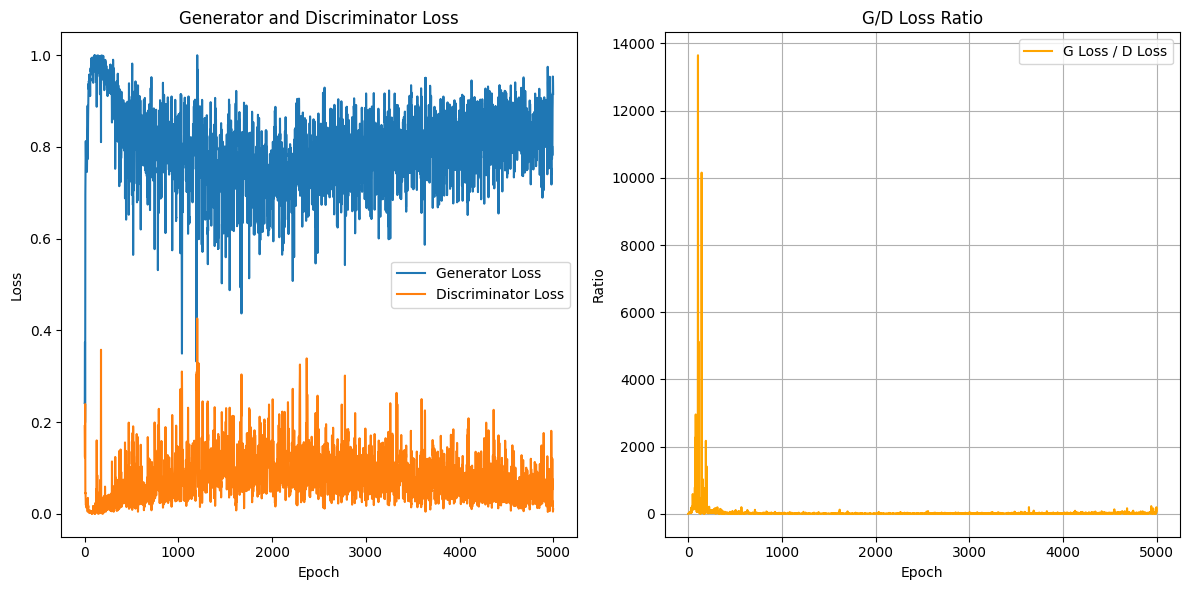

In [11]:
# Plot Generator and Discriminator Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Generator and Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("G/D Loss Ratio")
plt.plot(g_d_ratios, label="G Loss / D Loss", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Ratio")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


In [12]:
## Step 8: Save the Balanced Dataset
y_total_label = label_enc.inverse_transform(y_total)

df_out = pd.DataFrame(X_total)
df_out['label'] = y_total_label
df_out.to_csv("balanced_dataset.csv", index=False)
print("Saved: balanced_dataset.csv")


Saved: balanced_dataset.csv


In [13]:
## Step 8: Save the Balanced Dataset
y_total_label = label_enc.inverse_transform(y_total)

df_out = pd.DataFrame(X_total)
df_out['label'] = y_total_label
df_out.to_csv("balanced_dataset.txt", index=False)
print("Saved: balanced_dataset.txt")

Saved: balanced_dataset.txt


In [15]:
# Load dataset
file_path = "/content/balanced_dataset.csv"  # Update with the correct path
data = pd.read_csv(file_path, sep=",")

In [16]:
# Display the first few rows and dataset info
print("Dataset Summary:")
print(data.info())
print(data.head())
print(data.shape)


Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560 entries, 0 to 559
Columns: 3388 entries, 0 to label
dtypes: float64(3387), object(1)
memory usage: 14.5+ MB
None
          0         1         2         3         4         5         6  \
0  0.306361  0.407809  0.154960  0.311268  0.174446  0.400169  0.000000   
1  0.309076  0.492750  0.261876  0.468176  0.271125  0.382441  0.154546   
2  0.304264  0.215224  0.306241  0.461031  0.165703  0.355110  0.151914   
3  0.244897  0.321484  0.114784  0.407948  0.220541  0.485448  0.101881   
4  0.295119  0.447893  0.317960  0.574365  0.463516  0.333491  0.506150   

          7         8         9  ...      3378      3379      3380      3381  \
0  0.255239  0.254963  0.225608  ...  0.000000  0.000000  0.209879  0.131227   
1  0.437838  0.271556  0.437386  ...  0.000000  0.216987  0.286898  0.100042   
2  0.333616  0.241816  0.382562  ...  0.000000  0.213291  0.538958  0.080848   
3  0.344232  0.000000  0.397142  ...  0.16395

In [17]:
# Separate features and target
X = data.iloc[:, 1:-1].values  # Gene values (columns 2-3387)
y = data.iloc[:, -1].values    # Class column (column 3388)

<ipython-input-19-6cb70f2b8814>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="viridis")


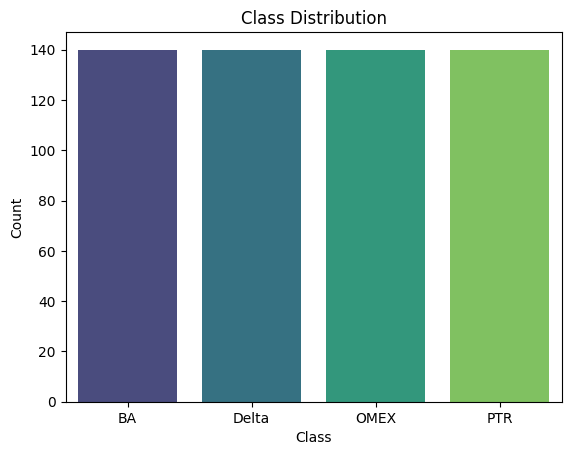

In [19]:
# Visualize class distribution
import seaborn as sns
sns.countplot(x=y, palette="viridis")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

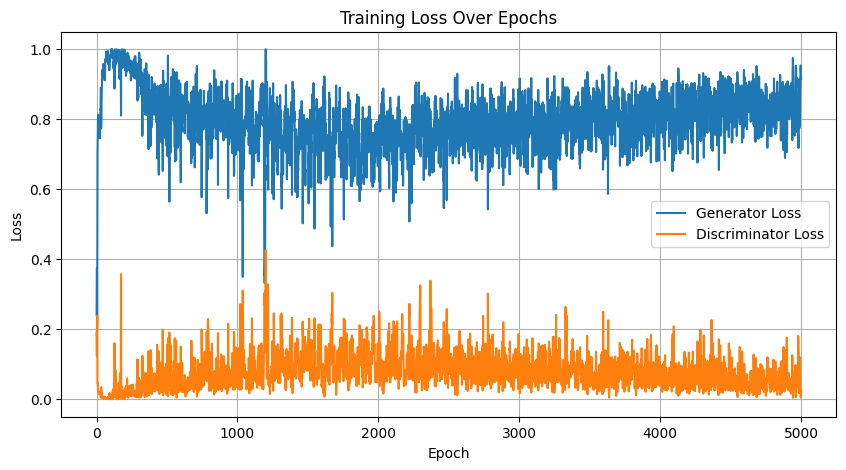

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.legend()
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.show()

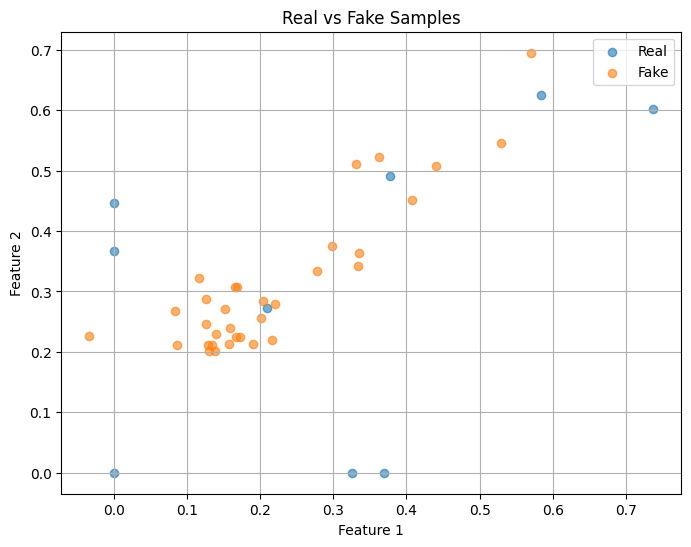

In [22]:
#1. Plot real_x vs fake_x

import matplotlib.pyplot as plt

# If data is more than 2D, reduce it for visualization
def plot_real_vs_fake(real_x, fake_x):
    real_x_np = real_x.detach().numpy()
    fake_x_np = fake_x.detach().numpy()

    plt.figure(figsize=(8, 6))
    plt.scatter(real_x_np[:, 0], real_x_np[:, 1], label='Real', alpha=0.6)
    plt.scatter(fake_x_np[:, 0], fake_x_np[:, 1], label='Fake', alpha=0.6)
    plt.legend()
    plt.title("Real vs Fake Samples")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True)
    plt.show()

# Use this after one batch:
plot_real_vs_fake(real_x, fake_x)

In [23]:

def real_vs_fake_table(real_x, fake_x):
    real_x_np = real_x.detach().numpy()
    fake_x_np = fake_x.detach().numpy()

    # Create DataFrames
    real_df = pd.DataFrame(real_x_np[:, :2], columns=['Feature 1', 'Feature 2'])
    real_df['Label'] = 'Real'

    fake_df = pd.DataFrame(fake_x_np[:, :2], columns=['Feature 1', 'Feature 2'])
    fake_df['Label'] = 'Fake'

    # Combine
    combined_df = pd.concat([real_df, fake_df], ignore_index=True)

    return combined_df

# Example usage
table = real_vs_fake_table(real_x, fake_x)
print(table.head(10))  # Show first 10 rows

   Feature 1  Feature 2 Label
0   0.584463   0.625171  Real
1   0.325696   0.000000  Real
2   0.000000   0.446063  Real
3   0.000000   0.000000  Real
4   0.000000   0.366628  Real
5   0.369387   0.000000  Real
6   0.208906   0.272582  Real
7   0.736977   0.602864  Real
8   0.376901   0.491765  Real
9   0.125844   0.246978  Fake


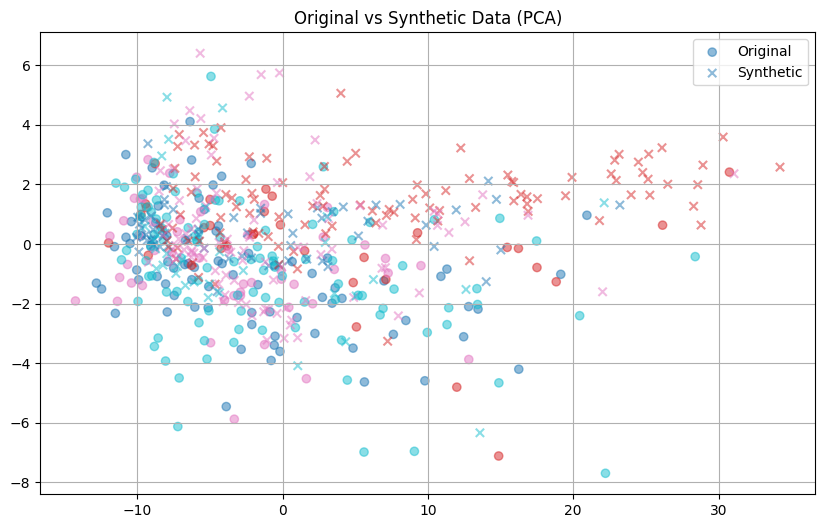

In [24]:
#3. Plot Original vs Synthetic Data (X_total, y_total vs X, y)

from sklearn.decomposition import PCA

def plot_original_vs_synthetic(X_orig, y_orig, X_syn, y_syn):
    pca = PCA(n_components=2)
    X_proj = pca.fit_transform(np.vstack([X_orig, X_syn]))
    n_orig = len(X_orig)

    plt.figure(figsize=(10, 6))
    plt.scatter(X_proj[:n_orig, 0], X_proj[:n_orig, 1], c=y_orig, cmap='tab10', label='Original', alpha=0.5)
    plt.scatter(X_proj[n_orig:, 0], X_proj[n_orig:, 1], c=y_syn, cmap='tab10', marker='x', label='Synthetic', alpha=0.5)
    plt.title("Original vs Synthetic Data (PCA)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_original_vs_synthetic(X_scaled, y_encoded, X_syn, y_syn)


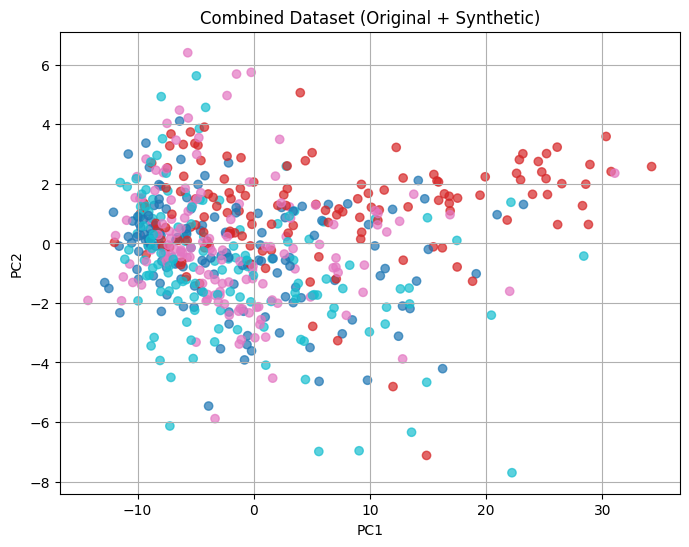

In [25]:
# Optional: Visualize All X_total, y_total

X_proj_total = PCA(n_components=2).fit_transform(X_total)

plt.figure(figsize=(8, 6))
plt.scatter(X_proj_total[:, 0], X_proj_total[:, 1], c=y_total, cmap='tab10', alpha=0.7)
plt.title("Combined Dataset (Original + Synthetic)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()



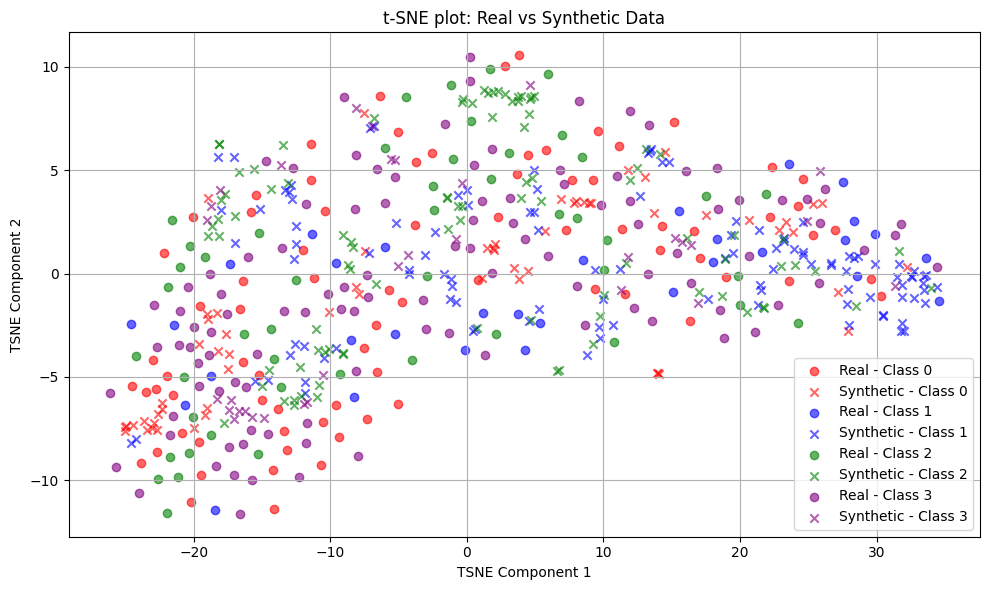

In [26]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Combine real and synthetic data
X_vis = np.vstack([X_scaled, X_syn])
y_vis = np.hstack([y_encoded, y_syn])
labels = ['Real'] * len(X_scaled) + ['Synthetic'] * len(X_syn)

# Create class-wise color and marker mapping
colors = ['red', 'blue', 'green', 'purple']
markers = {'Real': 'o', 'Synthetic': 'x'}

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_vis)

# Plotting
plt.figure(figsize=(10, 6))
for class_id in range(num_classes):
    for data_type in ['Real', 'Synthetic']:
        mask = (np.array(y_vis) == class_id) & (np.array(labels) == data_type)
        plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                    label=f"{data_type} - Class {class_id}",
                    alpha=0.6,
                    c=colors[class_id],
                    marker=markers[data_type])

plt.title("t-SNE plot: Real vs Synthetic Data")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-29-7830109f32d9>:24: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


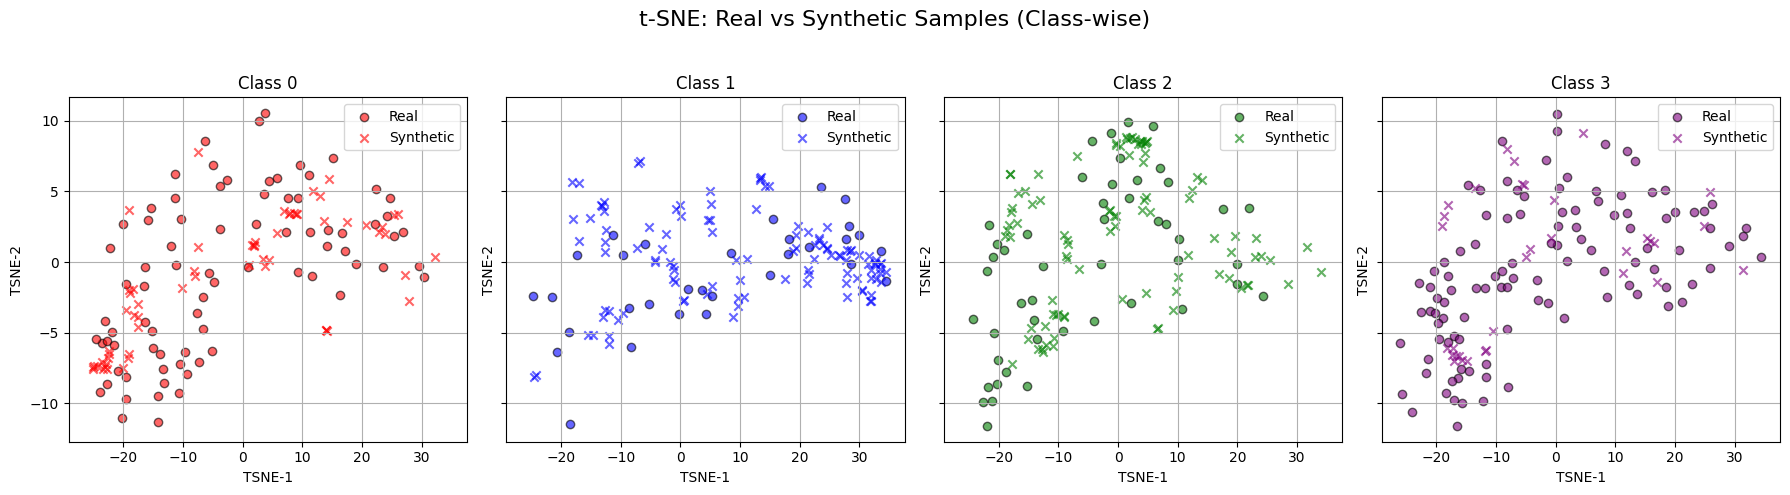

In [29]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Combine real and synthetic data
X_vis = np.vstack([X_scaled, X_syn])
y_vis = np.hstack([y_encoded, y_syn])
labels = np.array(['Real'] * len(X_scaled) + ['Synthetic'] * len(X_syn))

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_vis)

# Define plot styling
colors = ['red', 'blue', 'green', 'purple']
markers = {'Real': 'o', 'Synthetic': 'x'}

# Create subplots for each class
fig, axes = plt.subplots(1, num_classes, figsize=(18, 5), sharex=True, sharey=True)

for class_id in range(num_classes):
    ax = axes[class_id]
    for data_type in ['Real', 'Synthetic']:
        mask = (y_vis == class_id) & (labels == data_type)
        ax.scatter(
            X_tsne[mask, 0],
            X_tsne[mask, 1],
            label=f"{data_type}",
            alpha=0.6,
            c=colors[class_id],
            edgecolor='black',
            marker=markers[data_type]
        )
    ax.set_title(f"Class {class_id}")
    ax.set_xlabel("TSNE-1")
    ax.set_ylabel("TSNE-2")
    ax.legend()
    ax.grid(True)

plt.suptitle("t-SNE: Real vs Synthetic Samples (Class-wise)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


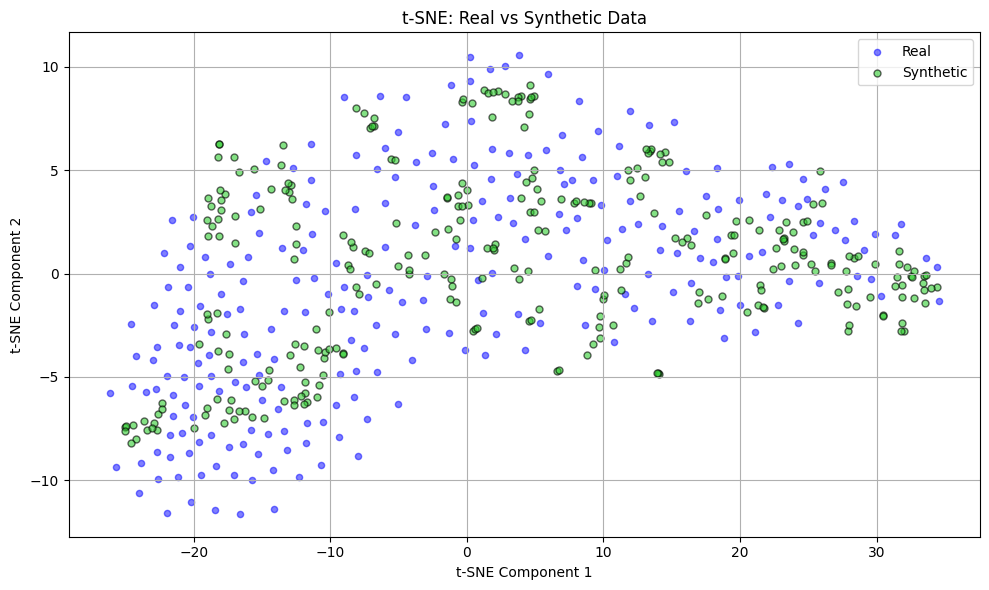

In [28]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Combine full real and synthetic data
X_all = np.vstack([X_scaled, X_syn])
y_all = np.array(['Real'] * len(X_scaled) + ['Synthetic'] * len(X_syn))

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42) # chage perplexity and n_component according your need
X_tsne = tsne.fit_transform(X_all)

# Create a boolean mask
real_mask = y_all == 'Real'
synthetic_mask = y_all == 'Synthetic'

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[real_mask, 0], X_tsne[real_mask, 1],
            c='blue', label='Real', alpha=0.5, s=20)
plt.scatter(X_tsne[synthetic_mask, 0], X_tsne[synthetic_mask, 1],
            c='limegreen', label='Synthetic', alpha=0.6, edgecolor='black', s=25)

plt.title("t-SNE: Real vs Synthetic Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
